## 기본 베이지 DNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
%matplotlib inline

In [3]:
df=pd.read_excel('../optimal_data3_1/'+'Continous_2weeks_5day_3term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (19500, 6) (19500,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (50937, 6) (50937,)
SMOTE 적용 전 레이블 값 분포: 
 0    16979
1     1648
2      873
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    16979
1    16979
2    16979
Name: 8, dtype: int64


In [4]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

10

In [5]:
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [7]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [8]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [9]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [10]:
most_acc=[]

In [11]:
X_test=pd.DataFrame()
X_train=pd.DataFrame()
y_test=pd.DataFrame()
y_train=pd.DataFrame()
empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]


In [12]:
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print(len(train_index))
    # print(len(test_index))

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 1000
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, pred_list = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')
      
        
        
    y_test_list=y_test.tolist()
    pred = [item for sublist in pred_list for item in sublist]
    accuracy=accuracy_score(y_test_list, pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test_list,pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test_list,pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    
    
    
    most_acc.append(final_acc)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.10100. Saving Model!
epoch 01, loss: 1.16390, acc: 0.16600, val_loss: 1.10100, val_accuracy: 0.33333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 1.10100 to 1.08856. Saving Model!
epoch 02, loss: 1.09817, acc: 0.33392, val_loss: 1.08856, val_accuracy: 0.34413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


[INFO] val_acc has been improved from 1.08856 to 1.08166. Saving Model!
epoch 03, loss: 1.08958, acc: 0.34280, val_loss: 1.08166, val_accuracy: 0.36082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


[INFO] val_acc has been improved from 1.08166 to 1.07670. Saving Model!
epoch 04, loss: 1.08526, acc: 0.37833, val_loss: 1.07670, val_accuracy: 0.43502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 1.07670 to 1.07127. Saving Model!
epoch 05, loss: 1.08203, acc: 0.44764, val_loss: 1.07127, val_accuracy: 0.47369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


[INFO] val_acc has been improved from 1.07127 to 1.06476. Saving Model!
epoch 06, loss: 1.07854, acc: 0.44838, val_loss: 1.06476, val_accuracy: 0.46682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


[INFO] val_acc has been improved from 1.06476 to 1.05759. Saving Model!
epoch 07, loss: 1.07434, acc: 0.42829, val_loss: 1.05759, val_accuracy: 0.45819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 1.05759 to 1.04983. Saving Model!
epoch 08, loss: 1.06999, acc: 0.42534, val_loss: 1.04983, val_accuracy: 0.45995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 1.04983 to 1.04209. Saving Model!
epoch 09, loss: 1.06558, acc: 0.42410, val_loss: 1.04209, val_accuracy: 0.46152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 1.04209 to 1.03441. Saving Model!
epoch 10, loss: 1.06157, acc: 0.42294, val_loss: 1.03441, val_accuracy: 0.46211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 1.03441 to 1.02719. Saving Model!
epoch 11, loss: 1.05803, acc: 0.42166, val_loss: 1.02719, val_accuracy: 0.46329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


[INFO] val_acc has been improved from 1.02719 to 1.02050. Saving Model!
epoch 12, loss: 1.05489, acc: 0.42083, val_loss: 1.02050, val_accuracy: 0.46623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 1.02050 to 1.01461. Saving Model!
epoch 13, loss: 1.05210, acc: 0.42447, val_loss: 1.01461, val_accuracy: 0.46800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 1.01461 to 1.00956. Saving Model!
epoch 14, loss: 1.04959, acc: 0.42558, val_loss: 1.00956, val_accuracy: 0.46682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 1.00956 to 1.00532. Saving Model!
epoch 15, loss: 1.04748, acc: 0.42678, val_loss: 1.00532, val_accuracy: 0.46879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 1.00532 to 1.00171. Saving Model!
epoch 16, loss: 1.04555, acc: 0.42853, val_loss: 1.00171, val_accuracy: 0.47114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.09it/s]


[INFO] val_acc has been improved from 1.00171 to 0.99857. Saving Model!
epoch 17, loss: 1.04382, acc: 0.42981, val_loss: 0.99857, val_accuracy: 0.47075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.99857 to 0.99574. Saving Model!
epoch 18, loss: 1.04226, acc: 0.42851, val_loss: 0.99574, val_accuracy: 0.47212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.99574 to 0.99322. Saving Model!
epoch 19, loss: 1.04078, acc: 0.42859, val_loss: 0.99322, val_accuracy: 0.47134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


[INFO] val_acc has been improved from 0.99322 to 0.99087. Saving Model!
epoch 20, loss: 1.03931, acc: 0.43250, val_loss: 0.99087, val_accuracy: 0.47173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


[INFO] val_acc has been improved from 0.99087 to 0.98874. Saving Model!
epoch 21, loss: 1.03782, acc: 0.43341, val_loss: 0.98874, val_accuracy: 0.47311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.98874 to 0.98678. Saving Model!
epoch 22, loss: 1.03630, acc: 0.43549, val_loss: 0.98678, val_accuracy: 0.47330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


[INFO] val_acc has been improved from 0.98678 to 0.98494. Saving Model!
epoch 23, loss: 1.03483, acc: 0.43470, val_loss: 0.98494, val_accuracy: 0.48469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


[INFO] val_acc has been improved from 0.98494 to 0.98320. Saving Model!
epoch 24, loss: 1.03339, acc: 0.43575, val_loss: 0.98320, val_accuracy: 0.48606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.98320 to 0.98156. Saving Model!
epoch 25, loss: 1.03195, acc: 0.43660, val_loss: 0.98156, val_accuracy: 0.48488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.98156 to 0.98004. Saving Model!
epoch 26, loss: 1.03056, acc: 0.43871, val_loss: 0.98004, val_accuracy: 0.48410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


[INFO] val_acc has been improved from 0.98004 to 0.97846. Saving Model!
epoch 27, loss: 1.02922, acc: 0.44332, val_loss: 0.97846, val_accuracy: 0.48508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.97846 to 0.97697. Saving Model!
epoch 28, loss: 1.02783, acc: 0.44358, val_loss: 0.97697, val_accuracy: 0.48704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.97697 to 0.97555. Saving Model!
epoch 29, loss: 1.02649, acc: 0.44596, val_loss: 0.97555, val_accuracy: 0.49038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


[INFO] val_acc has been improved from 0.97555 to 0.97409. Saving Model!
epoch 30, loss: 1.02514, acc: 0.44517, val_loss: 0.97409, val_accuracy: 0.49077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.97409 to 0.97262. Saving Model!
epoch 31, loss: 1.02378, acc: 0.44539, val_loss: 0.97262, val_accuracy: 0.49588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.97262 to 0.97125. Saving Model!
epoch 32, loss: 1.02238, acc: 0.45126, val_loss: 0.97125, val_accuracy: 0.49764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.97125 to 0.96991. Saving Model!
epoch 33, loss: 1.02095, acc: 0.44967, val_loss: 0.96991, val_accuracy: 0.50216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.96991 to 0.96864. Saving Model!
epoch 34, loss: 1.01947, acc: 0.44958, val_loss: 0.96864, val_accuracy: 0.50353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.96864 to 0.96737. Saving Model!
epoch 35, loss: 1.01806, acc: 0.45113, val_loss: 0.96737, val_accuracy: 0.50530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.96737 to 0.96608. Saving Model!
epoch 36, loss: 1.01666, acc: 0.45298, val_loss: 0.96608, val_accuracy: 0.51472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


[INFO] val_acc has been improved from 0.96608 to 0.96486. Saving Model!
epoch 37, loss: 1.01515, acc: 0.45322, val_loss: 0.96486, val_accuracy: 0.51394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.96486 to 0.96376. Saving Model!
epoch 38, loss: 1.01366, acc: 0.45588, val_loss: 0.96376, val_accuracy: 0.51217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.96376 to 0.96274. Saving Model!
epoch 39, loss: 1.01215, acc: 0.45795, val_loss: 0.96274, val_accuracy: 0.51178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.96274 to 0.96162. Saving Model!
epoch 40, loss: 1.01072, acc: 0.45918, val_loss: 0.96162, val_accuracy: 0.51335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.96162 to 0.96055. Saving Model!
epoch 41, loss: 1.00915, acc: 0.46129, val_loss: 0.96055, val_accuracy: 0.50982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


[INFO] val_acc has been improved from 0.96055 to 0.95968. Saving Model!
epoch 42, loss: 1.00765, acc: 0.46304, val_loss: 0.95968, val_accuracy: 0.51040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.95968 to 0.95879. Saving Model!
epoch 43, loss: 1.00623, acc: 0.46424, val_loss: 0.95879, val_accuracy: 0.51060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.95879 to 0.95783. Saving Model!
epoch 44, loss: 1.00492, acc: 0.46655, val_loss: 0.95783, val_accuracy: 0.51119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


[INFO] val_acc has been improved from 0.95783 to 0.95694. Saving Model!
epoch 45, loss: 1.00360, acc: 0.46579, val_loss: 0.95694, val_accuracy: 0.51119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.95694 to 0.95618. Saving Model!
epoch 46, loss: 1.00225, acc: 0.46788, val_loss: 0.95618, val_accuracy: 0.51413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.95618 to 0.95561. Saving Model!
epoch 47, loss: 1.00092, acc: 0.46969, val_loss: 0.95561, val_accuracy: 0.51492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.95561 to 0.95499. Saving Model!
epoch 48, loss: 0.99971, acc: 0.47183, val_loss: 0.95499, val_accuracy: 0.51492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.95499 to 0.95442. Saving Model!
epoch 49, loss: 0.99847, acc: 0.47091, val_loss: 0.95442, val_accuracy: 0.51590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.95442 to 0.95370. Saving Model!
epoch 50, loss: 0.99716, acc: 0.47091, val_loss: 0.95370, val_accuracy: 0.51708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


[INFO] val_acc has been improved from 0.95370 to 0.95299. Saving Model!
epoch 51, loss: 0.99594, acc: 0.47307, val_loss: 0.95299, val_accuracy: 0.51806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.95299 to 0.95252. Saving Model!
epoch 52, loss: 0.99472, acc: 0.47318, val_loss: 0.95252, val_accuracy: 0.51865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.95252 to 0.95210. Saving Model!
epoch 53, loss: 0.99357, acc: 0.47383, val_loss: 0.95210, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


[INFO] val_acc has been improved from 0.95210 to 0.95146. Saving Model!
epoch 54, loss: 0.99250, acc: 0.47401, val_loss: 0.95146, val_accuracy: 0.50903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.95146 to 0.95112. Saving Model!
epoch 55, loss: 0.99125, acc: 0.47508, val_loss: 0.95112, val_accuracy: 0.50883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.95112 to 0.95079. Saving Model!
epoch 56, loss: 0.99012, acc: 0.47728, val_loss: 0.95079, val_accuracy: 0.50923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


[INFO] val_acc has been improved from 0.95079 to 0.95044. Saving Model!
epoch 57, loss: 0.98887, acc: 0.47890, val_loss: 0.95044, val_accuracy: 0.50962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


[INFO] val_acc has been improved from 0.95044 to 0.95015. Saving Model!
epoch 58, loss: 0.98768, acc: 0.47968, val_loss: 0.95015, val_accuracy: 0.51060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.95015 to 0.94984. Saving Model!
epoch 59, loss: 0.98664, acc: 0.48018, val_loss: 0.94984, val_accuracy: 0.51080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.94984 to 0.94975. Saving Model!
epoch 60, loss: 0.98557, acc: 0.48167, val_loss: 0.94975, val_accuracy: 0.51080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.94975 to 0.94957. Saving Model!
epoch 61, loss: 0.98444, acc: 0.48263, val_loss: 0.94957, val_accuracy: 0.51217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.94957 to 0.94923. Saving Model!
epoch 62, loss: 0.98335, acc: 0.48308, val_loss: 0.94923, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.94923 to 0.94893. Saving Model!
epoch 63, loss: 0.98223, acc: 0.48391, val_loss: 0.94893, val_accuracy: 0.51217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 64, loss: 0.98112, acc: 0.48433, val_loss: 0.94911, val_accuracy: 0.50157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.94893 to 0.94863. Saving Model!
epoch 65, loss: 0.98007, acc: 0.48472, val_loss: 0.94863, val_accuracy: 0.50177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.94863 to 0.94844. Saving Model!
epoch 66, loss: 0.97889, acc: 0.48518, val_loss: 0.94844, val_accuracy: 0.50216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 67, loss: 0.97777, acc: 0.48572, val_loss: 0.94867, val_accuracy: 0.50216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 68, loss: 0.97673, acc: 0.48614, val_loss: 0.94868, val_accuracy: 0.50294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 69, loss: 0.97560, acc: 0.48622, val_loss: 0.94894, val_accuracy: 0.50275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 70, loss: 0.97443, acc: 0.48725, val_loss: 0.94931, val_accuracy: 0.50314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 71, loss: 0.97345, acc: 0.48723, val_loss: 0.94896, val_accuracy: 0.50294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 72, loss: 0.97221, acc: 0.48760, val_loss: 0.94935, val_accuracy: 0.50275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 73, loss: 0.97106, acc: 0.48814, val_loss: 0.94964, val_accuracy: 0.50275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 74, loss: 0.97003, acc: 0.48753, val_loss: 0.95002, val_accuracy: 0.50255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


epoch 75, loss: 0.96881, acc: 0.48793, val_loss: 0.95062, val_accuracy: 0.50334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 76, loss: 0.96777, acc: 0.48867, val_loss: 0.95033, val_accuracy: 0.50294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 77, loss: 0.96663, acc: 0.48937, val_loss: 0.95073, val_accuracy: 0.50294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 78, loss: 0.96537, acc: 0.49102, val_loss: 0.95157, val_accuracy: 0.50353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 79, loss: 0.96435, acc: 0.49153, val_loss: 0.95216, val_accuracy: 0.50452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 80, loss: 0.96309, acc: 0.49192, val_loss: 0.95240, val_accuracy: 0.50491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 81, loss: 0.96210, acc: 0.49259, val_loss: 0.95272, val_accuracy: 0.50609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 82, loss: 0.96084, acc: 0.49345, val_loss: 0.95365, val_accuracy: 0.50589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 83, loss: 0.95960, acc: 0.49275, val_loss: 0.95621, val_accuracy: 0.50726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 84, loss: 0.95865, acc: 0.49264, val_loss: 0.95666, val_accuracy: 0.50844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 85, loss: 0.95735, acc: 0.49305, val_loss: 0.95813, val_accuracy: 0.50962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 86, loss: 0.95606, acc: 0.49281, val_loss: 0.96067, val_accuracy: 0.51433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 87, loss: 0.95509, acc: 0.49373, val_loss: 0.96102, val_accuracy: 0.51551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 88, loss: 0.95383, acc: 0.49646, val_loss: 0.96265, val_accuracy: 0.52061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 89, loss: 0.95260, acc: 0.49864, val_loss: 0.96444, val_accuracy: 0.52179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 90, loss: 0.95144, acc: 0.50080, val_loss: 0.96648, val_accuracy: 0.52199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 91, loss: 0.95032, acc: 0.50224, val_loss: 0.96798, val_accuracy: 0.52238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 92, loss: 0.94899, acc: 0.50394, val_loss: 0.97024, val_accuracy: 0.52277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 93, loss: 0.94793, acc: 0.50492, val_loss: 0.97152, val_accuracy: 0.52395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 94, loss: 0.94690, acc: 0.50540, val_loss: 0.97445, val_accuracy: 0.52434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 95, loss: 0.94558, acc: 0.50634, val_loss: 0.97690, val_accuracy: 0.52532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 96, loss: 0.94442, acc: 0.50562, val_loss: 0.97806, val_accuracy: 0.52572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 97, loss: 0.94330, acc: 0.50605, val_loss: 0.98069, val_accuracy: 0.52513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 98, loss: 0.94200, acc: 0.50690, val_loss: 0.98282, val_accuracy: 0.52061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 99, loss: 0.94089, acc: 0.50717, val_loss: 0.98452, val_accuracy: 0.52101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 100, loss: 0.93966, acc: 0.50738, val_loss: 0.98584, val_accuracy: 0.52238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 101, loss: 0.93839, acc: 0.50782, val_loss: 0.98831, val_accuracy: 0.52277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 102, loss: 0.93736, acc: 0.50808, val_loss: 0.99086, val_accuracy: 0.52179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 103, loss: 0.93621, acc: 0.50856, val_loss: 0.99328, val_accuracy: 0.52258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 104, loss: 0.93492, acc: 0.51020, val_loss: 0.99451, val_accuracy: 0.52375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 105, loss: 0.93381, acc: 0.51083, val_loss: 0.99663, val_accuracy: 0.52297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 106, loss: 0.93263, acc: 0.51203, val_loss: 0.99777, val_accuracy: 0.52316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 107, loss: 0.93152, acc: 0.51443, val_loss: 1.00032, val_accuracy: 0.52356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 108, loss: 0.93036, acc: 0.51580, val_loss: 1.00217, val_accuracy: 0.52316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 109, loss: 0.92929, acc: 0.51761, val_loss: 1.00284, val_accuracy: 0.52454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 110, loss: 0.92811, acc: 0.51829, val_loss: 1.00440, val_accuracy: 0.52552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 111, loss: 0.92703, acc: 0.51888, val_loss: 1.00545, val_accuracy: 0.52886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 112, loss: 0.92604, acc: 0.52054, val_loss: 1.00609, val_accuracy: 0.52984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 113, loss: 0.92475, acc: 0.52012, val_loss: 1.00908, val_accuracy: 0.52905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 114, loss: 0.92375, acc: 0.52198, val_loss: 1.01015, val_accuracy: 0.52964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 115, loss: 0.92289, acc: 0.52320, val_loss: 1.01037, val_accuracy: 0.53004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 116, loss: 0.92137, acc: 0.52658, val_loss: 1.01285, val_accuracy: 0.53239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 117, loss: 0.92039, acc: 0.52710, val_loss: 1.01457, val_accuracy: 0.53141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 118, loss: 0.91942, acc: 0.52706, val_loss: 1.01590, val_accuracy: 0.53082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 119, loss: 0.91816, acc: 0.52798, val_loss: 1.01819, val_accuracy: 0.53121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 120, loss: 0.91707, acc: 0.52841, val_loss: 1.01827, val_accuracy: 0.53219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 121, loss: 0.91596, acc: 0.53103, val_loss: 1.01891, val_accuracy: 0.53318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 122, loss: 0.91487, acc: 0.53304, val_loss: 1.02090, val_accuracy: 0.53377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 123, loss: 0.91383, acc: 0.53454, val_loss: 1.02223, val_accuracy: 0.53475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 124, loss: 0.91283, acc: 0.53533, val_loss: 1.02356, val_accuracy: 0.52945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 125, loss: 0.91162, acc: 0.53550, val_loss: 1.02451, val_accuracy: 0.53004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 126, loss: 0.91049, acc: 0.53600, val_loss: 1.02481, val_accuracy: 0.53161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 127, loss: 0.90963, acc: 0.53642, val_loss: 1.02645, val_accuracy: 0.53043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 128, loss: 0.90852, acc: 0.53740, val_loss: 1.02692, val_accuracy: 0.53062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 129, loss: 0.90707, acc: 0.53799, val_loss: 1.02939, val_accuracy: 0.52886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 130, loss: 0.90628, acc: 0.53827, val_loss: 1.03017, val_accuracy: 0.53062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 131, loss: 0.90529, acc: 0.53947, val_loss: 1.02971, val_accuracy: 0.53062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 132, loss: 0.90415, acc: 0.54010, val_loss: 1.02964, val_accuracy: 0.53141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 133, loss: 0.90291, acc: 0.54119, val_loss: 1.03217, val_accuracy: 0.53259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 134, loss: 0.90185, acc: 0.54222, val_loss: 1.03262, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 135, loss: 0.90096, acc: 0.54316, val_loss: 1.03123, val_accuracy: 0.53357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 136, loss: 0.89992, acc: 0.54414, val_loss: 1.03011, val_accuracy: 0.53828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 137, loss: 0.89874, acc: 0.54493, val_loss: 1.03119, val_accuracy: 0.53926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 138, loss: 0.89757, acc: 0.54617, val_loss: 1.03374, val_accuracy: 0.53985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 139, loss: 0.89669, acc: 0.54722, val_loss: 1.03393, val_accuracy: 0.54142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 140, loss: 0.89560, acc: 0.54770, val_loss: 1.03258, val_accuracy: 0.54181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 141, loss: 0.89437, acc: 0.54846, val_loss: 1.03454, val_accuracy: 0.54299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 142, loss: 0.89335, acc: 0.54929, val_loss: 1.03641, val_accuracy: 0.54358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 143, loss: 0.89249, acc: 0.55057, val_loss: 1.03666, val_accuracy: 0.54358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 144, loss: 0.89127, acc: 0.55167, val_loss: 1.03527, val_accuracy: 0.54338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 145, loss: 0.89026, acc: 0.55243, val_loss: 1.03623, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 146, loss: 0.88935, acc: 0.55319, val_loss: 1.03884, val_accuracy: 0.54711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 147, loss: 0.88826, acc: 0.55387, val_loss: 1.03882, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 148, loss: 0.88726, acc: 0.55465, val_loss: 1.03894, val_accuracy: 0.54868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 149, loss: 0.88612, acc: 0.55542, val_loss: 1.03885, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 150, loss: 0.88510, acc: 0.55620, val_loss: 1.03909, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 151, loss: 0.88409, acc: 0.55686, val_loss: 1.03990, val_accuracy: 0.55026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 152, loss: 0.88301, acc: 0.55858, val_loss: 1.03978, val_accuracy: 0.55104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 153, loss: 0.88231, acc: 0.55954, val_loss: 1.04021, val_accuracy: 0.55124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 154, loss: 0.88089, acc: 0.56076, val_loss: 1.03929, val_accuracy: 0.55065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 155, loss: 0.88013, acc: 0.56146, val_loss: 1.03947, val_accuracy: 0.55183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 156, loss: 0.87916, acc: 0.56246, val_loss: 1.03978, val_accuracy: 0.55202


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 157, loss: 0.87798, acc: 0.56342, val_loss: 1.03879, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 158, loss: 0.87702, acc: 0.56408, val_loss: 1.03879, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 159, loss: 0.87607, acc: 0.56462, val_loss: 1.03912, val_accuracy: 0.55379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 160, loss: 0.87488, acc: 0.56504, val_loss: 1.03919, val_accuracy: 0.55477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 161, loss: 0.87420, acc: 0.56558, val_loss: 1.03802, val_accuracy: 0.55497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 162, loss: 0.87300, acc: 0.56593, val_loss: 1.03753, val_accuracy: 0.55575


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 163, loss: 0.87200, acc: 0.56728, val_loss: 1.03835, val_accuracy: 0.55654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 164, loss: 0.87127, acc: 0.56899, val_loss: 1.03739, val_accuracy: 0.55614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 165, loss: 0.87018, acc: 0.56896, val_loss: 1.03757, val_accuracy: 0.55516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 166, loss: 0.86916, acc: 0.56901, val_loss: 1.03719, val_accuracy: 0.55084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 167, loss: 0.86837, acc: 0.56907, val_loss: 1.03654, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 168, loss: 0.86721, acc: 0.56988, val_loss: 1.03419, val_accuracy: 0.55065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 169, loss: 0.86637, acc: 0.57147, val_loss: 1.03391, val_accuracy: 0.55045


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 170, loss: 0.86532, acc: 0.57276, val_loss: 1.03515, val_accuracy: 0.55143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 171, loss: 0.86442, acc: 0.57296, val_loss: 1.03511, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 172, loss: 0.86366, acc: 0.57453, val_loss: 1.03395, val_accuracy: 0.55124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 173, loss: 0.86241, acc: 0.57549, val_loss: 1.03368, val_accuracy: 0.55143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 174, loss: 0.86165, acc: 0.57597, val_loss: 1.03298, val_accuracy: 0.54770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 175, loss: 0.86065, acc: 0.57642, val_loss: 1.03357, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 176, loss: 0.85956, acc: 0.57769, val_loss: 1.03156, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 177, loss: 0.85913, acc: 0.57813, val_loss: 1.03107, val_accuracy: 0.54829


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 178, loss: 0.85769, acc: 0.57889, val_loss: 1.03171, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 179, loss: 0.85673, acc: 0.57935, val_loss: 1.03162, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 180, loss: 0.85627, acc: 0.57943, val_loss: 1.03038, val_accuracy: 0.55026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 181, loss: 0.85532, acc: 0.58002, val_loss: 1.02955, val_accuracy: 0.54554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 182, loss: 0.85383, acc: 0.58083, val_loss: 1.02964, val_accuracy: 0.54633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 183, loss: 0.85352, acc: 0.58094, val_loss: 1.02948, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 184, loss: 0.85259, acc: 0.58100, val_loss: 1.02760, val_accuracy: 0.54672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 185, loss: 0.85137, acc: 0.58151, val_loss: 1.02765, val_accuracy: 0.54868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 186, loss: 0.85078, acc: 0.58166, val_loss: 1.02810, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 187, loss: 0.85005, acc: 0.58201, val_loss: 1.02733, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 188, loss: 0.84875, acc: 0.58242, val_loss: 1.02613, val_accuracy: 0.55026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 189, loss: 0.84800, acc: 0.58286, val_loss: 1.02610, val_accuracy: 0.55045


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 190, loss: 0.84757, acc: 0.58351, val_loss: 1.02597, val_accuracy: 0.55084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 191, loss: 0.84618, acc: 0.58449, val_loss: 1.02537, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 192, loss: 0.84556, acc: 0.58493, val_loss: 1.02520, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 193, loss: 0.84487, acc: 0.58491, val_loss: 1.02556, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 194, loss: 0.84354, acc: 0.58585, val_loss: 1.02708, val_accuracy: 0.55143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 195, loss: 0.84326, acc: 0.58641, val_loss: 1.02585, val_accuracy: 0.55556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 196, loss: 0.84214, acc: 0.58713, val_loss: 1.02461, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 197, loss: 0.84103, acc: 0.58812, val_loss: 1.02619, val_accuracy: 0.55222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 198, loss: 0.84095, acc: 0.58803, val_loss: 1.02562, val_accuracy: 0.55732


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 199, loss: 0.83958, acc: 0.58910, val_loss: 1.02615, val_accuracy: 0.55771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 200, loss: 0.83849, acc: 0.58982, val_loss: 1.02660, val_accuracy: 0.55771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 201, loss: 0.83807, acc: 0.58973, val_loss: 1.02438, val_accuracy: 0.55850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 202, loss: 0.83724, acc: 0.59196, val_loss: 1.02501, val_accuracy: 0.55948


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 203, loss: 0.83619, acc: 0.59222, val_loss: 1.02653, val_accuracy: 0.55987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 204, loss: 0.83549, acc: 0.59270, val_loss: 1.02634, val_accuracy: 0.56027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 205, loss: 0.83438, acc: 0.59342, val_loss: 1.02718, val_accuracy: 0.56144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 206, loss: 0.83370, acc: 0.59374, val_loss: 1.02799, val_accuracy: 0.56360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 207, loss: 0.83281, acc: 0.59427, val_loss: 1.02682, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 208, loss: 0.83191, acc: 0.59470, val_loss: 1.02686, val_accuracy: 0.56557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 209, loss: 0.83124, acc: 0.59497, val_loss: 1.02649, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 210, loss: 0.82991, acc: 0.59579, val_loss: 1.02675, val_accuracy: 0.56616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 211, loss: 0.82941, acc: 0.59623, val_loss: 1.02725, val_accuracy: 0.56694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 212, loss: 0.82839, acc: 0.59693, val_loss: 1.02795, val_accuracy: 0.56753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 213, loss: 0.82759, acc: 0.59739, val_loss: 1.02770, val_accuracy: 0.56773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 214, loss: 0.82666, acc: 0.59776, val_loss: 1.02738, val_accuracy: 0.56714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 215, loss: 0.82619, acc: 0.59826, val_loss: 1.02724, val_accuracy: 0.56753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 216, loss: 0.82471, acc: 0.59928, val_loss: 1.02722, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 217, loss: 0.82433, acc: 0.59911, val_loss: 1.02711, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 218, loss: 0.82344, acc: 0.60009, val_loss: 1.02782, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 219, loss: 0.82255, acc: 0.60048, val_loss: 1.02687, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 220, loss: 0.82166, acc: 0.60088, val_loss: 1.02584, val_accuracy: 0.57106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 221, loss: 0.82082, acc: 0.60125, val_loss: 1.02558, val_accuracy: 0.57146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 222, loss: 0.81984, acc: 0.60190, val_loss: 1.02602, val_accuracy: 0.57146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 223, loss: 0.81918, acc: 0.60225, val_loss: 1.02657, val_accuracy: 0.57303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 224, loss: 0.81842, acc: 0.60349, val_loss: 1.02478, val_accuracy: 0.57322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 225, loss: 0.81758, acc: 0.60400, val_loss: 1.02540, val_accuracy: 0.57420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 226, loss: 0.81645, acc: 0.60461, val_loss: 1.02635, val_accuracy: 0.57420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 227, loss: 0.81603, acc: 0.60644, val_loss: 1.02595, val_accuracy: 0.57519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 228, loss: 0.81482, acc: 0.60688, val_loss: 1.02576, val_accuracy: 0.57558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 229, loss: 0.81455, acc: 0.60733, val_loss: 1.02605, val_accuracy: 0.57558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 230, loss: 0.81305, acc: 0.60803, val_loss: 1.02712, val_accuracy: 0.57656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


epoch 231, loss: 0.81300, acc: 0.60818, val_loss: 1.02496, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 232, loss: 0.81163, acc: 0.60954, val_loss: 1.02589, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 233, loss: 0.81113, acc: 0.60976, val_loss: 1.02619, val_accuracy: 0.57911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 234, loss: 0.81031, acc: 0.61028, val_loss: 1.02766, val_accuracy: 0.57970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 235, loss: 0.80930, acc: 0.61074, val_loss: 1.02746, val_accuracy: 0.58009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 236, loss: 0.80871, acc: 0.61152, val_loss: 1.02631, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 237, loss: 0.80805, acc: 0.61222, val_loss: 1.02642, val_accuracy: 0.58206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 238, loss: 0.80677, acc: 0.61272, val_loss: 1.02725, val_accuracy: 0.58225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 239, loss: 0.80623, acc: 0.61224, val_loss: 1.02889, val_accuracy: 0.58304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 240, loss: 0.80598, acc: 0.61279, val_loss: 1.02771, val_accuracy: 0.58324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 241, loss: 0.80452, acc: 0.61401, val_loss: 1.02689, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 242, loss: 0.80383, acc: 0.61506, val_loss: 1.02686, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 243, loss: 0.80343, acc: 0.61540, val_loss: 1.02686, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 244, loss: 0.80220, acc: 0.61604, val_loss: 1.02796, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 245, loss: 0.80166, acc: 0.61626, val_loss: 1.02674, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 246, loss: 0.80108, acc: 0.61719, val_loss: 1.02527, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 247, loss: 0.79996, acc: 0.61881, val_loss: 1.02448, val_accuracy: 0.58539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 248, loss: 0.79930, acc: 0.61996, val_loss: 1.02427, val_accuracy: 0.58539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 249, loss: 0.79849, acc: 0.62095, val_loss: 1.02520, val_accuracy: 0.58539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 250, loss: 0.79786, acc: 0.62169, val_loss: 1.02349, val_accuracy: 0.58638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 251, loss: 0.79730, acc: 0.62215, val_loss: 1.02233, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 252, loss: 0.79598, acc: 0.62260, val_loss: 1.02292, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 253, loss: 0.79557, acc: 0.62289, val_loss: 1.02250, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 254, loss: 0.79507, acc: 0.62306, val_loss: 1.02317, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 255, loss: 0.79388, acc: 0.62343, val_loss: 1.02138, val_accuracy: 0.58481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 256, loss: 0.79318, acc: 0.62398, val_loss: 1.02082, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 257, loss: 0.79286, acc: 0.62426, val_loss: 1.02166, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 258, loss: 0.79152, acc: 0.62553, val_loss: 1.02211, val_accuracy: 0.58520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 259, loss: 0.79118, acc: 0.62574, val_loss: 1.02120, val_accuracy: 0.58520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 260, loss: 0.79027, acc: 0.62620, val_loss: 1.01991, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 261, loss: 0.78954, acc: 0.62688, val_loss: 1.01736, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 262, loss: 0.78867, acc: 0.62703, val_loss: 1.01640, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 263, loss: 0.78823, acc: 0.62697, val_loss: 1.01493, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 264, loss: 0.78773, acc: 0.62701, val_loss: 1.01312, val_accuracy: 0.58697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 265, loss: 0.78642, acc: 0.62797, val_loss: 1.01175, val_accuracy: 0.58716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 266, loss: 0.78593, acc: 0.63011, val_loss: 1.00963, val_accuracy: 0.58755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 267, loss: 0.78514, acc: 0.63015, val_loss: 1.00823, val_accuracy: 0.58834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 268, loss: 0.78457, acc: 0.63022, val_loss: 1.00738, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 269, loss: 0.78408, acc: 0.63035, val_loss: 1.00542, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 270, loss: 0.78274, acc: 0.63115, val_loss: 1.00373, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 271, loss: 0.78249, acc: 0.63163, val_loss: 1.00144, val_accuracy: 0.59011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 272, loss: 0.78183, acc: 0.63183, val_loss: 0.99958, val_accuracy: 0.59050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 273, loss: 0.78086, acc: 0.63211, val_loss: 0.99829, val_accuracy: 0.59168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 274, loss: 0.78063, acc: 0.63198, val_loss: 0.99481, val_accuracy: 0.59128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 275, loss: 0.77911, acc: 0.63255, val_loss: 0.99387, val_accuracy: 0.59227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 276, loss: 0.77934, acc: 0.63240, val_loss: 0.99246, val_accuracy: 0.59325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 277, loss: 0.77818, acc: 0.63323, val_loss: 0.98909, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 278, loss: 0.77745, acc: 0.63351, val_loss: 0.98739, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 279, loss: 0.77676, acc: 0.63432, val_loss: 0.98722, val_accuracy: 0.59462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 280, loss: 0.77627, acc: 0.63460, val_loss: 0.98333, val_accuracy: 0.59423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 281, loss: 0.77550, acc: 0.63488, val_loss: 0.98014, val_accuracy: 0.59423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 282, loss: 0.77482, acc: 0.63554, val_loss: 0.97881, val_accuracy: 0.59482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 283, loss: 0.77419, acc: 0.63604, val_loss: 0.97543, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 284, loss: 0.77334, acc: 0.63611, val_loss: 0.97282, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 285, loss: 0.77298, acc: 0.63639, val_loss: 0.97189, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 286, loss: 0.77190, acc: 0.63709, val_loss: 0.96980, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 287, loss: 0.77165, acc: 0.63715, val_loss: 0.96752, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 288, loss: 0.77068, acc: 0.63744, val_loss: 0.96586, val_accuracy: 0.59580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 289, loss: 0.77032, acc: 0.63746, val_loss: 0.96307, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 290, loss: 0.76913, acc: 0.63831, val_loss: 0.96151, val_accuracy: 0.59639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 291, loss: 0.76894, acc: 0.63824, val_loss: 0.96140, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 292, loss: 0.76821, acc: 0.63846, val_loss: 0.95775, val_accuracy: 0.59717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


epoch 293, loss: 0.76749, acc: 0.63864, val_loss: 0.95764, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 294, loss: 0.76656, acc: 0.63905, val_loss: 0.95764, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 295, loss: 0.76655, acc: 0.63929, val_loss: 0.95439, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 296, loss: 0.76526, acc: 0.63964, val_loss: 0.95499, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 297, loss: 0.76501, acc: 0.64036, val_loss: 0.95337, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 298, loss: 0.76418, acc: 0.64073, val_loss: 0.95326, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 299, loss: 0.76373, acc: 0.64073, val_loss: 0.94999, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 300, loss: 0.76281, acc: 0.64106, val_loss: 0.94990, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 301, loss: 0.76223, acc: 0.64156, val_loss: 0.94979, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.94844 to 0.94775. Saving Model!
epoch 302, loss: 0.76196, acc: 0.64224, val_loss: 0.94775, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 0.94775 to 0.94648. Saving Model!
epoch 303, loss: 0.76094, acc: 0.64254, val_loss: 0.94648, val_accuracy: 0.59992


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.94648 to 0.94565. Saving Model!
epoch 304, loss: 0.76037, acc: 0.64256, val_loss: 0.94565, val_accuracy: 0.59992


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


[INFO] val_acc has been improved from 0.94565 to 0.94515. Saving Model!
epoch 305, loss: 0.75988, acc: 0.64272, val_loss: 0.94515, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.94515 to 0.94173. Saving Model!
epoch 306, loss: 0.75925, acc: 0.64326, val_loss: 0.94173, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.94173 to 0.94147. Saving Model!
epoch 307, loss: 0.75846, acc: 0.64359, val_loss: 0.94147, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 308, loss: 0.75819, acc: 0.64387, val_loss: 0.94203, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.94147 to 0.94124. Saving Model!
epoch 309, loss: 0.75733, acc: 0.64477, val_loss: 0.94124, val_accuracy: 0.59992


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.94124 to 0.94009. Saving Model!
epoch 310, loss: 0.75669, acc: 0.64490, val_loss: 0.94009, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


[INFO] val_acc has been improved from 0.94009 to 0.93674. Saving Model!
epoch 311, loss: 0.75619, acc: 0.64531, val_loss: 0.93674, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


[INFO] val_acc has been improved from 0.93674 to 0.93496. Saving Model!
epoch 312, loss: 0.75554, acc: 0.64555, val_loss: 0.93496, val_accuracy: 0.60012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 313, loss: 0.75486, acc: 0.64601, val_loss: 0.93668, val_accuracy: 0.60071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.93496 to 0.93390. Saving Model!
epoch 314, loss: 0.75423, acc: 0.64627, val_loss: 0.93390, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


[INFO] val_acc has been improved from 0.93390 to 0.93128. Saving Model!
epoch 315, loss: 0.75364, acc: 0.64655, val_loss: 0.93128, val_accuracy: 0.59973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.93128 to 0.93047. Saving Model!
epoch 316, loss: 0.75310, acc: 0.64662, val_loss: 0.93047, val_accuracy: 0.60130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.93047 to 0.93045. Saving Model!
epoch 317, loss: 0.75225, acc: 0.64732, val_loss: 0.93045, val_accuracy: 0.60188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.93045 to 0.92635. Saving Model!
epoch 318, loss: 0.75226, acc: 0.64754, val_loss: 0.92635, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.92635 to 0.92542. Saving Model!
epoch 319, loss: 0.75095, acc: 0.64900, val_loss: 0.92542, val_accuracy: 0.60188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 320, loss: 0.75073, acc: 0.64956, val_loss: 0.92578, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.92542 to 0.92458. Saving Model!
epoch 321, loss: 0.75004, acc: 0.65048, val_loss: 0.92458, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.92458 to 0.91919. Saving Model!
epoch 322, loss: 0.74979, acc: 0.65026, val_loss: 0.91919, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.91919 to 0.91780. Saving Model!
epoch 323, loss: 0.74853, acc: 0.65096, val_loss: 0.91780, val_accuracy: 0.60326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 324, loss: 0.74820, acc: 0.65157, val_loss: 0.91793, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.91780 to 0.91587. Saving Model!
epoch 325, loss: 0.74779, acc: 0.65162, val_loss: 0.91587, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 326, loss: 0.74703, acc: 0.65172, val_loss: 0.91638, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.91587 to 0.91366. Saving Model!
epoch 327, loss: 0.74676, acc: 0.65214, val_loss: 0.91366, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.91366 to 0.91161. Saving Model!
epoch 328, loss: 0.74555, acc: 0.65288, val_loss: 0.91161, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.91161 to 0.91123. Saving Model!
epoch 329, loss: 0.74525, acc: 0.65275, val_loss: 0.91123, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


[INFO] val_acc has been improved from 0.91123 to 0.91047. Saving Model!
epoch 330, loss: 0.74491, acc: 0.65323, val_loss: 0.91047, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.91047 to 0.90851. Saving Model!
epoch 331, loss: 0.74403, acc: 0.65362, val_loss: 0.90851, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.90851 to 0.90754. Saving Model!
epoch 332, loss: 0.74329, acc: 0.65421, val_loss: 0.90754, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.90754 to 0.90469. Saving Model!
epoch 333, loss: 0.74352, acc: 0.65430, val_loss: 0.90469, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


[INFO] val_acc has been improved from 0.90469 to 0.90436. Saving Model!
epoch 334, loss: 0.74216, acc: 0.65467, val_loss: 0.90436, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 335, loss: 0.74178, acc: 0.65489, val_loss: 0.90445, val_accuracy: 0.60620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


[INFO] val_acc has been improved from 0.90436 to 0.90280. Saving Model!
epoch 336, loss: 0.74131, acc: 0.65493, val_loss: 0.90280, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.90280 to 0.90190. Saving Model!
epoch 337, loss: 0.74053, acc: 0.65626, val_loss: 0.90190, val_accuracy: 0.60777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.90190 to 0.90165. Saving Model!
epoch 338, loss: 0.74003, acc: 0.65668, val_loss: 0.90165, val_accuracy: 0.60836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.90165 to 0.89973. Saving Model!
epoch 339, loss: 0.73971, acc: 0.65639, val_loss: 0.89973, val_accuracy: 0.60817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.89973 to 0.89943. Saving Model!
epoch 340, loss: 0.73881, acc: 0.65785, val_loss: 0.89943, val_accuracy: 0.60856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.89943 to 0.89844. Saving Model!
epoch 341, loss: 0.73836, acc: 0.65770, val_loss: 0.89844, val_accuracy: 0.60856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 342, loss: 0.73769, acc: 0.65785, val_loss: 0.89847, val_accuracy: 0.60915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.89844 to 0.89741. Saving Model!
epoch 343, loss: 0.73740, acc: 0.65794, val_loss: 0.89741, val_accuracy: 0.60895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.89741 to 0.89638. Saving Model!
epoch 344, loss: 0.73643, acc: 0.65807, val_loss: 0.89638, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


[INFO] val_acc has been improved from 0.89638 to 0.89561. Saving Model!
epoch 345, loss: 0.73645, acc: 0.65829, val_loss: 0.89561, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.89561 to 0.89525. Saving Model!
epoch 346, loss: 0.73510, acc: 0.65971, val_loss: 0.89525, val_accuracy: 0.60993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 347, loss: 0.73502, acc: 0.65956, val_loss: 0.89616, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.89525 to 0.89351. Saving Model!
epoch 348, loss: 0.73467, acc: 0.65958, val_loss: 0.89351, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 349, loss: 0.73349, acc: 0.66137, val_loss: 0.89374, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 350, loss: 0.73356, acc: 0.65997, val_loss: 0.89371, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


[INFO] val_acc has been improved from 0.89351 to 0.89338. Saving Model!
epoch 351, loss: 0.73268, acc: 0.66137, val_loss: 0.89338, val_accuracy: 0.61033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.89338 to 0.89332. Saving Model!
epoch 352, loss: 0.73200, acc: 0.66209, val_loss: 0.89332, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.89332 to 0.89161. Saving Model!
epoch 353, loss: 0.73166, acc: 0.66211, val_loss: 0.89161, val_accuracy: 0.61033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


[INFO] val_acc has been improved from 0.89161 to 0.89087. Saving Model!
epoch 354, loss: 0.73131, acc: 0.66257, val_loss: 0.89087, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 355, loss: 0.72998, acc: 0.66313, val_loss: 0.89253, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.89087 to 0.89022. Saving Model!
epoch 356, loss: 0.73038, acc: 0.66309, val_loss: 0.89022, val_accuracy: 0.61111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.89022 to 0.89005. Saving Model!
epoch 357, loss: 0.72914, acc: 0.66259, val_loss: 0.89005, val_accuracy: 0.61131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.89005 to 0.88921. Saving Model!
epoch 358, loss: 0.72911, acc: 0.66385, val_loss: 0.88921, val_accuracy: 0.61229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.88921 to 0.88876. Saving Model!
epoch 359, loss: 0.72824, acc: 0.66422, val_loss: 0.88876, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 360, loss: 0.72755, acc: 0.66377, val_loss: 0.88881, val_accuracy: 0.61249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


[INFO] val_acc has been improved from 0.88876 to 0.88686. Saving Model!
epoch 361, loss: 0.72746, acc: 0.66475, val_loss: 0.88686, val_accuracy: 0.61131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 362, loss: 0.72651, acc: 0.66586, val_loss: 0.88758, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.88686 to 0.88590. Saving Model!
epoch 363, loss: 0.72642, acc: 0.66603, val_loss: 0.88590, val_accuracy: 0.61229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 364, loss: 0.72529, acc: 0.66691, val_loss: 0.88671, val_accuracy: 0.61288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 365, loss: 0.72541, acc: 0.66688, val_loss: 0.88675, val_accuracy: 0.61288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.88590 to 0.88569. Saving Model!
epoch 366, loss: 0.72435, acc: 0.66763, val_loss: 0.88569, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.88569 to 0.88544. Saving Model!
epoch 367, loss: 0.72375, acc: 0.66817, val_loss: 0.88544, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.88544 to 0.88340. Saving Model!
epoch 368, loss: 0.72382, acc: 0.66763, val_loss: 0.88340, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 369, loss: 0.72293, acc: 0.66811, val_loss: 0.88403, val_accuracy: 0.61484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 370, loss: 0.72201, acc: 0.66894, val_loss: 0.88423, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.88340 to 0.88227. Saving Model!
epoch 371, loss: 0.72240, acc: 0.66872, val_loss: 0.88227, val_accuracy: 0.61563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 372, loss: 0.72082, acc: 0.66922, val_loss: 0.88270, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 373, loss: 0.72090, acc: 0.66937, val_loss: 0.88316, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.88227 to 0.88059. Saving Model!
epoch 374, loss: 0.72058, acc: 0.66928, val_loss: 0.88059, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.88059 to 0.87964. Saving Model!
epoch 375, loss: 0.71966, acc: 0.67079, val_loss: 0.87964, val_accuracy: 0.61680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 376, loss: 0.71888, acc: 0.67136, val_loss: 0.88062, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.87964 to 0.87958. Saving Model!
epoch 377, loss: 0.71908, acc: 0.67147, val_loss: 0.87958, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.87958 to 0.87896. Saving Model!
epoch 378, loss: 0.71800, acc: 0.67201, val_loss: 0.87896, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.87896 to 0.87861. Saving Model!
epoch 379, loss: 0.71755, acc: 0.67264, val_loss: 0.87861, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.87861 to 0.87778. Saving Model!
epoch 380, loss: 0.71745, acc: 0.67317, val_loss: 0.87778, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.87778 to 0.87749. Saving Model!
epoch 381, loss: 0.71625, acc: 0.67352, val_loss: 0.87749, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 382, loss: 0.71616, acc: 0.67376, val_loss: 0.87769, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.87749 to 0.87659. Saving Model!
epoch 383, loss: 0.71583, acc: 0.67389, val_loss: 0.87659, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


[INFO] val_acc has been improved from 0.87659 to 0.87583. Saving Model!
epoch 384, loss: 0.71498, acc: 0.67428, val_loss: 0.87583, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.87583 to 0.87565. Saving Model!
epoch 385, loss: 0.71415, acc: 0.67456, val_loss: 0.87565, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.87565 to 0.87458. Saving Model!
epoch 386, loss: 0.71454, acc: 0.67463, val_loss: 0.87458, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 387, loss: 0.71311, acc: 0.67496, val_loss: 0.87472, val_accuracy: 0.62996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.87458 to 0.87437. Saving Model!
epoch 388, loss: 0.71329, acc: 0.67502, val_loss: 0.87437, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.87437 to 0.87314. Saving Model!
epoch 389, loss: 0.71247, acc: 0.67559, val_loss: 0.87314, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 390, loss: 0.71195, acc: 0.67594, val_loss: 0.87331, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.87314 to 0.87273. Saving Model!
epoch 391, loss: 0.71176, acc: 0.67618, val_loss: 0.87273, val_accuracy: 0.62996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.87273 to 0.87266. Saving Model!
epoch 392, loss: 0.71068, acc: 0.67648, val_loss: 0.87266, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


[INFO] val_acc has been improved from 0.87266 to 0.87248. Saving Model!
epoch 393, loss: 0.71051, acc: 0.67696, val_loss: 0.87248, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.87248 to 0.87159. Saving Model!
epoch 394, loss: 0.71060, acc: 0.67648, val_loss: 0.87159, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 395, loss: 0.70880, acc: 0.67731, val_loss: 0.87277, val_accuracy: 0.62034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.87159 to 0.87135. Saving Model!
epoch 396, loss: 0.70943, acc: 0.67794, val_loss: 0.87135, val_accuracy: 0.62014


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.73it/s]


[INFO] val_acc has been improved from 0.87135 to 0.87095. Saving Model!
epoch 397, loss: 0.70864, acc: 0.67794, val_loss: 0.87095, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 398, loss: 0.70767, acc: 0.67936, val_loss: 0.87123, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.87095 to 0.87006. Saving Model!
epoch 399, loss: 0.70796, acc: 0.67860, val_loss: 0.87006, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 400, loss: 0.70692, acc: 0.67967, val_loss: 0.87013, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


epoch 401, loss: 0.70652, acc: 0.67930, val_loss: 0.87042, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.87006 to 0.86953. Saving Model!
epoch 402, loss: 0.70624, acc: 0.67917, val_loss: 0.86953, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.86953 to 0.86914. Saving Model!
epoch 403, loss: 0.70557, acc: 0.67949, val_loss: 0.86914, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


[INFO] val_acc has been improved from 0.86914 to 0.86913. Saving Model!
epoch 404, loss: 0.70496, acc: 0.68013, val_loss: 0.86913, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.86913 to 0.86863. Saving Model!
epoch 405, loss: 0.70486, acc: 0.68028, val_loss: 0.86863, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.86863 to 0.86825. Saving Model!
epoch 406, loss: 0.70401, acc: 0.68098, val_loss: 0.86825, val_accuracy: 0.61936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 407, loss: 0.70376, acc: 0.68091, val_loss: 0.86835, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


[INFO] val_acc has been improved from 0.86825 to 0.86790. Saving Model!
epoch 408, loss: 0.70289, acc: 0.68174, val_loss: 0.86790, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.86790 to 0.86727. Saving Model!
epoch 409, loss: 0.70292, acc: 0.68159, val_loss: 0.86727, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.86727 to 0.86698. Saving Model!
epoch 410, loss: 0.70235, acc: 0.68257, val_loss: 0.86698, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.86698 to 0.86675. Saving Model!
epoch 411, loss: 0.70162, acc: 0.68283, val_loss: 0.86675, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.86675 to 0.86616. Saving Model!
epoch 412, loss: 0.70148, acc: 0.68261, val_loss: 0.86616, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 413, loss: 0.70041, acc: 0.68335, val_loss: 0.86690, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 414, loss: 0.70059, acc: 0.68338, val_loss: 0.86617, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.86616 to 0.86569. Saving Model!
epoch 415, loss: 0.69967, acc: 0.68370, val_loss: 0.86569, val_accuracy: 0.62112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 416, loss: 0.69925, acc: 0.68414, val_loss: 0.86647, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 417, loss: 0.69920, acc: 0.68444, val_loss: 0.86597, val_accuracy: 0.62132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


[INFO] val_acc has been improved from 0.86569 to 0.86559. Saving Model!
epoch 418, loss: 0.69821, acc: 0.68479, val_loss: 0.86559, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.86559 to 0.86528. Saving Model!
epoch 419, loss: 0.69795, acc: 0.68497, val_loss: 0.86528, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.86528 to 0.86491. Saving Model!
epoch 420, loss: 0.69759, acc: 0.68506, val_loss: 0.86491, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.86491 to 0.86455. Saving Model!
epoch 421, loss: 0.69686, acc: 0.68558, val_loss: 0.86455, val_accuracy: 0.62250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.86455 to 0.86441. Saving Model!
epoch 422, loss: 0.69654, acc: 0.68591, val_loss: 0.86441, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.86441 to 0.86433. Saving Model!
epoch 423, loss: 0.69586, acc: 0.68608, val_loss: 0.86433, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


[INFO] val_acc has been improved from 0.86433 to 0.86365. Saving Model!
epoch 424, loss: 0.69566, acc: 0.68608, val_loss: 0.86365, val_accuracy: 0.62250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.86365 to 0.86349. Saving Model!
epoch 425, loss: 0.69520, acc: 0.68634, val_loss: 0.86349, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 426, loss: 0.69426, acc: 0.68676, val_loss: 0.86379, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


[INFO] val_acc has been improved from 0.86349 to 0.86260. Saving Model!
epoch 427, loss: 0.69455, acc: 0.68689, val_loss: 0.86260, val_accuracy: 0.62250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 428, loss: 0.69342, acc: 0.68739, val_loss: 0.86308, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.86260 to 0.86258. Saving Model!
epoch 429, loss: 0.69370, acc: 0.68778, val_loss: 0.86258, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


[INFO] val_acc has been improved from 0.86258 to 0.86223. Saving Model!
epoch 430, loss: 0.69244, acc: 0.68828, val_loss: 0.86223, val_accuracy: 0.62387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 431, loss: 0.69225, acc: 0.68916, val_loss: 0.86261, val_accuracy: 0.62387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.86223 to 0.86202. Saving Model!
epoch 432, loss: 0.69192, acc: 0.68911, val_loss: 0.86202, val_accuracy: 0.62426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.86202 to 0.86147. Saving Model!
epoch 433, loss: 0.69149, acc: 0.68935, val_loss: 0.86147, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 434, loss: 0.69082, acc: 0.68968, val_loss: 0.86158, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.86147 to 0.86141. Saving Model!
epoch 435, loss: 0.69045, acc: 0.69001, val_loss: 0.86141, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.86141 to 0.86093. Saving Model!
epoch 436, loss: 0.68992, acc: 0.68981, val_loss: 0.86093, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.86093 to 0.86063. Saving Model!
epoch 437, loss: 0.68975, acc: 0.68994, val_loss: 0.86063, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.86063 to 0.86049. Saving Model!
epoch 438, loss: 0.68897, acc: 0.69036, val_loss: 0.86049, val_accuracy: 0.62583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 439, loss: 0.68848, acc: 0.69062, val_loss: 0.86067, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.86049 to 0.86011. Saving Model!
epoch 440, loss: 0.68833, acc: 0.69053, val_loss: 0.86011, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.86011 to 0.85986. Saving Model!
epoch 441, loss: 0.68778, acc: 0.69073, val_loss: 0.85986, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.85986 to 0.85975. Saving Model!
epoch 442, loss: 0.68706, acc: 0.69114, val_loss: 0.85975, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 443, loss: 0.68699, acc: 0.69112, val_loss: 0.85995, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.85975 to 0.85908. Saving Model!
epoch 444, loss: 0.68652, acc: 0.69151, val_loss: 0.85908, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 445, loss: 0.68588, acc: 0.69171, val_loss: 0.85912, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.85908 to 0.85876. Saving Model!
epoch 446, loss: 0.68591, acc: 0.69162, val_loss: 0.85876, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 447, loss: 0.68472, acc: 0.69243, val_loss: 0.85946, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 448, loss: 0.68497, acc: 0.69112, val_loss: 0.85877, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.85876 to 0.85862. Saving Model!
epoch 449, loss: 0.68408, acc: 0.69151, val_loss: 0.85862, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.85862 to 0.85856. Saving Model!
epoch 450, loss: 0.68400, acc: 0.69156, val_loss: 0.85856, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.85856 to 0.85823. Saving Model!
epoch 451, loss: 0.68331, acc: 0.69199, val_loss: 0.85823, val_accuracy: 0.62642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.85823 to 0.85822. Saving Model!
epoch 452, loss: 0.68268, acc: 0.69221, val_loss: 0.85822, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.85822 to 0.85805. Saving Model!
epoch 453, loss: 0.68280, acc: 0.69208, val_loss: 0.85805, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


[INFO] val_acc has been improved from 0.85805 to 0.85766. Saving Model!
epoch 454, loss: 0.68222, acc: 0.69232, val_loss: 0.85766, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 455, loss: 0.68153, acc: 0.69276, val_loss: 0.85784, val_accuracy: 0.62682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.85766 to 0.85766. Saving Model!
epoch 456, loss: 0.68128, acc: 0.69282, val_loss: 0.85766, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.85766 to 0.85683. Saving Model!
epoch 457, loss: 0.68070, acc: 0.69293, val_loss: 0.85683, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 458, loss: 0.68047, acc: 0.69304, val_loss: 0.85754, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 459, loss: 0.67985, acc: 0.69315, val_loss: 0.85721, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 460, loss: 0.67967, acc: 0.69343, val_loss: 0.85699, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.85683 to 0.85672. Saving Model!
epoch 461, loss: 0.67893, acc: 0.69358, val_loss: 0.85672, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.85672 to 0.85659. Saving Model!
epoch 462, loss: 0.67889, acc: 0.69385, val_loss: 0.85659, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 463, loss: 0.67802, acc: 0.69444, val_loss: 0.85673, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 464, loss: 0.67786, acc: 0.69400, val_loss: 0.85675, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


[INFO] val_acc has been improved from 0.85659 to 0.85618. Saving Model!
epoch 465, loss: 0.67766, acc: 0.69411, val_loss: 0.85618, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.85618 to 0.85572. Saving Model!
epoch 466, loss: 0.67692, acc: 0.69457, val_loss: 0.85572, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 467, loss: 0.67611, acc: 0.69470, val_loss: 0.85621, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 468, loss: 0.67654, acc: 0.69526, val_loss: 0.85606, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 469, loss: 0.67580, acc: 0.69520, val_loss: 0.85579, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 470, loss: 0.67487, acc: 0.69533, val_loss: 0.85574, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 471, loss: 0.67505, acc: 0.69550, val_loss: 0.85582, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.85572 to 0.85530. Saving Model!
epoch 472, loss: 0.67440, acc: 0.69607, val_loss: 0.85530, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.85530 to 0.85506. Saving Model!
epoch 473, loss: 0.67421, acc: 0.69622, val_loss: 0.85506, val_accuracy: 0.63074


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 474, loss: 0.67347, acc: 0.69625, val_loss: 0.85564, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.85506 to 0.85497. Saving Model!
epoch 475, loss: 0.67328, acc: 0.69649, val_loss: 0.85497, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.85497 to 0.85482. Saving Model!
epoch 476, loss: 0.67279, acc: 0.69670, val_loss: 0.85482, val_accuracy: 0.63172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 477, loss: 0.67218, acc: 0.69841, val_loss: 0.85532, val_accuracy: 0.63172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.85482 to 0.85430. Saving Model!
epoch 478, loss: 0.67229, acc: 0.69727, val_loss: 0.85430, val_accuracy: 0.63172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 479, loss: 0.67131, acc: 0.69655, val_loss: 0.85519, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 480, loss: 0.67099, acc: 0.69675, val_loss: 0.85527, val_accuracy: 0.63310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.85430 to 0.85418. Saving Model!
epoch 481, loss: 0.67132, acc: 0.69642, val_loss: 0.85418, val_accuracy: 0.63251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 482, loss: 0.66958, acc: 0.69843, val_loss: 0.85509, val_accuracy: 0.63349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 483, loss: 0.67039, acc: 0.69721, val_loss: 0.85495, val_accuracy: 0.63349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 484, loss: 0.66949, acc: 0.69784, val_loss: 0.85465, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 485, loss: 0.66888, acc: 0.69884, val_loss: 0.85485, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 486, loss: 0.66895, acc: 0.69884, val_loss: 0.85478, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 487, loss: 0.66833, acc: 0.69956, val_loss: 0.85435, val_accuracy: 0.63447


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


[INFO] val_acc has been improved from 0.85418 to 0.85377. Saving Model!
epoch 488, loss: 0.66791, acc: 0.70065, val_loss: 0.85377, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 489, loss: 0.66742, acc: 0.70019, val_loss: 0.85408, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.85377 to 0.85366. Saving Model!
epoch 490, loss: 0.66747, acc: 0.70120, val_loss: 0.85366, val_accuracy: 0.63585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 491, loss: 0.66633, acc: 0.70272, val_loss: 0.85386, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


epoch 492, loss: 0.66624, acc: 0.70078, val_loss: 0.85378, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


[INFO] val_acc has been improved from 0.85366 to 0.85320. Saving Model!
epoch 493, loss: 0.66658, acc: 0.70257, val_loss: 0.85320, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.85320 to 0.85307. Saving Model!
epoch 494, loss: 0.66488, acc: 0.70334, val_loss: 0.85307, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.85307 to 0.85289. Saving Model!
epoch 495, loss: 0.66578, acc: 0.70310, val_loss: 0.85289, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 496, loss: 0.66453, acc: 0.70408, val_loss: 0.85305, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.85289 to 0.85282. Saving Model!
epoch 497, loss: 0.66443, acc: 0.70406, val_loss: 0.85282, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.85282 to 0.85247. Saving Model!
epoch 498, loss: 0.66386, acc: 0.70430, val_loss: 0.85247, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


[INFO] val_acc has been improved from 0.85247 to 0.85247. Saving Model!
epoch 499, loss: 0.66348, acc: 0.70458, val_loss: 0.85247, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.85247 to 0.85213. Saving Model!
epoch 500, loss: 0.66362, acc: 0.70395, val_loss: 0.85213, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 501, loss: 0.66234, acc: 0.70464, val_loss: 0.85256, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.85213 to 0.85187. Saving Model!
epoch 502, loss: 0.66264, acc: 0.70456, val_loss: 0.85187, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 503, loss: 0.66197, acc: 0.70493, val_loss: 0.85188, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.85187 to 0.85165. Saving Model!
epoch 504, loss: 0.66147, acc: 0.70525, val_loss: 0.85165, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 505, loss: 0.66133, acc: 0.70510, val_loss: 0.85173, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.85165 to 0.85096. Saving Model!
epoch 506, loss: 0.66071, acc: 0.70560, val_loss: 0.85096, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 507, loss: 0.66056, acc: 0.70587, val_loss: 0.85118, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 508, loss: 0.66003, acc: 0.70602, val_loss: 0.85124, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.85096 to 0.85056. Saving Model!
epoch 509, loss: 0.65938, acc: 0.70628, val_loss: 0.85056, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 510, loss: 0.65942, acc: 0.70617, val_loss: 0.85064, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.85056 to 0.85007. Saving Model!
epoch 511, loss: 0.65878, acc: 0.70656, val_loss: 0.85007, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 512, loss: 0.65839, acc: 0.70667, val_loss: 0.85054, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.85007 to 0.85000. Saving Model!
epoch 513, loss: 0.65807, acc: 0.70685, val_loss: 0.85000, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.85000 to 0.84998. Saving Model!
epoch 514, loss: 0.65775, acc: 0.70689, val_loss: 0.84998, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.84998 to 0.84945. Saving Model!
epoch 515, loss: 0.65740, acc: 0.70687, val_loss: 0.84945, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.84945 to 0.84945. Saving Model!
epoch 516, loss: 0.65707, acc: 0.70711, val_loss: 0.84945, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 517, loss: 0.65629, acc: 0.70746, val_loss: 0.84953, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 518, loss: 0.65654, acc: 0.70752, val_loss: 0.84979, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.84945 to 0.84915. Saving Model!
epoch 519, loss: 0.65555, acc: 0.70755, val_loss: 0.84915, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.84915 to 0.84863. Saving Model!
epoch 520, loss: 0.65539, acc: 0.70805, val_loss: 0.84863, val_accuracy: 0.63840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.84863 to 0.84850. Saving Model!
epoch 521, loss: 0.65524, acc: 0.70820, val_loss: 0.84850, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 522, loss: 0.65442, acc: 0.70818, val_loss: 0.84892, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.84850 to 0.84800. Saving Model!
epoch 523, loss: 0.65428, acc: 0.70835, val_loss: 0.84800, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 524, loss: 0.65387, acc: 0.70846, val_loss: 0.84812, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 525, loss: 0.65349, acc: 0.70872, val_loss: 0.84887, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.84800 to 0.84757. Saving Model!
epoch 526, loss: 0.65329, acc: 0.70888, val_loss: 0.84757, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.84757 to 0.84739. Saving Model!
epoch 527, loss: 0.65238, acc: 0.70899, val_loss: 0.84739, val_accuracy: 0.63918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 528, loss: 0.65264, acc: 0.70912, val_loss: 0.84823, val_accuracy: 0.63958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 529, loss: 0.65187, acc: 0.70931, val_loss: 0.84757, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.84739 to 0.84705. Saving Model!
epoch 530, loss: 0.65158, acc: 0.70925, val_loss: 0.84705, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 531, loss: 0.65103, acc: 0.70981, val_loss: 0.84758, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 532, loss: 0.65111, acc: 0.70936, val_loss: 0.84707, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.84705 to 0.84664. Saving Model!
epoch 533, loss: 0.65046, acc: 0.70970, val_loss: 0.84664, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 534, loss: 0.64996, acc: 0.70973, val_loss: 0.84705, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


[INFO] val_acc has been improved from 0.84664 to 0.84638. Saving Model!
epoch 535, loss: 0.65005, acc: 0.70986, val_loss: 0.84638, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.84638 to 0.84637. Saving Model!
epoch 536, loss: 0.64893, acc: 0.71023, val_loss: 0.84637, val_accuracy: 0.63997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.84637 to 0.84588. Saving Model!
epoch 537, loss: 0.64913, acc: 0.71047, val_loss: 0.84588, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 538, loss: 0.64841, acc: 0.71066, val_loss: 0.84602, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 539, loss: 0.64839, acc: 0.71156, val_loss: 0.84604, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.84588 to 0.84520. Saving Model!
epoch 540, loss: 0.64778, acc: 0.71051, val_loss: 0.84520, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.84520 to 0.84504. Saving Model!
epoch 541, loss: 0.64790, acc: 0.71051, val_loss: 0.84504, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 542, loss: 0.64658, acc: 0.71221, val_loss: 0.84575, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.84504 to 0.84472. Saving Model!
epoch 543, loss: 0.64686, acc: 0.71088, val_loss: 0.84472, val_accuracy: 0.64036


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 544, loss: 0.64611, acc: 0.71141, val_loss: 0.84482, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 545, loss: 0.64606, acc: 0.71130, val_loss: 0.84581, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.84472 to 0.84439. Saving Model!
epoch 546, loss: 0.64587, acc: 0.71141, val_loss: 0.84439, val_accuracy: 0.64115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.84439 to 0.84344. Saving Model!
epoch 547, loss: 0.64526, acc: 0.71162, val_loss: 0.84344, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 548, loss: 0.64460, acc: 0.71215, val_loss: 0.84429, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 549, loss: 0.64450, acc: 0.71186, val_loss: 0.84423, val_accuracy: 0.64193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 550, loss: 0.64420, acc: 0.71200, val_loss: 0.84361, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 551, loss: 0.64365, acc: 0.71232, val_loss: 0.84367, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 552, loss: 0.64329, acc: 0.71285, val_loss: 0.84384, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.84344 to 0.84339. Saving Model!
epoch 553, loss: 0.64331, acc: 0.71228, val_loss: 0.84339, val_accuracy: 0.64527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.84339 to 0.84317. Saving Model!
epoch 554, loss: 0.64218, acc: 0.71433, val_loss: 0.84317, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 555, loss: 0.64244, acc: 0.71282, val_loss: 0.84349, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.84317 to 0.84294. Saving Model!
epoch 556, loss: 0.64192, acc: 0.71300, val_loss: 0.84294, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 557, loss: 0.64151, acc: 0.71287, val_loss: 0.84370, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 558, loss: 0.64097, acc: 0.71339, val_loss: 0.84345, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 0.84294 to 0.84289. Saving Model!
epoch 559, loss: 0.64112, acc: 0.71446, val_loss: 0.84289, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


[INFO] val_acc has been improved from 0.84289 to 0.84258. Saving Model!
epoch 560, loss: 0.64030, acc: 0.71320, val_loss: 0.84258, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.84258 to 0.84255. Saving Model!
epoch 561, loss: 0.64008, acc: 0.71385, val_loss: 0.84255, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 562, loss: 0.64002, acc: 0.71559, val_loss: 0.84256, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 563, loss: 0.63867, acc: 0.71429, val_loss: 0.84372, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.84255 to 0.84218. Saving Model!
epoch 564, loss: 0.63966, acc: 0.71459, val_loss: 0.84218, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.84218 to 0.84182. Saving Model!
epoch 565, loss: 0.63858, acc: 0.71487, val_loss: 0.84182, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 566, loss: 0.63828, acc: 0.71455, val_loss: 0.84284, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 567, loss: 0.63777, acc: 0.71481, val_loss: 0.84274, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 0.84182 to 0.84138. Saving Model!
epoch 568, loss: 0.63781, acc: 0.71549, val_loss: 0.84138, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 569, loss: 0.63683, acc: 0.71673, val_loss: 0.84247, val_accuracy: 0.64704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 570, loss: 0.63724, acc: 0.71538, val_loss: 0.84219, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 571, loss: 0.63649, acc: 0.71586, val_loss: 0.84189, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 572, loss: 0.63587, acc: 0.71747, val_loss: 0.84163, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 573, loss: 0.63598, acc: 0.71679, val_loss: 0.84183, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


[INFO] val_acc has been improved from 0.84138 to 0.84059. Saving Model!
epoch 574, loss: 0.63554, acc: 0.71503, val_loss: 0.84059, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 575, loss: 0.63487, acc: 0.71738, val_loss: 0.84120, val_accuracy: 0.64841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 576, loss: 0.63517, acc: 0.71662, val_loss: 0.84166, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 577, loss: 0.63377, acc: 0.71815, val_loss: 0.84118, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


[INFO] val_acc has been improved from 0.84059 to 0.84047. Saving Model!
epoch 578, loss: 0.63428, acc: 0.71725, val_loss: 0.84047, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.84047 to 0.83989. Saving Model!
epoch 579, loss: 0.63436, acc: 0.71568, val_loss: 0.83989, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 580, loss: 0.63279, acc: 0.71730, val_loss: 0.84091, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 581, loss: 0.63297, acc: 0.71788, val_loss: 0.84035, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 582, loss: 0.63287, acc: 0.71788, val_loss: 0.84021, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 583, loss: 0.63246, acc: 0.71701, val_loss: 0.84011, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 584, loss: 0.63168, acc: 0.71856, val_loss: 0.84038, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.83989 to 0.83891. Saving Model!
epoch 585, loss: 0.63190, acc: 0.71730, val_loss: 0.83891, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 586, loss: 0.63134, acc: 0.71891, val_loss: 0.83987, val_accuracy: 0.64841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 587, loss: 0.63056, acc: 0.71904, val_loss: 0.83944, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 588, loss: 0.63084, acc: 0.71719, val_loss: 0.83961, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 589, loss: 0.63054, acc: 0.71871, val_loss: 0.83934, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 590, loss: 0.62981, acc: 0.71946, val_loss: 0.83969, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 591, loss: 0.62952, acc: 0.71836, val_loss: 0.83953, val_accuracy: 0.65057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.83891 to 0.83867. Saving Model!
epoch 592, loss: 0.62938, acc: 0.71978, val_loss: 0.83867, val_accuracy: 0.64998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 593, loss: 0.62881, acc: 0.72122, val_loss: 0.83899, val_accuracy: 0.65096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.83867 to 0.83834. Saving Model!
epoch 594, loss: 0.62873, acc: 0.71952, val_loss: 0.83834, val_accuracy: 0.65096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 595, loss: 0.62815, acc: 0.72135, val_loss: 0.83864, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.83834 to 0.83828. Saving Model!
epoch 596, loss: 0.62793, acc: 0.72120, val_loss: 0.83828, val_accuracy: 0.65135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.83828 to 0.83819. Saving Model!
epoch 597, loss: 0.62758, acc: 0.71994, val_loss: 0.83819, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.83819 to 0.83778. Saving Model!
epoch 598, loss: 0.62751, acc: 0.72052, val_loss: 0.83778, val_accuracy: 0.65155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 599, loss: 0.62635, acc: 0.72247, val_loss: 0.83805, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.83778 to 0.83775. Saving Model!
epoch 600, loss: 0.62673, acc: 0.72046, val_loss: 0.83775, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.83775 to 0.83745. Saving Model!
epoch 601, loss: 0.62639, acc: 0.72199, val_loss: 0.83745, val_accuracy: 0.65234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 602, loss: 0.62543, acc: 0.72144, val_loss: 0.83811, val_accuracy: 0.65234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 603, loss: 0.62570, acc: 0.72140, val_loss: 0.83776, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.83745 to 0.83721. Saving Model!
epoch 604, loss: 0.62496, acc: 0.72469, val_loss: 0.83721, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 605, loss: 0.62482, acc: 0.72203, val_loss: 0.83730, val_accuracy: 0.65312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 606, loss: 0.62482, acc: 0.72190, val_loss: 0.83759, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.83721 to 0.83701. Saving Model!
epoch 607, loss: 0.62415, acc: 0.72528, val_loss: 0.83701, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 608, loss: 0.62363, acc: 0.72399, val_loss: 0.83735, val_accuracy: 0.65312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


[INFO] val_acc has been improved from 0.83701 to 0.83676. Saving Model!
epoch 609, loss: 0.62377, acc: 0.72284, val_loss: 0.83676, val_accuracy: 0.65312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.83676 to 0.83666. Saving Model!
epoch 610, loss: 0.62313, acc: 0.72356, val_loss: 0.83666, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 611, loss: 0.62255, acc: 0.72456, val_loss: 0.83752, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 612, loss: 0.62295, acc: 0.72314, val_loss: 0.83678, val_accuracy: 0.65312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 613, loss: 0.62217, acc: 0.72539, val_loss: 0.83683, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 614, loss: 0.62126, acc: 0.72646, val_loss: 0.83722, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.83666 to 0.83597. Saving Model!
epoch 615, loss: 0.62213, acc: 0.72391, val_loss: 0.83597, val_accuracy: 0.65312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 616, loss: 0.62132, acc: 0.72476, val_loss: 0.83704, val_accuracy: 0.65234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 617, loss: 0.62045, acc: 0.72602, val_loss: 0.83709, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.83597 to 0.83579. Saving Model!
epoch 618, loss: 0.62107, acc: 0.72391, val_loss: 0.83579, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 619, loss: 0.62016, acc: 0.72604, val_loss: 0.83607, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 620, loss: 0.61992, acc: 0.72519, val_loss: 0.83693, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 621, loss: 0.61964, acc: 0.72628, val_loss: 0.83629, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.83579 to 0.83533. Saving Model!
epoch 622, loss: 0.61939, acc: 0.72626, val_loss: 0.83533, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 623, loss: 0.61877, acc: 0.72661, val_loss: 0.83581, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 624, loss: 0.61876, acc: 0.72639, val_loss: 0.83657, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 625, loss: 0.61828, acc: 0.72692, val_loss: 0.83554, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


[INFO] val_acc has been improved from 0.83533 to 0.83513. Saving Model!
epoch 626, loss: 0.61788, acc: 0.72661, val_loss: 0.83513, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 627, loss: 0.61753, acc: 0.72698, val_loss: 0.83568, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 628, loss: 0.61743, acc: 0.72694, val_loss: 0.83546, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 629, loss: 0.61667, acc: 0.72744, val_loss: 0.83516, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.83513 to 0.83494. Saving Model!
epoch 630, loss: 0.61683, acc: 0.72718, val_loss: 0.83494, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 631, loss: 0.61636, acc: 0.72753, val_loss: 0.83513, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.83494 to 0.83488. Saving Model!
epoch 632, loss: 0.61598, acc: 0.72735, val_loss: 0.83488, val_accuracy: 0.65508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 633, loss: 0.61572, acc: 0.72774, val_loss: 0.83526, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.83488 to 0.83450. Saving Model!
epoch 634, loss: 0.61554, acc: 0.72796, val_loss: 0.83450, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 635, loss: 0.61491, acc: 0.72753, val_loss: 0.83476, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 636, loss: 0.61485, acc: 0.72794, val_loss: 0.83536, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.83450 to 0.83409. Saving Model!
epoch 637, loss: 0.61468, acc: 0.72831, val_loss: 0.83409, val_accuracy: 0.65528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 638, loss: 0.61419, acc: 0.72833, val_loss: 0.83512, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 639, loss: 0.61387, acc: 0.72849, val_loss: 0.83525, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 640, loss: 0.61329, acc: 0.72875, val_loss: 0.83443, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 641, loss: 0.61359, acc: 0.72866, val_loss: 0.83432, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 642, loss: 0.61256, acc: 0.72912, val_loss: 0.83444, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 643, loss: 0.61307, acc: 0.72940, val_loss: 0.83448, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 644, loss: 0.61229, acc: 0.72932, val_loss: 0.83513, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


[INFO] val_acc has been improved from 0.83409 to 0.83397. Saving Model!
epoch 645, loss: 0.61162, acc: 0.72956, val_loss: 0.83397, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 646, loss: 0.61199, acc: 0.72956, val_loss: 0.83399, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 647, loss: 0.61160, acc: 0.72942, val_loss: 0.83420, val_accuracy: 0.65626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 648, loss: 0.61121, acc: 0.72969, val_loss: 0.83481, val_accuracy: 0.65646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 649, loss: 0.61022, acc: 0.73019, val_loss: 0.83414, val_accuracy: 0.65685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.83397 to 0.83364. Saving Model!
epoch 650, loss: 0.61106, acc: 0.72936, val_loss: 0.83364, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 651, loss: 0.61020, acc: 0.73004, val_loss: 0.83387, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.83364 to 0.83351. Saving Model!
epoch 652, loss: 0.60962, acc: 0.73036, val_loss: 0.83351, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 653, loss: 0.61005, acc: 0.72995, val_loss: 0.83455, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 654, loss: 0.60913, acc: 0.73126, val_loss: 0.83384, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.83351 to 0.83273. Saving Model!
epoch 655, loss: 0.60927, acc: 0.73084, val_loss: 0.83273, val_accuracy: 0.65685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 656, loss: 0.60872, acc: 0.73141, val_loss: 0.83362, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 657, loss: 0.60819, acc: 0.73150, val_loss: 0.83467, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 658, loss: 0.60846, acc: 0.73145, val_loss: 0.83301, val_accuracy: 0.65783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.83273 to 0.83273. Saving Model!
epoch 659, loss: 0.60759, acc: 0.73219, val_loss: 0.83273, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 660, loss: 0.60783, acc: 0.73193, val_loss: 0.83412, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 661, loss: 0.60677, acc: 0.73265, val_loss: 0.83350, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


[INFO] val_acc has been improved from 0.83273 to 0.83226. Saving Model!
epoch 662, loss: 0.60722, acc: 0.73235, val_loss: 0.83226, val_accuracy: 0.65803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 663, loss: 0.60678, acc: 0.73320, val_loss: 0.83307, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 664, loss: 0.60645, acc: 0.73276, val_loss: 0.83290, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 665, loss: 0.60572, acc: 0.73409, val_loss: 0.83246, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 666, loss: 0.60598, acc: 0.73350, val_loss: 0.83286, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 667, loss: 0.60529, acc: 0.73361, val_loss: 0.83327, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 668, loss: 0.60500, acc: 0.73385, val_loss: 0.83250, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.83226 to 0.83186. Saving Model!
epoch 669, loss: 0.60508, acc: 0.73368, val_loss: 0.83186, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 670, loss: 0.60451, acc: 0.73416, val_loss: 0.83365, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 671, loss: 0.60412, acc: 0.73433, val_loss: 0.83257, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.83186 to 0.83111. Saving Model!
epoch 672, loss: 0.60391, acc: 0.73527, val_loss: 0.83111, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


epoch 673, loss: 0.60404, acc: 0.73481, val_loss: 0.83227, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 674, loss: 0.60289, acc: 0.73542, val_loss: 0.83249, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 675, loss: 0.60304, acc: 0.73584, val_loss: 0.83146, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 676, loss: 0.60270, acc: 0.73542, val_loss: 0.83180, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 677, loss: 0.60233, acc: 0.73571, val_loss: 0.83216, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 678, loss: 0.60182, acc: 0.73614, val_loss: 0.83186, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.83111 to 0.83092. Saving Model!
epoch 679, loss: 0.60200, acc: 0.73649, val_loss: 0.83092, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 680, loss: 0.60131, acc: 0.73608, val_loss: 0.83205, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.83092 to 0.83088. Saving Model!
epoch 681, loss: 0.60137, acc: 0.73632, val_loss: 0.83088, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 682, loss: 0.60053, acc: 0.73678, val_loss: 0.83175, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


[INFO] val_acc has been improved from 0.83088 to 0.83060. Saving Model!
epoch 683, loss: 0.60073, acc: 0.73627, val_loss: 0.83060, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 684, loss: 0.60024, acc: 0.73627, val_loss: 0.83161, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 685, loss: 0.60007, acc: 0.73732, val_loss: 0.83067, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 686, loss: 0.59957, acc: 0.73712, val_loss: 0.83111, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 687, loss: 0.59924, acc: 0.73691, val_loss: 0.83063, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 688, loss: 0.59928, acc: 0.73669, val_loss: 0.83147, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 689, loss: 0.59860, acc: 0.73758, val_loss: 0.83133, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.83060 to 0.83009. Saving Model!
epoch 690, loss: 0.59882, acc: 0.73743, val_loss: 0.83009, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 691, loss: 0.59777, acc: 0.73715, val_loss: 0.83040, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 692, loss: 0.59786, acc: 0.73721, val_loss: 0.83149, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 693, loss: 0.59760, acc: 0.73756, val_loss: 0.83033, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.83009 to 0.82948. Saving Model!
epoch 694, loss: 0.59725, acc: 0.73767, val_loss: 0.82948, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 695, loss: 0.59705, acc: 0.73782, val_loss: 0.83056, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 696, loss: 0.59692, acc: 0.73791, val_loss: 0.83004, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 697, loss: 0.59588, acc: 0.73815, val_loss: 0.83084, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


[INFO] val_acc has been improved from 0.82948 to 0.82868. Saving Model!
epoch 698, loss: 0.59653, acc: 0.73819, val_loss: 0.82868, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 699, loss: 0.59592, acc: 0.73789, val_loss: 0.82906, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 700, loss: 0.59493, acc: 0.73874, val_loss: 0.83019, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 701, loss: 0.59542, acc: 0.73928, val_loss: 0.82988, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 702, loss: 0.59501, acc: 0.73878, val_loss: 0.82948, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 703, loss: 0.59424, acc: 0.73872, val_loss: 0.82992, val_accuracy: 0.66392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 704, loss: 0.59452, acc: 0.73870, val_loss: 0.82981, val_accuracy: 0.66353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.82868 to 0.82811. Saving Model!
epoch 705, loss: 0.59384, acc: 0.73998, val_loss: 0.82811, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 706, loss: 0.59386, acc: 0.73915, val_loss: 0.82948, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 707, loss: 0.59341, acc: 0.73948, val_loss: 0.82904, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 708, loss: 0.59307, acc: 0.73918, val_loss: 0.82839, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 709, loss: 0.59283, acc: 0.73918, val_loss: 0.82851, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 710, loss: 0.59251, acc: 0.74046, val_loss: 0.82825, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 711, loss: 0.59221, acc: 0.74035, val_loss: 0.82812, val_accuracy: 0.66353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.82811 to 0.82768. Saving Model!
epoch 712, loss: 0.59191, acc: 0.73911, val_loss: 0.82768, val_accuracy: 0.66392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 713, loss: 0.59163, acc: 0.73965, val_loss: 0.82853, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 714, loss: 0.59172, acc: 0.74000, val_loss: 0.82770, val_accuracy: 0.66372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 715, loss: 0.59098, acc: 0.74048, val_loss: 0.82839, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.82768 to 0.82678. Saving Model!
epoch 716, loss: 0.59061, acc: 0.74029, val_loss: 0.82678, val_accuracy: 0.66411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 717, loss: 0.59076, acc: 0.73965, val_loss: 0.82741, val_accuracy: 0.66392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 718, loss: 0.59018, acc: 0.74018, val_loss: 0.82740, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


[INFO] val_acc has been improved from 0.82678 to 0.82598. Saving Model!
epoch 719, loss: 0.59018, acc: 0.74118, val_loss: 0.82598, val_accuracy: 0.66372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 720, loss: 0.58934, acc: 0.74029, val_loss: 0.82742, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 721, loss: 0.58920, acc: 0.74070, val_loss: 0.82647, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.82598 to 0.82582. Saving Model!
epoch 722, loss: 0.58931, acc: 0.73998, val_loss: 0.82582, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 723, loss: 0.58850, acc: 0.74072, val_loss: 0.82624, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 724, loss: 0.58868, acc: 0.74035, val_loss: 0.82635, val_accuracy: 0.66529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 725, loss: 0.58787, acc: 0.74059, val_loss: 0.82626, val_accuracy: 0.66529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.82582 to 0.82530. Saving Model!
epoch 726, loss: 0.58813, acc: 0.74040, val_loss: 0.82530, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 727, loss: 0.58770, acc: 0.74048, val_loss: 0.82643, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 0.82530 to 0.82513. Saving Model!
epoch 728, loss: 0.58703, acc: 0.74105, val_loss: 0.82513, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.82513 to 0.82485. Saving Model!
epoch 729, loss: 0.58720, acc: 0.74072, val_loss: 0.82485, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 730, loss: 0.58689, acc: 0.74066, val_loss: 0.82549, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 731, loss: 0.58636, acc: 0.74107, val_loss: 0.82592, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.82485 to 0.82467. Saving Model!
epoch 732, loss: 0.58652, acc: 0.74085, val_loss: 0.82467, val_accuracy: 0.66706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 733, loss: 0.58544, acc: 0.74120, val_loss: 0.82482, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 734, loss: 0.58595, acc: 0.74109, val_loss: 0.82523, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.82467 to 0.82441. Saving Model!
epoch 735, loss: 0.58549, acc: 0.74116, val_loss: 0.82441, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.82441 to 0.82434. Saving Model!
epoch 736, loss: 0.58506, acc: 0.74164, val_loss: 0.82434, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.82434 to 0.82423. Saving Model!
epoch 737, loss: 0.58464, acc: 0.74127, val_loss: 0.82423, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.82423 to 0.82411. Saving Model!
epoch 738, loss: 0.58451, acc: 0.74184, val_loss: 0.82411, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 739, loss: 0.58396, acc: 0.74208, val_loss: 0.82485, val_accuracy: 0.66529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


[INFO] val_acc has been improved from 0.82411 to 0.82321. Saving Model!
epoch 740, loss: 0.58452, acc: 0.74127, val_loss: 0.82321, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 741, loss: 0.58344, acc: 0.74190, val_loss: 0.82412, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 742, loss: 0.58301, acc: 0.74275, val_loss: 0.82397, val_accuracy: 0.66804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 743, loss: 0.58313, acc: 0.74260, val_loss: 0.82392, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.82321 to 0.82294. Saving Model!
epoch 744, loss: 0.58317, acc: 0.74234, val_loss: 0.82294, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 745, loss: 0.58228, acc: 0.74262, val_loss: 0.82416, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 746, loss: 0.58211, acc: 0.74323, val_loss: 0.82381, val_accuracy: 0.66804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 747, loss: 0.58176, acc: 0.74269, val_loss: 0.82357, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.82294 to 0.82271. Saving Model!
epoch 748, loss: 0.58201, acc: 0.74245, val_loss: 0.82271, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.82271 to 0.82266. Saving Model!
epoch 749, loss: 0.58119, acc: 0.74323, val_loss: 0.82266, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 750, loss: 0.58115, acc: 0.74352, val_loss: 0.82384, val_accuracy: 0.66824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.82266 to 0.82234. Saving Model!
epoch 751, loss: 0.58127, acc: 0.74345, val_loss: 0.82234, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 752, loss: 0.58039, acc: 0.74352, val_loss: 0.82248, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


[INFO] val_acc has been improved from 0.82234 to 0.82224. Saving Model!
epoch 753, loss: 0.58032, acc: 0.74362, val_loss: 0.82224, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 754, loss: 0.57994, acc: 0.74410, val_loss: 0.82268, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.82224 to 0.82220. Saving Model!
epoch 755, loss: 0.57973, acc: 0.74400, val_loss: 0.82220, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 756, loss: 0.57922, acc: 0.74395, val_loss: 0.82276, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.82220 to 0.82187. Saving Model!
epoch 757, loss: 0.57994, acc: 0.74410, val_loss: 0.82187, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 758, loss: 0.57826, acc: 0.74489, val_loss: 0.82226, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.82187 to 0.82164. Saving Model!
epoch 759, loss: 0.57889, acc: 0.74474, val_loss: 0.82164, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 760, loss: 0.57798, acc: 0.74520, val_loss: 0.82167, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 761, loss: 0.57835, acc: 0.74506, val_loss: 0.82231, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


[INFO] val_acc has been improved from 0.82164 to 0.82143. Saving Model!
epoch 762, loss: 0.57771, acc: 0.74485, val_loss: 0.82143, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 763, loss: 0.57783, acc: 0.74537, val_loss: 0.82164, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 764, loss: 0.57700, acc: 0.74526, val_loss: 0.82174, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 765, loss: 0.57699, acc: 0.74570, val_loss: 0.82243, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.82143 to 0.82094. Saving Model!
epoch 766, loss: 0.57679, acc: 0.74559, val_loss: 0.82094, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.82094 to 0.82068. Saving Model!
epoch 767, loss: 0.57662, acc: 0.74528, val_loss: 0.82068, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 768, loss: 0.57611, acc: 0.74620, val_loss: 0.82079, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 769, loss: 0.57558, acc: 0.74616, val_loss: 0.82182, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 770, loss: 0.57561, acc: 0.74631, val_loss: 0.82113, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 771, loss: 0.57556, acc: 0.74618, val_loss: 0.82123, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 772, loss: 0.57526, acc: 0.74622, val_loss: 0.82093, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 773, loss: 0.57450, acc: 0.74716, val_loss: 0.82194, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.82068 to 0.82048. Saving Model!
epoch 774, loss: 0.57465, acc: 0.74688, val_loss: 0.82048, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 775, loss: 0.57447, acc: 0.74631, val_loss: 0.82097, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.82048 to 0.82006. Saving Model!
epoch 776, loss: 0.57350, acc: 0.74657, val_loss: 0.82006, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 777, loss: 0.57386, acc: 0.74696, val_loss: 0.82115, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.82006 to 0.81977. Saving Model!
epoch 778, loss: 0.57367, acc: 0.74705, val_loss: 0.81977, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 779, loss: 0.57307, acc: 0.74664, val_loss: 0.82046, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 780, loss: 0.57277, acc: 0.74722, val_loss: 0.82072, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 781, loss: 0.57265, acc: 0.74794, val_loss: 0.82040, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 782, loss: 0.57231, acc: 0.74742, val_loss: 0.81994, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 783, loss: 0.57229, acc: 0.74729, val_loss: 0.82026, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 784, loss: 0.57162, acc: 0.74775, val_loss: 0.81978, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 785, loss: 0.57112, acc: 0.74845, val_loss: 0.82088, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.81977 to 0.81941. Saving Model!
epoch 786, loss: 0.57189, acc: 0.74766, val_loss: 0.81941, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 787, loss: 0.57106, acc: 0.74790, val_loss: 0.82017, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 788, loss: 0.57074, acc: 0.74938, val_loss: 0.82078, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 789, loss: 0.57008, acc: 0.74897, val_loss: 0.81991, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 790, loss: 0.57052, acc: 0.74768, val_loss: 0.81976, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.81941 to 0.81911. Saving Model!
epoch 791, loss: 0.57013, acc: 0.74858, val_loss: 0.81911, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 792, loss: 0.56966, acc: 0.74921, val_loss: 0.82048, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 793, loss: 0.56932, acc: 0.75052, val_loss: 0.81980, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 794, loss: 0.56899, acc: 0.75050, val_loss: 0.82049, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.81911 to 0.81866. Saving Model!
epoch 795, loss: 0.56943, acc: 0.74927, val_loss: 0.81866, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 796, loss: 0.56842, acc: 0.74951, val_loss: 0.81996, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 797, loss: 0.56816, acc: 0.75098, val_loss: 0.81948, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 798, loss: 0.56838, acc: 0.74984, val_loss: 0.81937, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 799, loss: 0.56793, acc: 0.75111, val_loss: 0.81870, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 800, loss: 0.56783, acc: 0.75021, val_loss: 0.81936, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 801, loss: 0.56703, acc: 0.75259, val_loss: 0.81896, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 802, loss: 0.56690, acc: 0.75135, val_loss: 0.81930, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 803, loss: 0.56703, acc: 0.75242, val_loss: 0.81895, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 804, loss: 0.56668, acc: 0.75139, val_loss: 0.81985, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 805, loss: 0.56628, acc: 0.75309, val_loss: 0.81933, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 806, loss: 0.56574, acc: 0.75226, val_loss: 0.81953, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.81866 to 0.81826. Saving Model!
epoch 807, loss: 0.56603, acc: 0.75178, val_loss: 0.81826, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 808, loss: 0.56550, acc: 0.75172, val_loss: 0.81893, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 809, loss: 0.56522, acc: 0.75403, val_loss: 0.81876, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 810, loss: 0.56459, acc: 0.75486, val_loss: 0.81938, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.81826 to 0.81801. Saving Model!
epoch 811, loss: 0.56511, acc: 0.75438, val_loss: 0.81801, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 812, loss: 0.56417, acc: 0.75447, val_loss: 0.81858, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 813, loss: 0.56388, acc: 0.75471, val_loss: 0.81852, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 814, loss: 0.56434, acc: 0.75392, val_loss: 0.81922, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 815, loss: 0.56372, acc: 0.75466, val_loss: 0.81819, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 816, loss: 0.56352, acc: 0.75534, val_loss: 0.81843, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


[INFO] val_acc has been improved from 0.81801 to 0.81748. Saving Model!
epoch 817, loss: 0.56325, acc: 0.75567, val_loss: 0.81748, val_accuracy: 0.67707


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 818, loss: 0.56230, acc: 0.75578, val_loss: 0.81895, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 819, loss: 0.56296, acc: 0.75534, val_loss: 0.81830, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 820, loss: 0.56267, acc: 0.75554, val_loss: 0.81810, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 821, loss: 0.56183, acc: 0.75619, val_loss: 0.81854, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 822, loss: 0.56154, acc: 0.75647, val_loss: 0.81874, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.81748 to 0.81741. Saving Model!
epoch 823, loss: 0.56214, acc: 0.75628, val_loss: 0.81741, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 824, loss: 0.56079, acc: 0.75588, val_loss: 0.81859, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 825, loss: 0.56135, acc: 0.75634, val_loss: 0.81776, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 826, loss: 0.56093, acc: 0.75626, val_loss: 0.81776, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 827, loss: 0.56023, acc: 0.75730, val_loss: 0.81834, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 828, loss: 0.56049, acc: 0.75658, val_loss: 0.81793, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 829, loss: 0.55968, acc: 0.75693, val_loss: 0.81828, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 0.81741 to 0.81728. Saving Model!
epoch 830, loss: 0.56055, acc: 0.75702, val_loss: 0.81728, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 831, loss: 0.55901, acc: 0.75726, val_loss: 0.81802, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 832, loss: 0.55943, acc: 0.75732, val_loss: 0.81812, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 833, loss: 0.55874, acc: 0.75732, val_loss: 0.81846, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 834, loss: 0.55909, acc: 0.75759, val_loss: 0.81760, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 835, loss: 0.55863, acc: 0.75713, val_loss: 0.81797, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 836, loss: 0.55830, acc: 0.75789, val_loss: 0.81732, val_accuracy: 0.67707


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 837, loss: 0.55731, acc: 0.75855, val_loss: 0.81825, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


[INFO] val_acc has been improved from 0.81728 to 0.81716. Saving Model!
epoch 838, loss: 0.55836, acc: 0.75763, val_loss: 0.81716, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 839, loss: 0.55767, acc: 0.75802, val_loss: 0.81794, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 840, loss: 0.55713, acc: 0.75804, val_loss: 0.81790, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 841, loss: 0.55683, acc: 0.75850, val_loss: 0.81772, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


[INFO] val_acc has been improved from 0.81716 to 0.81666. Saving Model!
epoch 842, loss: 0.55692, acc: 0.75844, val_loss: 0.81666, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 843, loss: 0.55651, acc: 0.75855, val_loss: 0.81752, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 844, loss: 0.55683, acc: 0.75800, val_loss: 0.81742, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 845, loss: 0.55530, acc: 0.75870, val_loss: 0.81824, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 846, loss: 0.55581, acc: 0.75907, val_loss: 0.81744, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 847, loss: 0.55605, acc: 0.75892, val_loss: 0.81705, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 848, loss: 0.55442, acc: 0.75946, val_loss: 0.81816, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 849, loss: 0.55550, acc: 0.75961, val_loss: 0.81812, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 850, loss: 0.55486, acc: 0.75933, val_loss: 0.81726, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 851, loss: 0.55359, acc: 0.76027, val_loss: 0.81807, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.81666 to 0.81666. Saving Model!
epoch 852, loss: 0.55485, acc: 0.76020, val_loss: 0.81666, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 853, loss: 0.55330, acc: 0.76051, val_loss: 0.81733, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 854, loss: 0.55418, acc: 0.76049, val_loss: 0.81758, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 855, loss: 0.55344, acc: 0.76084, val_loss: 0.81715, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.81666 to 0.81615. Saving Model!
epoch 856, loss: 0.55317, acc: 0.76084, val_loss: 0.81615, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 857, loss: 0.55304, acc: 0.76086, val_loss: 0.81720, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 858, loss: 0.55209, acc: 0.76149, val_loss: 0.81762, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 859, loss: 0.55323, acc: 0.76123, val_loss: 0.81674, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 860, loss: 0.55158, acc: 0.76127, val_loss: 0.81704, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 861, loss: 0.55175, acc: 0.76081, val_loss: 0.81748, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.81615 to 0.81606. Saving Model!
epoch 862, loss: 0.55182, acc: 0.76162, val_loss: 0.81606, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 863, loss: 0.55164, acc: 0.76156, val_loss: 0.81655, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 864, loss: 0.55085, acc: 0.76175, val_loss: 0.81692, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 865, loss: 0.55097, acc: 0.76166, val_loss: 0.81677, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 866, loss: 0.55078, acc: 0.76164, val_loss: 0.81630, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 867, loss: 0.55035, acc: 0.76193, val_loss: 0.81649, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.81606 to 0.81578. Saving Model!
epoch 868, loss: 0.55033, acc: 0.76273, val_loss: 0.81578, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 869, loss: 0.54896, acc: 0.76339, val_loss: 0.81760, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 870, loss: 0.55051, acc: 0.76184, val_loss: 0.81633, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


[INFO] val_acc has been improved from 0.81578 to 0.81531. Saving Model!
epoch 871, loss: 0.54881, acc: 0.76358, val_loss: 0.81531, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 872, loss: 0.54989, acc: 0.76199, val_loss: 0.81685, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 873, loss: 0.54818, acc: 0.76387, val_loss: 0.81595, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 874, loss: 0.54918, acc: 0.76241, val_loss: 0.81563, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 875, loss: 0.54849, acc: 0.76356, val_loss: 0.81546, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 876, loss: 0.54735, acc: 0.76430, val_loss: 0.81637, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 877, loss: 0.54773, acc: 0.76369, val_loss: 0.81648, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 878, loss: 0.54851, acc: 0.76256, val_loss: 0.81572, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 879, loss: 0.54682, acc: 0.76520, val_loss: 0.81572, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 880, loss: 0.54734, acc: 0.76474, val_loss: 0.81544, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 881, loss: 0.54668, acc: 0.76500, val_loss: 0.81553, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.81531 to 0.81502. Saving Model!
epoch 882, loss: 0.54675, acc: 0.76468, val_loss: 0.81502, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 883, loss: 0.54636, acc: 0.76546, val_loss: 0.81523, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 884, loss: 0.54624, acc: 0.76461, val_loss: 0.81614, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 885, loss: 0.54586, acc: 0.76546, val_loss: 0.81517, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


[INFO] val_acc has been improved from 0.81502 to 0.81485. Saving Model!
epoch 886, loss: 0.54584, acc: 0.76544, val_loss: 0.81485, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.81485 to 0.81469. Saving Model!
epoch 887, loss: 0.54516, acc: 0.76633, val_loss: 0.81469, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 888, loss: 0.54531, acc: 0.76577, val_loss: 0.81556, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 889, loss: 0.54515, acc: 0.76605, val_loss: 0.81476, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.81469 to 0.81457. Saving Model!
epoch 890, loss: 0.54445, acc: 0.76681, val_loss: 0.81457, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 891, loss: 0.54418, acc: 0.76629, val_loss: 0.81524, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 892, loss: 0.54447, acc: 0.76587, val_loss: 0.81514, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


[INFO] val_acc has been improved from 0.81457 to 0.81450. Saving Model!
epoch 893, loss: 0.54370, acc: 0.76620, val_loss: 0.81450, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 894, loss: 0.54357, acc: 0.76662, val_loss: 0.81463, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 0.81450 to 0.81378. Saving Model!
epoch 895, loss: 0.54353, acc: 0.76699, val_loss: 0.81378, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 896, loss: 0.54319, acc: 0.76688, val_loss: 0.81520, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 897, loss: 0.54286, acc: 0.76788, val_loss: 0.81423, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 898, loss: 0.54273, acc: 0.76675, val_loss: 0.81504, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 899, loss: 0.54256, acc: 0.76729, val_loss: 0.81450, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 900, loss: 0.54212, acc: 0.76731, val_loss: 0.81439, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 901, loss: 0.54217, acc: 0.76703, val_loss: 0.81441, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


[INFO] val_acc has been improved from 0.81378 to 0.81344. Saving Model!
epoch 902, loss: 0.54149, acc: 0.76731, val_loss: 0.81344, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 903, loss: 0.54140, acc: 0.76766, val_loss: 0.81408, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 904, loss: 0.54161, acc: 0.76769, val_loss: 0.81432, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 905, loss: 0.54091, acc: 0.76786, val_loss: 0.81377, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 906, loss: 0.54065, acc: 0.76755, val_loss: 0.81394, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 907, loss: 0.54004, acc: 0.76834, val_loss: 0.81389, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 908, loss: 0.54124, acc: 0.76738, val_loss: 0.81369, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 909, loss: 0.53966, acc: 0.76893, val_loss: 0.81347, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 910, loss: 0.53948, acc: 0.76921, val_loss: 0.81352, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.81344 to 0.81285. Saving Model!
epoch 911, loss: 0.53986, acc: 0.76836, val_loss: 0.81285, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 912, loss: 0.53921, acc: 0.76801, val_loss: 0.81341, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.81285 to 0.81278. Saving Model!
epoch 913, loss: 0.53894, acc: 0.76917, val_loss: 0.81278, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 914, loss: 0.53890, acc: 0.76858, val_loss: 0.81336, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 915, loss: 0.53835, acc: 0.76982, val_loss: 0.81310, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.81278 to 0.81246. Saving Model!
epoch 916, loss: 0.53864, acc: 0.76845, val_loss: 0.81246, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


[INFO] val_acc has been improved from 0.81246 to 0.81229. Saving Model!
epoch 917, loss: 0.53789, acc: 0.76939, val_loss: 0.81229, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 918, loss: 0.53742, acc: 0.76982, val_loss: 0.81322, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.81229 to 0.81209. Saving Model!
epoch 919, loss: 0.53775, acc: 0.77065, val_loss: 0.81209, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 920, loss: 0.53774, acc: 0.77004, val_loss: 0.81239, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 921, loss: 0.53661, acc: 0.77205, val_loss: 0.81219, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 922, loss: 0.53709, acc: 0.77124, val_loss: 0.81275, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 923, loss: 0.53657, acc: 0.77131, val_loss: 0.81237, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.81209 to 0.81185. Saving Model!
epoch 924, loss: 0.53660, acc: 0.77233, val_loss: 0.81185, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 925, loss: 0.53603, acc: 0.77124, val_loss: 0.81265, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


[INFO] val_acc has been improved from 0.81185 to 0.81181. Saving Model!
epoch 926, loss: 0.53595, acc: 0.77070, val_loss: 0.81181, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 927, loss: 0.53584, acc: 0.77209, val_loss: 0.81187, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.81181 to 0.81160. Saving Model!
epoch 928, loss: 0.53529, acc: 0.77286, val_loss: 0.81160, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 929, loss: 0.53534, acc: 0.77233, val_loss: 0.81230, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 930, loss: 0.53515, acc: 0.77240, val_loss: 0.81204, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.81160 to 0.81158. Saving Model!
epoch 931, loss: 0.53413, acc: 0.77336, val_loss: 0.81158, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 932, loss: 0.53552, acc: 0.77214, val_loss: 0.81216, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 933, loss: 0.53334, acc: 0.77360, val_loss: 0.81188, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


[INFO] val_acc has been improved from 0.81158 to 0.81099. Saving Model!
epoch 934, loss: 0.53480, acc: 0.77255, val_loss: 0.81099, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


epoch 935, loss: 0.53404, acc: 0.77231, val_loss: 0.81188, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 936, loss: 0.53267, acc: 0.77569, val_loss: 0.81246, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 937, loss: 0.53350, acc: 0.77473, val_loss: 0.81176, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 938, loss: 0.53394, acc: 0.77395, val_loss: 0.81132, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 939, loss: 0.53251, acc: 0.77547, val_loss: 0.81160, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 940, loss: 0.53254, acc: 0.77567, val_loss: 0.81110, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 941, loss: 0.53300, acc: 0.77364, val_loss: 0.81161, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 942, loss: 0.53145, acc: 0.77659, val_loss: 0.81176, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 943, loss: 0.53268, acc: 0.77486, val_loss: 0.81133, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 944, loss: 0.53177, acc: 0.77595, val_loss: 0.81163, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 945, loss: 0.53080, acc: 0.77678, val_loss: 0.81261, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 946, loss: 0.53205, acc: 0.77578, val_loss: 0.81116, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 947, loss: 0.53096, acc: 0.77632, val_loss: 0.81165, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 948, loss: 0.53071, acc: 0.77713, val_loss: 0.81246, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 949, loss: 0.53051, acc: 0.77613, val_loss: 0.81226, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 950, loss: 0.53088, acc: 0.77600, val_loss: 0.81100, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 951, loss: 0.52978, acc: 0.77802, val_loss: 0.81248, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 952, loss: 0.53016, acc: 0.77783, val_loss: 0.81193, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 953, loss: 0.52924, acc: 0.77696, val_loss: 0.81159, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 954, loss: 0.52996, acc: 0.77717, val_loss: 0.81157, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 955, loss: 0.52884, acc: 0.77785, val_loss: 0.81175, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 956, loss: 0.52921, acc: 0.77907, val_loss: 0.81165, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 957, loss: 0.52845, acc: 0.77936, val_loss: 0.81240, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 958, loss: 0.52900, acc: 0.77739, val_loss: 0.81145, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 959, loss: 0.52823, acc: 0.77837, val_loss: 0.81150, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 960, loss: 0.52780, acc: 0.77864, val_loss: 0.81189, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 961, loss: 0.52829, acc: 0.77912, val_loss: 0.81166, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 962, loss: 0.52745, acc: 0.77896, val_loss: 0.81200, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 963, loss: 0.52733, acc: 0.78014, val_loss: 0.81157, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.81099 to 0.81093. Saving Model!
epoch 964, loss: 0.52724, acc: 0.77940, val_loss: 0.81093, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 965, loss: 0.52715, acc: 0.77916, val_loss: 0.81230, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 966, loss: 0.52643, acc: 0.78093, val_loss: 0.81148, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.81093 to 0.81054. Saving Model!
epoch 967, loss: 0.52713, acc: 0.77964, val_loss: 0.81054, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 968, loss: 0.52593, acc: 0.78084, val_loss: 0.81187, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 969, loss: 0.52608, acc: 0.77966, val_loss: 0.81172, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 970, loss: 0.52577, acc: 0.77994, val_loss: 0.81188, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 971, loss: 0.52609, acc: 0.78042, val_loss: 0.81231, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 972, loss: 0.52490, acc: 0.78123, val_loss: 0.81187, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 973, loss: 0.52588, acc: 0.77984, val_loss: 0.81139, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 974, loss: 0.52475, acc: 0.78130, val_loss: 0.81268, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 975, loss: 0.52453, acc: 0.78180, val_loss: 0.81266, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 976, loss: 0.52495, acc: 0.78114, val_loss: 0.81157, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 977, loss: 0.52438, acc: 0.78132, val_loss: 0.81174, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 978, loss: 0.52373, acc: 0.78101, val_loss: 0.81304, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 979, loss: 0.52415, acc: 0.78228, val_loss: 0.81239, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 980, loss: 0.52413, acc: 0.78062, val_loss: 0.81145, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 981, loss: 0.52316, acc: 0.78254, val_loss: 0.81222, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 982, loss: 0.52297, acc: 0.78245, val_loss: 0.81196, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 983, loss: 0.52346, acc: 0.78084, val_loss: 0.81299, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 984, loss: 0.52289, acc: 0.78064, val_loss: 0.81209, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 985, loss: 0.52229, acc: 0.78271, val_loss: 0.81272, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 986, loss: 0.52257, acc: 0.78202, val_loss: 0.81175, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 987, loss: 0.52212, acc: 0.78121, val_loss: 0.81338, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 988, loss: 0.52194, acc: 0.78202, val_loss: 0.81288, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 989, loss: 0.52175, acc: 0.78352, val_loss: 0.81210, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 990, loss: 0.52148, acc: 0.78374, val_loss: 0.81244, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 991, loss: 0.52102, acc: 0.78354, val_loss: 0.81312, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 992, loss: 0.52118, acc: 0.78224, val_loss: 0.81277, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 993, loss: 0.52069, acc: 0.78280, val_loss: 0.81263, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 994, loss: 0.52066, acc: 0.78352, val_loss: 0.81202, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 995, loss: 0.52036, acc: 0.78317, val_loss: 0.81286, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.14it/s]


epoch 996, loss: 0.52015, acc: 0.78254, val_loss: 0.81363, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 997, loss: 0.52010, acc: 0.78300, val_loss: 0.81299, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 998, loss: 0.51949, acc: 0.78435, val_loss: 0.81324, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 999, loss: 0.51973, acc: 0.78289, val_loss: 0.81296, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 1000, loss: 0.51905, acc: 0.78302, val_loss: 0.81304, val_accuracy: 0.69081
0번째 교차검증
evaluation loss: 0.81054, evaluation accuracy: 0.68924
[0]Accuracy : 68.92422457793482
[0]F1score : 0.6825700208897932
[0]Precision : 0.7051675465686849
[0]Recall : 0.6892422457793482



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.48479. Saving Model!
epoch 01, loss: 0.56012, acc: 0.76821, val_loss: 0.48479, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 02, loss: 0.55675, acc: 0.76731, val_loss: 0.48747, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 03, loss: 0.55162, acc: 0.77050, val_loss: 0.49066, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 04, loss: 0.55133, acc: 0.76745, val_loss: 0.49312, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 05, loss: 0.55069, acc: 0.76919, val_loss: 0.49605, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 06, loss: 0.54786, acc: 0.77172, val_loss: 0.49869, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 07, loss: 0.54695, acc: 0.77207, val_loss: 0.50062, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 08, loss: 0.54725, acc: 0.77150, val_loss: 0.50311, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 09, loss: 0.54535, acc: 0.77266, val_loss: 0.50605, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 10, loss: 0.54455, acc: 0.77405, val_loss: 0.50781, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 11, loss: 0.54442, acc: 0.77427, val_loss: 0.50941, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 12, loss: 0.54354, acc: 0.77499, val_loss: 0.51154, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 13, loss: 0.54248, acc: 0.77521, val_loss: 0.51307, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 14, loss: 0.54267, acc: 0.77539, val_loss: 0.51353, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 15, loss: 0.54159, acc: 0.77632, val_loss: 0.51449, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 16, loss: 0.54128, acc: 0.77606, val_loss: 0.51561, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 17, loss: 0.54096, acc: 0.77639, val_loss: 0.51627, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 18, loss: 0.54063, acc: 0.77728, val_loss: 0.51820, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 19, loss: 0.53948, acc: 0.77759, val_loss: 0.51853, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 20, loss: 0.53980, acc: 0.77750, val_loss: 0.51954, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 21, loss: 0.53915, acc: 0.77759, val_loss: 0.52027, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 22, loss: 0.53844, acc: 0.77763, val_loss: 0.52076, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 23, loss: 0.53829, acc: 0.77822, val_loss: 0.52158, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 24, loss: 0.53763, acc: 0.77774, val_loss: 0.52208, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 25, loss: 0.53774, acc: 0.77813, val_loss: 0.52287, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 26, loss: 0.53704, acc: 0.77840, val_loss: 0.52337, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 27, loss: 0.53646, acc: 0.77850, val_loss: 0.52390, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 28, loss: 0.53663, acc: 0.77859, val_loss: 0.52418, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 29, loss: 0.53560, acc: 0.77931, val_loss: 0.52443, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 30, loss: 0.53618, acc: 0.77896, val_loss: 0.52559, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 31, loss: 0.53500, acc: 0.77953, val_loss: 0.52612, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 32, loss: 0.53468, acc: 0.77957, val_loss: 0.52657, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 33, loss: 0.53474, acc: 0.77977, val_loss: 0.52633, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 34, loss: 0.53460, acc: 0.77949, val_loss: 0.52743, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 35, loss: 0.53321, acc: 0.78025, val_loss: 0.52778, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 36, loss: 0.53387, acc: 0.78038, val_loss: 0.52828, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 37, loss: 0.53322, acc: 0.78064, val_loss: 0.52838, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 38, loss: 0.53319, acc: 0.78040, val_loss: 0.52895, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 39, loss: 0.53218, acc: 0.78104, val_loss: 0.52987, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 40, loss: 0.53214, acc: 0.78090, val_loss: 0.52974, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 41, loss: 0.53242, acc: 0.78128, val_loss: 0.53011, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 42, loss: 0.53132, acc: 0.78167, val_loss: 0.53053, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 43, loss: 0.53141, acc: 0.78167, val_loss: 0.53085, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 44, loss: 0.53050, acc: 0.78200, val_loss: 0.53100, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 45, loss: 0.53126, acc: 0.78200, val_loss: 0.53177, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 46, loss: 0.53011, acc: 0.78234, val_loss: 0.53173, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 47, loss: 0.53002, acc: 0.78274, val_loss: 0.53272, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 48, loss: 0.52962, acc: 0.78169, val_loss: 0.53270, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 49, loss: 0.52961, acc: 0.78197, val_loss: 0.53328, val_accuracy: 0.80055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 50, loss: 0.52926, acc: 0.78306, val_loss: 0.53329, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 51, loss: 0.52866, acc: 0.78309, val_loss: 0.53344, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 52, loss: 0.52867, acc: 0.78189, val_loss: 0.53435, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 53, loss: 0.52838, acc: 0.78230, val_loss: 0.53416, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 54, loss: 0.52855, acc: 0.78298, val_loss: 0.53453, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 55, loss: 0.52739, acc: 0.78300, val_loss: 0.53488, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 56, loss: 0.52728, acc: 0.78352, val_loss: 0.53524, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 57, loss: 0.52751, acc: 0.78381, val_loss: 0.53536, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 58, loss: 0.52664, acc: 0.78346, val_loss: 0.53537, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 59, loss: 0.52675, acc: 0.78276, val_loss: 0.53617, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 60, loss: 0.52645, acc: 0.78302, val_loss: 0.53621, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 61, loss: 0.52610, acc: 0.78411, val_loss: 0.53700, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 62, loss: 0.52580, acc: 0.78341, val_loss: 0.53624, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 63, loss: 0.52535, acc: 0.78359, val_loss: 0.53718, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 64, loss: 0.52555, acc: 0.78333, val_loss: 0.53688, val_accuracy: 0.80075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 65, loss: 0.52471, acc: 0.78605, val_loss: 0.53778, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 66, loss: 0.52485, acc: 0.78424, val_loss: 0.53768, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 67, loss: 0.52451, acc: 0.78411, val_loss: 0.53798, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 68, loss: 0.52432, acc: 0.78529, val_loss: 0.53779, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 69, loss: 0.52360, acc: 0.78695, val_loss: 0.53883, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 70, loss: 0.52383, acc: 0.78429, val_loss: 0.53842, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 71, loss: 0.52339, acc: 0.78579, val_loss: 0.53903, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 72, loss: 0.52308, acc: 0.78570, val_loss: 0.53883, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 73, loss: 0.52268, acc: 0.78714, val_loss: 0.53959, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 74, loss: 0.52303, acc: 0.78501, val_loss: 0.53956, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 75, loss: 0.52194, acc: 0.78549, val_loss: 0.53996, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 76, loss: 0.52209, acc: 0.78616, val_loss: 0.53974, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 77, loss: 0.52229, acc: 0.78614, val_loss: 0.54033, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 78, loss: 0.52112, acc: 0.78714, val_loss: 0.54040, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 79, loss: 0.52151, acc: 0.78668, val_loss: 0.54065, val_accuracy: 0.80153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 80, loss: 0.52120, acc: 0.78655, val_loss: 0.54059, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 81, loss: 0.52058, acc: 0.78804, val_loss: 0.54131, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 82, loss: 0.52075, acc: 0.78612, val_loss: 0.54106, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 83, loss: 0.52011, acc: 0.78714, val_loss: 0.54180, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 84, loss: 0.52027, acc: 0.78688, val_loss: 0.54149, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 85, loss: 0.51958, acc: 0.78740, val_loss: 0.54188, val_accuracy: 0.80212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 86, loss: 0.51971, acc: 0.78638, val_loss: 0.54194, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 87, loss: 0.51901, acc: 0.78771, val_loss: 0.54183, val_accuracy: 0.80310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 88, loss: 0.51935, acc: 0.78716, val_loss: 0.54241, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 89, loss: 0.51853, acc: 0.78647, val_loss: 0.54257, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 90, loss: 0.51899, acc: 0.78583, val_loss: 0.54281, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 91, loss: 0.51786, acc: 0.78756, val_loss: 0.54297, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 92, loss: 0.51845, acc: 0.78690, val_loss: 0.54323, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 93, loss: 0.51746, acc: 0.78692, val_loss: 0.54361, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 94, loss: 0.51775, acc: 0.78671, val_loss: 0.54347, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 95, loss: 0.51727, acc: 0.78723, val_loss: 0.54347, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 96, loss: 0.51722, acc: 0.78740, val_loss: 0.54356, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 97, loss: 0.51695, acc: 0.78706, val_loss: 0.54488, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 98, loss: 0.51651, acc: 0.78668, val_loss: 0.54411, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 99, loss: 0.51667, acc: 0.78764, val_loss: 0.54464, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 100, loss: 0.51604, acc: 0.78802, val_loss: 0.54479, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 101, loss: 0.51607, acc: 0.78703, val_loss: 0.54513, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 102, loss: 0.51550, acc: 0.78839, val_loss: 0.54523, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 103, loss: 0.51559, acc: 0.78758, val_loss: 0.54549, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 104, loss: 0.51530, acc: 0.78847, val_loss: 0.54490, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 105, loss: 0.51502, acc: 0.78880, val_loss: 0.54579, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 106, loss: 0.51457, acc: 0.78815, val_loss: 0.54577, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 107, loss: 0.51472, acc: 0.78987, val_loss: 0.54521, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 108, loss: 0.51426, acc: 0.78902, val_loss: 0.54553, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 109, loss: 0.51388, acc: 0.78850, val_loss: 0.54624, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 110, loss: 0.51399, acc: 0.78904, val_loss: 0.54555, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 111, loss: 0.51338, acc: 0.78863, val_loss: 0.54672, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 112, loss: 0.51394, acc: 0.78863, val_loss: 0.54586, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 113, loss: 0.51270, acc: 0.78991, val_loss: 0.54682, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 114, loss: 0.51288, acc: 0.78895, val_loss: 0.54645, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 115, loss: 0.51267, acc: 0.78928, val_loss: 0.54680, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 116, loss: 0.51257, acc: 0.78928, val_loss: 0.54711, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 117, loss: 0.51202, acc: 0.78928, val_loss: 0.54729, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 118, loss: 0.51209, acc: 0.78998, val_loss: 0.54709, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 119, loss: 0.51187, acc: 0.78970, val_loss: 0.54751, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 120, loss: 0.51137, acc: 0.78974, val_loss: 0.54730, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 121, loss: 0.51135, acc: 0.78996, val_loss: 0.54811, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 122, loss: 0.51080, acc: 0.79050, val_loss: 0.54828, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 123, loss: 0.51113, acc: 0.78983, val_loss: 0.54812, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 124, loss: 0.51054, acc: 0.78998, val_loss: 0.54834, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 125, loss: 0.51023, acc: 0.79000, val_loss: 0.54812, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 126, loss: 0.51045, acc: 0.79096, val_loss: 0.54780, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 127, loss: 0.50945, acc: 0.79031, val_loss: 0.54903, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 128, loss: 0.50979, acc: 0.79111, val_loss: 0.54840, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 129, loss: 0.50942, acc: 0.79103, val_loss: 0.54834, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 130, loss: 0.50961, acc: 0.79103, val_loss: 0.54903, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 131, loss: 0.50852, acc: 0.79079, val_loss: 0.54963, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 132, loss: 0.50921, acc: 0.79052, val_loss: 0.54896, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


epoch 133, loss: 0.50814, acc: 0.79172, val_loss: 0.54906, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 134, loss: 0.50881, acc: 0.79122, val_loss: 0.54935, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 135, loss: 0.50783, acc: 0.79179, val_loss: 0.55005, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 136, loss: 0.50808, acc: 0.79022, val_loss: 0.54987, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 137, loss: 0.50797, acc: 0.79157, val_loss: 0.54927, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 138, loss: 0.50726, acc: 0.79199, val_loss: 0.54953, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 139, loss: 0.50752, acc: 0.79262, val_loss: 0.55041, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 140, loss: 0.50665, acc: 0.79183, val_loss: 0.55028, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 141, loss: 0.50763, acc: 0.79033, val_loss: 0.54932, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 142, loss: 0.50608, acc: 0.79255, val_loss: 0.55127, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 143, loss: 0.50650, acc: 0.79255, val_loss: 0.55107, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 144, loss: 0.50641, acc: 0.79188, val_loss: 0.55006, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 145, loss: 0.50592, acc: 0.79295, val_loss: 0.55131, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 146, loss: 0.50584, acc: 0.79264, val_loss: 0.55072, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 147, loss: 0.50603, acc: 0.79236, val_loss: 0.55035, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 148, loss: 0.50487, acc: 0.79338, val_loss: 0.55141, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 149, loss: 0.50495, acc: 0.79301, val_loss: 0.55110, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 150, loss: 0.50559, acc: 0.79183, val_loss: 0.55006, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 151, loss: 0.50393, acc: 0.79316, val_loss: 0.55165, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 152, loss: 0.50472, acc: 0.79299, val_loss: 0.55117, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 153, loss: 0.50428, acc: 0.79349, val_loss: 0.55189, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 154, loss: 0.50382, acc: 0.79401, val_loss: 0.55194, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 155, loss: 0.50369, acc: 0.79229, val_loss: 0.55193, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 156, loss: 0.50384, acc: 0.79216, val_loss: 0.55257, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 157, loss: 0.50312, acc: 0.79460, val_loss: 0.55337, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 158, loss: 0.50352, acc: 0.79384, val_loss: 0.55217, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 159, loss: 0.50273, acc: 0.79471, val_loss: 0.55309, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 160, loss: 0.50230, acc: 0.79482, val_loss: 0.55272, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 161, loss: 0.50334, acc: 0.79251, val_loss: 0.55248, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 162, loss: 0.50190, acc: 0.79484, val_loss: 0.55311, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 163, loss: 0.50113, acc: 0.79425, val_loss: 0.55324, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 164, loss: 0.50271, acc: 0.79257, val_loss: 0.55202, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 165, loss: 0.50137, acc: 0.79530, val_loss: 0.55390, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 166, loss: 0.50083, acc: 0.79484, val_loss: 0.55313, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 167, loss: 0.50188, acc: 0.79303, val_loss: 0.55262, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 168, loss: 0.50047, acc: 0.79502, val_loss: 0.55331, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 169, loss: 0.50054, acc: 0.79469, val_loss: 0.55441, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 170, loss: 0.50088, acc: 0.79415, val_loss: 0.55342, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 171, loss: 0.50000, acc: 0.79478, val_loss: 0.55352, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 172, loss: 0.49989, acc: 0.79530, val_loss: 0.55324, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 173, loss: 0.50007, acc: 0.79473, val_loss: 0.55345, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 174, loss: 0.49925, acc: 0.79530, val_loss: 0.55370, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 175, loss: 0.49936, acc: 0.79445, val_loss: 0.55473, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 176, loss: 0.49927, acc: 0.79517, val_loss: 0.55419, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 177, loss: 0.49874, acc: 0.79576, val_loss: 0.55481, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 178, loss: 0.49873, acc: 0.79482, val_loss: 0.55504, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 179, loss: 0.49858, acc: 0.79541, val_loss: 0.55564, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 180, loss: 0.49823, acc: 0.79473, val_loss: 0.55448, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 181, loss: 0.49807, acc: 0.79572, val_loss: 0.55501, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 182, loss: 0.49766, acc: 0.79495, val_loss: 0.55512, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 183, loss: 0.49784, acc: 0.79543, val_loss: 0.55509, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 184, loss: 0.49726, acc: 0.79567, val_loss: 0.55591, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 185, loss: 0.49737, acc: 0.79563, val_loss: 0.55593, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 186, loss: 0.49720, acc: 0.79556, val_loss: 0.55501, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 187, loss: 0.49636, acc: 0.79558, val_loss: 0.55622, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 188, loss: 0.49685, acc: 0.79528, val_loss: 0.55612, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 189, loss: 0.49654, acc: 0.79528, val_loss: 0.55621, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


epoch 190, loss: 0.49658, acc: 0.79574, val_loss: 0.55696, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 191, loss: 0.49533, acc: 0.79591, val_loss: 0.55751, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 192, loss: 0.49671, acc: 0.79552, val_loss: 0.55676, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 193, loss: 0.49538, acc: 0.79587, val_loss: 0.55685, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 194, loss: 0.49563, acc: 0.79617, val_loss: 0.55651, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 195, loss: 0.49512, acc: 0.79591, val_loss: 0.55773, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 196, loss: 0.49487, acc: 0.79572, val_loss: 0.55750, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


epoch 197, loss: 0.49451, acc: 0.79622, val_loss: 0.55754, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 198, loss: 0.49488, acc: 0.79628, val_loss: 0.55734, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 199, loss: 0.49415, acc: 0.79718, val_loss: 0.55815, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 200, loss: 0.49355, acc: 0.79613, val_loss: 0.55802, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 201, loss: 0.49437, acc: 0.79569, val_loss: 0.55757, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 202, loss: 0.49324, acc: 0.79722, val_loss: 0.55797, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


epoch 203, loss: 0.49362, acc: 0.79748, val_loss: 0.55858, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


epoch 204, loss: 0.49287, acc: 0.79689, val_loss: 0.55817, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


epoch 205, loss: 0.49373, acc: 0.79766, val_loss: 0.55762, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


epoch 206, loss: 0.49217, acc: 0.79870, val_loss: 0.55866, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


epoch 207, loss: 0.49269, acc: 0.79777, val_loss: 0.55974, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 208, loss: 0.49296, acc: 0.79716, val_loss: 0.55774, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 209, loss: 0.49184, acc: 0.79831, val_loss: 0.55862, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 210, loss: 0.49218, acc: 0.79809, val_loss: 0.55938, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 211, loss: 0.49197, acc: 0.79790, val_loss: 0.55812, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 212, loss: 0.49113, acc: 0.79866, val_loss: 0.55890, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 213, loss: 0.49178, acc: 0.79903, val_loss: 0.55876, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 214, loss: 0.49062, acc: 0.79862, val_loss: 0.56001, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 215, loss: 0.49139, acc: 0.79860, val_loss: 0.55939, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 216, loss: 0.49056, acc: 0.79927, val_loss: 0.55879, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 217, loss: 0.49084, acc: 0.79890, val_loss: 0.55933, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 218, loss: 0.48980, acc: 0.79923, val_loss: 0.55953, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 219, loss: 0.49072, acc: 0.79864, val_loss: 0.55967, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 220, loss: 0.48961, acc: 0.79979, val_loss: 0.56045, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 221, loss: 0.48970, acc: 0.79916, val_loss: 0.55947, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 222, loss: 0.48983, acc: 0.79833, val_loss: 0.56045, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 223, loss: 0.48953, acc: 0.80003, val_loss: 0.56029, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 224, loss: 0.48866, acc: 0.79982, val_loss: 0.56046, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 225, loss: 0.48984, acc: 0.79984, val_loss: 0.56024, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 226, loss: 0.48772, acc: 0.80034, val_loss: 0.56118, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 227, loss: 0.48883, acc: 0.79936, val_loss: 0.56058, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 228, loss: 0.48852, acc: 0.79975, val_loss: 0.56031, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 229, loss: 0.48785, acc: 0.80069, val_loss: 0.56169, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 230, loss: 0.48743, acc: 0.80023, val_loss: 0.56062, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 231, loss: 0.48848, acc: 0.79958, val_loss: 0.56135, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 232, loss: 0.48692, acc: 0.80045, val_loss: 0.56173, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 233, loss: 0.48756, acc: 0.80014, val_loss: 0.56090, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 234, loss: 0.48677, acc: 0.80010, val_loss: 0.56105, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 235, loss: 0.48696, acc: 0.80010, val_loss: 0.56236, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 236, loss: 0.48659, acc: 0.80056, val_loss: 0.56103, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 237, loss: 0.48643, acc: 0.80115, val_loss: 0.56167, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 238, loss: 0.48593, acc: 0.80054, val_loss: 0.56168, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 239, loss: 0.48637, acc: 0.80041, val_loss: 0.56246, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 240, loss: 0.48580, acc: 0.80069, val_loss: 0.56257, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 241, loss: 0.48547, acc: 0.80110, val_loss: 0.56252, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 242, loss: 0.48571, acc: 0.80158, val_loss: 0.56181, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 243, loss: 0.48458, acc: 0.80171, val_loss: 0.56270, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 244, loss: 0.48617, acc: 0.80097, val_loss: 0.56220, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 245, loss: 0.48409, acc: 0.80154, val_loss: 0.56247, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 246, loss: 0.48546, acc: 0.80156, val_loss: 0.56232, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 247, loss: 0.48411, acc: 0.80176, val_loss: 0.56296, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 248, loss: 0.48439, acc: 0.80193, val_loss: 0.56374, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 249, loss: 0.48390, acc: 0.80235, val_loss: 0.56244, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 250, loss: 0.48439, acc: 0.80174, val_loss: 0.56283, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 251, loss: 0.48282, acc: 0.80211, val_loss: 0.56349, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 252, loss: 0.48416, acc: 0.80204, val_loss: 0.56349, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 253, loss: 0.48315, acc: 0.80204, val_loss: 0.56332, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 254, loss: 0.48335, acc: 0.80202, val_loss: 0.56265, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 255, loss: 0.48250, acc: 0.80270, val_loss: 0.56389, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 256, loss: 0.48311, acc: 0.80250, val_loss: 0.56303, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 257, loss: 0.48206, acc: 0.80243, val_loss: 0.56397, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 258, loss: 0.48233, acc: 0.80239, val_loss: 0.56323, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 259, loss: 0.48228, acc: 0.80257, val_loss: 0.56421, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 260, loss: 0.48167, acc: 0.80296, val_loss: 0.56425, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 261, loss: 0.48171, acc: 0.80285, val_loss: 0.56400, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 262, loss: 0.48168, acc: 0.80276, val_loss: 0.56357, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 263, loss: 0.48075, acc: 0.80300, val_loss: 0.56564, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 264, loss: 0.48171, acc: 0.80272, val_loss: 0.56453, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 265, loss: 0.48084, acc: 0.80357, val_loss: 0.56374, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 266, loss: 0.48045, acc: 0.80339, val_loss: 0.56451, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 267, loss: 0.48060, acc: 0.80305, val_loss: 0.56544, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 268, loss: 0.48097, acc: 0.80267, val_loss: 0.56444, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 269, loss: 0.47987, acc: 0.80265, val_loss: 0.56531, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 270, loss: 0.48056, acc: 0.80407, val_loss: 0.56437, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 271, loss: 0.47861, acc: 0.80342, val_loss: 0.56549, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 272, loss: 0.48064, acc: 0.80331, val_loss: 0.56498, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 273, loss: 0.47868, acc: 0.80433, val_loss: 0.56522, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 274, loss: 0.47968, acc: 0.80438, val_loss: 0.56578, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 275, loss: 0.47835, acc: 0.80361, val_loss: 0.56571, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 276, loss: 0.47919, acc: 0.80379, val_loss: 0.56522, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 277, loss: 0.47843, acc: 0.80350, val_loss: 0.56575, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 278, loss: 0.47847, acc: 0.80383, val_loss: 0.56586, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 279, loss: 0.47783, acc: 0.80488, val_loss: 0.56682, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 280, loss: 0.47827, acc: 0.80385, val_loss: 0.56606, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


epoch 281, loss: 0.47761, acc: 0.80481, val_loss: 0.56568, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 282, loss: 0.47803, acc: 0.80492, val_loss: 0.56644, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 283, loss: 0.47720, acc: 0.80433, val_loss: 0.56660, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 284, loss: 0.47789, acc: 0.80387, val_loss: 0.56761, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 285, loss: 0.47647, acc: 0.80510, val_loss: 0.56696, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 286, loss: 0.47745, acc: 0.80492, val_loss: 0.56606, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 287, loss: 0.47641, acc: 0.80523, val_loss: 0.56735, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 288, loss: 0.47674, acc: 0.80442, val_loss: 0.56741, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 289, loss: 0.47646, acc: 0.80459, val_loss: 0.56661, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 290, loss: 0.47612, acc: 0.80536, val_loss: 0.56639, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 291, loss: 0.47607, acc: 0.80542, val_loss: 0.56762, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 292, loss: 0.47568, acc: 0.80431, val_loss: 0.56821, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 293, loss: 0.47571, acc: 0.80492, val_loss: 0.56746, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 294, loss: 0.47560, acc: 0.80560, val_loss: 0.56770, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 295, loss: 0.47467, acc: 0.80606, val_loss: 0.56803, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 296, loss: 0.47518, acc: 0.80481, val_loss: 0.56793, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 297, loss: 0.47504, acc: 0.80590, val_loss: 0.56847, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 298, loss: 0.47408, acc: 0.80516, val_loss: 0.56838, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 299, loss: 0.47506, acc: 0.80525, val_loss: 0.56794, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 300, loss: 0.47377, acc: 0.80610, val_loss: 0.56844, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 301, loss: 0.47396, acc: 0.80555, val_loss: 0.56843, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 302, loss: 0.47436, acc: 0.80527, val_loss: 0.56869, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 303, loss: 0.47328, acc: 0.80527, val_loss: 0.56894, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 304, loss: 0.47366, acc: 0.80568, val_loss: 0.56944, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 305, loss: 0.47357, acc: 0.80601, val_loss: 0.56813, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 306, loss: 0.47289, acc: 0.80608, val_loss: 0.56927, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 307, loss: 0.47284, acc: 0.80623, val_loss: 0.56968, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 308, loss: 0.47267, acc: 0.80599, val_loss: 0.56868, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 309, loss: 0.47287, acc: 0.80662, val_loss: 0.57023, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 310, loss: 0.47235, acc: 0.80625, val_loss: 0.56985, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 311, loss: 0.47277, acc: 0.80638, val_loss: 0.56986, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 312, loss: 0.47178, acc: 0.80673, val_loss: 0.56943, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 313, loss: 0.47135, acc: 0.80710, val_loss: 0.57017, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 314, loss: 0.47239, acc: 0.80616, val_loss: 0.57047, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 315, loss: 0.47111, acc: 0.80619, val_loss: 0.57026, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 316, loss: 0.47187, acc: 0.80640, val_loss: 0.57026, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 317, loss: 0.47107, acc: 0.80776, val_loss: 0.57032, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 318, loss: 0.47060, acc: 0.80623, val_loss: 0.57160, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 319, loss: 0.47111, acc: 0.80697, val_loss: 0.57030, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 320, loss: 0.47047, acc: 0.80741, val_loss: 0.57075, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 321, loss: 0.46999, acc: 0.80758, val_loss: 0.57109, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 322, loss: 0.47123, acc: 0.80765, val_loss: 0.57108, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 323, loss: 0.46919, acc: 0.80760, val_loss: 0.57099, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 324, loss: 0.47037, acc: 0.80697, val_loss: 0.57110, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 325, loss: 0.46954, acc: 0.80750, val_loss: 0.57128, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 326, loss: 0.46948, acc: 0.80715, val_loss: 0.57228, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 327, loss: 0.46971, acc: 0.80854, val_loss: 0.57136, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 328, loss: 0.46856, acc: 0.80824, val_loss: 0.57127, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 329, loss: 0.46953, acc: 0.80780, val_loss: 0.57218, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 330, loss: 0.46897, acc: 0.80800, val_loss: 0.57184, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 331, loss: 0.46857, acc: 0.80767, val_loss: 0.57199, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 332, loss: 0.46923, acc: 0.80750, val_loss: 0.57103, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 333, loss: 0.46741, acc: 0.80880, val_loss: 0.57221, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 334, loss: 0.46900, acc: 0.80734, val_loss: 0.57285, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 335, loss: 0.46771, acc: 0.80863, val_loss: 0.57230, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 336, loss: 0.46776, acc: 0.80821, val_loss: 0.57297, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 337, loss: 0.46723, acc: 0.80848, val_loss: 0.57225, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 338, loss: 0.46762, acc: 0.80776, val_loss: 0.57264, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 339, loss: 0.46754, acc: 0.80835, val_loss: 0.57292, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 340, loss: 0.46679, acc: 0.80880, val_loss: 0.57281, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 341, loss: 0.46725, acc: 0.80795, val_loss: 0.57210, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 342, loss: 0.46677, acc: 0.80917, val_loss: 0.57330, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.26it/s]


epoch 343, loss: 0.46631, acc: 0.80841, val_loss: 0.57344, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 344, loss: 0.46701, acc: 0.80839, val_loss: 0.57214, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 345, loss: 0.46587, acc: 0.80915, val_loss: 0.57378, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 346, loss: 0.46561, acc: 0.80926, val_loss: 0.57343, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 347, loss: 0.46681, acc: 0.80821, val_loss: 0.57314, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 348, loss: 0.46477, acc: 0.80913, val_loss: 0.57386, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 349, loss: 0.46611, acc: 0.80878, val_loss: 0.57380, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 350, loss: 0.46519, acc: 0.80972, val_loss: 0.57339, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 351, loss: 0.46466, acc: 0.80987, val_loss: 0.57453, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 352, loss: 0.46572, acc: 0.81003, val_loss: 0.57383, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 353, loss: 0.46423, acc: 0.80996, val_loss: 0.57454, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 354, loss: 0.46535, acc: 0.81016, val_loss: 0.57414, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 355, loss: 0.46399, acc: 0.80992, val_loss: 0.57476, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 356, loss: 0.46416, acc: 0.81005, val_loss: 0.57467, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 357, loss: 0.46440, acc: 0.80998, val_loss: 0.57477, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 358, loss: 0.46373, acc: 0.81037, val_loss: 0.57449, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 359, loss: 0.46467, acc: 0.80996, val_loss: 0.57523, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


epoch 360, loss: 0.46267, acc: 0.81105, val_loss: 0.57548, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 361, loss: 0.46381, acc: 0.80963, val_loss: 0.57489, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 362, loss: 0.46292, acc: 0.81029, val_loss: 0.57577, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 363, loss: 0.46345, acc: 0.81055, val_loss: 0.57505, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 364, loss: 0.46322, acc: 0.81044, val_loss: 0.57594, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 365, loss: 0.46229, acc: 0.81061, val_loss: 0.57586, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 366, loss: 0.46297, acc: 0.80946, val_loss: 0.57583, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 367, loss: 0.46254, acc: 0.80998, val_loss: 0.57614, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 368, loss: 0.46200, acc: 0.81013, val_loss: 0.57626, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 369, loss: 0.46235, acc: 0.81011, val_loss: 0.57515, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 370, loss: 0.46129, acc: 0.81136, val_loss: 0.57655, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 371, loss: 0.46284, acc: 0.81057, val_loss: 0.57645, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 372, loss: 0.46061, acc: 0.81116, val_loss: 0.57584, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 373, loss: 0.46288, acc: 0.80896, val_loss: 0.57600, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 374, loss: 0.46031, acc: 0.81151, val_loss: 0.57715, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 375, loss: 0.46187, acc: 0.80952, val_loss: 0.57702, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 376, loss: 0.46044, acc: 0.80946, val_loss: 0.57623, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 377, loss: 0.46168, acc: 0.80946, val_loss: 0.57684, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 378, loss: 0.45920, acc: 0.81179, val_loss: 0.57738, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 379, loss: 0.46194, acc: 0.80970, val_loss: 0.57692, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 380, loss: 0.45843, acc: 0.81175, val_loss: 0.57699, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 381, loss: 0.46200, acc: 0.80887, val_loss: 0.57604, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 382, loss: 0.45804, acc: 0.81181, val_loss: 0.57793, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 383, loss: 0.46124, acc: 0.81042, val_loss: 0.57738, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 384, loss: 0.45863, acc: 0.81203, val_loss: 0.57801, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 385, loss: 0.46020, acc: 0.81085, val_loss: 0.57693, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 386, loss: 0.45857, acc: 0.81147, val_loss: 0.57790, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 387, loss: 0.45974, acc: 0.80963, val_loss: 0.57748, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 388, loss: 0.45851, acc: 0.81164, val_loss: 0.57783, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 389, loss: 0.45983, acc: 0.81018, val_loss: 0.57749, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 390, loss: 0.45693, acc: 0.81266, val_loss: 0.57894, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 391, loss: 0.46098, acc: 0.81040, val_loss: 0.57735, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 392, loss: 0.45606, acc: 0.81369, val_loss: 0.57788, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 393, loss: 0.46010, acc: 0.81003, val_loss: 0.57798, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 394, loss: 0.45628, acc: 0.81323, val_loss: 0.57927, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 395, loss: 0.45903, acc: 0.81162, val_loss: 0.57828, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 396, loss: 0.45667, acc: 0.81262, val_loss: 0.57736, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 397, loss: 0.45827, acc: 0.81144, val_loss: 0.57872, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 398, loss: 0.45607, acc: 0.81290, val_loss: 0.57875, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 399, loss: 0.45820, acc: 0.81205, val_loss: 0.57758, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 400, loss: 0.45553, acc: 0.81373, val_loss: 0.57940, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 401, loss: 0.45798, acc: 0.81214, val_loss: 0.57785, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 402, loss: 0.45519, acc: 0.81369, val_loss: 0.57906, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 403, loss: 0.45711, acc: 0.81197, val_loss: 0.57861, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 404, loss: 0.45610, acc: 0.81314, val_loss: 0.57895, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 405, loss: 0.45672, acc: 0.81314, val_loss: 0.57818, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 406, loss: 0.45501, acc: 0.81245, val_loss: 0.57959, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 407, loss: 0.45715, acc: 0.81310, val_loss: 0.57873, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 408, loss: 0.45392, acc: 0.81323, val_loss: 0.57969, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 409, loss: 0.45714, acc: 0.81223, val_loss: 0.57877, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 410, loss: 0.45352, acc: 0.81415, val_loss: 0.57962, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 411, loss: 0.45703, acc: 0.81133, val_loss: 0.57832, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 412, loss: 0.45311, acc: 0.81472, val_loss: 0.57982, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 413, loss: 0.45686, acc: 0.81138, val_loss: 0.57953, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 414, loss: 0.45257, acc: 0.81430, val_loss: 0.58093, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 415, loss: 0.45603, acc: 0.81256, val_loss: 0.57988, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 416, loss: 0.45335, acc: 0.81391, val_loss: 0.58078, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 417, loss: 0.45569, acc: 0.81258, val_loss: 0.57880, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 418, loss: 0.45257, acc: 0.81393, val_loss: 0.58266, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 419, loss: 0.45574, acc: 0.81280, val_loss: 0.57930, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 420, loss: 0.45154, acc: 0.81659, val_loss: 0.58171, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 421, loss: 0.45638, acc: 0.81295, val_loss: 0.57917, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 422, loss: 0.45059, acc: 0.81450, val_loss: 0.58102, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 423, loss: 0.45547, acc: 0.81208, val_loss: 0.58070, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 424, loss: 0.45134, acc: 0.81513, val_loss: 0.58116, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 425, loss: 0.45434, acc: 0.81360, val_loss: 0.58077, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 426, loss: 0.45110, acc: 0.81539, val_loss: 0.58162, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 427, loss: 0.45392, acc: 0.81334, val_loss: 0.58065, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 428, loss: 0.45117, acc: 0.81454, val_loss: 0.58158, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 429, loss: 0.45304, acc: 0.81345, val_loss: 0.58065, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 430, loss: 0.45052, acc: 0.81570, val_loss: 0.58291, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


epoch 431, loss: 0.45327, acc: 0.81365, val_loss: 0.58108, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 432, loss: 0.45042, acc: 0.81550, val_loss: 0.58228, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 433, loss: 0.45303, acc: 0.81391, val_loss: 0.58141, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 434, loss: 0.44938, acc: 0.81541, val_loss: 0.58323, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 435, loss: 0.45360, acc: 0.81314, val_loss: 0.58125, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 436, loss: 0.44888, acc: 0.81570, val_loss: 0.58288, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 437, loss: 0.45299, acc: 0.81437, val_loss: 0.58224, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 438, loss: 0.44888, acc: 0.81583, val_loss: 0.58355, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 439, loss: 0.45227, acc: 0.81430, val_loss: 0.58320, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 440, loss: 0.44919, acc: 0.81598, val_loss: 0.58229, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 441, loss: 0.45174, acc: 0.81371, val_loss: 0.58299, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 442, loss: 0.44863, acc: 0.81616, val_loss: 0.58398, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 443, loss: 0.45158, acc: 0.81402, val_loss: 0.58165, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 444, loss: 0.44828, acc: 0.81626, val_loss: 0.58491, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 445, loss: 0.45085, acc: 0.81452, val_loss: 0.58246, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 446, loss: 0.44825, acc: 0.81626, val_loss: 0.58401, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 447, loss: 0.45069, acc: 0.81496, val_loss: 0.58285, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 448, loss: 0.44740, acc: 0.81672, val_loss: 0.58399, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 449, loss: 0.45094, acc: 0.81469, val_loss: 0.58223, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 450, loss: 0.44659, acc: 0.81690, val_loss: 0.58492, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 451, loss: 0.45059, acc: 0.81432, val_loss: 0.58314, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 452, loss: 0.44658, acc: 0.81725, val_loss: 0.58346, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 453, loss: 0.44961, acc: 0.81517, val_loss: 0.58435, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 454, loss: 0.44689, acc: 0.81711, val_loss: 0.58374, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 455, loss: 0.44916, acc: 0.81535, val_loss: 0.58407, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 456, loss: 0.44653, acc: 0.81722, val_loss: 0.58424, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 457, loss: 0.44872, acc: 0.81528, val_loss: 0.58446, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 458, loss: 0.44638, acc: 0.81740, val_loss: 0.58473, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 459, loss: 0.44816, acc: 0.81563, val_loss: 0.58424, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 460, loss: 0.44599, acc: 0.81775, val_loss: 0.58418, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 461, loss: 0.44792, acc: 0.81563, val_loss: 0.58477, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 462, loss: 0.44508, acc: 0.81799, val_loss: 0.58578, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 463, loss: 0.44912, acc: 0.81559, val_loss: 0.58392, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 464, loss: 0.44416, acc: 0.81836, val_loss: 0.58545, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 465, loss: 0.44863, acc: 0.81598, val_loss: 0.58465, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 466, loss: 0.44449, acc: 0.81805, val_loss: 0.58501, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 467, loss: 0.44791, acc: 0.81589, val_loss: 0.58523, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 468, loss: 0.44427, acc: 0.81875, val_loss: 0.58644, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 469, loss: 0.44755, acc: 0.81640, val_loss: 0.58536, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 470, loss: 0.44362, acc: 0.81921, val_loss: 0.58611, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 471, loss: 0.44802, acc: 0.81616, val_loss: 0.58477, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 472, loss: 0.44270, acc: 0.82015, val_loss: 0.58563, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 473, loss: 0.44760, acc: 0.81703, val_loss: 0.58602, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 474, loss: 0.44282, acc: 0.81901, val_loss: 0.58689, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 475, loss: 0.44700, acc: 0.81692, val_loss: 0.58534, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 476, loss: 0.44273, acc: 0.81908, val_loss: 0.58614, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 477, loss: 0.44579, acc: 0.81705, val_loss: 0.58518, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 478, loss: 0.44310, acc: 0.81923, val_loss: 0.58685, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


epoch 479, loss: 0.44578, acc: 0.81727, val_loss: 0.58561, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 480, loss: 0.44208, acc: 0.81971, val_loss: 0.58687, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s]


epoch 481, loss: 0.44551, acc: 0.81725, val_loss: 0.58634, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 482, loss: 0.44195, acc: 0.81978, val_loss: 0.58703, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 483, loss: 0.44577, acc: 0.81735, val_loss: 0.58566, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 484, loss: 0.44095, acc: 0.82006, val_loss: 0.58756, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 485, loss: 0.44583, acc: 0.81781, val_loss: 0.58649, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 486, loss: 0.44111, acc: 0.81995, val_loss: 0.58729, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 487, loss: 0.44522, acc: 0.81653, val_loss: 0.58685, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 488, loss: 0.44094, acc: 0.81960, val_loss: 0.58803, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 489, loss: 0.44368, acc: 0.81845, val_loss: 0.58722, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 490, loss: 0.44154, acc: 0.81956, val_loss: 0.58722, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 491, loss: 0.44343, acc: 0.81840, val_loss: 0.58822, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 492, loss: 0.44064, acc: 0.82015, val_loss: 0.58840, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 493, loss: 0.44373, acc: 0.81797, val_loss: 0.58741, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 494, loss: 0.44051, acc: 0.82089, val_loss: 0.58742, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 495, loss: 0.44327, acc: 0.81838, val_loss: 0.58731, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 496, loss: 0.43987, acc: 0.82102, val_loss: 0.58903, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 497, loss: 0.44364, acc: 0.81705, val_loss: 0.58792, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 498, loss: 0.43982, acc: 0.82069, val_loss: 0.58867, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 499, loss: 0.44314, acc: 0.81897, val_loss: 0.58751, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 500, loss: 0.43956, acc: 0.82137, val_loss: 0.59021, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 501, loss: 0.44217, acc: 0.81847, val_loss: 0.58872, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 502, loss: 0.43921, acc: 0.82113, val_loss: 0.58923, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 503, loss: 0.44203, acc: 0.81917, val_loss: 0.58946, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 504, loss: 0.43956, acc: 0.82178, val_loss: 0.59031, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 505, loss: 0.44172, acc: 0.81917, val_loss: 0.58855, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 506, loss: 0.43848, acc: 0.82246, val_loss: 0.59024, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 507, loss: 0.44181, acc: 0.81991, val_loss: 0.58792, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 508, loss: 0.43809, acc: 0.82154, val_loss: 0.59136, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 509, loss: 0.44113, acc: 0.81919, val_loss: 0.58891, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 510, loss: 0.43845, acc: 0.82255, val_loss: 0.59100, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 511, loss: 0.44050, acc: 0.82006, val_loss: 0.58946, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 512, loss: 0.43764, acc: 0.82292, val_loss: 0.59103, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 513, loss: 0.44051, acc: 0.82037, val_loss: 0.58947, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 514, loss: 0.43709, acc: 0.82261, val_loss: 0.59153, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 515, loss: 0.43995, acc: 0.82143, val_loss: 0.59044, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 516, loss: 0.43699, acc: 0.82222, val_loss: 0.59080, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 517, loss: 0.43960, acc: 0.82222, val_loss: 0.59029, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 518, loss: 0.43688, acc: 0.82314, val_loss: 0.59010, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 519, loss: 0.43902, acc: 0.82137, val_loss: 0.59237, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 520, loss: 0.43698, acc: 0.82292, val_loss: 0.59097, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 521, loss: 0.43880, acc: 0.82180, val_loss: 0.59097, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 522, loss: 0.43614, acc: 0.82403, val_loss: 0.59158, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 523, loss: 0.43871, acc: 0.82242, val_loss: 0.59170, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 524, loss: 0.43562, acc: 0.82386, val_loss: 0.59199, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 525, loss: 0.43867, acc: 0.82272, val_loss: 0.59067, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 526, loss: 0.43555, acc: 0.82416, val_loss: 0.59257, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 527, loss: 0.43793, acc: 0.82318, val_loss: 0.59203, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 528, loss: 0.43540, acc: 0.82416, val_loss: 0.59245, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 529, loss: 0.43786, acc: 0.82281, val_loss: 0.59140, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 530, loss: 0.43490, acc: 0.82455, val_loss: 0.59306, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 531, loss: 0.43776, acc: 0.82156, val_loss: 0.59161, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 532, loss: 0.43520, acc: 0.82386, val_loss: 0.59320, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 533, loss: 0.43736, acc: 0.82200, val_loss: 0.59170, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 534, loss: 0.43445, acc: 0.82484, val_loss: 0.59402, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 535, loss: 0.43779, acc: 0.82183, val_loss: 0.59231, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 536, loss: 0.43381, acc: 0.82497, val_loss: 0.59343, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 537, loss: 0.43781, acc: 0.82228, val_loss: 0.59246, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 538, loss: 0.43285, acc: 0.82525, val_loss: 0.59479, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 539, loss: 0.43793, acc: 0.82226, val_loss: 0.59277, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 540, loss: 0.43289, acc: 0.82512, val_loss: 0.59465, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 541, loss: 0.43702, acc: 0.82246, val_loss: 0.59324, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 542, loss: 0.43316, acc: 0.82527, val_loss: 0.59397, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 543, loss: 0.43610, acc: 0.82239, val_loss: 0.59346, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 544, loss: 0.43319, acc: 0.82621, val_loss: 0.59549, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 545, loss: 0.43578, acc: 0.82196, val_loss: 0.59289, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 546, loss: 0.43348, acc: 0.82497, val_loss: 0.59548, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 547, loss: 0.43527, acc: 0.82327, val_loss: 0.59332, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 548, loss: 0.43306, acc: 0.82728, val_loss: 0.59406, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 549, loss: 0.43560, acc: 0.82303, val_loss: 0.59361, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 550, loss: 0.43160, acc: 0.82658, val_loss: 0.59565, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 551, loss: 0.43594, acc: 0.82401, val_loss: 0.59420, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 552, loss: 0.43131, acc: 0.82665, val_loss: 0.59484, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 553, loss: 0.43562, acc: 0.82425, val_loss: 0.59471, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 554, loss: 0.43104, acc: 0.82695, val_loss: 0.59597, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


epoch 555, loss: 0.43443, acc: 0.82455, val_loss: 0.59397, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 556, loss: 0.43134, acc: 0.82745, val_loss: 0.59602, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]


epoch 557, loss: 0.43364, acc: 0.82462, val_loss: 0.59487, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 558, loss: 0.43108, acc: 0.82741, val_loss: 0.59581, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 559, loss: 0.43341, acc: 0.82486, val_loss: 0.59527, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 560, loss: 0.43084, acc: 0.82695, val_loss: 0.59639, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


epoch 561, loss: 0.43339, acc: 0.82492, val_loss: 0.59503, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 562, loss: 0.43036, acc: 0.82772, val_loss: 0.59711, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]


epoch 563, loss: 0.43266, acc: 0.82508, val_loss: 0.59582, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 564, loss: 0.43122, acc: 0.82772, val_loss: 0.59660, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 565, loss: 0.43224, acc: 0.82492, val_loss: 0.59651, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 566, loss: 0.43045, acc: 0.82767, val_loss: 0.59713, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 567, loss: 0.43258, acc: 0.82540, val_loss: 0.59738, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 568, loss: 0.42929, acc: 0.82756, val_loss: 0.59778, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 569, loss: 0.43356, acc: 0.82368, val_loss: 0.59521, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 570, loss: 0.42890, acc: 0.82809, val_loss: 0.59789, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 571, loss: 0.43208, acc: 0.82601, val_loss: 0.59797, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 572, loss: 0.42916, acc: 0.82732, val_loss: 0.59678, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 573, loss: 0.43135, acc: 0.82588, val_loss: 0.59746, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]


epoch 574, loss: 0.42884, acc: 0.82815, val_loss: 0.59755, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 575, loss: 0.43106, acc: 0.82711, val_loss: 0.59722, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 576, loss: 0.42849, acc: 0.82837, val_loss: 0.59766, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 577, loss: 0.43059, acc: 0.82737, val_loss: 0.59758, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 578, loss: 0.42869, acc: 0.82850, val_loss: 0.59804, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 579, loss: 0.43003, acc: 0.82750, val_loss: 0.59764, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 580, loss: 0.42906, acc: 0.82796, val_loss: 0.59839, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 581, loss: 0.42988, acc: 0.82704, val_loss: 0.59787, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 582, loss: 0.42834, acc: 0.82861, val_loss: 0.59914, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 583, loss: 0.43029, acc: 0.82584, val_loss: 0.59818, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 584, loss: 0.42756, acc: 0.82859, val_loss: 0.59898, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 585, loss: 0.43065, acc: 0.82580, val_loss: 0.59892, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 586, loss: 0.42702, acc: 0.82820, val_loss: 0.59916, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 587, loss: 0.43110, acc: 0.82645, val_loss: 0.59872, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 588, loss: 0.42582, acc: 0.82981, val_loss: 0.59985, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 589, loss: 0.43030, acc: 0.82641, val_loss: 0.59847, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 590, loss: 0.42627, acc: 0.82937, val_loss: 0.59989, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 591, loss: 0.42931, acc: 0.82654, val_loss: 0.59803, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 592, loss: 0.42592, acc: 0.82972, val_loss: 0.60197, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 593, loss: 0.42906, acc: 0.82632, val_loss: 0.59809, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]


epoch 594, loss: 0.42614, acc: 0.82942, val_loss: 0.60038, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 595, loss: 0.42860, acc: 0.82671, val_loss: 0.59844, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 596, loss: 0.42553, acc: 0.83064, val_loss: 0.60106, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 597, loss: 0.42855, acc: 0.82665, val_loss: 0.59884, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 598, loss: 0.42575, acc: 0.83022, val_loss: 0.60064, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 599, loss: 0.42798, acc: 0.82684, val_loss: 0.59997, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 600, loss: 0.42495, acc: 0.82994, val_loss: 0.60116, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 601, loss: 0.42826, acc: 0.82704, val_loss: 0.59905, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 602, loss: 0.42446, acc: 0.83051, val_loss: 0.60125, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 603, loss: 0.42852, acc: 0.82645, val_loss: 0.60055, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 604, loss: 0.42456, acc: 0.82981, val_loss: 0.60018, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 605, loss: 0.42762, acc: 0.82726, val_loss: 0.60072, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 606, loss: 0.42403, acc: 0.83044, val_loss: 0.60143, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 607, loss: 0.42684, acc: 0.82691, val_loss: 0.59991, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 608, loss: 0.42460, acc: 0.83007, val_loss: 0.60276, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 609, loss: 0.42638, acc: 0.82831, val_loss: 0.60038, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 610, loss: 0.42434, acc: 0.83070, val_loss: 0.60235, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 611, loss: 0.42637, acc: 0.82776, val_loss: 0.60018, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 612, loss: 0.42367, acc: 0.83055, val_loss: 0.60338, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 613, loss: 0.42635, acc: 0.82785, val_loss: 0.60087, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 614, loss: 0.42349, acc: 0.83108, val_loss: 0.60175, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 615, loss: 0.42609, acc: 0.82780, val_loss: 0.60112, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 616, loss: 0.42222, acc: 0.83282, val_loss: 0.60254, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 617, loss: 0.42634, acc: 0.82815, val_loss: 0.60164, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 618, loss: 0.42169, acc: 0.83112, val_loss: 0.60302, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 619, loss: 0.42662, acc: 0.82835, val_loss: 0.60067, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 620, loss: 0.42107, acc: 0.83134, val_loss: 0.60289, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 621, loss: 0.42548, acc: 0.82865, val_loss: 0.60149, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 622, loss: 0.42159, acc: 0.83214, val_loss: 0.60463, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 623, loss: 0.42503, acc: 0.82837, val_loss: 0.60215, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 624, loss: 0.42255, acc: 0.83317, val_loss: 0.60185, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 625, loss: 0.42445, acc: 0.82841, val_loss: 0.60230, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 626, loss: 0.42179, acc: 0.83186, val_loss: 0.60465, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 627, loss: 0.42541, acc: 0.82796, val_loss: 0.60012, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]


epoch 628, loss: 0.42068, acc: 0.83284, val_loss: 0.60407, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 629, loss: 0.42508, acc: 0.82844, val_loss: 0.60162, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 630, loss: 0.42074, acc: 0.83271, val_loss: 0.60322, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 631, loss: 0.42469, acc: 0.82865, val_loss: 0.60408, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


epoch 632, loss: 0.42059, acc: 0.83271, val_loss: 0.60385, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 633, loss: 0.42469, acc: 0.82780, val_loss: 0.60181, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 634, loss: 0.41893, acc: 0.83201, val_loss: 0.60508, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 635, loss: 0.42414, acc: 0.82874, val_loss: 0.60272, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 636, loss: 0.41976, acc: 0.83238, val_loss: 0.60429, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 637, loss: 0.42311, acc: 0.82972, val_loss: 0.60263, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 638, loss: 0.41917, acc: 0.83212, val_loss: 0.60477, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 639, loss: 0.42327, acc: 0.82944, val_loss: 0.60349, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 640, loss: 0.41964, acc: 0.83208, val_loss: 0.60512, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 641, loss: 0.42192, acc: 0.82946, val_loss: 0.60327, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 642, loss: 0.42008, acc: 0.83300, val_loss: 0.60534, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 643, loss: 0.42197, acc: 0.82929, val_loss: 0.60352, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 644, loss: 0.41907, acc: 0.83254, val_loss: 0.60653, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 645, loss: 0.42293, acc: 0.82955, val_loss: 0.60150, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 646, loss: 0.41808, acc: 0.83411, val_loss: 0.60617, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 647, loss: 0.42267, acc: 0.82974, val_loss: 0.60455, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 648, loss: 0.41834, acc: 0.83406, val_loss: 0.60449, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 649, loss: 0.42230, acc: 0.82957, val_loss: 0.60463, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 650, loss: 0.41834, acc: 0.83400, val_loss: 0.60405, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 651, loss: 0.42309, acc: 0.82935, val_loss: 0.60544, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 652, loss: 0.41712, acc: 0.83343, val_loss: 0.60706, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 653, loss: 0.42192, acc: 0.83022, val_loss: 0.60470, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 654, loss: 0.41735, acc: 0.83487, val_loss: 0.60592, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 655, loss: 0.42133, acc: 0.83142, val_loss: 0.60353, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 656, loss: 0.41630, acc: 0.83625, val_loss: 0.60797, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 657, loss: 0.42135, acc: 0.83116, val_loss: 0.60439, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 658, loss: 0.41752, acc: 0.83635, val_loss: 0.60568, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 659, loss: 0.41969, acc: 0.83212, val_loss: 0.60393, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 660, loss: 0.41688, acc: 0.83677, val_loss: 0.60643, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 661, loss: 0.42010, acc: 0.83134, val_loss: 0.60467, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 662, loss: 0.41652, acc: 0.83653, val_loss: 0.60690, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 663, loss: 0.41981, acc: 0.83258, val_loss: 0.60482, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 664, loss: 0.41523, acc: 0.83607, val_loss: 0.60767, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 665, loss: 0.42074, acc: 0.83234, val_loss: 0.60432, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


epoch 666, loss: 0.41504, acc: 0.83638, val_loss: 0.60692, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 667, loss: 0.41973, acc: 0.83247, val_loss: 0.60567, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 668, loss: 0.41512, acc: 0.83729, val_loss: 0.60609, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 669, loss: 0.41914, acc: 0.83308, val_loss: 0.60453, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 670, loss: 0.41523, acc: 0.83635, val_loss: 0.60769, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 671, loss: 0.41878, acc: 0.83221, val_loss: 0.60554, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


epoch 672, loss: 0.41563, acc: 0.83507, val_loss: 0.60733, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 673, loss: 0.41818, acc: 0.83339, val_loss: 0.60494, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 674, loss: 0.41455, acc: 0.83753, val_loss: 0.60748, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 675, loss: 0.41951, acc: 0.83356, val_loss: 0.60560, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 676, loss: 0.41347, acc: 0.83769, val_loss: 0.60782, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 677, loss: 0.41989, acc: 0.83291, val_loss: 0.60817, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 678, loss: 0.41362, acc: 0.83790, val_loss: 0.60789, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 679, loss: 0.41913, acc: 0.83334, val_loss: 0.60509, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 680, loss: 0.41364, acc: 0.83760, val_loss: 0.60894, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 681, loss: 0.41788, acc: 0.83406, val_loss: 0.60595, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 682, loss: 0.41400, acc: 0.83827, val_loss: 0.60756, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 683, loss: 0.41702, acc: 0.83417, val_loss: 0.60733, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 684, loss: 0.41395, acc: 0.83668, val_loss: 0.60754, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 685, loss: 0.41680, acc: 0.83446, val_loss: 0.60696, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 686, loss: 0.41306, acc: 0.83884, val_loss: 0.60948, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 687, loss: 0.41697, acc: 0.83426, val_loss: 0.60566, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 688, loss: 0.41201, acc: 0.83843, val_loss: 0.60787, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 689, loss: 0.41746, acc: 0.83454, val_loss: 0.60658, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


epoch 690, loss: 0.41131, acc: 0.83899, val_loss: 0.60957, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 691, loss: 0.41787, acc: 0.83457, val_loss: 0.60594, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 692, loss: 0.41122, acc: 0.83917, val_loss: 0.60934, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


epoch 693, loss: 0.41710, acc: 0.83463, val_loss: 0.60776, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 694, loss: 0.41142, acc: 0.83840, val_loss: 0.60908, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 695, loss: 0.41579, acc: 0.83459, val_loss: 0.60720, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


epoch 696, loss: 0.41128, acc: 0.83960, val_loss: 0.60973, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 697, loss: 0.41581, acc: 0.83467, val_loss: 0.60698, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 698, loss: 0.41148, acc: 0.83963, val_loss: 0.61005, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 699, loss: 0.41532, acc: 0.83509, val_loss: 0.60598, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 700, loss: 0.41086, acc: 0.83954, val_loss: 0.61183, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 701, loss: 0.41596, acc: 0.83500, val_loss: 0.60755, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 702, loss: 0.41043, acc: 0.83886, val_loss: 0.61080, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 703, loss: 0.41528, acc: 0.83481, val_loss: 0.60742, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 704, loss: 0.41004, acc: 0.83995, val_loss: 0.61003, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 705, loss: 0.41548, acc: 0.83533, val_loss: 0.60860, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 706, loss: 0.40973, acc: 0.83969, val_loss: 0.61147, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 707, loss: 0.41539, acc: 0.83518, val_loss: 0.60845, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 708, loss: 0.40902, acc: 0.84006, val_loss: 0.60989, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 709, loss: 0.41593, acc: 0.83483, val_loss: 0.60758, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 710, loss: 0.40864, acc: 0.83976, val_loss: 0.61141, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 711, loss: 0.41466, acc: 0.83515, val_loss: 0.60866, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 712, loss: 0.40876, acc: 0.83941, val_loss: 0.61242, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 713, loss: 0.41470, acc: 0.83544, val_loss: 0.60838, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 714, loss: 0.40868, acc: 0.83982, val_loss: 0.61247, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 715, loss: 0.41354, acc: 0.83561, val_loss: 0.60832, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 716, loss: 0.40921, acc: 0.84019, val_loss: 0.61118, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 717, loss: 0.41319, acc: 0.83553, val_loss: 0.60880, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 718, loss: 0.40867, acc: 0.83947, val_loss: 0.61114, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 719, loss: 0.41288, acc: 0.83594, val_loss: 0.60960, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 720, loss: 0.40814, acc: 0.84076, val_loss: 0.61129, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 721, loss: 0.41319, acc: 0.83587, val_loss: 0.60977, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 722, loss: 0.40777, acc: 0.84022, val_loss: 0.61240, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 723, loss: 0.41358, acc: 0.83572, val_loss: 0.60807, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 724, loss: 0.40738, acc: 0.84120, val_loss: 0.61202, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 725, loss: 0.41271, acc: 0.83603, val_loss: 0.60993, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 726, loss: 0.40770, acc: 0.84076, val_loss: 0.61293, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.20it/s]


epoch 727, loss: 0.41219, acc: 0.83651, val_loss: 0.61013, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 728, loss: 0.40806, acc: 0.83947, val_loss: 0.61316, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 729, loss: 0.41198, acc: 0.83635, val_loss: 0.61016, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 730, loss: 0.40698, acc: 0.84152, val_loss: 0.61373, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 731, loss: 0.41203, acc: 0.83675, val_loss: 0.60833, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 732, loss: 0.40597, acc: 0.84170, val_loss: 0.61394, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 733, loss: 0.41236, acc: 0.83657, val_loss: 0.61053, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 734, loss: 0.40582, acc: 0.84157, val_loss: 0.61336, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 735, loss: 0.41153, acc: 0.83703, val_loss: 0.61079, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 736, loss: 0.40588, acc: 0.84168, val_loss: 0.61370, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 737, loss: 0.41165, acc: 0.83701, val_loss: 0.61175, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 738, loss: 0.40512, acc: 0.84166, val_loss: 0.61340, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 739, loss: 0.41169, acc: 0.83762, val_loss: 0.61047, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 740, loss: 0.40538, acc: 0.84185, val_loss: 0.61371, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 741, loss: 0.41064, acc: 0.83707, val_loss: 0.61116, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 742, loss: 0.40537, acc: 0.84176, val_loss: 0.61456, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 743, loss: 0.41041, acc: 0.83734, val_loss: 0.61155, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 744, loss: 0.40577, acc: 0.84096, val_loss: 0.61480, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 745, loss: 0.40960, acc: 0.83679, val_loss: 0.61157, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 746, loss: 0.40570, acc: 0.84100, val_loss: 0.61475, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 747, loss: 0.40952, acc: 0.83771, val_loss: 0.61250, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


epoch 748, loss: 0.40449, acc: 0.84205, val_loss: 0.61585, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 749, loss: 0.40973, acc: 0.83766, val_loss: 0.61238, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 750, loss: 0.40410, acc: 0.84166, val_loss: 0.61412, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 751, loss: 0.40954, acc: 0.83779, val_loss: 0.61299, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 752, loss: 0.40419, acc: 0.84144, val_loss: 0.61548, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 753, loss: 0.40952, acc: 0.83771, val_loss: 0.61305, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 754, loss: 0.40388, acc: 0.84163, val_loss: 0.61453, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 755, loss: 0.40789, acc: 0.83784, val_loss: 0.61261, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 756, loss: 0.40453, acc: 0.84056, val_loss: 0.61620, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 757, loss: 0.40753, acc: 0.83812, val_loss: 0.61316, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]


epoch 758, loss: 0.40421, acc: 0.84386, val_loss: 0.61418, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]


epoch 759, loss: 0.40702, acc: 0.83834, val_loss: 0.61397, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 760, loss: 0.40348, acc: 0.84331, val_loss: 0.61591, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 761, loss: 0.40813, acc: 0.83810, val_loss: 0.61370, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 762, loss: 0.40204, acc: 0.84351, val_loss: 0.61562, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 763, loss: 0.40806, acc: 0.83821, val_loss: 0.61496, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 764, loss: 0.40259, acc: 0.84305, val_loss: 0.61608, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 765, loss: 0.40727, acc: 0.83932, val_loss: 0.61387, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 766, loss: 0.40193, acc: 0.84238, val_loss: 0.61578, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 767, loss: 0.40659, acc: 0.83967, val_loss: 0.61336, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 768, loss: 0.40223, acc: 0.84209, val_loss: 0.61775, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 769, loss: 0.40581, acc: 0.83974, val_loss: 0.61465, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 770, loss: 0.40258, acc: 0.84344, val_loss: 0.61539, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 771, loss: 0.40475, acc: 0.84070, val_loss: 0.61525, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 772, loss: 0.40235, acc: 0.84190, val_loss: 0.61565, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 773, loss: 0.40533, acc: 0.84109, val_loss: 0.61613, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 774, loss: 0.40171, acc: 0.84240, val_loss: 0.61733, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 775, loss: 0.40525, acc: 0.83991, val_loss: 0.61538, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 776, loss: 0.40194, acc: 0.84375, val_loss: 0.61530, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 777, loss: 0.40408, acc: 0.84203, val_loss: 0.61638, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 778, loss: 0.40198, acc: 0.84259, val_loss: 0.61782, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 779, loss: 0.40413, acc: 0.84159, val_loss: 0.61580, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 780, loss: 0.40176, acc: 0.84510, val_loss: 0.61808, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 781, loss: 0.40435, acc: 0.83915, val_loss: 0.61526, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 782, loss: 0.40165, acc: 0.84368, val_loss: 0.61801, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 783, loss: 0.40390, acc: 0.84067, val_loss: 0.61592, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 784, loss: 0.40030, acc: 0.84528, val_loss: 0.61800, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]


epoch 785, loss: 0.40501, acc: 0.84080, val_loss: 0.61654, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 786, loss: 0.39992, acc: 0.84530, val_loss: 0.61847, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 787, loss: 0.40431, acc: 0.84072, val_loss: 0.61645, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 788, loss: 0.40036, acc: 0.84486, val_loss: 0.61839, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 789, loss: 0.40309, acc: 0.84128, val_loss: 0.61683, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 790, loss: 0.40064, acc: 0.84414, val_loss: 0.61901, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 791, loss: 0.40337, acc: 0.84076, val_loss: 0.61707, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 792, loss: 0.40034, acc: 0.84477, val_loss: 0.61836, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 793, loss: 0.40375, acc: 0.84085, val_loss: 0.61749, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 794, loss: 0.39966, acc: 0.84549, val_loss: 0.61996, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 795, loss: 0.40380, acc: 0.84102, val_loss: 0.61685, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 796, loss: 0.39895, acc: 0.84552, val_loss: 0.61966, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 797, loss: 0.40340, acc: 0.84111, val_loss: 0.61815, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 798, loss: 0.39903, acc: 0.84573, val_loss: 0.62003, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 799, loss: 0.40245, acc: 0.84144, val_loss: 0.61832, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 800, loss: 0.39920, acc: 0.84608, val_loss: 0.61825, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 801, loss: 0.40182, acc: 0.84196, val_loss: 0.61924, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 802, loss: 0.39829, acc: 0.84530, val_loss: 0.61865, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 803, loss: 0.40198, acc: 0.84166, val_loss: 0.61949, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 804, loss: 0.39788, acc: 0.84560, val_loss: 0.62024, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 805, loss: 0.40211, acc: 0.84220, val_loss: 0.61919, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 806, loss: 0.39743, acc: 0.84477, val_loss: 0.62057, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 807, loss: 0.40192, acc: 0.84214, val_loss: 0.61949, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 808, loss: 0.39752, acc: 0.84582, val_loss: 0.62053, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 809, loss: 0.40150, acc: 0.84216, val_loss: 0.61959, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 810, loss: 0.39708, acc: 0.84665, val_loss: 0.62098, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 811, loss: 0.40072, acc: 0.84233, val_loss: 0.61829, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 812, loss: 0.39715, acc: 0.84563, val_loss: 0.62185, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 813, loss: 0.40069, acc: 0.84248, val_loss: 0.61895, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 814, loss: 0.39683, acc: 0.84635, val_loss: 0.62124, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


epoch 815, loss: 0.40085, acc: 0.84231, val_loss: 0.61980, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 816, loss: 0.39610, acc: 0.84702, val_loss: 0.62168, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 817, loss: 0.40119, acc: 0.84266, val_loss: 0.61988, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 818, loss: 0.39598, acc: 0.84669, val_loss: 0.62128, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 819, loss: 0.40067, acc: 0.84316, val_loss: 0.61909, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 820, loss: 0.39621, acc: 0.84700, val_loss: 0.62054, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 821, loss: 0.39976, acc: 0.84242, val_loss: 0.62101, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]


epoch 822, loss: 0.39639, acc: 0.84545, val_loss: 0.62090, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 823, loss: 0.39941, acc: 0.84307, val_loss: 0.62154, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 824, loss: 0.39593, acc: 0.84735, val_loss: 0.62218, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 825, loss: 0.39945, acc: 0.84292, val_loss: 0.62055, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 826, loss: 0.39475, acc: 0.84739, val_loss: 0.62296, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 827, loss: 0.40008, acc: 0.84309, val_loss: 0.62020, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 828, loss: 0.39441, acc: 0.84765, val_loss: 0.62415, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 829, loss: 0.39940, acc: 0.84318, val_loss: 0.62064, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 830, loss: 0.39495, acc: 0.84776, val_loss: 0.62243, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 831, loss: 0.39887, acc: 0.84366, val_loss: 0.62223, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 832, loss: 0.39428, acc: 0.84619, val_loss: 0.62204, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 833, loss: 0.39868, acc: 0.84238, val_loss: 0.62187, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 834, loss: 0.39449, acc: 0.84759, val_loss: 0.62327, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 835, loss: 0.39827, acc: 0.84368, val_loss: 0.62141, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 836, loss: 0.39422, acc: 0.84654, val_loss: 0.62211, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 837, loss: 0.39827, acc: 0.84355, val_loss: 0.62262, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 838, loss: 0.39351, acc: 0.84757, val_loss: 0.62277, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 839, loss: 0.39867, acc: 0.84425, val_loss: 0.62309, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 840, loss: 0.39358, acc: 0.84713, val_loss: 0.62299, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 841, loss: 0.39835, acc: 0.84329, val_loss: 0.62237, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 842, loss: 0.39327, acc: 0.84757, val_loss: 0.62389, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 843, loss: 0.39702, acc: 0.84434, val_loss: 0.62268, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 844, loss: 0.39342, acc: 0.84757, val_loss: 0.62302, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 845, loss: 0.39731, acc: 0.84347, val_loss: 0.62341, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 846, loss: 0.39249, acc: 0.84922, val_loss: 0.62554, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 847, loss: 0.39780, acc: 0.84375, val_loss: 0.62295, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 848, loss: 0.39244, acc: 0.84870, val_loss: 0.62511, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 849, loss: 0.39718, acc: 0.84371, val_loss: 0.62375, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 850, loss: 0.39228, acc: 0.84844, val_loss: 0.62565, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 851, loss: 0.39770, acc: 0.84364, val_loss: 0.62290, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 852, loss: 0.39152, acc: 0.84861, val_loss: 0.62464, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 853, loss: 0.39743, acc: 0.84388, val_loss: 0.62415, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 854, loss: 0.39192, acc: 0.84831, val_loss: 0.62581, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


epoch 855, loss: 0.39714, acc: 0.84438, val_loss: 0.62385, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 856, loss: 0.39137, acc: 0.84872, val_loss: 0.62461, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 857, loss: 0.39632, acc: 0.84477, val_loss: 0.62366, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 858, loss: 0.39168, acc: 0.84848, val_loss: 0.62744, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 859, loss: 0.39560, acc: 0.84445, val_loss: 0.62441, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 860, loss: 0.39168, acc: 0.84807, val_loss: 0.62612, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 861, loss: 0.39494, acc: 0.84484, val_loss: 0.62456, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 862, loss: 0.39093, acc: 0.84901, val_loss: 0.62747, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 863, loss: 0.39520, acc: 0.84519, val_loss: 0.62444, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 864, loss: 0.39029, acc: 0.84946, val_loss: 0.62638, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 865, loss: 0.39582, acc: 0.84456, val_loss: 0.62479, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 866, loss: 0.39004, acc: 0.84840, val_loss: 0.62776, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 867, loss: 0.39479, acc: 0.84591, val_loss: 0.62421, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 868, loss: 0.39022, acc: 0.84960, val_loss: 0.62651, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 869, loss: 0.39408, acc: 0.84501, val_loss: 0.62430, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 870, loss: 0.39011, acc: 0.84905, val_loss: 0.62740, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 871, loss: 0.39395, acc: 0.84539, val_loss: 0.62610, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 872, loss: 0.39030, acc: 0.84953, val_loss: 0.62635, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 873, loss: 0.39412, acc: 0.84552, val_loss: 0.62532, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 874, loss: 0.38899, acc: 0.84938, val_loss: 0.62730, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 875, loss: 0.39536, acc: 0.84499, val_loss: 0.62490, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 876, loss: 0.38853, acc: 0.84933, val_loss: 0.62806, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 877, loss: 0.39441, acc: 0.84414, val_loss: 0.62604, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 878, loss: 0.38896, acc: 0.84898, val_loss: 0.62764, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 879, loss: 0.39335, acc: 0.84545, val_loss: 0.62675, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]


epoch 880, loss: 0.38866, acc: 0.84975, val_loss: 0.62662, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 881, loss: 0.39373, acc: 0.84549, val_loss: 0.62707, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 882, loss: 0.38919, acc: 0.84946, val_loss: 0.62823, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 883, loss: 0.39333, acc: 0.84582, val_loss: 0.62695, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 884, loss: 0.38885, acc: 0.84857, val_loss: 0.62690, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 885, loss: 0.39243, acc: 0.84608, val_loss: 0.62757, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 886, loss: 0.38925, acc: 0.84951, val_loss: 0.62773, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


epoch 887, loss: 0.39209, acc: 0.84560, val_loss: 0.62804, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 888, loss: 0.38816, acc: 0.84929, val_loss: 0.62943, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


epoch 889, loss: 0.39235, acc: 0.84576, val_loss: 0.62668, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 890, loss: 0.38721, acc: 0.85027, val_loss: 0.62917, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 891, loss: 0.39269, acc: 0.84648, val_loss: 0.62588, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 892, loss: 0.38677, acc: 0.85029, val_loss: 0.63022, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 893, loss: 0.39266, acc: 0.84600, val_loss: 0.62676, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 894, loss: 0.38722, acc: 0.85053, val_loss: 0.62827, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 895, loss: 0.39173, acc: 0.84563, val_loss: 0.62860, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 896, loss: 0.38703, acc: 0.85034, val_loss: 0.62949, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 897, loss: 0.39171, acc: 0.84606, val_loss: 0.62756, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 898, loss: 0.38679, acc: 0.85073, val_loss: 0.62745, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 899, loss: 0.39122, acc: 0.84652, val_loss: 0.62891, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 900, loss: 0.38705, acc: 0.84879, val_loss: 0.62900, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 901, loss: 0.39091, acc: 0.84645, val_loss: 0.62903, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 902, loss: 0.38654, acc: 0.85101, val_loss: 0.62842, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 903, loss: 0.39135, acc: 0.84693, val_loss: 0.62893, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 904, loss: 0.38599, acc: 0.85040, val_loss: 0.63029, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 905, loss: 0.39126, acc: 0.84669, val_loss: 0.62755, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 906, loss: 0.38543, acc: 0.85064, val_loss: 0.62962, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 907, loss: 0.39045, acc: 0.84632, val_loss: 0.62815, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 908, loss: 0.38554, acc: 0.85099, val_loss: 0.63116, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 909, loss: 0.39061, acc: 0.84663, val_loss: 0.63039, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 910, loss: 0.38543, acc: 0.85025, val_loss: 0.62998, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 911, loss: 0.39086, acc: 0.84615, val_loss: 0.62852, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 912, loss: 0.38479, acc: 0.85038, val_loss: 0.63080, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 913, loss: 0.39016, acc: 0.84720, val_loss: 0.62770, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 914, loss: 0.38523, acc: 0.85056, val_loss: 0.63010, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 915, loss: 0.38937, acc: 0.84761, val_loss: 0.62873, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 916, loss: 0.38468, acc: 0.85093, val_loss: 0.63090, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 917, loss: 0.38997, acc: 0.84630, val_loss: 0.62843, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 918, loss: 0.38350, acc: 0.85138, val_loss: 0.63222, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 919, loss: 0.39017, acc: 0.84739, val_loss: 0.62748, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 920, loss: 0.38396, acc: 0.85158, val_loss: 0.63227, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 921, loss: 0.38899, acc: 0.84709, val_loss: 0.62959, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 922, loss: 0.38459, acc: 0.85042, val_loss: 0.62928, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 923, loss: 0.38875, acc: 0.84761, val_loss: 0.63046, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 924, loss: 0.38391, acc: 0.85130, val_loss: 0.62985, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 925, loss: 0.38865, acc: 0.84772, val_loss: 0.63004, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 926, loss: 0.38324, acc: 0.85219, val_loss: 0.63049, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 927, loss: 0.38875, acc: 0.84776, val_loss: 0.62947, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 928, loss: 0.38260, acc: 0.85195, val_loss: 0.63201, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 929, loss: 0.38935, acc: 0.84789, val_loss: 0.62825, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 930, loss: 0.38229, acc: 0.85206, val_loss: 0.63123, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 931, loss: 0.38800, acc: 0.84802, val_loss: 0.62964, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 932, loss: 0.38303, acc: 0.85217, val_loss: 0.63171, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 933, loss: 0.38729, acc: 0.84846, val_loss: 0.63029, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 934, loss: 0.38262, acc: 0.85228, val_loss: 0.63197, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


epoch 935, loss: 0.38816, acc: 0.84824, val_loss: 0.62954, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 936, loss: 0.38158, acc: 0.85232, val_loss: 0.63275, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.25it/s]


epoch 937, loss: 0.38790, acc: 0.84857, val_loss: 0.62930, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 938, loss: 0.38214, acc: 0.85186, val_loss: 0.63287, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 939, loss: 0.38712, acc: 0.84870, val_loss: 0.63124, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


epoch 940, loss: 0.38180, acc: 0.85213, val_loss: 0.63147, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 941, loss: 0.38810, acc: 0.84816, val_loss: 0.62992, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 942, loss: 0.38091, acc: 0.85282, val_loss: 0.63285, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 943, loss: 0.38809, acc: 0.84768, val_loss: 0.63085, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 944, loss: 0.38077, acc: 0.85256, val_loss: 0.63366, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 945, loss: 0.38781, acc: 0.84816, val_loss: 0.63067, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 946, loss: 0.38113, acc: 0.85217, val_loss: 0.63387, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 947, loss: 0.38663, acc: 0.84868, val_loss: 0.62999, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 948, loss: 0.38089, acc: 0.85234, val_loss: 0.63366, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 949, loss: 0.38657, acc: 0.84859, val_loss: 0.63034, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 950, loss: 0.38077, acc: 0.85245, val_loss: 0.63369, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 951, loss: 0.38588, acc: 0.84914, val_loss: 0.63232, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 952, loss: 0.38120, acc: 0.85226, val_loss: 0.63306, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 953, loss: 0.38601, acc: 0.84894, val_loss: 0.63183, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 954, loss: 0.38025, acc: 0.85278, val_loss: 0.63219, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 955, loss: 0.38559, acc: 0.84872, val_loss: 0.63150, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 956, loss: 0.38082, acc: 0.85269, val_loss: 0.63345, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 957, loss: 0.38438, acc: 0.84850, val_loss: 0.63209, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 958, loss: 0.38062, acc: 0.85265, val_loss: 0.63366, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


epoch 959, loss: 0.38524, acc: 0.84903, val_loss: 0.63182, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 960, loss: 0.37955, acc: 0.85346, val_loss: 0.63378, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 961, loss: 0.38526, acc: 0.84936, val_loss: 0.63258, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 962, loss: 0.37928, acc: 0.85302, val_loss: 0.63398, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 963, loss: 0.38471, acc: 0.84931, val_loss: 0.63155, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 964, loss: 0.37891, acc: 0.85361, val_loss: 0.63299, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 965, loss: 0.38442, acc: 0.84920, val_loss: 0.63068, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 966, loss: 0.37871, acc: 0.85335, val_loss: 0.63540, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 967, loss: 0.38428, acc: 0.84940, val_loss: 0.63164, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 968, loss: 0.37911, acc: 0.85317, val_loss: 0.63454, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 969, loss: 0.38342, acc: 0.84979, val_loss: 0.63101, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 970, loss: 0.37831, acc: 0.85402, val_loss: 0.63452, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 971, loss: 0.38460, acc: 0.84984, val_loss: 0.63260, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 972, loss: 0.37784, acc: 0.85367, val_loss: 0.63413, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 973, loss: 0.38402, acc: 0.84962, val_loss: 0.63128, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 974, loss: 0.37820, acc: 0.85381, val_loss: 0.63373, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 975, loss: 0.38328, acc: 0.84975, val_loss: 0.63364, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 976, loss: 0.37844, acc: 0.85346, val_loss: 0.63438, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 977, loss: 0.38317, acc: 0.84977, val_loss: 0.63372, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 978, loss: 0.37833, acc: 0.85359, val_loss: 0.63261, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 979, loss: 0.38307, acc: 0.84946, val_loss: 0.63426, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 980, loss: 0.37743, acc: 0.85391, val_loss: 0.63349, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 981, loss: 0.38361, acc: 0.84933, val_loss: 0.63180, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 982, loss: 0.37708, acc: 0.85352, val_loss: 0.63417, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 983, loss: 0.38275, acc: 0.84981, val_loss: 0.63399, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 984, loss: 0.37747, acc: 0.85418, val_loss: 0.63431, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 985, loss: 0.38216, acc: 0.85058, val_loss: 0.63269, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 986, loss: 0.37677, acc: 0.85405, val_loss: 0.63494, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 987, loss: 0.38224, acc: 0.85014, val_loss: 0.63236, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 988, loss: 0.37663, acc: 0.85426, val_loss: 0.63419, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 989, loss: 0.38202, acc: 0.85027, val_loss: 0.63416, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 990, loss: 0.37610, acc: 0.85448, val_loss: 0.63640, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 991, loss: 0.38180, acc: 0.85036, val_loss: 0.63204, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 992, loss: 0.37576, acc: 0.85479, val_loss: 0.63469, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 993, loss: 0.38157, acc: 0.85012, val_loss: 0.63380, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 994, loss: 0.37593, acc: 0.85424, val_loss: 0.63489, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 995, loss: 0.38145, acc: 0.85064, val_loss: 0.63334, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 996, loss: 0.37574, acc: 0.85481, val_loss: 0.63433, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 997, loss: 0.38134, acc: 0.85088, val_loss: 0.63588, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 998, loss: 0.37582, acc: 0.85396, val_loss: 0.63413, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 999, loss: 0.38151, acc: 0.85027, val_loss: 0.63440, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 1000, loss: 0.37507, acc: 0.85498, val_loss: 0.63461, val_accuracy: 0.77464
1번째 교차검증
evaluation loss: 0.48479, evaluation accuracy: 0.81017
[1]Accuracy : 81.01688260698862
[1]F1score : 0.8093753287578906
[1]Precision : 0.8158179410542009
[1]Recall : 0.8101688260698862



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.50088. Saving Model!
epoch 01, loss: 0.55276, acc: 0.77194, val_loss: 0.50088, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 02, loss: 0.54889, acc: 0.77495, val_loss: 0.50586, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 03, loss: 0.55020, acc: 0.77329, val_loss: 0.50964, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 04, loss: 0.54606, acc: 0.77464, val_loss: 0.51309, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 05, loss: 0.54435, acc: 0.77563, val_loss: 0.51636, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 06, loss: 0.54474, acc: 0.77613, val_loss: 0.51844, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 07, loss: 0.54189, acc: 0.77663, val_loss: 0.52093, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 08, loss: 0.54216, acc: 0.77643, val_loss: 0.52214, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 09, loss: 0.54109, acc: 0.77783, val_loss: 0.52362, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 10, loss: 0.53980, acc: 0.77768, val_loss: 0.52482, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 11, loss: 0.54012, acc: 0.77992, val_loss: 0.52581, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 12, loss: 0.53876, acc: 0.77979, val_loss: 0.52667, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 13, loss: 0.53819, acc: 0.77960, val_loss: 0.52815, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 14, loss: 0.53841, acc: 0.78049, val_loss: 0.52906, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 15, loss: 0.53728, acc: 0.77999, val_loss: 0.52965, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 16, loss: 0.53713, acc: 0.78158, val_loss: 0.53082, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 17, loss: 0.53646, acc: 0.78206, val_loss: 0.53170, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 18, loss: 0.53638, acc: 0.78237, val_loss: 0.53244, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 19, loss: 0.53580, acc: 0.78300, val_loss: 0.53272, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 20, loss: 0.53510, acc: 0.78322, val_loss: 0.53325, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 21, loss: 0.53491, acc: 0.78226, val_loss: 0.53448, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 22, loss: 0.53479, acc: 0.78341, val_loss: 0.53472, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 23, loss: 0.53400, acc: 0.78247, val_loss: 0.53503, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 24, loss: 0.53398, acc: 0.78367, val_loss: 0.53643, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 25, loss: 0.53343, acc: 0.78367, val_loss: 0.53700, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 26, loss: 0.53316, acc: 0.78389, val_loss: 0.53679, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 27, loss: 0.53248, acc: 0.78396, val_loss: 0.53820, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 28, loss: 0.53246, acc: 0.78391, val_loss: 0.53856, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 29, loss: 0.53243, acc: 0.78457, val_loss: 0.53850, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 30, loss: 0.53143, acc: 0.78507, val_loss: 0.53955, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 31, loss: 0.53161, acc: 0.78544, val_loss: 0.53982, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 32, loss: 0.53115, acc: 0.78507, val_loss: 0.54082, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 33, loss: 0.53069, acc: 0.78555, val_loss: 0.54121, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 34, loss: 0.53069, acc: 0.78562, val_loss: 0.54159, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 35, loss: 0.52987, acc: 0.78575, val_loss: 0.54205, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 36, loss: 0.53019, acc: 0.78562, val_loss: 0.54272, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


epoch 37, loss: 0.52956, acc: 0.78590, val_loss: 0.54305, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 38, loss: 0.52937, acc: 0.78621, val_loss: 0.54338, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 39, loss: 0.52899, acc: 0.78621, val_loss: 0.54394, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 40, loss: 0.52853, acc: 0.78653, val_loss: 0.54472, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 41, loss: 0.52829, acc: 0.78664, val_loss: 0.54480, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 42, loss: 0.52834, acc: 0.78634, val_loss: 0.54535, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 43, loss: 0.52792, acc: 0.78540, val_loss: 0.54534, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 44, loss: 0.52748, acc: 0.78660, val_loss: 0.54630, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 45, loss: 0.52770, acc: 0.78690, val_loss: 0.54640, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s]


epoch 46, loss: 0.52712, acc: 0.78688, val_loss: 0.54620, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 47, loss: 0.52643, acc: 0.78679, val_loss: 0.54702, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 48, loss: 0.52653, acc: 0.78710, val_loss: 0.54776, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 49, loss: 0.52658, acc: 0.78756, val_loss: 0.54727, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 50, loss: 0.52579, acc: 0.78751, val_loss: 0.54782, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 51, loss: 0.52616, acc: 0.78758, val_loss: 0.54837, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 52, loss: 0.52539, acc: 0.78697, val_loss: 0.54818, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 53, loss: 0.52509, acc: 0.78804, val_loss: 0.54890, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 54, loss: 0.52489, acc: 0.78843, val_loss: 0.54951, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 55, loss: 0.52509, acc: 0.78760, val_loss: 0.54907, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 56, loss: 0.52402, acc: 0.78817, val_loss: 0.54987, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 57, loss: 0.52435, acc: 0.78808, val_loss: 0.55016, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 58, loss: 0.52386, acc: 0.78863, val_loss: 0.55041, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 59, loss: 0.52377, acc: 0.78723, val_loss: 0.55077, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 60, loss: 0.52351, acc: 0.78828, val_loss: 0.55101, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 61, loss: 0.52313, acc: 0.78850, val_loss: 0.55114, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 62, loss: 0.52305, acc: 0.78863, val_loss: 0.55141, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 63, loss: 0.52274, acc: 0.78865, val_loss: 0.55195, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 64, loss: 0.52246, acc: 0.78778, val_loss: 0.55208, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 65, loss: 0.52269, acc: 0.78895, val_loss: 0.55184, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 66, loss: 0.52160, acc: 0.78906, val_loss: 0.55299, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 67, loss: 0.52206, acc: 0.78928, val_loss: 0.55308, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 68, loss: 0.52147, acc: 0.78878, val_loss: 0.55322, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 69, loss: 0.52142, acc: 0.78928, val_loss: 0.55310, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 70, loss: 0.52116, acc: 0.78950, val_loss: 0.55284, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 71, loss: 0.52075, acc: 0.78989, val_loss: 0.55402, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 72, loss: 0.52073, acc: 0.78906, val_loss: 0.55410, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 73, loss: 0.52037, acc: 0.79000, val_loss: 0.55430, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 74, loss: 0.52004, acc: 0.79037, val_loss: 0.55496, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 75, loss: 0.52014, acc: 0.79024, val_loss: 0.55406, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 76, loss: 0.51965, acc: 0.79007, val_loss: 0.55510, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 77, loss: 0.51939, acc: 0.79026, val_loss: 0.55546, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 78, loss: 0.51967, acc: 0.78952, val_loss: 0.55532, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 79, loss: 0.51891, acc: 0.79066, val_loss: 0.55558, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 80, loss: 0.51852, acc: 0.79057, val_loss: 0.55577, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 81, loss: 0.51895, acc: 0.79018, val_loss: 0.55622, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 82, loss: 0.51817, acc: 0.79050, val_loss: 0.55637, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 83, loss: 0.51806, acc: 0.79024, val_loss: 0.55647, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 84, loss: 0.51781, acc: 0.79046, val_loss: 0.55696, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 85, loss: 0.51780, acc: 0.79076, val_loss: 0.55709, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 86, loss: 0.51735, acc: 0.79094, val_loss: 0.55742, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 87, loss: 0.51703, acc: 0.78998, val_loss: 0.55758, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 88, loss: 0.51743, acc: 0.79118, val_loss: 0.55782, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 89, loss: 0.51665, acc: 0.79148, val_loss: 0.55754, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 90, loss: 0.51683, acc: 0.79175, val_loss: 0.55786, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 91, loss: 0.51621, acc: 0.79185, val_loss: 0.55881, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 92, loss: 0.51631, acc: 0.79172, val_loss: 0.55852, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 93, loss: 0.51557, acc: 0.79185, val_loss: 0.55925, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 94, loss: 0.51614, acc: 0.79177, val_loss: 0.55909, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]


epoch 95, loss: 0.51541, acc: 0.79233, val_loss: 0.55891, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 96, loss: 0.51529, acc: 0.79240, val_loss: 0.55925, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 97, loss: 0.51476, acc: 0.79257, val_loss: 0.55983, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 98, loss: 0.51528, acc: 0.79233, val_loss: 0.55929, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 99, loss: 0.51429, acc: 0.79277, val_loss: 0.56004, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 100, loss: 0.51474, acc: 0.79260, val_loss: 0.56016, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 101, loss: 0.51407, acc: 0.79255, val_loss: 0.56083, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 102, loss: 0.51407, acc: 0.79288, val_loss: 0.56032, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 103, loss: 0.51395, acc: 0.79299, val_loss: 0.56060, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 104, loss: 0.51335, acc: 0.79332, val_loss: 0.56085, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 105, loss: 0.51348, acc: 0.79277, val_loss: 0.56112, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 106, loss: 0.51302, acc: 0.79297, val_loss: 0.56161, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 107, loss: 0.51319, acc: 0.79338, val_loss: 0.56112, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 108, loss: 0.51284, acc: 0.79343, val_loss: 0.56116, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 109, loss: 0.51255, acc: 0.79358, val_loss: 0.56179, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 110, loss: 0.51245, acc: 0.79327, val_loss: 0.56229, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 111, loss: 0.51213, acc: 0.79369, val_loss: 0.56247, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 112, loss: 0.51197, acc: 0.79336, val_loss: 0.56178, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 113, loss: 0.51142, acc: 0.79367, val_loss: 0.56229, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 114, loss: 0.51192, acc: 0.79358, val_loss: 0.56297, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 115, loss: 0.51135, acc: 0.79386, val_loss: 0.56267, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 116, loss: 0.51128, acc: 0.79360, val_loss: 0.56260, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


epoch 117, loss: 0.51057, acc: 0.79395, val_loss: 0.56380, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 118, loss: 0.51132, acc: 0.79419, val_loss: 0.56312, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 119, loss: 0.51073, acc: 0.79447, val_loss: 0.56299, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 120, loss: 0.50995, acc: 0.79423, val_loss: 0.56427, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 121, loss: 0.51035, acc: 0.79454, val_loss: 0.56382, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 122, loss: 0.50986, acc: 0.79458, val_loss: 0.56402, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


epoch 123, loss: 0.50950, acc: 0.79460, val_loss: 0.56454, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 124, loss: 0.50979, acc: 0.79334, val_loss: 0.56385, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 125, loss: 0.50966, acc: 0.79473, val_loss: 0.56460, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 126, loss: 0.50873, acc: 0.79524, val_loss: 0.56496, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 127, loss: 0.50970, acc: 0.79519, val_loss: 0.56424, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 128, loss: 0.50837, acc: 0.79443, val_loss: 0.56532, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 129, loss: 0.50874, acc: 0.79517, val_loss: 0.56526, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 130, loss: 0.50850, acc: 0.79489, val_loss: 0.56487, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 131, loss: 0.50830, acc: 0.79521, val_loss: 0.56548, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 132, loss: 0.50775, acc: 0.79589, val_loss: 0.56571, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 133, loss: 0.50788, acc: 0.79622, val_loss: 0.56574, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


epoch 134, loss: 0.50745, acc: 0.79548, val_loss: 0.56604, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 135, loss: 0.50747, acc: 0.79589, val_loss: 0.56518, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 136, loss: 0.50706, acc: 0.79646, val_loss: 0.56656, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 137, loss: 0.50735, acc: 0.79705, val_loss: 0.56670, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 138, loss: 0.50675, acc: 0.79678, val_loss: 0.56585, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 139, loss: 0.50621, acc: 0.79572, val_loss: 0.56695, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 140, loss: 0.50710, acc: 0.79587, val_loss: 0.56625, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 141, loss: 0.50606, acc: 0.79729, val_loss: 0.56650, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 142, loss: 0.50582, acc: 0.79683, val_loss: 0.56739, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 143, loss: 0.50612, acc: 0.79698, val_loss: 0.56715, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 144, loss: 0.50571, acc: 0.79668, val_loss: 0.56793, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 145, loss: 0.50556, acc: 0.79724, val_loss: 0.56779, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 146, loss: 0.50550, acc: 0.79770, val_loss: 0.56741, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 147, loss: 0.50520, acc: 0.79794, val_loss: 0.56800, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 148, loss: 0.50436, acc: 0.79796, val_loss: 0.56811, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 149, loss: 0.50515, acc: 0.79788, val_loss: 0.56822, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 150, loss: 0.50425, acc: 0.79820, val_loss: 0.56860, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 151, loss: 0.50431, acc: 0.79816, val_loss: 0.56860, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 152, loss: 0.50410, acc: 0.79807, val_loss: 0.56859, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 153, loss: 0.50407, acc: 0.79781, val_loss: 0.56891, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 154, loss: 0.50389, acc: 0.79836, val_loss: 0.56882, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 155, loss: 0.50332, acc: 0.79873, val_loss: 0.56907, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 156, loss: 0.50321, acc: 0.79716, val_loss: 0.56936, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


epoch 157, loss: 0.50363, acc: 0.79785, val_loss: 0.56928, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 158, loss: 0.50277, acc: 0.79788, val_loss: 0.56937, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


epoch 159, loss: 0.50255, acc: 0.79855, val_loss: 0.56997, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 160, loss: 0.50256, acc: 0.79875, val_loss: 0.57057, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 161, loss: 0.50300, acc: 0.79755, val_loss: 0.57000, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 162, loss: 0.50183, acc: 0.79761, val_loss: 0.57034, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 163, loss: 0.50202, acc: 0.79737, val_loss: 0.56980, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 164, loss: 0.50206, acc: 0.79757, val_loss: 0.57095, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 165, loss: 0.50178, acc: 0.79910, val_loss: 0.57014, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 166, loss: 0.50108, acc: 0.79785, val_loss: 0.57100, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 167, loss: 0.50164, acc: 0.79641, val_loss: 0.57046, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 168, loss: 0.50098, acc: 0.79812, val_loss: 0.57121, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 169, loss: 0.50117, acc: 0.79766, val_loss: 0.57112, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 170, loss: 0.50060, acc: 0.79777, val_loss: 0.57158, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 171, loss: 0.50020, acc: 0.79962, val_loss: 0.57172, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 172, loss: 0.50087, acc: 0.79790, val_loss: 0.57140, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 173, loss: 0.49975, acc: 0.79846, val_loss: 0.57236, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 174, loss: 0.50019, acc: 0.79958, val_loss: 0.57162, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 175, loss: 0.49972, acc: 0.79838, val_loss: 0.57209, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 176, loss: 0.49933, acc: 0.79988, val_loss: 0.57295, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


epoch 177, loss: 0.49996, acc: 0.79864, val_loss: 0.57199, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 178, loss: 0.49874, acc: 0.79803, val_loss: 0.57332, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 179, loss: 0.49943, acc: 0.79879, val_loss: 0.57196, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 180, loss: 0.49872, acc: 0.79984, val_loss: 0.57300, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 181, loss: 0.49854, acc: 0.79809, val_loss: 0.57341, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 182, loss: 0.49878, acc: 0.79862, val_loss: 0.57328, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 183, loss: 0.49796, acc: 0.79925, val_loss: 0.57267, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 184, loss: 0.49860, acc: 0.79857, val_loss: 0.57286, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 185, loss: 0.49711, acc: 0.79881, val_loss: 0.57433, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 186, loss: 0.49845, acc: 0.79903, val_loss: 0.57301, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 187, loss: 0.49743, acc: 0.79903, val_loss: 0.57352, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 188, loss: 0.49712, acc: 0.79897, val_loss: 0.57465, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 189, loss: 0.49761, acc: 0.79884, val_loss: 0.57302, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


epoch 190, loss: 0.49691, acc: 0.79921, val_loss: 0.57429, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 191, loss: 0.49692, acc: 0.79925, val_loss: 0.57484, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 192, loss: 0.49686, acc: 0.80003, val_loss: 0.57367, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 193, loss: 0.49572, acc: 0.80025, val_loss: 0.57546, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 194, loss: 0.49680, acc: 0.79936, val_loss: 0.57463, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 195, loss: 0.49627, acc: 0.79986, val_loss: 0.57429, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 196, loss: 0.49528, acc: 0.80051, val_loss: 0.57510, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 197, loss: 0.49637, acc: 0.80110, val_loss: 0.57429, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 198, loss: 0.49498, acc: 0.80069, val_loss: 0.57646, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 199, loss: 0.49575, acc: 0.80067, val_loss: 0.57524, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 200, loss: 0.49520, acc: 0.80003, val_loss: 0.57482, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 201, loss: 0.49452, acc: 0.80065, val_loss: 0.57615, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 202, loss: 0.49552, acc: 0.80198, val_loss: 0.57526, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 203, loss: 0.49407, acc: 0.80073, val_loss: 0.57514, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 204, loss: 0.49456, acc: 0.80104, val_loss: 0.57573, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 205, loss: 0.49394, acc: 0.80202, val_loss: 0.57549, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 206, loss: 0.49417, acc: 0.80067, val_loss: 0.57560, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 207, loss: 0.49344, acc: 0.80093, val_loss: 0.57528, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 208, loss: 0.49385, acc: 0.80137, val_loss: 0.57569, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 209, loss: 0.49297, acc: 0.80141, val_loss: 0.57627, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 210, loss: 0.49357, acc: 0.80115, val_loss: 0.57539, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 211, loss: 0.49254, acc: 0.80128, val_loss: 0.57716, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 212, loss: 0.49378, acc: 0.80113, val_loss: 0.57600, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 213, loss: 0.49172, acc: 0.80156, val_loss: 0.57652, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 214, loss: 0.49242, acc: 0.80171, val_loss: 0.57673, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 215, loss: 0.49253, acc: 0.80143, val_loss: 0.57663, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 216, loss: 0.49190, acc: 0.80171, val_loss: 0.57637, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 217, loss: 0.49182, acc: 0.80178, val_loss: 0.57614, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.13it/s]


epoch 218, loss: 0.49159, acc: 0.80195, val_loss: 0.57742, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 219, loss: 0.49147, acc: 0.80195, val_loss: 0.57747, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 220, loss: 0.49127, acc: 0.80174, val_loss: 0.57813, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 221, loss: 0.49124, acc: 0.80204, val_loss: 0.57665, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 222, loss: 0.49075, acc: 0.80202, val_loss: 0.57804, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 223, loss: 0.49072, acc: 0.80213, val_loss: 0.57762, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 224, loss: 0.49070, acc: 0.80211, val_loss: 0.57762, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 225, loss: 0.48985, acc: 0.80167, val_loss: 0.57877, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 226, loss: 0.49068, acc: 0.80198, val_loss: 0.57745, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 227, loss: 0.48941, acc: 0.80252, val_loss: 0.57861, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 228, loss: 0.49018, acc: 0.80235, val_loss: 0.57864, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 229, loss: 0.48935, acc: 0.80294, val_loss: 0.57853, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 230, loss: 0.48934, acc: 0.80191, val_loss: 0.57994, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 231, loss: 0.49007, acc: 0.80235, val_loss: 0.57715, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 232, loss: 0.48843, acc: 0.80265, val_loss: 0.57852, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 233, loss: 0.48912, acc: 0.80313, val_loss: 0.57879, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 234, loss: 0.48900, acc: 0.80267, val_loss: 0.57890, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 235, loss: 0.48799, acc: 0.80333, val_loss: 0.57905, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 236, loss: 0.48859, acc: 0.80250, val_loss: 0.57876, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 237, loss: 0.48801, acc: 0.80294, val_loss: 0.58005, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 238, loss: 0.48836, acc: 0.80294, val_loss: 0.57851, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 239, loss: 0.48793, acc: 0.80272, val_loss: 0.58014, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 240, loss: 0.48779, acc: 0.80237, val_loss: 0.57987, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 241, loss: 0.48763, acc: 0.80298, val_loss: 0.57903, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 242, loss: 0.48687, acc: 0.80315, val_loss: 0.58104, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 243, loss: 0.48773, acc: 0.80261, val_loss: 0.57949, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 244, loss: 0.48704, acc: 0.80348, val_loss: 0.58005, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 245, loss: 0.48625, acc: 0.80350, val_loss: 0.58019, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 246, loss: 0.48687, acc: 0.80274, val_loss: 0.58044, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 247, loss: 0.48626, acc: 0.80281, val_loss: 0.58145, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 248, loss: 0.48646, acc: 0.80350, val_loss: 0.58074, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 249, loss: 0.48615, acc: 0.80377, val_loss: 0.58152, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 250, loss: 0.48604, acc: 0.80353, val_loss: 0.58093, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 251, loss: 0.48568, acc: 0.80427, val_loss: 0.58066, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]


epoch 252, loss: 0.48518, acc: 0.80377, val_loss: 0.58256, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 253, loss: 0.48614, acc: 0.80339, val_loss: 0.58081, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 254, loss: 0.48413, acc: 0.80466, val_loss: 0.58097, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 255, loss: 0.48566, acc: 0.80326, val_loss: 0.58204, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


epoch 256, loss: 0.48488, acc: 0.80525, val_loss: 0.58055, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 257, loss: 0.48418, acc: 0.80512, val_loss: 0.58240, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 258, loss: 0.48467, acc: 0.80370, val_loss: 0.58245, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 259, loss: 0.48505, acc: 0.80422, val_loss: 0.58106, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 260, loss: 0.48315, acc: 0.80514, val_loss: 0.58415, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 261, loss: 0.48483, acc: 0.80424, val_loss: 0.58178, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 262, loss: 0.48334, acc: 0.80505, val_loss: 0.58245, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 263, loss: 0.48333, acc: 0.80379, val_loss: 0.58302, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 264, loss: 0.48376, acc: 0.80431, val_loss: 0.58338, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 265, loss: 0.48315, acc: 0.80536, val_loss: 0.58297, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 266, loss: 0.48283, acc: 0.80531, val_loss: 0.58311, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 267, loss: 0.48299, acc: 0.80427, val_loss: 0.58271, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 268, loss: 0.48285, acc: 0.80529, val_loss: 0.58459, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 269, loss: 0.48244, acc: 0.80411, val_loss: 0.58261, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 270, loss: 0.48245, acc: 0.80490, val_loss: 0.58296, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 271, loss: 0.48183, acc: 0.80492, val_loss: 0.58490, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 272, loss: 0.48282, acc: 0.80483, val_loss: 0.58344, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 273, loss: 0.48077, acc: 0.80656, val_loss: 0.58426, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 274, loss: 0.48225, acc: 0.80459, val_loss: 0.58336, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 275, loss: 0.48138, acc: 0.80608, val_loss: 0.58514, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 276, loss: 0.48156, acc: 0.80459, val_loss: 0.58376, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 277, loss: 0.48094, acc: 0.80584, val_loss: 0.58351, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 278, loss: 0.48062, acc: 0.80654, val_loss: 0.58489, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 279, loss: 0.48135, acc: 0.80490, val_loss: 0.58458, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 280, loss: 0.48033, acc: 0.80640, val_loss: 0.58546, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 281, loss: 0.48041, acc: 0.80680, val_loss: 0.58467, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 282, loss: 0.48040, acc: 0.80610, val_loss: 0.58409, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 283, loss: 0.48021, acc: 0.80549, val_loss: 0.58595, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 284, loss: 0.47971, acc: 0.80612, val_loss: 0.58519, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 285, loss: 0.47994, acc: 0.80634, val_loss: 0.58534, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 286, loss: 0.47911, acc: 0.80680, val_loss: 0.58599, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 287, loss: 0.47970, acc: 0.80680, val_loss: 0.58631, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


epoch 288, loss: 0.47926, acc: 0.80547, val_loss: 0.58546, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 289, loss: 0.47924, acc: 0.80621, val_loss: 0.58664, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 290, loss: 0.47854, acc: 0.80715, val_loss: 0.58624, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 291, loss: 0.47916, acc: 0.80693, val_loss: 0.58597, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 292, loss: 0.47814, acc: 0.80767, val_loss: 0.58673, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 293, loss: 0.47936, acc: 0.80656, val_loss: 0.58483, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 294, loss: 0.47758, acc: 0.80765, val_loss: 0.58728, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 295, loss: 0.47847, acc: 0.80691, val_loss: 0.58648, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


epoch 296, loss: 0.47760, acc: 0.80686, val_loss: 0.58730, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 297, loss: 0.47804, acc: 0.80793, val_loss: 0.58722, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 298, loss: 0.47709, acc: 0.80780, val_loss: 0.58699, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 299, loss: 0.47784, acc: 0.80704, val_loss: 0.58739, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 300, loss: 0.47680, acc: 0.80821, val_loss: 0.58919, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 301, loss: 0.47831, acc: 0.80804, val_loss: 0.58554, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 302, loss: 0.47543, acc: 0.80821, val_loss: 0.58805, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 303, loss: 0.47804, acc: 0.80736, val_loss: 0.58609, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


epoch 304, loss: 0.47647, acc: 0.80843, val_loss: 0.58800, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 305, loss: 0.47614, acc: 0.80937, val_loss: 0.58856, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 306, loss: 0.47647, acc: 0.80854, val_loss: 0.58760, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 307, loss: 0.47579, acc: 0.80826, val_loss: 0.58851, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 308, loss: 0.47617, acc: 0.80821, val_loss: 0.58794, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 309, loss: 0.47515, acc: 0.80920, val_loss: 0.58846, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 310, loss: 0.47604, acc: 0.80848, val_loss: 0.58785, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 311, loss: 0.47502, acc: 0.80852, val_loss: 0.58915, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 312, loss: 0.47563, acc: 0.80909, val_loss: 0.58698, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 313, loss: 0.47477, acc: 0.80915, val_loss: 0.58993, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 314, loss: 0.47532, acc: 0.80793, val_loss: 0.58809, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 315, loss: 0.47489, acc: 0.80948, val_loss: 0.58791, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 316, loss: 0.47382, acc: 0.80909, val_loss: 0.58961, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 317, loss: 0.47530, acc: 0.80872, val_loss: 0.58893, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 318, loss: 0.47371, acc: 0.80939, val_loss: 0.58820, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 319, loss: 0.47414, acc: 0.80917, val_loss: 0.58942, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 320, loss: 0.47397, acc: 0.80843, val_loss: 0.58817, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 321, loss: 0.47412, acc: 0.80968, val_loss: 0.58949, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 322, loss: 0.47310, acc: 0.81053, val_loss: 0.58874, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 323, loss: 0.47364, acc: 0.80941, val_loss: 0.59006, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 324, loss: 0.47276, acc: 0.80952, val_loss: 0.59004, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 325, loss: 0.47359, acc: 0.80952, val_loss: 0.58865, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 326, loss: 0.47234, acc: 0.80970, val_loss: 0.59020, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 327, loss: 0.47336, acc: 0.80887, val_loss: 0.58856, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 328, loss: 0.47195, acc: 0.81005, val_loss: 0.59098, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 329, loss: 0.47298, acc: 0.80900, val_loss: 0.58976, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 330, loss: 0.47214, acc: 0.81000, val_loss: 0.58821, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 331, loss: 0.47177, acc: 0.80979, val_loss: 0.59109, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 332, loss: 0.47228, acc: 0.80876, val_loss: 0.58933, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 333, loss: 0.47120, acc: 0.81077, val_loss: 0.59022, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 334, loss: 0.47173, acc: 0.81000, val_loss: 0.59061, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 335, loss: 0.47143, acc: 0.80983, val_loss: 0.58974, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 336, loss: 0.47105, acc: 0.81024, val_loss: 0.58978, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


epoch 337, loss: 0.47095, acc: 0.81064, val_loss: 0.59109, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 338, loss: 0.47140, acc: 0.80935, val_loss: 0.58890, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 339, loss: 0.47023, acc: 0.81053, val_loss: 0.59086, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 340, loss: 0.47088, acc: 0.80985, val_loss: 0.59024, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 341, loss: 0.47027, acc: 0.81035, val_loss: 0.59071, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 342, loss: 0.47023, acc: 0.81020, val_loss: 0.58997, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 343, loss: 0.46987, acc: 0.81129, val_loss: 0.59116, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 344, loss: 0.46995, acc: 0.81072, val_loss: 0.59095, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 345, loss: 0.46961, acc: 0.81077, val_loss: 0.59174, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 346, loss: 0.46962, acc: 0.81140, val_loss: 0.58984, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 347, loss: 0.46953, acc: 0.81105, val_loss: 0.59140, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 348, loss: 0.46905, acc: 0.81083, val_loss: 0.59031, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 349, loss: 0.46920, acc: 0.81120, val_loss: 0.59134, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 350, loss: 0.46923, acc: 0.81181, val_loss: 0.59040, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 351, loss: 0.46829, acc: 0.81105, val_loss: 0.59115, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 352, loss: 0.46857, acc: 0.80946, val_loss: 0.59146, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 353, loss: 0.46866, acc: 0.81142, val_loss: 0.59096, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 354, loss: 0.46762, acc: 0.81201, val_loss: 0.59071, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 355, loss: 0.46838, acc: 0.81118, val_loss: 0.59312, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 356, loss: 0.46815, acc: 0.81118, val_loss: 0.58987, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 357, loss: 0.46751, acc: 0.81223, val_loss: 0.59210, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 358, loss: 0.46793, acc: 0.81066, val_loss: 0.59158, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 359, loss: 0.46763, acc: 0.81118, val_loss: 0.59086, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 360, loss: 0.46702, acc: 0.81155, val_loss: 0.59367, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 361, loss: 0.46748, acc: 0.81101, val_loss: 0.59194, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 362, loss: 0.46647, acc: 0.81210, val_loss: 0.59084, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 363, loss: 0.46696, acc: 0.81201, val_loss: 0.59326, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 364, loss: 0.46676, acc: 0.81221, val_loss: 0.59225, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 365, loss: 0.46615, acc: 0.81236, val_loss: 0.59307, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 366, loss: 0.46630, acc: 0.81243, val_loss: 0.59317, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 367, loss: 0.46604, acc: 0.81258, val_loss: 0.59254, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 368, loss: 0.46534, acc: 0.81290, val_loss: 0.59339, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 369, loss: 0.46618, acc: 0.81210, val_loss: 0.59234, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 370, loss: 0.46547, acc: 0.81225, val_loss: 0.59389, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 371, loss: 0.46545, acc: 0.81260, val_loss: 0.59266, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 372, loss: 0.46462, acc: 0.81280, val_loss: 0.59452, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 373, loss: 0.46542, acc: 0.81251, val_loss: 0.59368, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 374, loss: 0.46481, acc: 0.81297, val_loss: 0.59285, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 375, loss: 0.46437, acc: 0.81271, val_loss: 0.59536, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 376, loss: 0.46483, acc: 0.81282, val_loss: 0.59134, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 377, loss: 0.46451, acc: 0.81297, val_loss: 0.59518, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 378, loss: 0.46434, acc: 0.81288, val_loss: 0.59368, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 379, loss: 0.46475, acc: 0.81271, val_loss: 0.59172, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 380, loss: 0.46308, acc: 0.81330, val_loss: 0.59634, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 381, loss: 0.46525, acc: 0.81229, val_loss: 0.59305, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 382, loss: 0.46251, acc: 0.81365, val_loss: 0.59343, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 383, loss: 0.46385, acc: 0.81258, val_loss: 0.59418, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 384, loss: 0.46301, acc: 0.81301, val_loss: 0.59397, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 385, loss: 0.46317, acc: 0.81343, val_loss: 0.59613, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 386, loss: 0.46256, acc: 0.81317, val_loss: 0.59184, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 387, loss: 0.46317, acc: 0.81382, val_loss: 0.59544, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 388, loss: 0.46229, acc: 0.81260, val_loss: 0.59488, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 389, loss: 0.46304, acc: 0.81295, val_loss: 0.59443, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 390, loss: 0.46152, acc: 0.81371, val_loss: 0.59683, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 391, loss: 0.46330, acc: 0.81293, val_loss: 0.59216, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 392, loss: 0.46078, acc: 0.81458, val_loss: 0.59546, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 393, loss: 0.46294, acc: 0.81304, val_loss: 0.59382, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 394, loss: 0.46123, acc: 0.81349, val_loss: 0.59516, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 395, loss: 0.46160, acc: 0.81408, val_loss: 0.59513, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 396, loss: 0.46106, acc: 0.81288, val_loss: 0.59654, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 397, loss: 0.46148, acc: 0.81338, val_loss: 0.59503, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 398, loss: 0.46097, acc: 0.81358, val_loss: 0.59502, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 399, loss: 0.46102, acc: 0.81389, val_loss: 0.59685, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 400, loss: 0.46058, acc: 0.81400, val_loss: 0.59433, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 401, loss: 0.46040, acc: 0.81373, val_loss: 0.59747, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 402, loss: 0.46035, acc: 0.81454, val_loss: 0.59396, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 403, loss: 0.46076, acc: 0.81384, val_loss: 0.59690, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 404, loss: 0.45988, acc: 0.81336, val_loss: 0.59512, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 405, loss: 0.46034, acc: 0.81395, val_loss: 0.59560, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 406, loss: 0.45905, acc: 0.81474, val_loss: 0.59735, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 407, loss: 0.46061, acc: 0.81367, val_loss: 0.59474, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 408, loss: 0.45829, acc: 0.81465, val_loss: 0.59778, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 409, loss: 0.46006, acc: 0.81417, val_loss: 0.59417, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 410, loss: 0.45879, acc: 0.81467, val_loss: 0.59642, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 411, loss: 0.45901, acc: 0.81426, val_loss: 0.59702, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 412, loss: 0.45880, acc: 0.81472, val_loss: 0.59654, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 413, loss: 0.45852, acc: 0.81430, val_loss: 0.59730, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 414, loss: 0.45872, acc: 0.81493, val_loss: 0.59738, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 415, loss: 0.45870, acc: 0.81441, val_loss: 0.59579, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 416, loss: 0.45748, acc: 0.81530, val_loss: 0.59995, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 417, loss: 0.45916, acc: 0.81421, val_loss: 0.59474, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 418, loss: 0.45701, acc: 0.81530, val_loss: 0.59729, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 419, loss: 0.45828, acc: 0.81469, val_loss: 0.59770, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 420, loss: 0.45715, acc: 0.81559, val_loss: 0.59740, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 421, loss: 0.45745, acc: 0.81511, val_loss: 0.60018, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 422, loss: 0.45793, acc: 0.81594, val_loss: 0.59394, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 423, loss: 0.45755, acc: 0.81574, val_loss: 0.59815, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 424, loss: 0.45621, acc: 0.81657, val_loss: 0.59859, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 425, loss: 0.45829, acc: 0.81485, val_loss: 0.59860, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 426, loss: 0.45519, acc: 0.81674, val_loss: 0.59991, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 427, loss: 0.45807, acc: 0.81528, val_loss: 0.59718, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 428, loss: 0.45445, acc: 0.81622, val_loss: 0.60040, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 429, loss: 0.45841, acc: 0.81520, val_loss: 0.59491, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 430, loss: 0.45455, acc: 0.81749, val_loss: 0.59908, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 431, loss: 0.45754, acc: 0.81576, val_loss: 0.59817, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 432, loss: 0.45466, acc: 0.81668, val_loss: 0.59646, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 433, loss: 0.45690, acc: 0.81655, val_loss: 0.60025, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 434, loss: 0.45449, acc: 0.81653, val_loss: 0.59881, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 435, loss: 0.45676, acc: 0.81674, val_loss: 0.59814, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 436, loss: 0.45360, acc: 0.81751, val_loss: 0.60141, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 437, loss: 0.45724, acc: 0.81572, val_loss: 0.59569, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 438, loss: 0.45254, acc: 0.81879, val_loss: 0.60084, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 439, loss: 0.45686, acc: 0.81594, val_loss: 0.59914, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 440, loss: 0.45323, acc: 0.81781, val_loss: 0.59945, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 441, loss: 0.45531, acc: 0.81596, val_loss: 0.60088, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 442, loss: 0.45359, acc: 0.81781, val_loss: 0.59865, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 443, loss: 0.45527, acc: 0.81729, val_loss: 0.60060, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 444, loss: 0.45247, acc: 0.81818, val_loss: 0.59968, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


epoch 445, loss: 0.45501, acc: 0.81733, val_loss: 0.59992, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 446, loss: 0.45237, acc: 0.81814, val_loss: 0.60125, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 447, loss: 0.45471, acc: 0.81716, val_loss: 0.60084, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 448, loss: 0.45220, acc: 0.81860, val_loss: 0.59990, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 449, loss: 0.45442, acc: 0.81738, val_loss: 0.60114, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 450, loss: 0.45190, acc: 0.81838, val_loss: 0.60330, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 451, loss: 0.45372, acc: 0.81681, val_loss: 0.60084, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 452, loss: 0.45204, acc: 0.81853, val_loss: 0.59979, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 453, loss: 0.45318, acc: 0.81759, val_loss: 0.60173, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 454, loss: 0.45172, acc: 0.81799, val_loss: 0.60196, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 455, loss: 0.45321, acc: 0.81773, val_loss: 0.60055, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 456, loss: 0.45052, acc: 0.81877, val_loss: 0.60420, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 457, loss: 0.45354, acc: 0.81810, val_loss: 0.59939, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 458, loss: 0.45016, acc: 0.81864, val_loss: 0.60193, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 459, loss: 0.45276, acc: 0.81829, val_loss: 0.60190, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 460, loss: 0.45044, acc: 0.81910, val_loss: 0.60178, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 461, loss: 0.45189, acc: 0.81799, val_loss: 0.60562, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 462, loss: 0.45155, acc: 0.81869, val_loss: 0.59930, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 463, loss: 0.45113, acc: 0.81897, val_loss: 0.60363, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 464, loss: 0.45090, acc: 0.81927, val_loss: 0.60126, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 465, loss: 0.45145, acc: 0.81847, val_loss: 0.60228, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 466, loss: 0.44946, acc: 0.81888, val_loss: 0.60536, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 467, loss: 0.45228, acc: 0.81779, val_loss: 0.60029, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 468, loss: 0.44868, acc: 0.81991, val_loss: 0.60479, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 469, loss: 0.45145, acc: 0.81906, val_loss: 0.60266, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 470, loss: 0.44887, acc: 0.81967, val_loss: 0.60324, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 471, loss: 0.45032, acc: 0.81965, val_loss: 0.60657, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 472, loss: 0.44939, acc: 0.81893, val_loss: 0.60319, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 473, loss: 0.44965, acc: 0.81917, val_loss: 0.60400, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 474, loss: 0.44874, acc: 0.81927, val_loss: 0.60772, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 475, loss: 0.45065, acc: 0.81973, val_loss: 0.60137, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 476, loss: 0.44762, acc: 0.82004, val_loss: 0.60529, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 477, loss: 0.45017, acc: 0.81858, val_loss: 0.60526, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 478, loss: 0.44776, acc: 0.82056, val_loss: 0.60375, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 479, loss: 0.44957, acc: 0.82058, val_loss: 0.60468, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 480, loss: 0.44745, acc: 0.82004, val_loss: 0.60601, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 481, loss: 0.44926, acc: 0.81927, val_loss: 0.60466, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 482, loss: 0.44702, acc: 0.82045, val_loss: 0.60631, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 483, loss: 0.44879, acc: 0.81945, val_loss: 0.60455, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 484, loss: 0.44694, acc: 0.82061, val_loss: 0.60703, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 485, loss: 0.44863, acc: 0.82013, val_loss: 0.60391, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 486, loss: 0.44636, acc: 0.82056, val_loss: 0.60922, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 487, loss: 0.44910, acc: 0.81943, val_loss: 0.60393, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 488, loss: 0.44581, acc: 0.82085, val_loss: 0.60591, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 489, loss: 0.44830, acc: 0.82028, val_loss: 0.60589, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 490, loss: 0.44597, acc: 0.82017, val_loss: 0.60534, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 491, loss: 0.44835, acc: 0.81962, val_loss: 0.60981, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 492, loss: 0.44575, acc: 0.82041, val_loss: 0.60478, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 493, loss: 0.44744, acc: 0.82063, val_loss: 0.60823, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 494, loss: 0.44547, acc: 0.82056, val_loss: 0.60636, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 495, loss: 0.44779, acc: 0.81864, val_loss: 0.60796, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 496, loss: 0.44453, acc: 0.82156, val_loss: 0.60756, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.72it/s]


epoch 497, loss: 0.44759, acc: 0.81938, val_loss: 0.60998, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 498, loss: 0.44442, acc: 0.82139, val_loss: 0.60767, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 499, loss: 0.44716, acc: 0.81975, val_loss: 0.60958, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 500, loss: 0.44416, acc: 0.82165, val_loss: 0.60687, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 501, loss: 0.44688, acc: 0.82087, val_loss: 0.61040, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 502, loss: 0.44406, acc: 0.82200, val_loss: 0.60746, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 503, loss: 0.44589, acc: 0.82113, val_loss: 0.61011, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 504, loss: 0.44364, acc: 0.82187, val_loss: 0.60900, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 505, loss: 0.44614, acc: 0.82050, val_loss: 0.60752, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 506, loss: 0.44302, acc: 0.82224, val_loss: 0.61224, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 507, loss: 0.44641, acc: 0.82128, val_loss: 0.60624, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 508, loss: 0.44224, acc: 0.82204, val_loss: 0.61120, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 509, loss: 0.44574, acc: 0.82104, val_loss: 0.60892, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 510, loss: 0.44294, acc: 0.82194, val_loss: 0.60978, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 511, loss: 0.44498, acc: 0.82141, val_loss: 0.61079, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 512, loss: 0.44276, acc: 0.82200, val_loss: 0.61117, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 513, loss: 0.44451, acc: 0.82207, val_loss: 0.61087, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 514, loss: 0.44239, acc: 0.82209, val_loss: 0.61405, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 515, loss: 0.44482, acc: 0.82163, val_loss: 0.60822, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 516, loss: 0.44119, acc: 0.82248, val_loss: 0.61385, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 517, loss: 0.44508, acc: 0.82141, val_loss: 0.60618, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 518, loss: 0.44078, acc: 0.82285, val_loss: 0.61421, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 519, loss: 0.44477, acc: 0.82224, val_loss: 0.61025, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 520, loss: 0.44111, acc: 0.82261, val_loss: 0.60983, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 521, loss: 0.44314, acc: 0.82154, val_loss: 0.61506, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 522, loss: 0.44204, acc: 0.82283, val_loss: 0.60866, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 523, loss: 0.44225, acc: 0.82266, val_loss: 0.61531, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 524, loss: 0.44185, acc: 0.82285, val_loss: 0.60975, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 525, loss: 0.44260, acc: 0.82222, val_loss: 0.61183, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 526, loss: 0.43975, acc: 0.82351, val_loss: 0.61512, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 527, loss: 0.44362, acc: 0.82207, val_loss: 0.60848, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 528, loss: 0.43942, acc: 0.82300, val_loss: 0.61295, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 529, loss: 0.44283, acc: 0.82207, val_loss: 0.61557, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 530, loss: 0.44048, acc: 0.82226, val_loss: 0.60958, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 531, loss: 0.44123, acc: 0.82316, val_loss: 0.61368, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 532, loss: 0.44025, acc: 0.82377, val_loss: 0.61311, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 533, loss: 0.44175, acc: 0.82296, val_loss: 0.61457, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 534, loss: 0.43885, acc: 0.82388, val_loss: 0.61647, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 535, loss: 0.44141, acc: 0.82296, val_loss: 0.61551, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 536, loss: 0.43901, acc: 0.82396, val_loss: 0.61466, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 537, loss: 0.44123, acc: 0.82311, val_loss: 0.61546, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 538, loss: 0.43865, acc: 0.82303, val_loss: 0.61337, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 539, loss: 0.44056, acc: 0.82357, val_loss: 0.61850, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 540, loss: 0.43964, acc: 0.82410, val_loss: 0.61041, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 541, loss: 0.43983, acc: 0.82335, val_loss: 0.61759, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 542, loss: 0.43892, acc: 0.82429, val_loss: 0.61277, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 543, loss: 0.44041, acc: 0.82309, val_loss: 0.61841, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 544, loss: 0.43836, acc: 0.82357, val_loss: 0.61338, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 545, loss: 0.44028, acc: 0.82338, val_loss: 0.61609, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 546, loss: 0.43754, acc: 0.82412, val_loss: 0.61568, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 547, loss: 0.44022, acc: 0.82342, val_loss: 0.61520, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 548, loss: 0.43696, acc: 0.82466, val_loss: 0.62039, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 549, loss: 0.44027, acc: 0.82370, val_loss: 0.61398, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 550, loss: 0.43675, acc: 0.82447, val_loss: 0.62050, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 551, loss: 0.43947, acc: 0.82449, val_loss: 0.61402, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 552, loss: 0.43633, acc: 0.82521, val_loss: 0.61908, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 553, loss: 0.43922, acc: 0.82475, val_loss: 0.61399, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 554, loss: 0.43624, acc: 0.82499, val_loss: 0.61961, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 555, loss: 0.43867, acc: 0.82455, val_loss: 0.61650, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 556, loss: 0.43611, acc: 0.82543, val_loss: 0.61788, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 557, loss: 0.43750, acc: 0.82477, val_loss: 0.62328, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 558, loss: 0.43738, acc: 0.82523, val_loss: 0.61464, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 559, loss: 0.43593, acc: 0.82473, val_loss: 0.62317, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 560, loss: 0.43779, acc: 0.82479, val_loss: 0.61473, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 561, loss: 0.43615, acc: 0.82527, val_loss: 0.62342, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 562, loss: 0.43698, acc: 0.82396, val_loss: 0.61744, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 563, loss: 0.43628, acc: 0.82473, val_loss: 0.62088, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 564, loss: 0.43687, acc: 0.82471, val_loss: 0.61903, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 565, loss: 0.43646, acc: 0.82444, val_loss: 0.62125, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 566, loss: 0.43634, acc: 0.82538, val_loss: 0.61576, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 567, loss: 0.43562, acc: 0.82521, val_loss: 0.62462, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


epoch 568, loss: 0.43650, acc: 0.82538, val_loss: 0.61796, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


epoch 569, loss: 0.43552, acc: 0.82497, val_loss: 0.62301, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 570, loss: 0.43502, acc: 0.82597, val_loss: 0.61843, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 571, loss: 0.43612, acc: 0.82501, val_loss: 0.62233, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]


epoch 572, loss: 0.43381, acc: 0.82591, val_loss: 0.62009, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 573, loss: 0.43576, acc: 0.82540, val_loss: 0.62319, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 574, loss: 0.43386, acc: 0.82658, val_loss: 0.61965, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.22it/s]


epoch 575, loss: 0.43569, acc: 0.82556, val_loss: 0.62287, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 576, loss: 0.43354, acc: 0.82641, val_loss: 0.61913, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 577, loss: 0.43550, acc: 0.82584, val_loss: 0.62460, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 578, loss: 0.43330, acc: 0.82547, val_loss: 0.61995, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 579, loss: 0.43518, acc: 0.82372, val_loss: 0.62346, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 580, loss: 0.43351, acc: 0.82702, val_loss: 0.61940, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 581, loss: 0.43468, acc: 0.82534, val_loss: 0.62500, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 582, loss: 0.43308, acc: 0.82641, val_loss: 0.62022, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 583, loss: 0.43457, acc: 0.82486, val_loss: 0.62509, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 584, loss: 0.43292, acc: 0.82536, val_loss: 0.62082, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 585, loss: 0.43430, acc: 0.82543, val_loss: 0.62585, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 586, loss: 0.43277, acc: 0.82695, val_loss: 0.62053, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 587, loss: 0.43332, acc: 0.82619, val_loss: 0.62715, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 588, loss: 0.43236, acc: 0.82700, val_loss: 0.62093, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 589, loss: 0.43341, acc: 0.82625, val_loss: 0.62679, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 590, loss: 0.43192, acc: 0.82743, val_loss: 0.62204, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 591, loss: 0.43275, acc: 0.82687, val_loss: 0.62871, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 592, loss: 0.43208, acc: 0.82623, val_loss: 0.62179, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 593, loss: 0.43231, acc: 0.82730, val_loss: 0.62434, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 594, loss: 0.43136, acc: 0.82785, val_loss: 0.62657, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 595, loss: 0.43256, acc: 0.82656, val_loss: 0.62489, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 596, loss: 0.43059, acc: 0.82774, val_loss: 0.62815, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 597, loss: 0.43254, acc: 0.82713, val_loss: 0.62448, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 598, loss: 0.43075, acc: 0.82728, val_loss: 0.62833, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 599, loss: 0.43175, acc: 0.82634, val_loss: 0.62543, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 600, loss: 0.43104, acc: 0.82780, val_loss: 0.62698, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 601, loss: 0.43125, acc: 0.82752, val_loss: 0.62569, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 602, loss: 0.42997, acc: 0.82828, val_loss: 0.62861, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 603, loss: 0.43131, acc: 0.82741, val_loss: 0.62448, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 604, loss: 0.43009, acc: 0.82824, val_loss: 0.62803, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 605, loss: 0.43093, acc: 0.82761, val_loss: 0.62594, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 606, loss: 0.42962, acc: 0.82852, val_loss: 0.63017, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 607, loss: 0.43065, acc: 0.82658, val_loss: 0.62505, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 608, loss: 0.42962, acc: 0.82833, val_loss: 0.62902, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 609, loss: 0.43028, acc: 0.82780, val_loss: 0.62674, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 610, loss: 0.43002, acc: 0.82855, val_loss: 0.62735, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 611, loss: 0.42899, acc: 0.82778, val_loss: 0.63048, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 612, loss: 0.43043, acc: 0.82817, val_loss: 0.62505, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 613, loss: 0.42846, acc: 0.82841, val_loss: 0.63164, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 614, loss: 0.43066, acc: 0.82813, val_loss: 0.62961, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 615, loss: 0.42917, acc: 0.82811, val_loss: 0.62536, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 616, loss: 0.42891, acc: 0.82848, val_loss: 0.63126, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 617, loss: 0.43003, acc: 0.82802, val_loss: 0.63024, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 618, loss: 0.42821, acc: 0.82887, val_loss: 0.62895, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 619, loss: 0.42835, acc: 0.82894, val_loss: 0.63197, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 620, loss: 0.42876, acc: 0.82883, val_loss: 0.63005, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 621, loss: 0.42803, acc: 0.82881, val_loss: 0.63487, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 622, loss: 0.42908, acc: 0.82817, val_loss: 0.62635, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 623, loss: 0.42702, acc: 0.82913, val_loss: 0.63177, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 624, loss: 0.42838, acc: 0.82887, val_loss: 0.63191, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 625, loss: 0.42792, acc: 0.82927, val_loss: 0.62783, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 626, loss: 0.42651, acc: 0.82929, val_loss: 0.63522, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 627, loss: 0.42857, acc: 0.82861, val_loss: 0.63054, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 628, loss: 0.42612, acc: 0.82948, val_loss: 0.63476, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 629, loss: 0.42740, acc: 0.82942, val_loss: 0.63416, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 630, loss: 0.42732, acc: 0.82918, val_loss: 0.63089, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 631, loss: 0.42622, acc: 0.82929, val_loss: 0.63543, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 632, loss: 0.42764, acc: 0.82911, val_loss: 0.62995, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 633, loss: 0.42590, acc: 0.82896, val_loss: 0.63745, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


epoch 634, loss: 0.42795, acc: 0.82920, val_loss: 0.63029, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 635, loss: 0.42578, acc: 0.82977, val_loss: 0.63627, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 636, loss: 0.42696, acc: 0.82957, val_loss: 0.63146, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 637, loss: 0.42608, acc: 0.82920, val_loss: 0.63454, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 638, loss: 0.42557, acc: 0.83012, val_loss: 0.63656, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 639, loss: 0.42636, acc: 0.82944, val_loss: 0.63316, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 640, loss: 0.42494, acc: 0.82977, val_loss: 0.63754, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 641, loss: 0.42656, acc: 0.82940, val_loss: 0.63128, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 642, loss: 0.42489, acc: 0.83027, val_loss: 0.63685, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 643, loss: 0.42613, acc: 0.82994, val_loss: 0.63536, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 644, loss: 0.42421, acc: 0.83068, val_loss: 0.63568, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 645, loss: 0.42517, acc: 0.83022, val_loss: 0.63575, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 646, loss: 0.42521, acc: 0.83029, val_loss: 0.63444, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 647, loss: 0.42410, acc: 0.83001, val_loss: 0.63823, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 648, loss: 0.42496, acc: 0.83001, val_loss: 0.63409, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 649, loss: 0.42406, acc: 0.82981, val_loss: 0.64075, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 650, loss: 0.42520, acc: 0.82983, val_loss: 0.63329, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 651, loss: 0.42390, acc: 0.82990, val_loss: 0.63874, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 652, loss: 0.42471, acc: 0.83040, val_loss: 0.63753, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 653, loss: 0.42467, acc: 0.83012, val_loss: 0.63630, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 654, loss: 0.42342, acc: 0.83012, val_loss: 0.64055, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 655, loss: 0.42484, acc: 0.83001, val_loss: 0.63909, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 656, loss: 0.42365, acc: 0.83025, val_loss: 0.64131, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 657, loss: 0.42446, acc: 0.83094, val_loss: 0.63636, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 658, loss: 0.42242, acc: 0.83086, val_loss: 0.63843, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 659, loss: 0.42406, acc: 0.82977, val_loss: 0.64068, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 660, loss: 0.42231, acc: 0.83081, val_loss: 0.64231, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 661, loss: 0.42397, acc: 0.83031, val_loss: 0.63793, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 662, loss: 0.42170, acc: 0.83086, val_loss: 0.64017, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 663, loss: 0.42419, acc: 0.82909, val_loss: 0.64150, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 664, loss: 0.42114, acc: 0.83142, val_loss: 0.64194, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 665, loss: 0.42435, acc: 0.82894, val_loss: 0.63835, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 666, loss: 0.42159, acc: 0.83051, val_loss: 0.64163, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 667, loss: 0.42390, acc: 0.83027, val_loss: 0.64180, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 668, loss: 0.42141, acc: 0.83147, val_loss: 0.64284, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 669, loss: 0.42402, acc: 0.82898, val_loss: 0.64113, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


epoch 670, loss: 0.42049, acc: 0.83208, val_loss: 0.64312, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 671, loss: 0.42397, acc: 0.82894, val_loss: 0.64204, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 672, loss: 0.41993, acc: 0.83223, val_loss: 0.64281, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 673, loss: 0.42398, acc: 0.82927, val_loss: 0.64466, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 674, loss: 0.41942, acc: 0.83241, val_loss: 0.64024, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 675, loss: 0.42344, acc: 0.82918, val_loss: 0.64351, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 676, loss: 0.41926, acc: 0.83171, val_loss: 0.64759, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 677, loss: 0.42427, acc: 0.82894, val_loss: 0.63804, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 678, loss: 0.41816, acc: 0.83409, val_loss: 0.64452, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 679, loss: 0.42419, acc: 0.82990, val_loss: 0.64270, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 680, loss: 0.41815, acc: 0.83324, val_loss: 0.64768, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 681, loss: 0.42329, acc: 0.82981, val_loss: 0.64066, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 682, loss: 0.41795, acc: 0.83457, val_loss: 0.64507, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 683, loss: 0.42248, acc: 0.83031, val_loss: 0.64466, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 684, loss: 0.41865, acc: 0.83310, val_loss: 0.64639, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 685, loss: 0.42116, acc: 0.83090, val_loss: 0.64415, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 686, loss: 0.41924, acc: 0.83228, val_loss: 0.64526, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 687, loss: 0.42147, acc: 0.83060, val_loss: 0.64599, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 688, loss: 0.41858, acc: 0.83289, val_loss: 0.64533, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 689, loss: 0.42169, acc: 0.83081, val_loss: 0.64868, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 690, loss: 0.41796, acc: 0.83415, val_loss: 0.64584, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 691, loss: 0.42104, acc: 0.83092, val_loss: 0.64815, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 692, loss: 0.41767, acc: 0.83234, val_loss: 0.64498, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 693, loss: 0.42101, acc: 0.83088, val_loss: 0.64859, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 694, loss: 0.41689, acc: 0.83350, val_loss: 0.64830, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 695, loss: 0.42106, acc: 0.83114, val_loss: 0.64967, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 696, loss: 0.41649, acc: 0.83396, val_loss: 0.64678, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 697, loss: 0.42048, acc: 0.83116, val_loss: 0.64948, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 698, loss: 0.41648, acc: 0.83396, val_loss: 0.64694, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 699, loss: 0.41943, acc: 0.83151, val_loss: 0.65226, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 700, loss: 0.41700, acc: 0.83446, val_loss: 0.64603, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 701, loss: 0.41956, acc: 0.83164, val_loss: 0.65233, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 702, loss: 0.41626, acc: 0.83391, val_loss: 0.64692, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 703, loss: 0.41954, acc: 0.83173, val_loss: 0.65115, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


epoch 704, loss: 0.41546, acc: 0.83452, val_loss: 0.65322, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 705, loss: 0.41985, acc: 0.83153, val_loss: 0.64877, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 706, loss: 0.41562, acc: 0.83372, val_loss: 0.65359, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.11it/s]


epoch 707, loss: 0.41961, acc: 0.83177, val_loss: 0.64758, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 708, loss: 0.41551, acc: 0.83411, val_loss: 0.65094, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 709, loss: 0.41849, acc: 0.83208, val_loss: 0.65338, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 710, loss: 0.41641, acc: 0.83382, val_loss: 0.64966, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 711, loss: 0.41733, acc: 0.83219, val_loss: 0.65527, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 712, loss: 0.41555, acc: 0.83422, val_loss: 0.64868, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 713, loss: 0.41823, acc: 0.83219, val_loss: 0.65622, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 714, loss: 0.41473, acc: 0.83461, val_loss: 0.65173, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


epoch 715, loss: 0.41797, acc: 0.83199, val_loss: 0.65533, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 716, loss: 0.41432, acc: 0.83461, val_loss: 0.65330, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 717, loss: 0.41749, acc: 0.83282, val_loss: 0.65469, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 718, loss: 0.41406, acc: 0.83496, val_loss: 0.65175, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 719, loss: 0.41721, acc: 0.83232, val_loss: 0.65339, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 720, loss: 0.41484, acc: 0.83430, val_loss: 0.64713, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 721, loss: 0.41619, acc: 0.83262, val_loss: 0.65168, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 722, loss: 0.41450, acc: 0.83437, val_loss: 0.65109, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 723, loss: 0.41671, acc: 0.83212, val_loss: 0.65415, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]


epoch 724, loss: 0.41459, acc: 0.83454, val_loss: 0.64385, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 725, loss: 0.41640, acc: 0.83243, val_loss: 0.65260, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 726, loss: 0.41478, acc: 0.83409, val_loss: 0.65462, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.36it/s]


epoch 727, loss: 0.41669, acc: 0.83127, val_loss: 0.64685, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 728, loss: 0.41309, acc: 0.83500, val_loss: 0.65315, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 729, loss: 0.41654, acc: 0.83232, val_loss: 0.65101, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 730, loss: 0.41239, acc: 0.83494, val_loss: 0.65475, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 731, loss: 0.41627, acc: 0.83295, val_loss: 0.64845, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


epoch 732, loss: 0.41210, acc: 0.83526, val_loss: 0.65165, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 733, loss: 0.41559, acc: 0.83252, val_loss: 0.65763, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 734, loss: 0.41270, acc: 0.83428, val_loss: 0.64698, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 735, loss: 0.41463, acc: 0.83337, val_loss: 0.65371, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 736, loss: 0.41248, acc: 0.83526, val_loss: 0.65470, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 737, loss: 0.41557, acc: 0.83182, val_loss: 0.65190, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 738, loss: 0.41136, acc: 0.83649, val_loss: 0.65408, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 739, loss: 0.41538, acc: 0.83376, val_loss: 0.65233, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 740, loss: 0.41126, acc: 0.83587, val_loss: 0.65703, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 741, loss: 0.41550, acc: 0.83269, val_loss: 0.65408, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 742, loss: 0.41063, acc: 0.83563, val_loss: 0.65493, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 743, loss: 0.41448, acc: 0.83363, val_loss: 0.65644, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 744, loss: 0.41126, acc: 0.83566, val_loss: 0.65704, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 745, loss: 0.41438, acc: 0.83457, val_loss: 0.65191, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 746, loss: 0.41077, acc: 0.83594, val_loss: 0.65671, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 747, loss: 0.41461, acc: 0.83437, val_loss: 0.65649, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 748, loss: 0.41030, acc: 0.83797, val_loss: 0.65849, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 749, loss: 0.41380, acc: 0.83465, val_loss: 0.65280, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 750, loss: 0.40974, acc: 0.83714, val_loss: 0.65775, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.73it/s]


epoch 751, loss: 0.41394, acc: 0.83387, val_loss: 0.66103, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 752, loss: 0.41030, acc: 0.83690, val_loss: 0.65318, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 753, loss: 0.41356, acc: 0.83478, val_loss: 0.65677, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 754, loss: 0.40912, acc: 0.83834, val_loss: 0.65802, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 755, loss: 0.41410, acc: 0.83522, val_loss: 0.66143, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 756, loss: 0.40914, acc: 0.83823, val_loss: 0.65758, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 757, loss: 0.41406, acc: 0.83500, val_loss: 0.65886, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 758, loss: 0.40866, acc: 0.83760, val_loss: 0.66247, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 759, loss: 0.41335, acc: 0.83502, val_loss: 0.65711, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 760, loss: 0.40806, acc: 0.83926, val_loss: 0.66124, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 761, loss: 0.41296, acc: 0.83583, val_loss: 0.65777, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 762, loss: 0.40785, acc: 0.83784, val_loss: 0.66304, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 763, loss: 0.41212, acc: 0.83553, val_loss: 0.65964, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 764, loss: 0.40743, acc: 0.83897, val_loss: 0.66437, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 765, loss: 0.41274, acc: 0.83574, val_loss: 0.65665, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 766, loss: 0.40677, acc: 0.83873, val_loss: 0.66432, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 767, loss: 0.41192, acc: 0.83642, val_loss: 0.65868, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 768, loss: 0.40738, acc: 0.83845, val_loss: 0.66315, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 769, loss: 0.41130, acc: 0.83655, val_loss: 0.66080, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 770, loss: 0.40711, acc: 0.83891, val_loss: 0.66460, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 771, loss: 0.41089, acc: 0.83592, val_loss: 0.66338, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.25it/s]


epoch 772, loss: 0.40730, acc: 0.83856, val_loss: 0.66268, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


epoch 773, loss: 0.41057, acc: 0.83679, val_loss: 0.66100, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 774, loss: 0.40701, acc: 0.83840, val_loss: 0.66259, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 775, loss: 0.41058, acc: 0.83653, val_loss: 0.66464, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 776, loss: 0.40761, acc: 0.83854, val_loss: 0.66293, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 777, loss: 0.40999, acc: 0.83679, val_loss: 0.66185, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 778, loss: 0.40650, acc: 0.83862, val_loss: 0.66610, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.83it/s]


epoch 779, loss: 0.41065, acc: 0.83690, val_loss: 0.66434, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 780, loss: 0.40585, acc: 0.83989, val_loss: 0.66729, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 781, loss: 0.41079, acc: 0.83653, val_loss: 0.65816, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 782, loss: 0.40512, acc: 0.83976, val_loss: 0.66528, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 783, loss: 0.41035, acc: 0.83683, val_loss: 0.66510, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 784, loss: 0.40491, acc: 0.84061, val_loss: 0.66423, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 785, loss: 0.40905, acc: 0.83747, val_loss: 0.66790, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 786, loss: 0.40595, acc: 0.83982, val_loss: 0.66328, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 787, loss: 0.40823, acc: 0.83697, val_loss: 0.66837, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 788, loss: 0.40536, acc: 0.83952, val_loss: 0.66467, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 789, loss: 0.40832, acc: 0.83703, val_loss: 0.67096, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 790, loss: 0.40480, acc: 0.83893, val_loss: 0.66115, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 791, loss: 0.40891, acc: 0.83662, val_loss: 0.66592, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 792, loss: 0.40425, acc: 0.84063, val_loss: 0.67135, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 793, loss: 0.40951, acc: 0.83620, val_loss: 0.66194, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 794, loss: 0.40340, acc: 0.84102, val_loss: 0.66779, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 795, loss: 0.40906, acc: 0.83699, val_loss: 0.66539, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 796, loss: 0.40336, acc: 0.84059, val_loss: 0.67130, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 797, loss: 0.40939, acc: 0.83620, val_loss: 0.66259, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 798, loss: 0.40307, acc: 0.84150, val_loss: 0.66916, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 799, loss: 0.40810, acc: 0.83771, val_loss: 0.66829, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 800, loss: 0.40345, acc: 0.84150, val_loss: 0.67029, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 801, loss: 0.40738, acc: 0.83797, val_loss: 0.66603, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 802, loss: 0.40331, acc: 0.84030, val_loss: 0.67083, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 803, loss: 0.40732, acc: 0.83738, val_loss: 0.66853, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 804, loss: 0.40272, acc: 0.84187, val_loss: 0.67009, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 805, loss: 0.40680, acc: 0.83749, val_loss: 0.67040, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 806, loss: 0.40299, acc: 0.84056, val_loss: 0.66815, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 807, loss: 0.40580, acc: 0.83845, val_loss: 0.67451, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 808, loss: 0.40375, acc: 0.84185, val_loss: 0.66366, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 809, loss: 0.40522, acc: 0.83849, val_loss: 0.67458, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 810, loss: 0.40388, acc: 0.83899, val_loss: 0.66541, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 811, loss: 0.40533, acc: 0.83825, val_loss: 0.67297, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 812, loss: 0.40232, acc: 0.84172, val_loss: 0.67097, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


epoch 813, loss: 0.40598, acc: 0.83875, val_loss: 0.67281, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


epoch 814, loss: 0.40142, acc: 0.84277, val_loss: 0.66910, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 815, loss: 0.40572, acc: 0.83860, val_loss: 0.67316, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 816, loss: 0.40157, acc: 0.84305, val_loss: 0.67132, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 817, loss: 0.40535, acc: 0.83821, val_loss: 0.67496, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 818, loss: 0.40104, acc: 0.84209, val_loss: 0.67226, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 819, loss: 0.40508, acc: 0.83834, val_loss: 0.67713, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 820, loss: 0.40182, acc: 0.84307, val_loss: 0.66587, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 821, loss: 0.40477, acc: 0.83836, val_loss: 0.67471, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 822, loss: 0.40119, acc: 0.84327, val_loss: 0.67208, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 823, loss: 0.40535, acc: 0.83790, val_loss: 0.67671, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 824, loss: 0.40102, acc: 0.84305, val_loss: 0.66917, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 825, loss: 0.40483, acc: 0.83915, val_loss: 0.67436, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 826, loss: 0.40044, acc: 0.84360, val_loss: 0.67440, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 827, loss: 0.40527, acc: 0.83984, val_loss: 0.67252, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 828, loss: 0.39875, acc: 0.84388, val_loss: 0.67863, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 829, loss: 0.40530, acc: 0.83915, val_loss: 0.66897, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 830, loss: 0.39907, acc: 0.84229, val_loss: 0.67668, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 831, loss: 0.40483, acc: 0.83995, val_loss: 0.67173, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 832, loss: 0.39872, acc: 0.84427, val_loss: 0.67785, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 833, loss: 0.40395, acc: 0.84039, val_loss: 0.67124, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 834, loss: 0.39930, acc: 0.84257, val_loss: 0.67519, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 835, loss: 0.40294, acc: 0.84107, val_loss: 0.67869, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 836, loss: 0.40004, acc: 0.84296, val_loss: 0.66879, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 837, loss: 0.40204, acc: 0.84083, val_loss: 0.67645, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 838, loss: 0.39957, acc: 0.84277, val_loss: 0.67514, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 839, loss: 0.40215, acc: 0.84035, val_loss: 0.67841, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 840, loss: 0.39859, acc: 0.84340, val_loss: 0.67362, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 841, loss: 0.40278, acc: 0.84120, val_loss: 0.67624, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 842, loss: 0.39853, acc: 0.84440, val_loss: 0.67462, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 843, loss: 0.40233, acc: 0.84074, val_loss: 0.68041, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 844, loss: 0.39884, acc: 0.84456, val_loss: 0.67091, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 845, loss: 0.40140, acc: 0.84113, val_loss: 0.68050, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 846, loss: 0.39886, acc: 0.84333, val_loss: 0.67640, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 847, loss: 0.40149, acc: 0.84118, val_loss: 0.67750, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 848, loss: 0.39739, acc: 0.84486, val_loss: 0.68063, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 849, loss: 0.40261, acc: 0.84054, val_loss: 0.67227, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 850, loss: 0.39678, acc: 0.84504, val_loss: 0.68142, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 851, loss: 0.40324, acc: 0.84015, val_loss: 0.67678, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 852, loss: 0.39574, acc: 0.84515, val_loss: 0.68170, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 853, loss: 0.40273, acc: 0.84091, val_loss: 0.67557, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 854, loss: 0.39626, acc: 0.84515, val_loss: 0.68169, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 855, loss: 0.40148, acc: 0.83991, val_loss: 0.67720, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 856, loss: 0.39635, acc: 0.84475, val_loss: 0.67992, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 857, loss: 0.40093, acc: 0.84181, val_loss: 0.67884, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 858, loss: 0.39588, acc: 0.84541, val_loss: 0.68224, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 859, loss: 0.40107, acc: 0.84126, val_loss: 0.67537, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 860, loss: 0.39593, acc: 0.84473, val_loss: 0.67917, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 861, loss: 0.40058, acc: 0.84137, val_loss: 0.67862, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 862, loss: 0.39578, acc: 0.84545, val_loss: 0.68179, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 863, loss: 0.40026, acc: 0.84179, val_loss: 0.67755, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 864, loss: 0.39554, acc: 0.84451, val_loss: 0.68180, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 865, loss: 0.40009, acc: 0.84150, val_loss: 0.67866, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 866, loss: 0.39504, acc: 0.84571, val_loss: 0.68188, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 867, loss: 0.40067, acc: 0.84111, val_loss: 0.67620, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 868, loss: 0.39443, acc: 0.84597, val_loss: 0.68474, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 869, loss: 0.40026, acc: 0.84124, val_loss: 0.67773, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 870, loss: 0.39427, acc: 0.84477, val_loss: 0.68291, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 871, loss: 0.39962, acc: 0.84190, val_loss: 0.68039, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 872, loss: 0.39461, acc: 0.84563, val_loss: 0.68325, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 873, loss: 0.39928, acc: 0.84194, val_loss: 0.68120, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 874, loss: 0.39503, acc: 0.84545, val_loss: 0.68395, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 875, loss: 0.39931, acc: 0.84146, val_loss: 0.68022, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 876, loss: 0.39466, acc: 0.84488, val_loss: 0.68437, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 877, loss: 0.40000, acc: 0.84209, val_loss: 0.68039, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 878, loss: 0.39452, acc: 0.84545, val_loss: 0.68812, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 879, loss: 0.40075, acc: 0.84146, val_loss: 0.67636, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 880, loss: 0.39340, acc: 0.84630, val_loss: 0.68518, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 881, loss: 0.39954, acc: 0.84218, val_loss: 0.68144, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 882, loss: 0.39379, acc: 0.84632, val_loss: 0.68886, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 883, loss: 0.39840, acc: 0.84135, val_loss: 0.67663, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 884, loss: 0.39302, acc: 0.84501, val_loss: 0.68551, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 885, loss: 0.39814, acc: 0.84238, val_loss: 0.68305, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 886, loss: 0.39287, acc: 0.84624, val_loss: 0.68665, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 887, loss: 0.39751, acc: 0.84238, val_loss: 0.68129, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 888, loss: 0.39281, acc: 0.84641, val_loss: 0.68624, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 889, loss: 0.39736, acc: 0.84229, val_loss: 0.68345, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 890, loss: 0.39296, acc: 0.84543, val_loss: 0.68792, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]


epoch 891, loss: 0.39700, acc: 0.84150, val_loss: 0.68132, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 892, loss: 0.39263, acc: 0.84665, val_loss: 0.68689, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 893, loss: 0.39659, acc: 0.84264, val_loss: 0.68533, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 894, loss: 0.39212, acc: 0.84512, val_loss: 0.68979, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 895, loss: 0.39672, acc: 0.84292, val_loss: 0.68068, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 896, loss: 0.39182, acc: 0.84573, val_loss: 0.68941, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 897, loss: 0.39639, acc: 0.84275, val_loss: 0.68356, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 898, loss: 0.39172, acc: 0.84569, val_loss: 0.68914, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 899, loss: 0.39636, acc: 0.84307, val_loss: 0.68395, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 900, loss: 0.39161, acc: 0.84724, val_loss: 0.68902, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 901, loss: 0.39579, acc: 0.84231, val_loss: 0.68590, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 902, loss: 0.39169, acc: 0.84683, val_loss: 0.68840, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 903, loss: 0.39527, acc: 0.84318, val_loss: 0.68780, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 904, loss: 0.39117, acc: 0.84619, val_loss: 0.69057, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 905, loss: 0.39552, acc: 0.84283, val_loss: 0.68440, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 906, loss: 0.39027, acc: 0.84722, val_loss: 0.69031, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 907, loss: 0.39590, acc: 0.84323, val_loss: 0.68659, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 908, loss: 0.38970, acc: 0.84781, val_loss: 0.69426, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 909, loss: 0.39613, acc: 0.84312, val_loss: 0.68081, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 910, loss: 0.39046, acc: 0.84748, val_loss: 0.69037, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 911, loss: 0.39546, acc: 0.84318, val_loss: 0.68957, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 912, loss: 0.39033, acc: 0.84733, val_loss: 0.69112, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 913, loss: 0.39503, acc: 0.84395, val_loss: 0.68674, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 914, loss: 0.38974, acc: 0.84730, val_loss: 0.69047, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 915, loss: 0.39489, acc: 0.84360, val_loss: 0.68763, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 916, loss: 0.38928, acc: 0.84846, val_loss: 0.69393, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 917, loss: 0.39423, acc: 0.84329, val_loss: 0.68365, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 918, loss: 0.38911, acc: 0.84635, val_loss: 0.69226, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 919, loss: 0.39470, acc: 0.84405, val_loss: 0.68655, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 920, loss: 0.38798, acc: 0.84818, val_loss: 0.69258, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 921, loss: 0.39425, acc: 0.84427, val_loss: 0.68837, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]


epoch 922, loss: 0.38858, acc: 0.84805, val_loss: 0.69292, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 923, loss: 0.39314, acc: 0.84491, val_loss: 0.68913, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 924, loss: 0.38902, acc: 0.84816, val_loss: 0.69218, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 925, loss: 0.39276, acc: 0.84517, val_loss: 0.69078, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 926, loss: 0.38888, acc: 0.84680, val_loss: 0.69528, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 927, loss: 0.39252, acc: 0.84451, val_loss: 0.68570, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 928, loss: 0.38839, acc: 0.84861, val_loss: 0.69252, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 929, loss: 0.39240, acc: 0.84471, val_loss: 0.69609, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 930, loss: 0.38894, acc: 0.84709, val_loss: 0.68358, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 931, loss: 0.39153, acc: 0.84552, val_loss: 0.69309, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 932, loss: 0.38892, acc: 0.84792, val_loss: 0.69182, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 933, loss: 0.39121, acc: 0.84517, val_loss: 0.69648, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 934, loss: 0.38843, acc: 0.84748, val_loss: 0.68913, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 935, loss: 0.39232, acc: 0.84453, val_loss: 0.69457, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 936, loss: 0.38778, acc: 0.84789, val_loss: 0.69240, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 937, loss: 0.39258, acc: 0.84416, val_loss: 0.69698, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 938, loss: 0.38806, acc: 0.84704, val_loss: 0.68940, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 939, loss: 0.39212, acc: 0.84512, val_loss: 0.69493, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 940, loss: 0.38754, acc: 0.84730, val_loss: 0.69262, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 941, loss: 0.39156, acc: 0.84477, val_loss: 0.69544, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 942, loss: 0.38717, acc: 0.84826, val_loss: 0.69230, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 943, loss: 0.39144, acc: 0.84517, val_loss: 0.69574, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 944, loss: 0.38660, acc: 0.84890, val_loss: 0.69440, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 945, loss: 0.39108, acc: 0.84556, val_loss: 0.69724, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 946, loss: 0.38646, acc: 0.84920, val_loss: 0.69109, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 947, loss: 0.39048, acc: 0.84567, val_loss: 0.69857, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 948, loss: 0.38690, acc: 0.84857, val_loss: 0.69274, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 949, loss: 0.38972, acc: 0.84615, val_loss: 0.69712, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 950, loss: 0.38615, acc: 0.84938, val_loss: 0.69344, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 951, loss: 0.38956, acc: 0.84645, val_loss: 0.69976, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 952, loss: 0.38632, acc: 0.84916, val_loss: 0.69197, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 953, loss: 0.38945, acc: 0.84632, val_loss: 0.69920, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 954, loss: 0.38638, acc: 0.84949, val_loss: 0.69349, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 955, loss: 0.38868, acc: 0.84582, val_loss: 0.69876, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 956, loss: 0.38619, acc: 0.84907, val_loss: 0.69148, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 957, loss: 0.38830, acc: 0.84652, val_loss: 0.69751, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 958, loss: 0.38555, acc: 0.84940, val_loss: 0.69659, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 959, loss: 0.38879, acc: 0.84617, val_loss: 0.70090, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 960, loss: 0.38618, acc: 0.84820, val_loss: 0.69086, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 961, loss: 0.38813, acc: 0.84613, val_loss: 0.69956, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 962, loss: 0.38645, acc: 0.84855, val_loss: 0.69366, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 963, loss: 0.38788, acc: 0.84667, val_loss: 0.70393, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 964, loss: 0.38631, acc: 0.84920, val_loss: 0.69498, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 965, loss: 0.38825, acc: 0.84626, val_loss: 0.70310, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 966, loss: 0.38572, acc: 0.84877, val_loss: 0.69235, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 967, loss: 0.38821, acc: 0.84641, val_loss: 0.70133, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 968, loss: 0.38529, acc: 0.84997, val_loss: 0.69713, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 969, loss: 0.38755, acc: 0.84645, val_loss: 0.70038, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 970, loss: 0.38428, acc: 0.84957, val_loss: 0.70138, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 971, loss: 0.38864, acc: 0.84630, val_loss: 0.69691, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 972, loss: 0.38319, acc: 0.85027, val_loss: 0.70215, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 973, loss: 0.38853, acc: 0.84676, val_loss: 0.69932, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 974, loss: 0.38257, acc: 0.85066, val_loss: 0.70455, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 975, loss: 0.38867, acc: 0.84608, val_loss: 0.69465, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 976, loss: 0.38286, acc: 0.84990, val_loss: 0.70309, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 977, loss: 0.38782, acc: 0.84650, val_loss: 0.70000, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 978, loss: 0.38237, acc: 0.85082, val_loss: 0.70444, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 979, loss: 0.38756, acc: 0.84698, val_loss: 0.69820, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 980, loss: 0.38224, acc: 0.85075, val_loss: 0.70327, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 981, loss: 0.38732, acc: 0.84689, val_loss: 0.69986, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 982, loss: 0.38222, acc: 0.85062, val_loss: 0.70411, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 983, loss: 0.38726, acc: 0.84696, val_loss: 0.69597, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 984, loss: 0.38211, acc: 0.85119, val_loss: 0.70471, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 985, loss: 0.38689, acc: 0.84619, val_loss: 0.69732, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 986, loss: 0.38182, acc: 0.85051, val_loss: 0.70251, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 987, loss: 0.38601, acc: 0.84709, val_loss: 0.70257, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 988, loss: 0.38205, acc: 0.85114, val_loss: 0.70541, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 989, loss: 0.38573, acc: 0.84759, val_loss: 0.69803, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 990, loss: 0.38186, acc: 0.84973, val_loss: 0.70265, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 991, loss: 0.38552, acc: 0.84726, val_loss: 0.70370, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 992, loss: 0.38122, acc: 0.85090, val_loss: 0.70701, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 993, loss: 0.38575, acc: 0.84676, val_loss: 0.69932, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 994, loss: 0.38128, acc: 0.85112, val_loss: 0.70545, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 995, loss: 0.38516, acc: 0.84783, val_loss: 0.70076, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 996, loss: 0.38124, acc: 0.85084, val_loss: 0.70575, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 997, loss: 0.38487, acc: 0.84794, val_loss: 0.70365, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 998, loss: 0.38113, acc: 0.84955, val_loss: 0.70910, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 999, loss: 0.38528, acc: 0.84630, val_loss: 0.70046, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 1000, loss: 0.38120, acc: 0.85029, val_loss: 0.70580, val_accuracy: 0.79250
2번째 교차검증
evaluation loss: 0.50088, evaluation accuracy: 0.78445
[2]Accuracy : 78.4452296819788
[2]F1score : 0.7840498017078867
[2]Precision : 0.7896540222735553
[2]Recall : 0.784452296819788



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.46581. Saving Model!
epoch 01, loss: 0.55701, acc: 0.76897, val_loss: 0.46581, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 02, loss: 0.55230, acc: 0.76978, val_loss: 0.46860, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 03, loss: 0.55603, acc: 0.77128, val_loss: 0.46985, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 04, loss: 0.55049, acc: 0.77229, val_loss: 0.47014, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 05, loss: 0.54840, acc: 0.77379, val_loss: 0.47079, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 06, loss: 0.54978, acc: 0.77331, val_loss: 0.47204, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 07, loss: 0.54696, acc: 0.77525, val_loss: 0.47297, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 08, loss: 0.54620, acc: 0.77611, val_loss: 0.47364, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 09, loss: 0.54643, acc: 0.77632, val_loss: 0.47413, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 10, loss: 0.54468, acc: 0.77683, val_loss: 0.47426, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 11, loss: 0.54459, acc: 0.77824, val_loss: 0.47517, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 12, loss: 0.54380, acc: 0.77829, val_loss: 0.47595, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 13, loss: 0.54344, acc: 0.77864, val_loss: 0.47609, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 14, loss: 0.54324, acc: 0.77892, val_loss: 0.47688, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 15, loss: 0.54220, acc: 0.77990, val_loss: 0.47745, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 16, loss: 0.54216, acc: 0.78082, val_loss: 0.47773, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 17, loss: 0.54123, acc: 0.78160, val_loss: 0.47858, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 18, loss: 0.54116, acc: 0.78095, val_loss: 0.47863, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 19, loss: 0.54094, acc: 0.78108, val_loss: 0.47934, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 20, loss: 0.53998, acc: 0.78136, val_loss: 0.47993, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 21, loss: 0.54004, acc: 0.78134, val_loss: 0.47965, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 22, loss: 0.53935, acc: 0.78149, val_loss: 0.48008, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 23, loss: 0.53916, acc: 0.78042, val_loss: 0.48079, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 24, loss: 0.53883, acc: 0.78162, val_loss: 0.48156, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 25, loss: 0.53846, acc: 0.78197, val_loss: 0.48159, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


epoch 26, loss: 0.53817, acc: 0.78204, val_loss: 0.48175, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 27, loss: 0.53722, acc: 0.78219, val_loss: 0.48229, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 28, loss: 0.53778, acc: 0.78197, val_loss: 0.48250, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 29, loss: 0.53679, acc: 0.78280, val_loss: 0.48307, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 30, loss: 0.53726, acc: 0.78271, val_loss: 0.48299, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 31, loss: 0.53608, acc: 0.78328, val_loss: 0.48354, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 32, loss: 0.53591, acc: 0.78322, val_loss: 0.48404, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 33, loss: 0.53622, acc: 0.78343, val_loss: 0.48390, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 34, loss: 0.53539, acc: 0.78372, val_loss: 0.48427, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 35, loss: 0.53515, acc: 0.78367, val_loss: 0.48466, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 36, loss: 0.53496, acc: 0.78352, val_loss: 0.48503, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 37, loss: 0.53450, acc: 0.78413, val_loss: 0.48519, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 38, loss: 0.53472, acc: 0.78389, val_loss: 0.48516, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]


epoch 39, loss: 0.53382, acc: 0.78394, val_loss: 0.48559, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 40, loss: 0.53369, acc: 0.78415, val_loss: 0.48643, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 41, loss: 0.53387, acc: 0.78418, val_loss: 0.48578, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


epoch 42, loss: 0.53301, acc: 0.78437, val_loss: 0.48628, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 43, loss: 0.53298, acc: 0.78433, val_loss: 0.48679, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 44, loss: 0.53307, acc: 0.78450, val_loss: 0.48637, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 45, loss: 0.53216, acc: 0.78477, val_loss: 0.48717, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 46, loss: 0.53209, acc: 0.78472, val_loss: 0.48749, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.87it/s]


epoch 47, loss: 0.53221, acc: 0.78477, val_loss: 0.48709, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 48, loss: 0.53139, acc: 0.78529, val_loss: 0.48782, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


epoch 49, loss: 0.53138, acc: 0.78577, val_loss: 0.48768, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 50, loss: 0.53124, acc: 0.78544, val_loss: 0.48799, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 51, loss: 0.53078, acc: 0.78573, val_loss: 0.48848, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 52, loss: 0.53086, acc: 0.78583, val_loss: 0.48833, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 53, loss: 0.53033, acc: 0.78586, val_loss: 0.48812, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 54, loss: 0.52990, acc: 0.78583, val_loss: 0.48886, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 55, loss: 0.53040, acc: 0.78579, val_loss: 0.48839, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 56, loss: 0.52941, acc: 0.78634, val_loss: 0.48918, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 57, loss: 0.52959, acc: 0.78645, val_loss: 0.48910, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 58, loss: 0.52906, acc: 0.78616, val_loss: 0.48899, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 59, loss: 0.52868, acc: 0.78621, val_loss: 0.48946, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 60, loss: 0.52884, acc: 0.78640, val_loss: 0.48928, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 61, loss: 0.52850, acc: 0.78655, val_loss: 0.48956, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 62, loss: 0.52789, acc: 0.78673, val_loss: 0.48967, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 63, loss: 0.52813, acc: 0.78675, val_loss: 0.49004, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 64, loss: 0.52772, acc: 0.78673, val_loss: 0.48960, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 65, loss: 0.52761, acc: 0.78701, val_loss: 0.49002, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 66, loss: 0.52675, acc: 0.78692, val_loss: 0.49066, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 67, loss: 0.52737, acc: 0.78679, val_loss: 0.48948, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 68, loss: 0.52685, acc: 0.78727, val_loss: 0.49039, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 69, loss: 0.52633, acc: 0.78712, val_loss: 0.49113, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 70, loss: 0.52682, acc: 0.78658, val_loss: 0.49018, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 71, loss: 0.52575, acc: 0.78758, val_loss: 0.49083, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 72, loss: 0.52595, acc: 0.78749, val_loss: 0.49104, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 73, loss: 0.52581, acc: 0.78692, val_loss: 0.49130, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 74, loss: 0.52513, acc: 0.78791, val_loss: 0.49087, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 75, loss: 0.52527, acc: 0.78775, val_loss: 0.49072, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


epoch 76, loss: 0.52484, acc: 0.78778, val_loss: 0.49149, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 77, loss: 0.52493, acc: 0.78819, val_loss: 0.49149, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 78, loss: 0.52422, acc: 0.78836, val_loss: 0.49157, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 79, loss: 0.52430, acc: 0.78769, val_loss: 0.49135, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 80, loss: 0.52369, acc: 0.78782, val_loss: 0.49189, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 81, loss: 0.52417, acc: 0.78740, val_loss: 0.49171, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 82, loss: 0.52323, acc: 0.78880, val_loss: 0.49215, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 83, loss: 0.52331, acc: 0.78911, val_loss: 0.49195, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 84, loss: 0.52293, acc: 0.78867, val_loss: 0.49230, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 85, loss: 0.52281, acc: 0.78898, val_loss: 0.49206, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]


epoch 86, loss: 0.52261, acc: 0.78865, val_loss: 0.49254, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 87, loss: 0.52239, acc: 0.78889, val_loss: 0.49281, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 88, loss: 0.52229, acc: 0.78911, val_loss: 0.49182, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 89, loss: 0.52167, acc: 0.78906, val_loss: 0.49296, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 90, loss: 0.52174, acc: 0.78891, val_loss: 0.49285, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 91, loss: 0.52164, acc: 0.78832, val_loss: 0.49332, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 92, loss: 0.52128, acc: 0.78963, val_loss: 0.49285, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 93, loss: 0.52066, acc: 0.78989, val_loss: 0.49354, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 94, loss: 0.52098, acc: 0.78906, val_loss: 0.49327, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 95, loss: 0.52074, acc: 0.78930, val_loss: 0.49368, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 96, loss: 0.52023, acc: 0.78954, val_loss: 0.49381, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 97, loss: 0.52064, acc: 0.78985, val_loss: 0.49292, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 98, loss: 0.51931, acc: 0.79007, val_loss: 0.49385, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 99, loss: 0.52004, acc: 0.78948, val_loss: 0.49401, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 100, loss: 0.51954, acc: 0.79002, val_loss: 0.49402, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 101, loss: 0.51880, acc: 0.79105, val_loss: 0.49395, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 102, loss: 0.51940, acc: 0.79007, val_loss: 0.49385, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 103, loss: 0.51871, acc: 0.79028, val_loss: 0.49491, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 104, loss: 0.51850, acc: 0.79063, val_loss: 0.49417, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 105, loss: 0.51860, acc: 0.79142, val_loss: 0.49435, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 106, loss: 0.51788, acc: 0.79155, val_loss: 0.49457, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 107, loss: 0.51827, acc: 0.79118, val_loss: 0.49458, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 108, loss: 0.51731, acc: 0.79133, val_loss: 0.49456, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 109, loss: 0.51783, acc: 0.79127, val_loss: 0.49502, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 110, loss: 0.51751, acc: 0.79140, val_loss: 0.49412, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 111, loss: 0.51693, acc: 0.79107, val_loss: 0.49488, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 112, loss: 0.51708, acc: 0.79179, val_loss: 0.49553, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 113, loss: 0.51686, acc: 0.79081, val_loss: 0.49472, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 114, loss: 0.51657, acc: 0.79201, val_loss: 0.49507, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 115, loss: 0.51670, acc: 0.79172, val_loss: 0.49536, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 116, loss: 0.51589, acc: 0.79129, val_loss: 0.49569, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 117, loss: 0.51586, acc: 0.79203, val_loss: 0.49529, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 118, loss: 0.51594, acc: 0.79142, val_loss: 0.49554, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 119, loss: 0.51525, acc: 0.79227, val_loss: 0.49621, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 120, loss: 0.51529, acc: 0.79199, val_loss: 0.49487, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 121, loss: 0.51551, acc: 0.79190, val_loss: 0.49546, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 122, loss: 0.51459, acc: 0.79188, val_loss: 0.49626, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 123, loss: 0.51496, acc: 0.79181, val_loss: 0.49555, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 124, loss: 0.51449, acc: 0.79233, val_loss: 0.49580, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 125, loss: 0.51452, acc: 0.79247, val_loss: 0.49599, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 126, loss: 0.51409, acc: 0.79179, val_loss: 0.49593, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 127, loss: 0.51355, acc: 0.79205, val_loss: 0.49629, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 128, loss: 0.51382, acc: 0.79203, val_loss: 0.49597, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 129, loss: 0.51376, acc: 0.79231, val_loss: 0.49602, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 130, loss: 0.51300, acc: 0.79253, val_loss: 0.49608, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 131, loss: 0.51292, acc: 0.79249, val_loss: 0.49654, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 132, loss: 0.51304, acc: 0.79255, val_loss: 0.49653, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 133, loss: 0.51279, acc: 0.79255, val_loss: 0.49553, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 134, loss: 0.51250, acc: 0.79312, val_loss: 0.49661, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 135, loss: 0.51213, acc: 0.79273, val_loss: 0.49731, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 136, loss: 0.51259, acc: 0.79247, val_loss: 0.49579, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.29it/s]


epoch 137, loss: 0.51168, acc: 0.79308, val_loss: 0.49634, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 138, loss: 0.51189, acc: 0.79279, val_loss: 0.49715, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 139, loss: 0.51194, acc: 0.79286, val_loss: 0.49658, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 140, loss: 0.51101, acc: 0.79332, val_loss: 0.49682, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 141, loss: 0.51122, acc: 0.79288, val_loss: 0.49701, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 142, loss: 0.51103, acc: 0.79310, val_loss: 0.49700, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 143, loss: 0.51074, acc: 0.79297, val_loss: 0.49677, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 144, loss: 0.51038, acc: 0.79321, val_loss: 0.49695, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 145, loss: 0.51025, acc: 0.79290, val_loss: 0.49744, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 146, loss: 0.51052, acc: 0.79338, val_loss: 0.49721, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 147, loss: 0.50987, acc: 0.79340, val_loss: 0.49770, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 148, loss: 0.50968, acc: 0.79316, val_loss: 0.49712, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 149, loss: 0.50944, acc: 0.79358, val_loss: 0.49758, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 150, loss: 0.50954, acc: 0.79367, val_loss: 0.49736, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 151, loss: 0.50933, acc: 0.79351, val_loss: 0.49775, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 152, loss: 0.50893, acc: 0.79377, val_loss: 0.49757, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 153, loss: 0.50879, acc: 0.79395, val_loss: 0.49761, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 154, loss: 0.50846, acc: 0.79401, val_loss: 0.49766, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 155, loss: 0.50857, acc: 0.79460, val_loss: 0.49809, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 156, loss: 0.50832, acc: 0.79421, val_loss: 0.49700, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 157, loss: 0.50813, acc: 0.79428, val_loss: 0.49785, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 158, loss: 0.50766, acc: 0.79511, val_loss: 0.49861, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 159, loss: 0.50790, acc: 0.79478, val_loss: 0.49758, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 160, loss: 0.50741, acc: 0.79460, val_loss: 0.49802, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 161, loss: 0.50722, acc: 0.79506, val_loss: 0.49861, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 162, loss: 0.50718, acc: 0.79487, val_loss: 0.49796, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 163, loss: 0.50711, acc: 0.79493, val_loss: 0.49849, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 164, loss: 0.50670, acc: 0.79511, val_loss: 0.49798, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 165, loss: 0.50595, acc: 0.79563, val_loss: 0.49861, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 166, loss: 0.50698, acc: 0.79519, val_loss: 0.49866, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 167, loss: 0.50590, acc: 0.79526, val_loss: 0.49782, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


epoch 168, loss: 0.50611, acc: 0.79545, val_loss: 0.49819, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 169, loss: 0.50582, acc: 0.79561, val_loss: 0.49869, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 170, loss: 0.50607, acc: 0.79537, val_loss: 0.49761, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 171, loss: 0.50493, acc: 0.79598, val_loss: 0.49885, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 172, loss: 0.50585, acc: 0.79567, val_loss: 0.49920, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 173, loss: 0.50525, acc: 0.79556, val_loss: 0.49809, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 174, loss: 0.50432, acc: 0.79585, val_loss: 0.49859, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 175, loss: 0.50514, acc: 0.79604, val_loss: 0.49892, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 176, loss: 0.50430, acc: 0.79637, val_loss: 0.49883, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 177, loss: 0.50420, acc: 0.79648, val_loss: 0.49890, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


epoch 178, loss: 0.50454, acc: 0.79626, val_loss: 0.49864, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 179, loss: 0.50327, acc: 0.79530, val_loss: 0.49860, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 180, loss: 0.50408, acc: 0.79620, val_loss: 0.49913, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 181, loss: 0.50361, acc: 0.79659, val_loss: 0.49887, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 182, loss: 0.50326, acc: 0.79650, val_loss: 0.49837, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 183, loss: 0.50296, acc: 0.79582, val_loss: 0.49952, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 184, loss: 0.50352, acc: 0.79641, val_loss: 0.49840, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 185, loss: 0.50238, acc: 0.79582, val_loss: 0.49907, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 186, loss: 0.50273, acc: 0.79709, val_loss: 0.49915, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 187, loss: 0.50225, acc: 0.79580, val_loss: 0.49785, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 188, loss: 0.50249, acc: 0.79596, val_loss: 0.49872, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 189, loss: 0.50195, acc: 0.79709, val_loss: 0.49965, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 190, loss: 0.50270, acc: 0.79711, val_loss: 0.49856, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 191, loss: 0.50099, acc: 0.79665, val_loss: 0.49909, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


epoch 192, loss: 0.50200, acc: 0.79661, val_loss: 0.49973, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 193, loss: 0.50168, acc: 0.79735, val_loss: 0.49846, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 194, loss: 0.50046, acc: 0.79770, val_loss: 0.49950, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 195, loss: 0.50142, acc: 0.79783, val_loss: 0.49921, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


epoch 196, loss: 0.50084, acc: 0.79698, val_loss: 0.49933, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 197, loss: 0.50059, acc: 0.79676, val_loss: 0.49835, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 198, loss: 0.50040, acc: 0.79794, val_loss: 0.49925, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 199, loss: 0.50011, acc: 0.79794, val_loss: 0.49957, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 200, loss: 0.50009, acc: 0.79696, val_loss: 0.49968, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 201, loss: 0.49985, acc: 0.79694, val_loss: 0.49888, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 202, loss: 0.50001, acc: 0.79652, val_loss: 0.49923, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 203, loss: 0.49867, acc: 0.79857, val_loss: 0.50020, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


epoch 204, loss: 0.50015, acc: 0.79783, val_loss: 0.49855, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.08it/s]


epoch 205, loss: 0.49900, acc: 0.79772, val_loss: 0.49923, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 206, loss: 0.49848, acc: 0.79862, val_loss: 0.50033, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 207, loss: 0.49936, acc: 0.79829, val_loss: 0.49961, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 208, loss: 0.49814, acc: 0.79849, val_loss: 0.49961, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 209, loss: 0.49859, acc: 0.79748, val_loss: 0.49987, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 210, loss: 0.49801, acc: 0.79960, val_loss: 0.50010, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 211, loss: 0.49799, acc: 0.79886, val_loss: 0.49952, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 212, loss: 0.49755, acc: 0.79870, val_loss: 0.49962, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 213, loss: 0.49784, acc: 0.79868, val_loss: 0.50028, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 214, loss: 0.49743, acc: 0.79894, val_loss: 0.49901, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 215, loss: 0.49713, acc: 0.79901, val_loss: 0.49993, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 216, loss: 0.49738, acc: 0.79860, val_loss: 0.49974, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 217, loss: 0.49689, acc: 0.79929, val_loss: 0.50061, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 218, loss: 0.49685, acc: 0.79947, val_loss: 0.49941, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 219, loss: 0.49654, acc: 0.79947, val_loss: 0.50013, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 220, loss: 0.49635, acc: 0.79892, val_loss: 0.50004, val_accuracy: 0.80133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 221, loss: 0.49634, acc: 0.79914, val_loss: 0.50047, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


epoch 222, loss: 0.49611, acc: 0.79934, val_loss: 0.50029, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 223, loss: 0.49585, acc: 0.79947, val_loss: 0.49954, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 224, loss: 0.49572, acc: 0.79903, val_loss: 0.50027, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 225, loss: 0.49539, acc: 0.79929, val_loss: 0.50075, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 226, loss: 0.49559, acc: 0.79964, val_loss: 0.49953, val_accuracy: 0.80232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 227, loss: 0.49530, acc: 0.79964, val_loss: 0.50054, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 228, loss: 0.49496, acc: 0.79984, val_loss: 0.50129, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 229, loss: 0.49505, acc: 0.79990, val_loss: 0.49964, val_accuracy: 0.80251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 230, loss: 0.49427, acc: 0.80027, val_loss: 0.50024, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 231, loss: 0.49449, acc: 0.79969, val_loss: 0.50039, val_accuracy: 0.80291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 232, loss: 0.49446, acc: 0.79979, val_loss: 0.50094, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


epoch 233, loss: 0.49370, acc: 0.80019, val_loss: 0.50121, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 234, loss: 0.49403, acc: 0.80089, val_loss: 0.49979, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 235, loss: 0.49380, acc: 0.80115, val_loss: 0.50027, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 236, loss: 0.49333, acc: 0.80150, val_loss: 0.50144, val_accuracy: 0.79761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 237, loss: 0.49401, acc: 0.80012, val_loss: 0.49999, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 238, loss: 0.49251, acc: 0.80228, val_loss: 0.50061, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 239, loss: 0.49318, acc: 0.80075, val_loss: 0.50077, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 240, loss: 0.49299, acc: 0.80058, val_loss: 0.50119, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 241, loss: 0.49251, acc: 0.80034, val_loss: 0.50077, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 242, loss: 0.49247, acc: 0.80113, val_loss: 0.50086, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.41it/s]


epoch 243, loss: 0.49197, acc: 0.80078, val_loss: 0.50126, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 244, loss: 0.49243, acc: 0.80145, val_loss: 0.50103, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 245, loss: 0.49139, acc: 0.80156, val_loss: 0.50138, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 246, loss: 0.49240, acc: 0.80141, val_loss: 0.50003, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 247, loss: 0.49050, acc: 0.80209, val_loss: 0.50138, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 248, loss: 0.49219, acc: 0.80137, val_loss: 0.50164, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 249, loss: 0.49091, acc: 0.80113, val_loss: 0.50039, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 250, loss: 0.49099, acc: 0.80200, val_loss: 0.50139, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 251, loss: 0.49080, acc: 0.80147, val_loss: 0.50123, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 252, loss: 0.49042, acc: 0.80178, val_loss: 0.50135, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 253, loss: 0.49034, acc: 0.80217, val_loss: 0.50043, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 254, loss: 0.49031, acc: 0.80152, val_loss: 0.50158, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 255, loss: 0.49042, acc: 0.80169, val_loss: 0.50132, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 256, loss: 0.48958, acc: 0.80224, val_loss: 0.50096, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


epoch 257, loss: 0.48954, acc: 0.80233, val_loss: 0.50122, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 258, loss: 0.49008, acc: 0.80165, val_loss: 0.50140, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


epoch 259, loss: 0.48888, acc: 0.80243, val_loss: 0.50071, val_accuracy: 0.80349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 260, loss: 0.48958, acc: 0.80211, val_loss: 0.50133, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 261, loss: 0.48862, acc: 0.80233, val_loss: 0.50166, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 262, loss: 0.48914, acc: 0.80272, val_loss: 0.50096, val_accuracy: 0.80330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 263, loss: 0.48843, acc: 0.80250, val_loss: 0.50215, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 264, loss: 0.48874, acc: 0.80246, val_loss: 0.50025, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 265, loss: 0.48801, acc: 0.80289, val_loss: 0.50176, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 266, loss: 0.48824, acc: 0.80355, val_loss: 0.50151, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 267, loss: 0.48821, acc: 0.80228, val_loss: 0.50142, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 268, loss: 0.48768, acc: 0.80335, val_loss: 0.50171, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 269, loss: 0.48791, acc: 0.80309, val_loss: 0.50060, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 270, loss: 0.48707, acc: 0.80274, val_loss: 0.50125, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 271, loss: 0.48777, acc: 0.80289, val_loss: 0.50188, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 272, loss: 0.48686, acc: 0.80344, val_loss: 0.50176, val_accuracy: 0.79819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 273, loss: 0.48706, acc: 0.80326, val_loss: 0.50060, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 274, loss: 0.48646, acc: 0.80374, val_loss: 0.50190, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 275, loss: 0.48693, acc: 0.80335, val_loss: 0.50152, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 276, loss: 0.48601, acc: 0.80287, val_loss: 0.50194, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 277, loss: 0.48654, acc: 0.80363, val_loss: 0.50153, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 278, loss: 0.48598, acc: 0.80348, val_loss: 0.50130, val_accuracy: 0.80526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


epoch 279, loss: 0.48584, acc: 0.80361, val_loss: 0.50184, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 280, loss: 0.48567, acc: 0.80300, val_loss: 0.50200, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


epoch 281, loss: 0.48579, acc: 0.80383, val_loss: 0.50087, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 282, loss: 0.48530, acc: 0.80366, val_loss: 0.50162, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 283, loss: 0.48505, acc: 0.80285, val_loss: 0.50185, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 284, loss: 0.48538, acc: 0.80281, val_loss: 0.50183, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 285, loss: 0.48485, acc: 0.80357, val_loss: 0.50190, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 286, loss: 0.48457, acc: 0.80446, val_loss: 0.50181, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 287, loss: 0.48438, acc: 0.80403, val_loss: 0.50181, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 288, loss: 0.48434, acc: 0.80394, val_loss: 0.50218, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 289, loss: 0.48422, acc: 0.80400, val_loss: 0.50152, val_accuracy: 0.80605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 290, loss: 0.48356, acc: 0.80394, val_loss: 0.50200, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 291, loss: 0.48405, acc: 0.80403, val_loss: 0.50222, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 292, loss: 0.48380, acc: 0.80451, val_loss: 0.50204, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 293, loss: 0.48278, acc: 0.80411, val_loss: 0.50228, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 294, loss: 0.48396, acc: 0.80342, val_loss: 0.50222, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 295, loss: 0.48257, acc: 0.80440, val_loss: 0.50122, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 296, loss: 0.48308, acc: 0.80457, val_loss: 0.50199, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 297, loss: 0.48286, acc: 0.80446, val_loss: 0.50212, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 298, loss: 0.48278, acc: 0.80499, val_loss: 0.50111, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 299, loss: 0.48202, acc: 0.80592, val_loss: 0.50292, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 300, loss: 0.48297, acc: 0.80361, val_loss: 0.50067, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 301, loss: 0.48176, acc: 0.80416, val_loss: 0.50204, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 302, loss: 0.48219, acc: 0.80477, val_loss: 0.50216, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 303, loss: 0.48167, acc: 0.80507, val_loss: 0.50183, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 304, loss: 0.48188, acc: 0.80553, val_loss: 0.50207, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 305, loss: 0.48096, acc: 0.80562, val_loss: 0.50237, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 306, loss: 0.48138, acc: 0.80457, val_loss: 0.50245, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 307, loss: 0.48133, acc: 0.80433, val_loss: 0.50270, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 308, loss: 0.48092, acc: 0.80542, val_loss: 0.50173, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 309, loss: 0.48083, acc: 0.80544, val_loss: 0.50217, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 310, loss: 0.48043, acc: 0.80540, val_loss: 0.50302, val_accuracy: 0.80173


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 311, loss: 0.48072, acc: 0.80553, val_loss: 0.50104, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 312, loss: 0.48007, acc: 0.80582, val_loss: 0.50293, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 313, loss: 0.48050, acc: 0.80464, val_loss: 0.50223, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 314, loss: 0.47988, acc: 0.80612, val_loss: 0.50170, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 315, loss: 0.47939, acc: 0.80592, val_loss: 0.50338, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 316, loss: 0.48030, acc: 0.80571, val_loss: 0.50148, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 317, loss: 0.47885, acc: 0.80536, val_loss: 0.50271, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 318, loss: 0.47967, acc: 0.80455, val_loss: 0.50265, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 319, loss: 0.47872, acc: 0.80619, val_loss: 0.50123, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s]


epoch 320, loss: 0.47939, acc: 0.80601, val_loss: 0.50262, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 321, loss: 0.47858, acc: 0.80662, val_loss: 0.50302, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 322, loss: 0.47837, acc: 0.80667, val_loss: 0.50260, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 323, loss: 0.47877, acc: 0.80627, val_loss: 0.50268, val_accuracy: 0.80644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 324, loss: 0.47767, acc: 0.80656, val_loss: 0.50334, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 325, loss: 0.47819, acc: 0.80616, val_loss: 0.50277, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 326, loss: 0.47817, acc: 0.80645, val_loss: 0.50313, val_accuracy: 0.80114


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 327, loss: 0.47756, acc: 0.80728, val_loss: 0.50180, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 328, loss: 0.47718, acc: 0.80638, val_loss: 0.50317, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 329, loss: 0.47794, acc: 0.80621, val_loss: 0.50254, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 330, loss: 0.47703, acc: 0.80719, val_loss: 0.50288, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 331, loss: 0.47667, acc: 0.80739, val_loss: 0.50352, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 332, loss: 0.47748, acc: 0.80712, val_loss: 0.50273, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 333, loss: 0.47637, acc: 0.80743, val_loss: 0.50289, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 334, loss: 0.47653, acc: 0.80717, val_loss: 0.50389, val_accuracy: 0.80192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


epoch 335, loss: 0.47676, acc: 0.80717, val_loss: 0.50195, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 336, loss: 0.47578, acc: 0.80728, val_loss: 0.50355, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 337, loss: 0.47662, acc: 0.80636, val_loss: 0.50275, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 338, loss: 0.47584, acc: 0.80756, val_loss: 0.50336, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 339, loss: 0.47579, acc: 0.80776, val_loss: 0.50289, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 340, loss: 0.47523, acc: 0.80780, val_loss: 0.50410, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 341, loss: 0.47594, acc: 0.80669, val_loss: 0.50121, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 342, loss: 0.47513, acc: 0.80750, val_loss: 0.50314, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 343, loss: 0.47523, acc: 0.80739, val_loss: 0.50352, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 344, loss: 0.47523, acc: 0.80767, val_loss: 0.50283, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.20it/s]


epoch 345, loss: 0.47410, acc: 0.80765, val_loss: 0.50446, val_accuracy: 0.80271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 346, loss: 0.47546, acc: 0.80693, val_loss: 0.50185, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 347, loss: 0.47353, acc: 0.80811, val_loss: 0.50369, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 348, loss: 0.47474, acc: 0.80800, val_loss: 0.50320, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 349, loss: 0.47387, acc: 0.80806, val_loss: 0.50374, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 350, loss: 0.47438, acc: 0.80802, val_loss: 0.50265, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 351, loss: 0.47333, acc: 0.80876, val_loss: 0.50360, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 352, loss: 0.47377, acc: 0.80732, val_loss: 0.50263, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 353, loss: 0.47311, acc: 0.80712, val_loss: 0.50382, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 354, loss: 0.47360, acc: 0.80843, val_loss: 0.50342, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 355, loss: 0.47287, acc: 0.80872, val_loss: 0.50337, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 356, loss: 0.47254, acc: 0.80804, val_loss: 0.50444, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 357, loss: 0.47370, acc: 0.80752, val_loss: 0.50185, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 358, loss: 0.47207, acc: 0.80863, val_loss: 0.50386, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 359, loss: 0.47270, acc: 0.80848, val_loss: 0.50339, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 360, loss: 0.47231, acc: 0.80869, val_loss: 0.50431, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 361, loss: 0.47215, acc: 0.80913, val_loss: 0.50337, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 362, loss: 0.47160, acc: 0.80821, val_loss: 0.50295, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 363, loss: 0.47202, acc: 0.80765, val_loss: 0.50404, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 364, loss: 0.47138, acc: 0.80893, val_loss: 0.50398, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 365, loss: 0.47169, acc: 0.80856, val_loss: 0.50359, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 366, loss: 0.47077, acc: 0.80922, val_loss: 0.50421, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 367, loss: 0.47152, acc: 0.80819, val_loss: 0.50248, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 368, loss: 0.47080, acc: 0.80922, val_loss: 0.50463, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 369, loss: 0.47131, acc: 0.80915, val_loss: 0.50370, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 370, loss: 0.47027, acc: 0.80974, val_loss: 0.50423, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 371, loss: 0.47037, acc: 0.80961, val_loss: 0.50453, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 372, loss: 0.47091, acc: 0.80837, val_loss: 0.50219, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 373, loss: 0.46989, acc: 0.80996, val_loss: 0.50439, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 374, loss: 0.47014, acc: 0.80941, val_loss: 0.50476, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 375, loss: 0.46981, acc: 0.80893, val_loss: 0.50389, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 376, loss: 0.46948, acc: 0.80968, val_loss: 0.50495, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 377, loss: 0.46971, acc: 0.80880, val_loss: 0.50314, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 378, loss: 0.46926, acc: 0.80992, val_loss: 0.50467, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 379, loss: 0.46927, acc: 0.81013, val_loss: 0.50432, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 380, loss: 0.46902, acc: 0.81024, val_loss: 0.50492, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 381, loss: 0.46916, acc: 0.80909, val_loss: 0.50375, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 382, loss: 0.46841, acc: 0.81009, val_loss: 0.50483, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 383, loss: 0.46914, acc: 0.81011, val_loss: 0.50410, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 384, loss: 0.46817, acc: 0.81053, val_loss: 0.50541, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 385, loss: 0.46866, acc: 0.80926, val_loss: 0.50288, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 386, loss: 0.46807, acc: 0.81011, val_loss: 0.50504, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 387, loss: 0.46822, acc: 0.81044, val_loss: 0.50485, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 388, loss: 0.46772, acc: 0.81077, val_loss: 0.50601, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 389, loss: 0.46814, acc: 0.80987, val_loss: 0.50335, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 390, loss: 0.46734, acc: 0.81068, val_loss: 0.50535, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 391, loss: 0.46710, acc: 0.81094, val_loss: 0.50493, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 392, loss: 0.46760, acc: 0.81040, val_loss: 0.50456, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 393, loss: 0.46630, acc: 0.81018, val_loss: 0.50428, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 394, loss: 0.46699, acc: 0.81096, val_loss: 0.50630, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 395, loss: 0.46684, acc: 0.81107, val_loss: 0.50469, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 396, loss: 0.46668, acc: 0.81136, val_loss: 0.50595, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 397, loss: 0.46623, acc: 0.81018, val_loss: 0.50375, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 398, loss: 0.46627, acc: 0.81129, val_loss: 0.50618, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


epoch 399, loss: 0.46623, acc: 0.81138, val_loss: 0.50507, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 400, loss: 0.46658, acc: 0.81136, val_loss: 0.50652, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 401, loss: 0.46525, acc: 0.81070, val_loss: 0.50442, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 402, loss: 0.46606, acc: 0.81162, val_loss: 0.50566, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 403, loss: 0.46506, acc: 0.81195, val_loss: 0.50582, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 404, loss: 0.46591, acc: 0.81085, val_loss: 0.50601, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 405, loss: 0.46441, acc: 0.81046, val_loss: 0.50472, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 406, loss: 0.46600, acc: 0.81118, val_loss: 0.50630, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 407, loss: 0.46347, acc: 0.81225, val_loss: 0.50604, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 408, loss: 0.46598, acc: 0.81096, val_loss: 0.50582, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 409, loss: 0.46318, acc: 0.81107, val_loss: 0.50541, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 410, loss: 0.46550, acc: 0.81171, val_loss: 0.50633, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 411, loss: 0.46294, acc: 0.81245, val_loss: 0.50672, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 412, loss: 0.46534, acc: 0.81016, val_loss: 0.50445, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 413, loss: 0.46259, acc: 0.81247, val_loss: 0.50606, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 414, loss: 0.46470, acc: 0.81090, val_loss: 0.50755, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 415, loss: 0.46355, acc: 0.81064, val_loss: 0.50433, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 416, loss: 0.46355, acc: 0.81251, val_loss: 0.50658, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 417, loss: 0.46243, acc: 0.81251, val_loss: 0.50698, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 418, loss: 0.46451, acc: 0.81229, val_loss: 0.50553, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 419, loss: 0.46180, acc: 0.81173, val_loss: 0.50666, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 420, loss: 0.46424, acc: 0.81136, val_loss: 0.50571, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 421, loss: 0.46116, acc: 0.81293, val_loss: 0.50659, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 422, loss: 0.46372, acc: 0.81247, val_loss: 0.50742, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 423, loss: 0.46161, acc: 0.81136, val_loss: 0.50486, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 424, loss: 0.46291, acc: 0.81247, val_loss: 0.50700, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 425, loss: 0.46135, acc: 0.81323, val_loss: 0.50596, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 426, loss: 0.46297, acc: 0.81277, val_loss: 0.50790, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 427, loss: 0.46140, acc: 0.81208, val_loss: 0.50525, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 428, loss: 0.46237, acc: 0.81205, val_loss: 0.50752, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 429, loss: 0.45975, acc: 0.81343, val_loss: 0.50760, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 430, loss: 0.46372, acc: 0.81042, val_loss: 0.50622, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 431, loss: 0.45901, acc: 0.81391, val_loss: 0.50658, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 432, loss: 0.46286, acc: 0.81179, val_loss: 0.50719, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 433, loss: 0.45861, acc: 0.81432, val_loss: 0.50791, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 434, loss: 0.46285, acc: 0.81120, val_loss: 0.50587, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 435, loss: 0.45878, acc: 0.81386, val_loss: 0.50765, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 436, loss: 0.46155, acc: 0.81358, val_loss: 0.50552, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 437, loss: 0.45915, acc: 0.81378, val_loss: 0.50819, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 438, loss: 0.46143, acc: 0.81275, val_loss: 0.50669, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 439, loss: 0.45883, acc: 0.81325, val_loss: 0.50644, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


epoch 440, loss: 0.46013, acc: 0.81400, val_loss: 0.50751, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 441, loss: 0.45945, acc: 0.81234, val_loss: 0.50681, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 442, loss: 0.45940, acc: 0.81432, val_loss: 0.50717, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 443, loss: 0.45853, acc: 0.81362, val_loss: 0.50826, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 444, loss: 0.46013, acc: 0.81304, val_loss: 0.50572, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 445, loss: 0.45794, acc: 0.81472, val_loss: 0.50762, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 446, loss: 0.45946, acc: 0.81362, val_loss: 0.50786, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 447, loss: 0.45805, acc: 0.81415, val_loss: 0.50617, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 448, loss: 0.45828, acc: 0.81317, val_loss: 0.50717, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 449, loss: 0.45843, acc: 0.81369, val_loss: 0.50712, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 450, loss: 0.45769, acc: 0.81504, val_loss: 0.50798, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 451, loss: 0.45785, acc: 0.81413, val_loss: 0.50756, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 452, loss: 0.45752, acc: 0.81328, val_loss: 0.50729, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 453, loss: 0.45731, acc: 0.81520, val_loss: 0.50798, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 454, loss: 0.45745, acc: 0.81445, val_loss: 0.50736, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 455, loss: 0.45717, acc: 0.81354, val_loss: 0.50737, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 456, loss: 0.45696, acc: 0.81605, val_loss: 0.50659, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 457, loss: 0.45640, acc: 0.81469, val_loss: 0.50900, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 458, loss: 0.45789, acc: 0.81345, val_loss: 0.50564, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 459, loss: 0.45603, acc: 0.81602, val_loss: 0.50752, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 460, loss: 0.45676, acc: 0.81554, val_loss: 0.50788, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 461, loss: 0.45662, acc: 0.81434, val_loss: 0.50654, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 462, loss: 0.45553, acc: 0.81528, val_loss: 0.50891, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 463, loss: 0.45694, acc: 0.81395, val_loss: 0.50536, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 464, loss: 0.45522, acc: 0.81596, val_loss: 0.50830, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 465, loss: 0.45591, acc: 0.81432, val_loss: 0.50758, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 466, loss: 0.45569, acc: 0.81618, val_loss: 0.50758, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 467, loss: 0.45448, acc: 0.81596, val_loss: 0.50869, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 468, loss: 0.45629, acc: 0.81463, val_loss: 0.50586, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 469, loss: 0.45392, acc: 0.81685, val_loss: 0.50899, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 470, loss: 0.45591, acc: 0.81458, val_loss: 0.50697, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 471, loss: 0.45429, acc: 0.81687, val_loss: 0.50794, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 472, loss: 0.45451, acc: 0.81594, val_loss: 0.50880, val_accuracy: 0.80860


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 473, loss: 0.45501, acc: 0.81500, val_loss: 0.50588, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 474, loss: 0.45355, acc: 0.81705, val_loss: 0.50849, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 475, loss: 0.45477, acc: 0.81605, val_loss: 0.50784, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 476, loss: 0.45354, acc: 0.81692, val_loss: 0.50844, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 477, loss: 0.45416, acc: 0.81618, val_loss: 0.50849, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 478, loss: 0.45366, acc: 0.81633, val_loss: 0.50676, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 479, loss: 0.45385, acc: 0.81709, val_loss: 0.50864, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 480, loss: 0.45277, acc: 0.81672, val_loss: 0.50905, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 481, loss: 0.45391, acc: 0.81548, val_loss: 0.50578, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 482, loss: 0.45215, acc: 0.81670, val_loss: 0.50914, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 483, loss: 0.45424, acc: 0.81594, val_loss: 0.50738, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 484, loss: 0.45180, acc: 0.81768, val_loss: 0.50876, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 485, loss: 0.45309, acc: 0.81568, val_loss: 0.50701, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 486, loss: 0.45191, acc: 0.81674, val_loss: 0.50851, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 487, loss: 0.45232, acc: 0.81668, val_loss: 0.50874, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 488, loss: 0.45229, acc: 0.81685, val_loss: 0.50761, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 489, loss: 0.45140, acc: 0.81735, val_loss: 0.50996, val_accuracy: 0.80919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 490, loss: 0.45253, acc: 0.81620, val_loss: 0.50608, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 491, loss: 0.45180, acc: 0.81814, val_loss: 0.50909, val_accuracy: 0.80879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 492, loss: 0.45182, acc: 0.81768, val_loss: 0.50856, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 493, loss: 0.45132, acc: 0.81836, val_loss: 0.50761, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 494, loss: 0.45062, acc: 0.81810, val_loss: 0.50936, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 495, loss: 0.45200, acc: 0.81587, val_loss: 0.50887, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 496, loss: 0.45039, acc: 0.81838, val_loss: 0.50686, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 497, loss: 0.45118, acc: 0.81786, val_loss: 0.50957, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 498, loss: 0.45026, acc: 0.81797, val_loss: 0.50827, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 499, loss: 0.45104, acc: 0.81847, val_loss: 0.50952, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 500, loss: 0.45003, acc: 0.81936, val_loss: 0.50859, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 501, loss: 0.45130, acc: 0.81744, val_loss: 0.50816, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 502, loss: 0.44887, acc: 0.81999, val_loss: 0.50934, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 503, loss: 0.45079, acc: 0.81919, val_loss: 0.50871, val_accuracy: 0.80938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 504, loss: 0.44886, acc: 0.82004, val_loss: 0.50846, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


epoch 505, loss: 0.45019, acc: 0.81956, val_loss: 0.50932, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 506, loss: 0.44901, acc: 0.81871, val_loss: 0.50814, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 507, loss: 0.44926, acc: 0.81971, val_loss: 0.51068, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


epoch 508, loss: 0.44964, acc: 0.81956, val_loss: 0.50661, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 509, loss: 0.44915, acc: 0.81938, val_loss: 0.50982, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 510, loss: 0.44870, acc: 0.81895, val_loss: 0.50868, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 511, loss: 0.44924, acc: 0.82041, val_loss: 0.50940, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 512, loss: 0.44789, acc: 0.82034, val_loss: 0.50811, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 513, loss: 0.44922, acc: 0.81797, val_loss: 0.50947, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 514, loss: 0.44748, acc: 0.82098, val_loss: 0.50936, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 515, loss: 0.44942, acc: 0.81853, val_loss: 0.50901, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 516, loss: 0.44693, acc: 0.82056, val_loss: 0.50918, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 517, loss: 0.44872, acc: 0.82010, val_loss: 0.50957, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.13it/s]


epoch 518, loss: 0.44688, acc: 0.81914, val_loss: 0.50924, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 519, loss: 0.44896, acc: 0.82037, val_loss: 0.50841, val_accuracy: 0.81017


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 520, loss: 0.44634, acc: 0.81984, val_loss: 0.50897, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 521, loss: 0.44898, acc: 0.82056, val_loss: 0.50984, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 522, loss: 0.44538, acc: 0.82089, val_loss: 0.50993, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 523, loss: 0.44941, acc: 0.81899, val_loss: 0.50780, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 524, loss: 0.44492, acc: 0.82248, val_loss: 0.51036, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 525, loss: 0.44958, acc: 0.81788, val_loss: 0.50859, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 526, loss: 0.44435, acc: 0.82233, val_loss: 0.51113, val_accuracy: 0.80958


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 527, loss: 0.44918, acc: 0.81831, val_loss: 0.50787, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 528, loss: 0.44452, acc: 0.82102, val_loss: 0.51002, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 529, loss: 0.44832, acc: 0.81783, val_loss: 0.50931, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 530, loss: 0.44468, acc: 0.82148, val_loss: 0.51044, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 531, loss: 0.44747, acc: 0.81941, val_loss: 0.50977, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 532, loss: 0.44500, acc: 0.82021, val_loss: 0.50860, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 533, loss: 0.44668, acc: 0.81997, val_loss: 0.51065, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 534, loss: 0.44421, acc: 0.82126, val_loss: 0.51086, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 535, loss: 0.44724, acc: 0.81860, val_loss: 0.50769, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 536, loss: 0.44363, acc: 0.82150, val_loss: 0.51050, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


epoch 537, loss: 0.44737, acc: 0.81882, val_loss: 0.50940, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 538, loss: 0.44325, acc: 0.82250, val_loss: 0.51040, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 539, loss: 0.44653, acc: 0.82093, val_loss: 0.51076, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 540, loss: 0.44376, acc: 0.82076, val_loss: 0.50861, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 541, loss: 0.44548, acc: 0.82006, val_loss: 0.51107, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 542, loss: 0.44370, acc: 0.82098, val_loss: 0.50941, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 543, loss: 0.44580, acc: 0.82106, val_loss: 0.51150, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 544, loss: 0.44244, acc: 0.82165, val_loss: 0.50867, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 545, loss: 0.44647, acc: 0.81973, val_loss: 0.51131, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 546, loss: 0.44189, acc: 0.82342, val_loss: 0.50949, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 547, loss: 0.44560, acc: 0.82100, val_loss: 0.51224, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 548, loss: 0.44180, acc: 0.82211, val_loss: 0.50939, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 549, loss: 0.44549, acc: 0.81973, val_loss: 0.51199, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 550, loss: 0.44113, acc: 0.82383, val_loss: 0.51046, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 551, loss: 0.44556, acc: 0.81947, val_loss: 0.51086, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 552, loss: 0.44075, acc: 0.82318, val_loss: 0.51092, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 553, loss: 0.44431, acc: 0.81997, val_loss: 0.51211, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 554, loss: 0.44183, acc: 0.82233, val_loss: 0.50916, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 555, loss: 0.44302, acc: 0.82156, val_loss: 0.51210, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 556, loss: 0.44184, acc: 0.82135, val_loss: 0.50894, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 557, loss: 0.44360, acc: 0.82109, val_loss: 0.51210, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 558, loss: 0.44106, acc: 0.82263, val_loss: 0.50980, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


epoch 559, loss: 0.44362, acc: 0.82124, val_loss: 0.51181, val_accuracy: 0.80997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 560, loss: 0.44108, acc: 0.82239, val_loss: 0.51033, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 561, loss: 0.44319, acc: 0.82058, val_loss: 0.51181, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 562, loss: 0.44040, acc: 0.82281, val_loss: 0.51166, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 563, loss: 0.44434, acc: 0.82078, val_loss: 0.51067, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 564, loss: 0.43877, acc: 0.82320, val_loss: 0.51269, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 565, loss: 0.44460, acc: 0.81945, val_loss: 0.50897, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 566, loss: 0.43885, acc: 0.82388, val_loss: 0.51170, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 567, loss: 0.44333, acc: 0.82021, val_loss: 0.51237, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 568, loss: 0.43902, acc: 0.82311, val_loss: 0.51002, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 569, loss: 0.44229, acc: 0.82154, val_loss: 0.51298, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 570, loss: 0.43965, acc: 0.82257, val_loss: 0.50916, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 571, loss: 0.44169, acc: 0.82222, val_loss: 0.51294, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 572, loss: 0.43881, acc: 0.82305, val_loss: 0.51098, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 573, loss: 0.44199, acc: 0.82183, val_loss: 0.51164, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 574, loss: 0.43805, acc: 0.82407, val_loss: 0.51059, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 575, loss: 0.44155, acc: 0.82152, val_loss: 0.51280, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 576, loss: 0.43810, acc: 0.82375, val_loss: 0.51240, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 577, loss: 0.44161, acc: 0.82233, val_loss: 0.50974, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 578, loss: 0.43720, acc: 0.82479, val_loss: 0.51259, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 579, loss: 0.44191, acc: 0.82082, val_loss: 0.51165, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 580, loss: 0.43693, acc: 0.82482, val_loss: 0.51227, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 581, loss: 0.44126, acc: 0.82126, val_loss: 0.51060, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 582, loss: 0.43701, acc: 0.82414, val_loss: 0.51231, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 583, loss: 0.44059, acc: 0.82287, val_loss: 0.51099, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 584, loss: 0.43709, acc: 0.82386, val_loss: 0.51240, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 585, loss: 0.44059, acc: 0.82187, val_loss: 0.51260, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 586, loss: 0.43678, acc: 0.82320, val_loss: 0.51130, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 587, loss: 0.43990, acc: 0.82383, val_loss: 0.51307, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 588, loss: 0.43686, acc: 0.82458, val_loss: 0.51158, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 589, loss: 0.43971, acc: 0.82311, val_loss: 0.51316, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 590, loss: 0.43717, acc: 0.82338, val_loss: 0.51029, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 591, loss: 0.43956, acc: 0.82379, val_loss: 0.51412, val_accuracy: 0.81037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 592, loss: 0.43624, acc: 0.82346, val_loss: 0.51048, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 593, loss: 0.43961, acc: 0.82200, val_loss: 0.51321, val_accuracy: 0.80899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 594, loss: 0.43548, acc: 0.82516, val_loss: 0.51091, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 595, loss: 0.43972, acc: 0.82165, val_loss: 0.51454, val_accuracy: 0.81056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 596, loss: 0.43531, acc: 0.82562, val_loss: 0.51083, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 597, loss: 0.43941, acc: 0.82318, val_loss: 0.51291, val_accuracy: 0.80978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 598, loss: 0.43444, acc: 0.82564, val_loss: 0.51278, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 599, loss: 0.43932, acc: 0.82290, val_loss: 0.51267, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


epoch 600, loss: 0.43408, acc: 0.82567, val_loss: 0.51282, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 601, loss: 0.43873, acc: 0.82444, val_loss: 0.51139, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 602, loss: 0.43395, acc: 0.82713, val_loss: 0.51320, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 603, loss: 0.43875, acc: 0.82215, val_loss: 0.51177, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 604, loss: 0.43361, acc: 0.82538, val_loss: 0.51342, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 605, loss: 0.43786, acc: 0.82327, val_loss: 0.51137, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 606, loss: 0.43382, acc: 0.82599, val_loss: 0.51288, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 607, loss: 0.43761, acc: 0.82331, val_loss: 0.51243, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 608, loss: 0.43299, acc: 0.82708, val_loss: 0.51352, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 609, loss: 0.43711, acc: 0.82429, val_loss: 0.51312, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 610, loss: 0.43365, acc: 0.82612, val_loss: 0.51145, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 611, loss: 0.43615, acc: 0.82464, val_loss: 0.51502, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 612, loss: 0.43416, acc: 0.82564, val_loss: 0.51034, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.01it/s]


epoch 613, loss: 0.43606, acc: 0.82338, val_loss: 0.51414, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 614, loss: 0.43343, acc: 0.82647, val_loss: 0.51242, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 615, loss: 0.43680, acc: 0.82414, val_loss: 0.51382, val_accuracy: 0.81076


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 616, loss: 0.43211, acc: 0.82737, val_loss: 0.51282, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 617, loss: 0.43674, acc: 0.82396, val_loss: 0.51331, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 618, loss: 0.43142, acc: 0.82756, val_loss: 0.51329, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 619, loss: 0.43669, acc: 0.82392, val_loss: 0.51201, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 620, loss: 0.43112, acc: 0.82676, val_loss: 0.51476, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 621, loss: 0.43631, acc: 0.82471, val_loss: 0.51116, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 622, loss: 0.43222, acc: 0.82774, val_loss: 0.51338, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 623, loss: 0.43529, acc: 0.82458, val_loss: 0.51362, val_accuracy: 0.81095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 624, loss: 0.43121, acc: 0.82791, val_loss: 0.51220, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 625, loss: 0.43488, acc: 0.82429, val_loss: 0.51345, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 626, loss: 0.43147, acc: 0.82791, val_loss: 0.51375, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 627, loss: 0.43507, acc: 0.82532, val_loss: 0.51208, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 628, loss: 0.43061, acc: 0.82780, val_loss: 0.51352, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 629, loss: 0.43531, acc: 0.82506, val_loss: 0.51283, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 630, loss: 0.43076, acc: 0.82730, val_loss: 0.51492, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 631, loss: 0.43540, acc: 0.82453, val_loss: 0.51276, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 632, loss: 0.42992, acc: 0.82855, val_loss: 0.51384, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 633, loss: 0.43497, acc: 0.82388, val_loss: 0.51285, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 634, loss: 0.43003, acc: 0.82809, val_loss: 0.51408, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 635, loss: 0.43392, acc: 0.82475, val_loss: 0.51212, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 636, loss: 0.42934, acc: 0.82846, val_loss: 0.51405, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 637, loss: 0.43407, acc: 0.82475, val_loss: 0.51356, val_accuracy: 0.81115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 638, loss: 0.42882, acc: 0.82905, val_loss: 0.51404, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 639, loss: 0.43328, acc: 0.82488, val_loss: 0.51296, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 640, loss: 0.42905, acc: 0.82852, val_loss: 0.51458, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 641, loss: 0.43295, acc: 0.82608, val_loss: 0.51230, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 642, loss: 0.42851, acc: 0.82872, val_loss: 0.51410, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 643, loss: 0.43318, acc: 0.82523, val_loss: 0.51300, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 644, loss: 0.42838, acc: 0.82913, val_loss: 0.51525, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 645, loss: 0.43313, acc: 0.82484, val_loss: 0.51265, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 646, loss: 0.42841, acc: 0.82927, val_loss: 0.51338, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 647, loss: 0.43238, acc: 0.82719, val_loss: 0.51404, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 648, loss: 0.42781, acc: 0.82911, val_loss: 0.51464, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 649, loss: 0.43255, acc: 0.82575, val_loss: 0.51265, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 650, loss: 0.42728, acc: 0.82918, val_loss: 0.51387, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 651, loss: 0.43223, acc: 0.82553, val_loss: 0.51369, val_accuracy: 0.81135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 652, loss: 0.42701, acc: 0.83033, val_loss: 0.51453, val_accuracy: 0.81213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 653, loss: 0.43178, acc: 0.82759, val_loss: 0.51314, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 654, loss: 0.42686, acc: 0.83001, val_loss: 0.51478, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 655, loss: 0.43170, acc: 0.82569, val_loss: 0.51216, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 656, loss: 0.42686, acc: 0.83042, val_loss: 0.51472, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 657, loss: 0.43108, acc: 0.82599, val_loss: 0.51357, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 658, loss: 0.42640, acc: 0.83042, val_loss: 0.51463, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


epoch 659, loss: 0.43118, acc: 0.82735, val_loss: 0.51350, val_accuracy: 0.81194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 660, loss: 0.42598, acc: 0.82957, val_loss: 0.51534, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


epoch 661, loss: 0.43106, acc: 0.82625, val_loss: 0.51235, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 662, loss: 0.42585, acc: 0.83051, val_loss: 0.51468, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 663, loss: 0.43102, acc: 0.82636, val_loss: 0.51420, val_accuracy: 0.81174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 664, loss: 0.42561, acc: 0.83042, val_loss: 0.51535, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


epoch 665, loss: 0.43073, acc: 0.82697, val_loss: 0.51352, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 666, loss: 0.42485, acc: 0.83099, val_loss: 0.51517, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.36it/s]


epoch 667, loss: 0.43051, acc: 0.82711, val_loss: 0.51341, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 668, loss: 0.42531, acc: 0.83046, val_loss: 0.51546, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 669, loss: 0.42981, acc: 0.82724, val_loss: 0.51366, val_accuracy: 0.81233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 670, loss: 0.42505, acc: 0.83108, val_loss: 0.51459, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 671, loss: 0.43001, acc: 0.82802, val_loss: 0.51402, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 672, loss: 0.42428, acc: 0.83084, val_loss: 0.51653, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 673, loss: 0.43022, acc: 0.82671, val_loss: 0.51337, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 674, loss: 0.42398, acc: 0.83123, val_loss: 0.51537, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 675, loss: 0.42945, acc: 0.82841, val_loss: 0.51408, val_accuracy: 0.81154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 676, loss: 0.42401, acc: 0.83097, val_loss: 0.51612, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 677, loss: 0.42890, acc: 0.82761, val_loss: 0.51366, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 678, loss: 0.42373, acc: 0.83158, val_loss: 0.51535, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 679, loss: 0.42872, acc: 0.82787, val_loss: 0.51350, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 680, loss: 0.42369, acc: 0.83121, val_loss: 0.51637, val_accuracy: 0.81311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 681, loss: 0.42801, acc: 0.82817, val_loss: 0.51431, val_accuracy: 0.81252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 682, loss: 0.42356, acc: 0.83160, val_loss: 0.51561, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 683, loss: 0.42757, acc: 0.82822, val_loss: 0.51392, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 684, loss: 0.42372, acc: 0.83147, val_loss: 0.51550, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 685, loss: 0.42754, acc: 0.82793, val_loss: 0.51373, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 686, loss: 0.42276, acc: 0.83182, val_loss: 0.51582, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 687, loss: 0.42803, acc: 0.82883, val_loss: 0.51426, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 688, loss: 0.42251, acc: 0.83180, val_loss: 0.51670, val_accuracy: 0.81351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 689, loss: 0.42792, acc: 0.82754, val_loss: 0.51386, val_accuracy: 0.81272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 690, loss: 0.42177, acc: 0.83267, val_loss: 0.51624, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 691, loss: 0.42769, acc: 0.82859, val_loss: 0.51490, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 692, loss: 0.42222, acc: 0.83199, val_loss: 0.51614, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 693, loss: 0.42676, acc: 0.82868, val_loss: 0.51426, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 694, loss: 0.42153, acc: 0.83225, val_loss: 0.51611, val_accuracy: 0.81292


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 695, loss: 0.42744, acc: 0.82820, val_loss: 0.51465, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 696, loss: 0.42116, acc: 0.83249, val_loss: 0.51665, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 697, loss: 0.42663, acc: 0.82953, val_loss: 0.51651, val_accuracy: 0.81331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.63it/s]


epoch 698, loss: 0.42166, acc: 0.83389, val_loss: 0.51429, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 699, loss: 0.42590, acc: 0.82955, val_loss: 0.51683, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 700, loss: 0.42183, acc: 0.83158, val_loss: 0.51501, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.43it/s]


epoch 701, loss: 0.42519, acc: 0.82918, val_loss: 0.51730, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 702, loss: 0.42170, acc: 0.83162, val_loss: 0.51355, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 703, loss: 0.42554, acc: 0.82927, val_loss: 0.51733, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 704, loss: 0.42113, acc: 0.83341, val_loss: 0.51543, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 705, loss: 0.42512, acc: 0.82977, val_loss: 0.51768, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 706, loss: 0.42065, acc: 0.83337, val_loss: 0.51459, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 707, loss: 0.42495, acc: 0.83025, val_loss: 0.51708, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 708, loss: 0.42063, acc: 0.83341, val_loss: 0.51412, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 709, loss: 0.42460, acc: 0.83062, val_loss: 0.51750, val_accuracy: 0.81370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 710, loss: 0.42049, acc: 0.83256, val_loss: 0.51523, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 711, loss: 0.42440, acc: 0.83064, val_loss: 0.51670, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 712, loss: 0.41932, acc: 0.83334, val_loss: 0.51622, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 713, loss: 0.42465, acc: 0.83009, val_loss: 0.51596, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 714, loss: 0.41899, acc: 0.83393, val_loss: 0.51617, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 715, loss: 0.42441, acc: 0.83042, val_loss: 0.51698, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 716, loss: 0.41877, acc: 0.83481, val_loss: 0.51643, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 717, loss: 0.42391, acc: 0.83090, val_loss: 0.51475, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s]


epoch 718, loss: 0.41888, acc: 0.83308, val_loss: 0.51628, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 719, loss: 0.42349, acc: 0.83114, val_loss: 0.51679, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 720, loss: 0.41880, acc: 0.83446, val_loss: 0.51630, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 721, loss: 0.42325, acc: 0.82992, val_loss: 0.51578, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 722, loss: 0.41844, acc: 0.83413, val_loss: 0.51727, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 723, loss: 0.42313, acc: 0.83134, val_loss: 0.51455, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 724, loss: 0.41828, acc: 0.83376, val_loss: 0.51660, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 725, loss: 0.42257, acc: 0.83020, val_loss: 0.51676, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 726, loss: 0.41786, acc: 0.83396, val_loss: 0.51678, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 727, loss: 0.42239, acc: 0.83153, val_loss: 0.51594, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 728, loss: 0.41768, acc: 0.83417, val_loss: 0.51763, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 729, loss: 0.42221, acc: 0.83145, val_loss: 0.51552, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 730, loss: 0.41779, acc: 0.83404, val_loss: 0.51729, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 731, loss: 0.42260, acc: 0.83053, val_loss: 0.51631, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 732, loss: 0.41663, acc: 0.83467, val_loss: 0.51699, val_accuracy: 0.81449


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 733, loss: 0.42243, acc: 0.83055, val_loss: 0.51658, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 734, loss: 0.41632, acc: 0.83454, val_loss: 0.51838, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 735, loss: 0.42262, acc: 0.83175, val_loss: 0.51486, val_accuracy: 0.81410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 736, loss: 0.41600, acc: 0.83561, val_loss: 0.51794, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 737, loss: 0.42178, acc: 0.83204, val_loss: 0.51646, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 738, loss: 0.41660, acc: 0.83452, val_loss: 0.51835, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 739, loss: 0.42141, acc: 0.83123, val_loss: 0.51599, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 740, loss: 0.41646, acc: 0.83454, val_loss: 0.51704, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 741, loss: 0.42103, acc: 0.83204, val_loss: 0.51659, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


epoch 742, loss: 0.41614, acc: 0.83461, val_loss: 0.51868, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 743, loss: 0.42120, acc: 0.83221, val_loss: 0.51653, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 744, loss: 0.41555, acc: 0.83544, val_loss: 0.51752, val_accuracy: 0.81468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 745, loss: 0.42118, acc: 0.83190, val_loss: 0.51738, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 746, loss: 0.41506, acc: 0.83635, val_loss: 0.51833, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 747, loss: 0.42126, acc: 0.83210, val_loss: 0.51570, val_accuracy: 0.81429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 748, loss: 0.41431, acc: 0.83539, val_loss: 0.51783, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 749, loss: 0.42098, acc: 0.83238, val_loss: 0.51841, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 750, loss: 0.41449, acc: 0.83566, val_loss: 0.51768, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 751, loss: 0.42011, acc: 0.83214, val_loss: 0.51753, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 752, loss: 0.41470, acc: 0.83679, val_loss: 0.51932, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 753, loss: 0.42014, acc: 0.83219, val_loss: 0.51582, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 754, loss: 0.41435, acc: 0.83607, val_loss: 0.51748, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 755, loss: 0.41988, acc: 0.83310, val_loss: 0.51928, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 756, loss: 0.41440, acc: 0.83736, val_loss: 0.51646, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 757, loss: 0.41885, acc: 0.83310, val_loss: 0.51842, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 758, loss: 0.41415, acc: 0.83587, val_loss: 0.51790, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 759, loss: 0.41893, acc: 0.83278, val_loss: 0.51723, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 760, loss: 0.41279, acc: 0.83745, val_loss: 0.51973, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 761, loss: 0.41972, acc: 0.83324, val_loss: 0.51639, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


epoch 762, loss: 0.41283, acc: 0.83659, val_loss: 0.51839, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 763, loss: 0.41933, acc: 0.83332, val_loss: 0.51743, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 764, loss: 0.41257, acc: 0.83755, val_loss: 0.51914, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 765, loss: 0.41945, acc: 0.83247, val_loss: 0.51746, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 766, loss: 0.41220, acc: 0.83784, val_loss: 0.51901, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 767, loss: 0.41842, acc: 0.83378, val_loss: 0.51783, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 768, loss: 0.41253, acc: 0.83635, val_loss: 0.51936, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 769, loss: 0.41820, acc: 0.83343, val_loss: 0.51689, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 770, loss: 0.41172, acc: 0.83668, val_loss: 0.51957, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 771, loss: 0.41829, acc: 0.83396, val_loss: 0.51778, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 772, loss: 0.41189, acc: 0.83745, val_loss: 0.52022, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 773, loss: 0.41773, acc: 0.83276, val_loss: 0.51779, val_accuracy: 0.81508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 774, loss: 0.41159, acc: 0.83727, val_loss: 0.51922, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 775, loss: 0.41806, acc: 0.83372, val_loss: 0.51794, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 776, loss: 0.41122, acc: 0.83801, val_loss: 0.51925, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 777, loss: 0.41705, acc: 0.83400, val_loss: 0.51906, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 778, loss: 0.41142, acc: 0.83707, val_loss: 0.51934, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 779, loss: 0.41715, acc: 0.83369, val_loss: 0.51806, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 780, loss: 0.41055, acc: 0.83771, val_loss: 0.52112, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 781, loss: 0.41693, acc: 0.83415, val_loss: 0.51747, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 782, loss: 0.41071, acc: 0.83827, val_loss: 0.51948, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 783, loss: 0.41678, acc: 0.83391, val_loss: 0.51860, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 784, loss: 0.41046, acc: 0.83847, val_loss: 0.52008, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 785, loss: 0.41612, acc: 0.83352, val_loss: 0.51969, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 786, loss: 0.41089, acc: 0.83788, val_loss: 0.51924, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 787, loss: 0.41610, acc: 0.83417, val_loss: 0.51950, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 788, loss: 0.41029, acc: 0.83845, val_loss: 0.52086, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 789, loss: 0.41599, acc: 0.83441, val_loss: 0.51839, val_accuracy: 0.81488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 790, loss: 0.40989, acc: 0.83834, val_loss: 0.51987, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 791, loss: 0.41602, acc: 0.83457, val_loss: 0.51869, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 792, loss: 0.40917, acc: 0.83851, val_loss: 0.52186, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 793, loss: 0.41547, acc: 0.83496, val_loss: 0.51825, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 794, loss: 0.40937, acc: 0.83777, val_loss: 0.52009, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 795, loss: 0.41425, acc: 0.83496, val_loss: 0.51934, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 796, loss: 0.40970, acc: 0.83742, val_loss: 0.52058, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 797, loss: 0.41365, acc: 0.83555, val_loss: 0.51890, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 798, loss: 0.40964, acc: 0.83766, val_loss: 0.52042, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 799, loss: 0.41366, acc: 0.83518, val_loss: 0.51955, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


epoch 800, loss: 0.40918, acc: 0.83760, val_loss: 0.52083, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 801, loss: 0.41299, acc: 0.83546, val_loss: 0.51942, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 802, loss: 0.40939, acc: 0.83786, val_loss: 0.52066, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 803, loss: 0.41357, acc: 0.83642, val_loss: 0.51905, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 804, loss: 0.40842, acc: 0.83784, val_loss: 0.52118, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 805, loss: 0.41350, acc: 0.83404, val_loss: 0.51895, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 806, loss: 0.40817, acc: 0.83812, val_loss: 0.52065, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 807, loss: 0.41298, acc: 0.83537, val_loss: 0.52027, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 808, loss: 0.40809, acc: 0.83793, val_loss: 0.52194, val_accuracy: 0.81547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 809, loss: 0.41271, acc: 0.83675, val_loss: 0.51888, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 810, loss: 0.40772, acc: 0.83856, val_loss: 0.52061, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 811, loss: 0.41313, acc: 0.83675, val_loss: 0.52001, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 812, loss: 0.40744, acc: 0.83827, val_loss: 0.52126, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 813, loss: 0.41234, acc: 0.83570, val_loss: 0.51991, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]


epoch 814, loss: 0.40736, acc: 0.83849, val_loss: 0.52083, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 815, loss: 0.41267, acc: 0.83679, val_loss: 0.52025, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 816, loss: 0.40700, acc: 0.83967, val_loss: 0.52031, val_accuracy: 0.81567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 817, loss: 0.41215, acc: 0.83614, val_loss: 0.52182, val_accuracy: 0.81625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


epoch 818, loss: 0.40740, acc: 0.83969, val_loss: 0.51899, val_accuracy: 0.81645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 819, loss: 0.41172, acc: 0.83559, val_loss: 0.52239, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.19it/s]


epoch 820, loss: 0.40699, acc: 0.83993, val_loss: 0.51947, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


epoch 821, loss: 0.41079, acc: 0.83618, val_loss: 0.52166, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 822, loss: 0.40686, acc: 0.83882, val_loss: 0.52088, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 823, loss: 0.41114, acc: 0.83755, val_loss: 0.52111, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 824, loss: 0.40582, acc: 0.84089, val_loss: 0.52166, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


epoch 825, loss: 0.41180, acc: 0.83622, val_loss: 0.51992, val_accuracy: 0.81606


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 826, loss: 0.40537, acc: 0.83993, val_loss: 0.52246, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 827, loss: 0.41152, acc: 0.83723, val_loss: 0.51942, val_accuracy: 0.81586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 828, loss: 0.40564, acc: 0.84094, val_loss: 0.52189, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 829, loss: 0.41072, acc: 0.83755, val_loss: 0.52144, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 830, loss: 0.40541, acc: 0.84043, val_loss: 0.52019, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 831, loss: 0.41031, acc: 0.83777, val_loss: 0.52217, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 832, loss: 0.40535, acc: 0.84122, val_loss: 0.52026, val_accuracy: 0.81684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 833, loss: 0.40970, acc: 0.83790, val_loss: 0.52158, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 834, loss: 0.40557, acc: 0.83932, val_loss: 0.52080, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


epoch 835, loss: 0.40900, acc: 0.83858, val_loss: 0.52229, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 836, loss: 0.40511, acc: 0.84091, val_loss: 0.52031, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 837, loss: 0.40896, acc: 0.83812, val_loss: 0.52276, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 838, loss: 0.40526, acc: 0.84065, val_loss: 0.51976, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 839, loss: 0.40803, acc: 0.83840, val_loss: 0.52276, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 840, loss: 0.40534, acc: 0.84043, val_loss: 0.52013, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 841, loss: 0.40781, acc: 0.83836, val_loss: 0.52367, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 842, loss: 0.40521, acc: 0.84200, val_loss: 0.51986, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 843, loss: 0.40775, acc: 0.83871, val_loss: 0.52268, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 844, loss: 0.40417, acc: 0.84104, val_loss: 0.52106, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 845, loss: 0.40860, acc: 0.83716, val_loss: 0.52150, val_accuracy: 0.81665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 846, loss: 0.40310, acc: 0.84104, val_loss: 0.52200, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 847, loss: 0.40778, acc: 0.83875, val_loss: 0.52269, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 848, loss: 0.40417, acc: 0.83960, val_loss: 0.52092, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 849, loss: 0.40721, acc: 0.83836, val_loss: 0.52414, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 850, loss: 0.40459, acc: 0.84102, val_loss: 0.51900, val_accuracy: 0.81724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 851, loss: 0.40788, acc: 0.83851, val_loss: 0.52345, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 852, loss: 0.40382, acc: 0.84076, val_loss: 0.52187, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 853, loss: 0.40837, acc: 0.83797, val_loss: 0.52171, val_accuracy: 0.81704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 854, loss: 0.40229, acc: 0.84251, val_loss: 0.52333, val_accuracy: 0.81743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 855, loss: 0.40886, acc: 0.83849, val_loss: 0.52092, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 856, loss: 0.40147, acc: 0.84257, val_loss: 0.52243, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 857, loss: 0.40804, acc: 0.83784, val_loss: 0.52316, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 858, loss: 0.40237, acc: 0.84216, val_loss: 0.52018, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 859, loss: 0.40697, acc: 0.83908, val_loss: 0.52338, val_accuracy: 0.81763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 860, loss: 0.40258, acc: 0.84211, val_loss: 0.52083, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 861, loss: 0.40622, acc: 0.83923, val_loss: 0.52371, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 862, loss: 0.40310, acc: 0.84214, val_loss: 0.52035, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 863, loss: 0.40493, acc: 0.83982, val_loss: 0.52325, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 864, loss: 0.40253, acc: 0.84148, val_loss: 0.52096, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 865, loss: 0.40521, acc: 0.83910, val_loss: 0.52363, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 866, loss: 0.40177, acc: 0.84137, val_loss: 0.52075, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 867, loss: 0.40539, acc: 0.83843, val_loss: 0.52256, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 868, loss: 0.40158, acc: 0.84281, val_loss: 0.52249, val_accuracy: 0.81822


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 869, loss: 0.40600, acc: 0.83910, val_loss: 0.52182, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 870, loss: 0.40050, acc: 0.84244, val_loss: 0.52321, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 871, loss: 0.40597, acc: 0.83928, val_loss: 0.52081, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 872, loss: 0.40114, acc: 0.84098, val_loss: 0.52197, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 873, loss: 0.40511, acc: 0.83960, val_loss: 0.52377, val_accuracy: 0.81782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 874, loss: 0.40103, acc: 0.84146, val_loss: 0.52157, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 875, loss: 0.40498, acc: 0.83941, val_loss: 0.52339, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 876, loss: 0.40200, acc: 0.84152, val_loss: 0.52000, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 877, loss: 0.40377, acc: 0.84035, val_loss: 0.52419, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 878, loss: 0.40150, acc: 0.84155, val_loss: 0.52168, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 879, loss: 0.40417, acc: 0.83980, val_loss: 0.52299, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 880, loss: 0.40008, acc: 0.84187, val_loss: 0.52247, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 881, loss: 0.40499, acc: 0.83917, val_loss: 0.52295, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 882, loss: 0.39905, acc: 0.84357, val_loss: 0.52223, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 883, loss: 0.40473, acc: 0.83936, val_loss: 0.52206, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 884, loss: 0.39860, acc: 0.84381, val_loss: 0.52374, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 885, loss: 0.40459, acc: 0.83998, val_loss: 0.52143, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 886, loss: 0.39880, acc: 0.84386, val_loss: 0.52279, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 887, loss: 0.40423, acc: 0.83936, val_loss: 0.52197, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 888, loss: 0.39880, acc: 0.84290, val_loss: 0.52388, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 889, loss: 0.40376, acc: 0.84076, val_loss: 0.52204, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 890, loss: 0.39876, acc: 0.84353, val_loss: 0.52305, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 891, loss: 0.40308, acc: 0.83995, val_loss: 0.52341, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 892, loss: 0.39910, acc: 0.84172, val_loss: 0.52194, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 893, loss: 0.40261, acc: 0.84030, val_loss: 0.52421, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 894, loss: 0.39859, acc: 0.84357, val_loss: 0.52149, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 895, loss: 0.40292, acc: 0.83974, val_loss: 0.52400, val_accuracy: 0.81841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 896, loss: 0.39908, acc: 0.84366, val_loss: 0.52096, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 897, loss: 0.40223, acc: 0.84015, val_loss: 0.52463, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 898, loss: 0.39844, acc: 0.84290, val_loss: 0.52232, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 899, loss: 0.40275, acc: 0.83974, val_loss: 0.52431, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 900, loss: 0.39765, acc: 0.84423, val_loss: 0.52139, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 901, loss: 0.40216, acc: 0.84028, val_loss: 0.52415, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 902, loss: 0.39769, acc: 0.84371, val_loss: 0.52274, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 903, loss: 0.40148, acc: 0.84107, val_loss: 0.52460, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 904, loss: 0.39721, acc: 0.84438, val_loss: 0.52244, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 905, loss: 0.40165, acc: 0.84063, val_loss: 0.52492, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 906, loss: 0.39707, acc: 0.84456, val_loss: 0.52276, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 907, loss: 0.40106, acc: 0.84122, val_loss: 0.52477, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 908, loss: 0.39731, acc: 0.84427, val_loss: 0.52120, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 909, loss: 0.40076, acc: 0.84048, val_loss: 0.52469, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 910, loss: 0.39725, acc: 0.84344, val_loss: 0.52318, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 911, loss: 0.40014, acc: 0.84083, val_loss: 0.52475, val_accuracy: 0.81881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 912, loss: 0.39729, acc: 0.84438, val_loss: 0.52207, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 913, loss: 0.40021, acc: 0.84139, val_loss: 0.52489, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 914, loss: 0.39699, acc: 0.84408, val_loss: 0.52261, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 915, loss: 0.40043, acc: 0.84056, val_loss: 0.52621, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 916, loss: 0.39655, acc: 0.84480, val_loss: 0.52146, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


epoch 917, loss: 0.40075, acc: 0.84028, val_loss: 0.52433, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 918, loss: 0.39548, acc: 0.84458, val_loss: 0.52515, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 919, loss: 0.40117, acc: 0.84070, val_loss: 0.52177, val_accuracy: 0.81861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.10it/s]


epoch 920, loss: 0.39488, acc: 0.84521, val_loss: 0.52489, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 921, loss: 0.40159, acc: 0.84063, val_loss: 0.52411, val_accuracy: 0.81900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 922, loss: 0.39479, acc: 0.84517, val_loss: 0.52484, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 923, loss: 0.40077, acc: 0.84098, val_loss: 0.52309, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 924, loss: 0.39497, acc: 0.84477, val_loss: 0.52423, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 925, loss: 0.40003, acc: 0.84142, val_loss: 0.52433, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 926, loss: 0.39460, acc: 0.84532, val_loss: 0.52624, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 927, loss: 0.40036, acc: 0.84100, val_loss: 0.52314, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 928, loss: 0.39436, acc: 0.84486, val_loss: 0.52545, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 929, loss: 0.40051, acc: 0.84087, val_loss: 0.52374, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 930, loss: 0.39381, acc: 0.84606, val_loss: 0.52536, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 931, loss: 0.39985, acc: 0.84094, val_loss: 0.52404, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 932, loss: 0.39403, acc: 0.84519, val_loss: 0.52541, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 933, loss: 0.39985, acc: 0.84142, val_loss: 0.52508, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 934, loss: 0.39370, acc: 0.84530, val_loss: 0.52482, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 935, loss: 0.39949, acc: 0.84150, val_loss: 0.52475, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 936, loss: 0.39349, acc: 0.84519, val_loss: 0.52616, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 937, loss: 0.39948, acc: 0.84176, val_loss: 0.52334, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 938, loss: 0.39307, acc: 0.84569, val_loss: 0.52538, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 939, loss: 0.39885, acc: 0.84144, val_loss: 0.52490, val_accuracy: 0.81920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 940, loss: 0.39292, acc: 0.84573, val_loss: 0.52559, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 941, loss: 0.39794, acc: 0.84218, val_loss: 0.52295, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 942, loss: 0.39336, acc: 0.84467, val_loss: 0.52570, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 943, loss: 0.39777, acc: 0.84124, val_loss: 0.52494, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 944, loss: 0.39296, acc: 0.84458, val_loss: 0.52579, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 945, loss: 0.39739, acc: 0.84248, val_loss: 0.52457, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 946, loss: 0.39304, acc: 0.84488, val_loss: 0.52492, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 947, loss: 0.39704, acc: 0.84290, val_loss: 0.52471, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 948, loss: 0.39204, acc: 0.84469, val_loss: 0.52645, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 949, loss: 0.39728, acc: 0.84238, val_loss: 0.52466, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 950, loss: 0.39222, acc: 0.84621, val_loss: 0.52536, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 951, loss: 0.39666, acc: 0.84318, val_loss: 0.52624, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 952, loss: 0.39220, acc: 0.84416, val_loss: 0.52455, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 953, loss: 0.39624, acc: 0.84340, val_loss: 0.52652, val_accuracy: 0.81940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 954, loss: 0.39207, acc: 0.84606, val_loss: 0.52397, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 955, loss: 0.39605, acc: 0.84242, val_loss: 0.52786, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 956, loss: 0.39240, acc: 0.84619, val_loss: 0.52268, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 957, loss: 0.39532, acc: 0.84371, val_loss: 0.52682, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 958, loss: 0.39122, acc: 0.84702, val_loss: 0.52548, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 959, loss: 0.39627, acc: 0.84246, val_loss: 0.52659, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 960, loss: 0.39070, acc: 0.84720, val_loss: 0.52338, val_accuracy: 0.82155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 961, loss: 0.39584, acc: 0.84412, val_loss: 0.52602, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 962, loss: 0.39037, acc: 0.84772, val_loss: 0.52628, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 963, loss: 0.39580, acc: 0.84277, val_loss: 0.52406, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 964, loss: 0.39013, acc: 0.84754, val_loss: 0.52637, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 965, loss: 0.39498, acc: 0.84323, val_loss: 0.52525, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 966, loss: 0.39091, acc: 0.84611, val_loss: 0.52562, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 967, loss: 0.39406, acc: 0.84414, val_loss: 0.52667, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 968, loss: 0.39117, acc: 0.84554, val_loss: 0.52340, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 969, loss: 0.39300, acc: 0.84443, val_loss: 0.52790, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 970, loss: 0.39155, acc: 0.84453, val_loss: 0.52392, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 971, loss: 0.39294, acc: 0.84410, val_loss: 0.52700, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 972, loss: 0.39012, acc: 0.84674, val_loss: 0.52530, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 973, loss: 0.39399, acc: 0.84349, val_loss: 0.52475, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 974, loss: 0.38928, acc: 0.84683, val_loss: 0.52670, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 975, loss: 0.39423, acc: 0.84416, val_loss: 0.52516, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 976, loss: 0.38947, acc: 0.84783, val_loss: 0.52701, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 977, loss: 0.39466, acc: 0.84421, val_loss: 0.52470, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


epoch 978, loss: 0.38956, acc: 0.84674, val_loss: 0.52522, val_accuracy: 0.81979


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 979, loss: 0.39501, acc: 0.84371, val_loss: 0.52700, val_accuracy: 0.82038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 980, loss: 0.38983, acc: 0.84724, val_loss: 0.52687, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 981, loss: 0.39549, acc: 0.84379, val_loss: 0.52412, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 982, loss: 0.38894, acc: 0.84761, val_loss: 0.52877, val_accuracy: 0.81959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 983, loss: 0.39468, acc: 0.84285, val_loss: 0.52557, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 984, loss: 0.38896, acc: 0.84748, val_loss: 0.52622, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 985, loss: 0.39314, acc: 0.84464, val_loss: 0.52579, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 986, loss: 0.38914, acc: 0.84761, val_loss: 0.52765, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 987, loss: 0.39259, acc: 0.84549, val_loss: 0.52541, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 988, loss: 0.38840, acc: 0.84689, val_loss: 0.52695, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 989, loss: 0.39229, acc: 0.84469, val_loss: 0.52575, val_accuracy: 0.82116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 990, loss: 0.38824, acc: 0.84595, val_loss: 0.52617, val_accuracy: 0.82097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 991, loss: 0.39124, acc: 0.84530, val_loss: 0.52760, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 992, loss: 0.38895, acc: 0.84700, val_loss: 0.52511, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 993, loss: 0.39051, acc: 0.84541, val_loss: 0.52854, val_accuracy: 0.82136


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 994, loss: 0.38871, acc: 0.84730, val_loss: 0.52368, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.22it/s]


epoch 995, loss: 0.39051, acc: 0.84552, val_loss: 0.52792, val_accuracy: 0.82175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 996, loss: 0.38783, acc: 0.84750, val_loss: 0.52536, val_accuracy: 0.82018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 997, loss: 0.39138, acc: 0.84543, val_loss: 0.52779, val_accuracy: 0.81998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 998, loss: 0.38733, acc: 0.84824, val_loss: 0.52617, val_accuracy: 0.82077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 999, loss: 0.39137, acc: 0.84504, val_loss: 0.52699, val_accuracy: 0.82057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 1000, loss: 0.38643, acc: 0.84896, val_loss: 0.52757, val_accuracy: 0.82097
3번째 교차검증
evaluation loss: 0.46581, evaluation accuracy: 0.79584
[3]Accuracy : 79.5838241067923
[3]F1score : 0.795845255404742
[3]Precision : 0.8045766288693365
[3]Recall : 0.795838241067923



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.59486. Saving Model!
epoch 01, loss: 0.54126, acc: 0.77150, val_loss: 0.59486, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 02, loss: 0.53914, acc: 0.77338, val_loss: 0.61739, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 03, loss: 0.54097, acc: 0.77283, val_loss: 0.62093, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 04, loss: 0.53715, acc: 0.77451, val_loss: 0.62517, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 05, loss: 0.53472, acc: 0.77717, val_loss: 0.63046, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 06, loss: 0.53531, acc: 0.77715, val_loss: 0.62978, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


epoch 07, loss: 0.53296, acc: 0.77704, val_loss: 0.63217, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 08, loss: 0.53179, acc: 0.77776, val_loss: 0.63474, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 09, loss: 0.53204, acc: 0.77739, val_loss: 0.63533, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 10, loss: 0.53077, acc: 0.77888, val_loss: 0.63772, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 11, loss: 0.52980, acc: 0.77909, val_loss: 0.64036, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 12, loss: 0.52998, acc: 0.77861, val_loss: 0.64099, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 13, loss: 0.52864, acc: 0.78138, val_loss: 0.64303, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 14, loss: 0.52845, acc: 0.78038, val_loss: 0.64448, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 15, loss: 0.52815, acc: 0.78165, val_loss: 0.64658, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 16, loss: 0.52750, acc: 0.78215, val_loss: 0.64828, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 17, loss: 0.52687, acc: 0.78348, val_loss: 0.64893, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 18, loss: 0.52680, acc: 0.78339, val_loss: 0.65033, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 19, loss: 0.52611, acc: 0.78367, val_loss: 0.65248, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 20, loss: 0.52582, acc: 0.78322, val_loss: 0.65347, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 21, loss: 0.52533, acc: 0.78398, val_loss: 0.65494, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 22, loss: 0.52509, acc: 0.78348, val_loss: 0.65577, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 23, loss: 0.52465, acc: 0.78450, val_loss: 0.65752, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 24, loss: 0.52407, acc: 0.78481, val_loss: 0.65953, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 25, loss: 0.52424, acc: 0.78415, val_loss: 0.65970, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 26, loss: 0.52333, acc: 0.78529, val_loss: 0.66178, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 27, loss: 0.52322, acc: 0.78538, val_loss: 0.66400, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 28, loss: 0.52298, acc: 0.78483, val_loss: 0.66519, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 29, loss: 0.52268, acc: 0.78477, val_loss: 0.66541, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 30, loss: 0.52190, acc: 0.78483, val_loss: 0.66754, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 31, loss: 0.52221, acc: 0.78470, val_loss: 0.66828, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 32, loss: 0.52154, acc: 0.78590, val_loss: 0.66806, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 33, loss: 0.52123, acc: 0.78575, val_loss: 0.66995, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 34, loss: 0.52069, acc: 0.78505, val_loss: 0.67270, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


epoch 35, loss: 0.52103, acc: 0.78511, val_loss: 0.67103, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 36, loss: 0.51991, acc: 0.78625, val_loss: 0.67333, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 37, loss: 0.52022, acc: 0.78525, val_loss: 0.67472, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 38, loss: 0.51989, acc: 0.78501, val_loss: 0.67509, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 39, loss: 0.51913, acc: 0.78605, val_loss: 0.67723, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 40, loss: 0.51945, acc: 0.78625, val_loss: 0.67704, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 41, loss: 0.51889, acc: 0.78601, val_loss: 0.67726, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 42, loss: 0.51823, acc: 0.78714, val_loss: 0.67988, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 43, loss: 0.51874, acc: 0.78603, val_loss: 0.67943, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 44, loss: 0.51795, acc: 0.78773, val_loss: 0.68034, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 45, loss: 0.51761, acc: 0.78636, val_loss: 0.68168, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 46, loss: 0.51757, acc: 0.78634, val_loss: 0.68254, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 47, loss: 0.51708, acc: 0.78712, val_loss: 0.68268, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 48, loss: 0.51665, acc: 0.78730, val_loss: 0.68392, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 49, loss: 0.51728, acc: 0.78806, val_loss: 0.68269, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 50, loss: 0.51601, acc: 0.78850, val_loss: 0.68541, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


epoch 51, loss: 0.51600, acc: 0.78778, val_loss: 0.68697, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


epoch 52, loss: 0.51617, acc: 0.78773, val_loss: 0.68639, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 53, loss: 0.51529, acc: 0.78749, val_loss: 0.68748, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 54, loss: 0.51540, acc: 0.78788, val_loss: 0.68697, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 55, loss: 0.51483, acc: 0.78780, val_loss: 0.68908, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 56, loss: 0.51498, acc: 0.78784, val_loss: 0.68890, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


epoch 57, loss: 0.51437, acc: 0.78902, val_loss: 0.69006, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 58, loss: 0.51414, acc: 0.78828, val_loss: 0.69111, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 59, loss: 0.51401, acc: 0.78850, val_loss: 0.69230, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 60, loss: 0.51407, acc: 0.78823, val_loss: 0.69109, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 61, loss: 0.51319, acc: 0.78954, val_loss: 0.69222, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 62, loss: 0.51312, acc: 0.78882, val_loss: 0.69379, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 63, loss: 0.51326, acc: 0.78876, val_loss: 0.69313, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 64, loss: 0.51263, acc: 0.78858, val_loss: 0.69421, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 65, loss: 0.51231, acc: 0.78913, val_loss: 0.69445, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 66, loss: 0.51232, acc: 0.78908, val_loss: 0.69514, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 67, loss: 0.51203, acc: 0.78922, val_loss: 0.69570, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 68, loss: 0.51151, acc: 0.78941, val_loss: 0.69741, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 69, loss: 0.51190, acc: 0.78946, val_loss: 0.69485, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 70, loss: 0.51086, acc: 0.79063, val_loss: 0.69633, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 71, loss: 0.51120, acc: 0.78963, val_loss: 0.69821, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 72, loss: 0.51064, acc: 0.79002, val_loss: 0.69834, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 73, loss: 0.51084, acc: 0.79002, val_loss: 0.69913, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 74, loss: 0.51003, acc: 0.79015, val_loss: 0.69997, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 75, loss: 0.51019, acc: 0.79011, val_loss: 0.69984, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 76, loss: 0.50963, acc: 0.79026, val_loss: 0.70058, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 77, loss: 0.50969, acc: 0.79028, val_loss: 0.70079, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 78, loss: 0.50945, acc: 0.79033, val_loss: 0.70160, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 79, loss: 0.50904, acc: 0.79002, val_loss: 0.70192, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 80, loss: 0.50880, acc: 0.79052, val_loss: 0.70386, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 81, loss: 0.50893, acc: 0.79033, val_loss: 0.70179, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 82, loss: 0.50818, acc: 0.79068, val_loss: 0.70398, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 83, loss: 0.50838, acc: 0.79063, val_loss: 0.70602, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 84, loss: 0.50814, acc: 0.79066, val_loss: 0.70453, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 85, loss: 0.50774, acc: 0.79079, val_loss: 0.70514, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 86, loss: 0.50773, acc: 0.79094, val_loss: 0.70457, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 87, loss: 0.50727, acc: 0.79098, val_loss: 0.70471, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 88, loss: 0.50677, acc: 0.79103, val_loss: 0.70769, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 89, loss: 0.50737, acc: 0.79109, val_loss: 0.70585, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 90, loss: 0.50640, acc: 0.79111, val_loss: 0.70753, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 91, loss: 0.50620, acc: 0.79133, val_loss: 0.70972, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 92, loss: 0.50668, acc: 0.79129, val_loss: 0.70791, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 93, loss: 0.50562, acc: 0.79144, val_loss: 0.70908, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 94, loss: 0.50595, acc: 0.79133, val_loss: 0.70941, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 95, loss: 0.50524, acc: 0.79164, val_loss: 0.71038, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 96, loss: 0.50551, acc: 0.79164, val_loss: 0.71052, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 97, loss: 0.50489, acc: 0.79164, val_loss: 0.71175, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 98, loss: 0.50499, acc: 0.79166, val_loss: 0.71135, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 99, loss: 0.50437, acc: 0.79177, val_loss: 0.71388, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


epoch 100, loss: 0.50473, acc: 0.79207, val_loss: 0.71104, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 101, loss: 0.50406, acc: 0.79175, val_loss: 0.71341, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 102, loss: 0.50438, acc: 0.79175, val_loss: 0.71328, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 103, loss: 0.50381, acc: 0.79192, val_loss: 0.71331, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 104, loss: 0.50324, acc: 0.79227, val_loss: 0.71520, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 105, loss: 0.50396, acc: 0.79209, val_loss: 0.71335, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 106, loss: 0.50263, acc: 0.79240, val_loss: 0.71688, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 107, loss: 0.50321, acc: 0.79247, val_loss: 0.71536, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 108, loss: 0.50290, acc: 0.79218, val_loss: 0.71606, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 109, loss: 0.50229, acc: 0.79244, val_loss: 0.71611, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 110, loss: 0.50238, acc: 0.79253, val_loss: 0.71629, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 111, loss: 0.50205, acc: 0.79281, val_loss: 0.71672, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 112, loss: 0.50183, acc: 0.79279, val_loss: 0.71765, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 113, loss: 0.50172, acc: 0.79290, val_loss: 0.71794, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 114, loss: 0.50181, acc: 0.79288, val_loss: 0.71709, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.09it/s]


epoch 115, loss: 0.50075, acc: 0.79327, val_loss: 0.71914, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 116, loss: 0.50137, acc: 0.79308, val_loss: 0.71864, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 117, loss: 0.50088, acc: 0.79308, val_loss: 0.71959, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 118, loss: 0.50082, acc: 0.79332, val_loss: 0.72047, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


epoch 119, loss: 0.50016, acc: 0.79356, val_loss: 0.72005, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 120, loss: 0.50041, acc: 0.79316, val_loss: 0.72108, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 121, loss: 0.50010, acc: 0.79345, val_loss: 0.72009, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 122, loss: 0.49960, acc: 0.79391, val_loss: 0.72203, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 123, loss: 0.50017, acc: 0.79334, val_loss: 0.72013, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 124, loss: 0.49912, acc: 0.79380, val_loss: 0.72350, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 125, loss: 0.49944, acc: 0.79397, val_loss: 0.72315, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 126, loss: 0.49911, acc: 0.79410, val_loss: 0.72266, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 127, loss: 0.49878, acc: 0.79406, val_loss: 0.72499, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 128, loss: 0.49899, acc: 0.79408, val_loss: 0.72255, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 129, loss: 0.49805, acc: 0.79434, val_loss: 0.72473, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 130, loss: 0.49869, acc: 0.79397, val_loss: 0.72416, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 131, loss: 0.49765, acc: 0.79445, val_loss: 0.72651, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s]


epoch 132, loss: 0.49824, acc: 0.79441, val_loss: 0.72388, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 133, loss: 0.49722, acc: 0.79456, val_loss: 0.72756, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 134, loss: 0.49787, acc: 0.79463, val_loss: 0.72383, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 135, loss: 0.49724, acc: 0.79578, val_loss: 0.72557, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


epoch 136, loss: 0.49706, acc: 0.79495, val_loss: 0.72923, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 137, loss: 0.49717, acc: 0.79493, val_loss: 0.72564, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 138, loss: 0.49618, acc: 0.79506, val_loss: 0.72779, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 139, loss: 0.49669, acc: 0.79458, val_loss: 0.72931, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.25it/s]


epoch 140, loss: 0.49652, acc: 0.79517, val_loss: 0.72755, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 141, loss: 0.49572, acc: 0.79565, val_loss: 0.72879, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 142, loss: 0.49606, acc: 0.79493, val_loss: 0.72885, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 143, loss: 0.49580, acc: 0.79484, val_loss: 0.72920, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 144, loss: 0.49527, acc: 0.79526, val_loss: 0.73124, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 145, loss: 0.49565, acc: 0.79506, val_loss: 0.72927, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 146, loss: 0.49480, acc: 0.79561, val_loss: 0.72987, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 147, loss: 0.49497, acc: 0.79558, val_loss: 0.73084, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 148, loss: 0.49470, acc: 0.79521, val_loss: 0.73168, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 149, loss: 0.49457, acc: 0.79537, val_loss: 0.73176, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 150, loss: 0.49428, acc: 0.79604, val_loss: 0.73260, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 151, loss: 0.49404, acc: 0.79576, val_loss: 0.73189, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 152, loss: 0.49391, acc: 0.79463, val_loss: 0.73378, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 153, loss: 0.49368, acc: 0.79585, val_loss: 0.73240, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 154, loss: 0.49368, acc: 0.79604, val_loss: 0.73355, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 155, loss: 0.49317, acc: 0.79602, val_loss: 0.73438, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 156, loss: 0.49337, acc: 0.79596, val_loss: 0.73305, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 157, loss: 0.49288, acc: 0.79500, val_loss: 0.73526, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 158, loss: 0.49315, acc: 0.79611, val_loss: 0.73272, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 159, loss: 0.49215, acc: 0.79648, val_loss: 0.73453, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 160, loss: 0.49240, acc: 0.79628, val_loss: 0.73494, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 161, loss: 0.49255, acc: 0.79646, val_loss: 0.73370, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 162, loss: 0.49170, acc: 0.79648, val_loss: 0.73535, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 163, loss: 0.49188, acc: 0.79543, val_loss: 0.73446, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 164, loss: 0.49181, acc: 0.79670, val_loss: 0.73667, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 165, loss: 0.49149, acc: 0.79550, val_loss: 0.73666, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 166, loss: 0.49098, acc: 0.79604, val_loss: 0.73715, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 167, loss: 0.49137, acc: 0.79683, val_loss: 0.73589, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 168, loss: 0.49082, acc: 0.79681, val_loss: 0.73742, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 169, loss: 0.49064, acc: 0.79696, val_loss: 0.73727, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 170, loss: 0.49066, acc: 0.79624, val_loss: 0.73718, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 171, loss: 0.49033, acc: 0.79587, val_loss: 0.73797, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 172, loss: 0.49007, acc: 0.79582, val_loss: 0.73873, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 173, loss: 0.48997, acc: 0.79735, val_loss: 0.73782, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 174, loss: 0.48990, acc: 0.79711, val_loss: 0.73630, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 175, loss: 0.48927, acc: 0.79740, val_loss: 0.74070, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 176, loss: 0.49000, acc: 0.79620, val_loss: 0.73743, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 177, loss: 0.48878, acc: 0.79779, val_loss: 0.73925, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 178, loss: 0.48934, acc: 0.79626, val_loss: 0.73933, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 179, loss: 0.48880, acc: 0.79720, val_loss: 0.74044, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 180, loss: 0.48860, acc: 0.79678, val_loss: 0.73912, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 181, loss: 0.48876, acc: 0.79766, val_loss: 0.73964, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 182, loss: 0.48791, acc: 0.79777, val_loss: 0.74093, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 183, loss: 0.48858, acc: 0.79670, val_loss: 0.73989, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 184, loss: 0.48772, acc: 0.79694, val_loss: 0.74079, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 185, loss: 0.48778, acc: 0.79702, val_loss: 0.74232, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 186, loss: 0.48754, acc: 0.79661, val_loss: 0.74098, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 187, loss: 0.48735, acc: 0.79722, val_loss: 0.74147, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 188, loss: 0.48746, acc: 0.79803, val_loss: 0.74054, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 189, loss: 0.48682, acc: 0.79798, val_loss: 0.74232, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 190, loss: 0.48684, acc: 0.79724, val_loss: 0.74291, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 191, loss: 0.48692, acc: 0.79726, val_loss: 0.74161, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 192, loss: 0.48596, acc: 0.79755, val_loss: 0.74386, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 193, loss: 0.48673, acc: 0.79692, val_loss: 0.74132, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 194, loss: 0.48581, acc: 0.79737, val_loss: 0.74388, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 195, loss: 0.48626, acc: 0.79724, val_loss: 0.74328, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


epoch 196, loss: 0.48551, acc: 0.79860, val_loss: 0.74336, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 197, loss: 0.48560, acc: 0.79779, val_loss: 0.74341, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 198, loss: 0.48550, acc: 0.79766, val_loss: 0.74289, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 199, loss: 0.48504, acc: 0.79772, val_loss: 0.74496, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 200, loss: 0.48507, acc: 0.79770, val_loss: 0.74371, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 201, loss: 0.48502, acc: 0.79796, val_loss: 0.74420, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 202, loss: 0.48440, acc: 0.79790, val_loss: 0.74605, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 203, loss: 0.48455, acc: 0.79801, val_loss: 0.74378, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 204, loss: 0.48416, acc: 0.79818, val_loss: 0.74534, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 205, loss: 0.48422, acc: 0.79805, val_loss: 0.74510, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 206, loss: 0.48369, acc: 0.79840, val_loss: 0.74745, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 207, loss: 0.48404, acc: 0.79825, val_loss: 0.74508, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 208, loss: 0.48313, acc: 0.79855, val_loss: 0.74814, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 209, loss: 0.48379, acc: 0.79827, val_loss: 0.74582, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 210, loss: 0.48288, acc: 0.79886, val_loss: 0.74730, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 211, loss: 0.48307, acc: 0.79912, val_loss: 0.74714, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 212, loss: 0.48278, acc: 0.79886, val_loss: 0.74795, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 213, loss: 0.48256, acc: 0.79851, val_loss: 0.74709, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 214, loss: 0.48249, acc: 0.79929, val_loss: 0.74817, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 215, loss: 0.48225, acc: 0.79905, val_loss: 0.74836, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 216, loss: 0.48187, acc: 0.79903, val_loss: 0.74874, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 217, loss: 0.48190, acc: 0.79892, val_loss: 0.74969, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 218, loss: 0.48214, acc: 0.79929, val_loss: 0.74717, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 219, loss: 0.48065, acc: 0.79988, val_loss: 0.75117, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 220, loss: 0.48181, acc: 0.79853, val_loss: 0.74762, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 221, loss: 0.48119, acc: 0.79914, val_loss: 0.74965, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 222, loss: 0.48074, acc: 0.80019, val_loss: 0.74953, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 223, loss: 0.48067, acc: 0.80058, val_loss: 0.74969, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 224, loss: 0.48109, acc: 0.79938, val_loss: 0.75113, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 225, loss: 0.48023, acc: 0.79988, val_loss: 0.75108, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 226, loss: 0.48005, acc: 0.79973, val_loss: 0.74974, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 227, loss: 0.48016, acc: 0.80003, val_loss: 0.75120, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 228, loss: 0.47982, acc: 0.80043, val_loss: 0.75236, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 229, loss: 0.47957, acc: 0.80008, val_loss: 0.75024, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 230, loss: 0.47973, acc: 0.80010, val_loss: 0.75164, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 231, loss: 0.47907, acc: 0.80062, val_loss: 0.75262, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]


epoch 232, loss: 0.47919, acc: 0.79982, val_loss: 0.75476, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 233, loss: 0.47908, acc: 0.80051, val_loss: 0.75112, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 234, loss: 0.47859, acc: 0.80051, val_loss: 0.75361, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 235, loss: 0.47893, acc: 0.80045, val_loss: 0.75143, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 236, loss: 0.47825, acc: 0.80198, val_loss: 0.75399, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 237, loss: 0.47827, acc: 0.80006, val_loss: 0.75369, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 238, loss: 0.47830, acc: 0.80097, val_loss: 0.75352, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 239, loss: 0.47766, acc: 0.80130, val_loss: 0.75632, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 240, loss: 0.47801, acc: 0.80006, val_loss: 0.75523, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 241, loss: 0.47740, acc: 0.80141, val_loss: 0.75505, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 242, loss: 0.47735, acc: 0.80147, val_loss: 0.75583, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 243, loss: 0.47733, acc: 0.80091, val_loss: 0.75490, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 244, loss: 0.47677, acc: 0.80071, val_loss: 0.75654, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 245, loss: 0.47716, acc: 0.80082, val_loss: 0.75528, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 246, loss: 0.47634, acc: 0.80185, val_loss: 0.75771, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 247, loss: 0.47650, acc: 0.80108, val_loss: 0.75682, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 248, loss: 0.47629, acc: 0.80106, val_loss: 0.75781, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 249, loss: 0.47615, acc: 0.80171, val_loss: 0.75569, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 250, loss: 0.47591, acc: 0.80086, val_loss: 0.75650, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 251, loss: 0.47585, acc: 0.80228, val_loss: 0.75697, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 252, loss: 0.47534, acc: 0.80213, val_loss: 0.75753, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 253, loss: 0.47556, acc: 0.80213, val_loss: 0.75706, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 254, loss: 0.47512, acc: 0.80130, val_loss: 0.75947, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


epoch 255, loss: 0.47538, acc: 0.80110, val_loss: 0.75697, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 256, loss: 0.47450, acc: 0.80274, val_loss: 0.75861, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 257, loss: 0.47498, acc: 0.80235, val_loss: 0.75802, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 258, loss: 0.47449, acc: 0.80252, val_loss: 0.75790, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 259, loss: 0.47415, acc: 0.80158, val_loss: 0.75938, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 260, loss: 0.47440, acc: 0.80241, val_loss: 0.75845, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 261, loss: 0.47402, acc: 0.80322, val_loss: 0.76012, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 262, loss: 0.47375, acc: 0.80254, val_loss: 0.75905, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 263, loss: 0.47373, acc: 0.80339, val_loss: 0.76040, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 264, loss: 0.47338, acc: 0.80289, val_loss: 0.75923, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 265, loss: 0.47318, acc: 0.80276, val_loss: 0.76160, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 266, loss: 0.47330, acc: 0.80267, val_loss: 0.75911, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 267, loss: 0.47298, acc: 0.80283, val_loss: 0.76149, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 268, loss: 0.47275, acc: 0.80329, val_loss: 0.76075, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 269, loss: 0.47231, acc: 0.80418, val_loss: 0.76384, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 270, loss: 0.47286, acc: 0.80278, val_loss: 0.75955, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 271, loss: 0.47191, acc: 0.80394, val_loss: 0.76122, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 272, loss: 0.47234, acc: 0.80400, val_loss: 0.76223, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


epoch 273, loss: 0.47165, acc: 0.80387, val_loss: 0.76193, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 274, loss: 0.47152, acc: 0.80348, val_loss: 0.76269, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 275, loss: 0.47201, acc: 0.80335, val_loss: 0.76174, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 276, loss: 0.47112, acc: 0.80440, val_loss: 0.76294, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 277, loss: 0.47098, acc: 0.80431, val_loss: 0.76297, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 278, loss: 0.47112, acc: 0.80350, val_loss: 0.76314, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 279, loss: 0.47082, acc: 0.80363, val_loss: 0.76178, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 280, loss: 0.47081, acc: 0.80392, val_loss: 0.76291, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 281, loss: 0.47061, acc: 0.80470, val_loss: 0.76190, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 282, loss: 0.47012, acc: 0.80512, val_loss: 0.76540, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


epoch 283, loss: 0.47049, acc: 0.80455, val_loss: 0.76231, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 284, loss: 0.46987, acc: 0.80457, val_loss: 0.76393, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


epoch 285, loss: 0.46999, acc: 0.80466, val_loss: 0.76309, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


epoch 286, loss: 0.46966, acc: 0.80555, val_loss: 0.76499, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 287, loss: 0.46976, acc: 0.80479, val_loss: 0.76458, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 288, loss: 0.46919, acc: 0.80538, val_loss: 0.76329, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 289, loss: 0.46913, acc: 0.80507, val_loss: 0.76616, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 290, loss: 0.46948, acc: 0.80527, val_loss: 0.76411, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 291, loss: 0.46831, acc: 0.80619, val_loss: 0.76641, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 292, loss: 0.46886, acc: 0.80529, val_loss: 0.76365, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


epoch 293, loss: 0.46897, acc: 0.80516, val_loss: 0.76489, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


epoch 294, loss: 0.46811, acc: 0.80527, val_loss: 0.76638, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 295, loss: 0.46867, acc: 0.80523, val_loss: 0.76446, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 296, loss: 0.46737, acc: 0.80564, val_loss: 0.76632, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


epoch 297, loss: 0.46826, acc: 0.80573, val_loss: 0.76434, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 298, loss: 0.46767, acc: 0.80555, val_loss: 0.76274, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 299, loss: 0.46728, acc: 0.80654, val_loss: 0.76704, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 300, loss: 0.46753, acc: 0.80547, val_loss: 0.76500, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 301, loss: 0.46723, acc: 0.80534, val_loss: 0.76430, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 302, loss: 0.46691, acc: 0.80619, val_loss: 0.76428, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 303, loss: 0.46670, acc: 0.80582, val_loss: 0.76531, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 304, loss: 0.46672, acc: 0.80568, val_loss: 0.76652, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 305, loss: 0.46669, acc: 0.80573, val_loss: 0.76592, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 306, loss: 0.46631, acc: 0.80588, val_loss: 0.76485, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 307, loss: 0.46598, acc: 0.80614, val_loss: 0.76587, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 308, loss: 0.46610, acc: 0.80640, val_loss: 0.76597, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 309, loss: 0.46582, acc: 0.80632, val_loss: 0.76666, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 310, loss: 0.46563, acc: 0.80647, val_loss: 0.76447, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 311, loss: 0.46541, acc: 0.80660, val_loss: 0.76695, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 312, loss: 0.46545, acc: 0.80640, val_loss: 0.76639, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 313, loss: 0.46477, acc: 0.80667, val_loss: 0.76889, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 314, loss: 0.46577, acc: 0.80640, val_loss: 0.76461, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 315, loss: 0.46426, acc: 0.80684, val_loss: 0.76733, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 316, loss: 0.46494, acc: 0.80695, val_loss: 0.76730, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 317, loss: 0.46468, acc: 0.80693, val_loss: 0.76612, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 318, loss: 0.46397, acc: 0.80787, val_loss: 0.77014, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 319, loss: 0.46446, acc: 0.80684, val_loss: 0.76860, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 320, loss: 0.46395, acc: 0.80708, val_loss: 0.76666, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 321, loss: 0.46368, acc: 0.80726, val_loss: 0.76814, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 322, loss: 0.46376, acc: 0.80717, val_loss: 0.76616, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 323, loss: 0.46337, acc: 0.80804, val_loss: 0.76915, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 324, loss: 0.46314, acc: 0.80728, val_loss: 0.76822, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 325, loss: 0.46329, acc: 0.80743, val_loss: 0.77058, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 326, loss: 0.46315, acc: 0.80774, val_loss: 0.76938, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 327, loss: 0.46270, acc: 0.80750, val_loss: 0.77103, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 328, loss: 0.46268, acc: 0.80767, val_loss: 0.76696, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 329, loss: 0.46248, acc: 0.80782, val_loss: 0.76986, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 330, loss: 0.46271, acc: 0.80778, val_loss: 0.76836, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 331, loss: 0.46162, acc: 0.80791, val_loss: 0.77123, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 332, loss: 0.46222, acc: 0.80789, val_loss: 0.77010, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 333, loss: 0.46189, acc: 0.80780, val_loss: 0.76982, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 334, loss: 0.46164, acc: 0.80933, val_loss: 0.77180, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 335, loss: 0.46161, acc: 0.80832, val_loss: 0.76976, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 336, loss: 0.46116, acc: 0.80944, val_loss: 0.77140, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 337, loss: 0.46148, acc: 0.80830, val_loss: 0.77037, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 338, loss: 0.46093, acc: 0.80865, val_loss: 0.77117, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 339, loss: 0.46112, acc: 0.80848, val_loss: 0.77140, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 340, loss: 0.46016, acc: 0.80904, val_loss: 0.77211, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 341, loss: 0.46073, acc: 0.80835, val_loss: 0.77298, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 342, loss: 0.46051, acc: 0.80878, val_loss: 0.77245, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 343, loss: 0.46018, acc: 0.80893, val_loss: 0.77224, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 344, loss: 0.45987, acc: 0.80902, val_loss: 0.77028, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 345, loss: 0.45977, acc: 0.80983, val_loss: 0.77476, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 346, loss: 0.46007, acc: 0.80898, val_loss: 0.77015, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 347, loss: 0.45934, acc: 0.81013, val_loss: 0.77327, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 348, loss: 0.45966, acc: 0.80968, val_loss: 0.77277, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 349, loss: 0.45902, acc: 0.80891, val_loss: 0.77436, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 350, loss: 0.45906, acc: 0.81037, val_loss: 0.77554, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 351, loss: 0.45931, acc: 0.80922, val_loss: 0.77231, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 352, loss: 0.45824, acc: 0.81090, val_loss: 0.77505, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 353, loss: 0.45891, acc: 0.80922, val_loss: 0.77188, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 354, loss: 0.45864, acc: 0.81064, val_loss: 0.77395, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 355, loss: 0.45782, acc: 0.80979, val_loss: 0.77488, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 356, loss: 0.45853, acc: 0.81088, val_loss: 0.77396, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 357, loss: 0.45772, acc: 0.80968, val_loss: 0.77620, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 358, loss: 0.45805, acc: 0.81114, val_loss: 0.77526, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 359, loss: 0.45747, acc: 0.80972, val_loss: 0.77448, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 360, loss: 0.45740, acc: 0.81048, val_loss: 0.77405, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 361, loss: 0.45752, acc: 0.80983, val_loss: 0.77549, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 362, loss: 0.45714, acc: 0.81027, val_loss: 0.77574, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 363, loss: 0.45686, acc: 0.81029, val_loss: 0.77709, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 364, loss: 0.45708, acc: 0.81044, val_loss: 0.77463, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 365, loss: 0.45656, acc: 0.80983, val_loss: 0.77752, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 366, loss: 0.45679, acc: 0.81075, val_loss: 0.77546, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 367, loss: 0.45610, acc: 0.81040, val_loss: 0.77855, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 368, loss: 0.45627, acc: 0.81055, val_loss: 0.77332, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 369, loss: 0.45600, acc: 0.81094, val_loss: 0.77887, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 370, loss: 0.45629, acc: 0.81096, val_loss: 0.77638, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 371, loss: 0.45528, acc: 0.81168, val_loss: 0.77901, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 372, loss: 0.45594, acc: 0.81066, val_loss: 0.77699, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 373, loss: 0.45530, acc: 0.81040, val_loss: 0.77957, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 374, loss: 0.45541, acc: 0.81107, val_loss: 0.77454, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 375, loss: 0.45487, acc: 0.81238, val_loss: 0.77950, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 376, loss: 0.45546, acc: 0.81107, val_loss: 0.77580, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 377, loss: 0.45395, acc: 0.81190, val_loss: 0.78183, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 378, loss: 0.45556, acc: 0.81112, val_loss: 0.77666, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 379, loss: 0.45367, acc: 0.81314, val_loss: 0.78141, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 380, loss: 0.45471, acc: 0.81197, val_loss: 0.77735, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 381, loss: 0.45390, acc: 0.81173, val_loss: 0.77937, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 382, loss: 0.45411, acc: 0.81181, val_loss: 0.77984, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 383, loss: 0.45381, acc: 0.81216, val_loss: 0.77754, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 384, loss: 0.45331, acc: 0.81321, val_loss: 0.78005, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 385, loss: 0.45430, acc: 0.81162, val_loss: 0.77827, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 386, loss: 0.45248, acc: 0.81306, val_loss: 0.78389, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 387, loss: 0.45401, acc: 0.81195, val_loss: 0.77626, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 388, loss: 0.45247, acc: 0.81395, val_loss: 0.78152, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 389, loss: 0.45330, acc: 0.81271, val_loss: 0.77814, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 390, loss: 0.45261, acc: 0.81382, val_loss: 0.78130, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 391, loss: 0.45244, acc: 0.81310, val_loss: 0.78232, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 392, loss: 0.45247, acc: 0.81284, val_loss: 0.77884, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 393, loss: 0.45191, acc: 0.81334, val_loss: 0.78284, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 394, loss: 0.45251, acc: 0.81273, val_loss: 0.78057, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 395, loss: 0.45128, acc: 0.81308, val_loss: 0.78321, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 396, loss: 0.45185, acc: 0.81325, val_loss: 0.78155, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 397, loss: 0.45164, acc: 0.81288, val_loss: 0.78073, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 398, loss: 0.45129, acc: 0.81384, val_loss: 0.78027, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 399, loss: 0.45100, acc: 0.81347, val_loss: 0.78325, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 400, loss: 0.45095, acc: 0.81369, val_loss: 0.78338, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 401, loss: 0.45112, acc: 0.81312, val_loss: 0.78281, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 402, loss: 0.45078, acc: 0.81472, val_loss: 0.78135, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 403, loss: 0.45046, acc: 0.81352, val_loss: 0.78324, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 404, loss: 0.45061, acc: 0.81386, val_loss: 0.78211, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 405, loss: 0.44990, acc: 0.81352, val_loss: 0.78508, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 406, loss: 0.45066, acc: 0.81400, val_loss: 0.78226, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 407, loss: 0.44968, acc: 0.81386, val_loss: 0.78419, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 408, loss: 0.44997, acc: 0.81410, val_loss: 0.78293, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 409, loss: 0.44971, acc: 0.81378, val_loss: 0.78406, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 410, loss: 0.44923, acc: 0.81504, val_loss: 0.78525, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 411, loss: 0.44999, acc: 0.81365, val_loss: 0.77974, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 412, loss: 0.44883, acc: 0.81528, val_loss: 0.78408, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 413, loss: 0.44913, acc: 0.81410, val_loss: 0.78674, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 414, loss: 0.44904, acc: 0.81445, val_loss: 0.78162, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 415, loss: 0.44828, acc: 0.81482, val_loss: 0.78611, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 416, loss: 0.44946, acc: 0.81421, val_loss: 0.77803, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 417, loss: 0.44765, acc: 0.81517, val_loss: 0.78797, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 418, loss: 0.44907, acc: 0.81465, val_loss: 0.78354, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 419, loss: 0.44766, acc: 0.81469, val_loss: 0.78593, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 420, loss: 0.44799, acc: 0.81535, val_loss: 0.78460, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 421, loss: 0.44788, acc: 0.81441, val_loss: 0.78405, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 422, loss: 0.44743, acc: 0.81587, val_loss: 0.78687, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 423, loss: 0.44821, acc: 0.81428, val_loss: 0.77968, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 424, loss: 0.44658, acc: 0.81626, val_loss: 0.78542, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 425, loss: 0.44806, acc: 0.81434, val_loss: 0.78699, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


epoch 426, loss: 0.44691, acc: 0.81517, val_loss: 0.78481, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 427, loss: 0.44671, acc: 0.81596, val_loss: 0.78500, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 428, loss: 0.44690, acc: 0.81522, val_loss: 0.78372, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.13it/s]


epoch 429, loss: 0.44643, acc: 0.81509, val_loss: 0.78484, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 430, loss: 0.44667, acc: 0.81613, val_loss: 0.78688, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 431, loss: 0.44660, acc: 0.81493, val_loss: 0.78162, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 432, loss: 0.44589, acc: 0.81644, val_loss: 0.78543, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 433, loss: 0.44634, acc: 0.81517, val_loss: 0.78795, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 434, loss: 0.44618, acc: 0.81557, val_loss: 0.78203, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 435, loss: 0.44472, acc: 0.81620, val_loss: 0.78819, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 436, loss: 0.44654, acc: 0.81493, val_loss: 0.78451, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 437, loss: 0.44498, acc: 0.81548, val_loss: 0.78803, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 438, loss: 0.44499, acc: 0.81642, val_loss: 0.78852, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 439, loss: 0.44565, acc: 0.81565, val_loss: 0.78243, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 440, loss: 0.44397, acc: 0.81746, val_loss: 0.78789, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 441, loss: 0.44573, acc: 0.81539, val_loss: 0.78413, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.94it/s]


epoch 442, loss: 0.44406, acc: 0.81709, val_loss: 0.78836, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 443, loss: 0.44489, acc: 0.81622, val_loss: 0.78316, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 444, loss: 0.44389, acc: 0.81694, val_loss: 0.78875, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 445, loss: 0.44454, acc: 0.81548, val_loss: 0.78876, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.89it/s]


epoch 446, loss: 0.44419, acc: 0.81635, val_loss: 0.78565, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 447, loss: 0.44324, acc: 0.81629, val_loss: 0.78887, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 448, loss: 0.44417, acc: 0.81620, val_loss: 0.78514, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.19it/s]


epoch 449, loss: 0.44332, acc: 0.81629, val_loss: 0.79069, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 450, loss: 0.44362, acc: 0.81672, val_loss: 0.78819, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 451, loss: 0.44317, acc: 0.81720, val_loss: 0.78684, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


epoch 452, loss: 0.44293, acc: 0.81790, val_loss: 0.78568, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 453, loss: 0.44321, acc: 0.81637, val_loss: 0.78652, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 454, loss: 0.44254, acc: 0.81781, val_loss: 0.79044, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 455, loss: 0.44300, acc: 0.81620, val_loss: 0.78565, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 456, loss: 0.44226, acc: 0.81781, val_loss: 0.79064, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 457, loss: 0.44258, acc: 0.81659, val_loss: 0.79073, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 458, loss: 0.44271, acc: 0.81701, val_loss: 0.78642, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 459, loss: 0.44126, acc: 0.81696, val_loss: 0.78999, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 460, loss: 0.44236, acc: 0.81740, val_loss: 0.78517, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 461, loss: 0.44114, acc: 0.81775, val_loss: 0.79491, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 462, loss: 0.44253, acc: 0.81681, val_loss: 0.78652, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 463, loss: 0.44073, acc: 0.81838, val_loss: 0.79164, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 464, loss: 0.44178, acc: 0.81725, val_loss: 0.78461, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 465, loss: 0.44066, acc: 0.81792, val_loss: 0.79144, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 466, loss: 0.44157, acc: 0.81733, val_loss: 0.78800, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 467, loss: 0.44064, acc: 0.81731, val_loss: 0.79211, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 468, loss: 0.44052, acc: 0.81801, val_loss: 0.78992, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 469, loss: 0.44040, acc: 0.81845, val_loss: 0.79216, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 470, loss: 0.44068, acc: 0.81764, val_loss: 0.78795, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 471, loss: 0.43974, acc: 0.81742, val_loss: 0.79156, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 472, loss: 0.44015, acc: 0.81834, val_loss: 0.78833, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 473, loss: 0.43965, acc: 0.81823, val_loss: 0.79521, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 474, loss: 0.44011, acc: 0.81794, val_loss: 0.78926, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 475, loss: 0.43911, acc: 0.81882, val_loss: 0.79277, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 476, loss: 0.43991, acc: 0.81794, val_loss: 0.78618, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 477, loss: 0.43881, acc: 0.81884, val_loss: 0.79349, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 478, loss: 0.43969, acc: 0.81821, val_loss: 0.79079, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 479, loss: 0.43883, acc: 0.81797, val_loss: 0.79275, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 480, loss: 0.43865, acc: 0.81984, val_loss: 0.79393, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 481, loss: 0.43884, acc: 0.81829, val_loss: 0.79147, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 482, loss: 0.43821, acc: 0.81936, val_loss: 0.79406, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 483, loss: 0.43869, acc: 0.81794, val_loss: 0.79056, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 484, loss: 0.43767, acc: 0.81997, val_loss: 0.79303, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 485, loss: 0.43842, acc: 0.81829, val_loss: 0.79268, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 486, loss: 0.43743, acc: 0.81888, val_loss: 0.79456, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 487, loss: 0.43792, acc: 0.81932, val_loss: 0.79311, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 488, loss: 0.43797, acc: 0.81971, val_loss: 0.79246, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 489, loss: 0.43717, acc: 0.81877, val_loss: 0.79243, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 490, loss: 0.43728, acc: 0.82032, val_loss: 0.79488, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 491, loss: 0.43777, acc: 0.81838, val_loss: 0.79207, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 492, loss: 0.43669, acc: 0.82013, val_loss: 0.79757, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 493, loss: 0.43763, acc: 0.81855, val_loss: 0.79242, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 494, loss: 0.43621, acc: 0.82045, val_loss: 0.79448, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 495, loss: 0.43709, acc: 0.81882, val_loss: 0.79379, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 496, loss: 0.43625, acc: 0.81938, val_loss: 0.79345, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 497, loss: 0.43622, acc: 0.82023, val_loss: 0.79601, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 498, loss: 0.43661, acc: 0.82030, val_loss: 0.79525, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 499, loss: 0.43543, acc: 0.81925, val_loss: 0.79817, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 500, loss: 0.43600, acc: 0.82091, val_loss: 0.79694, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 501, loss: 0.43559, acc: 0.81917, val_loss: 0.79450, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 502, loss: 0.43569, acc: 0.82089, val_loss: 0.79803, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 503, loss: 0.43552, acc: 0.81912, val_loss: 0.79473, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 504, loss: 0.43494, acc: 0.82117, val_loss: 0.79721, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 505, loss: 0.43512, acc: 0.81971, val_loss: 0.79695, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 506, loss: 0.43551, acc: 0.82111, val_loss: 0.79624, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 507, loss: 0.43430, acc: 0.81995, val_loss: 0.79802, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 508, loss: 0.43468, acc: 0.82130, val_loss: 0.79648, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 509, loss: 0.43463, acc: 0.82065, val_loss: 0.79934, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 510, loss: 0.43458, acc: 0.82076, val_loss: 0.79625, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 511, loss: 0.43402, acc: 0.82069, val_loss: 0.80116, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 512, loss: 0.43471, acc: 0.82028, val_loss: 0.79789, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 513, loss: 0.43338, acc: 0.82189, val_loss: 0.80483, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 514, loss: 0.43461, acc: 0.82034, val_loss: 0.79677, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 515, loss: 0.43343, acc: 0.82117, val_loss: 0.80490, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 516, loss: 0.43376, acc: 0.82078, val_loss: 0.79943, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 517, loss: 0.43331, acc: 0.82146, val_loss: 0.80171, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 518, loss: 0.43344, acc: 0.82061, val_loss: 0.79983, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 519, loss: 0.43278, acc: 0.82139, val_loss: 0.80353, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 520, loss: 0.43319, acc: 0.82069, val_loss: 0.80294, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 521, loss: 0.43294, acc: 0.82050, val_loss: 0.79753, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 522, loss: 0.43218, acc: 0.82213, val_loss: 0.80444, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 523, loss: 0.43285, acc: 0.82071, val_loss: 0.80138, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 524, loss: 0.43204, acc: 0.82207, val_loss: 0.80199, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 525, loss: 0.43209, acc: 0.82098, val_loss: 0.80120, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 526, loss: 0.43180, acc: 0.82222, val_loss: 0.80561, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 527, loss: 0.43243, acc: 0.82037, val_loss: 0.79980, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 528, loss: 0.43151, acc: 0.82213, val_loss: 0.80563, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 529, loss: 0.43202, acc: 0.82100, val_loss: 0.80083, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 530, loss: 0.43123, acc: 0.82281, val_loss: 0.80245, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 531, loss: 0.43098, acc: 0.82146, val_loss: 0.80675, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 532, loss: 0.43229, acc: 0.82089, val_loss: 0.79986, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 533, loss: 0.43006, acc: 0.82307, val_loss: 0.80718, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 534, loss: 0.43158, acc: 0.82185, val_loss: 0.80103, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 535, loss: 0.43034, acc: 0.82324, val_loss: 0.80586, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 536, loss: 0.43168, acc: 0.82148, val_loss: 0.79777, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 537, loss: 0.42933, acc: 0.82327, val_loss: 0.80724, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 538, loss: 0.43122, acc: 0.82200, val_loss: 0.80233, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 539, loss: 0.42954, acc: 0.82141, val_loss: 0.80698, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 540, loss: 0.43071, acc: 0.82335, val_loss: 0.80073, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 541, loss: 0.42951, acc: 0.82233, val_loss: 0.80711, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 542, loss: 0.42996, acc: 0.82233, val_loss: 0.80471, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 543, loss: 0.42938, acc: 0.82252, val_loss: 0.80735, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 544, loss: 0.42938, acc: 0.82307, val_loss: 0.80265, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 545, loss: 0.42908, acc: 0.82159, val_loss: 0.80467, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 546, loss: 0.42976, acc: 0.82314, val_loss: 0.80212, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 547, loss: 0.42842, acc: 0.82290, val_loss: 0.80830, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 548, loss: 0.42925, acc: 0.82364, val_loss: 0.80289, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 549, loss: 0.42843, acc: 0.82370, val_loss: 0.81340, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 550, loss: 0.42994, acc: 0.82279, val_loss: 0.79991, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 551, loss: 0.42750, acc: 0.82396, val_loss: 0.80603, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 552, loss: 0.42918, acc: 0.82340, val_loss: 0.80450, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 553, loss: 0.42804, acc: 0.82372, val_loss: 0.80772, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 554, loss: 0.42788, acc: 0.82466, val_loss: 0.81008, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 555, loss: 0.42876, acc: 0.82250, val_loss: 0.80132, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 556, loss: 0.42727, acc: 0.82460, val_loss: 0.80982, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 557, loss: 0.42816, acc: 0.82331, val_loss: 0.80758, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 558, loss: 0.42719, acc: 0.82514, val_loss: 0.80613, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 559, loss: 0.42700, acc: 0.82386, val_loss: 0.81127, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 560, loss: 0.42840, acc: 0.82372, val_loss: 0.80082, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 561, loss: 0.42621, acc: 0.82564, val_loss: 0.81104, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 562, loss: 0.42770, acc: 0.82401, val_loss: 0.80619, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 563, loss: 0.42644, acc: 0.82525, val_loss: 0.81028, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 564, loss: 0.42714, acc: 0.82351, val_loss: 0.80765, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 565, loss: 0.42618, acc: 0.82436, val_loss: 0.80934, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 566, loss: 0.42678, acc: 0.82536, val_loss: 0.80613, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 567, loss: 0.42606, acc: 0.82525, val_loss: 0.81065, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 568, loss: 0.42669, acc: 0.82423, val_loss: 0.80604, val_accuracy: 0.72104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 569, loss: 0.42547, acc: 0.82571, val_loss: 0.81285, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 570, loss: 0.42642, acc: 0.82477, val_loss: 0.80474, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 571, loss: 0.42543, acc: 0.82532, val_loss: 0.81077, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 572, loss: 0.42634, acc: 0.82468, val_loss: 0.80348, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 573, loss: 0.42478, acc: 0.82540, val_loss: 0.81164, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 574, loss: 0.42596, acc: 0.82492, val_loss: 0.80833, val_accuracy: 0.72065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 575, loss: 0.42499, acc: 0.82582, val_loss: 0.81153, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 576, loss: 0.42508, acc: 0.82652, val_loss: 0.80726, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 577, loss: 0.42484, acc: 0.82577, val_loss: 0.81034, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 578, loss: 0.42501, acc: 0.82525, val_loss: 0.80930, val_accuracy: 0.72124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 579, loss: 0.42418, acc: 0.82680, val_loss: 0.81484, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 580, loss: 0.42556, acc: 0.82497, val_loss: 0.80445, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 581, loss: 0.42330, acc: 0.82652, val_loss: 0.81343, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 582, loss: 0.42525, acc: 0.82567, val_loss: 0.80688, val_accuracy: 0.72163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 583, loss: 0.42337, acc: 0.82700, val_loss: 0.81304, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 584, loss: 0.42417, acc: 0.82741, val_loss: 0.81013, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 585, loss: 0.42357, acc: 0.82658, val_loss: 0.80865, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 586, loss: 0.42361, acc: 0.82680, val_loss: 0.81285, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 587, loss: 0.42358, acc: 0.82593, val_loss: 0.81248, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 588, loss: 0.42315, acc: 0.82717, val_loss: 0.81282, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 589, loss: 0.42300, acc: 0.82601, val_loss: 0.81007, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 590, loss: 0.42283, acc: 0.82717, val_loss: 0.81187, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 591, loss: 0.42282, acc: 0.82713, val_loss: 0.81164, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 592, loss: 0.42320, acc: 0.82708, val_loss: 0.81257, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 593, loss: 0.42229, acc: 0.82680, val_loss: 0.81201, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 594, loss: 0.42284, acc: 0.82772, val_loss: 0.81565, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 595, loss: 0.42267, acc: 0.82649, val_loss: 0.80980, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 596, loss: 0.42228, acc: 0.82798, val_loss: 0.81126, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 597, loss: 0.42226, acc: 0.82660, val_loss: 0.81244, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 598, loss: 0.42235, acc: 0.82704, val_loss: 0.80896, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 599, loss: 0.42108, acc: 0.82748, val_loss: 0.81798, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 600, loss: 0.42290, acc: 0.82774, val_loss: 0.80622, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 601, loss: 0.42061, acc: 0.82824, val_loss: 0.81656, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.82it/s]


epoch 602, loss: 0.42206, acc: 0.82748, val_loss: 0.81170, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


epoch 603, loss: 0.42112, acc: 0.82785, val_loss: 0.81204, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 604, loss: 0.42057, acc: 0.82837, val_loss: 0.81946, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 605, loss: 0.42240, acc: 0.82656, val_loss: 0.80722, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


epoch 606, loss: 0.41975, acc: 0.82892, val_loss: 0.81431, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 607, loss: 0.42104, acc: 0.82687, val_loss: 0.81539, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 608, loss: 0.42092, acc: 0.82780, val_loss: 0.81341, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 609, loss: 0.41973, acc: 0.82905, val_loss: 0.81985, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 610, loss: 0.42163, acc: 0.82809, val_loss: 0.80751, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 611, loss: 0.41958, acc: 0.82894, val_loss: 0.81830, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 612, loss: 0.42120, acc: 0.82789, val_loss: 0.81398, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 613, loss: 0.41936, acc: 0.82968, val_loss: 0.81500, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 614, loss: 0.42037, acc: 0.82837, val_loss: 0.81393, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 615, loss: 0.41952, acc: 0.82924, val_loss: 0.81639, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 616, loss: 0.41977, acc: 0.82942, val_loss: 0.81797, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 617, loss: 0.41983, acc: 0.82879, val_loss: 0.80968, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 618, loss: 0.41882, acc: 0.83022, val_loss: 0.81485, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 619, loss: 0.41930, acc: 0.82863, val_loss: 0.81681, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 620, loss: 0.41898, acc: 0.82946, val_loss: 0.81731, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 621, loss: 0.41858, acc: 0.83001, val_loss: 0.81539, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 622, loss: 0.41869, acc: 0.83094, val_loss: 0.81256, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 623, loss: 0.41851, acc: 0.82966, val_loss: 0.82008, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 624, loss: 0.41886, acc: 0.83025, val_loss: 0.81592, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 625, loss: 0.41757, acc: 0.83005, val_loss: 0.81719, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 626, loss: 0.41874, acc: 0.83103, val_loss: 0.81375, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 627, loss: 0.41750, acc: 0.83049, val_loss: 0.81991, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 628, loss: 0.41859, acc: 0.83051, val_loss: 0.81474, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 629, loss: 0.41701, acc: 0.83038, val_loss: 0.81971, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 630, loss: 0.41822, acc: 0.83112, val_loss: 0.81156, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 631, loss: 0.41664, acc: 0.83031, val_loss: 0.82372, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 632, loss: 0.41890, acc: 0.83012, val_loss: 0.81124, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 633, loss: 0.41620, acc: 0.83151, val_loss: 0.82203, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 634, loss: 0.41796, acc: 0.83075, val_loss: 0.81403, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 635, loss: 0.41676, acc: 0.83036, val_loss: 0.81860, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 636, loss: 0.41767, acc: 0.83186, val_loss: 0.81594, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 637, loss: 0.41629, acc: 0.83129, val_loss: 0.82188, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


epoch 638, loss: 0.41708, acc: 0.83147, val_loss: 0.81540, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 639, loss: 0.41593, acc: 0.83199, val_loss: 0.82140, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 640, loss: 0.41725, acc: 0.83086, val_loss: 0.81423, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 641, loss: 0.41540, acc: 0.83184, val_loss: 0.82449, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 642, loss: 0.41741, acc: 0.83075, val_loss: 0.81244, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 643, loss: 0.41487, acc: 0.83208, val_loss: 0.82159, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 644, loss: 0.41687, acc: 0.83075, val_loss: 0.81688, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 645, loss: 0.41512, acc: 0.83173, val_loss: 0.82060, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 646, loss: 0.41574, acc: 0.83297, val_loss: 0.81667, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 647, loss: 0.41484, acc: 0.83199, val_loss: 0.81965, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 648, loss: 0.41569, acc: 0.83180, val_loss: 0.81824, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 649, loss: 0.41484, acc: 0.83236, val_loss: 0.82126, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 650, loss: 0.41520, acc: 0.83140, val_loss: 0.81815, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 651, loss: 0.41441, acc: 0.83267, val_loss: 0.81859, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 652, loss: 0.41489, acc: 0.83334, val_loss: 0.82224, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 653, loss: 0.41473, acc: 0.83142, val_loss: 0.81985, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 654, loss: 0.41451, acc: 0.83365, val_loss: 0.82177, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 655, loss: 0.41407, acc: 0.83129, val_loss: 0.81752, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


epoch 656, loss: 0.41457, acc: 0.83313, val_loss: 0.82132, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 657, loss: 0.41403, acc: 0.83258, val_loss: 0.81849, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 658, loss: 0.41403, acc: 0.83402, val_loss: 0.82099, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 659, loss: 0.41383, acc: 0.83228, val_loss: 0.82039, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 660, loss: 0.41390, acc: 0.83411, val_loss: 0.81895, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 661, loss: 0.41303, acc: 0.83369, val_loss: 0.82465, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 662, loss: 0.41472, acc: 0.83406, val_loss: 0.81670, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 663, loss: 0.41177, acc: 0.83393, val_loss: 0.82690, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 664, loss: 0.41505, acc: 0.83278, val_loss: 0.81433, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 665, loss: 0.41189, acc: 0.83378, val_loss: 0.82767, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 666, loss: 0.41438, acc: 0.83241, val_loss: 0.81656, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 667, loss: 0.41183, acc: 0.83382, val_loss: 0.82559, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 668, loss: 0.41420, acc: 0.83345, val_loss: 0.81619, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 669, loss: 0.41131, acc: 0.83402, val_loss: 0.82813, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 670, loss: 0.41375, acc: 0.83321, val_loss: 0.81491, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 671, loss: 0.41135, acc: 0.83393, val_loss: 0.82564, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 672, loss: 0.41327, acc: 0.83313, val_loss: 0.81810, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 673, loss: 0.41099, acc: 0.83424, val_loss: 0.82745, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 674, loss: 0.41258, acc: 0.83470, val_loss: 0.81883, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 675, loss: 0.41117, acc: 0.83402, val_loss: 0.82885, val_accuracy: 0.71869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 676, loss: 0.41257, acc: 0.83393, val_loss: 0.81689, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 677, loss: 0.41091, acc: 0.83443, val_loss: 0.82737, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 678, loss: 0.41224, acc: 0.83465, val_loss: 0.81994, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 679, loss: 0.41044, acc: 0.83498, val_loss: 0.82544, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 680, loss: 0.41193, acc: 0.83356, val_loss: 0.82112, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 681, loss: 0.41048, acc: 0.83459, val_loss: 0.82512, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 682, loss: 0.41132, acc: 0.83511, val_loss: 0.82356, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 683, loss: 0.41049, acc: 0.83319, val_loss: 0.82326, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 684, loss: 0.41065, acc: 0.83542, val_loss: 0.82639, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 685, loss: 0.41059, acc: 0.83376, val_loss: 0.82337, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 686, loss: 0.41069, acc: 0.83505, val_loss: 0.82281, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 687, loss: 0.40988, acc: 0.83396, val_loss: 0.82465, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 688, loss: 0.41040, acc: 0.83533, val_loss: 0.82410, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 689, loss: 0.40954, acc: 0.83483, val_loss: 0.82339, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 690, loss: 0.41006, acc: 0.83574, val_loss: 0.82478, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 691, loss: 0.40968, acc: 0.83470, val_loss: 0.82603, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 692, loss: 0.40992, acc: 0.83566, val_loss: 0.82591, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 693, loss: 0.40908, acc: 0.83505, val_loss: 0.82409, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 694, loss: 0.40993, acc: 0.83609, val_loss: 0.82396, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 695, loss: 0.40881, acc: 0.83542, val_loss: 0.82510, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 696, loss: 0.40900, acc: 0.83577, val_loss: 0.82534, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 697, loss: 0.40904, acc: 0.83409, val_loss: 0.82435, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 698, loss: 0.40849, acc: 0.83659, val_loss: 0.82882, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 699, loss: 0.40897, acc: 0.83533, val_loss: 0.82457, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 700, loss: 0.40845, acc: 0.83699, val_loss: 0.82624, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 701, loss: 0.40809, acc: 0.83526, val_loss: 0.82673, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 702, loss: 0.40862, acc: 0.83603, val_loss: 0.82400, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 703, loss: 0.40775, acc: 0.83509, val_loss: 0.82639, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 704, loss: 0.40859, acc: 0.83629, val_loss: 0.82424, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 705, loss: 0.40776, acc: 0.83633, val_loss: 0.82565, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 706, loss: 0.40823, acc: 0.83659, val_loss: 0.83017, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 707, loss: 0.40800, acc: 0.83507, val_loss: 0.82301, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 708, loss: 0.40719, acc: 0.83727, val_loss: 0.82702, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 709, loss: 0.40798, acc: 0.83572, val_loss: 0.82481, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 710, loss: 0.40693, acc: 0.83714, val_loss: 0.82984, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 711, loss: 0.40774, acc: 0.83535, val_loss: 0.82576, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 712, loss: 0.40674, acc: 0.83718, val_loss: 0.82615, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 713, loss: 0.40686, acc: 0.83579, val_loss: 0.82664, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 714, loss: 0.40712, acc: 0.83694, val_loss: 0.82594, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 715, loss: 0.40595, acc: 0.83681, val_loss: 0.82908, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 716, loss: 0.40686, acc: 0.83718, val_loss: 0.82310, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 717, loss: 0.40554, acc: 0.83675, val_loss: 0.83021, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 718, loss: 0.40718, acc: 0.83642, val_loss: 0.82328, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 719, loss: 0.40517, acc: 0.83729, val_loss: 0.82787, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 720, loss: 0.40638, acc: 0.83753, val_loss: 0.82439, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 721, loss: 0.40495, acc: 0.83673, val_loss: 0.82897, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 722, loss: 0.40606, acc: 0.83729, val_loss: 0.82560, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 723, loss: 0.40518, acc: 0.83723, val_loss: 0.82723, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 724, loss: 0.40558, acc: 0.83779, val_loss: 0.82835, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 725, loss: 0.40469, acc: 0.83725, val_loss: 0.82780, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 726, loss: 0.40552, acc: 0.83762, val_loss: 0.82621, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 727, loss: 0.40463, acc: 0.83751, val_loss: 0.82385, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 728, loss: 0.40507, acc: 0.83810, val_loss: 0.83058, val_accuracy: 0.72026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 729, loss: 0.40527, acc: 0.83651, val_loss: 0.82511, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 730, loss: 0.40445, acc: 0.83795, val_loss: 0.83089, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 731, loss: 0.40459, acc: 0.83707, val_loss: 0.82617, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 732, loss: 0.40491, acc: 0.83810, val_loss: 0.82758, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 733, loss: 0.40376, acc: 0.83788, val_loss: 0.82887, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 734, loss: 0.40438, acc: 0.83843, val_loss: 0.83016, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 735, loss: 0.40375, acc: 0.83703, val_loss: 0.82808, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 736, loss: 0.40400, acc: 0.83878, val_loss: 0.83112, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 737, loss: 0.40370, acc: 0.83729, val_loss: 0.82599, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 738, loss: 0.40338, acc: 0.83871, val_loss: 0.82902, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 739, loss: 0.40344, acc: 0.83718, val_loss: 0.82652, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 740, loss: 0.40310, acc: 0.83897, val_loss: 0.83398, val_accuracy: 0.72144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 741, loss: 0.40355, acc: 0.83734, val_loss: 0.82917, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 742, loss: 0.40284, acc: 0.83886, val_loss: 0.83017, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


epoch 743, loss: 0.40265, acc: 0.83843, val_loss: 0.82940, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 744, loss: 0.40330, acc: 0.83827, val_loss: 0.82957, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 745, loss: 0.40254, acc: 0.83799, val_loss: 0.82812, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 746, loss: 0.40258, acc: 0.83926, val_loss: 0.83208, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 747, loss: 0.40274, acc: 0.83662, val_loss: 0.82910, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 748, loss: 0.40237, acc: 0.83910, val_loss: 0.83067, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 749, loss: 0.40195, acc: 0.83827, val_loss: 0.82999, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 750, loss: 0.40310, acc: 0.83904, val_loss: 0.83047, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 751, loss: 0.40206, acc: 0.83827, val_loss: 0.82955, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 752, loss: 0.40213, acc: 0.83904, val_loss: 0.83295, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 753, loss: 0.40207, acc: 0.83758, val_loss: 0.83106, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 754, loss: 0.40171, acc: 0.83908, val_loss: 0.83407, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 755, loss: 0.40164, acc: 0.83808, val_loss: 0.82841, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 756, loss: 0.40157, acc: 0.83943, val_loss: 0.83129, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 757, loss: 0.40104, acc: 0.83812, val_loss: 0.83217, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.86it/s]


epoch 758, loss: 0.40149, acc: 0.84019, val_loss: 0.82837, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


epoch 759, loss: 0.40022, acc: 0.84000, val_loss: 0.83434, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 760, loss: 0.40113, acc: 0.83886, val_loss: 0.83189, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 761, loss: 0.40021, acc: 0.84024, val_loss: 0.83358, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 762, loss: 0.40052, acc: 0.84015, val_loss: 0.83220, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 763, loss: 0.40034, acc: 0.83971, val_loss: 0.82921, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 764, loss: 0.40017, acc: 0.84032, val_loss: 0.83232, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


epoch 765, loss: 0.40021, acc: 0.83941, val_loss: 0.83362, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 766, loss: 0.40004, acc: 0.84139, val_loss: 0.83179, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 767, loss: 0.39987, acc: 0.84002, val_loss: 0.83249, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 768, loss: 0.40054, acc: 0.84104, val_loss: 0.83188, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 769, loss: 0.39908, acc: 0.84024, val_loss: 0.83807, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 770, loss: 0.40044, acc: 0.84028, val_loss: 0.82840, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 771, loss: 0.39861, acc: 0.84087, val_loss: 0.83440, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 772, loss: 0.40051, acc: 0.84087, val_loss: 0.82879, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 773, loss: 0.39830, acc: 0.84083, val_loss: 0.83690, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 774, loss: 0.40004, acc: 0.84091, val_loss: 0.82908, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 775, loss: 0.39782, acc: 0.84107, val_loss: 0.84163, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 776, loss: 0.40027, acc: 0.84096, val_loss: 0.82554, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 777, loss: 0.39771, acc: 0.84224, val_loss: 0.83558, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 778, loss: 0.39962, acc: 0.84111, val_loss: 0.82958, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 779, loss: 0.39750, acc: 0.84168, val_loss: 0.83783, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 780, loss: 0.39869, acc: 0.84124, val_loss: 0.83280, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 781, loss: 0.39783, acc: 0.84107, val_loss: 0.83510, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 782, loss: 0.39786, acc: 0.84238, val_loss: 0.83474, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 783, loss: 0.39816, acc: 0.84035, val_loss: 0.83281, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 784, loss: 0.39759, acc: 0.84270, val_loss: 0.83635, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 785, loss: 0.39796, acc: 0.84072, val_loss: 0.83125, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 786, loss: 0.39759, acc: 0.84231, val_loss: 0.83689, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 787, loss: 0.39729, acc: 0.84070, val_loss: 0.83303, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 788, loss: 0.39765, acc: 0.84220, val_loss: 0.83775, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 789, loss: 0.39747, acc: 0.84059, val_loss: 0.83141, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 790, loss: 0.39684, acc: 0.84277, val_loss: 0.83540, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 791, loss: 0.39707, acc: 0.84115, val_loss: 0.83509, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 792, loss: 0.39720, acc: 0.84279, val_loss: 0.83401, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 793, loss: 0.39575, acc: 0.84233, val_loss: 0.83791, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 794, loss: 0.39790, acc: 0.84168, val_loss: 0.82915, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 795, loss: 0.39521, acc: 0.84283, val_loss: 0.84211, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 796, loss: 0.39768, acc: 0.84283, val_loss: 0.83131, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 797, loss: 0.39536, acc: 0.84231, val_loss: 0.84274, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 798, loss: 0.39718, acc: 0.84091, val_loss: 0.82768, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 799, loss: 0.39493, acc: 0.84277, val_loss: 0.83873, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 800, loss: 0.39730, acc: 0.84203, val_loss: 0.83334, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 801, loss: 0.39486, acc: 0.84305, val_loss: 0.83809, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 802, loss: 0.39609, acc: 0.84340, val_loss: 0.83567, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 803, loss: 0.39486, acc: 0.84327, val_loss: 0.83968, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 804, loss: 0.39607, acc: 0.84307, val_loss: 0.83399, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 805, loss: 0.39457, acc: 0.84405, val_loss: 0.84053, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 806, loss: 0.39598, acc: 0.84181, val_loss: 0.83207, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 807, loss: 0.39435, acc: 0.84364, val_loss: 0.84116, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 808, loss: 0.39570, acc: 0.84281, val_loss: 0.83665, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 809, loss: 0.39437, acc: 0.84316, val_loss: 0.83734, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 810, loss: 0.39453, acc: 0.84344, val_loss: 0.83546, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 811, loss: 0.39431, acc: 0.84355, val_loss: 0.84060, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 812, loss: 0.39457, acc: 0.84288, val_loss: 0.83494, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 813, loss: 0.39396, acc: 0.84325, val_loss: 0.83937, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 814, loss: 0.39452, acc: 0.84436, val_loss: 0.83648, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 815, loss: 0.39361, acc: 0.84371, val_loss: 0.83674, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 816, loss: 0.39406, acc: 0.84484, val_loss: 0.83910, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 817, loss: 0.39375, acc: 0.84185, val_loss: 0.83877, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 818, loss: 0.39374, acc: 0.84388, val_loss: 0.84078, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 819, loss: 0.39372, acc: 0.84255, val_loss: 0.83385, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 820, loss: 0.39324, acc: 0.84410, val_loss: 0.84302, val_accuracy: 0.72183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 821, loss: 0.39405, acc: 0.84238, val_loss: 0.83449, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 822, loss: 0.39267, acc: 0.84421, val_loss: 0.83997, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 823, loss: 0.39311, acc: 0.84429, val_loss: 0.83837, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 824, loss: 0.39303, acc: 0.84405, val_loss: 0.84028, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 825, loss: 0.39314, acc: 0.84434, val_loss: 0.83669, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 826, loss: 0.39225, acc: 0.84530, val_loss: 0.84295, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 827, loss: 0.39322, acc: 0.84305, val_loss: 0.83362, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 828, loss: 0.39196, acc: 0.84460, val_loss: 0.84163, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 829, loss: 0.39282, acc: 0.84329, val_loss: 0.83482, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 830, loss: 0.39217, acc: 0.84477, val_loss: 0.84123, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 831, loss: 0.39232, acc: 0.84377, val_loss: 0.83526, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 832, loss: 0.39201, acc: 0.84467, val_loss: 0.84079, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 833, loss: 0.39222, acc: 0.84368, val_loss: 0.84187, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 834, loss: 0.39215, acc: 0.84508, val_loss: 0.84053, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 835, loss: 0.39109, acc: 0.84613, val_loss: 0.83833, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 836, loss: 0.39226, acc: 0.84473, val_loss: 0.84003, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 837, loss: 0.39130, acc: 0.84388, val_loss: 0.83946, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 838, loss: 0.39146, acc: 0.84541, val_loss: 0.84101, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 839, loss: 0.39099, acc: 0.84467, val_loss: 0.83974, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 840, loss: 0.39166, acc: 0.84486, val_loss: 0.84094, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 841, loss: 0.39065, acc: 0.84547, val_loss: 0.83660, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 842, loss: 0.39182, acc: 0.84453, val_loss: 0.84084, val_accuracy: 0.72222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 843, loss: 0.39078, acc: 0.84488, val_loss: 0.83954, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 844, loss: 0.39164, acc: 0.84486, val_loss: 0.84039, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 845, loss: 0.39022, acc: 0.84536, val_loss: 0.84385, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 846, loss: 0.39133, acc: 0.84497, val_loss: 0.83680, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 847, loss: 0.38958, acc: 0.84606, val_loss: 0.84194, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 848, loss: 0.39142, acc: 0.84547, val_loss: 0.83527, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 849, loss: 0.38928, acc: 0.84508, val_loss: 0.84703, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 850, loss: 0.39129, acc: 0.84342, val_loss: 0.83711, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 851, loss: 0.38853, acc: 0.84645, val_loss: 0.84560, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 852, loss: 0.39070, acc: 0.84600, val_loss: 0.83399, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 853, loss: 0.38893, acc: 0.84491, val_loss: 0.84451, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 854, loss: 0.39049, acc: 0.84628, val_loss: 0.83510, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 855, loss: 0.38801, acc: 0.84704, val_loss: 0.84826, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 856, loss: 0.39041, acc: 0.84467, val_loss: 0.83534, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 857, loss: 0.38766, acc: 0.84722, val_loss: 0.84748, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 858, loss: 0.39016, acc: 0.84669, val_loss: 0.83449, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 859, loss: 0.38793, acc: 0.84663, val_loss: 0.84338, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 860, loss: 0.38905, acc: 0.84552, val_loss: 0.84036, val_accuracy: 0.72203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 861, loss: 0.38817, acc: 0.84628, val_loss: 0.84336, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 862, loss: 0.38856, acc: 0.84615, val_loss: 0.84818, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 863, loss: 0.38905, acc: 0.84582, val_loss: 0.83521, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 864, loss: 0.38810, acc: 0.84717, val_loss: 0.84114, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 865, loss: 0.38885, acc: 0.84683, val_loss: 0.84160, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 866, loss: 0.38835, acc: 0.84656, val_loss: 0.84408, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 867, loss: 0.38746, acc: 0.84643, val_loss: 0.84250, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 868, loss: 0.38837, acc: 0.84665, val_loss: 0.84600, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 869, loss: 0.38791, acc: 0.84558, val_loss: 0.83979, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 870, loss: 0.38734, acc: 0.84693, val_loss: 0.84413, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 871, loss: 0.38791, acc: 0.84702, val_loss: 0.84099, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 872, loss: 0.38723, acc: 0.84711, val_loss: 0.84452, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 873, loss: 0.38714, acc: 0.84700, val_loss: 0.84380, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 874, loss: 0.38741, acc: 0.84717, val_loss: 0.84144, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 875, loss: 0.38659, acc: 0.84630, val_loss: 0.84287, val_accuracy: 0.72242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 876, loss: 0.38756, acc: 0.84630, val_loss: 0.84124, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 877, loss: 0.38628, acc: 0.84720, val_loss: 0.84391, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 878, loss: 0.38686, acc: 0.84739, val_loss: 0.84606, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 879, loss: 0.38651, acc: 0.84685, val_loss: 0.84263, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 880, loss: 0.38633, acc: 0.84711, val_loss: 0.84501, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 881, loss: 0.38667, acc: 0.84696, val_loss: 0.83942, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 882, loss: 0.38629, acc: 0.84772, val_loss: 0.84693, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 883, loss: 0.38612, acc: 0.84735, val_loss: 0.84303, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 884, loss: 0.38642, acc: 0.84770, val_loss: 0.84327, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 885, loss: 0.38533, acc: 0.84757, val_loss: 0.84822, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 886, loss: 0.38681, acc: 0.84720, val_loss: 0.84205, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 887, loss: 0.38455, acc: 0.84824, val_loss: 0.85303, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 888, loss: 0.38722, acc: 0.84685, val_loss: 0.83678, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 889, loss: 0.38426, acc: 0.84896, val_loss: 0.85286, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 890, loss: 0.38669, acc: 0.84637, val_loss: 0.83935, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 891, loss: 0.38429, acc: 0.84748, val_loss: 0.84836, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 892, loss: 0.38580, acc: 0.84746, val_loss: 0.84222, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 893, loss: 0.38462, acc: 0.84765, val_loss: 0.84427, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 894, loss: 0.38453, acc: 0.84809, val_loss: 0.84932, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 895, loss: 0.38514, acc: 0.84687, val_loss: 0.84361, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 896, loss: 0.38426, acc: 0.84831, val_loss: 0.85068, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 897, loss: 0.38466, acc: 0.84709, val_loss: 0.84474, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 898, loss: 0.38429, acc: 0.84877, val_loss: 0.84570, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 899, loss: 0.38418, acc: 0.84918, val_loss: 0.84516, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 900, loss: 0.38445, acc: 0.84874, val_loss: 0.84772, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 901, loss: 0.38391, acc: 0.84796, val_loss: 0.84768, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 902, loss: 0.38375, acc: 0.84848, val_loss: 0.84577, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 903, loss: 0.38369, acc: 0.84741, val_loss: 0.85131, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 904, loss: 0.38405, acc: 0.84711, val_loss: 0.84374, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 905, loss: 0.38339, acc: 0.84844, val_loss: 0.84785, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 906, loss: 0.38350, acc: 0.84859, val_loss: 0.84766, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 907, loss: 0.38355, acc: 0.84826, val_loss: 0.84855, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 908, loss: 0.38306, acc: 0.84881, val_loss: 0.85063, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 909, loss: 0.38331, acc: 0.84822, val_loss: 0.84544, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 910, loss: 0.38290, acc: 0.84901, val_loss: 0.85427, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 911, loss: 0.38355, acc: 0.84650, val_loss: 0.84687, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 912, loss: 0.38286, acc: 0.84892, val_loss: 0.85062, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 913, loss: 0.38275, acc: 0.84940, val_loss: 0.84840, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


epoch 914, loss: 0.38313, acc: 0.84888, val_loss: 0.84827, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


epoch 915, loss: 0.38217, acc: 0.84811, val_loss: 0.85413, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


epoch 916, loss: 0.38373, acc: 0.84713, val_loss: 0.84466, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 917, loss: 0.38154, acc: 0.84936, val_loss: 0.85047, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 918, loss: 0.38336, acc: 0.84859, val_loss: 0.84744, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 919, loss: 0.38142, acc: 0.84907, val_loss: 0.85078, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 920, loss: 0.38230, acc: 0.84870, val_loss: 0.85211, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 921, loss: 0.38202, acc: 0.84789, val_loss: 0.84470, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 922, loss: 0.38148, acc: 0.84920, val_loss: 0.85461, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 923, loss: 0.38189, acc: 0.84855, val_loss: 0.84987, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 924, loss: 0.38189, acc: 0.84938, val_loss: 0.85327, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 925, loss: 0.38072, acc: 0.84984, val_loss: 0.84919, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 926, loss: 0.38183, acc: 0.84888, val_loss: 0.85232, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 927, loss: 0.38084, acc: 0.84907, val_loss: 0.85289, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 928, loss: 0.38124, acc: 0.85014, val_loss: 0.85066, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 929, loss: 0.38043, acc: 0.85053, val_loss: 0.85408, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 930, loss: 0.38163, acc: 0.84994, val_loss: 0.85068, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 931, loss: 0.37984, acc: 0.84909, val_loss: 0.85165, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 932, loss: 0.38193, acc: 0.84877, val_loss: 0.85104, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 933, loss: 0.37991, acc: 0.85071, val_loss: 0.85520, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 934, loss: 0.38157, acc: 0.84964, val_loss: 0.85269, val_accuracy: 0.72379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 935, loss: 0.37988, acc: 0.85001, val_loss: 0.85292, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 936, loss: 0.38161, acc: 0.84927, val_loss: 0.85416, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 937, loss: 0.37964, acc: 0.85045, val_loss: 0.85350, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 938, loss: 0.38135, acc: 0.84953, val_loss: 0.85239, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 939, loss: 0.37984, acc: 0.84925, val_loss: 0.85148, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 940, loss: 0.38166, acc: 0.84975, val_loss: 0.85315, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 941, loss: 0.37999, acc: 0.85025, val_loss: 0.85761, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 942, loss: 0.38216, acc: 0.84960, val_loss: 0.85493, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 943, loss: 0.37923, acc: 0.85021, val_loss: 0.85167, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 944, loss: 0.38090, acc: 0.84981, val_loss: 0.85523, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 945, loss: 0.37968, acc: 0.84936, val_loss: 0.85336, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 946, loss: 0.37853, acc: 0.85080, val_loss: 0.85688, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 947, loss: 0.37921, acc: 0.85095, val_loss: 0.85652, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 948, loss: 0.37887, acc: 0.85095, val_loss: 0.85379, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 949, loss: 0.37826, acc: 0.85064, val_loss: 0.86017, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 950, loss: 0.37917, acc: 0.84977, val_loss: 0.85062, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 951, loss: 0.37739, acc: 0.85143, val_loss: 0.86506, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 952, loss: 0.38018, acc: 0.84879, val_loss: 0.84737, val_accuracy: 0.72477


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 953, loss: 0.37645, acc: 0.85243, val_loss: 0.86363, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 954, loss: 0.37953, acc: 0.85040, val_loss: 0.85621, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 955, loss: 0.37737, acc: 0.85221, val_loss: 0.85647, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 956, loss: 0.37765, acc: 0.85134, val_loss: 0.85674, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 957, loss: 0.37782, acc: 0.85090, val_loss: 0.85860, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 958, loss: 0.37759, acc: 0.85095, val_loss: 0.85734, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 959, loss: 0.37718, acc: 0.85241, val_loss: 0.86255, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 960, loss: 0.37800, acc: 0.85014, val_loss: 0.85299, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 961, loss: 0.37649, acc: 0.85104, val_loss: 0.86279, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 962, loss: 0.37820, acc: 0.85060, val_loss: 0.85500, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 963, loss: 0.37639, acc: 0.85213, val_loss: 0.85986, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 964, loss: 0.37731, acc: 0.85128, val_loss: 0.86325, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 965, loss: 0.37686, acc: 0.85184, val_loss: 0.85838, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 966, loss: 0.37666, acc: 0.85123, val_loss: 0.85823, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 967, loss: 0.37675, acc: 0.85269, val_loss: 0.85972, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 968, loss: 0.37636, acc: 0.85134, val_loss: 0.86416, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 969, loss: 0.37671, acc: 0.85265, val_loss: 0.86132, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 970, loss: 0.37605, acc: 0.85149, val_loss: 0.86018, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 971, loss: 0.37661, acc: 0.85117, val_loss: 0.86218, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 972, loss: 0.37611, acc: 0.85193, val_loss: 0.85732, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 973, loss: 0.37609, acc: 0.85189, val_loss: 0.86541, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 974, loss: 0.37586, acc: 0.85241, val_loss: 0.86202, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 975, loss: 0.37667, acc: 0.85213, val_loss: 0.86346, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 976, loss: 0.37475, acc: 0.85309, val_loss: 0.86202, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 977, loss: 0.37659, acc: 0.85125, val_loss: 0.86074, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 978, loss: 0.37491, acc: 0.85293, val_loss: 0.86469, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 979, loss: 0.37597, acc: 0.85147, val_loss: 0.86295, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 980, loss: 0.37518, acc: 0.85247, val_loss: 0.86280, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 981, loss: 0.37559, acc: 0.85202, val_loss: 0.86809, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 982, loss: 0.37497, acc: 0.85317, val_loss: 0.86022, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 983, loss: 0.37567, acc: 0.85184, val_loss: 0.86485, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 984, loss: 0.37449, acc: 0.85210, val_loss: 0.86571, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 985, loss: 0.37552, acc: 0.85167, val_loss: 0.86535, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 986, loss: 0.37420, acc: 0.85330, val_loss: 0.86556, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 987, loss: 0.37486, acc: 0.85219, val_loss: 0.86568, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 988, loss: 0.37433, acc: 0.85219, val_loss: 0.86676, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 989, loss: 0.37428, acc: 0.85197, val_loss: 0.86769, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 990, loss: 0.37384, acc: 0.85243, val_loss: 0.86434, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 991, loss: 0.37430, acc: 0.85184, val_loss: 0.87283, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 992, loss: 0.37432, acc: 0.85169, val_loss: 0.86425, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 993, loss: 0.37370, acc: 0.85274, val_loss: 0.87017, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 994, loss: 0.37414, acc: 0.85346, val_loss: 0.86375, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 995, loss: 0.37373, acc: 0.85234, val_loss: 0.87124, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 996, loss: 0.37408, acc: 0.85311, val_loss: 0.86807, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 997, loss: 0.37417, acc: 0.85232, val_loss: 0.86837, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 998, loss: 0.37292, acc: 0.85357, val_loss: 0.86675, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 999, loss: 0.37466, acc: 0.85213, val_loss: 0.87076, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 1000, loss: 0.37262, acc: 0.85335, val_loss: 0.87016, val_accuracy: 0.71712
4번째 교차검증
evaluation loss: 0.59486, evaluation accuracy: 0.76129
[4]Accuracy : 76.12877895563408
[4]F1score : 0.759753779166227
[4]Precision : 0.7758206419686586
[4]Recall : 0.7612877895563408



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.45502. Saving Model!
epoch 01, loss: 0.56459, acc: 0.76180, val_loss: 0.45502, val_accuracy: 0.81390


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 02, loss: 0.55452, acc: 0.76782, val_loss: 0.45949, val_accuracy: 0.81527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 03, loss: 0.56203, acc: 0.76513, val_loss: 0.46040, val_accuracy: 0.81802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 04, loss: 0.54785, acc: 0.77032, val_loss: 0.46266, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 05, loss: 0.55363, acc: 0.76882, val_loss: 0.46390, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 06, loss: 0.54988, acc: 0.77172, val_loss: 0.46597, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 07, loss: 0.54781, acc: 0.77255, val_loss: 0.46794, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 08, loss: 0.54820, acc: 0.77067, val_loss: 0.46880, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 09, loss: 0.54639, acc: 0.77220, val_loss: 0.46974, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 10, loss: 0.54700, acc: 0.77118, val_loss: 0.47068, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 11, loss: 0.54480, acc: 0.77401, val_loss: 0.47134, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 12, loss: 0.54573, acc: 0.77268, val_loss: 0.47174, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 13, loss: 0.54359, acc: 0.77467, val_loss: 0.47295, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 14, loss: 0.54443, acc: 0.77521, val_loss: 0.47304, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 15, loss: 0.54304, acc: 0.77628, val_loss: 0.47379, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 16, loss: 0.54290, acc: 0.77722, val_loss: 0.47438, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 17, loss: 0.54244, acc: 0.77759, val_loss: 0.47474, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 18, loss: 0.54194, acc: 0.77787, val_loss: 0.47573, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 19, loss: 0.54132, acc: 0.77785, val_loss: 0.47646, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 20, loss: 0.54111, acc: 0.77811, val_loss: 0.47682, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 21, loss: 0.54075, acc: 0.77796, val_loss: 0.47702, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 22, loss: 0.54017, acc: 0.77807, val_loss: 0.47763, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 23, loss: 0.53993, acc: 0.77820, val_loss: 0.47829, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 24, loss: 0.53933, acc: 0.77931, val_loss: 0.47882, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 25, loss: 0.53923, acc: 0.77835, val_loss: 0.47896, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 26, loss: 0.53859, acc: 0.77866, val_loss: 0.47953, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 27, loss: 0.53864, acc: 0.77929, val_loss: 0.47964, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 28, loss: 0.53781, acc: 0.77885, val_loss: 0.48029, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 29, loss: 0.53765, acc: 0.77914, val_loss: 0.48081, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 30, loss: 0.53772, acc: 0.77881, val_loss: 0.48071, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 31, loss: 0.53654, acc: 0.78040, val_loss: 0.48103, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 32, loss: 0.53701, acc: 0.77916, val_loss: 0.48155, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 33, loss: 0.53624, acc: 0.78005, val_loss: 0.48228, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 34, loss: 0.53628, acc: 0.77999, val_loss: 0.48215, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 35, loss: 0.53557, acc: 0.78084, val_loss: 0.48253, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 36, loss: 0.53535, acc: 0.78101, val_loss: 0.48317, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 37, loss: 0.53550, acc: 0.78038, val_loss: 0.48294, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 38, loss: 0.53479, acc: 0.78064, val_loss: 0.48370, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 39, loss: 0.53433, acc: 0.78093, val_loss: 0.48423, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 40, loss: 0.53455, acc: 0.78084, val_loss: 0.48406, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 41, loss: 0.53392, acc: 0.78208, val_loss: 0.48428, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 42, loss: 0.53367, acc: 0.78138, val_loss: 0.48494, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 43, loss: 0.53354, acc: 0.78258, val_loss: 0.48556, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 44, loss: 0.53316, acc: 0.78278, val_loss: 0.48499, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 45, loss: 0.53254, acc: 0.78217, val_loss: 0.48542, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 46, loss: 0.53323, acc: 0.78247, val_loss: 0.48592, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 47, loss: 0.53208, acc: 0.78317, val_loss: 0.48609, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 48, loss: 0.53215, acc: 0.78217, val_loss: 0.48654, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 49, loss: 0.53164, acc: 0.78306, val_loss: 0.48701, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 50, loss: 0.53182, acc: 0.78300, val_loss: 0.48662, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 51, loss: 0.53098, acc: 0.78361, val_loss: 0.48748, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 52, loss: 0.53124, acc: 0.78350, val_loss: 0.48765, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 53, loss: 0.53067, acc: 0.78370, val_loss: 0.48793, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 54, loss: 0.53073, acc: 0.78370, val_loss: 0.48766, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 55, loss: 0.52995, acc: 0.78385, val_loss: 0.48841, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 56, loss: 0.53015, acc: 0.78411, val_loss: 0.48870, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 57, loss: 0.52973, acc: 0.78352, val_loss: 0.48853, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 58, loss: 0.52958, acc: 0.78429, val_loss: 0.48892, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 59, loss: 0.52936, acc: 0.78470, val_loss: 0.48891, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 60, loss: 0.52873, acc: 0.78435, val_loss: 0.48917, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 61, loss: 0.52917, acc: 0.78389, val_loss: 0.48936, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 62, loss: 0.52816, acc: 0.78483, val_loss: 0.48979, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 63, loss: 0.52844, acc: 0.78498, val_loss: 0.48984, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 64, loss: 0.52809, acc: 0.78492, val_loss: 0.49040, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 65, loss: 0.52806, acc: 0.78474, val_loss: 0.49041, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 66, loss: 0.52724, acc: 0.78516, val_loss: 0.49083, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 67, loss: 0.52719, acc: 0.78540, val_loss: 0.49101, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 68, loss: 0.52735, acc: 0.78494, val_loss: 0.49054, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 69, loss: 0.52660, acc: 0.78544, val_loss: 0.49157, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 70, loss: 0.52680, acc: 0.78507, val_loss: 0.49125, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 71, loss: 0.52627, acc: 0.78533, val_loss: 0.49171, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.53it/s]


epoch 72, loss: 0.52591, acc: 0.78586, val_loss: 0.49199, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.20it/s]


epoch 73, loss: 0.52621, acc: 0.78559, val_loss: 0.49143, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 74, loss: 0.52548, acc: 0.78570, val_loss: 0.49237, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 75, loss: 0.52573, acc: 0.78588, val_loss: 0.49259, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 76, loss: 0.52526, acc: 0.78597, val_loss: 0.49169, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 77, loss: 0.52456, acc: 0.78725, val_loss: 0.49273, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 78, loss: 0.52504, acc: 0.78642, val_loss: 0.49299, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 79, loss: 0.52467, acc: 0.78588, val_loss: 0.49260, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s]


epoch 80, loss: 0.52415, acc: 0.78716, val_loss: 0.49292, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 81, loss: 0.52419, acc: 0.78640, val_loss: 0.49385, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 82, loss: 0.52386, acc: 0.78671, val_loss: 0.49301, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 83, loss: 0.52370, acc: 0.78673, val_loss: 0.49347, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 84, loss: 0.52332, acc: 0.78679, val_loss: 0.49404, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 85, loss: 0.52321, acc: 0.78671, val_loss: 0.49435, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 86, loss: 0.52284, acc: 0.78671, val_loss: 0.49411, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 87, loss: 0.52284, acc: 0.78832, val_loss: 0.49425, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 88, loss: 0.52242, acc: 0.78795, val_loss: 0.49478, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 89, loss: 0.52262, acc: 0.78743, val_loss: 0.49469, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 90, loss: 0.52170, acc: 0.78815, val_loss: 0.49478, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 91, loss: 0.52228, acc: 0.78749, val_loss: 0.49450, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 92, loss: 0.52136, acc: 0.78845, val_loss: 0.49537, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 93, loss: 0.52167, acc: 0.78764, val_loss: 0.49428, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 94, loss: 0.52118, acc: 0.78812, val_loss: 0.49537, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 95, loss: 0.52128, acc: 0.78791, val_loss: 0.49547, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 96, loss: 0.52064, acc: 0.78826, val_loss: 0.49525, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 97, loss: 0.52060, acc: 0.78874, val_loss: 0.49557, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 98, loss: 0.52069, acc: 0.78869, val_loss: 0.49557, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 99, loss: 0.51957, acc: 0.78965, val_loss: 0.49662, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 100, loss: 0.52042, acc: 0.78819, val_loss: 0.49522, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 101, loss: 0.51953, acc: 0.78954, val_loss: 0.49618, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 102, loss: 0.51960, acc: 0.78937, val_loss: 0.49606, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 103, loss: 0.51938, acc: 0.78994, val_loss: 0.49582, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 104, loss: 0.51938, acc: 0.78928, val_loss: 0.49634, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 105, loss: 0.51883, acc: 0.78998, val_loss: 0.49654, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 106, loss: 0.51867, acc: 0.79002, val_loss: 0.49671, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 107, loss: 0.51817, acc: 0.78952, val_loss: 0.49687, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 108, loss: 0.51875, acc: 0.78932, val_loss: 0.49677, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 109, loss: 0.51793, acc: 0.79018, val_loss: 0.49702, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 110, loss: 0.51788, acc: 0.79028, val_loss: 0.49721, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 111, loss: 0.51758, acc: 0.78959, val_loss: 0.49718, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 112, loss: 0.51724, acc: 0.79057, val_loss: 0.49760, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 113, loss: 0.51746, acc: 0.79042, val_loss: 0.49759, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 114, loss: 0.51706, acc: 0.79066, val_loss: 0.49796, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 115, loss: 0.51673, acc: 0.79057, val_loss: 0.49749, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 116, loss: 0.51680, acc: 0.79059, val_loss: 0.49858, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 117, loss: 0.51648, acc: 0.79124, val_loss: 0.49812, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 118, loss: 0.51633, acc: 0.79100, val_loss: 0.49796, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 119, loss: 0.51581, acc: 0.79092, val_loss: 0.49785, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 120, loss: 0.51588, acc: 0.79055, val_loss: 0.49862, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 121, loss: 0.51556, acc: 0.79124, val_loss: 0.49903, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 122, loss: 0.51543, acc: 0.79172, val_loss: 0.49872, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 123, loss: 0.51503, acc: 0.79151, val_loss: 0.49855, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 124, loss: 0.51516, acc: 0.79135, val_loss: 0.49877, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 125, loss: 0.51470, acc: 0.79164, val_loss: 0.49906, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 126, loss: 0.51465, acc: 0.79218, val_loss: 0.49894, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 127, loss: 0.51411, acc: 0.79183, val_loss: 0.49961, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 128, loss: 0.51478, acc: 0.79192, val_loss: 0.49935, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 129, loss: 0.51361, acc: 0.79231, val_loss: 0.49939, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 130, loss: 0.51373, acc: 0.79207, val_loss: 0.49928, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 131, loss: 0.51401, acc: 0.79201, val_loss: 0.49998, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 132, loss: 0.51300, acc: 0.79297, val_loss: 0.49997, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 133, loss: 0.51321, acc: 0.79249, val_loss: 0.49928, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 134, loss: 0.51329, acc: 0.79220, val_loss: 0.50026, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 135, loss: 0.51265, acc: 0.79214, val_loss: 0.49956, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 136, loss: 0.51255, acc: 0.79301, val_loss: 0.50040, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 137, loss: 0.51242, acc: 0.79292, val_loss: 0.50035, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 138, loss: 0.51199, acc: 0.79295, val_loss: 0.50108, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 139, loss: 0.51226, acc: 0.79308, val_loss: 0.49978, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 140, loss: 0.51142, acc: 0.79316, val_loss: 0.50111, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 141, loss: 0.51195, acc: 0.79281, val_loss: 0.50105, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 142, loss: 0.51115, acc: 0.79356, val_loss: 0.50056, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 143, loss: 0.51135, acc: 0.79308, val_loss: 0.50112, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 144, loss: 0.51134, acc: 0.79332, val_loss: 0.50159, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 145, loss: 0.51065, acc: 0.79273, val_loss: 0.50054, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 146, loss: 0.51047, acc: 0.79349, val_loss: 0.50176, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 147, loss: 0.51042, acc: 0.79360, val_loss: 0.50193, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 148, loss: 0.51038, acc: 0.79336, val_loss: 0.50060, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 149, loss: 0.50995, acc: 0.79329, val_loss: 0.50200, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 150, loss: 0.50990, acc: 0.79377, val_loss: 0.50289, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 151, loss: 0.50986, acc: 0.79367, val_loss: 0.50113, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 152, loss: 0.50898, acc: 0.79410, val_loss: 0.50252, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 153, loss: 0.50944, acc: 0.79417, val_loss: 0.50233, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 154, loss: 0.50906, acc: 0.79397, val_loss: 0.50185, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 155, loss: 0.50877, acc: 0.79382, val_loss: 0.50256, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 156, loss: 0.50905, acc: 0.79452, val_loss: 0.50275, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 157, loss: 0.50794, acc: 0.79445, val_loss: 0.50277, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 158, loss: 0.50846, acc: 0.79428, val_loss: 0.50210, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 159, loss: 0.50796, acc: 0.79434, val_loss: 0.50356, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 160, loss: 0.50792, acc: 0.79469, val_loss: 0.50334, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 161, loss: 0.50718, acc: 0.79487, val_loss: 0.50274, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 162, loss: 0.50743, acc: 0.79419, val_loss: 0.50303, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 163, loss: 0.50726, acc: 0.79469, val_loss: 0.50373, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 164, loss: 0.50714, acc: 0.79484, val_loss: 0.50293, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 165, loss: 0.50643, acc: 0.79502, val_loss: 0.50373, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


epoch 166, loss: 0.50667, acc: 0.79500, val_loss: 0.50403, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 167, loss: 0.50629, acc: 0.79506, val_loss: 0.50329, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 168, loss: 0.50645, acc: 0.79425, val_loss: 0.50371, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 169, loss: 0.50585, acc: 0.79521, val_loss: 0.50432, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 170, loss: 0.50560, acc: 0.79515, val_loss: 0.50476, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 171, loss: 0.50573, acc: 0.79495, val_loss: 0.50441, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 172, loss: 0.50535, acc: 0.79541, val_loss: 0.50472, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 173, loss: 0.50541, acc: 0.79500, val_loss: 0.50431, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 174, loss: 0.50464, acc: 0.79561, val_loss: 0.50512, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 175, loss: 0.50532, acc: 0.79552, val_loss: 0.50490, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 176, loss: 0.50455, acc: 0.79576, val_loss: 0.50496, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 177, loss: 0.50439, acc: 0.79572, val_loss: 0.50542, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 178, loss: 0.50405, acc: 0.79578, val_loss: 0.50561, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 179, loss: 0.50413, acc: 0.79585, val_loss: 0.50555, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 180, loss: 0.50376, acc: 0.79591, val_loss: 0.50553, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 181, loss: 0.50414, acc: 0.79600, val_loss: 0.50474, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 182, loss: 0.50284, acc: 0.79582, val_loss: 0.50542, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 183, loss: 0.50381, acc: 0.79587, val_loss: 0.50583, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 184, loss: 0.50274, acc: 0.79615, val_loss: 0.50665, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 185, loss: 0.50295, acc: 0.79591, val_loss: 0.50626, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 186, loss: 0.50240, acc: 0.79613, val_loss: 0.50573, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 187, loss: 0.50273, acc: 0.79648, val_loss: 0.50654, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 188, loss: 0.50205, acc: 0.79580, val_loss: 0.50617, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 189, loss: 0.50249, acc: 0.79572, val_loss: 0.50601, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 190, loss: 0.50122, acc: 0.79589, val_loss: 0.50675, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 191, loss: 0.50240, acc: 0.79550, val_loss: 0.50629, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 192, loss: 0.50122, acc: 0.79650, val_loss: 0.50726, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 193, loss: 0.50132, acc: 0.79626, val_loss: 0.50652, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 194, loss: 0.50092, acc: 0.79668, val_loss: 0.50653, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 195, loss: 0.50149, acc: 0.79635, val_loss: 0.50678, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 196, loss: 0.50047, acc: 0.79676, val_loss: 0.50692, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 197, loss: 0.50082, acc: 0.79633, val_loss: 0.50700, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 198, loss: 0.49999, acc: 0.79641, val_loss: 0.50786, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 199, loss: 0.50105, acc: 0.79678, val_loss: 0.50662, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 200, loss: 0.49927, acc: 0.79737, val_loss: 0.50824, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 201, loss: 0.50044, acc: 0.79589, val_loss: 0.50741, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 202, loss: 0.49935, acc: 0.79722, val_loss: 0.50765, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 203, loss: 0.49945, acc: 0.79696, val_loss: 0.50776, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 204, loss: 0.49953, acc: 0.79750, val_loss: 0.50750, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 205, loss: 0.49889, acc: 0.79748, val_loss: 0.50810, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 206, loss: 0.49869, acc: 0.79654, val_loss: 0.50789, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 207, loss: 0.49913, acc: 0.79635, val_loss: 0.50726, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 208, loss: 0.49841, acc: 0.79705, val_loss: 0.50829, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 209, loss: 0.49815, acc: 0.79770, val_loss: 0.50797, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 210, loss: 0.49789, acc: 0.79705, val_loss: 0.50850, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 211, loss: 0.49893, acc: 0.79729, val_loss: 0.50695, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 212, loss: 0.49704, acc: 0.79713, val_loss: 0.50863, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 213, loss: 0.49796, acc: 0.79657, val_loss: 0.50818, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 214, loss: 0.49734, acc: 0.79633, val_loss: 0.50919, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 215, loss: 0.49754, acc: 0.79814, val_loss: 0.50856, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 216, loss: 0.49718, acc: 0.79707, val_loss: 0.50854, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 217, loss: 0.49651, acc: 0.79774, val_loss: 0.50854, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 218, loss: 0.49680, acc: 0.79750, val_loss: 0.50946, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 219, loss: 0.49716, acc: 0.79809, val_loss: 0.50835, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 220, loss: 0.49598, acc: 0.79827, val_loss: 0.50896, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 221, loss: 0.49596, acc: 0.79827, val_loss: 0.50913, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 222, loss: 0.49642, acc: 0.79729, val_loss: 0.50914, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 223, loss: 0.49541, acc: 0.79761, val_loss: 0.50966, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 224, loss: 0.49579, acc: 0.79750, val_loss: 0.50961, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 225, loss: 0.49504, acc: 0.79827, val_loss: 0.50928, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 226, loss: 0.49508, acc: 0.79844, val_loss: 0.50997, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 227, loss: 0.49536, acc: 0.79748, val_loss: 0.50937, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 228, loss: 0.49486, acc: 0.79755, val_loss: 0.50936, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 229, loss: 0.49403, acc: 0.79833, val_loss: 0.50994, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 230, loss: 0.49446, acc: 0.79785, val_loss: 0.51007, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 231, loss: 0.49428, acc: 0.79814, val_loss: 0.50951, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 232, loss: 0.49399, acc: 0.79840, val_loss: 0.51053, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 233, loss: 0.49351, acc: 0.79888, val_loss: 0.51002, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 234, loss: 0.49401, acc: 0.79796, val_loss: 0.50991, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 235, loss: 0.49299, acc: 0.79844, val_loss: 0.51127, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 236, loss: 0.49384, acc: 0.79820, val_loss: 0.50900, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 237, loss: 0.49278, acc: 0.79846, val_loss: 0.51001, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 238, loss: 0.49302, acc: 0.79901, val_loss: 0.51113, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 239, loss: 0.49271, acc: 0.79932, val_loss: 0.51081, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 240, loss: 0.49286, acc: 0.79936, val_loss: 0.51038, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 241, loss: 0.49210, acc: 0.79886, val_loss: 0.51132, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 242, loss: 0.49222, acc: 0.79921, val_loss: 0.51134, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 243, loss: 0.49205, acc: 0.80034, val_loss: 0.51043, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 244, loss: 0.49159, acc: 0.80017, val_loss: 0.51078, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 245, loss: 0.49187, acc: 0.79908, val_loss: 0.51108, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 246, loss: 0.49145, acc: 0.79908, val_loss: 0.51111, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 247, loss: 0.49081, acc: 0.79966, val_loss: 0.51127, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 248, loss: 0.49149, acc: 0.79969, val_loss: 0.51063, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 249, loss: 0.49048, acc: 0.79990, val_loss: 0.51212, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 250, loss: 0.49118, acc: 0.79916, val_loss: 0.51130, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 251, loss: 0.48998, acc: 0.79997, val_loss: 0.51196, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 252, loss: 0.49091, acc: 0.79973, val_loss: 0.51093, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 253, loss: 0.48973, acc: 0.79984, val_loss: 0.51198, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 254, loss: 0.49029, acc: 0.79966, val_loss: 0.51148, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 255, loss: 0.48933, acc: 0.80012, val_loss: 0.51237, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 256, loss: 0.49012, acc: 0.79962, val_loss: 0.51112, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 257, loss: 0.48921, acc: 0.79995, val_loss: 0.51267, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 258, loss: 0.48905, acc: 0.79975, val_loss: 0.51216, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 259, loss: 0.48922, acc: 0.80014, val_loss: 0.51183, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 260, loss: 0.48883, acc: 0.79995, val_loss: 0.51210, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 261, loss: 0.48850, acc: 0.80014, val_loss: 0.51284, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 262, loss: 0.48867, acc: 0.80014, val_loss: 0.51227, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 263, loss: 0.48806, acc: 0.80025, val_loss: 0.51361, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 264, loss: 0.48869, acc: 0.80027, val_loss: 0.51079, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 265, loss: 0.48749, acc: 0.80062, val_loss: 0.51312, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 266, loss: 0.48821, acc: 0.79892, val_loss: 0.51243, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 267, loss: 0.48744, acc: 0.80034, val_loss: 0.51310, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 268, loss: 0.48714, acc: 0.80071, val_loss: 0.51281, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 269, loss: 0.48762, acc: 0.79999, val_loss: 0.51219, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 270, loss: 0.48661, acc: 0.80080, val_loss: 0.51312, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 271, loss: 0.48715, acc: 0.80054, val_loss: 0.51301, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 272, loss: 0.48670, acc: 0.80075, val_loss: 0.51271, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 273, loss: 0.48668, acc: 0.80006, val_loss: 0.51319, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 274, loss: 0.48579, acc: 0.80110, val_loss: 0.51382, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 275, loss: 0.48701, acc: 0.80051, val_loss: 0.51235, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 276, loss: 0.48534, acc: 0.80132, val_loss: 0.51389, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 277, loss: 0.48663, acc: 0.80045, val_loss: 0.51301, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 278, loss: 0.48512, acc: 0.80093, val_loss: 0.51398, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 279, loss: 0.48600, acc: 0.80065, val_loss: 0.51287, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 280, loss: 0.48461, acc: 0.80099, val_loss: 0.51475, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 281, loss: 0.48616, acc: 0.80171, val_loss: 0.51286, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 282, loss: 0.48422, acc: 0.80237, val_loss: 0.51418, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 283, loss: 0.48507, acc: 0.80202, val_loss: 0.51413, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 284, loss: 0.48459, acc: 0.80252, val_loss: 0.51451, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 285, loss: 0.48431, acc: 0.80219, val_loss: 0.51436, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 286, loss: 0.48422, acc: 0.80217, val_loss: 0.51408, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


epoch 287, loss: 0.48422, acc: 0.80152, val_loss: 0.51349, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 288, loss: 0.48389, acc: 0.80215, val_loss: 0.51502, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 289, loss: 0.48420, acc: 0.80211, val_loss: 0.51524, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 290, loss: 0.48326, acc: 0.80237, val_loss: 0.51455, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


epoch 291, loss: 0.48343, acc: 0.80259, val_loss: 0.51435, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


epoch 292, loss: 0.48310, acc: 0.80281, val_loss: 0.51505, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


epoch 293, loss: 0.48379, acc: 0.80161, val_loss: 0.51341, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 294, loss: 0.48235, acc: 0.80263, val_loss: 0.51483, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 295, loss: 0.48275, acc: 0.80278, val_loss: 0.51556, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 296, loss: 0.48324, acc: 0.80233, val_loss: 0.51422, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


epoch 297, loss: 0.48197, acc: 0.80302, val_loss: 0.51526, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 298, loss: 0.48204, acc: 0.80298, val_loss: 0.51570, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 299, loss: 0.48260, acc: 0.80311, val_loss: 0.51504, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 300, loss: 0.48146, acc: 0.80318, val_loss: 0.51531, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 301, loss: 0.48167, acc: 0.80342, val_loss: 0.51579, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 302, loss: 0.48175, acc: 0.80331, val_loss: 0.51452, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 303, loss: 0.48123, acc: 0.80318, val_loss: 0.51516, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 304, loss: 0.48136, acc: 0.80363, val_loss: 0.51617, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 305, loss: 0.48073, acc: 0.80329, val_loss: 0.51645, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 306, loss: 0.48121, acc: 0.80361, val_loss: 0.51454, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 307, loss: 0.48020, acc: 0.80348, val_loss: 0.51616, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 308, loss: 0.48051, acc: 0.80400, val_loss: 0.51600, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 309, loss: 0.48049, acc: 0.80359, val_loss: 0.51657, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 310, loss: 0.47980, acc: 0.80359, val_loss: 0.51530, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 311, loss: 0.48025, acc: 0.80361, val_loss: 0.51610, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 312, loss: 0.47941, acc: 0.80470, val_loss: 0.51658, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 313, loss: 0.47964, acc: 0.80400, val_loss: 0.51497, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 314, loss: 0.47944, acc: 0.80427, val_loss: 0.51621, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 315, loss: 0.47952, acc: 0.80411, val_loss: 0.51686, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 316, loss: 0.47867, acc: 0.80531, val_loss: 0.51688, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 317, loss: 0.47970, acc: 0.80459, val_loss: 0.51517, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 318, loss: 0.47820, acc: 0.80470, val_loss: 0.51665, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 319, loss: 0.47894, acc: 0.80547, val_loss: 0.51818, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 320, loss: 0.47850, acc: 0.80481, val_loss: 0.51565, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 321, loss: 0.47836, acc: 0.80448, val_loss: 0.51758, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 322, loss: 0.47807, acc: 0.80595, val_loss: 0.51666, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 323, loss: 0.47839, acc: 0.80477, val_loss: 0.51666, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 324, loss: 0.47686, acc: 0.80573, val_loss: 0.51720, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 325, loss: 0.47903, acc: 0.80400, val_loss: 0.51522, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 326, loss: 0.47616, acc: 0.80669, val_loss: 0.51763, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 327, loss: 0.47839, acc: 0.80601, val_loss: 0.51613, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 328, loss: 0.47639, acc: 0.80614, val_loss: 0.51737, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 329, loss: 0.47706, acc: 0.80592, val_loss: 0.51692, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 330, loss: 0.47675, acc: 0.80616, val_loss: 0.51689, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 331, loss: 0.47644, acc: 0.80573, val_loss: 0.51739, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 332, loss: 0.47637, acc: 0.80678, val_loss: 0.51638, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 333, loss: 0.47635, acc: 0.80586, val_loss: 0.51762, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 334, loss: 0.47550, acc: 0.80630, val_loss: 0.51736, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 335, loss: 0.47679, acc: 0.80470, val_loss: 0.51627, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 336, loss: 0.47491, acc: 0.80671, val_loss: 0.51737, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 337, loss: 0.47622, acc: 0.80606, val_loss: 0.51744, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 338, loss: 0.47498, acc: 0.80640, val_loss: 0.51673, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 339, loss: 0.47546, acc: 0.80599, val_loss: 0.51705, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 340, loss: 0.47464, acc: 0.80710, val_loss: 0.51908, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 341, loss: 0.47578, acc: 0.80645, val_loss: 0.51586, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 342, loss: 0.47402, acc: 0.80684, val_loss: 0.51706, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 343, loss: 0.47532, acc: 0.80734, val_loss: 0.51833, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 344, loss: 0.47414, acc: 0.80726, val_loss: 0.51676, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 345, loss: 0.47472, acc: 0.80671, val_loss: 0.51771, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 346, loss: 0.47298, acc: 0.80769, val_loss: 0.51881, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 347, loss: 0.47493, acc: 0.80678, val_loss: 0.51776, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 348, loss: 0.47302, acc: 0.80767, val_loss: 0.51705, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 349, loss: 0.47425, acc: 0.80704, val_loss: 0.51822, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 350, loss: 0.47250, acc: 0.80784, val_loss: 0.51950, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 351, loss: 0.47417, acc: 0.80651, val_loss: 0.51743, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 352, loss: 0.47188, acc: 0.80747, val_loss: 0.51766, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 353, loss: 0.47415, acc: 0.80736, val_loss: 0.51807, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 354, loss: 0.47149, acc: 0.80839, val_loss: 0.51966, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 355, loss: 0.47378, acc: 0.80717, val_loss: 0.51653, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 356, loss: 0.47142, acc: 0.80732, val_loss: 0.51822, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 357, loss: 0.47304, acc: 0.80828, val_loss: 0.51880, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 358, loss: 0.47169, acc: 0.80835, val_loss: 0.51865, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 359, loss: 0.47209, acc: 0.80752, val_loss: 0.51893, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 360, loss: 0.47134, acc: 0.80837, val_loss: 0.51774, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 361, loss: 0.47237, acc: 0.80778, val_loss: 0.51839, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 362, loss: 0.47017, acc: 0.80885, val_loss: 0.51948, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 363, loss: 0.47316, acc: 0.80699, val_loss: 0.51651, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 364, loss: 0.46922, acc: 0.80926, val_loss: 0.51963, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 365, loss: 0.47223, acc: 0.80682, val_loss: 0.51761, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 366, loss: 0.47005, acc: 0.80845, val_loss: 0.51985, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 367, loss: 0.47080, acc: 0.80828, val_loss: 0.51999, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 368, loss: 0.47040, acc: 0.80837, val_loss: 0.51775, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 369, loss: 0.47031, acc: 0.80824, val_loss: 0.51877, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 370, loss: 0.46986, acc: 0.80826, val_loss: 0.51915, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 371, loss: 0.47020, acc: 0.80869, val_loss: 0.51885, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 372, loss: 0.46837, acc: 0.80896, val_loss: 0.52015, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 373, loss: 0.47164, acc: 0.80859, val_loss: 0.51675, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 374, loss: 0.46772, acc: 0.80965, val_loss: 0.51983, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 375, loss: 0.47023, acc: 0.80902, val_loss: 0.51990, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 376, loss: 0.46889, acc: 0.80952, val_loss: 0.51913, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 377, loss: 0.46890, acc: 0.80867, val_loss: 0.51865, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 378, loss: 0.46844, acc: 0.80979, val_loss: 0.51946, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 379, loss: 0.46930, acc: 0.80972, val_loss: 0.51995, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 380, loss: 0.46754, acc: 0.80944, val_loss: 0.51943, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 381, loss: 0.46954, acc: 0.80885, val_loss: 0.51790, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 382, loss: 0.46692, acc: 0.81033, val_loss: 0.52075, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 383, loss: 0.46889, acc: 0.81011, val_loss: 0.51965, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 384, loss: 0.46702, acc: 0.80933, val_loss: 0.52003, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 385, loss: 0.46835, acc: 0.80909, val_loss: 0.51957, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 386, loss: 0.46683, acc: 0.80994, val_loss: 0.51998, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 387, loss: 0.46831, acc: 0.80948, val_loss: 0.51935, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 388, loss: 0.46586, acc: 0.80979, val_loss: 0.52043, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 389, loss: 0.46825, acc: 0.80948, val_loss: 0.51913, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 390, loss: 0.46557, acc: 0.81029, val_loss: 0.52125, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 391, loss: 0.46812, acc: 0.80946, val_loss: 0.51992, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 392, loss: 0.46519, acc: 0.81070, val_loss: 0.52192, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 393, loss: 0.46795, acc: 0.80935, val_loss: 0.51773, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 394, loss: 0.46497, acc: 0.81048, val_loss: 0.52026, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 395, loss: 0.46724, acc: 0.80904, val_loss: 0.52054, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 396, loss: 0.46517, acc: 0.81005, val_loss: 0.51960, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 397, loss: 0.46664, acc: 0.80876, val_loss: 0.52132, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 398, loss: 0.46522, acc: 0.81129, val_loss: 0.51993, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 399, loss: 0.46640, acc: 0.81031, val_loss: 0.51969, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 400, loss: 0.46401, acc: 0.81094, val_loss: 0.52170, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 401, loss: 0.46714, acc: 0.80948, val_loss: 0.51984, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 402, loss: 0.46320, acc: 0.81149, val_loss: 0.52220, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 403, loss: 0.46614, acc: 0.81055, val_loss: 0.51985, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 404, loss: 0.46385, acc: 0.81048, val_loss: 0.52189, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 405, loss: 0.46541, acc: 0.81009, val_loss: 0.52026, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 406, loss: 0.46315, acc: 0.81136, val_loss: 0.52166, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 407, loss: 0.46629, acc: 0.80874, val_loss: 0.51912, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 408, loss: 0.46202, acc: 0.81210, val_loss: 0.52318, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 409, loss: 0.46550, acc: 0.81016, val_loss: 0.52042, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 410, loss: 0.46252, acc: 0.81221, val_loss: 0.52121, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 411, loss: 0.46439, acc: 0.81007, val_loss: 0.52232, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 412, loss: 0.46264, acc: 0.81197, val_loss: 0.52131, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 413, loss: 0.46375, acc: 0.81155, val_loss: 0.52077, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 414, loss: 0.46265, acc: 0.81221, val_loss: 0.52069, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 415, loss: 0.46298, acc: 0.81186, val_loss: 0.52298, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 416, loss: 0.46285, acc: 0.81151, val_loss: 0.52036, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 417, loss: 0.46286, acc: 0.81118, val_loss: 0.52137, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 418, loss: 0.46163, acc: 0.81253, val_loss: 0.52194, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 419, loss: 0.46314, acc: 0.81190, val_loss: 0.52187, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 420, loss: 0.46102, acc: 0.81258, val_loss: 0.52223, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 421, loss: 0.46305, acc: 0.81101, val_loss: 0.51975, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 422, loss: 0.46052, acc: 0.81266, val_loss: 0.52225, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 423, loss: 0.46221, acc: 0.81199, val_loss: 0.52198, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 424, loss: 0.46143, acc: 0.81216, val_loss: 0.52087, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 425, loss: 0.46128, acc: 0.81299, val_loss: 0.52169, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 426, loss: 0.46108, acc: 0.81140, val_loss: 0.52068, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 427, loss: 0.46152, acc: 0.81190, val_loss: 0.52229, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 428, loss: 0.45989, acc: 0.81314, val_loss: 0.52305, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 429, loss: 0.46203, acc: 0.81140, val_loss: 0.51974, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 430, loss: 0.45916, acc: 0.81358, val_loss: 0.52257, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 431, loss: 0.46114, acc: 0.81284, val_loss: 0.52239, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 432, loss: 0.46012, acc: 0.81203, val_loss: 0.52107, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 433, loss: 0.46024, acc: 0.81306, val_loss: 0.52261, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 434, loss: 0.45958, acc: 0.81262, val_loss: 0.52196, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 435, loss: 0.46010, acc: 0.81297, val_loss: 0.52154, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 436, loss: 0.45895, acc: 0.81376, val_loss: 0.52375, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 437, loss: 0.46080, acc: 0.81256, val_loss: 0.52087, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 438, loss: 0.45774, acc: 0.81369, val_loss: 0.52158, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 439, loss: 0.46038, acc: 0.81186, val_loss: 0.52271, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 440, loss: 0.45852, acc: 0.81314, val_loss: 0.52222, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 441, loss: 0.45880, acc: 0.81330, val_loss: 0.52206, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 442, loss: 0.45891, acc: 0.81365, val_loss: 0.52267, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 443, loss: 0.45861, acc: 0.81328, val_loss: 0.52209, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 444, loss: 0.45789, acc: 0.81397, val_loss: 0.52258, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 445, loss: 0.45894, acc: 0.81205, val_loss: 0.52156, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 446, loss: 0.45746, acc: 0.81369, val_loss: 0.52372, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 447, loss: 0.45807, acc: 0.81371, val_loss: 0.52284, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 448, loss: 0.45801, acc: 0.81321, val_loss: 0.52280, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 449, loss: 0.45785, acc: 0.81426, val_loss: 0.52181, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 450, loss: 0.45700, acc: 0.81448, val_loss: 0.52441, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 451, loss: 0.45824, acc: 0.81448, val_loss: 0.52164, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 452, loss: 0.45640, acc: 0.81539, val_loss: 0.52333, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 453, loss: 0.45757, acc: 0.81461, val_loss: 0.52324, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 454, loss: 0.45650, acc: 0.81408, val_loss: 0.52242, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 455, loss: 0.45687, acc: 0.81487, val_loss: 0.52376, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 456, loss: 0.45667, acc: 0.81482, val_loss: 0.52233, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 457, loss: 0.45602, acc: 0.81541, val_loss: 0.52352, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 458, loss: 0.45643, acc: 0.81452, val_loss: 0.52255, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 459, loss: 0.45632, acc: 0.81511, val_loss: 0.52280, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 460, loss: 0.45542, acc: 0.81557, val_loss: 0.52455, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 461, loss: 0.45710, acc: 0.81430, val_loss: 0.52140, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 462, loss: 0.45439, acc: 0.81607, val_loss: 0.52329, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 463, loss: 0.45680, acc: 0.81522, val_loss: 0.52216, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 464, loss: 0.45446, acc: 0.81563, val_loss: 0.52417, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 465, loss: 0.45597, acc: 0.81565, val_loss: 0.52317, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 466, loss: 0.45447, acc: 0.81600, val_loss: 0.52386, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 467, loss: 0.45509, acc: 0.81596, val_loss: 0.52346, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 468, loss: 0.45437, acc: 0.81585, val_loss: 0.52289, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 469, loss: 0.45541, acc: 0.81498, val_loss: 0.52356, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 470, loss: 0.45380, acc: 0.81622, val_loss: 0.52312, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 471, loss: 0.45476, acc: 0.81626, val_loss: 0.52427, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 472, loss: 0.45414, acc: 0.81613, val_loss: 0.52383, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 473, loss: 0.45386, acc: 0.81637, val_loss: 0.52381, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 474, loss: 0.45368, acc: 0.81672, val_loss: 0.52542, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 475, loss: 0.45444, acc: 0.81657, val_loss: 0.52191, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 476, loss: 0.45291, acc: 0.81620, val_loss: 0.52402, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 477, loss: 0.45451, acc: 0.81690, val_loss: 0.52454, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 478, loss: 0.45266, acc: 0.81742, val_loss: 0.52363, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 479, loss: 0.45377, acc: 0.81637, val_loss: 0.52358, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]


epoch 480, loss: 0.45243, acc: 0.81727, val_loss: 0.52555, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 481, loss: 0.45377, acc: 0.81618, val_loss: 0.52353, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 482, loss: 0.45198, acc: 0.81709, val_loss: 0.52345, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 483, loss: 0.45372, acc: 0.81683, val_loss: 0.52481, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 484, loss: 0.45146, acc: 0.81751, val_loss: 0.52569, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 485, loss: 0.45350, acc: 0.81465, val_loss: 0.52436, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 486, loss: 0.45191, acc: 0.81698, val_loss: 0.52411, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 487, loss: 0.45288, acc: 0.81629, val_loss: 0.52605, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 488, loss: 0.45127, acc: 0.81692, val_loss: 0.52387, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 489, loss: 0.45344, acc: 0.81539, val_loss: 0.52405, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 490, loss: 0.45073, acc: 0.81735, val_loss: 0.52607, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


epoch 491, loss: 0.45322, acc: 0.81613, val_loss: 0.52392, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


epoch 492, loss: 0.44960, acc: 0.81882, val_loss: 0.52707, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 493, loss: 0.45368, acc: 0.81520, val_loss: 0.52235, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 494, loss: 0.44860, acc: 0.81853, val_loss: 0.52682, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 495, loss: 0.45320, acc: 0.81694, val_loss: 0.52418, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 496, loss: 0.44904, acc: 0.81958, val_loss: 0.52800, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


epoch 497, loss: 0.45245, acc: 0.81801, val_loss: 0.52372, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.16it/s]


epoch 498, loss: 0.44878, acc: 0.81954, val_loss: 0.52790, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 499, loss: 0.45224, acc: 0.81570, val_loss: 0.52477, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 500, loss: 0.44889, acc: 0.81960, val_loss: 0.52728, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 501, loss: 0.45099, acc: 0.81805, val_loss: 0.52610, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 502, loss: 0.44897, acc: 0.81986, val_loss: 0.52652, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 503, loss: 0.45084, acc: 0.81775, val_loss: 0.52469, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 504, loss: 0.44819, acc: 0.82045, val_loss: 0.52747, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 505, loss: 0.45119, acc: 0.81816, val_loss: 0.52536, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 506, loss: 0.44735, acc: 0.82026, val_loss: 0.52710, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 507, loss: 0.45039, acc: 0.81943, val_loss: 0.52724, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 508, loss: 0.44806, acc: 0.82104, val_loss: 0.52581, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 509, loss: 0.44977, acc: 0.81925, val_loss: 0.52693, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 510, loss: 0.44805, acc: 0.82010, val_loss: 0.52718, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 511, loss: 0.44928, acc: 0.81895, val_loss: 0.52576, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 512, loss: 0.44751, acc: 0.81930, val_loss: 0.52747, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 513, loss: 0.44950, acc: 0.81925, val_loss: 0.52648, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 514, loss: 0.44648, acc: 0.82085, val_loss: 0.52827, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 515, loss: 0.44965, acc: 0.81871, val_loss: 0.52469, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 516, loss: 0.44587, acc: 0.82167, val_loss: 0.52894, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 517, loss: 0.44951, acc: 0.81851, val_loss: 0.52570, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 518, loss: 0.44607, acc: 0.82156, val_loss: 0.52860, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 519, loss: 0.44886, acc: 0.81954, val_loss: 0.52656, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 520, loss: 0.44595, acc: 0.82141, val_loss: 0.52791, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 521, loss: 0.44822, acc: 0.81908, val_loss: 0.52714, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 522, loss: 0.44602, acc: 0.82137, val_loss: 0.52710, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 523, loss: 0.44757, acc: 0.82061, val_loss: 0.52642, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 524, loss: 0.44567, acc: 0.82207, val_loss: 0.52882, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 525, loss: 0.44737, acc: 0.81991, val_loss: 0.52700, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 526, loss: 0.44570, acc: 0.82185, val_loss: 0.52732, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 527, loss: 0.44690, acc: 0.82056, val_loss: 0.52810, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 528, loss: 0.44536, acc: 0.82189, val_loss: 0.52764, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 529, loss: 0.44677, acc: 0.82143, val_loss: 0.52785, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 530, loss: 0.44499, acc: 0.82272, val_loss: 0.52629, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 531, loss: 0.44665, acc: 0.82152, val_loss: 0.52799, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 532, loss: 0.44425, acc: 0.82137, val_loss: 0.52885, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 533, loss: 0.44696, acc: 0.82124, val_loss: 0.52676, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 534, loss: 0.44359, acc: 0.82248, val_loss: 0.52819, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 535, loss: 0.44680, acc: 0.82078, val_loss: 0.52649, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 536, loss: 0.44342, acc: 0.82244, val_loss: 0.52905, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 537, loss: 0.44674, acc: 0.82056, val_loss: 0.52555, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 538, loss: 0.44272, acc: 0.82281, val_loss: 0.52987, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 539, loss: 0.44672, acc: 0.81971, val_loss: 0.52612, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 540, loss: 0.44253, acc: 0.82307, val_loss: 0.52807, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 541, loss: 0.44580, acc: 0.82078, val_loss: 0.52893, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 542, loss: 0.44355, acc: 0.82307, val_loss: 0.52810, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 543, loss: 0.44452, acc: 0.82115, val_loss: 0.52805, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 544, loss: 0.44371, acc: 0.82163, val_loss: 0.52647, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 545, loss: 0.44474, acc: 0.82224, val_loss: 0.52761, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 546, loss: 0.44175, acc: 0.82314, val_loss: 0.53022, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 547, loss: 0.44566, acc: 0.82132, val_loss: 0.52477, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 548, loss: 0.44107, acc: 0.82344, val_loss: 0.52934, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 549, loss: 0.44462, acc: 0.82163, val_loss: 0.52692, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 550, loss: 0.44169, acc: 0.82314, val_loss: 0.52939, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 551, loss: 0.44346, acc: 0.82207, val_loss: 0.52751, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 552, loss: 0.44234, acc: 0.82303, val_loss: 0.52751, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 553, loss: 0.44259, acc: 0.82215, val_loss: 0.52737, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 554, loss: 0.44197, acc: 0.82322, val_loss: 0.52922, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 555, loss: 0.44259, acc: 0.82305, val_loss: 0.52698, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 556, loss: 0.44164, acc: 0.82314, val_loss: 0.52783, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 557, loss: 0.44265, acc: 0.82348, val_loss: 0.52802, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 558, loss: 0.44069, acc: 0.82364, val_loss: 0.52793, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 559, loss: 0.44220, acc: 0.82244, val_loss: 0.52762, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 560, loss: 0.44098, acc: 0.82290, val_loss: 0.52818, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 561, loss: 0.44173, acc: 0.82316, val_loss: 0.52894, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 562, loss: 0.44049, acc: 0.82392, val_loss: 0.52796, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 563, loss: 0.44140, acc: 0.82346, val_loss: 0.52895, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 564, loss: 0.44075, acc: 0.82381, val_loss: 0.52716, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 565, loss: 0.44074, acc: 0.82386, val_loss: 0.52938, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 566, loss: 0.44020, acc: 0.82405, val_loss: 0.52780, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 567, loss: 0.44082, acc: 0.82366, val_loss: 0.52905, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 568, loss: 0.44009, acc: 0.82311, val_loss: 0.52702, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 569, loss: 0.44056, acc: 0.82340, val_loss: 0.52875, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 570, loss: 0.43948, acc: 0.82412, val_loss: 0.52891, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


epoch 571, loss: 0.44074, acc: 0.82368, val_loss: 0.52772, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 572, loss: 0.43918, acc: 0.82296, val_loss: 0.52795, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 573, loss: 0.44071, acc: 0.82303, val_loss: 0.52821, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 574, loss: 0.43856, acc: 0.82475, val_loss: 0.53068, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 575, loss: 0.44031, acc: 0.82283, val_loss: 0.52768, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 576, loss: 0.43851, acc: 0.82366, val_loss: 0.52953, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 577, loss: 0.43988, acc: 0.82368, val_loss: 0.52748, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 578, loss: 0.43812, acc: 0.82475, val_loss: 0.52961, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 579, loss: 0.44000, acc: 0.82320, val_loss: 0.52713, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 580, loss: 0.43751, acc: 0.82514, val_loss: 0.52879, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 581, loss: 0.43911, acc: 0.82377, val_loss: 0.52856, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 582, loss: 0.43785, acc: 0.82477, val_loss: 0.52899, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 583, loss: 0.43872, acc: 0.82492, val_loss: 0.52987, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 584, loss: 0.43814, acc: 0.82416, val_loss: 0.52691, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 585, loss: 0.43799, acc: 0.82427, val_loss: 0.52951, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 586, loss: 0.43816, acc: 0.82362, val_loss: 0.52920, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 587, loss: 0.43770, acc: 0.82512, val_loss: 0.52833, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 588, loss: 0.43731, acc: 0.82375, val_loss: 0.52942, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 589, loss: 0.43879, acc: 0.82451, val_loss: 0.52803, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 590, loss: 0.43595, acc: 0.82610, val_loss: 0.52971, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 591, loss: 0.43839, acc: 0.82403, val_loss: 0.52803, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 592, loss: 0.43647, acc: 0.82416, val_loss: 0.52838, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 593, loss: 0.43751, acc: 0.82451, val_loss: 0.52924, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 594, loss: 0.43685, acc: 0.82547, val_loss: 0.52899, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 595, loss: 0.43745, acc: 0.82357, val_loss: 0.53015, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 596, loss: 0.43558, acc: 0.82543, val_loss: 0.52880, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 597, loss: 0.43827, acc: 0.82281, val_loss: 0.52846, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 598, loss: 0.43464, acc: 0.82632, val_loss: 0.53202, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 599, loss: 0.43859, acc: 0.82353, val_loss: 0.52645, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 600, loss: 0.43397, acc: 0.82647, val_loss: 0.53143, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 601, loss: 0.43843, acc: 0.82266, val_loss: 0.52872, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 602, loss: 0.43440, acc: 0.82599, val_loss: 0.52941, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 603, loss: 0.43704, acc: 0.82479, val_loss: 0.53002, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 604, loss: 0.43436, acc: 0.82625, val_loss: 0.53026, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 605, loss: 0.43653, acc: 0.82351, val_loss: 0.52833, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 606, loss: 0.43421, acc: 0.82643, val_loss: 0.53117, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 607, loss: 0.43669, acc: 0.82427, val_loss: 0.52949, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 608, loss: 0.43341, acc: 0.82567, val_loss: 0.52983, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 609, loss: 0.43651, acc: 0.82355, val_loss: 0.53018, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 610, loss: 0.43369, acc: 0.82684, val_loss: 0.52811, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 611, loss: 0.43623, acc: 0.82434, val_loss: 0.52897, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 612, loss: 0.43278, acc: 0.82571, val_loss: 0.53256, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 613, loss: 0.43682, acc: 0.82396, val_loss: 0.52681, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 614, loss: 0.43168, acc: 0.82735, val_loss: 0.53128, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 615, loss: 0.43726, acc: 0.82322, val_loss: 0.52780, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 616, loss: 0.43097, acc: 0.82719, val_loss: 0.53206, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 617, loss: 0.43648, acc: 0.82444, val_loss: 0.52634, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 618, loss: 0.43120, acc: 0.82754, val_loss: 0.53269, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 619, loss: 0.43649, acc: 0.82298, val_loss: 0.52758, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 620, loss: 0.43130, acc: 0.82754, val_loss: 0.53002, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 621, loss: 0.43503, acc: 0.82431, val_loss: 0.53145, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 622, loss: 0.43241, acc: 0.82687, val_loss: 0.52857, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 623, loss: 0.43437, acc: 0.82508, val_loss: 0.52962, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 624, loss: 0.43175, acc: 0.82765, val_loss: 0.53172, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 625, loss: 0.43398, acc: 0.82545, val_loss: 0.52905, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 626, loss: 0.43124, acc: 0.82691, val_loss: 0.53135, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 627, loss: 0.43466, acc: 0.82567, val_loss: 0.52800, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 628, loss: 0.43033, acc: 0.82780, val_loss: 0.53119, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 629, loss: 0.43424, acc: 0.82442, val_loss: 0.52882, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 630, loss: 0.43012, acc: 0.82785, val_loss: 0.53237, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 631, loss: 0.43346, acc: 0.82577, val_loss: 0.52862, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 632, loss: 0.43021, acc: 0.82761, val_loss: 0.53076, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 633, loss: 0.43266, acc: 0.82551, val_loss: 0.53061, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 634, loss: 0.43017, acc: 0.82783, val_loss: 0.53048, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 635, loss: 0.43246, acc: 0.82673, val_loss: 0.53035, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 636, loss: 0.43030, acc: 0.82776, val_loss: 0.53045, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 637, loss: 0.43167, acc: 0.82665, val_loss: 0.53031, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 638, loss: 0.42984, acc: 0.82756, val_loss: 0.53087, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 639, loss: 0.43170, acc: 0.82612, val_loss: 0.53060, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 640, loss: 0.42965, acc: 0.82817, val_loss: 0.53084, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 641, loss: 0.43171, acc: 0.82543, val_loss: 0.52931, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 642, loss: 0.42889, acc: 0.82811, val_loss: 0.53090, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 643, loss: 0.43187, acc: 0.82586, val_loss: 0.53177, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 644, loss: 0.42880, acc: 0.82848, val_loss: 0.52918, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 645, loss: 0.43139, acc: 0.82639, val_loss: 0.53046, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 646, loss: 0.42895, acc: 0.82802, val_loss: 0.53153, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 647, loss: 0.43102, acc: 0.82599, val_loss: 0.53053, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 648, loss: 0.42774, acc: 0.82909, val_loss: 0.53170, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 649, loss: 0.43157, acc: 0.82608, val_loss: 0.52986, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 650, loss: 0.42737, acc: 0.82872, val_loss: 0.53295, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 651, loss: 0.43189, acc: 0.82665, val_loss: 0.52895, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 652, loss: 0.42647, acc: 0.82922, val_loss: 0.53260, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 653, loss: 0.43093, acc: 0.82577, val_loss: 0.53036, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 654, loss: 0.42692, acc: 0.82918, val_loss: 0.53244, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 655, loss: 0.43024, acc: 0.82752, val_loss: 0.52957, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 656, loss: 0.42688, acc: 0.82916, val_loss: 0.53218, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 657, loss: 0.43019, acc: 0.82636, val_loss: 0.53100, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 658, loss: 0.42629, acc: 0.83003, val_loss: 0.53072, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 659, loss: 0.43007, acc: 0.82652, val_loss: 0.53192, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 660, loss: 0.42623, acc: 0.82959, val_loss: 0.53266, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 661, loss: 0.42936, acc: 0.82652, val_loss: 0.53047, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 662, loss: 0.42635, acc: 0.82983, val_loss: 0.53117, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 663, loss: 0.42908, acc: 0.82673, val_loss: 0.53155, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 664, loss: 0.42609, acc: 0.82872, val_loss: 0.53225, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 665, loss: 0.42963, acc: 0.82691, val_loss: 0.53172, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 666, loss: 0.42485, acc: 0.83018, val_loss: 0.53482, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 667, loss: 0.42990, acc: 0.82671, val_loss: 0.52886, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 668, loss: 0.42474, acc: 0.82955, val_loss: 0.53324, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 669, loss: 0.42957, acc: 0.82756, val_loss: 0.53163, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 670, loss: 0.42429, acc: 0.82985, val_loss: 0.53408, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 671, loss: 0.42933, acc: 0.82713, val_loss: 0.52900, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 672, loss: 0.42419, acc: 0.82981, val_loss: 0.53281, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 673, loss: 0.42837, acc: 0.82728, val_loss: 0.53123, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 674, loss: 0.42457, acc: 0.82948, val_loss: 0.53206, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 675, loss: 0.42722, acc: 0.82732, val_loss: 0.53087, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 676, loss: 0.42502, acc: 0.83009, val_loss: 0.53150, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 677, loss: 0.42664, acc: 0.82822, val_loss: 0.53343, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.36it/s]


epoch 678, loss: 0.42463, acc: 0.83073, val_loss: 0.53118, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 679, loss: 0.42742, acc: 0.82658, val_loss: 0.53055, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 680, loss: 0.42369, acc: 0.83038, val_loss: 0.53500, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 681, loss: 0.42753, acc: 0.82809, val_loss: 0.52920, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 682, loss: 0.42272, acc: 0.83092, val_loss: 0.53318, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 683, loss: 0.42785, acc: 0.82776, val_loss: 0.53031, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 684, loss: 0.42231, acc: 0.83077, val_loss: 0.53352, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 685, loss: 0.42657, acc: 0.82787, val_loss: 0.53077, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 686, loss: 0.42276, acc: 0.83044, val_loss: 0.53390, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 687, loss: 0.42621, acc: 0.82857, val_loss: 0.52945, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 688, loss: 0.42279, acc: 0.83062, val_loss: 0.53397, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 689, loss: 0.42572, acc: 0.82807, val_loss: 0.53147, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 690, loss: 0.42195, acc: 0.83114, val_loss: 0.53233, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 691, loss: 0.42499, acc: 0.82855, val_loss: 0.53221, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 692, loss: 0.42259, acc: 0.83149, val_loss: 0.53268, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 693, loss: 0.42483, acc: 0.82870, val_loss: 0.53132, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 694, loss: 0.42148, acc: 0.83118, val_loss: 0.53325, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 695, loss: 0.42555, acc: 0.82861, val_loss: 0.53041, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 696, loss: 0.42119, acc: 0.83136, val_loss: 0.53329, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 697, loss: 0.42539, acc: 0.82907, val_loss: 0.53044, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 698, loss: 0.42086, acc: 0.83193, val_loss: 0.53426, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 699, loss: 0.42476, acc: 0.82850, val_loss: 0.53239, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 700, loss: 0.42085, acc: 0.83160, val_loss: 0.53473, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 701, loss: 0.42415, acc: 0.82935, val_loss: 0.53161, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


epoch 702, loss: 0.42090, acc: 0.83190, val_loss: 0.53514, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 703, loss: 0.42477, acc: 0.82981, val_loss: 0.53099, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 704, loss: 0.41985, acc: 0.83175, val_loss: 0.53521, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 705, loss: 0.42463, acc: 0.82861, val_loss: 0.53287, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 706, loss: 0.41984, acc: 0.83280, val_loss: 0.53413, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 707, loss: 0.42372, acc: 0.82911, val_loss: 0.53354, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 708, loss: 0.42027, acc: 0.83245, val_loss: 0.53408, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 709, loss: 0.42297, acc: 0.82974, val_loss: 0.53241, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 710, loss: 0.41975, acc: 0.83256, val_loss: 0.53637, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 711, loss: 0.42341, acc: 0.82937, val_loss: 0.53242, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 712, loss: 0.41891, acc: 0.83252, val_loss: 0.53496, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 713, loss: 0.42315, acc: 0.82968, val_loss: 0.53304, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 714, loss: 0.41847, acc: 0.83267, val_loss: 0.53473, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 715, loss: 0.42279, acc: 0.83031, val_loss: 0.53267, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 716, loss: 0.41830, acc: 0.83267, val_loss: 0.53640, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 717, loss: 0.42313, acc: 0.82972, val_loss: 0.53017, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 718, loss: 0.41798, acc: 0.83339, val_loss: 0.53553, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 719, loss: 0.42257, acc: 0.83092, val_loss: 0.53335, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 720, loss: 0.41764, acc: 0.83315, val_loss: 0.53608, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 721, loss: 0.42223, acc: 0.83018, val_loss: 0.53119, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


epoch 722, loss: 0.41748, acc: 0.83385, val_loss: 0.53578, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 723, loss: 0.42192, acc: 0.83064, val_loss: 0.53367, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 724, loss: 0.41731, acc: 0.83361, val_loss: 0.53588, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 725, loss: 0.42120, acc: 0.83079, val_loss: 0.53274, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


epoch 726, loss: 0.41720, acc: 0.83387, val_loss: 0.53624, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 727, loss: 0.42170, acc: 0.83123, val_loss: 0.53047, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 728, loss: 0.41718, acc: 0.83350, val_loss: 0.53519, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 729, loss: 0.42120, acc: 0.83158, val_loss: 0.53471, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 730, loss: 0.41665, acc: 0.83520, val_loss: 0.53351, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 731, loss: 0.42056, acc: 0.83073, val_loss: 0.53341, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 732, loss: 0.41670, acc: 0.83376, val_loss: 0.53658, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]


epoch 733, loss: 0.42098, acc: 0.83228, val_loss: 0.53076, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 734, loss: 0.41606, acc: 0.83454, val_loss: 0.53457, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


epoch 735, loss: 0.42064, acc: 0.83033, val_loss: 0.53401, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


epoch 736, loss: 0.41609, acc: 0.83539, val_loss: 0.53445, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 737, loss: 0.41950, acc: 0.83243, val_loss: 0.53251, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 738, loss: 0.41608, acc: 0.83467, val_loss: 0.53695, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 739, loss: 0.41967, acc: 0.83313, val_loss: 0.53060, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 740, loss: 0.41547, acc: 0.83457, val_loss: 0.53527, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 741, loss: 0.41946, acc: 0.83228, val_loss: 0.53538, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 742, loss: 0.41512, acc: 0.83629, val_loss: 0.53374, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 743, loss: 0.41881, acc: 0.83302, val_loss: 0.53389, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 744, loss: 0.41514, acc: 0.83579, val_loss: 0.53622, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 745, loss: 0.41880, acc: 0.83304, val_loss: 0.52995, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 746, loss: 0.41464, acc: 0.83529, val_loss: 0.53478, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 747, loss: 0.41880, acc: 0.83376, val_loss: 0.53496, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 748, loss: 0.41439, acc: 0.83629, val_loss: 0.53384, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 749, loss: 0.41792, acc: 0.83374, val_loss: 0.53358, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 750, loss: 0.41426, acc: 0.83657, val_loss: 0.53720, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 751, loss: 0.41823, acc: 0.83326, val_loss: 0.52967, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 752, loss: 0.41440, acc: 0.83644, val_loss: 0.53469, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 753, loss: 0.41775, acc: 0.83273, val_loss: 0.53400, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 754, loss: 0.41352, acc: 0.83640, val_loss: 0.53602, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 755, loss: 0.41714, acc: 0.83428, val_loss: 0.53411, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 756, loss: 0.41392, acc: 0.83644, val_loss: 0.53454, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 757, loss: 0.41694, acc: 0.83337, val_loss: 0.53330, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 758, loss: 0.41292, acc: 0.83666, val_loss: 0.53648, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 759, loss: 0.41740, acc: 0.83406, val_loss: 0.53064, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 760, loss: 0.41278, acc: 0.83707, val_loss: 0.53514, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 761, loss: 0.41732, acc: 0.83300, val_loss: 0.53441, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 762, loss: 0.41235, acc: 0.83690, val_loss: 0.53492, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 763, loss: 0.41610, acc: 0.83443, val_loss: 0.53392, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 764, loss: 0.41346, acc: 0.83690, val_loss: 0.53549, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 765, loss: 0.41571, acc: 0.83402, val_loss: 0.53070, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 766, loss: 0.41243, acc: 0.83727, val_loss: 0.53568, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 767, loss: 0.41640, acc: 0.83459, val_loss: 0.53363, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 768, loss: 0.41174, acc: 0.83697, val_loss: 0.53487, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 769, loss: 0.41580, acc: 0.83415, val_loss: 0.53482, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 770, loss: 0.41169, acc: 0.83707, val_loss: 0.53722, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 771, loss: 0.41560, acc: 0.83448, val_loss: 0.52959, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 772, loss: 0.41200, acc: 0.83742, val_loss: 0.53494, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 773, loss: 0.41516, acc: 0.83382, val_loss: 0.53407, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 774, loss: 0.41115, acc: 0.83801, val_loss: 0.53387, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 775, loss: 0.41479, acc: 0.83467, val_loss: 0.53436, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 776, loss: 0.41128, acc: 0.83840, val_loss: 0.53556, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 777, loss: 0.41479, acc: 0.83472, val_loss: 0.53117, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 778, loss: 0.40996, acc: 0.83801, val_loss: 0.53707, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 779, loss: 0.41546, acc: 0.83526, val_loss: 0.53197, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 780, loss: 0.40954, acc: 0.83878, val_loss: 0.53506, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 781, loss: 0.41492, acc: 0.83531, val_loss: 0.53321, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 782, loss: 0.40959, acc: 0.83834, val_loss: 0.53790, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 783, loss: 0.41457, acc: 0.83535, val_loss: 0.53059, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 784, loss: 0.40959, acc: 0.83838, val_loss: 0.53558, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 785, loss: 0.41365, acc: 0.83592, val_loss: 0.53434, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 786, loss: 0.41041, acc: 0.83862, val_loss: 0.53485, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 787, loss: 0.41276, acc: 0.83603, val_loss: 0.53454, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 788, loss: 0.40986, acc: 0.83856, val_loss: 0.53450, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 789, loss: 0.41285, acc: 0.83555, val_loss: 0.53408, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 790, loss: 0.40934, acc: 0.83854, val_loss: 0.53539, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 791, loss: 0.41306, acc: 0.83533, val_loss: 0.53349, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 792, loss: 0.40918, acc: 0.83895, val_loss: 0.53529, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 793, loss: 0.41289, acc: 0.83620, val_loss: 0.53366, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 794, loss: 0.40900, acc: 0.83869, val_loss: 0.53328, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 795, loss: 0.41295, acc: 0.83522, val_loss: 0.53333, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 796, loss: 0.40811, acc: 0.83952, val_loss: 0.53645, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 797, loss: 0.41280, acc: 0.83539, val_loss: 0.53259, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 798, loss: 0.40767, acc: 0.83978, val_loss: 0.53649, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 799, loss: 0.41257, acc: 0.83666, val_loss: 0.53205, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 800, loss: 0.40755, acc: 0.83934, val_loss: 0.53470, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 801, loss: 0.41196, acc: 0.83555, val_loss: 0.53391, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 802, loss: 0.40787, acc: 0.83965, val_loss: 0.53422, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


epoch 803, loss: 0.41132, acc: 0.83618, val_loss: 0.53369, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 804, loss: 0.40784, acc: 0.83958, val_loss: 0.53493, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 805, loss: 0.41083, acc: 0.83699, val_loss: 0.53290, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 806, loss: 0.40754, acc: 0.83954, val_loss: 0.53401, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 807, loss: 0.41076, acc: 0.83627, val_loss: 0.53429, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 808, loss: 0.40704, acc: 0.83958, val_loss: 0.53566, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 809, loss: 0.41036, acc: 0.83701, val_loss: 0.53401, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 810, loss: 0.40738, acc: 0.83858, val_loss: 0.53372, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 811, loss: 0.40950, acc: 0.83786, val_loss: 0.53459, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 812, loss: 0.40807, acc: 0.83921, val_loss: 0.53210, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 813, loss: 0.40968, acc: 0.83697, val_loss: 0.53438, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 814, loss: 0.40647, acc: 0.83991, val_loss: 0.53565, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 815, loss: 0.41012, acc: 0.83664, val_loss: 0.53154, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 816, loss: 0.40603, acc: 0.84000, val_loss: 0.53422, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 817, loss: 0.41042, acc: 0.83745, val_loss: 0.53309, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 818, loss: 0.40570, acc: 0.83982, val_loss: 0.53555, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 819, loss: 0.41029, acc: 0.83635, val_loss: 0.53227, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 820, loss: 0.40534, acc: 0.84050, val_loss: 0.53488, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 821, loss: 0.40967, acc: 0.83753, val_loss: 0.53297, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 822, loss: 0.40552, acc: 0.84052, val_loss: 0.53505, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 823, loss: 0.40918, acc: 0.83773, val_loss: 0.53327, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


epoch 824, loss: 0.40515, acc: 0.84032, val_loss: 0.53294, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 825, loss: 0.40869, acc: 0.83742, val_loss: 0.53402, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 826, loss: 0.40507, acc: 0.84083, val_loss: 0.53575, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 827, loss: 0.40809, acc: 0.83821, val_loss: 0.53244, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 828, loss: 0.40516, acc: 0.84070, val_loss: 0.53428, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 829, loss: 0.40818, acc: 0.83779, val_loss: 0.53310, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 830, loss: 0.40412, acc: 0.84080, val_loss: 0.53495, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 831, loss: 0.40852, acc: 0.83856, val_loss: 0.53365, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 832, loss: 0.40428, acc: 0.84128, val_loss: 0.53247, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 833, loss: 0.40757, acc: 0.83871, val_loss: 0.53310, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 834, loss: 0.40446, acc: 0.84115, val_loss: 0.53482, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 835, loss: 0.40779, acc: 0.83766, val_loss: 0.53182, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 836, loss: 0.40309, acc: 0.84192, val_loss: 0.53583, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 837, loss: 0.40800, acc: 0.83845, val_loss: 0.53198, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.14it/s]


epoch 838, loss: 0.40296, acc: 0.84146, val_loss: 0.53522, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 839, loss: 0.40720, acc: 0.83908, val_loss: 0.53448, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 840, loss: 0.40356, acc: 0.84135, val_loss: 0.53487, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 841, loss: 0.40604, acc: 0.83952, val_loss: 0.53299, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 842, loss: 0.40362, acc: 0.84152, val_loss: 0.53306, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 843, loss: 0.40617, acc: 0.83923, val_loss: 0.53327, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 844, loss: 0.40305, acc: 0.84155, val_loss: 0.53292, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 845, loss: 0.40642, acc: 0.83864, val_loss: 0.53458, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 846, loss: 0.40275, acc: 0.84227, val_loss: 0.53462, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 847, loss: 0.40568, acc: 0.83963, val_loss: 0.53405, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 848, loss: 0.40278, acc: 0.84205, val_loss: 0.53316, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 849, loss: 0.40554, acc: 0.84006, val_loss: 0.53312, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 850, loss: 0.40248, acc: 0.84179, val_loss: 0.53627, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 851, loss: 0.40551, acc: 0.83934, val_loss: 0.53327, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 852, loss: 0.40175, acc: 0.84214, val_loss: 0.53558, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 853, loss: 0.40574, acc: 0.83963, val_loss: 0.53281, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 854, loss: 0.40122, acc: 0.84233, val_loss: 0.53517, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 855, loss: 0.40545, acc: 0.84026, val_loss: 0.53363, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 856, loss: 0.40132, acc: 0.84216, val_loss: 0.53458, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 857, loss: 0.40516, acc: 0.83995, val_loss: 0.53317, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 858, loss: 0.40064, acc: 0.84246, val_loss: 0.53608, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 859, loss: 0.40578, acc: 0.83967, val_loss: 0.53332, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 860, loss: 0.40003, acc: 0.84331, val_loss: 0.53450, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 861, loss: 0.40539, acc: 0.83982, val_loss: 0.53246, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 862, loss: 0.39982, acc: 0.84253, val_loss: 0.53621, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 863, loss: 0.40524, acc: 0.83947, val_loss: 0.53382, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 864, loss: 0.39981, acc: 0.84279, val_loss: 0.53669, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 865, loss: 0.40491, acc: 0.83989, val_loss: 0.53243, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.42it/s]


epoch 866, loss: 0.39972, acc: 0.84214, val_loss: 0.53705, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 867, loss: 0.40404, acc: 0.84013, val_loss: 0.53233, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 868, loss: 0.39978, acc: 0.84253, val_loss: 0.53505, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 869, loss: 0.40387, acc: 0.84111, val_loss: 0.53504, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 870, loss: 0.39998, acc: 0.84235, val_loss: 0.53583, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 871, loss: 0.40350, acc: 0.84059, val_loss: 0.53247, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 872, loss: 0.39960, acc: 0.84259, val_loss: 0.53641, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 873, loss: 0.40297, acc: 0.84128, val_loss: 0.53214, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 874, loss: 0.39891, acc: 0.84301, val_loss: 0.53777, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 875, loss: 0.40321, acc: 0.84030, val_loss: 0.53161, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 876, loss: 0.39858, acc: 0.84259, val_loss: 0.53586, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 877, loss: 0.40282, acc: 0.84048, val_loss: 0.53398, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 878, loss: 0.39906, acc: 0.84296, val_loss: 0.53363, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 879, loss: 0.40241, acc: 0.84192, val_loss: 0.53435, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 880, loss: 0.39881, acc: 0.84325, val_loss: 0.53528, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 881, loss: 0.40173, acc: 0.84148, val_loss: 0.53327, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 882, loss: 0.39888, acc: 0.84325, val_loss: 0.53549, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 883, loss: 0.40126, acc: 0.84155, val_loss: 0.53433, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 884, loss: 0.39799, acc: 0.84316, val_loss: 0.53469, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 885, loss: 0.40127, acc: 0.84179, val_loss: 0.53535, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 886, loss: 0.39829, acc: 0.84388, val_loss: 0.53286, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 887, loss: 0.40105, acc: 0.84163, val_loss: 0.53459, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 888, loss: 0.39757, acc: 0.84401, val_loss: 0.53626, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 889, loss: 0.40129, acc: 0.84098, val_loss: 0.53344, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 890, loss: 0.39732, acc: 0.84375, val_loss: 0.53459, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 891, loss: 0.40112, acc: 0.84185, val_loss: 0.53337, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 892, loss: 0.39740, acc: 0.84395, val_loss: 0.53776, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 893, loss: 0.40090, acc: 0.84207, val_loss: 0.53322, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 894, loss: 0.39645, acc: 0.84349, val_loss: 0.53682, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 895, loss: 0.40138, acc: 0.84133, val_loss: 0.53295, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 896, loss: 0.39635, acc: 0.84408, val_loss: 0.53664, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 897, loss: 0.40105, acc: 0.84214, val_loss: 0.53509, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 898, loss: 0.39599, acc: 0.84445, val_loss: 0.53465, val_accuracy: 0.80428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 899, loss: 0.40042, acc: 0.84100, val_loss: 0.53362, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 900, loss: 0.39631, acc: 0.84416, val_loss: 0.53633, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 901, loss: 0.39922, acc: 0.84279, val_loss: 0.53428, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 902, loss: 0.39610, acc: 0.84412, val_loss: 0.53518, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 903, loss: 0.39978, acc: 0.84235, val_loss: 0.53464, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 904, loss: 0.39552, acc: 0.84421, val_loss: 0.53524, val_accuracy: 0.80448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 905, loss: 0.39952, acc: 0.84139, val_loss: 0.53239, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 906, loss: 0.39562, acc: 0.84401, val_loss: 0.53794, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 907, loss: 0.39959, acc: 0.84262, val_loss: 0.53258, val_accuracy: 0.80369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 908, loss: 0.39500, acc: 0.84453, val_loss: 0.53798, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 909, loss: 0.39972, acc: 0.84218, val_loss: 0.53090, val_accuracy: 0.80467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 910, loss: 0.39492, acc: 0.84434, val_loss: 0.53823, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 911, loss: 0.39967, acc: 0.84181, val_loss: 0.53400, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 912, loss: 0.39389, acc: 0.84510, val_loss: 0.53735, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 913, loss: 0.39905, acc: 0.84246, val_loss: 0.53189, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 914, loss: 0.39417, acc: 0.84443, val_loss: 0.53853, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 915, loss: 0.39903, acc: 0.84253, val_loss: 0.53197, val_accuracy: 0.80389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 916, loss: 0.39367, acc: 0.84486, val_loss: 0.53769, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 917, loss: 0.39868, acc: 0.84272, val_loss: 0.53292, val_accuracy: 0.80546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 918, loss: 0.39409, acc: 0.84477, val_loss: 0.53803, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 919, loss: 0.39812, acc: 0.84336, val_loss: 0.53257, val_accuracy: 0.80487


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 920, loss: 0.39364, acc: 0.84506, val_loss: 0.53673, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 921, loss: 0.39785, acc: 0.84264, val_loss: 0.53469, val_accuracy: 0.80506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 922, loss: 0.39343, acc: 0.84491, val_loss: 0.53728, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 923, loss: 0.39739, acc: 0.84349, val_loss: 0.53351, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 924, loss: 0.39359, acc: 0.84521, val_loss: 0.53616, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 925, loss: 0.39674, acc: 0.84323, val_loss: 0.53433, val_accuracy: 0.79682


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 926, loss: 0.39333, acc: 0.84512, val_loss: 0.53774, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 927, loss: 0.39678, acc: 0.84338, val_loss: 0.53409, val_accuracy: 0.80565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 928, loss: 0.39243, acc: 0.84545, val_loss: 0.53666, val_accuracy: 0.79662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 929, loss: 0.39690, acc: 0.84307, val_loss: 0.53313, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 930, loss: 0.39214, acc: 0.84547, val_loss: 0.53635, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 931, loss: 0.39693, acc: 0.84364, val_loss: 0.53362, val_accuracy: 0.80624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 932, loss: 0.39214, acc: 0.84582, val_loss: 0.53738, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 933, loss: 0.39622, acc: 0.84368, val_loss: 0.53386, val_accuracy: 0.80585


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 934, loss: 0.39254, acc: 0.84569, val_loss: 0.53700, val_accuracy: 0.79623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 935, loss: 0.39557, acc: 0.84436, val_loss: 0.53350, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 936, loss: 0.39188, acc: 0.84571, val_loss: 0.53659, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 937, loss: 0.39596, acc: 0.84314, val_loss: 0.53549, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 938, loss: 0.39146, acc: 0.84611, val_loss: 0.53611, val_accuracy: 0.79702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 939, loss: 0.39515, acc: 0.84412, val_loss: 0.53526, val_accuracy: 0.79741


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 940, loss: 0.39223, acc: 0.84602, val_loss: 0.53368, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 941, loss: 0.39507, acc: 0.84366, val_loss: 0.53544, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 942, loss: 0.39174, acc: 0.84591, val_loss: 0.53737, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 943, loss: 0.39484, acc: 0.84410, val_loss: 0.53436, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 944, loss: 0.39111, acc: 0.84635, val_loss: 0.53563, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 945, loss: 0.39501, acc: 0.84397, val_loss: 0.53621, val_accuracy: 0.79800


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 946, loss: 0.39153, acc: 0.84630, val_loss: 0.53500, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 947, loss: 0.39433, acc: 0.84366, val_loss: 0.53435, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 948, loss: 0.39027, acc: 0.84615, val_loss: 0.53850, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 949, loss: 0.39556, acc: 0.84460, val_loss: 0.53228, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 950, loss: 0.38945, acc: 0.84689, val_loss: 0.53875, val_accuracy: 0.79780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 951, loss: 0.39598, acc: 0.84360, val_loss: 0.53323, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 952, loss: 0.38944, acc: 0.84663, val_loss: 0.53843, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 953, loss: 0.39472, acc: 0.84427, val_loss: 0.53340, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 954, loss: 0.38983, acc: 0.84691, val_loss: 0.53846, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 955, loss: 0.39429, acc: 0.84445, val_loss: 0.53326, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 956, loss: 0.38918, acc: 0.84654, val_loss: 0.53853, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 957, loss: 0.39429, acc: 0.84475, val_loss: 0.53282, val_accuracy: 0.80664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 958, loss: 0.38931, acc: 0.84643, val_loss: 0.53843, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 959, loss: 0.39398, acc: 0.84471, val_loss: 0.53372, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 960, loss: 0.38946, acc: 0.84652, val_loss: 0.53821, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 961, loss: 0.39339, acc: 0.84464, val_loss: 0.53421, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 962, loss: 0.38885, acc: 0.84715, val_loss: 0.53928, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 963, loss: 0.39425, acc: 0.84427, val_loss: 0.53305, val_accuracy: 0.80683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 964, loss: 0.38826, acc: 0.84726, val_loss: 0.53933, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 965, loss: 0.39351, acc: 0.84486, val_loss: 0.53401, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 966, loss: 0.38803, acc: 0.84739, val_loss: 0.53911, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 967, loss: 0.39369, acc: 0.84462, val_loss: 0.53269, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 968, loss: 0.38811, acc: 0.84715, val_loss: 0.53859, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 969, loss: 0.39303, acc: 0.84497, val_loss: 0.53509, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 970, loss: 0.38827, acc: 0.84717, val_loss: 0.53940, val_accuracy: 0.79839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 971, loss: 0.39232, acc: 0.84536, val_loss: 0.53288, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 972, loss: 0.38813, acc: 0.84700, val_loss: 0.53908, val_accuracy: 0.80094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 973, loss: 0.39217, acc: 0.84515, val_loss: 0.53352, val_accuracy: 0.80762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 974, loss: 0.38768, acc: 0.84774, val_loss: 0.53916, val_accuracy: 0.79859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 975, loss: 0.39205, acc: 0.84545, val_loss: 0.53518, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 976, loss: 0.38697, acc: 0.84783, val_loss: 0.53877, val_accuracy: 0.79976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 977, loss: 0.39237, acc: 0.84576, val_loss: 0.53496, val_accuracy: 0.80703


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 978, loss: 0.38679, acc: 0.84802, val_loss: 0.53824, val_accuracy: 0.80016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 979, loss: 0.39137, acc: 0.84517, val_loss: 0.53635, val_accuracy: 0.79898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 980, loss: 0.38706, acc: 0.84822, val_loss: 0.53834, val_accuracy: 0.79937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 981, loss: 0.39039, acc: 0.84617, val_loss: 0.53553, val_accuracy: 0.80781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 982, loss: 0.38766, acc: 0.84763, val_loss: 0.53723, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 983, loss: 0.38997, acc: 0.84606, val_loss: 0.53665, val_accuracy: 0.79878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 984, loss: 0.38670, acc: 0.84820, val_loss: 0.53852, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 985, loss: 0.39044, acc: 0.84584, val_loss: 0.53517, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 986, loss: 0.38656, acc: 0.84846, val_loss: 0.53822, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 987, loss: 0.39061, acc: 0.84639, val_loss: 0.53546, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 988, loss: 0.38594, acc: 0.84840, val_loss: 0.53892, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 989, loss: 0.39056, acc: 0.84587, val_loss: 0.53637, val_accuracy: 0.80722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 990, loss: 0.38582, acc: 0.84872, val_loss: 0.53939, val_accuracy: 0.79957


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 991, loss: 0.38940, acc: 0.84630, val_loss: 0.53740, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 992, loss: 0.38702, acc: 0.84805, val_loss: 0.53607, val_accuracy: 0.80742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 993, loss: 0.38914, acc: 0.84578, val_loss: 0.53814, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 994, loss: 0.38658, acc: 0.84802, val_loss: 0.53766, val_accuracy: 0.80801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 995, loss: 0.38906, acc: 0.84635, val_loss: 0.53635, val_accuracy: 0.79996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 996, loss: 0.38606, acc: 0.84800, val_loss: 0.53835, val_accuracy: 0.80035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 997, loss: 0.38935, acc: 0.84674, val_loss: 0.53679, val_accuracy: 0.79918


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 998, loss: 0.38595, acc: 0.84842, val_loss: 0.53715, val_accuracy: 0.80840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 999, loss: 0.38891, acc: 0.84643, val_loss: 0.53719, val_accuracy: 0.80821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 1000, loss: 0.38511, acc: 0.84872, val_loss: 0.53929, val_accuracy: 0.79996
5번째 교차검증
evaluation loss: 0.45502, evaluation accuracy: 0.81390
[5]Accuracy : 81.38987043580683
[5]F1score : 0.8121163360805448
[5]Precision : 0.8154163692309714
[5]Recall : 0.8138987043580683



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.52702. Saving Model!
epoch 01, loss: 0.54976, acc: 0.76849, val_loss: 0.52702, val_accuracy: 0.80408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 02, loss: 0.54534, acc: 0.77157, val_loss: 0.53795, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 03, loss: 0.54852, acc: 0.76808, val_loss: 0.54137, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 04, loss: 0.54280, acc: 0.77432, val_loss: 0.54617, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 05, loss: 0.54163, acc: 0.77484, val_loss: 0.55036, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 06, loss: 0.54114, acc: 0.77416, val_loss: 0.55342, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 07, loss: 0.53837, acc: 0.77565, val_loss: 0.55648, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 08, loss: 0.53895, acc: 0.77569, val_loss: 0.55727, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 09, loss: 0.53741, acc: 0.77800, val_loss: 0.56065, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 10, loss: 0.53617, acc: 0.77774, val_loss: 0.56376, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 11, loss: 0.53664, acc: 0.77755, val_loss: 0.56466, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 12, loss: 0.53475, acc: 0.77818, val_loss: 0.56700, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 13, loss: 0.53452, acc: 0.77763, val_loss: 0.56997, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]


epoch 14, loss: 0.53476, acc: 0.77800, val_loss: 0.57099, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 15, loss: 0.53325, acc: 0.77940, val_loss: 0.57301, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 16, loss: 0.53351, acc: 0.78021, val_loss: 0.57479, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


epoch 17, loss: 0.53289, acc: 0.78053, val_loss: 0.57648, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 18, loss: 0.53216, acc: 0.78097, val_loss: 0.57803, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 19, loss: 0.53162, acc: 0.78097, val_loss: 0.58012, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 20, loss: 0.53210, acc: 0.78005, val_loss: 0.58020, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 21, loss: 0.53079, acc: 0.78121, val_loss: 0.58254, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 22, loss: 0.53047, acc: 0.78093, val_loss: 0.58399, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 23, loss: 0.53036, acc: 0.78099, val_loss: 0.58561, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


epoch 24, loss: 0.53008, acc: 0.78080, val_loss: 0.58660, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.25it/s]


epoch 25, loss: 0.52920, acc: 0.78154, val_loss: 0.58896, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 26, loss: 0.52926, acc: 0.78156, val_loss: 0.58996, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


epoch 27, loss: 0.52886, acc: 0.78173, val_loss: 0.59066, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


epoch 28, loss: 0.52832, acc: 0.78178, val_loss: 0.59099, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 29, loss: 0.52819, acc: 0.78202, val_loss: 0.59286, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 30, loss: 0.52764, acc: 0.78200, val_loss: 0.59564, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 31, loss: 0.52762, acc: 0.78197, val_loss: 0.59490, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 32, loss: 0.52695, acc: 0.78265, val_loss: 0.59614, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 33, loss: 0.52708, acc: 0.78293, val_loss: 0.59728, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 34, loss: 0.52637, acc: 0.78289, val_loss: 0.59949, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]


epoch 35, loss: 0.52616, acc: 0.78319, val_loss: 0.59990, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 36, loss: 0.52582, acc: 0.78337, val_loss: 0.59888, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 37, loss: 0.52558, acc: 0.78365, val_loss: 0.60104, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


epoch 38, loss: 0.52527, acc: 0.78463, val_loss: 0.60296, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 39, loss: 0.52494, acc: 0.78455, val_loss: 0.60494, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 40, loss: 0.52483, acc: 0.78446, val_loss: 0.60361, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 41, loss: 0.52410, acc: 0.78470, val_loss: 0.60476, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 42, loss: 0.52426, acc: 0.78461, val_loss: 0.60616, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 43, loss: 0.52372, acc: 0.78483, val_loss: 0.60763, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 44, loss: 0.52335, acc: 0.78472, val_loss: 0.60723, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 45, loss: 0.52320, acc: 0.78490, val_loss: 0.60713, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 46, loss: 0.52305, acc: 0.78507, val_loss: 0.60834, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 47, loss: 0.52249, acc: 0.78522, val_loss: 0.61020, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 48, loss: 0.52254, acc: 0.78511, val_loss: 0.61186, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 49, loss: 0.52217, acc: 0.78529, val_loss: 0.61099, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 50, loss: 0.52151, acc: 0.78564, val_loss: 0.61076, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 51, loss: 0.52177, acc: 0.78573, val_loss: 0.61192, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 52, loss: 0.52118, acc: 0.78642, val_loss: 0.61403, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 53, loss: 0.52095, acc: 0.78675, val_loss: 0.61557, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 54, loss: 0.52071, acc: 0.78647, val_loss: 0.61399, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 55, loss: 0.52063, acc: 0.78673, val_loss: 0.61448, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 56, loss: 0.52017, acc: 0.78743, val_loss: 0.61701, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 57, loss: 0.52004, acc: 0.78719, val_loss: 0.61743, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 58, loss: 0.51950, acc: 0.78664, val_loss: 0.61741, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 59, loss: 0.51951, acc: 0.78721, val_loss: 0.61772, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 60, loss: 0.51898, acc: 0.78793, val_loss: 0.61850, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 61, loss: 0.51907, acc: 0.78716, val_loss: 0.61927, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 62, loss: 0.51862, acc: 0.78714, val_loss: 0.61980, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 63, loss: 0.51798, acc: 0.78782, val_loss: 0.62046, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 64, loss: 0.51848, acc: 0.78767, val_loss: 0.62027, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 65, loss: 0.51760, acc: 0.78826, val_loss: 0.62189, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 66, loss: 0.51801, acc: 0.78845, val_loss: 0.62141, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 67, loss: 0.51710, acc: 0.78913, val_loss: 0.62369, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 68, loss: 0.51726, acc: 0.78865, val_loss: 0.62336, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 69, loss: 0.51680, acc: 0.78863, val_loss: 0.62437, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 70, loss: 0.51672, acc: 0.78876, val_loss: 0.62463, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 71, loss: 0.51628, acc: 0.78819, val_loss: 0.62524, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 72, loss: 0.51619, acc: 0.78889, val_loss: 0.62640, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 73, loss: 0.51587, acc: 0.78911, val_loss: 0.62660, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 74, loss: 0.51573, acc: 0.78924, val_loss: 0.62697, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 75, loss: 0.51551, acc: 0.78863, val_loss: 0.62746, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 76, loss: 0.51517, acc: 0.78946, val_loss: 0.62765, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 77, loss: 0.51488, acc: 0.78941, val_loss: 0.62779, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 78, loss: 0.51496, acc: 0.78874, val_loss: 0.62796, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 79, loss: 0.51415, acc: 0.78915, val_loss: 0.62982, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 80, loss: 0.51445, acc: 0.78965, val_loss: 0.62987, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 81, loss: 0.51403, acc: 0.78985, val_loss: 0.63120, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 82, loss: 0.51364, acc: 0.79022, val_loss: 0.63107, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 83, loss: 0.51353, acc: 0.79033, val_loss: 0.63146, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 84, loss: 0.51354, acc: 0.78994, val_loss: 0.63202, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 85, loss: 0.51315, acc: 0.79052, val_loss: 0.63243, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 86, loss: 0.51259, acc: 0.79002, val_loss: 0.63399, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 87, loss: 0.51294, acc: 0.78974, val_loss: 0.63335, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 88, loss: 0.51242, acc: 0.79185, val_loss: 0.63369, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 89, loss: 0.51196, acc: 0.79020, val_loss: 0.63413, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 90, loss: 0.51216, acc: 0.78983, val_loss: 0.63530, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 91, loss: 0.51160, acc: 0.79092, val_loss: 0.63647, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 92, loss: 0.51170, acc: 0.79039, val_loss: 0.63638, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 93, loss: 0.51134, acc: 0.79026, val_loss: 0.63487, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 94, loss: 0.51100, acc: 0.79153, val_loss: 0.63654, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 95, loss: 0.51114, acc: 0.78978, val_loss: 0.63765, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 96, loss: 0.51046, acc: 0.79161, val_loss: 0.63865, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 97, loss: 0.51024, acc: 0.79076, val_loss: 0.63812, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 98, loss: 0.51046, acc: 0.79026, val_loss: 0.63796, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 99, loss: 0.50990, acc: 0.79161, val_loss: 0.64019, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 100, loss: 0.51007, acc: 0.79113, val_loss: 0.63941, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 101, loss: 0.50920, acc: 0.79216, val_loss: 0.64081, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 102, loss: 0.50967, acc: 0.79057, val_loss: 0.64031, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 103, loss: 0.50890, acc: 0.79155, val_loss: 0.64192, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 104, loss: 0.50906, acc: 0.79031, val_loss: 0.64106, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 105, loss: 0.50887, acc: 0.79225, val_loss: 0.64230, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 106, loss: 0.50830, acc: 0.79262, val_loss: 0.64412, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 107, loss: 0.50832, acc: 0.79233, val_loss: 0.64336, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 108, loss: 0.50802, acc: 0.79105, val_loss: 0.64267, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 109, loss: 0.50804, acc: 0.79275, val_loss: 0.64402, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 110, loss: 0.50758, acc: 0.79225, val_loss: 0.64430, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 111, loss: 0.50727, acc: 0.79161, val_loss: 0.64589, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 112, loss: 0.50740, acc: 0.79244, val_loss: 0.64466, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 113, loss: 0.50696, acc: 0.79183, val_loss: 0.64440, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 114, loss: 0.50690, acc: 0.79170, val_loss: 0.64557, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 115, loss: 0.50679, acc: 0.79242, val_loss: 0.64613, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 116, loss: 0.50627, acc: 0.79262, val_loss: 0.64738, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 117, loss: 0.50651, acc: 0.79257, val_loss: 0.64647, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 118, loss: 0.50592, acc: 0.79349, val_loss: 0.64754, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 119, loss: 0.50553, acc: 0.79255, val_loss: 0.64898, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 120, loss: 0.50615, acc: 0.79159, val_loss: 0.64725, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 121, loss: 0.50504, acc: 0.79266, val_loss: 0.64951, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 122, loss: 0.50548, acc: 0.79194, val_loss: 0.64796, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 123, loss: 0.50473, acc: 0.79175, val_loss: 0.64946, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 124, loss: 0.50491, acc: 0.79194, val_loss: 0.64884, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 125, loss: 0.50494, acc: 0.79218, val_loss: 0.65060, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


epoch 126, loss: 0.50410, acc: 0.79356, val_loss: 0.65287, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 127, loss: 0.50469, acc: 0.79183, val_loss: 0.64902, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 128, loss: 0.50342, acc: 0.79257, val_loss: 0.65090, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 129, loss: 0.50423, acc: 0.79233, val_loss: 0.65188, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 130, loss: 0.50357, acc: 0.79336, val_loss: 0.65279, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 131, loss: 0.50325, acc: 0.79281, val_loss: 0.65407, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 132, loss: 0.50350, acc: 0.79201, val_loss: 0.65228, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 133, loss: 0.50291, acc: 0.79380, val_loss: 0.65277, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 134, loss: 0.50251, acc: 0.79382, val_loss: 0.65433, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 135, loss: 0.50311, acc: 0.79288, val_loss: 0.65359, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 136, loss: 0.50193, acc: 0.79399, val_loss: 0.65545, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 137, loss: 0.50224, acc: 0.79301, val_loss: 0.65504, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 138, loss: 0.50236, acc: 0.79236, val_loss: 0.65330, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 139, loss: 0.50195, acc: 0.79386, val_loss: 0.65492, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 140, loss: 0.50107, acc: 0.79425, val_loss: 0.65718, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 141, loss: 0.50184, acc: 0.79443, val_loss: 0.65716, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 142, loss: 0.50084, acc: 0.79362, val_loss: 0.65706, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 143, loss: 0.50143, acc: 0.79362, val_loss: 0.65481, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 144, loss: 0.50036, acc: 0.79447, val_loss: 0.65711, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 145, loss: 0.50129, acc: 0.79360, val_loss: 0.65852, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 146, loss: 0.49992, acc: 0.79467, val_loss: 0.66036, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 147, loss: 0.50051, acc: 0.79194, val_loss: 0.65889, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 148, loss: 0.50016, acc: 0.79445, val_loss: 0.65806, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 149, loss: 0.49933, acc: 0.79497, val_loss: 0.66020, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 150, loss: 0.49991, acc: 0.79476, val_loss: 0.65992, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 151, loss: 0.49906, acc: 0.79511, val_loss: 0.66124, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 152, loss: 0.49941, acc: 0.79478, val_loss: 0.66114, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 153, loss: 0.49879, acc: 0.79432, val_loss: 0.66135, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 154, loss: 0.49922, acc: 0.79423, val_loss: 0.65973, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 155, loss: 0.49771, acc: 0.79567, val_loss: 0.66238, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 156, loss: 0.49935, acc: 0.79340, val_loss: 0.66196, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 157, loss: 0.49750, acc: 0.79530, val_loss: 0.66466, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 158, loss: 0.49784, acc: 0.79412, val_loss: 0.66396, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 159, loss: 0.49808, acc: 0.79506, val_loss: 0.66362, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 160, loss: 0.49702, acc: 0.79585, val_loss: 0.66433, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 161, loss: 0.49728, acc: 0.79528, val_loss: 0.66532, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 162, loss: 0.49750, acc: 0.79412, val_loss: 0.66390, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 163, loss: 0.49646, acc: 0.79537, val_loss: 0.66657, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 164, loss: 0.49703, acc: 0.79515, val_loss: 0.66583, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 165, loss: 0.49649, acc: 0.79543, val_loss: 0.66561, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 166, loss: 0.49605, acc: 0.79576, val_loss: 0.66610, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 167, loss: 0.49645, acc: 0.79548, val_loss: 0.66687, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 168, loss: 0.49590, acc: 0.79558, val_loss: 0.66736, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 169, loss: 0.49514, acc: 0.79705, val_loss: 0.66849, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 170, loss: 0.49607, acc: 0.79487, val_loss: 0.66812, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 171, loss: 0.49486, acc: 0.79563, val_loss: 0.66918, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 172, loss: 0.49521, acc: 0.79604, val_loss: 0.66747, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 173, loss: 0.49492, acc: 0.79630, val_loss: 0.66919, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 174, loss: 0.49472, acc: 0.79670, val_loss: 0.67072, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 175, loss: 0.49458, acc: 0.79530, val_loss: 0.66942, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 176, loss: 0.49428, acc: 0.79617, val_loss: 0.66834, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 177, loss: 0.49420, acc: 0.79705, val_loss: 0.66978, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 178, loss: 0.49435, acc: 0.79622, val_loss: 0.67039, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 179, loss: 0.49327, acc: 0.79678, val_loss: 0.67233, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 180, loss: 0.49411, acc: 0.79561, val_loss: 0.67139, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 181, loss: 0.49318, acc: 0.79702, val_loss: 0.67065, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 182, loss: 0.49315, acc: 0.79692, val_loss: 0.67081, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 183, loss: 0.49362, acc: 0.79757, val_loss: 0.67021, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 184, loss: 0.49206, acc: 0.79820, val_loss: 0.67251, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 185, loss: 0.49324, acc: 0.79598, val_loss: 0.67316, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 186, loss: 0.49263, acc: 0.79659, val_loss: 0.67336, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 187, loss: 0.49169, acc: 0.79836, val_loss: 0.67390, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 188, loss: 0.49243, acc: 0.79740, val_loss: 0.67231, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 189, loss: 0.49193, acc: 0.79718, val_loss: 0.67270, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 190, loss: 0.49149, acc: 0.79733, val_loss: 0.67414, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 191, loss: 0.49122, acc: 0.79801, val_loss: 0.67555, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 192, loss: 0.49134, acc: 0.79724, val_loss: 0.67290, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 193, loss: 0.49100, acc: 0.79726, val_loss: 0.67318, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 194, loss: 0.49076, acc: 0.79825, val_loss: 0.67529, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 195, loss: 0.49088, acc: 0.79857, val_loss: 0.67445, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


epoch 196, loss: 0.49017, acc: 0.79822, val_loss: 0.67661, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 197, loss: 0.49094, acc: 0.79735, val_loss: 0.67460, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 198, loss: 0.48952, acc: 0.79879, val_loss: 0.67643, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 199, loss: 0.49022, acc: 0.79849, val_loss: 0.67444, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 200, loss: 0.48978, acc: 0.79881, val_loss: 0.67662, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 201, loss: 0.48901, acc: 0.79901, val_loss: 0.67796, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 202, loss: 0.48954, acc: 0.79792, val_loss: 0.67905, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 203, loss: 0.48899, acc: 0.79921, val_loss: 0.67560, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 204, loss: 0.48875, acc: 0.79927, val_loss: 0.67673, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 205, loss: 0.48883, acc: 0.79877, val_loss: 0.67875, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 206, loss: 0.48853, acc: 0.79888, val_loss: 0.68032, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 207, loss: 0.48812, acc: 0.79881, val_loss: 0.67824, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 208, loss: 0.48819, acc: 0.79855, val_loss: 0.68007, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 209, loss: 0.48795, acc: 0.79953, val_loss: 0.67950, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 210, loss: 0.48772, acc: 0.79851, val_loss: 0.67948, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 211, loss: 0.48744, acc: 0.79851, val_loss: 0.67918, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 212, loss: 0.48755, acc: 0.79966, val_loss: 0.68085, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 213, loss: 0.48701, acc: 0.79960, val_loss: 0.68229, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 214, loss: 0.48703, acc: 0.79855, val_loss: 0.68192, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 215, loss: 0.48712, acc: 0.80021, val_loss: 0.67917, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 216, loss: 0.48629, acc: 0.80025, val_loss: 0.68217, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 217, loss: 0.48711, acc: 0.79853, val_loss: 0.68401, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 218, loss: 0.48585, acc: 0.80030, val_loss: 0.68707, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 219, loss: 0.48647, acc: 0.80056, val_loss: 0.68316, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 220, loss: 0.48577, acc: 0.80163, val_loss: 0.68298, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 221, loss: 0.48584, acc: 0.79977, val_loss: 0.68386, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 222, loss: 0.48575, acc: 0.80041, val_loss: 0.68570, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 223, loss: 0.48495, acc: 0.80051, val_loss: 0.68270, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 224, loss: 0.48580, acc: 0.80062, val_loss: 0.68471, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


epoch 225, loss: 0.48420, acc: 0.80294, val_loss: 0.68873, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 226, loss: 0.48539, acc: 0.80012, val_loss: 0.68495, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 227, loss: 0.48434, acc: 0.80078, val_loss: 0.68261, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 228, loss: 0.48452, acc: 0.80204, val_loss: 0.68492, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 229, loss: 0.48424, acc: 0.80189, val_loss: 0.68799, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 230, loss: 0.48407, acc: 0.80298, val_loss: 0.68839, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 231, loss: 0.48391, acc: 0.80165, val_loss: 0.68638, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 232, loss: 0.48370, acc: 0.80154, val_loss: 0.68795, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 233, loss: 0.48330, acc: 0.80342, val_loss: 0.68846, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 234, loss: 0.48341, acc: 0.80248, val_loss: 0.68844, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 235, loss: 0.48351, acc: 0.80182, val_loss: 0.68739, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 236, loss: 0.48267, acc: 0.80320, val_loss: 0.68870, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 237, loss: 0.48278, acc: 0.80302, val_loss: 0.68823, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 238, loss: 0.48304, acc: 0.80296, val_loss: 0.68758, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 239, loss: 0.48194, acc: 0.80322, val_loss: 0.68905, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 240, loss: 0.48221, acc: 0.80217, val_loss: 0.69044, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 241, loss: 0.48225, acc: 0.80394, val_loss: 0.69113, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 242, loss: 0.48184, acc: 0.80337, val_loss: 0.69236, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 243, loss: 0.48177, acc: 0.80283, val_loss: 0.68933, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 244, loss: 0.48128, acc: 0.80368, val_loss: 0.69068, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 245, loss: 0.48110, acc: 0.80442, val_loss: 0.69200, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 246, loss: 0.48150, acc: 0.80257, val_loss: 0.69248, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 247, loss: 0.48061, acc: 0.80307, val_loss: 0.69112, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 248, loss: 0.48085, acc: 0.80438, val_loss: 0.69158, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 249, loss: 0.48038, acc: 0.80429, val_loss: 0.69224, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 250, loss: 0.48069, acc: 0.80333, val_loss: 0.69115, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 251, loss: 0.47991, acc: 0.80377, val_loss: 0.69222, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 252, loss: 0.48016, acc: 0.80492, val_loss: 0.69397, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 253, loss: 0.47990, acc: 0.80335, val_loss: 0.69339, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 254, loss: 0.47954, acc: 0.80387, val_loss: 0.69361, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 255, loss: 0.47977, acc: 0.80507, val_loss: 0.69200, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 256, loss: 0.47909, acc: 0.80453, val_loss: 0.69403, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 257, loss: 0.47916, acc: 0.80505, val_loss: 0.69614, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 258, loss: 0.47895, acc: 0.80590, val_loss: 0.69298, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 259, loss: 0.47856, acc: 0.80446, val_loss: 0.69292, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 260, loss: 0.47890, acc: 0.80536, val_loss: 0.69458, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 261, loss: 0.47834, acc: 0.80551, val_loss: 0.69486, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 262, loss: 0.47849, acc: 0.80457, val_loss: 0.69558, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 263, loss: 0.47819, acc: 0.80547, val_loss: 0.69713, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


epoch 264, loss: 0.47799, acc: 0.80477, val_loss: 0.69581, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 265, loss: 0.47772, acc: 0.80558, val_loss: 0.69403, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 266, loss: 0.47737, acc: 0.80590, val_loss: 0.69551, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 267, loss: 0.47817, acc: 0.80464, val_loss: 0.69783, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 268, loss: 0.47644, acc: 0.80625, val_loss: 0.69861, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 269, loss: 0.47737, acc: 0.80536, val_loss: 0.69454, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 270, loss: 0.47680, acc: 0.80534, val_loss: 0.69569, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 271, loss: 0.47655, acc: 0.80536, val_loss: 0.69769, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 272, loss: 0.47609, acc: 0.80625, val_loss: 0.70010, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 273, loss: 0.47710, acc: 0.80518, val_loss: 0.69648, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 274, loss: 0.47541, acc: 0.80669, val_loss: 0.70033, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 275, loss: 0.47614, acc: 0.80662, val_loss: 0.69915, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 276, loss: 0.47647, acc: 0.80536, val_loss: 0.69566, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 277, loss: 0.47507, acc: 0.80712, val_loss: 0.69957, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 278, loss: 0.47584, acc: 0.80590, val_loss: 0.70140, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 279, loss: 0.47547, acc: 0.80496, val_loss: 0.69770, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 280, loss: 0.47474, acc: 0.80686, val_loss: 0.69843, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 281, loss: 0.47540, acc: 0.80501, val_loss: 0.69979, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


epoch 282, loss: 0.47502, acc: 0.80579, val_loss: 0.69968, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.04it/s]


epoch 283, loss: 0.47379, acc: 0.80771, val_loss: 0.70050, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 284, loss: 0.47504, acc: 0.80597, val_loss: 0.70000, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.18it/s]


epoch 285, loss: 0.47413, acc: 0.80778, val_loss: 0.69987, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 286, loss: 0.47379, acc: 0.80767, val_loss: 0.70177, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 287, loss: 0.47419, acc: 0.80656, val_loss: 0.69874, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 288, loss: 0.47381, acc: 0.80726, val_loss: 0.70011, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 289, loss: 0.47357, acc: 0.80592, val_loss: 0.70339, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 290, loss: 0.47396, acc: 0.80680, val_loss: 0.70186, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 291, loss: 0.47323, acc: 0.80760, val_loss: 0.69951, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 292, loss: 0.47294, acc: 0.80682, val_loss: 0.70247, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s]


epoch 293, loss: 0.47341, acc: 0.80601, val_loss: 0.70156, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 294, loss: 0.47238, acc: 0.80782, val_loss: 0.70476, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 295, loss: 0.47272, acc: 0.80728, val_loss: 0.70569, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 296, loss: 0.47286, acc: 0.80610, val_loss: 0.70229, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 297, loss: 0.47124, acc: 0.80843, val_loss: 0.70405, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 298, loss: 0.47277, acc: 0.80673, val_loss: 0.70286, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


epoch 299, loss: 0.47152, acc: 0.80913, val_loss: 0.70541, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.09it/s]


epoch 300, loss: 0.47134, acc: 0.80872, val_loss: 0.70607, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


epoch 301, loss: 0.47205, acc: 0.80739, val_loss: 0.70237, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


epoch 302, loss: 0.47083, acc: 0.80856, val_loss: 0.70635, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


epoch 303, loss: 0.47121, acc: 0.80867, val_loss: 0.70603, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 304, loss: 0.47045, acc: 0.80856, val_loss: 0.70680, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 305, loss: 0.47121, acc: 0.80771, val_loss: 0.70407, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 306, loss: 0.47050, acc: 0.80800, val_loss: 0.70632, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 307, loss: 0.47003, acc: 0.80885, val_loss: 0.70864, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 308, loss: 0.47073, acc: 0.80699, val_loss: 0.70541, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 309, loss: 0.46951, acc: 0.80782, val_loss: 0.70695, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 310, loss: 0.47028, acc: 0.80789, val_loss: 0.70583, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 311, loss: 0.46967, acc: 0.80861, val_loss: 0.70733, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 312, loss: 0.46936, acc: 0.80819, val_loss: 0.70945, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 313, loss: 0.46913, acc: 0.80893, val_loss: 0.70665, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]


epoch 314, loss: 0.46947, acc: 0.80734, val_loss: 0.70608, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 315, loss: 0.46872, acc: 0.80970, val_loss: 0.70919, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 316, loss: 0.46969, acc: 0.80819, val_loss: 0.70696, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 317, loss: 0.46800, acc: 0.81007, val_loss: 0.70916, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 318, loss: 0.46929, acc: 0.80811, val_loss: 0.70887, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 319, loss: 0.46864, acc: 0.81051, val_loss: 0.70586, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 320, loss: 0.46726, acc: 0.80983, val_loss: 0.70939, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 321, loss: 0.46937, acc: 0.80885, val_loss: 0.70914, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 322, loss: 0.46703, acc: 0.80835, val_loss: 0.71239, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 323, loss: 0.46782, acc: 0.80976, val_loss: 0.71046, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 324, loss: 0.46750, acc: 0.80889, val_loss: 0.71097, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 325, loss: 0.46750, acc: 0.80950, val_loss: 0.71005, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 326, loss: 0.46629, acc: 0.80985, val_loss: 0.70869, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 327, loss: 0.46785, acc: 0.80939, val_loss: 0.71027, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 328, loss: 0.46607, acc: 0.81016, val_loss: 0.71451, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 329, loss: 0.46718, acc: 0.80989, val_loss: 0.71321, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 330, loss: 0.46605, acc: 0.80989, val_loss: 0.71304, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 331, loss: 0.46651, acc: 0.81092, val_loss: 0.71183, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 332, loss: 0.46596, acc: 0.80974, val_loss: 0.71286, val_accuracy: 0.72831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 333, loss: 0.46603, acc: 0.81099, val_loss: 0.71450, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 334, loss: 0.46589, acc: 0.80950, val_loss: 0.71303, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 335, loss: 0.46570, acc: 0.81005, val_loss: 0.71422, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


epoch 336, loss: 0.46480, acc: 0.81162, val_loss: 0.71514, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 337, loss: 0.46600, acc: 0.81020, val_loss: 0.71229, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 338, loss: 0.46443, acc: 0.81088, val_loss: 0.71539, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 339, loss: 0.46517, acc: 0.81149, val_loss: 0.71575, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 340, loss: 0.46465, acc: 0.80968, val_loss: 0.71661, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 341, loss: 0.46419, acc: 0.81256, val_loss: 0.71664, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 342, loss: 0.46506, acc: 0.80972, val_loss: 0.71245, val_accuracy: 0.72811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 343, loss: 0.46375, acc: 0.81245, val_loss: 0.71648, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 344, loss: 0.46404, acc: 0.81079, val_loss: 0.71715, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 345, loss: 0.46441, acc: 0.81057, val_loss: 0.71718, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 346, loss: 0.46286, acc: 0.81212, val_loss: 0.72002, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 347, loss: 0.46362, acc: 0.81184, val_loss: 0.71723, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 348, loss: 0.46333, acc: 0.81088, val_loss: 0.71610, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 349, loss: 0.46282, acc: 0.81306, val_loss: 0.71832, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 350, loss: 0.46301, acc: 0.81118, val_loss: 0.71812, val_accuracy: 0.72968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 351, loss: 0.46297, acc: 0.81179, val_loss: 0.71789, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 352, loss: 0.46209, acc: 0.81260, val_loss: 0.72073, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 353, loss: 0.46276, acc: 0.81240, val_loss: 0.71877, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 354, loss: 0.46212, acc: 0.81109, val_loss: 0.71816, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 355, loss: 0.46244, acc: 0.81323, val_loss: 0.71933, val_accuracy: 0.72909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 356, loss: 0.46196, acc: 0.81147, val_loss: 0.72098, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 357, loss: 0.46218, acc: 0.81131, val_loss: 0.71880, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 358, loss: 0.46108, acc: 0.81288, val_loss: 0.72218, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 359, loss: 0.46231, acc: 0.81173, val_loss: 0.72242, val_accuracy: 0.72870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 360, loss: 0.46046, acc: 0.81290, val_loss: 0.72189, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 361, loss: 0.46133, acc: 0.81256, val_loss: 0.72043, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 362, loss: 0.46130, acc: 0.81157, val_loss: 0.72046, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 363, loss: 0.46068, acc: 0.81332, val_loss: 0.72435, val_accuracy: 0.72890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 364, loss: 0.46087, acc: 0.81243, val_loss: 0.72196, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 365, loss: 0.46124, acc: 0.81243, val_loss: 0.72359, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 366, loss: 0.45953, acc: 0.81321, val_loss: 0.72474, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 367, loss: 0.46145, acc: 0.81177, val_loss: 0.72430, val_accuracy: 0.72929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 368, loss: 0.45893, acc: 0.81308, val_loss: 0.72453, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 369, loss: 0.46063, acc: 0.81171, val_loss: 0.72335, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 370, loss: 0.45905, acc: 0.81205, val_loss: 0.72406, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 371, loss: 0.45987, acc: 0.81260, val_loss: 0.72588, val_accuracy: 0.73007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 372, loss: 0.45923, acc: 0.81188, val_loss: 0.72421, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 373, loss: 0.45938, acc: 0.81384, val_loss: 0.72451, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 374, loss: 0.45869, acc: 0.81290, val_loss: 0.72510, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 375, loss: 0.45972, acc: 0.81153, val_loss: 0.72400, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 376, loss: 0.45800, acc: 0.81336, val_loss: 0.72807, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 377, loss: 0.45925, acc: 0.81295, val_loss: 0.72890, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 378, loss: 0.45807, acc: 0.81332, val_loss: 0.72391, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 379, loss: 0.45828, acc: 0.81219, val_loss: 0.72570, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 380, loss: 0.45860, acc: 0.81299, val_loss: 0.72521, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 381, loss: 0.45767, acc: 0.81382, val_loss: 0.72861, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 382, loss: 0.45765, acc: 0.81426, val_loss: 0.72835, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 383, loss: 0.45838, acc: 0.81301, val_loss: 0.72771, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 384, loss: 0.45673, acc: 0.81404, val_loss: 0.72985, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 385, loss: 0.45761, acc: 0.81421, val_loss: 0.72786, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 386, loss: 0.45706, acc: 0.81273, val_loss: 0.72817, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 387, loss: 0.45690, acc: 0.81343, val_loss: 0.72961, val_accuracy: 0.73047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 388, loss: 0.45651, acc: 0.81358, val_loss: 0.73082, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 389, loss: 0.45738, acc: 0.81334, val_loss: 0.72689, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 390, loss: 0.45623, acc: 0.81421, val_loss: 0.73222, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 391, loss: 0.45661, acc: 0.81341, val_loss: 0.73199, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 392, loss: 0.45630, acc: 0.81288, val_loss: 0.72798, val_accuracy: 0.73066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 393, loss: 0.45604, acc: 0.81439, val_loss: 0.73184, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 394, loss: 0.45604, acc: 0.81332, val_loss: 0.73236, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 395, loss: 0.45570, acc: 0.81472, val_loss: 0.73073, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 396, loss: 0.45507, acc: 0.81452, val_loss: 0.73275, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 397, loss: 0.45650, acc: 0.81264, val_loss: 0.72947, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 398, loss: 0.45388, acc: 0.81485, val_loss: 0.73298, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 399, loss: 0.45615, acc: 0.81445, val_loss: 0.73197, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 400, loss: 0.45444, acc: 0.81365, val_loss: 0.73248, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 401, loss: 0.45506, acc: 0.81397, val_loss: 0.73395, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


epoch 402, loss: 0.45363, acc: 0.81515, val_loss: 0.73591, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 403, loss: 0.45602, acc: 0.81380, val_loss: 0.73084, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 404, loss: 0.45279, acc: 0.81496, val_loss: 0.73474, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 405, loss: 0.45566, acc: 0.81266, val_loss: 0.73153, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 406, loss: 0.45286, acc: 0.81561, val_loss: 0.73286, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 407, loss: 0.45420, acc: 0.81537, val_loss: 0.73592, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 408, loss: 0.45407, acc: 0.81415, val_loss: 0.73593, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 409, loss: 0.45316, acc: 0.81589, val_loss: 0.73657, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 410, loss: 0.45334, acc: 0.81413, val_loss: 0.73343, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 411, loss: 0.45385, acc: 0.81419, val_loss: 0.73431, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 412, loss: 0.45170, acc: 0.81648, val_loss: 0.73915, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 413, loss: 0.45427, acc: 0.81439, val_loss: 0.73554, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 414, loss: 0.45183, acc: 0.81546, val_loss: 0.73433, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 415, loss: 0.45318, acc: 0.81574, val_loss: 0.73492, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 416, loss: 0.45154, acc: 0.81493, val_loss: 0.73672, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 417, loss: 0.45293, acc: 0.81574, val_loss: 0.73683, val_accuracy: 0.72419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 418, loss: 0.45183, acc: 0.81557, val_loss: 0.73820, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 419, loss: 0.45241, acc: 0.81526, val_loss: 0.74007, val_accuracy: 0.72536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 420, loss: 0.45121, acc: 0.81592, val_loss: 0.73964, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 421, loss: 0.45229, acc: 0.81613, val_loss: 0.73467, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 422, loss: 0.45113, acc: 0.81465, val_loss: 0.73750, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 423, loss: 0.45215, acc: 0.81609, val_loss: 0.73904, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 424, loss: 0.45067, acc: 0.81517, val_loss: 0.73951, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 425, loss: 0.45190, acc: 0.81513, val_loss: 0.73920, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 426, loss: 0.45011, acc: 0.81600, val_loss: 0.74046, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 427, loss: 0.45178, acc: 0.81524, val_loss: 0.73842, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 428, loss: 0.44916, acc: 0.81653, val_loss: 0.74201, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 429, loss: 0.45194, acc: 0.81546, val_loss: 0.73897, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 430, loss: 0.44903, acc: 0.81633, val_loss: 0.73959, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 431, loss: 0.45111, acc: 0.81472, val_loss: 0.73740, val_accuracy: 0.72556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 432, loss: 0.44938, acc: 0.81548, val_loss: 0.74118, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 433, loss: 0.45008, acc: 0.81701, val_loss: 0.74296, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 434, loss: 0.44948, acc: 0.81563, val_loss: 0.74042, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 435, loss: 0.45048, acc: 0.81476, val_loss: 0.73791, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 436, loss: 0.44814, acc: 0.81694, val_loss: 0.74369, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 437, loss: 0.45043, acc: 0.81616, val_loss: 0.74082, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 438, loss: 0.44787, acc: 0.81698, val_loss: 0.74333, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 439, loss: 0.45009, acc: 0.81474, val_loss: 0.74325, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 440, loss: 0.44740, acc: 0.81738, val_loss: 0.74026, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 441, loss: 0.44941, acc: 0.81729, val_loss: 0.74090, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 442, loss: 0.44797, acc: 0.81629, val_loss: 0.74468, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 443, loss: 0.44809, acc: 0.81781, val_loss: 0.74568, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 444, loss: 0.44836, acc: 0.81701, val_loss: 0.74278, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 445, loss: 0.44766, acc: 0.81786, val_loss: 0.74322, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 446, loss: 0.44743, acc: 0.81731, val_loss: 0.74459, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 447, loss: 0.44801, acc: 0.81690, val_loss: 0.74490, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 448, loss: 0.44702, acc: 0.81740, val_loss: 0.74267, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 449, loss: 0.44736, acc: 0.81799, val_loss: 0.74418, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 450, loss: 0.44712, acc: 0.81731, val_loss: 0.74521, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 451, loss: 0.44650, acc: 0.81906, val_loss: 0.74851, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 452, loss: 0.44679, acc: 0.81860, val_loss: 0.74713, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 453, loss: 0.44693, acc: 0.81661, val_loss: 0.74462, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 454, loss: 0.44634, acc: 0.81847, val_loss: 0.74607, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 455, loss: 0.44633, acc: 0.81725, val_loss: 0.74496, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 456, loss: 0.44605, acc: 0.81882, val_loss: 0.74444, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 457, loss: 0.44575, acc: 0.81923, val_loss: 0.74907, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 458, loss: 0.44672, acc: 0.81733, val_loss: 0.74805, val_accuracy: 0.72595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 459, loss: 0.44462, acc: 0.81967, val_loss: 0.74941, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 460, loss: 0.44663, acc: 0.81779, val_loss: 0.74617, val_accuracy: 0.72654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 461, loss: 0.44499, acc: 0.81943, val_loss: 0.74900, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 462, loss: 0.44556, acc: 0.81866, val_loss: 0.74730, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 463, loss: 0.44510, acc: 0.81816, val_loss: 0.74831, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 464, loss: 0.44477, acc: 0.81914, val_loss: 0.75010, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 465, loss: 0.44522, acc: 0.81862, val_loss: 0.75007, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 466, loss: 0.44452, acc: 0.81897, val_loss: 0.74880, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 467, loss: 0.44439, acc: 0.81729, val_loss: 0.75027, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 468, loss: 0.44453, acc: 0.81936, val_loss: 0.75222, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 469, loss: 0.44368, acc: 0.81984, val_loss: 0.75453, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 470, loss: 0.44491, acc: 0.81821, val_loss: 0.74538, val_accuracy: 0.72693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 471, loss: 0.44311, acc: 0.82021, val_loss: 0.74925, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 472, loss: 0.44406, acc: 0.82056, val_loss: 0.75172, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 473, loss: 0.44398, acc: 0.81899, val_loss: 0.74858, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 474, loss: 0.44323, acc: 0.81962, val_loss: 0.75226, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 475, loss: 0.44390, acc: 0.81971, val_loss: 0.75494, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 476, loss: 0.44304, acc: 0.82037, val_loss: 0.75011, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 477, loss: 0.44279, acc: 0.82100, val_loss: 0.75245, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 478, loss: 0.44359, acc: 0.81934, val_loss: 0.75346, val_accuracy: 0.72733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 479, loss: 0.44201, acc: 0.82172, val_loss: 0.75475, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 480, loss: 0.44295, acc: 0.81930, val_loss: 0.75520, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 481, loss: 0.44249, acc: 0.82098, val_loss: 0.75459, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 482, loss: 0.44119, acc: 0.82174, val_loss: 0.75442, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 483, loss: 0.44347, acc: 0.82023, val_loss: 0.75544, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 484, loss: 0.44067, acc: 0.82111, val_loss: 0.75582, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 485, loss: 0.44271, acc: 0.81971, val_loss: 0.75327, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 486, loss: 0.44067, acc: 0.82170, val_loss: 0.75808, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 487, loss: 0.44218, acc: 0.82141, val_loss: 0.75833, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 488, loss: 0.44123, acc: 0.82087, val_loss: 0.75776, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 489, loss: 0.44154, acc: 0.82161, val_loss: 0.76079, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 490, loss: 0.44076, acc: 0.82028, val_loss: 0.75943, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 491, loss: 0.44204, acc: 0.82156, val_loss: 0.75495, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 492, loss: 0.43938, acc: 0.82156, val_loss: 0.76218, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 493, loss: 0.44291, acc: 0.81965, val_loss: 0.76119, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 494, loss: 0.43833, acc: 0.82211, val_loss: 0.76172, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 495, loss: 0.44224, acc: 0.81943, val_loss: 0.75751, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 496, loss: 0.43863, acc: 0.82220, val_loss: 0.76331, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 497, loss: 0.44115, acc: 0.82087, val_loss: 0.76346, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 498, loss: 0.43915, acc: 0.82252, val_loss: 0.76223, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 499, loss: 0.43992, acc: 0.82076, val_loss: 0.76480, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 500, loss: 0.43933, acc: 0.82124, val_loss: 0.76594, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 501, loss: 0.43999, acc: 0.82170, val_loss: 0.76297, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 502, loss: 0.43826, acc: 0.82161, val_loss: 0.76618, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 503, loss: 0.44036, acc: 0.82180, val_loss: 0.76298, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 504, loss: 0.43748, acc: 0.82285, val_loss: 0.76705, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 505, loss: 0.44082, acc: 0.82056, val_loss: 0.76542, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 506, loss: 0.43674, acc: 0.82372, val_loss: 0.76771, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 507, loss: 0.44043, acc: 0.82098, val_loss: 0.76784, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 508, loss: 0.43689, acc: 0.82431, val_loss: 0.76865, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 509, loss: 0.43963, acc: 0.82078, val_loss: 0.76537, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 510, loss: 0.43710, acc: 0.82263, val_loss: 0.76559, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 511, loss: 0.43958, acc: 0.82089, val_loss: 0.76569, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 512, loss: 0.43621, acc: 0.82364, val_loss: 0.77283, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 513, loss: 0.44000, acc: 0.82128, val_loss: 0.77132, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 514, loss: 0.43543, acc: 0.82425, val_loss: 0.77241, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 515, loss: 0.43941, acc: 0.82122, val_loss: 0.76845, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 516, loss: 0.43565, acc: 0.82359, val_loss: 0.77259, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 517, loss: 0.43836, acc: 0.82261, val_loss: 0.77041, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 518, loss: 0.43581, acc: 0.82281, val_loss: 0.77109, val_accuracy: 0.72615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 519, loss: 0.43779, acc: 0.82279, val_loss: 0.77257, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.21it/s]


epoch 520, loss: 0.43572, acc: 0.82279, val_loss: 0.77558, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


epoch 521, loss: 0.43791, acc: 0.82270, val_loss: 0.77160, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 522, loss: 0.43464, acc: 0.82514, val_loss: 0.77442, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 523, loss: 0.43904, acc: 0.82198, val_loss: 0.76939, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 524, loss: 0.43373, acc: 0.82438, val_loss: 0.77816, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 525, loss: 0.43829, acc: 0.82139, val_loss: 0.77098, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 526, loss: 0.43411, acc: 0.82458, val_loss: 0.77381, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 527, loss: 0.43750, acc: 0.82128, val_loss: 0.77472, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 528, loss: 0.43345, acc: 0.82543, val_loss: 0.77751, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 529, loss: 0.43735, acc: 0.82154, val_loss: 0.77324, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 530, loss: 0.43340, acc: 0.82575, val_loss: 0.77735, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 531, loss: 0.43666, acc: 0.82290, val_loss: 0.77585, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 532, loss: 0.43301, acc: 0.82527, val_loss: 0.78076, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 533, loss: 0.43584, acc: 0.82434, val_loss: 0.77443, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 534, loss: 0.43311, acc: 0.82501, val_loss: 0.77852, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 535, loss: 0.43574, acc: 0.82333, val_loss: 0.77851, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 536, loss: 0.43290, acc: 0.82588, val_loss: 0.77847, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 537, loss: 0.43522, acc: 0.82375, val_loss: 0.77633, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 538, loss: 0.43243, acc: 0.82569, val_loss: 0.78124, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 539, loss: 0.43504, acc: 0.82436, val_loss: 0.77625, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 540, loss: 0.43254, acc: 0.82615, val_loss: 0.77751, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 541, loss: 0.43433, acc: 0.82368, val_loss: 0.78039, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 542, loss: 0.43212, acc: 0.82547, val_loss: 0.78034, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 543, loss: 0.43468, acc: 0.82331, val_loss: 0.77815, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 544, loss: 0.43146, acc: 0.82571, val_loss: 0.78367, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 545, loss: 0.43461, acc: 0.82357, val_loss: 0.77992, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 546, loss: 0.43109, acc: 0.82532, val_loss: 0.78324, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 547, loss: 0.43425, acc: 0.82353, val_loss: 0.77931, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 548, loss: 0.43142, acc: 0.82567, val_loss: 0.78049, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 549, loss: 0.43345, acc: 0.82377, val_loss: 0.78232, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 550, loss: 0.43088, acc: 0.82575, val_loss: 0.78108, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 551, loss: 0.43362, acc: 0.82357, val_loss: 0.78003, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 552, loss: 0.43015, acc: 0.82604, val_loss: 0.78525, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 553, loss: 0.43315, acc: 0.82396, val_loss: 0.78118, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 554, loss: 0.43018, acc: 0.82678, val_loss: 0.78079, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 555, loss: 0.43298, acc: 0.82412, val_loss: 0.78091, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 556, loss: 0.42986, acc: 0.82619, val_loss: 0.78203, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 557, loss: 0.43243, acc: 0.82429, val_loss: 0.78436, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 558, loss: 0.43002, acc: 0.82615, val_loss: 0.78764, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 559, loss: 0.43220, acc: 0.82405, val_loss: 0.78141, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 560, loss: 0.42968, acc: 0.82591, val_loss: 0.77889, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 561, loss: 0.43199, acc: 0.82392, val_loss: 0.78434, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 562, loss: 0.42899, acc: 0.82669, val_loss: 0.78970, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 563, loss: 0.43233, acc: 0.82436, val_loss: 0.78068, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 564, loss: 0.42881, acc: 0.82796, val_loss: 0.78344, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 565, loss: 0.43208, acc: 0.82420, val_loss: 0.78422, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 566, loss: 0.42798, acc: 0.82704, val_loss: 0.78506, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 567, loss: 0.43191, acc: 0.82471, val_loss: 0.78379, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 568, loss: 0.42820, acc: 0.82667, val_loss: 0.78721, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 569, loss: 0.43133, acc: 0.82597, val_loss: 0.78322, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 570, loss: 0.42739, acc: 0.82756, val_loss: 0.79070, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 571, loss: 0.43174, acc: 0.82499, val_loss: 0.78370, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 572, loss: 0.42712, acc: 0.82754, val_loss: 0.78890, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 573, loss: 0.43173, acc: 0.82488, val_loss: 0.78465, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 574, loss: 0.42686, acc: 0.82741, val_loss: 0.78737, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 575, loss: 0.43069, acc: 0.82525, val_loss: 0.78637, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 576, loss: 0.42710, acc: 0.82937, val_loss: 0.78934, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 577, loss: 0.43027, acc: 0.82582, val_loss: 0.78775, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 578, loss: 0.42638, acc: 0.82813, val_loss: 0.79145, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 579, loss: 0.42956, acc: 0.82612, val_loss: 0.78843, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 580, loss: 0.42676, acc: 0.82837, val_loss: 0.78888, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 581, loss: 0.42903, acc: 0.82754, val_loss: 0.78941, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 582, loss: 0.42605, acc: 0.82955, val_loss: 0.79125, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 583, loss: 0.42949, acc: 0.82580, val_loss: 0.78691, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 584, loss: 0.42528, acc: 0.82868, val_loss: 0.79398, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 585, loss: 0.42940, acc: 0.82591, val_loss: 0.79049, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 586, loss: 0.42536, acc: 0.82855, val_loss: 0.78916, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 587, loss: 0.42811, acc: 0.82691, val_loss: 0.79094, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 588, loss: 0.42596, acc: 0.82865, val_loss: 0.79137, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 589, loss: 0.42716, acc: 0.82763, val_loss: 0.79131, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 590, loss: 0.42626, acc: 0.82874, val_loss: 0.79231, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 591, loss: 0.42699, acc: 0.82811, val_loss: 0.79296, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 592, loss: 0.42542, acc: 0.82804, val_loss: 0.79207, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 593, loss: 0.42684, acc: 0.82863, val_loss: 0.79301, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 594, loss: 0.42520, acc: 0.82876, val_loss: 0.79726, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 595, loss: 0.42674, acc: 0.82881, val_loss: 0.79530, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 596, loss: 0.42501, acc: 0.82929, val_loss: 0.78901, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 597, loss: 0.42656, acc: 0.82874, val_loss: 0.79390, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 598, loss: 0.42385, acc: 0.82953, val_loss: 0.80022, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 599, loss: 0.42723, acc: 0.82855, val_loss: 0.79108, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 600, loss: 0.42382, acc: 0.82953, val_loss: 0.79461, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 601, loss: 0.42723, acc: 0.82905, val_loss: 0.79173, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 602, loss: 0.42257, acc: 0.83049, val_loss: 0.80024, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 603, loss: 0.42769, acc: 0.82704, val_loss: 0.79054, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 604, loss: 0.42234, acc: 0.83073, val_loss: 0.79694, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 605, loss: 0.42695, acc: 0.82831, val_loss: 0.79574, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 606, loss: 0.42219, acc: 0.83134, val_loss: 0.79801, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 607, loss: 0.42648, acc: 0.82896, val_loss: 0.79346, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 608, loss: 0.42181, acc: 0.83182, val_loss: 0.80078, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 609, loss: 0.42613, acc: 0.82804, val_loss: 0.79278, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 610, loss: 0.42150, acc: 0.83073, val_loss: 0.80187, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 611, loss: 0.42605, acc: 0.82846, val_loss: 0.79965, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 612, loss: 0.42144, acc: 0.83182, val_loss: 0.80114, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 613, loss: 0.42515, acc: 0.82863, val_loss: 0.79582, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 614, loss: 0.42123, acc: 0.83112, val_loss: 0.80144, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 615, loss: 0.42449, acc: 0.82992, val_loss: 0.79961, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 616, loss: 0.42129, acc: 0.83094, val_loss: 0.79995, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 617, loss: 0.42408, acc: 0.82874, val_loss: 0.79946, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 618, loss: 0.42079, acc: 0.83121, val_loss: 0.80354, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 619, loss: 0.42357, acc: 0.82994, val_loss: 0.79709, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 620, loss: 0.42094, acc: 0.83088, val_loss: 0.80081, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 621, loss: 0.42325, acc: 0.82974, val_loss: 0.80117, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 622, loss: 0.42077, acc: 0.83118, val_loss: 0.80156, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 623, loss: 0.42286, acc: 0.83066, val_loss: 0.79922, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 624, loss: 0.42002, acc: 0.83164, val_loss: 0.80517, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 625, loss: 0.42347, acc: 0.82918, val_loss: 0.80181, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 626, loss: 0.42003, acc: 0.83160, val_loss: 0.80378, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 627, loss: 0.42268, acc: 0.82940, val_loss: 0.79818, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 628, loss: 0.42026, acc: 0.83188, val_loss: 0.80163, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 629, loss: 0.42200, acc: 0.82981, val_loss: 0.80432, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 630, loss: 0.41996, acc: 0.83230, val_loss: 0.80514, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 631, loss: 0.42224, acc: 0.82985, val_loss: 0.80360, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 632, loss: 0.41965, acc: 0.83225, val_loss: 0.80428, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 633, loss: 0.42173, acc: 0.83097, val_loss: 0.80037, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 634, loss: 0.41914, acc: 0.83243, val_loss: 0.80541, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 635, loss: 0.42183, acc: 0.83020, val_loss: 0.80080, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 636, loss: 0.41814, acc: 0.83354, val_loss: 0.80484, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 637, loss: 0.42210, acc: 0.83108, val_loss: 0.80205, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 638, loss: 0.41761, acc: 0.83367, val_loss: 0.80613, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 639, loss: 0.42188, acc: 0.83073, val_loss: 0.80205, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 640, loss: 0.41794, acc: 0.83372, val_loss: 0.80702, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 641, loss: 0.42104, acc: 0.83223, val_loss: 0.80246, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 642, loss: 0.41755, acc: 0.83280, val_loss: 0.80972, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 643, loss: 0.42124, acc: 0.83088, val_loss: 0.80279, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 644, loss: 0.41700, acc: 0.83382, val_loss: 0.80624, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 645, loss: 0.42140, acc: 0.83169, val_loss: 0.79846, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 646, loss: 0.41638, acc: 0.83326, val_loss: 0.81103, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


epoch 647, loss: 0.42117, acc: 0.83046, val_loss: 0.80268, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 648, loss: 0.41670, acc: 0.83385, val_loss: 0.80983, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 649, loss: 0.42074, acc: 0.83169, val_loss: 0.80529, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 650, loss: 0.41624, acc: 0.83286, val_loss: 0.80945, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 651, loss: 0.42028, acc: 0.83042, val_loss: 0.80731, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 652, loss: 0.41617, acc: 0.83409, val_loss: 0.80922, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


epoch 653, loss: 0.41981, acc: 0.83114, val_loss: 0.80589, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 654, loss: 0.41566, acc: 0.83334, val_loss: 0.81254, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 655, loss: 0.41939, acc: 0.83184, val_loss: 0.80504, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 656, loss: 0.41543, acc: 0.83341, val_loss: 0.81080, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 657, loss: 0.41950, acc: 0.83204, val_loss: 0.80174, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 658, loss: 0.41475, acc: 0.83450, val_loss: 0.81403, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


epoch 659, loss: 0.41987, acc: 0.83033, val_loss: 0.80493, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


epoch 660, loss: 0.41464, acc: 0.83426, val_loss: 0.81171, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 661, loss: 0.41883, acc: 0.83219, val_loss: 0.81013, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.31it/s]


epoch 662, loss: 0.41452, acc: 0.83354, val_loss: 0.81205, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


epoch 663, loss: 0.41843, acc: 0.83149, val_loss: 0.80585, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


epoch 664, loss: 0.41431, acc: 0.83441, val_loss: 0.81613, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 665, loss: 0.41849, acc: 0.83164, val_loss: 0.80597, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 666, loss: 0.41378, acc: 0.83461, val_loss: 0.81207, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 667, loss: 0.41806, acc: 0.83145, val_loss: 0.81091, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 668, loss: 0.41381, acc: 0.83350, val_loss: 0.81445, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 669, loss: 0.41726, acc: 0.83238, val_loss: 0.80758, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.00it/s]


epoch 670, loss: 0.41431, acc: 0.83378, val_loss: 0.81171, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 671, loss: 0.41667, acc: 0.83267, val_loss: 0.80956, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 672, loss: 0.41374, acc: 0.83389, val_loss: 0.80896, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.09it/s]


epoch 673, loss: 0.41673, acc: 0.83206, val_loss: 0.81082, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 674, loss: 0.41308, acc: 0.83467, val_loss: 0.82140, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 675, loss: 0.41690, acc: 0.83245, val_loss: 0.80487, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 676, loss: 0.41275, acc: 0.83400, val_loss: 0.81192, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 677, loss: 0.41693, acc: 0.83217, val_loss: 0.81491, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 678, loss: 0.41269, acc: 0.83498, val_loss: 0.81532, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 679, loss: 0.41636, acc: 0.83293, val_loss: 0.80898, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 680, loss: 0.41306, acc: 0.83389, val_loss: 0.81834, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 681, loss: 0.41572, acc: 0.83175, val_loss: 0.81037, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 682, loss: 0.41288, acc: 0.83417, val_loss: 0.81531, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 683, loss: 0.41558, acc: 0.83328, val_loss: 0.81757, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 684, loss: 0.41278, acc: 0.83472, val_loss: 0.81463, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 685, loss: 0.41524, acc: 0.83267, val_loss: 0.81070, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 686, loss: 0.41173, acc: 0.83415, val_loss: 0.82221, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 687, loss: 0.41536, acc: 0.83286, val_loss: 0.81543, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 688, loss: 0.41113, acc: 0.83485, val_loss: 0.81532, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 689, loss: 0.41479, acc: 0.83243, val_loss: 0.81908, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 690, loss: 0.41119, acc: 0.83452, val_loss: 0.81748, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 691, loss: 0.41369, acc: 0.83406, val_loss: 0.81635, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 692, loss: 0.41165, acc: 0.83522, val_loss: 0.81684, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 693, loss: 0.41347, acc: 0.83430, val_loss: 0.81371, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 694, loss: 0.41082, acc: 0.83529, val_loss: 0.81896, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 695, loss: 0.41409, acc: 0.83278, val_loss: 0.81702, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 696, loss: 0.41035, acc: 0.83511, val_loss: 0.82011, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 697, loss: 0.41355, acc: 0.83411, val_loss: 0.81379, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 698, loss: 0.41027, acc: 0.83467, val_loss: 0.82190, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 699, loss: 0.41368, acc: 0.83389, val_loss: 0.82323, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 700, loss: 0.40993, acc: 0.83526, val_loss: 0.81624, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 701, loss: 0.41330, acc: 0.83315, val_loss: 0.81515, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 702, loss: 0.40984, acc: 0.83537, val_loss: 0.81966, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 703, loss: 0.41254, acc: 0.83398, val_loss: 0.81657, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 704, loss: 0.40985, acc: 0.83625, val_loss: 0.82019, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 705, loss: 0.41270, acc: 0.83354, val_loss: 0.81970, val_accuracy: 0.73263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 706, loss: 0.40876, acc: 0.83557, val_loss: 0.82412, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 707, loss: 0.41235, acc: 0.83398, val_loss: 0.81748, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 708, loss: 0.40961, acc: 0.83546, val_loss: 0.81831, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 709, loss: 0.41149, acc: 0.83465, val_loss: 0.81910, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 710, loss: 0.40926, acc: 0.83553, val_loss: 0.82090, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 711, loss: 0.41163, acc: 0.83485, val_loss: 0.82111, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 712, loss: 0.40897, acc: 0.83659, val_loss: 0.82113, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 713, loss: 0.41150, acc: 0.83441, val_loss: 0.82077, val_accuracy: 0.73322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 714, loss: 0.40811, acc: 0.83627, val_loss: 0.82669, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 715, loss: 0.41150, acc: 0.83463, val_loss: 0.81804, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 716, loss: 0.40819, acc: 0.83670, val_loss: 0.82106, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 717, loss: 0.41181, acc: 0.83450, val_loss: 0.81914, val_accuracy: 0.73184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 718, loss: 0.40656, acc: 0.83681, val_loss: 0.82810, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 719, loss: 0.41248, acc: 0.83361, val_loss: 0.82224, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 720, loss: 0.40677, acc: 0.83738, val_loss: 0.82619, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 721, loss: 0.41146, acc: 0.83494, val_loss: 0.82280, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 722, loss: 0.40663, acc: 0.83657, val_loss: 0.82615, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 723, loss: 0.41097, acc: 0.83461, val_loss: 0.81953, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 724, loss: 0.40743, acc: 0.83601, val_loss: 0.82388, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 725, loss: 0.40989, acc: 0.83533, val_loss: 0.82105, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 726, loss: 0.40652, acc: 0.83782, val_loss: 0.82823, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 727, loss: 0.41022, acc: 0.83518, val_loss: 0.82533, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 728, loss: 0.40648, acc: 0.83777, val_loss: 0.82504, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 729, loss: 0.40942, acc: 0.83511, val_loss: 0.82402, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 730, loss: 0.40625, acc: 0.83790, val_loss: 0.82818, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 731, loss: 0.40949, acc: 0.83518, val_loss: 0.81981, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 732, loss: 0.40556, acc: 0.83819, val_loss: 0.82877, val_accuracy: 0.73223


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 733, loss: 0.40969, acc: 0.83590, val_loss: 0.82917, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 734, loss: 0.40520, acc: 0.83840, val_loss: 0.82501, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 735, loss: 0.40945, acc: 0.83594, val_loss: 0.82504, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 736, loss: 0.40540, acc: 0.83814, val_loss: 0.82794, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 737, loss: 0.40849, acc: 0.83548, val_loss: 0.82380, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 738, loss: 0.40495, acc: 0.83858, val_loss: 0.83370, val_accuracy: 0.72674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 739, loss: 0.40861, acc: 0.83594, val_loss: 0.82641, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 740, loss: 0.40470, acc: 0.83729, val_loss: 0.82802, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 741, loss: 0.40839, acc: 0.83607, val_loss: 0.82919, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 742, loss: 0.40507, acc: 0.83854, val_loss: 0.82674, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 743, loss: 0.40744, acc: 0.83625, val_loss: 0.82633, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 744, loss: 0.40477, acc: 0.83727, val_loss: 0.83342, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 745, loss: 0.40752, acc: 0.83598, val_loss: 0.82801, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 746, loss: 0.40388, acc: 0.83888, val_loss: 0.83175, val_accuracy: 0.72713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 747, loss: 0.40762, acc: 0.83614, val_loss: 0.83050, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 748, loss: 0.40455, acc: 0.83738, val_loss: 0.83346, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 749, loss: 0.40701, acc: 0.83603, val_loss: 0.83221, val_accuracy: 0.73439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 750, loss: 0.40423, acc: 0.83779, val_loss: 0.83003, val_accuracy: 0.72752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 751, loss: 0.40690, acc: 0.83616, val_loss: 0.83124, val_accuracy: 0.73400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 752, loss: 0.40384, acc: 0.83884, val_loss: 0.83368, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 753, loss: 0.40687, acc: 0.83618, val_loss: 0.82873, val_accuracy: 0.73420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 754, loss: 0.40345, acc: 0.83799, val_loss: 0.83314, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 755, loss: 0.40723, acc: 0.83546, val_loss: 0.82825, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 756, loss: 0.40251, acc: 0.83845, val_loss: 0.83494, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 757, loss: 0.40758, acc: 0.83716, val_loss: 0.83079, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 758, loss: 0.40184, acc: 0.83862, val_loss: 0.83648, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 759, loss: 0.40700, acc: 0.83638, val_loss: 0.82834, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 760, loss: 0.40190, acc: 0.83910, val_loss: 0.83514, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 761, loss: 0.40651, acc: 0.83755, val_loss: 0.82886, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 762, loss: 0.40111, acc: 0.83908, val_loss: 0.83801, val_accuracy: 0.72772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 763, loss: 0.40667, acc: 0.83725, val_loss: 0.83051, val_accuracy: 0.73459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 764, loss: 0.40077, acc: 0.83963, val_loss: 0.83387, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 765, loss: 0.40558, acc: 0.83714, val_loss: 0.83299, val_accuracy: 0.73518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 766, loss: 0.40127, acc: 0.83984, val_loss: 0.83363, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 767, loss: 0.40528, acc: 0.83793, val_loss: 0.82979, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 768, loss: 0.40091, acc: 0.83991, val_loss: 0.83810, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 769, loss: 0.40459, acc: 0.83745, val_loss: 0.83420, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 770, loss: 0.40143, acc: 0.83952, val_loss: 0.83270, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 771, loss: 0.40400, acc: 0.83782, val_loss: 0.83629, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 772, loss: 0.40166, acc: 0.83886, val_loss: 0.83331, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 773, loss: 0.40364, acc: 0.83838, val_loss: 0.83074, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 774, loss: 0.40057, acc: 0.84096, val_loss: 0.83680, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 775, loss: 0.40391, acc: 0.83742, val_loss: 0.83182, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 776, loss: 0.40039, acc: 0.84050, val_loss: 0.83827, val_accuracy: 0.73557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 777, loss: 0.40412, acc: 0.83819, val_loss: 0.83593, val_accuracy: 0.73498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 778, loss: 0.39990, acc: 0.84067, val_loss: 0.83698, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 779, loss: 0.40405, acc: 0.83836, val_loss: 0.83601, val_accuracy: 0.73537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 780, loss: 0.39950, acc: 0.83982, val_loss: 0.84026, val_accuracy: 0.72850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 781, loss: 0.40404, acc: 0.83812, val_loss: 0.83365, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 782, loss: 0.39883, acc: 0.84094, val_loss: 0.83885, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 783, loss: 0.40337, acc: 0.83875, val_loss: 0.83797, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 784, loss: 0.39909, acc: 0.84137, val_loss: 0.83534, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 785, loss: 0.40322, acc: 0.83856, val_loss: 0.83227, val_accuracy: 0.73577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 786, loss: 0.39806, acc: 0.84168, val_loss: 0.84262, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 787, loss: 0.40346, acc: 0.83710, val_loss: 0.83139, val_accuracy: 0.73596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 788, loss: 0.39815, acc: 0.84159, val_loss: 0.84167, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 789, loss: 0.40325, acc: 0.83864, val_loss: 0.83776, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 790, loss: 0.39766, acc: 0.84083, val_loss: 0.84090, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 791, loss: 0.40278, acc: 0.83875, val_loss: 0.83463, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 792, loss: 0.39780, acc: 0.84196, val_loss: 0.84323, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 793, loss: 0.40274, acc: 0.83943, val_loss: 0.83740, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 794, loss: 0.39705, acc: 0.84205, val_loss: 0.84317, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 795, loss: 0.40237, acc: 0.83830, val_loss: 0.83422, val_accuracy: 0.73616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 796, loss: 0.39702, acc: 0.84111, val_loss: 0.84201, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 797, loss: 0.40190, acc: 0.84039, val_loss: 0.83550, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 798, loss: 0.39701, acc: 0.84159, val_loss: 0.84318, val_accuracy: 0.73655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 799, loss: 0.40176, acc: 0.84008, val_loss: 0.84080, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 800, loss: 0.39664, acc: 0.84255, val_loss: 0.84348, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 801, loss: 0.40143, acc: 0.84037, val_loss: 0.83818, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 802, loss: 0.39657, acc: 0.84259, val_loss: 0.84128, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 803, loss: 0.40093, acc: 0.83995, val_loss: 0.83838, val_accuracy: 0.73636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 804, loss: 0.39710, acc: 0.84115, val_loss: 0.84373, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 805, loss: 0.39966, acc: 0.84080, val_loss: 0.84185, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 806, loss: 0.39737, acc: 0.84168, val_loss: 0.84328, val_accuracy: 0.72949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 807, loss: 0.39954, acc: 0.84022, val_loss: 0.83904, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 808, loss: 0.39678, acc: 0.84246, val_loss: 0.84460, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 809, loss: 0.39995, acc: 0.84043, val_loss: 0.84211, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 810, loss: 0.39660, acc: 0.84299, val_loss: 0.84483, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 811, loss: 0.39971, acc: 0.84104, val_loss: 0.84454, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 812, loss: 0.39620, acc: 0.84216, val_loss: 0.84754, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 813, loss: 0.40012, acc: 0.83991, val_loss: 0.83970, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 814, loss: 0.39631, acc: 0.84242, val_loss: 0.84915, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 815, loss: 0.39960, acc: 0.84050, val_loss: 0.84609, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 816, loss: 0.39568, acc: 0.84427, val_loss: 0.84819, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 817, loss: 0.39955, acc: 0.84111, val_loss: 0.84464, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 818, loss: 0.39417, acc: 0.84416, val_loss: 0.85134, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 819, loss: 0.40049, acc: 0.83982, val_loss: 0.84039, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


epoch 820, loss: 0.39365, acc: 0.84432, val_loss: 0.85096, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 821, loss: 0.40019, acc: 0.84098, val_loss: 0.84471, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 822, loss: 0.39341, acc: 0.84429, val_loss: 0.84722, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 823, loss: 0.39930, acc: 0.84137, val_loss: 0.84260, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 824, loss: 0.39375, acc: 0.84449, val_loss: 0.85291, val_accuracy: 0.73695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 825, loss: 0.39838, acc: 0.84046, val_loss: 0.84274, val_accuracy: 0.73714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 826, loss: 0.39371, acc: 0.84381, val_loss: 0.85026, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 827, loss: 0.39774, acc: 0.84194, val_loss: 0.85069, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 828, loss: 0.39402, acc: 0.84395, val_loss: 0.84496, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 829, loss: 0.39760, acc: 0.84251, val_loss: 0.84647, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 830, loss: 0.39308, acc: 0.84488, val_loss: 0.85566, val_accuracy: 0.73675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 831, loss: 0.39823, acc: 0.84190, val_loss: 0.84189, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 832, loss: 0.39222, acc: 0.84408, val_loss: 0.85068, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 833, loss: 0.39809, acc: 0.84238, val_loss: 0.85196, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 834, loss: 0.39226, acc: 0.84480, val_loss: 0.84909, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 835, loss: 0.39739, acc: 0.84222, val_loss: 0.84804, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 836, loss: 0.39245, acc: 0.84493, val_loss: 0.85669, val_accuracy: 0.73734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 837, loss: 0.39688, acc: 0.84205, val_loss: 0.84599, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 838, loss: 0.39212, acc: 0.84405, val_loss: 0.85490, val_accuracy: 0.72988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 839, loss: 0.39716, acc: 0.84255, val_loss: 0.85203, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 840, loss: 0.39200, acc: 0.84480, val_loss: 0.85401, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 841, loss: 0.39750, acc: 0.84196, val_loss: 0.84628, val_accuracy: 0.73753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 842, loss: 0.39231, acc: 0.84480, val_loss: 0.85705, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 843, loss: 0.39710, acc: 0.84207, val_loss: 0.85794, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 844, loss: 0.39200, acc: 0.84379, val_loss: 0.85350, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 845, loss: 0.39721, acc: 0.84264, val_loss: 0.85048, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 846, loss: 0.39130, acc: 0.84493, val_loss: 0.85866, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 847, loss: 0.39681, acc: 0.84240, val_loss: 0.84864, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 848, loss: 0.39082, acc: 0.84530, val_loss: 0.85848, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 849, loss: 0.39712, acc: 0.84146, val_loss: 0.85189, val_accuracy: 0.73773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 850, loss: 0.39047, acc: 0.84552, val_loss: 0.85352, val_accuracy: 0.73027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 851, loss: 0.39653, acc: 0.84152, val_loss: 0.84993, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 852, loss: 0.39041, acc: 0.84497, val_loss: 0.85868, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 853, loss: 0.39603, acc: 0.84277, val_loss: 0.84927, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 854, loss: 0.38976, acc: 0.84519, val_loss: 0.85938, val_accuracy: 0.73106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 855, loss: 0.39571, acc: 0.84214, val_loss: 0.85509, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 856, loss: 0.38905, acc: 0.84504, val_loss: 0.86084, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 857, loss: 0.39652, acc: 0.84294, val_loss: 0.85155, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 858, loss: 0.38908, acc: 0.84510, val_loss: 0.86021, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 859, loss: 0.39524, acc: 0.84362, val_loss: 0.85376, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 860, loss: 0.38979, acc: 0.84521, val_loss: 0.85840, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 861, loss: 0.39505, acc: 0.84323, val_loss: 0.85893, val_accuracy: 0.73812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 862, loss: 0.38938, acc: 0.84532, val_loss: 0.86310, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 863, loss: 0.39506, acc: 0.84305, val_loss: 0.84937, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 864, loss: 0.38899, acc: 0.84532, val_loss: 0.86179, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 865, loss: 0.39507, acc: 0.84222, val_loss: 0.85669, val_accuracy: 0.73832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 866, loss: 0.38877, acc: 0.84429, val_loss: 0.86426, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 867, loss: 0.39474, acc: 0.84336, val_loss: 0.85393, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 868, loss: 0.38912, acc: 0.84591, val_loss: 0.85803, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 869, loss: 0.39339, acc: 0.84281, val_loss: 0.86042, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 870, loss: 0.38903, acc: 0.84554, val_loss: 0.85768, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 871, loss: 0.39293, acc: 0.84412, val_loss: 0.85595, val_accuracy: 0.73793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 872, loss: 0.38882, acc: 0.84501, val_loss: 0.86297, val_accuracy: 0.73086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 873, loss: 0.39308, acc: 0.84344, val_loss: 0.85425, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 874, loss: 0.38839, acc: 0.84512, val_loss: 0.86309, val_accuracy: 0.73125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 875, loss: 0.39292, acc: 0.84368, val_loss: 0.86388, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 876, loss: 0.38816, acc: 0.84667, val_loss: 0.85613, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 877, loss: 0.39242, acc: 0.84388, val_loss: 0.85225, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 878, loss: 0.38741, acc: 0.84637, val_loss: 0.86050, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 879, loss: 0.39272, acc: 0.84368, val_loss: 0.85324, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 880, loss: 0.38670, acc: 0.84635, val_loss: 0.85954, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 881, loss: 0.39280, acc: 0.84392, val_loss: 0.85931, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 882, loss: 0.38676, acc: 0.84624, val_loss: 0.85905, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 883, loss: 0.39251, acc: 0.84432, val_loss: 0.85453, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 884, loss: 0.38604, acc: 0.84661, val_loss: 0.86478, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 885, loss: 0.39220, acc: 0.84399, val_loss: 0.85822, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 886, loss: 0.38599, acc: 0.84693, val_loss: 0.86446, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 887, loss: 0.39189, acc: 0.84421, val_loss: 0.85988, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 888, loss: 0.38631, acc: 0.84628, val_loss: 0.86309, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 889, loss: 0.39202, acc: 0.84419, val_loss: 0.85860, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 890, loss: 0.38558, acc: 0.84661, val_loss: 0.86447, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 891, loss: 0.39227, acc: 0.84403, val_loss: 0.85699, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 892, loss: 0.38494, acc: 0.84722, val_loss: 0.86778, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 893, loss: 0.39179, acc: 0.84434, val_loss: 0.86349, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 894, loss: 0.38563, acc: 0.84549, val_loss: 0.85795, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 895, loss: 0.39026, acc: 0.84499, val_loss: 0.85831, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 896, loss: 0.38581, acc: 0.84650, val_loss: 0.86808, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 897, loss: 0.39056, acc: 0.84360, val_loss: 0.86138, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 898, loss: 0.38489, acc: 0.84573, val_loss: 0.86604, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 899, loss: 0.39110, acc: 0.84453, val_loss: 0.86451, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 900, loss: 0.38392, acc: 0.84689, val_loss: 0.86859, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 901, loss: 0.39081, acc: 0.84416, val_loss: 0.85861, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 902, loss: 0.38407, acc: 0.84726, val_loss: 0.86740, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 903, loss: 0.38971, acc: 0.84536, val_loss: 0.86330, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 904, loss: 0.38445, acc: 0.84711, val_loss: 0.86602, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 905, loss: 0.38858, acc: 0.84525, val_loss: 0.86292, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 906, loss: 0.38435, acc: 0.84687, val_loss: 0.86929, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 907, loss: 0.38832, acc: 0.84539, val_loss: 0.86332, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 908, loss: 0.38400, acc: 0.84754, val_loss: 0.86683, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 909, loss: 0.38875, acc: 0.84532, val_loss: 0.86680, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 910, loss: 0.38359, acc: 0.84730, val_loss: 0.86928, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 911, loss: 0.38864, acc: 0.84532, val_loss: 0.86375, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 912, loss: 0.38317, acc: 0.84702, val_loss: 0.87412, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 913, loss: 0.38909, acc: 0.84532, val_loss: 0.86383, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 914, loss: 0.38280, acc: 0.84772, val_loss: 0.87012, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 915, loss: 0.38889, acc: 0.84497, val_loss: 0.86519, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 916, loss: 0.38301, acc: 0.84813, val_loss: 0.87138, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 917, loss: 0.38830, acc: 0.84552, val_loss: 0.86855, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 918, loss: 0.38331, acc: 0.84831, val_loss: 0.87353, val_accuracy: 0.73204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 919, loss: 0.38792, acc: 0.84532, val_loss: 0.86470, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 920, loss: 0.38247, acc: 0.84770, val_loss: 0.86901, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 921, loss: 0.38905, acc: 0.84523, val_loss: 0.86976, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 922, loss: 0.38125, acc: 0.84842, val_loss: 0.87329, val_accuracy: 0.73891


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 923, loss: 0.38912, acc: 0.84560, val_loss: 0.86341, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 924, loss: 0.38097, acc: 0.84798, val_loss: 0.88119, val_accuracy: 0.73910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 925, loss: 0.38810, acc: 0.84595, val_loss: 0.86504, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 926, loss: 0.38129, acc: 0.84894, val_loss: 0.87291, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 927, loss: 0.38757, acc: 0.84582, val_loss: 0.87047, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 928, loss: 0.38142, acc: 0.84833, val_loss: 0.87404, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 929, loss: 0.38696, acc: 0.84591, val_loss: 0.86912, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 930, loss: 0.38117, acc: 0.84829, val_loss: 0.87808, val_accuracy: 0.73852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 931, loss: 0.38691, acc: 0.84600, val_loss: 0.86314, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 932, loss: 0.38064, acc: 0.84909, val_loss: 0.87424, val_accuracy: 0.73871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 933, loss: 0.38646, acc: 0.84626, val_loss: 0.87537, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 934, loss: 0.38154, acc: 0.84914, val_loss: 0.87472, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 935, loss: 0.38566, acc: 0.84608, val_loss: 0.87148, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 936, loss: 0.38112, acc: 0.84855, val_loss: 0.87837, val_accuracy: 0.73165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 937, loss: 0.38537, acc: 0.84630, val_loss: 0.87464, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 938, loss: 0.38099, acc: 0.84896, val_loss: 0.87465, val_accuracy: 0.73969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 939, loss: 0.38553, acc: 0.84667, val_loss: 0.86958, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 940, loss: 0.38072, acc: 0.84953, val_loss: 0.87752, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 941, loss: 0.38505, acc: 0.84696, val_loss: 0.87558, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 942, loss: 0.38070, acc: 0.84916, val_loss: 0.87947, val_accuracy: 0.73930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 943, loss: 0.38468, acc: 0.84678, val_loss: 0.87214, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 944, loss: 0.37965, acc: 0.85003, val_loss: 0.88091, val_accuracy: 0.73243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 945, loss: 0.38550, acc: 0.84687, val_loss: 0.87349, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 946, loss: 0.37871, acc: 0.85040, val_loss: 0.87908, val_accuracy: 0.73950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 947, loss: 0.38594, acc: 0.84693, val_loss: 0.86943, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 948, loss: 0.37847, acc: 0.85023, val_loss: 0.88189, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 949, loss: 0.38536, acc: 0.84711, val_loss: 0.87689, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


epoch 950, loss: 0.37875, acc: 0.84975, val_loss: 0.87639, val_accuracy: 0.73989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 951, loss: 0.38504, acc: 0.84706, val_loss: 0.87362, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 952, loss: 0.37897, acc: 0.84966, val_loss: 0.88287, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 953, loss: 0.38552, acc: 0.84672, val_loss: 0.86971, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 954, loss: 0.37866, acc: 0.84994, val_loss: 0.88272, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 955, loss: 0.38539, acc: 0.84728, val_loss: 0.87844, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 956, loss: 0.37947, acc: 0.84942, val_loss: 0.87963, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 957, loss: 0.38580, acc: 0.84567, val_loss: 0.87790, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 958, loss: 0.37820, acc: 0.84984, val_loss: 0.88204, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 959, loss: 0.38578, acc: 0.84602, val_loss: 0.87325, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 960, loss: 0.37786, acc: 0.85010, val_loss: 0.88434, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 961, loss: 0.38517, acc: 0.84696, val_loss: 0.87231, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 962, loss: 0.37691, acc: 0.85042, val_loss: 0.88211, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 963, loss: 0.38402, acc: 0.84643, val_loss: 0.87681, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 964, loss: 0.37720, acc: 0.85042, val_loss: 0.88486, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 965, loss: 0.38385, acc: 0.84796, val_loss: 0.87775, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 966, loss: 0.37716, acc: 0.85062, val_loss: 0.88485, val_accuracy: 0.74009


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 967, loss: 0.38254, acc: 0.84781, val_loss: 0.87440, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 968, loss: 0.37752, acc: 0.85025, val_loss: 0.88282, val_accuracy: 0.74087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 969, loss: 0.38071, acc: 0.84864, val_loss: 0.88169, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 970, loss: 0.37846, acc: 0.85149, val_loss: 0.87964, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 971, loss: 0.38050, acc: 0.84800, val_loss: 0.87951, val_accuracy: 0.74146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 972, loss: 0.37834, acc: 0.85010, val_loss: 0.87973, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 973, loss: 0.38052, acc: 0.84909, val_loss: 0.88058, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 974, loss: 0.37705, acc: 0.85075, val_loss: 0.88131, val_accuracy: 0.74068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 975, loss: 0.38140, acc: 0.84752, val_loss: 0.88300, val_accuracy: 0.74107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 976, loss: 0.37605, acc: 0.85110, val_loss: 0.88279, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 977, loss: 0.38179, acc: 0.84807, val_loss: 0.87992, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 978, loss: 0.37641, acc: 0.85023, val_loss: 0.88822, val_accuracy: 0.74048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 979, loss: 0.38092, acc: 0.84850, val_loss: 0.88015, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 980, loss: 0.37636, acc: 0.85080, val_loss: 0.88614, val_accuracy: 0.73302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 981, loss: 0.38080, acc: 0.84846, val_loss: 0.88359, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 982, loss: 0.37654, acc: 0.85093, val_loss: 0.88679, val_accuracy: 0.73341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 983, loss: 0.38035, acc: 0.84840, val_loss: 0.88609, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 984, loss: 0.37668, acc: 0.85143, val_loss: 0.88562, val_accuracy: 0.74028


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 985, loss: 0.37980, acc: 0.84874, val_loss: 0.88356, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 986, loss: 0.37598, acc: 0.85213, val_loss: 0.88845, val_accuracy: 0.73282


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 987, loss: 0.38037, acc: 0.84927, val_loss: 0.88396, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 988, loss: 0.37503, acc: 0.85221, val_loss: 0.88607, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 989, loss: 0.38075, acc: 0.84890, val_loss: 0.88674, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 990, loss: 0.37425, acc: 0.85230, val_loss: 0.89107, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 991, loss: 0.38053, acc: 0.84920, val_loss: 0.88026, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 992, loss: 0.37464, acc: 0.85175, val_loss: 0.89019, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 993, loss: 0.38020, acc: 0.84883, val_loss: 0.88233, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 994, loss: 0.37439, acc: 0.85199, val_loss: 0.89009, val_accuracy: 0.74126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 995, loss: 0.37964, acc: 0.84892, val_loss: 0.88929, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 996, loss: 0.37485, acc: 0.85285, val_loss: 0.88889, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 997, loss: 0.37955, acc: 0.84922, val_loss: 0.88315, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 998, loss: 0.37360, acc: 0.85243, val_loss: 0.89284, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 999, loss: 0.38020, acc: 0.84981, val_loss: 0.88183, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 1000, loss: 0.37258, acc: 0.85346, val_loss: 0.89520, val_accuracy: 0.74283
6번째 교차검증
evaluation loss: 0.52702, evaluation accuracy: 0.80408
[6]Accuracy : 80.40832351786416
[6]F1score : 0.8035782476819101
[6]Precision : 0.8099455474749145
[6]Recall : 0.8040832351786416



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.53426. Saving Model!
epoch 01, loss: 0.55175, acc: 0.77109, val_loss: 0.53426, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 02, loss: 0.54465, acc: 0.77382, val_loss: 0.54491, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 03, loss: 0.55055, acc: 0.77186, val_loss: 0.54490, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 04, loss: 0.54387, acc: 0.77336, val_loss: 0.54837, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 05, loss: 0.54090, acc: 0.77565, val_loss: 0.55227, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 06, loss: 0.54254, acc: 0.77498, val_loss: 0.55262, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 07, loss: 0.53948, acc: 0.77611, val_loss: 0.55461, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 08, loss: 0.53861, acc: 0.77685, val_loss: 0.55597, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 09, loss: 0.53860, acc: 0.77720, val_loss: 0.55738, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 10, loss: 0.53716, acc: 0.77729, val_loss: 0.55967, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 11, loss: 0.53697, acc: 0.77820, val_loss: 0.56097, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 12, loss: 0.53627, acc: 0.77711, val_loss: 0.56152, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 13, loss: 0.53536, acc: 0.78025, val_loss: 0.56307, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 14, loss: 0.53501, acc: 0.78043, val_loss: 0.56400, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


epoch 15, loss: 0.53458, acc: 0.78069, val_loss: 0.56413, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


epoch 16, loss: 0.53385, acc: 0.78148, val_loss: 0.56564, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 17, loss: 0.53338, acc: 0.78102, val_loss: 0.56710, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.49it/s]


epoch 18, loss: 0.53290, acc: 0.78241, val_loss: 0.56768, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 19, loss: 0.53274, acc: 0.78250, val_loss: 0.56819, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 20, loss: 0.53175, acc: 0.78187, val_loss: 0.56911, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 21, loss: 0.53197, acc: 0.78263, val_loss: 0.57016, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


epoch 22, loss: 0.53139, acc: 0.78287, val_loss: 0.57064, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 23, loss: 0.53043, acc: 0.78300, val_loss: 0.57202, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 24, loss: 0.53081, acc: 0.78261, val_loss: 0.57204, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 25, loss: 0.53023, acc: 0.78289, val_loss: 0.57335, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


epoch 26, loss: 0.52960, acc: 0.78279, val_loss: 0.57371, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 27, loss: 0.53005, acc: 0.78390, val_loss: 0.57317, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 28, loss: 0.52869, acc: 0.78488, val_loss: 0.57519, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


epoch 29, loss: 0.52864, acc: 0.78381, val_loss: 0.57603, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 30, loss: 0.52857, acc: 0.78313, val_loss: 0.57551, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


epoch 31, loss: 0.52795, acc: 0.78335, val_loss: 0.57657, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


epoch 32, loss: 0.52785, acc: 0.78422, val_loss: 0.57667, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.22it/s]


epoch 33, loss: 0.52724, acc: 0.78470, val_loss: 0.57781, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 34, loss: 0.52700, acc: 0.78379, val_loss: 0.57845, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 35, loss: 0.52707, acc: 0.78355, val_loss: 0.57808, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.38it/s]


epoch 36, loss: 0.52619, acc: 0.78390, val_loss: 0.57930, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 37, loss: 0.52625, acc: 0.78449, val_loss: 0.58044, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.19it/s]


epoch 38, loss: 0.52581, acc: 0.78588, val_loss: 0.58024, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 39, loss: 0.52566, acc: 0.78505, val_loss: 0.57977, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 40, loss: 0.52498, acc: 0.78497, val_loss: 0.58178, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 41, loss: 0.52490, acc: 0.78525, val_loss: 0.58284, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.66it/s]


epoch 42, loss: 0.52505, acc: 0.78514, val_loss: 0.58224, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s]


epoch 43, loss: 0.52404, acc: 0.78593, val_loss: 0.58326, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 44, loss: 0.52401, acc: 0.78588, val_loss: 0.58333, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 45, loss: 0.52390, acc: 0.78460, val_loss: 0.58324, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.77it/s]


epoch 46, loss: 0.52345, acc: 0.78588, val_loss: 0.58468, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 47, loss: 0.52357, acc: 0.78580, val_loss: 0.58444, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 48, loss: 0.52258, acc: 0.78617, val_loss: 0.58491, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 49, loss: 0.52274, acc: 0.78614, val_loss: 0.58582, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 50, loss: 0.52237, acc: 0.78645, val_loss: 0.58614, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 51, loss: 0.52212, acc: 0.78634, val_loss: 0.58624, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 52, loss: 0.52200, acc: 0.78649, val_loss: 0.58687, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 53, loss: 0.52133, acc: 0.78715, val_loss: 0.58743, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 54, loss: 0.52145, acc: 0.78676, val_loss: 0.58811, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 55, loss: 0.52103, acc: 0.78684, val_loss: 0.58790, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 56, loss: 0.52080, acc: 0.78693, val_loss: 0.58872, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 57, loss: 0.52047, acc: 0.78693, val_loss: 0.58933, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 58, loss: 0.52039, acc: 0.78704, val_loss: 0.58915, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


epoch 59, loss: 0.51984, acc: 0.78857, val_loss: 0.58957, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 60, loss: 0.51964, acc: 0.78743, val_loss: 0.59102, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 61, loss: 0.52009, acc: 0.78743, val_loss: 0.58980, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 62, loss: 0.51923, acc: 0.78791, val_loss: 0.59116, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 63, loss: 0.51889, acc: 0.78800, val_loss: 0.59225, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 64, loss: 0.51925, acc: 0.78678, val_loss: 0.59085, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 65, loss: 0.51834, acc: 0.78815, val_loss: 0.59293, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 66, loss: 0.51852, acc: 0.78817, val_loss: 0.59240, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 67, loss: 0.51818, acc: 0.78822, val_loss: 0.59247, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 68, loss: 0.51749, acc: 0.78854, val_loss: 0.59373, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 69, loss: 0.51778, acc: 0.78841, val_loss: 0.59389, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 70, loss: 0.51725, acc: 0.78854, val_loss: 0.59448, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 71, loss: 0.51721, acc: 0.78846, val_loss: 0.59421, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 72, loss: 0.51679, acc: 0.78885, val_loss: 0.59492, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 73, loss: 0.51651, acc: 0.78898, val_loss: 0.59555, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 74, loss: 0.51659, acc: 0.78898, val_loss: 0.59590, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 75, loss: 0.51624, acc: 0.78920, val_loss: 0.59570, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 76, loss: 0.51581, acc: 0.78946, val_loss: 0.59661, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 77, loss: 0.51551, acc: 0.78948, val_loss: 0.59631, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 78, loss: 0.51547, acc: 0.78931, val_loss: 0.59710, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 79, loss: 0.51520, acc: 0.78944, val_loss: 0.59731, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 80, loss: 0.51495, acc: 0.78955, val_loss: 0.59728, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 81, loss: 0.51455, acc: 0.78996, val_loss: 0.59831, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 82, loss: 0.51478, acc: 0.78974, val_loss: 0.59824, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 83, loss: 0.51399, acc: 0.78992, val_loss: 0.59818, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 84, loss: 0.51411, acc: 0.78985, val_loss: 0.59948, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 85, loss: 0.51392, acc: 0.78996, val_loss: 0.59882, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 86, loss: 0.51346, acc: 0.78990, val_loss: 0.59977, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 87, loss: 0.51312, acc: 0.79059, val_loss: 0.60052, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 88, loss: 0.51368, acc: 0.79011, val_loss: 0.59923, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 89, loss: 0.51249, acc: 0.79027, val_loss: 0.60079, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 90, loss: 0.51251, acc: 0.79018, val_loss: 0.60138, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 91, loss: 0.51267, acc: 0.79025, val_loss: 0.60002, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 92, loss: 0.51197, acc: 0.79140, val_loss: 0.60254, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 93, loss: 0.51251, acc: 0.79138, val_loss: 0.60185, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 94, loss: 0.51163, acc: 0.79144, val_loss: 0.60200, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 95, loss: 0.51143, acc: 0.79155, val_loss: 0.60252, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 96, loss: 0.51113, acc: 0.79173, val_loss: 0.60335, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 97, loss: 0.51128, acc: 0.79158, val_loss: 0.60253, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 98, loss: 0.51073, acc: 0.79186, val_loss: 0.60408, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 99, loss: 0.51070, acc: 0.79175, val_loss: 0.60394, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 100, loss: 0.51046, acc: 0.79160, val_loss: 0.60454, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 101, loss: 0.51030, acc: 0.79192, val_loss: 0.60523, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 102, loss: 0.50995, acc: 0.79206, val_loss: 0.60430, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 103, loss: 0.50987, acc: 0.79230, val_loss: 0.60555, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 104, loss: 0.50944, acc: 0.79240, val_loss: 0.60603, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 105, loss: 0.50976, acc: 0.79107, val_loss: 0.60554, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 106, loss: 0.50907, acc: 0.79254, val_loss: 0.60651, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 107, loss: 0.50915, acc: 0.79267, val_loss: 0.60732, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 108, loss: 0.50890, acc: 0.79254, val_loss: 0.60711, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 109, loss: 0.50825, acc: 0.79254, val_loss: 0.60716, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 110, loss: 0.50851, acc: 0.79221, val_loss: 0.60791, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 111, loss: 0.50795, acc: 0.79271, val_loss: 0.60864, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 112, loss: 0.50838, acc: 0.79262, val_loss: 0.60750, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 113, loss: 0.50717, acc: 0.79282, val_loss: 0.60957, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 114, loss: 0.50777, acc: 0.79262, val_loss: 0.60844, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 115, loss: 0.50704, acc: 0.79256, val_loss: 0.60927, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 116, loss: 0.50692, acc: 0.79321, val_loss: 0.60987, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 117, loss: 0.50697, acc: 0.79264, val_loss: 0.60943, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 118, loss: 0.50653, acc: 0.79269, val_loss: 0.60984, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 119, loss: 0.50644, acc: 0.79323, val_loss: 0.61049, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 120, loss: 0.50612, acc: 0.79286, val_loss: 0.61085, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 121, loss: 0.50624, acc: 0.79293, val_loss: 0.61033, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 122, loss: 0.50555, acc: 0.79387, val_loss: 0.61218, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 123, loss: 0.50568, acc: 0.79374, val_loss: 0.61269, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 124, loss: 0.50551, acc: 0.79336, val_loss: 0.61198, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 125, loss: 0.50481, acc: 0.79424, val_loss: 0.61259, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 126, loss: 0.50505, acc: 0.79339, val_loss: 0.61336, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 127, loss: 0.50488, acc: 0.79347, val_loss: 0.61185, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 128, loss: 0.50438, acc: 0.79406, val_loss: 0.61475, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 129, loss: 0.50456, acc: 0.79363, val_loss: 0.61359, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 130, loss: 0.50433, acc: 0.79384, val_loss: 0.61289, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 131, loss: 0.50340, acc: 0.79461, val_loss: 0.61505, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 132, loss: 0.50415, acc: 0.79419, val_loss: 0.61558, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 133, loss: 0.50335, acc: 0.79406, val_loss: 0.61580, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 134, loss: 0.50320, acc: 0.79456, val_loss: 0.61560, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 135, loss: 0.50350, acc: 0.79446, val_loss: 0.61620, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 136, loss: 0.50275, acc: 0.79478, val_loss: 0.61691, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 137, loss: 0.50281, acc: 0.79507, val_loss: 0.61725, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 138, loss: 0.50260, acc: 0.79461, val_loss: 0.61760, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 139, loss: 0.50210, acc: 0.79500, val_loss: 0.61669, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 140, loss: 0.50240, acc: 0.79517, val_loss: 0.61785, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 141, loss: 0.50153, acc: 0.79520, val_loss: 0.62032, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 142, loss: 0.50233, acc: 0.79456, val_loss: 0.61824, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 143, loss: 0.50116, acc: 0.79555, val_loss: 0.62093, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 144, loss: 0.50146, acc: 0.79559, val_loss: 0.61990, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 145, loss: 0.50152, acc: 0.79493, val_loss: 0.61835, val_accuracy: 0.72177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 146, loss: 0.50048, acc: 0.79576, val_loss: 0.61944, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 147, loss: 0.50107, acc: 0.79526, val_loss: 0.62147, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 148, loss: 0.50038, acc: 0.79563, val_loss: 0.62064, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 149, loss: 0.50026, acc: 0.79587, val_loss: 0.62102, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 150, loss: 0.50038, acc: 0.79572, val_loss: 0.62075, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 151, loss: 0.49964, acc: 0.79574, val_loss: 0.62221, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 152, loss: 0.49999, acc: 0.79661, val_loss: 0.62216, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 153, loss: 0.49972, acc: 0.79635, val_loss: 0.62112, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 154, loss: 0.49915, acc: 0.79679, val_loss: 0.62307, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.47it/s]


epoch 155, loss: 0.49906, acc: 0.79657, val_loss: 0.62294, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 156, loss: 0.49916, acc: 0.79637, val_loss: 0.62140, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 157, loss: 0.49883, acc: 0.79699, val_loss: 0.62295, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 158, loss: 0.49850, acc: 0.79688, val_loss: 0.62486, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 159, loss: 0.49885, acc: 0.79657, val_loss: 0.62128, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 160, loss: 0.49770, acc: 0.79736, val_loss: 0.62414, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 161, loss: 0.49815, acc: 0.79699, val_loss: 0.62555, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 162, loss: 0.49806, acc: 0.79692, val_loss: 0.62451, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 163, loss: 0.49728, acc: 0.79738, val_loss: 0.62412, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 164, loss: 0.49752, acc: 0.79729, val_loss: 0.62643, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 165, loss: 0.49728, acc: 0.79718, val_loss: 0.62443, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 166, loss: 0.49729, acc: 0.79773, val_loss: 0.62665, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 167, loss: 0.49699, acc: 0.79779, val_loss: 0.62537, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 168, loss: 0.49649, acc: 0.79779, val_loss: 0.62524, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 169, loss: 0.49634, acc: 0.79797, val_loss: 0.62672, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 170, loss: 0.49657, acc: 0.79786, val_loss: 0.62666, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 171, loss: 0.49594, acc: 0.79797, val_loss: 0.62558, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 172, loss: 0.49594, acc: 0.79836, val_loss: 0.62812, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 173, loss: 0.49578, acc: 0.79871, val_loss: 0.62707, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 174, loss: 0.49583, acc: 0.79805, val_loss: 0.62654, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 175, loss: 0.49453, acc: 0.79869, val_loss: 0.63008, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 176, loss: 0.49631, acc: 0.79849, val_loss: 0.62674, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 177, loss: 0.49407, acc: 0.79893, val_loss: 0.62918, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 178, loss: 0.49503, acc: 0.79877, val_loss: 0.62876, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 179, loss: 0.49466, acc: 0.79890, val_loss: 0.62850, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 180, loss: 0.49425, acc: 0.79884, val_loss: 0.62795, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 181, loss: 0.49434, acc: 0.79941, val_loss: 0.62919, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 182, loss: 0.49426, acc: 0.79938, val_loss: 0.62880, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 183, loss: 0.49342, acc: 0.79919, val_loss: 0.62957, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 184, loss: 0.49384, acc: 0.79928, val_loss: 0.63083, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 185, loss: 0.49385, acc: 0.79912, val_loss: 0.63039, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 186, loss: 0.49270, acc: 0.79967, val_loss: 0.62960, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 187, loss: 0.49336, acc: 0.79976, val_loss: 0.62882, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 188, loss: 0.49276, acc: 0.79934, val_loss: 0.63188, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 189, loss: 0.49278, acc: 0.79941, val_loss: 0.62954, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 190, loss: 0.49251, acc: 0.79973, val_loss: 0.63074, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 191, loss: 0.49234, acc: 0.79969, val_loss: 0.63423, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 192, loss: 0.49235, acc: 0.79923, val_loss: 0.62918, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 193, loss: 0.49119, acc: 0.80067, val_loss: 0.63153, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 194, loss: 0.49162, acc: 0.80061, val_loss: 0.63469, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 195, loss: 0.49196, acc: 0.79973, val_loss: 0.63110, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 196, loss: 0.49063, acc: 0.80030, val_loss: 0.63417, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 197, loss: 0.49126, acc: 0.79995, val_loss: 0.63491, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 198, loss: 0.49097, acc: 0.80024, val_loss: 0.63228, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 199, loss: 0.49045, acc: 0.80072, val_loss: 0.63409, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 200, loss: 0.49089, acc: 0.80037, val_loss: 0.63534, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 201, loss: 0.49016, acc: 0.80048, val_loss: 0.63301, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 202, loss: 0.48974, acc: 0.80093, val_loss: 0.63434, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 203, loss: 0.49005, acc: 0.80093, val_loss: 0.63646, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 204, loss: 0.48978, acc: 0.80043, val_loss: 0.63606, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 205, loss: 0.48939, acc: 0.80117, val_loss: 0.63640, val_accuracy: 0.72433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 206, loss: 0.48974, acc: 0.80096, val_loss: 0.63596, val_accuracy: 0.72472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 207, loss: 0.48868, acc: 0.80082, val_loss: 0.63677, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 208, loss: 0.48875, acc: 0.80135, val_loss: 0.63780, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 209, loss: 0.48925, acc: 0.80124, val_loss: 0.63633, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 210, loss: 0.48820, acc: 0.80106, val_loss: 0.63854, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 211, loss: 0.48834, acc: 0.80152, val_loss: 0.63578, val_accuracy: 0.72551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 212, loss: 0.48812, acc: 0.80144, val_loss: 0.63782, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 213, loss: 0.48760, acc: 0.80168, val_loss: 0.63848, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 214, loss: 0.48821, acc: 0.80150, val_loss: 0.63981, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 215, loss: 0.48750, acc: 0.80170, val_loss: 0.63612, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 216, loss: 0.48722, acc: 0.80176, val_loss: 0.63784, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 217, loss: 0.48709, acc: 0.80174, val_loss: 0.63932, val_accuracy: 0.72177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 218, loss: 0.48759, acc: 0.80189, val_loss: 0.64103, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 219, loss: 0.48640, acc: 0.80226, val_loss: 0.63828, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 220, loss: 0.48673, acc: 0.80187, val_loss: 0.63942, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 221, loss: 0.48622, acc: 0.80244, val_loss: 0.64038, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 222, loss: 0.48655, acc: 0.80246, val_loss: 0.64181, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 223, loss: 0.48599, acc: 0.80220, val_loss: 0.63922, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 224, loss: 0.48588, acc: 0.80246, val_loss: 0.63993, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 225, loss: 0.48532, acc: 0.80242, val_loss: 0.64369, val_accuracy: 0.72551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 226, loss: 0.48612, acc: 0.80226, val_loss: 0.63881, val_accuracy: 0.72629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 227, loss: 0.48490, acc: 0.80274, val_loss: 0.64227, val_accuracy: 0.72531


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 228, loss: 0.48553, acc: 0.80298, val_loss: 0.64283, val_accuracy: 0.72629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 229, loss: 0.48489, acc: 0.80272, val_loss: 0.63940, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 230, loss: 0.48435, acc: 0.80314, val_loss: 0.64290, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 231, loss: 0.48521, acc: 0.80287, val_loss: 0.64265, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 232, loss: 0.48388, acc: 0.80370, val_loss: 0.64491, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 233, loss: 0.48426, acc: 0.80355, val_loss: 0.64136, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 234, loss: 0.48425, acc: 0.80318, val_loss: 0.64320, val_accuracy: 0.72629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 235, loss: 0.48330, acc: 0.80366, val_loss: 0.64449, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 236, loss: 0.48392, acc: 0.80373, val_loss: 0.64370, val_accuracy: 0.72629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 237, loss: 0.48307, acc: 0.80386, val_loss: 0.64545, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 238, loss: 0.48322, acc: 0.80377, val_loss: 0.64251, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 239, loss: 0.48290, acc: 0.80357, val_loss: 0.64521, val_accuracy: 0.72629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 240, loss: 0.48271, acc: 0.80403, val_loss: 0.64613, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 241, loss: 0.48278, acc: 0.80368, val_loss: 0.64417, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 242, loss: 0.48192, acc: 0.80405, val_loss: 0.64745, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 243, loss: 0.48260, acc: 0.80414, val_loss: 0.64660, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 244, loss: 0.48188, acc: 0.80401, val_loss: 0.64459, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 245, loss: 0.48176, acc: 0.80416, val_loss: 0.64775, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 246, loss: 0.48203, acc: 0.80414, val_loss: 0.64680, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 247, loss: 0.48103, acc: 0.80469, val_loss: 0.64737, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 248, loss: 0.48151, acc: 0.80438, val_loss: 0.64894, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 249, loss: 0.48103, acc: 0.80565, val_loss: 0.64549, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 250, loss: 0.48107, acc: 0.80580, val_loss: 0.64827, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 251, loss: 0.48063, acc: 0.80562, val_loss: 0.64879, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 252, loss: 0.48060, acc: 0.80556, val_loss: 0.64662, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 253, loss: 0.48032, acc: 0.80569, val_loss: 0.64912, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 254, loss: 0.48031, acc: 0.80617, val_loss: 0.64878, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 255, loss: 0.47972, acc: 0.80641, val_loss: 0.65165, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 256, loss: 0.48076, acc: 0.80536, val_loss: 0.64648, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 257, loss: 0.47879, acc: 0.80637, val_loss: 0.65081, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 258, loss: 0.47999, acc: 0.80595, val_loss: 0.64942, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 259, loss: 0.47903, acc: 0.80623, val_loss: 0.65065, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 260, loss: 0.47906, acc: 0.80602, val_loss: 0.65010, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 261, loss: 0.47929, acc: 0.80621, val_loss: 0.65091, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 262, loss: 0.47831, acc: 0.80661, val_loss: 0.65035, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 263, loss: 0.47892, acc: 0.80661, val_loss: 0.65156, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 264, loss: 0.47803, acc: 0.80656, val_loss: 0.65278, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 265, loss: 0.47842, acc: 0.80641, val_loss: 0.64951, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 266, loss: 0.47794, acc: 0.80704, val_loss: 0.65279, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 267, loss: 0.47814, acc: 0.80650, val_loss: 0.65100, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 268, loss: 0.47717, acc: 0.80715, val_loss: 0.65343, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 269, loss: 0.47787, acc: 0.80678, val_loss: 0.65251, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 270, loss: 0.47670, acc: 0.80722, val_loss: 0.65371, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 271, loss: 0.47762, acc: 0.80713, val_loss: 0.65322, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 272, loss: 0.47647, acc: 0.80741, val_loss: 0.65357, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 273, loss: 0.47733, acc: 0.80713, val_loss: 0.65448, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 274, loss: 0.47618, acc: 0.80737, val_loss: 0.65275, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 275, loss: 0.47656, acc: 0.80767, val_loss: 0.65672, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 276, loss: 0.47659, acc: 0.80743, val_loss: 0.65380, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 277, loss: 0.47592, acc: 0.80743, val_loss: 0.65567, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 278, loss: 0.47565, acc: 0.80774, val_loss: 0.65432, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 279, loss: 0.47598, acc: 0.80767, val_loss: 0.65762, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 280, loss: 0.47576, acc: 0.80746, val_loss: 0.65284, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 281, loss: 0.47507, acc: 0.80826, val_loss: 0.65825, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 282, loss: 0.47547, acc: 0.80772, val_loss: 0.65522, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 283, loss: 0.47502, acc: 0.80748, val_loss: 0.65638, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 284, loss: 0.47485, acc: 0.80844, val_loss: 0.65791, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 285, loss: 0.47492, acc: 0.80776, val_loss: 0.65717, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 286, loss: 0.47392, acc: 0.80807, val_loss: 0.65830, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 287, loss: 0.47502, acc: 0.80791, val_loss: 0.65559, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 288, loss: 0.47351, acc: 0.80802, val_loss: 0.65956, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 289, loss: 0.47443, acc: 0.80837, val_loss: 0.65667, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.73it/s]


epoch 290, loss: 0.47362, acc: 0.80872, val_loss: 0.66006, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 291, loss: 0.47386, acc: 0.80826, val_loss: 0.65706, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 292, loss: 0.47309, acc: 0.80839, val_loss: 0.65796, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 293, loss: 0.47328, acc: 0.80848, val_loss: 0.65912, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 294, loss: 0.47298, acc: 0.80870, val_loss: 0.65943, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 295, loss: 0.47288, acc: 0.80844, val_loss: 0.65695, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 296, loss: 0.47250, acc: 0.80887, val_loss: 0.66029, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 297, loss: 0.47300, acc: 0.80831, val_loss: 0.65817, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 298, loss: 0.47202, acc: 0.80868, val_loss: 0.66164, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 299, loss: 0.47243, acc: 0.80914, val_loss: 0.66204, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 300, loss: 0.47199, acc: 0.80876, val_loss: 0.65806, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 301, loss: 0.47134, acc: 0.80920, val_loss: 0.66136, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 302, loss: 0.47206, acc: 0.80881, val_loss: 0.65977, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 303, loss: 0.47106, acc: 0.80914, val_loss: 0.66134, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 304, loss: 0.47159, acc: 0.80911, val_loss: 0.66193, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 305, loss: 0.47088, acc: 0.80942, val_loss: 0.66255, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 306, loss: 0.47128, acc: 0.80946, val_loss: 0.66039, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 307, loss: 0.47020, acc: 0.80970, val_loss: 0.66377, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 308, loss: 0.47112, acc: 0.80929, val_loss: 0.66206, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 309, loss: 0.47010, acc: 0.80981, val_loss: 0.66099, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 310, loss: 0.46959, acc: 0.81016, val_loss: 0.66699, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 311, loss: 0.47126, acc: 0.80946, val_loss: 0.66060, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 312, loss: 0.46914, acc: 0.80979, val_loss: 0.66572, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 313, loss: 0.46986, acc: 0.81016, val_loss: 0.66199, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 314, loss: 0.46919, acc: 0.80996, val_loss: 0.66336, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 315, loss: 0.46977, acc: 0.80988, val_loss: 0.66407, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 316, loss: 0.46909, acc: 0.80999, val_loss: 0.66387, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 317, loss: 0.46857, acc: 0.81031, val_loss: 0.66364, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 318, loss: 0.46875, acc: 0.81016, val_loss: 0.66616, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 319, loss: 0.46884, acc: 0.81051, val_loss: 0.66327, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 320, loss: 0.46807, acc: 0.81031, val_loss: 0.66557, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 321, loss: 0.46873, acc: 0.81018, val_loss: 0.66366, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 322, loss: 0.46735, acc: 0.81092, val_loss: 0.66761, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 323, loss: 0.46885, acc: 0.81055, val_loss: 0.66199, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 324, loss: 0.46694, acc: 0.81079, val_loss: 0.66728, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 325, loss: 0.46819, acc: 0.81086, val_loss: 0.66436, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 326, loss: 0.46710, acc: 0.81071, val_loss: 0.66768, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 327, loss: 0.46761, acc: 0.81075, val_loss: 0.66504, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 328, loss: 0.46693, acc: 0.81086, val_loss: 0.66384, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 329, loss: 0.46696, acc: 0.81108, val_loss: 0.66657, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 330, loss: 0.46708, acc: 0.81145, val_loss: 0.66700, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 331, loss: 0.46656, acc: 0.81145, val_loss: 0.66505, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 332, loss: 0.46627, acc: 0.81116, val_loss: 0.66743, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 333, loss: 0.46645, acc: 0.81123, val_loss: 0.66720, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 334, loss: 0.46591, acc: 0.81147, val_loss: 0.66961, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 335, loss: 0.46633, acc: 0.81136, val_loss: 0.66666, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 336, loss: 0.46537, acc: 0.81123, val_loss: 0.66875, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 337, loss: 0.46552, acc: 0.81169, val_loss: 0.66590, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 338, loss: 0.46596, acc: 0.81105, val_loss: 0.66856, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 339, loss: 0.46496, acc: 0.81145, val_loss: 0.66857, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 340, loss: 0.46544, acc: 0.81156, val_loss: 0.66787, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 341, loss: 0.46407, acc: 0.81182, val_loss: 0.66979, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 342, loss: 0.46537, acc: 0.81188, val_loss: 0.66891, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 343, loss: 0.46426, acc: 0.81175, val_loss: 0.67057, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 344, loss: 0.46441, acc: 0.81191, val_loss: 0.67054, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 345, loss: 0.46425, acc: 0.81171, val_loss: 0.66763, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 346, loss: 0.46391, acc: 0.81212, val_loss: 0.67332, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 347, loss: 0.46394, acc: 0.81188, val_loss: 0.66810, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 348, loss: 0.46369, acc: 0.81160, val_loss: 0.67244, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 349, loss: 0.46374, acc: 0.81193, val_loss: 0.66959, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 350, loss: 0.46313, acc: 0.81273, val_loss: 0.67085, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 351, loss: 0.46309, acc: 0.81249, val_loss: 0.67422, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 352, loss: 0.46325, acc: 0.81219, val_loss: 0.66955, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


epoch 353, loss: 0.46266, acc: 0.81249, val_loss: 0.67246, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 354, loss: 0.46267, acc: 0.81228, val_loss: 0.67128, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 355, loss: 0.46244, acc: 0.81263, val_loss: 0.67372, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 356, loss: 0.46243, acc: 0.81219, val_loss: 0.67343, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 357, loss: 0.46226, acc: 0.81249, val_loss: 0.67078, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 358, loss: 0.46147, acc: 0.81284, val_loss: 0.67533, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 359, loss: 0.46282, acc: 0.81241, val_loss: 0.67091, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 360, loss: 0.46084, acc: 0.81380, val_loss: 0.67521, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 361, loss: 0.46198, acc: 0.81356, val_loss: 0.67430, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 362, loss: 0.46117, acc: 0.81339, val_loss: 0.67495, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 363, loss: 0.46134, acc: 0.81361, val_loss: 0.67173, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 364, loss: 0.46101, acc: 0.81398, val_loss: 0.67380, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 365, loss: 0.46123, acc: 0.81387, val_loss: 0.67699, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 366, loss: 0.46076, acc: 0.81426, val_loss: 0.67479, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 367, loss: 0.46051, acc: 0.81398, val_loss: 0.67656, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 368, loss: 0.46074, acc: 0.81396, val_loss: 0.67168, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 369, loss: 0.45982, acc: 0.81457, val_loss: 0.67615, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 370, loss: 0.46021, acc: 0.81376, val_loss: 0.67782, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 371, loss: 0.46026, acc: 0.81413, val_loss: 0.67274, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 372, loss: 0.45958, acc: 0.81446, val_loss: 0.67698, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 373, loss: 0.45999, acc: 0.81428, val_loss: 0.67793, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 374, loss: 0.45930, acc: 0.81463, val_loss: 0.67560, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 375, loss: 0.45940, acc: 0.81417, val_loss: 0.67995, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 376, loss: 0.45920, acc: 0.81433, val_loss: 0.67577, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 377, loss: 0.45837, acc: 0.81483, val_loss: 0.67855, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 378, loss: 0.45924, acc: 0.81448, val_loss: 0.67739, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 379, loss: 0.45851, acc: 0.81450, val_loss: 0.67733, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 380, loss: 0.45794, acc: 0.81481, val_loss: 0.68136, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 381, loss: 0.45880, acc: 0.81439, val_loss: 0.67876, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 382, loss: 0.45767, acc: 0.81509, val_loss: 0.67832, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 383, loss: 0.45775, acc: 0.81518, val_loss: 0.68166, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 384, loss: 0.45815, acc: 0.81454, val_loss: 0.67822, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 385, loss: 0.45702, acc: 0.81478, val_loss: 0.68167, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 386, loss: 0.45814, acc: 0.81492, val_loss: 0.67823, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 387, loss: 0.45654, acc: 0.81537, val_loss: 0.68335, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 388, loss: 0.45797, acc: 0.81511, val_loss: 0.67759, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 389, loss: 0.45636, acc: 0.81524, val_loss: 0.68248, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 390, loss: 0.45767, acc: 0.81494, val_loss: 0.67895, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 391, loss: 0.45602, acc: 0.81559, val_loss: 0.68159, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 392, loss: 0.45677, acc: 0.81548, val_loss: 0.68032, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 393, loss: 0.45578, acc: 0.81596, val_loss: 0.68095, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 394, loss: 0.45638, acc: 0.81531, val_loss: 0.67941, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 395, loss: 0.45559, acc: 0.81542, val_loss: 0.68259, val_accuracy: 0.73277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 396, loss: 0.45602, acc: 0.81533, val_loss: 0.68008, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 397, loss: 0.45528, acc: 0.81585, val_loss: 0.68387, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 398, loss: 0.45540, acc: 0.81646, val_loss: 0.68079, val_accuracy: 0.73277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 399, loss: 0.45519, acc: 0.81603, val_loss: 0.68320, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 400, loss: 0.45535, acc: 0.81561, val_loss: 0.68342, val_accuracy: 0.73238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 401, loss: 0.45474, acc: 0.81640, val_loss: 0.68049, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 402, loss: 0.45456, acc: 0.81605, val_loss: 0.68626, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 403, loss: 0.45514, acc: 0.81579, val_loss: 0.68071, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 404, loss: 0.45451, acc: 0.81622, val_loss: 0.68490, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 405, loss: 0.45451, acc: 0.81614, val_loss: 0.68297, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 406, loss: 0.45433, acc: 0.81644, val_loss: 0.68391, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 407, loss: 0.45376, acc: 0.81697, val_loss: 0.68666, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 408, loss: 0.45439, acc: 0.81603, val_loss: 0.68389, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 409, loss: 0.45311, acc: 0.81677, val_loss: 0.68256, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 410, loss: 0.45386, acc: 0.81673, val_loss: 0.68592, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 411, loss: 0.45384, acc: 0.81633, val_loss: 0.68302, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 412, loss: 0.45272, acc: 0.81688, val_loss: 0.68754, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 413, loss: 0.45293, acc: 0.81692, val_loss: 0.68673, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 414, loss: 0.45363, acc: 0.81657, val_loss: 0.68210, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 415, loss: 0.45155, acc: 0.81712, val_loss: 0.68772, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 416, loss: 0.45368, acc: 0.81668, val_loss: 0.68582, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 417, loss: 0.45165, acc: 0.81714, val_loss: 0.68804, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 418, loss: 0.45222, acc: 0.81721, val_loss: 0.68775, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 419, loss: 0.45238, acc: 0.81712, val_loss: 0.68485, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 420, loss: 0.45140, acc: 0.81756, val_loss: 0.68869, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 421, loss: 0.45209, acc: 0.81734, val_loss: 0.68795, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 422, loss: 0.45182, acc: 0.81684, val_loss: 0.68716, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 423, loss: 0.45116, acc: 0.81753, val_loss: 0.68809, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 424, loss: 0.45096, acc: 0.81736, val_loss: 0.69065, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 425, loss: 0.45164, acc: 0.81703, val_loss: 0.68589, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 426, loss: 0.45028, acc: 0.81758, val_loss: 0.69060, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 427, loss: 0.45137, acc: 0.81769, val_loss: 0.68767, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 428, loss: 0.45033, acc: 0.81762, val_loss: 0.68903, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 429, loss: 0.45076, acc: 0.81769, val_loss: 0.68834, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 430, loss: 0.45022, acc: 0.81790, val_loss: 0.69101, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 431, loss: 0.45010, acc: 0.81821, val_loss: 0.68735, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 432, loss: 0.44994, acc: 0.81799, val_loss: 0.69055, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 433, loss: 0.45019, acc: 0.81823, val_loss: 0.68825, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 434, loss: 0.44947, acc: 0.81773, val_loss: 0.69354, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 435, loss: 0.45005, acc: 0.81858, val_loss: 0.68910, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 436, loss: 0.44903, acc: 0.81817, val_loss: 0.69176, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 437, loss: 0.44966, acc: 0.81843, val_loss: 0.68682, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 438, loss: 0.44876, acc: 0.81806, val_loss: 0.69274, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 439, loss: 0.44891, acc: 0.81869, val_loss: 0.69322, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 440, loss: 0.44918, acc: 0.81847, val_loss: 0.68802, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 441, loss: 0.44821, acc: 0.81906, val_loss: 0.69362, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 442, loss: 0.44874, acc: 0.81873, val_loss: 0.69358, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 443, loss: 0.44846, acc: 0.81906, val_loss: 0.68700, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 444, loss: 0.44776, acc: 0.81878, val_loss: 0.69441, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 445, loss: 0.44876, acc: 0.81939, val_loss: 0.69151, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 446, loss: 0.44738, acc: 0.81889, val_loss: 0.69246, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 447, loss: 0.44754, acc: 0.81937, val_loss: 0.69421, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 448, loss: 0.44780, acc: 0.81871, val_loss: 0.69491, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 449, loss: 0.44714, acc: 0.81993, val_loss: 0.68972, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 450, loss: 0.44695, acc: 0.81945, val_loss: 0.69416, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 451, loss: 0.44730, acc: 0.81954, val_loss: 0.69382, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 452, loss: 0.44655, acc: 0.81974, val_loss: 0.69421, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 453, loss: 0.44689, acc: 0.81969, val_loss: 0.69309, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 454, loss: 0.44622, acc: 0.81963, val_loss: 0.69480, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 455, loss: 0.44648, acc: 0.81985, val_loss: 0.69497, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 456, loss: 0.44620, acc: 0.82022, val_loss: 0.69276, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 457, loss: 0.44603, acc: 0.81947, val_loss: 0.69753, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 458, loss: 0.44626, acc: 0.81991, val_loss: 0.69477, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 459, loss: 0.44559, acc: 0.81991, val_loss: 0.69708, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 460, loss: 0.44574, acc: 0.82050, val_loss: 0.69292, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 461, loss: 0.44559, acc: 0.81980, val_loss: 0.69751, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 462, loss: 0.44543, acc: 0.82043, val_loss: 0.69581, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 463, loss: 0.44524, acc: 0.82072, val_loss: 0.69792, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 464, loss: 0.44534, acc: 0.82063, val_loss: 0.69347, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 465, loss: 0.44506, acc: 0.82006, val_loss: 0.69579, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 466, loss: 0.44463, acc: 0.82039, val_loss: 0.69696, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 467, loss: 0.44463, acc: 0.82057, val_loss: 0.69975, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 468, loss: 0.44416, acc: 0.82061, val_loss: 0.69440, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 469, loss: 0.44445, acc: 0.81995, val_loss: 0.69973, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 470, loss: 0.44416, acc: 0.82096, val_loss: 0.69899, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 471, loss: 0.44405, acc: 0.82052, val_loss: 0.69939, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 472, loss: 0.44362, acc: 0.82076, val_loss: 0.69511, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 473, loss: 0.44339, acc: 0.82067, val_loss: 0.70020, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s]


epoch 474, loss: 0.44380, acc: 0.82124, val_loss: 0.69796, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 475, loss: 0.44328, acc: 0.82100, val_loss: 0.69959, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 476, loss: 0.44278, acc: 0.82126, val_loss: 0.70215, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


epoch 477, loss: 0.44409, acc: 0.82122, val_loss: 0.69546, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 478, loss: 0.44185, acc: 0.82166, val_loss: 0.70118, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 479, loss: 0.44407, acc: 0.82072, val_loss: 0.70018, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 480, loss: 0.44138, acc: 0.82227, val_loss: 0.69911, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


epoch 481, loss: 0.44309, acc: 0.82105, val_loss: 0.70076, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 482, loss: 0.44218, acc: 0.82157, val_loss: 0.70130, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 483, loss: 0.44241, acc: 0.82181, val_loss: 0.70169, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 484, loss: 0.44122, acc: 0.82262, val_loss: 0.70166, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 485, loss: 0.44291, acc: 0.82201, val_loss: 0.70209, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 486, loss: 0.44037, acc: 0.82327, val_loss: 0.70235, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 487, loss: 0.44315, acc: 0.82153, val_loss: 0.69875, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 488, loss: 0.44013, acc: 0.82334, val_loss: 0.70580, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 489, loss: 0.44306, acc: 0.82194, val_loss: 0.69986, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 490, loss: 0.43990, acc: 0.82336, val_loss: 0.70305, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


epoch 491, loss: 0.44248, acc: 0.82111, val_loss: 0.70139, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 492, loss: 0.43935, acc: 0.82358, val_loss: 0.70255, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 493, loss: 0.44206, acc: 0.82120, val_loss: 0.70452, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 494, loss: 0.43913, acc: 0.82331, val_loss: 0.70498, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 495, loss: 0.44133, acc: 0.82266, val_loss: 0.70263, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 496, loss: 0.43898, acc: 0.82390, val_loss: 0.70588, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


epoch 497, loss: 0.44115, acc: 0.82323, val_loss: 0.70085, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 498, loss: 0.43859, acc: 0.82375, val_loss: 0.70709, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 499, loss: 0.44124, acc: 0.82279, val_loss: 0.70413, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


epoch 500, loss: 0.43788, acc: 0.82399, val_loss: 0.70466, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


epoch 501, loss: 0.44061, acc: 0.82288, val_loss: 0.70381, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


epoch 502, loss: 0.43800, acc: 0.82336, val_loss: 0.70639, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 503, loss: 0.44032, acc: 0.82327, val_loss: 0.70494, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 504, loss: 0.43803, acc: 0.82403, val_loss: 0.70199, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


epoch 505, loss: 0.43929, acc: 0.82412, val_loss: 0.70748, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 506, loss: 0.43832, acc: 0.82425, val_loss: 0.70481, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 507, loss: 0.43907, acc: 0.82344, val_loss: 0.70809, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]


epoch 508, loss: 0.43752, acc: 0.82427, val_loss: 0.70354, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


epoch 509, loss: 0.43867, acc: 0.82430, val_loss: 0.70549, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 510, loss: 0.43727, acc: 0.82438, val_loss: 0.70628, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 511, loss: 0.43875, acc: 0.82377, val_loss: 0.70930, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 512, loss: 0.43673, acc: 0.82427, val_loss: 0.70653, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 513, loss: 0.43825, acc: 0.82425, val_loss: 0.70651, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 514, loss: 0.43631, acc: 0.82482, val_loss: 0.70917, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 515, loss: 0.43806, acc: 0.82462, val_loss: 0.70518, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 516, loss: 0.43569, acc: 0.82526, val_loss: 0.70814, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 517, loss: 0.43802, acc: 0.82410, val_loss: 0.70588, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 518, loss: 0.43554, acc: 0.82534, val_loss: 0.70975, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 519, loss: 0.43723, acc: 0.82475, val_loss: 0.70818, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 520, loss: 0.43555, acc: 0.82556, val_loss: 0.70990, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 521, loss: 0.43709, acc: 0.82451, val_loss: 0.71085, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 522, loss: 0.43563, acc: 0.82547, val_loss: 0.70586, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 523, loss: 0.43627, acc: 0.82532, val_loss: 0.71179, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 524, loss: 0.43571, acc: 0.82565, val_loss: 0.70779, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 525, loss: 0.43625, acc: 0.82502, val_loss: 0.71096, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 526, loss: 0.43472, acc: 0.82571, val_loss: 0.71349, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 527, loss: 0.43629, acc: 0.82532, val_loss: 0.70965, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 528, loss: 0.43394, acc: 0.82632, val_loss: 0.71234, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 529, loss: 0.43655, acc: 0.82512, val_loss: 0.71492, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 530, loss: 0.43385, acc: 0.82580, val_loss: 0.71036, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 531, loss: 0.43551, acc: 0.82595, val_loss: 0.71585, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 532, loss: 0.43421, acc: 0.82615, val_loss: 0.71542, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 533, loss: 0.43512, acc: 0.82534, val_loss: 0.71973, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 534, loss: 0.43356, acc: 0.82615, val_loss: 0.71442, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 535, loss: 0.43531, acc: 0.82495, val_loss: 0.71940, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 536, loss: 0.43304, acc: 0.82650, val_loss: 0.71474, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 537, loss: 0.43496, acc: 0.82456, val_loss: 0.71745, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 538, loss: 0.43249, acc: 0.82652, val_loss: 0.71958, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 539, loss: 0.43520, acc: 0.82554, val_loss: 0.71778, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 540, loss: 0.43183, acc: 0.82687, val_loss: 0.71771, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 541, loss: 0.43465, acc: 0.82475, val_loss: 0.72058, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 542, loss: 0.43218, acc: 0.82693, val_loss: 0.71684, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 543, loss: 0.43364, acc: 0.82530, val_loss: 0.71944, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 544, loss: 0.43209, acc: 0.82698, val_loss: 0.71850, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 545, loss: 0.43350, acc: 0.82604, val_loss: 0.72309, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 546, loss: 0.43160, acc: 0.82711, val_loss: 0.71902, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 547, loss: 0.43381, acc: 0.82578, val_loss: 0.72027, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 548, loss: 0.43012, acc: 0.82763, val_loss: 0.72223, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 549, loss: 0.43426, acc: 0.82539, val_loss: 0.71954, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 550, loss: 0.43007, acc: 0.82709, val_loss: 0.72320, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 551, loss: 0.43357, acc: 0.82591, val_loss: 0.71948, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 552, loss: 0.43013, acc: 0.82765, val_loss: 0.72402, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 553, loss: 0.43343, acc: 0.82552, val_loss: 0.72287, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 554, loss: 0.42960, acc: 0.82783, val_loss: 0.72183, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 555, loss: 0.43264, acc: 0.82628, val_loss: 0.72158, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 556, loss: 0.42999, acc: 0.82750, val_loss: 0.72337, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 557, loss: 0.43212, acc: 0.82685, val_loss: 0.72165, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 558, loss: 0.42905, acc: 0.82837, val_loss: 0.72587, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 559, loss: 0.43247, acc: 0.82645, val_loss: 0.72365, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 560, loss: 0.42886, acc: 0.82837, val_loss: 0.72787, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 561, loss: 0.43166, acc: 0.82761, val_loss: 0.72102, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 562, loss: 0.42917, acc: 0.82842, val_loss: 0.72453, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 563, loss: 0.43088, acc: 0.82792, val_loss: 0.72397, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 564, loss: 0.42893, acc: 0.82848, val_loss: 0.72811, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 565, loss: 0.43099, acc: 0.82811, val_loss: 0.72390, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 566, loss: 0.42824, acc: 0.82851, val_loss: 0.72822, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 567, loss: 0.43084, acc: 0.82853, val_loss: 0.72338, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 568, loss: 0.42835, acc: 0.82868, val_loss: 0.72780, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 569, loss: 0.43041, acc: 0.82861, val_loss: 0.72514, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 570, loss: 0.42776, acc: 0.82907, val_loss: 0.72748, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 571, loss: 0.43000, acc: 0.82844, val_loss: 0.72800, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 572, loss: 0.42751, acc: 0.82944, val_loss: 0.72606, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 573, loss: 0.42950, acc: 0.82726, val_loss: 0.72752, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 574, loss: 0.42763, acc: 0.82892, val_loss: 0.72766, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 575, loss: 0.42927, acc: 0.82789, val_loss: 0.72886, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 576, loss: 0.42674, acc: 0.82929, val_loss: 0.72959, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 577, loss: 0.42964, acc: 0.82728, val_loss: 0.72845, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 578, loss: 0.42609, acc: 0.82986, val_loss: 0.72719, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 579, loss: 0.42934, acc: 0.82709, val_loss: 0.73043, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 580, loss: 0.42673, acc: 0.82971, val_loss: 0.72624, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 581, loss: 0.42861, acc: 0.82776, val_loss: 0.73285, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 582, loss: 0.42668, acc: 0.82973, val_loss: 0.72866, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 583, loss: 0.42883, acc: 0.82776, val_loss: 0.72968, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 584, loss: 0.42525, acc: 0.82979, val_loss: 0.73257, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 585, loss: 0.42862, acc: 0.82813, val_loss: 0.72864, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 586, loss: 0.42511, acc: 0.82981, val_loss: 0.73235, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 587, loss: 0.42887, acc: 0.82772, val_loss: 0.73178, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 588, loss: 0.42443, acc: 0.83012, val_loss: 0.73410, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 589, loss: 0.42821, acc: 0.82857, val_loss: 0.73310, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 590, loss: 0.42478, acc: 0.82973, val_loss: 0.73344, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 591, loss: 0.42758, acc: 0.82848, val_loss: 0.73018, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 592, loss: 0.42417, acc: 0.83008, val_loss: 0.73479, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 593, loss: 0.42810, acc: 0.82899, val_loss: 0.73081, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 594, loss: 0.42309, acc: 0.83090, val_loss: 0.73748, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 595, loss: 0.42832, acc: 0.82877, val_loss: 0.72769, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 596, loss: 0.42292, acc: 0.83047, val_loss: 0.73780, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 597, loss: 0.42776, acc: 0.82881, val_loss: 0.73122, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 598, loss: 0.42284, acc: 0.83097, val_loss: 0.73465, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 599, loss: 0.42672, acc: 0.82899, val_loss: 0.73418, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 600, loss: 0.42314, acc: 0.83084, val_loss: 0.73513, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 601, loss: 0.42570, acc: 0.82903, val_loss: 0.73859, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 602, loss: 0.42325, acc: 0.83069, val_loss: 0.73056, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 603, loss: 0.42563, acc: 0.82883, val_loss: 0.73608, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 604, loss: 0.42268, acc: 0.83110, val_loss: 0.73619, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 605, loss: 0.42572, acc: 0.82936, val_loss: 0.73797, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 606, loss: 0.42204, acc: 0.83149, val_loss: 0.73588, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 607, loss: 0.42597, acc: 0.82929, val_loss: 0.73912, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 608, loss: 0.42142, acc: 0.83099, val_loss: 0.73325, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 609, loss: 0.42590, acc: 0.82918, val_loss: 0.73703, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 610, loss: 0.42127, acc: 0.83136, val_loss: 0.73884, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 611, loss: 0.42544, acc: 0.82968, val_loss: 0.73771, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 612, loss: 0.42067, acc: 0.83158, val_loss: 0.74220, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 613, loss: 0.42546, acc: 0.82990, val_loss: 0.73346, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 614, loss: 0.42079, acc: 0.83152, val_loss: 0.74188, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 615, loss: 0.42510, acc: 0.82977, val_loss: 0.73743, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 616, loss: 0.42058, acc: 0.83184, val_loss: 0.74124, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 617, loss: 0.42401, acc: 0.83010, val_loss: 0.73566, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 618, loss: 0.42055, acc: 0.83178, val_loss: 0.73970, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 619, loss: 0.42370, acc: 0.83042, val_loss: 0.73927, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 620, loss: 0.42011, acc: 0.83215, val_loss: 0.74231, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 621, loss: 0.42397, acc: 0.83012, val_loss: 0.73967, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 622, loss: 0.41933, acc: 0.83217, val_loss: 0.74660, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 623, loss: 0.42441, acc: 0.83047, val_loss: 0.73269, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 624, loss: 0.41866, acc: 0.83276, val_loss: 0.74278, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 625, loss: 0.42444, acc: 0.83016, val_loss: 0.73979, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 626, loss: 0.41867, acc: 0.83293, val_loss: 0.74509, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 627, loss: 0.42304, acc: 0.83080, val_loss: 0.74057, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 628, loss: 0.41889, acc: 0.83265, val_loss: 0.74428, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 629, loss: 0.42299, acc: 0.83162, val_loss: 0.73846, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 630, loss: 0.41823, acc: 0.83376, val_loss: 0.74267, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 631, loss: 0.42264, acc: 0.83165, val_loss: 0.74281, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 632, loss: 0.41844, acc: 0.83378, val_loss: 0.74368, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 633, loss: 0.42198, acc: 0.83193, val_loss: 0.74526, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 634, loss: 0.41880, acc: 0.83429, val_loss: 0.74079, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 635, loss: 0.42082, acc: 0.83250, val_loss: 0.74507, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 636, loss: 0.41885, acc: 0.83407, val_loss: 0.74088, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 637, loss: 0.42116, acc: 0.83195, val_loss: 0.74647, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 638, loss: 0.41785, acc: 0.83420, val_loss: 0.74319, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 639, loss: 0.42109, acc: 0.83210, val_loss: 0.74635, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 640, loss: 0.41682, acc: 0.83461, val_loss: 0.74632, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 641, loss: 0.42145, acc: 0.83234, val_loss: 0.74179, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 642, loss: 0.41638, acc: 0.83470, val_loss: 0.74664, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 643, loss: 0.42158, acc: 0.83232, val_loss: 0.74154, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 644, loss: 0.41598, acc: 0.83468, val_loss: 0.75122, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 645, loss: 0.42145, acc: 0.83232, val_loss: 0.73803, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 646, loss: 0.41600, acc: 0.83450, val_loss: 0.74579, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 647, loss: 0.42045, acc: 0.83245, val_loss: 0.74642, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 648, loss: 0.41648, acc: 0.83479, val_loss: 0.74555, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 649, loss: 0.41979, acc: 0.83280, val_loss: 0.75007, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 650, loss: 0.41629, acc: 0.83474, val_loss: 0.74354, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 651, loss: 0.41910, acc: 0.83300, val_loss: 0.74776, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 652, loss: 0.41619, acc: 0.83525, val_loss: 0.74493, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 653, loss: 0.41897, acc: 0.83313, val_loss: 0.74883, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 654, loss: 0.41529, acc: 0.83514, val_loss: 0.74726, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 655, loss: 0.41959, acc: 0.83285, val_loss: 0.74966, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 656, loss: 0.41489, acc: 0.83535, val_loss: 0.74735, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 657, loss: 0.41830, acc: 0.83322, val_loss: 0.74922, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 658, loss: 0.41548, acc: 0.83579, val_loss: 0.74441, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 659, loss: 0.41825, acc: 0.83298, val_loss: 0.74977, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 660, loss: 0.41481, acc: 0.83540, val_loss: 0.75056, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 661, loss: 0.41849, acc: 0.83372, val_loss: 0.74683, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 662, loss: 0.41381, acc: 0.83623, val_loss: 0.75376, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 663, loss: 0.41795, acc: 0.83328, val_loss: 0.74737, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 664, loss: 0.41381, acc: 0.83592, val_loss: 0.75011, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 665, loss: 0.41776, acc: 0.83293, val_loss: 0.75155, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 666, loss: 0.41402, acc: 0.83605, val_loss: 0.74757, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 667, loss: 0.41636, acc: 0.83368, val_loss: 0.75226, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 668, loss: 0.41429, acc: 0.83607, val_loss: 0.75148, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 669, loss: 0.41609, acc: 0.83387, val_loss: 0.74722, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 670, loss: 0.41318, acc: 0.83601, val_loss: 0.75136, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 671, loss: 0.41692, acc: 0.83415, val_loss: 0.74873, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 672, loss: 0.41230, acc: 0.83684, val_loss: 0.75416, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 673, loss: 0.41648, acc: 0.83415, val_loss: 0.74765, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 674, loss: 0.41295, acc: 0.83616, val_loss: 0.75359, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 675, loss: 0.41567, acc: 0.83413, val_loss: 0.74803, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 676, loss: 0.41223, acc: 0.83660, val_loss: 0.75214, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 677, loss: 0.41584, acc: 0.83503, val_loss: 0.75308, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 678, loss: 0.41194, acc: 0.83642, val_loss: 0.75564, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 679, loss: 0.41550, acc: 0.83479, val_loss: 0.74856, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 680, loss: 0.41158, acc: 0.83710, val_loss: 0.75648, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 681, loss: 0.41615, acc: 0.83450, val_loss: 0.74789, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 682, loss: 0.41054, acc: 0.83719, val_loss: 0.75602, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 683, loss: 0.41579, acc: 0.83435, val_loss: 0.75351, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 684, loss: 0.41095, acc: 0.83775, val_loss: 0.75561, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 685, loss: 0.41446, acc: 0.83498, val_loss: 0.74949, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 686, loss: 0.41133, acc: 0.83706, val_loss: 0.75548, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 687, loss: 0.41376, acc: 0.83590, val_loss: 0.75487, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 688, loss: 0.41114, acc: 0.83758, val_loss: 0.75387, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 689, loss: 0.41382, acc: 0.83516, val_loss: 0.75497, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 690, loss: 0.41077, acc: 0.83638, val_loss: 0.75892, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 691, loss: 0.41394, acc: 0.83660, val_loss: 0.74770, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 692, loss: 0.40952, acc: 0.83804, val_loss: 0.75817, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 693, loss: 0.41463, acc: 0.83507, val_loss: 0.75080, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 694, loss: 0.40897, acc: 0.83852, val_loss: 0.75872, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 695, loss: 0.41362, acc: 0.83542, val_loss: 0.75011, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 696, loss: 0.40943, acc: 0.83865, val_loss: 0.75599, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 697, loss: 0.41315, acc: 0.83555, val_loss: 0.75408, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 698, loss: 0.40959, acc: 0.83808, val_loss: 0.75551, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 699, loss: 0.41208, acc: 0.83590, val_loss: 0.75695, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 700, loss: 0.40963, acc: 0.83749, val_loss: 0.75622, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 701, loss: 0.41219, acc: 0.83588, val_loss: 0.75299, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 702, loss: 0.40898, acc: 0.83806, val_loss: 0.75794, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 703, loss: 0.41277, acc: 0.83568, val_loss: 0.75344, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 704, loss: 0.40810, acc: 0.83839, val_loss: 0.76152, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 705, loss: 0.41286, acc: 0.83566, val_loss: 0.75604, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 706, loss: 0.40835, acc: 0.83996, val_loss: 0.75773, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 707, loss: 0.41190, acc: 0.83564, val_loss: 0.75929, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 708, loss: 0.40849, acc: 0.83804, val_loss: 0.75446, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 709, loss: 0.41154, acc: 0.83594, val_loss: 0.75901, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 710, loss: 0.40792, acc: 0.83895, val_loss: 0.75863, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 711, loss: 0.41108, acc: 0.83603, val_loss: 0.76075, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 712, loss: 0.40754, acc: 0.83930, val_loss: 0.75449, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 713, loss: 0.41086, acc: 0.83669, val_loss: 0.76140, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 714, loss: 0.40731, acc: 0.83850, val_loss: 0.75831, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 715, loss: 0.41109, acc: 0.83738, val_loss: 0.76034, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 716, loss: 0.40621, acc: 0.83983, val_loss: 0.76111, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 717, loss: 0.41082, acc: 0.83625, val_loss: 0.75911, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 718, loss: 0.40688, acc: 0.83882, val_loss: 0.76002, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 719, loss: 0.40987, acc: 0.83590, val_loss: 0.76462, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 720, loss: 0.40717, acc: 0.83880, val_loss: 0.76067, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 721, loss: 0.40962, acc: 0.83612, val_loss: 0.76138, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 722, loss: 0.40652, acc: 0.83911, val_loss: 0.76002, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 723, loss: 0.40955, acc: 0.83769, val_loss: 0.76247, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 724, loss: 0.40674, acc: 0.83939, val_loss: 0.76303, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 725, loss: 0.40915, acc: 0.83725, val_loss: 0.76375, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 726, loss: 0.40651, acc: 0.83943, val_loss: 0.75868, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 727, loss: 0.40908, acc: 0.83636, val_loss: 0.76549, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 728, loss: 0.40586, acc: 0.83932, val_loss: 0.76098, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 729, loss: 0.40891, acc: 0.83778, val_loss: 0.76473, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 730, loss: 0.40560, acc: 0.84011, val_loss: 0.76551, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 731, loss: 0.40897, acc: 0.83597, val_loss: 0.75930, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 732, loss: 0.40435, acc: 0.84081, val_loss: 0.76511, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 733, loss: 0.40915, acc: 0.83658, val_loss: 0.76009, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 734, loss: 0.40383, acc: 0.83983, val_loss: 0.76717, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 735, loss: 0.40850, acc: 0.83858, val_loss: 0.76168, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 736, loss: 0.40362, acc: 0.84083, val_loss: 0.76949, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 737, loss: 0.40858, acc: 0.83647, val_loss: 0.76131, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 738, loss: 0.40311, acc: 0.84140, val_loss: 0.76765, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 739, loss: 0.40821, acc: 0.83708, val_loss: 0.76407, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 740, loss: 0.40311, acc: 0.84085, val_loss: 0.76815, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 741, loss: 0.40733, acc: 0.83860, val_loss: 0.76218, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 742, loss: 0.40353, acc: 0.83963, val_loss: 0.76868, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 743, loss: 0.40739, acc: 0.83808, val_loss: 0.76344, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 744, loss: 0.40279, acc: 0.84103, val_loss: 0.76954, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 745, loss: 0.40745, acc: 0.83806, val_loss: 0.76282, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 746, loss: 0.40251, acc: 0.84131, val_loss: 0.76973, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 747, loss: 0.40726, acc: 0.83874, val_loss: 0.76445, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 748, loss: 0.40206, acc: 0.84188, val_loss: 0.77030, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 749, loss: 0.40615, acc: 0.83852, val_loss: 0.77045, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 750, loss: 0.40289, acc: 0.84092, val_loss: 0.76328, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 751, loss: 0.40543, acc: 0.83876, val_loss: 0.77045, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 752, loss: 0.40276, acc: 0.84018, val_loss: 0.76520, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 753, loss: 0.40508, acc: 0.83983, val_loss: 0.77041, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 754, loss: 0.40247, acc: 0.84131, val_loss: 0.76782, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 755, loss: 0.40497, acc: 0.83889, val_loss: 0.77107, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 756, loss: 0.40162, acc: 0.84120, val_loss: 0.76957, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 757, loss: 0.40553, acc: 0.83946, val_loss: 0.77021, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 758, loss: 0.40113, acc: 0.84142, val_loss: 0.76907, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 759, loss: 0.40550, acc: 0.83891, val_loss: 0.76643, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 760, loss: 0.40087, acc: 0.84074, val_loss: 0.77238, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 761, loss: 0.40520, acc: 0.83871, val_loss: 0.77006, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 762, loss: 0.40027, acc: 0.84172, val_loss: 0.77231, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 763, loss: 0.40530, acc: 0.83974, val_loss: 0.76588, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 764, loss: 0.39986, acc: 0.84118, val_loss: 0.77724, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 765, loss: 0.40548, acc: 0.83889, val_loss: 0.76791, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 766, loss: 0.39889, acc: 0.84275, val_loss: 0.77444, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 767, loss: 0.40510, acc: 0.83860, val_loss: 0.77328, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 768, loss: 0.39929, acc: 0.84238, val_loss: 0.77014, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 769, loss: 0.40393, acc: 0.83895, val_loss: 0.77364, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 770, loss: 0.40000, acc: 0.84111, val_loss: 0.77174, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 771, loss: 0.40345, acc: 0.84081, val_loss: 0.77568, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 772, loss: 0.39979, acc: 0.84233, val_loss: 0.76966, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 773, loss: 0.40329, acc: 0.83970, val_loss: 0.77576, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 774, loss: 0.39969, acc: 0.84216, val_loss: 0.77328, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 775, loss: 0.40358, acc: 0.84002, val_loss: 0.77466, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 776, loss: 0.39884, acc: 0.84253, val_loss: 0.77517, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 777, loss: 0.40356, acc: 0.83985, val_loss: 0.77496, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 778, loss: 0.39810, acc: 0.84286, val_loss: 0.77681, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 779, loss: 0.40371, acc: 0.83906, val_loss: 0.77184, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 780, loss: 0.39713, acc: 0.84257, val_loss: 0.77852, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 781, loss: 0.40338, acc: 0.83952, val_loss: 0.77405, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 782, loss: 0.39732, acc: 0.84310, val_loss: 0.77873, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 783, loss: 0.40235, acc: 0.83994, val_loss: 0.77389, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 784, loss: 0.39746, acc: 0.84216, val_loss: 0.77674, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


epoch 785, loss: 0.40222, acc: 0.84090, val_loss: 0.77216, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 786, loss: 0.39764, acc: 0.84242, val_loss: 0.78366, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 787, loss: 0.40217, acc: 0.84074, val_loss: 0.77307, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 788, loss: 0.39677, acc: 0.84382, val_loss: 0.77949, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 789, loss: 0.40172, acc: 0.84002, val_loss: 0.77619, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 790, loss: 0.39720, acc: 0.84253, val_loss: 0.77720, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 791, loss: 0.40105, acc: 0.84068, val_loss: 0.77577, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 792, loss: 0.39676, acc: 0.84332, val_loss: 0.78014, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 793, loss: 0.40114, acc: 0.84004, val_loss: 0.77585, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 794, loss: 0.39672, acc: 0.84356, val_loss: 0.77761, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 795, loss: 0.40022, acc: 0.84050, val_loss: 0.78114, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 796, loss: 0.39674, acc: 0.84393, val_loss: 0.77655, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 797, loss: 0.39989, acc: 0.84135, val_loss: 0.78014, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 798, loss: 0.39640, acc: 0.84212, val_loss: 0.78184, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 799, loss: 0.39975, acc: 0.84098, val_loss: 0.78171, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 800, loss: 0.39636, acc: 0.84325, val_loss: 0.77565, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 801, loss: 0.39940, acc: 0.84068, val_loss: 0.78190, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 802, loss: 0.39600, acc: 0.84502, val_loss: 0.78128, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 803, loss: 0.39925, acc: 0.84203, val_loss: 0.78430, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 804, loss: 0.39580, acc: 0.84511, val_loss: 0.77922, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 805, loss: 0.39921, acc: 0.84151, val_loss: 0.78479, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 806, loss: 0.39506, acc: 0.84415, val_loss: 0.77940, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 807, loss: 0.39894, acc: 0.84140, val_loss: 0.78261, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 808, loss: 0.39464, acc: 0.84465, val_loss: 0.78622, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 809, loss: 0.39918, acc: 0.84314, val_loss: 0.77961, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 810, loss: 0.39384, acc: 0.84458, val_loss: 0.79003, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 811, loss: 0.39970, acc: 0.84227, val_loss: 0.77804, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 812, loss: 0.39400, acc: 0.84515, val_loss: 0.78809, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 813, loss: 0.39949, acc: 0.84236, val_loss: 0.78220, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 814, loss: 0.39412, acc: 0.84543, val_loss: 0.78338, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 815, loss: 0.39847, acc: 0.84260, val_loss: 0.78228, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 816, loss: 0.39408, acc: 0.84430, val_loss: 0.78412, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 817, loss: 0.39817, acc: 0.84295, val_loss: 0.78465, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 818, loss: 0.39327, acc: 0.84504, val_loss: 0.78480, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 819, loss: 0.39836, acc: 0.84332, val_loss: 0.78332, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 820, loss: 0.39282, acc: 0.84508, val_loss: 0.78735, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 821, loss: 0.39791, acc: 0.84247, val_loss: 0.78452, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 822, loss: 0.39272, acc: 0.84593, val_loss: 0.78569, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 823, loss: 0.39720, acc: 0.84358, val_loss: 0.78871, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 824, loss: 0.39379, acc: 0.84495, val_loss: 0.78281, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 825, loss: 0.39615, acc: 0.84371, val_loss: 0.78951, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 826, loss: 0.39311, acc: 0.84482, val_loss: 0.78322, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 827, loss: 0.39625, acc: 0.84410, val_loss: 0.78702, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 828, loss: 0.39220, acc: 0.84556, val_loss: 0.78866, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


epoch 829, loss: 0.39691, acc: 0.84428, val_loss: 0.78594, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 830, loss: 0.39136, acc: 0.84596, val_loss: 0.79768, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 831, loss: 0.39784, acc: 0.84329, val_loss: 0.77980, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 832, loss: 0.39083, acc: 0.84661, val_loss: 0.79443, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 833, loss: 0.39764, acc: 0.84401, val_loss: 0.78957, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 834, loss: 0.39110, acc: 0.84626, val_loss: 0.79278, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 835, loss: 0.39672, acc: 0.84373, val_loss: 0.78537, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 836, loss: 0.39082, acc: 0.84668, val_loss: 0.79449, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 837, loss: 0.39582, acc: 0.84356, val_loss: 0.79053, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 838, loss: 0.39075, acc: 0.84637, val_loss: 0.79035, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 839, loss: 0.39579, acc: 0.84388, val_loss: 0.79211, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 840, loss: 0.39057, acc: 0.84572, val_loss: 0.79233, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 841, loss: 0.39533, acc: 0.84519, val_loss: 0.78824, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 842, loss: 0.39025, acc: 0.84567, val_loss: 0.79838, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 843, loss: 0.39555, acc: 0.84439, val_loss: 0.78809, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 844, loss: 0.38970, acc: 0.84720, val_loss: 0.79695, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 845, loss: 0.39544, acc: 0.84432, val_loss: 0.79047, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 846, loss: 0.38918, acc: 0.84696, val_loss: 0.79800, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 847, loss: 0.39518, acc: 0.84467, val_loss: 0.78696, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 848, loss: 0.38939, acc: 0.84750, val_loss: 0.79479, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 849, loss: 0.39474, acc: 0.84432, val_loss: 0.79378, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 850, loss: 0.38928, acc: 0.84654, val_loss: 0.79319, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 851, loss: 0.39411, acc: 0.84482, val_loss: 0.79451, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 852, loss: 0.38959, acc: 0.84750, val_loss: 0.79387, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 853, loss: 0.39313, acc: 0.84478, val_loss: 0.79068, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 854, loss: 0.38932, acc: 0.84744, val_loss: 0.79700, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 855, loss: 0.39339, acc: 0.84565, val_loss: 0.79413, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 856, loss: 0.38882, acc: 0.84628, val_loss: 0.79586, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 857, loss: 0.39345, acc: 0.84521, val_loss: 0.79076, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 858, loss: 0.38841, acc: 0.84774, val_loss: 0.80024, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 859, loss: 0.39362, acc: 0.84508, val_loss: 0.79203, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 860, loss: 0.38785, acc: 0.84689, val_loss: 0.80219, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 861, loss: 0.39377, acc: 0.84537, val_loss: 0.79297, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 862, loss: 0.38763, acc: 0.84761, val_loss: 0.79851, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 863, loss: 0.39316, acc: 0.84582, val_loss: 0.78833, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 864, loss: 0.38754, acc: 0.84779, val_loss: 0.80209, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 865, loss: 0.39310, acc: 0.84552, val_loss: 0.79402, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 866, loss: 0.38710, acc: 0.84781, val_loss: 0.79956, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 867, loss: 0.39181, acc: 0.84539, val_loss: 0.79645, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 868, loss: 0.38781, acc: 0.84713, val_loss: 0.79778, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 869, loss: 0.39154, acc: 0.84484, val_loss: 0.79703, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 870, loss: 0.38707, acc: 0.84798, val_loss: 0.79940, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 871, loss: 0.39152, acc: 0.84617, val_loss: 0.79826, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 872, loss: 0.38707, acc: 0.84796, val_loss: 0.79610, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 873, loss: 0.39109, acc: 0.84506, val_loss: 0.80230, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 874, loss: 0.38739, acc: 0.84768, val_loss: 0.79555, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 875, loss: 0.39119, acc: 0.84609, val_loss: 0.79740, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 876, loss: 0.38606, acc: 0.84809, val_loss: 0.80107, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 877, loss: 0.39159, acc: 0.84609, val_loss: 0.79462, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 878, loss: 0.38523, acc: 0.84846, val_loss: 0.80465, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 879, loss: 0.39167, acc: 0.84589, val_loss: 0.79175, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 880, loss: 0.38545, acc: 0.84783, val_loss: 0.80487, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 881, loss: 0.39157, acc: 0.84567, val_loss: 0.80039, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 882, loss: 0.38542, acc: 0.84860, val_loss: 0.80245, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 883, loss: 0.39054, acc: 0.84665, val_loss: 0.79932, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 884, loss: 0.38522, acc: 0.84862, val_loss: 0.80023, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 885, loss: 0.38998, acc: 0.84591, val_loss: 0.80204, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 886, loss: 0.38540, acc: 0.84884, val_loss: 0.79746, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 887, loss: 0.38966, acc: 0.84628, val_loss: 0.80393, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 888, loss: 0.38555, acc: 0.84770, val_loss: 0.79852, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 889, loss: 0.38944, acc: 0.84617, val_loss: 0.80284, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 890, loss: 0.38412, acc: 0.84903, val_loss: 0.80107, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 891, loss: 0.38998, acc: 0.84602, val_loss: 0.80153, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 892, loss: 0.38386, acc: 0.84881, val_loss: 0.80150, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 893, loss: 0.38945, acc: 0.84648, val_loss: 0.80351, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 894, loss: 0.38440, acc: 0.84923, val_loss: 0.80242, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 895, loss: 0.38891, acc: 0.84698, val_loss: 0.80507, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 896, loss: 0.38455, acc: 0.84870, val_loss: 0.79970, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 897, loss: 0.38822, acc: 0.84713, val_loss: 0.80212, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 898, loss: 0.38408, acc: 0.84894, val_loss: 0.80401, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 899, loss: 0.38848, acc: 0.84689, val_loss: 0.80242, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 900, loss: 0.38321, acc: 0.84849, val_loss: 0.80407, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 901, loss: 0.38939, acc: 0.84622, val_loss: 0.80047, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 902, loss: 0.38239, acc: 0.84960, val_loss: 0.81123, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 903, loss: 0.38958, acc: 0.84585, val_loss: 0.79878, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 904, loss: 0.38221, acc: 0.84942, val_loss: 0.80815, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 905, loss: 0.38893, acc: 0.84617, val_loss: 0.80314, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 906, loss: 0.38254, acc: 0.84951, val_loss: 0.80548, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 907, loss: 0.38800, acc: 0.84724, val_loss: 0.80437, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 908, loss: 0.38196, acc: 0.84997, val_loss: 0.80788, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 909, loss: 0.38808, acc: 0.84709, val_loss: 0.80214, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 910, loss: 0.38169, acc: 0.84962, val_loss: 0.80898, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 911, loss: 0.38740, acc: 0.84740, val_loss: 0.80223, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 912, loss: 0.38180, acc: 0.84949, val_loss: 0.81292, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 913, loss: 0.38786, acc: 0.84744, val_loss: 0.79847, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 914, loss: 0.38150, acc: 0.85023, val_loss: 0.81135, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 915, loss: 0.38722, acc: 0.84731, val_loss: 0.80580, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 916, loss: 0.38167, acc: 0.84995, val_loss: 0.80677, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 917, loss: 0.38603, acc: 0.84753, val_loss: 0.80825, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 918, loss: 0.38161, acc: 0.85008, val_loss: 0.80549, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 919, loss: 0.38580, acc: 0.84779, val_loss: 0.80806, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 920, loss: 0.38097, acc: 0.84962, val_loss: 0.81127, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 921, loss: 0.38592, acc: 0.84820, val_loss: 0.80839, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 922, loss: 0.38097, acc: 0.85010, val_loss: 0.81156, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 923, loss: 0.38544, acc: 0.84851, val_loss: 0.80764, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 924, loss: 0.38117, acc: 0.85047, val_loss: 0.80851, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 925, loss: 0.38475, acc: 0.84866, val_loss: 0.80922, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 926, loss: 0.38116, acc: 0.84888, val_loss: 0.81135, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 927, loss: 0.38525, acc: 0.84798, val_loss: 0.80739, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 928, loss: 0.37986, acc: 0.85084, val_loss: 0.81503, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 929, loss: 0.38615, acc: 0.84735, val_loss: 0.80700, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 930, loss: 0.37931, acc: 0.85071, val_loss: 0.81162, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 931, loss: 0.38539, acc: 0.84807, val_loss: 0.80973, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 932, loss: 0.37979, acc: 0.85082, val_loss: 0.81322, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 933, loss: 0.38411, acc: 0.84903, val_loss: 0.80887, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 934, loss: 0.37982, acc: 0.85045, val_loss: 0.81130, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 935, loss: 0.38394, acc: 0.84890, val_loss: 0.81320, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 936, loss: 0.37931, acc: 0.85095, val_loss: 0.81209, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 937, loss: 0.38390, acc: 0.84870, val_loss: 0.81425, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 938, loss: 0.37943, acc: 0.85045, val_loss: 0.81272, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 939, loss: 0.38335, acc: 0.84903, val_loss: 0.81116, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 940, loss: 0.37868, acc: 0.85108, val_loss: 0.81764, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 941, loss: 0.38336, acc: 0.84875, val_loss: 0.81001, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 942, loss: 0.37872, acc: 0.85043, val_loss: 0.81946, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 943, loss: 0.38441, acc: 0.84870, val_loss: 0.81110, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 944, loss: 0.37825, acc: 0.85137, val_loss: 0.81500, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 945, loss: 0.38381, acc: 0.84860, val_loss: 0.81318, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 946, loss: 0.37783, acc: 0.85130, val_loss: 0.81532, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 947, loss: 0.38389, acc: 0.84825, val_loss: 0.81384, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 948, loss: 0.37740, acc: 0.85128, val_loss: 0.81882, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 949, loss: 0.38414, acc: 0.84864, val_loss: 0.81087, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 950, loss: 0.37723, acc: 0.85141, val_loss: 0.81968, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 951, loss: 0.38390, acc: 0.84831, val_loss: 0.80885, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 952, loss: 0.37673, acc: 0.85176, val_loss: 0.82077, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 953, loss: 0.38298, acc: 0.84916, val_loss: 0.81701, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 954, loss: 0.37691, acc: 0.85209, val_loss: 0.81719, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 955, loss: 0.38186, acc: 0.84921, val_loss: 0.81887, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 956, loss: 0.37744, acc: 0.85073, val_loss: 0.81401, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.26it/s]


epoch 957, loss: 0.38122, acc: 0.84951, val_loss: 0.81905, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 958, loss: 0.37728, acc: 0.85141, val_loss: 0.81450, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 959, loss: 0.38090, acc: 0.84897, val_loss: 0.81765, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 960, loss: 0.37728, acc: 0.85202, val_loss: 0.81552, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 961, loss: 0.38062, acc: 0.84971, val_loss: 0.81430, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 962, loss: 0.37679, acc: 0.85128, val_loss: 0.81892, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 963, loss: 0.38086, acc: 0.84953, val_loss: 0.81248, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 964, loss: 0.37630, acc: 0.85180, val_loss: 0.82274, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 965, loss: 0.38111, acc: 0.84925, val_loss: 0.81155, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 966, loss: 0.37561, acc: 0.85198, val_loss: 0.81741, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 967, loss: 0.38050, acc: 0.84951, val_loss: 0.81840, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 968, loss: 0.37635, acc: 0.85206, val_loss: 0.81772, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 969, loss: 0.37936, acc: 0.84984, val_loss: 0.81897, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 970, loss: 0.37623, acc: 0.85163, val_loss: 0.81804, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 971, loss: 0.37972, acc: 0.84958, val_loss: 0.82017, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 972, loss: 0.37570, acc: 0.85171, val_loss: 0.81942, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 973, loss: 0.38023, acc: 0.84969, val_loss: 0.81597, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 974, loss: 0.37505, acc: 0.85263, val_loss: 0.82350, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 975, loss: 0.38036, acc: 0.84932, val_loss: 0.81682, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 976, loss: 0.37424, acc: 0.85272, val_loss: 0.81893, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


epoch 977, loss: 0.37984, acc: 0.84956, val_loss: 0.82193, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 978, loss: 0.37457, acc: 0.85241, val_loss: 0.82103, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 979, loss: 0.37941, acc: 0.84971, val_loss: 0.81768, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 980, loss: 0.37425, acc: 0.85267, val_loss: 0.82520, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]


epoch 981, loss: 0.37936, acc: 0.85012, val_loss: 0.81860, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 982, loss: 0.37370, acc: 0.85272, val_loss: 0.82339, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 983, loss: 0.37952, acc: 0.84962, val_loss: 0.81356, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


epoch 984, loss: 0.37303, acc: 0.85379, val_loss: 0.82924, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


epoch 985, loss: 0.37982, acc: 0.84984, val_loss: 0.81787, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 986, loss: 0.37241, acc: 0.85302, val_loss: 0.82725, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 987, loss: 0.37891, acc: 0.85032, val_loss: 0.82256, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 988, loss: 0.37329, acc: 0.85318, val_loss: 0.82327, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 989, loss: 0.37800, acc: 0.85054, val_loss: 0.82277, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


epoch 990, loss: 0.37313, acc: 0.85324, val_loss: 0.82193, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]


epoch 991, loss: 0.37725, acc: 0.85065, val_loss: 0.82418, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 992, loss: 0.37320, acc: 0.85337, val_loss: 0.82194, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


epoch 993, loss: 0.37682, acc: 0.85071, val_loss: 0.82448, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


epoch 994, loss: 0.37311, acc: 0.85326, val_loss: 0.82193, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 995, loss: 0.37691, acc: 0.85106, val_loss: 0.82554, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 996, loss: 0.37258, acc: 0.85344, val_loss: 0.82185, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 997, loss: 0.37716, acc: 0.85097, val_loss: 0.82839, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 998, loss: 0.37204, acc: 0.85363, val_loss: 0.82362, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 999, loss: 0.37676, acc: 0.85104, val_loss: 0.82544, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 1000, loss: 0.37182, acc: 0.85348, val_loss: 0.82741, val_accuracy: 0.75044
7번째 교차검증
evaluation loss: 0.53426, evaluation accuracy: 0.76497
[7]Accuracy : 76.49715295503633
[7]F1score : 0.7632864440181422
[7]Precision : 0.7754147489857339
[7]Recall : 0.7649715295503633



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.53433. Saving Model!
epoch 01, loss: 0.55219, acc: 0.76850, val_loss: 0.53433, val_accuracy: 0.77381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 02, loss: 0.54593, acc: 0.77286, val_loss: 0.54158, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 03, loss: 0.55092, acc: 0.77000, val_loss: 0.54107, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 04, loss: 0.54326, acc: 0.77360, val_loss: 0.54441, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 05, loss: 0.54102, acc: 0.77543, val_loss: 0.54745, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 06, loss: 0.54299, acc: 0.77286, val_loss: 0.54741, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 07, loss: 0.53918, acc: 0.77561, val_loss: 0.54929, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 08, loss: 0.53862, acc: 0.77807, val_loss: 0.55211, val_accuracy: 0.76085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 09, loss: 0.53872, acc: 0.77816, val_loss: 0.55400, val_accuracy: 0.76085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 10, loss: 0.53738, acc: 0.77681, val_loss: 0.55388, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 11, loss: 0.53676, acc: 0.77829, val_loss: 0.55477, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 12, loss: 0.53559, acc: 0.77748, val_loss: 0.55698, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 13, loss: 0.53601, acc: 0.77666, val_loss: 0.55758, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 14, loss: 0.53471, acc: 0.77831, val_loss: 0.55921, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 15, loss: 0.53402, acc: 0.78012, val_loss: 0.55987, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 16, loss: 0.53415, acc: 0.77890, val_loss: 0.56112, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 17, loss: 0.53352, acc: 0.78058, val_loss: 0.56236, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 18, loss: 0.53280, acc: 0.78204, val_loss: 0.56314, val_accuracy: 0.76085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 19, loss: 0.53266, acc: 0.78108, val_loss: 0.56285, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 20, loss: 0.53216, acc: 0.78215, val_loss: 0.56424, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 21, loss: 0.53150, acc: 0.78244, val_loss: 0.56578, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 22, loss: 0.53153, acc: 0.78257, val_loss: 0.56621, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 23, loss: 0.53075, acc: 0.78287, val_loss: 0.56671, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 24, loss: 0.53037, acc: 0.78422, val_loss: 0.56773, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 25, loss: 0.53023, acc: 0.78361, val_loss: 0.56799, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 26, loss: 0.53000, acc: 0.78398, val_loss: 0.56933, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 27, loss: 0.52952, acc: 0.78279, val_loss: 0.56985, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 28, loss: 0.52905, acc: 0.78388, val_loss: 0.57094, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 29, loss: 0.52865, acc: 0.78401, val_loss: 0.57118, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 30, loss: 0.52850, acc: 0.78335, val_loss: 0.57173, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 31, loss: 0.52837, acc: 0.78350, val_loss: 0.57257, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 32, loss: 0.52755, acc: 0.78466, val_loss: 0.57343, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 33, loss: 0.52737, acc: 0.78372, val_loss: 0.57395, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 34, loss: 0.52746, acc: 0.78337, val_loss: 0.57397, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 35, loss: 0.52678, acc: 0.78510, val_loss: 0.57558, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 36, loss: 0.52654, acc: 0.78523, val_loss: 0.57700, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 37, loss: 0.52680, acc: 0.78407, val_loss: 0.57643, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 38, loss: 0.52576, acc: 0.78545, val_loss: 0.57705, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 39, loss: 0.52529, acc: 0.78573, val_loss: 0.57909, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 40, loss: 0.52598, acc: 0.78377, val_loss: 0.57789, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 41, loss: 0.52534, acc: 0.78479, val_loss: 0.57885, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 42, loss: 0.52469, acc: 0.78475, val_loss: 0.58090, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 43, loss: 0.52479, acc: 0.78577, val_loss: 0.58048, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 44, loss: 0.52429, acc: 0.78512, val_loss: 0.58065, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 45, loss: 0.52375, acc: 0.78508, val_loss: 0.58149, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 46, loss: 0.52413, acc: 0.78501, val_loss: 0.58300, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 47, loss: 0.52341, acc: 0.78623, val_loss: 0.58388, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 48, loss: 0.52354, acc: 0.78549, val_loss: 0.58399, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 49, loss: 0.52254, acc: 0.78457, val_loss: 0.58480, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 50, loss: 0.52282, acc: 0.78636, val_loss: 0.58584, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 51, loss: 0.52270, acc: 0.78547, val_loss: 0.58613, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 52, loss: 0.52229, acc: 0.78451, val_loss: 0.58635, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 53, loss: 0.52144, acc: 0.78669, val_loss: 0.58739, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 54, loss: 0.52197, acc: 0.78551, val_loss: 0.58690, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 55, loss: 0.52130, acc: 0.78484, val_loss: 0.58835, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 56, loss: 0.52141, acc: 0.78466, val_loss: 0.58951, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 57, loss: 0.52064, acc: 0.78593, val_loss: 0.59033, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 58, loss: 0.52075, acc: 0.78499, val_loss: 0.59025, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 59, loss: 0.52020, acc: 0.78499, val_loss: 0.59038, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 60, loss: 0.52051, acc: 0.78667, val_loss: 0.59130, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 61, loss: 0.51950, acc: 0.78586, val_loss: 0.59338, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 62, loss: 0.52007, acc: 0.78532, val_loss: 0.59242, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 63, loss: 0.51905, acc: 0.78636, val_loss: 0.59399, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 64, loss: 0.51922, acc: 0.78512, val_loss: 0.59424, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 65, loss: 0.51908, acc: 0.78828, val_loss: 0.59540, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 66, loss: 0.51845, acc: 0.78676, val_loss: 0.59608, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 67, loss: 0.51839, acc: 0.78676, val_loss: 0.59775, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 68, loss: 0.51820, acc: 0.78676, val_loss: 0.59713, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 69, loss: 0.51783, acc: 0.78601, val_loss: 0.59851, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 70, loss: 0.51785, acc: 0.78606, val_loss: 0.59902, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 71, loss: 0.51700, acc: 0.78697, val_loss: 0.59938, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 72, loss: 0.51696, acc: 0.78743, val_loss: 0.59916, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 73, loss: 0.51696, acc: 0.78815, val_loss: 0.60067, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 74, loss: 0.51653, acc: 0.78806, val_loss: 0.60182, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 75, loss: 0.51623, acc: 0.78771, val_loss: 0.60226, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 76, loss: 0.51623, acc: 0.78769, val_loss: 0.60189, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 77, loss: 0.51548, acc: 0.78678, val_loss: 0.60357, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 78, loss: 0.51632, acc: 0.78785, val_loss: 0.60272, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 79, loss: 0.51508, acc: 0.78793, val_loss: 0.60395, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 80, loss: 0.51530, acc: 0.78780, val_loss: 0.60417, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 81, loss: 0.51504, acc: 0.78802, val_loss: 0.60470, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 82, loss: 0.51487, acc: 0.78726, val_loss: 0.60518, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 83, loss: 0.51443, acc: 0.78843, val_loss: 0.60507, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 84, loss: 0.51406, acc: 0.79033, val_loss: 0.60733, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 85, loss: 0.51437, acc: 0.78861, val_loss: 0.60603, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 86, loss: 0.51408, acc: 0.78857, val_loss: 0.60659, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 87, loss: 0.51322, acc: 0.78798, val_loss: 0.60857, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 88, loss: 0.51367, acc: 0.78876, val_loss: 0.60728, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 89, loss: 0.51281, acc: 0.78889, val_loss: 0.60881, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 90, loss: 0.51337, acc: 0.78867, val_loss: 0.60888, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 91, loss: 0.51249, acc: 0.78992, val_loss: 0.60911, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 92, loss: 0.51267, acc: 0.78841, val_loss: 0.60910, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 93, loss: 0.51214, acc: 0.78926, val_loss: 0.61044, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 94, loss: 0.51232, acc: 0.79016, val_loss: 0.61008, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 95, loss: 0.51182, acc: 0.78950, val_loss: 0.61031, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 96, loss: 0.51132, acc: 0.78959, val_loss: 0.61025, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 97, loss: 0.51171, acc: 0.79068, val_loss: 0.61121, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 98, loss: 0.51066, acc: 0.79110, val_loss: 0.61297, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 99, loss: 0.51187, acc: 0.79003, val_loss: 0.61039, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 100, loss: 0.51022, acc: 0.79114, val_loss: 0.61316, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 101, loss: 0.51115, acc: 0.78902, val_loss: 0.61241, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 102, loss: 0.51022, acc: 0.79027, val_loss: 0.61343, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 103, loss: 0.50980, acc: 0.79068, val_loss: 0.61355, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 104, loss: 0.51013, acc: 0.79057, val_loss: 0.61315, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 105, loss: 0.50928, acc: 0.79149, val_loss: 0.61424, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 106, loss: 0.51005, acc: 0.79062, val_loss: 0.61329, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 107, loss: 0.50876, acc: 0.79186, val_loss: 0.61670, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 108, loss: 0.50954, acc: 0.78998, val_loss: 0.61391, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 109, loss: 0.50870, acc: 0.79162, val_loss: 0.61585, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 110, loss: 0.50865, acc: 0.79171, val_loss: 0.61750, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 111, loss: 0.50907, acc: 0.79105, val_loss: 0.61558, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 112, loss: 0.50749, acc: 0.79188, val_loss: 0.61844, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 113, loss: 0.50853, acc: 0.79166, val_loss: 0.61808, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 114, loss: 0.50804, acc: 0.78996, val_loss: 0.61700, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 115, loss: 0.50762, acc: 0.79158, val_loss: 0.61800, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 116, loss: 0.50721, acc: 0.79273, val_loss: 0.61925, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 117, loss: 0.50751, acc: 0.79151, val_loss: 0.61778, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 118, loss: 0.50683, acc: 0.79221, val_loss: 0.62011, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 119, loss: 0.50732, acc: 0.79199, val_loss: 0.61869, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 120, loss: 0.50633, acc: 0.79328, val_loss: 0.62029, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 121, loss: 0.50613, acc: 0.79249, val_loss: 0.62044, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 122, loss: 0.50660, acc: 0.79214, val_loss: 0.61933, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 123, loss: 0.50589, acc: 0.79430, val_loss: 0.62143, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 124, loss: 0.50599, acc: 0.79345, val_loss: 0.62088, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 125, loss: 0.50534, acc: 0.79374, val_loss: 0.62019, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 126, loss: 0.50561, acc: 0.79380, val_loss: 0.62256, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 127, loss: 0.50546, acc: 0.79417, val_loss: 0.62183, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 128, loss: 0.50507, acc: 0.79417, val_loss: 0.62158, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 129, loss: 0.50451, acc: 0.79384, val_loss: 0.62230, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 130, loss: 0.50466, acc: 0.79315, val_loss: 0.62262, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 131, loss: 0.50483, acc: 0.79413, val_loss: 0.62187, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 132, loss: 0.50362, acc: 0.79524, val_loss: 0.62386, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 133, loss: 0.50477, acc: 0.79251, val_loss: 0.62159, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 134, loss: 0.50359, acc: 0.79454, val_loss: 0.62365, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 135, loss: 0.50346, acc: 0.79465, val_loss: 0.62444, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 136, loss: 0.50391, acc: 0.79358, val_loss: 0.62384, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 137, loss: 0.50281, acc: 0.79478, val_loss: 0.62483, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 138, loss: 0.50331, acc: 0.79264, val_loss: 0.62316, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 139, loss: 0.50273, acc: 0.79485, val_loss: 0.62532, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 140, loss: 0.50268, acc: 0.79483, val_loss: 0.62581, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 141, loss: 0.50283, acc: 0.79504, val_loss: 0.62428, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 142, loss: 0.50215, acc: 0.79531, val_loss: 0.62622, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 143, loss: 0.50205, acc: 0.79485, val_loss: 0.62683, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 144, loss: 0.50249, acc: 0.79520, val_loss: 0.62445, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 145, loss: 0.50152, acc: 0.79559, val_loss: 0.62681, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 146, loss: 0.50197, acc: 0.79491, val_loss: 0.62677, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 147, loss: 0.50139, acc: 0.79664, val_loss: 0.62647, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 148, loss: 0.50105, acc: 0.79613, val_loss: 0.62644, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 149, loss: 0.50136, acc: 0.79528, val_loss: 0.62617, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 150, loss: 0.50086, acc: 0.79705, val_loss: 0.62870, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 151, loss: 0.50031, acc: 0.79646, val_loss: 0.62865, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 152, loss: 0.50083, acc: 0.79629, val_loss: 0.62638, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 153, loss: 0.49965, acc: 0.79648, val_loss: 0.62918, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 154, loss: 0.50072, acc: 0.79504, val_loss: 0.62710, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 155, loss: 0.49926, acc: 0.79688, val_loss: 0.62983, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 156, loss: 0.50005, acc: 0.79456, val_loss: 0.62719, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 157, loss: 0.49946, acc: 0.79692, val_loss: 0.62842, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 158, loss: 0.49908, acc: 0.79703, val_loss: 0.63045, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 159, loss: 0.49922, acc: 0.79609, val_loss: 0.62951, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 160, loss: 0.49904, acc: 0.79705, val_loss: 0.62905, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 161, loss: 0.49846, acc: 0.79723, val_loss: 0.63127, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 162, loss: 0.49866, acc: 0.79646, val_loss: 0.63003, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 163, loss: 0.49850, acc: 0.79701, val_loss: 0.62910, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 164, loss: 0.49770, acc: 0.79716, val_loss: 0.63098, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 165, loss: 0.49855, acc: 0.79618, val_loss: 0.62953, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 166, loss: 0.49748, acc: 0.79771, val_loss: 0.63059, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 167, loss: 0.49726, acc: 0.79788, val_loss: 0.63276, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 168, loss: 0.49802, acc: 0.79753, val_loss: 0.63025, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 169, loss: 0.49686, acc: 0.79701, val_loss: 0.63238, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 170, loss: 0.49740, acc: 0.79648, val_loss: 0.63219, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 171, loss: 0.49686, acc: 0.79753, val_loss: 0.63240, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 172, loss: 0.49609, acc: 0.79709, val_loss: 0.63314, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 173, loss: 0.49719, acc: 0.79668, val_loss: 0.63027, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 174, loss: 0.49624, acc: 0.79808, val_loss: 0.63261, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 175, loss: 0.49561, acc: 0.79795, val_loss: 0.63443, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 176, loss: 0.49680, acc: 0.79642, val_loss: 0.63223, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 177, loss: 0.49526, acc: 0.79832, val_loss: 0.63276, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 178, loss: 0.49544, acc: 0.79725, val_loss: 0.63336, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 179, loss: 0.49551, acc: 0.79797, val_loss: 0.63432, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 180, loss: 0.49504, acc: 0.79801, val_loss: 0.63516, val_accuracy: 0.72590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 181, loss: 0.49553, acc: 0.79681, val_loss: 0.63172, val_accuracy: 0.73277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 182, loss: 0.49431, acc: 0.79851, val_loss: 0.63519, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 183, loss: 0.49484, acc: 0.79718, val_loss: 0.63449, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 184, loss: 0.49482, acc: 0.79609, val_loss: 0.63307, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


epoch 185, loss: 0.49399, acc: 0.79836, val_loss: 0.63583, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 186, loss: 0.49446, acc: 0.79860, val_loss: 0.63488, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 187, loss: 0.49410, acc: 0.79917, val_loss: 0.63476, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 188, loss: 0.49322, acc: 0.79786, val_loss: 0.63591, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 189, loss: 0.49415, acc: 0.79744, val_loss: 0.63625, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 190, loss: 0.49288, acc: 0.79873, val_loss: 0.63656, val_accuracy: 0.72708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 191, loss: 0.49382, acc: 0.79762, val_loss: 0.63575, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 192, loss: 0.49247, acc: 0.79897, val_loss: 0.63863, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 193, loss: 0.49351, acc: 0.79620, val_loss: 0.63375, val_accuracy: 0.73238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 194, loss: 0.49218, acc: 0.79858, val_loss: 0.63710, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 195, loss: 0.49314, acc: 0.79838, val_loss: 0.63770, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 196, loss: 0.49215, acc: 0.79925, val_loss: 0.63620, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 197, loss: 0.49171, acc: 0.79882, val_loss: 0.63871, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 198, loss: 0.49250, acc: 0.79771, val_loss: 0.63598, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 199, loss: 0.49153, acc: 0.79989, val_loss: 0.63814, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 200, loss: 0.49151, acc: 0.79825, val_loss: 0.63932, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 201, loss: 0.49178, acc: 0.79821, val_loss: 0.63778, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 202, loss: 0.49069, acc: 0.80034, val_loss: 0.63951, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 203, loss: 0.49129, acc: 0.79877, val_loss: 0.63840, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 204, loss: 0.49111, acc: 0.79797, val_loss: 0.63812, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 205, loss: 0.49033, acc: 0.80037, val_loss: 0.63934, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 206, loss: 0.49051, acc: 0.79947, val_loss: 0.63992, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 207, loss: 0.49052, acc: 0.79971, val_loss: 0.63835, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 208, loss: 0.49014, acc: 0.79958, val_loss: 0.64031, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 209, loss: 0.49011, acc: 0.79893, val_loss: 0.63979, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 210, loss: 0.48968, acc: 0.80161, val_loss: 0.64102, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 211, loss: 0.48919, acc: 0.79993, val_loss: 0.64131, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 212, loss: 0.49012, acc: 0.79893, val_loss: 0.64038, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 213, loss: 0.48881, acc: 0.80061, val_loss: 0.64109, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 214, loss: 0.48903, acc: 0.79880, val_loss: 0.64209, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 215, loss: 0.48945, acc: 0.80050, val_loss: 0.64086, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 216, loss: 0.48791, acc: 0.79986, val_loss: 0.64300, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 217, loss: 0.48940, acc: 0.79930, val_loss: 0.64022, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 218, loss: 0.48765, acc: 0.80139, val_loss: 0.64301, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 219, loss: 0.48878, acc: 0.80045, val_loss: 0.64069, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 220, loss: 0.48772, acc: 0.80163, val_loss: 0.64280, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 221, loss: 0.48767, acc: 0.80113, val_loss: 0.64420, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 222, loss: 0.48779, acc: 0.80074, val_loss: 0.64216, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 223, loss: 0.48730, acc: 0.80202, val_loss: 0.64536, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 224, loss: 0.48781, acc: 0.79814, val_loss: 0.64099, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 225, loss: 0.48730, acc: 0.80124, val_loss: 0.64323, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 226, loss: 0.48679, acc: 0.80098, val_loss: 0.64567, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 227, loss: 0.48748, acc: 0.79965, val_loss: 0.64217, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 228, loss: 0.48615, acc: 0.80122, val_loss: 0.64495, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 229, loss: 0.48699, acc: 0.79930, val_loss: 0.64395, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 230, loss: 0.48550, acc: 0.80185, val_loss: 0.64594, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 231, loss: 0.48675, acc: 0.80148, val_loss: 0.64304, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 232, loss: 0.48564, acc: 0.80189, val_loss: 0.64480, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 233, loss: 0.48594, acc: 0.80113, val_loss: 0.64471, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 234, loss: 0.48528, acc: 0.80196, val_loss: 0.64586, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 235, loss: 0.48574, acc: 0.80087, val_loss: 0.64623, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 236, loss: 0.48540, acc: 0.80176, val_loss: 0.64496, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 237, loss: 0.48469, acc: 0.80305, val_loss: 0.64660, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 238, loss: 0.48508, acc: 0.80032, val_loss: 0.64473, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 239, loss: 0.48478, acc: 0.80229, val_loss: 0.64682, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 240, loss: 0.48449, acc: 0.80290, val_loss: 0.64706, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 241, loss: 0.48419, acc: 0.80163, val_loss: 0.64699, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 242, loss: 0.48396, acc: 0.80327, val_loss: 0.64648, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 243, loss: 0.48441, acc: 0.80224, val_loss: 0.64658, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 244, loss: 0.48351, acc: 0.80359, val_loss: 0.64760, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 245, loss: 0.48390, acc: 0.80373, val_loss: 0.64825, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 246, loss: 0.48327, acc: 0.80170, val_loss: 0.64614, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 247, loss: 0.48408, acc: 0.80233, val_loss: 0.64726, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 248, loss: 0.48272, acc: 0.80329, val_loss: 0.64865, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 249, loss: 0.48324, acc: 0.80401, val_loss: 0.64718, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 250, loss: 0.48218, acc: 0.80290, val_loss: 0.64947, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 251, loss: 0.48340, acc: 0.80279, val_loss: 0.64636, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 252, loss: 0.48170, acc: 0.80377, val_loss: 0.65002, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 253, loss: 0.48280, acc: 0.80318, val_loss: 0.64748, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 254, loss: 0.48165, acc: 0.80370, val_loss: 0.64938, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 255, loss: 0.48210, acc: 0.80353, val_loss: 0.64840, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 256, loss: 0.48138, acc: 0.80469, val_loss: 0.64950, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 257, loss: 0.48198, acc: 0.80316, val_loss: 0.64787, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 258, loss: 0.48084, acc: 0.80429, val_loss: 0.65124, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 259, loss: 0.48170, acc: 0.80322, val_loss: 0.64709, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 260, loss: 0.48096, acc: 0.80438, val_loss: 0.64991, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


epoch 261, loss: 0.48071, acc: 0.80381, val_loss: 0.65097, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 262, loss: 0.48081, acc: 0.80362, val_loss: 0.64911, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 263, loss: 0.48034, acc: 0.80351, val_loss: 0.65013, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 264, loss: 0.48026, acc: 0.80383, val_loss: 0.65143, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 265, loss: 0.47984, acc: 0.80475, val_loss: 0.65032, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 266, loss: 0.48059, acc: 0.80329, val_loss: 0.65001, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 267, loss: 0.47925, acc: 0.80490, val_loss: 0.65318, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 268, loss: 0.48046, acc: 0.80270, val_loss: 0.64877, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 269, loss: 0.47894, acc: 0.80434, val_loss: 0.65237, val_accuracy: 0.73120


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 270, loss: 0.47958, acc: 0.80469, val_loss: 0.65271, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 271, loss: 0.47921, acc: 0.80418, val_loss: 0.65196, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 272, loss: 0.47861, acc: 0.80510, val_loss: 0.65286, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 273, loss: 0.47910, acc: 0.80421, val_loss: 0.65075, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 274, loss: 0.47801, acc: 0.80512, val_loss: 0.65383, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 275, loss: 0.47884, acc: 0.80521, val_loss: 0.65167, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 276, loss: 0.47806, acc: 0.80565, val_loss: 0.65222, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 277, loss: 0.47864, acc: 0.80403, val_loss: 0.65073, val_accuracy: 0.73179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 278, loss: 0.47734, acc: 0.80503, val_loss: 0.65370, val_accuracy: 0.73277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 279, loss: 0.47777, acc: 0.80486, val_loss: 0.65407, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 280, loss: 0.47802, acc: 0.80460, val_loss: 0.65171, val_accuracy: 0.73238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 281, loss: 0.47663, acc: 0.80560, val_loss: 0.65385, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 282, loss: 0.47752, acc: 0.80464, val_loss: 0.65260, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 283, loss: 0.47686, acc: 0.80445, val_loss: 0.65487, val_accuracy: 0.73159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 284, loss: 0.47758, acc: 0.80506, val_loss: 0.65203, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 285, loss: 0.47566, acc: 0.80595, val_loss: 0.65595, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 286, loss: 0.47750, acc: 0.80466, val_loss: 0.65175, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 287, loss: 0.47569, acc: 0.80569, val_loss: 0.65474, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 288, loss: 0.47626, acc: 0.80593, val_loss: 0.65521, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 289, loss: 0.47593, acc: 0.80510, val_loss: 0.65225, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 290, loss: 0.47590, acc: 0.80527, val_loss: 0.65466, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 291, loss: 0.47542, acc: 0.80608, val_loss: 0.65559, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 292, loss: 0.47576, acc: 0.80527, val_loss: 0.65416, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 293, loss: 0.47477, acc: 0.80547, val_loss: 0.65543, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 294, loss: 0.47564, acc: 0.80519, val_loss: 0.65351, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 295, loss: 0.47492, acc: 0.80626, val_loss: 0.65493, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 296, loss: 0.47505, acc: 0.80534, val_loss: 0.65383, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


epoch 297, loss: 0.47435, acc: 0.80569, val_loss: 0.65538, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 298, loss: 0.47454, acc: 0.80687, val_loss: 0.65603, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 299, loss: 0.47449, acc: 0.80560, val_loss: 0.65454, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 300, loss: 0.47381, acc: 0.80674, val_loss: 0.65641, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 301, loss: 0.47425, acc: 0.80610, val_loss: 0.65431, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 302, loss: 0.47323, acc: 0.80713, val_loss: 0.65746, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 303, loss: 0.47440, acc: 0.80525, val_loss: 0.65451, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 304, loss: 0.47311, acc: 0.80704, val_loss: 0.65640, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 305, loss: 0.47347, acc: 0.80580, val_loss: 0.65495, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 306, loss: 0.47282, acc: 0.80641, val_loss: 0.65773, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 307, loss: 0.47268, acc: 0.80713, val_loss: 0.65703, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 308, loss: 0.47326, acc: 0.80613, val_loss: 0.65556, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 309, loss: 0.47191, acc: 0.80787, val_loss: 0.65832, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 310, loss: 0.47263, acc: 0.80619, val_loss: 0.65590, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 311, loss: 0.47235, acc: 0.80691, val_loss: 0.65739, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 312, loss: 0.47169, acc: 0.80656, val_loss: 0.65785, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 313, loss: 0.47223, acc: 0.80759, val_loss: 0.65882, val_accuracy: 0.73257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 314, loss: 0.47174, acc: 0.80730, val_loss: 0.65570, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 315, loss: 0.47135, acc: 0.80663, val_loss: 0.65742, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 316, loss: 0.47111, acc: 0.80669, val_loss: 0.65830, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 317, loss: 0.47178, acc: 0.80741, val_loss: 0.65769, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 318, loss: 0.47033, acc: 0.80700, val_loss: 0.66006, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 319, loss: 0.47145, acc: 0.80763, val_loss: 0.65694, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 320, loss: 0.47035, acc: 0.80754, val_loss: 0.65883, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 321, loss: 0.47043, acc: 0.80874, val_loss: 0.65965, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 322, loss: 0.47045, acc: 0.80669, val_loss: 0.65649, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 323, loss: 0.47001, acc: 0.80798, val_loss: 0.66036, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 324, loss: 0.47062, acc: 0.80706, val_loss: 0.65765, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 325, loss: 0.46964, acc: 0.80868, val_loss: 0.66036, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 326, loss: 0.46955, acc: 0.80743, val_loss: 0.65865, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 327, loss: 0.46982, acc: 0.80822, val_loss: 0.65931, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 328, loss: 0.46888, acc: 0.80791, val_loss: 0.65967, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 329, loss: 0.46913, acc: 0.80907, val_loss: 0.66092, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 330, loss: 0.46949, acc: 0.80737, val_loss: 0.65829, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 331, loss: 0.46856, acc: 0.80855, val_loss: 0.66120, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 332, loss: 0.46853, acc: 0.80783, val_loss: 0.66156, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 333, loss: 0.46906, acc: 0.80804, val_loss: 0.65828, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 334, loss: 0.46758, acc: 0.80935, val_loss: 0.66208, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 335, loss: 0.46864, acc: 0.80804, val_loss: 0.65951, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 336, loss: 0.46774, acc: 0.80818, val_loss: 0.66048, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 337, loss: 0.46780, acc: 0.80935, val_loss: 0.66244, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 338, loss: 0.46861, acc: 0.80770, val_loss: 0.65871, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 339, loss: 0.46646, acc: 0.80935, val_loss: 0.66270, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 340, loss: 0.46797, acc: 0.80811, val_loss: 0.66132, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 341, loss: 0.46685, acc: 0.80986, val_loss: 0.66181, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 342, loss: 0.46666, acc: 0.80898, val_loss: 0.66175, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 343, loss: 0.46680, acc: 0.80903, val_loss: 0.66143, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 344, loss: 0.46679, acc: 0.80863, val_loss: 0.66194, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 345, loss: 0.46641, acc: 0.80839, val_loss: 0.66241, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 346, loss: 0.46624, acc: 0.80959, val_loss: 0.66148, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 347, loss: 0.46633, acc: 0.80898, val_loss: 0.66300, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 348, loss: 0.46610, acc: 0.80959, val_loss: 0.66133, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 349, loss: 0.46529, acc: 0.80874, val_loss: 0.66441, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 350, loss: 0.46676, acc: 0.80859, val_loss: 0.66169, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 351, loss: 0.46533, acc: 0.81005, val_loss: 0.66186, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 352, loss: 0.46541, acc: 0.80922, val_loss: 0.66250, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 353, loss: 0.46512, acc: 0.81003, val_loss: 0.66471, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 354, loss: 0.46506, acc: 0.80999, val_loss: 0.66215, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 355, loss: 0.46517, acc: 0.81012, val_loss: 0.66310, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 356, loss: 0.46445, acc: 0.80983, val_loss: 0.66477, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 357, loss: 0.46466, acc: 0.81119, val_loss: 0.66415, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 358, loss: 0.46448, acc: 0.80929, val_loss: 0.66186, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 359, loss: 0.46403, acc: 0.81044, val_loss: 0.66510, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 360, loss: 0.46369, acc: 0.81127, val_loss: 0.66494, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 361, loss: 0.46507, acc: 0.80992, val_loss: 0.66236, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 362, loss: 0.46266, acc: 0.81140, val_loss: 0.66492, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 363, loss: 0.46477, acc: 0.80905, val_loss: 0.66298, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 364, loss: 0.46212, acc: 0.81136, val_loss: 0.66533, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 365, loss: 0.46467, acc: 0.81001, val_loss: 0.66228, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 366, loss: 0.46185, acc: 0.81188, val_loss: 0.66791, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 367, loss: 0.46387, acc: 0.81136, val_loss: 0.66405, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 368, loss: 0.46203, acc: 0.81223, val_loss: 0.66486, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 369, loss: 0.46310, acc: 0.80992, val_loss: 0.66530, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 370, loss: 0.46168, acc: 0.81182, val_loss: 0.66582, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 371, loss: 0.46328, acc: 0.81003, val_loss: 0.66293, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 372, loss: 0.46076, acc: 0.81300, val_loss: 0.66762, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 373, loss: 0.46319, acc: 0.81075, val_loss: 0.66479, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 374, loss: 0.46090, acc: 0.81228, val_loss: 0.66547, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 375, loss: 0.46147, acc: 0.81136, val_loss: 0.66714, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 376, loss: 0.46222, acc: 0.81057, val_loss: 0.66395, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 377, loss: 0.46071, acc: 0.81221, val_loss: 0.66861, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 378, loss: 0.46134, acc: 0.81136, val_loss: 0.66425, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 379, loss: 0.46095, acc: 0.81223, val_loss: 0.66749, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 380, loss: 0.46083, acc: 0.81177, val_loss: 0.66613, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 381, loss: 0.46055, acc: 0.81249, val_loss: 0.66888, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 382, loss: 0.46048, acc: 0.81125, val_loss: 0.66473, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 383, loss: 0.46065, acc: 0.81215, val_loss: 0.66624, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 384, loss: 0.45920, acc: 0.81284, val_loss: 0.67067, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 385, loss: 0.46152, acc: 0.81110, val_loss: 0.66427, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 386, loss: 0.45856, acc: 0.81339, val_loss: 0.67064, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 387, loss: 0.46088, acc: 0.81206, val_loss: 0.66806, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 388, loss: 0.45881, acc: 0.81402, val_loss: 0.66877, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 389, loss: 0.45963, acc: 0.81304, val_loss: 0.67031, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 390, loss: 0.45905, acc: 0.81195, val_loss: 0.66717, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 391, loss: 0.45906, acc: 0.81300, val_loss: 0.67024, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 392, loss: 0.45843, acc: 0.81247, val_loss: 0.67062, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 393, loss: 0.45936, acc: 0.81332, val_loss: 0.66965, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 394, loss: 0.45812, acc: 0.81269, val_loss: 0.66886, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 395, loss: 0.45882, acc: 0.81359, val_loss: 0.67284, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 396, loss: 0.45811, acc: 0.81306, val_loss: 0.66977, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 397, loss: 0.45835, acc: 0.81212, val_loss: 0.67012, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 398, loss: 0.45723, acc: 0.81297, val_loss: 0.67256, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 399, loss: 0.45861, acc: 0.81289, val_loss: 0.67036, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 400, loss: 0.45632, acc: 0.81387, val_loss: 0.67312, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 401, loss: 0.45848, acc: 0.81234, val_loss: 0.67286, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 402, loss: 0.45663, acc: 0.81313, val_loss: 0.67093, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 403, loss: 0.45780, acc: 0.81278, val_loss: 0.67377, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 404, loss: 0.45618, acc: 0.81413, val_loss: 0.67474, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 405, loss: 0.45796, acc: 0.81265, val_loss: 0.67160, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 406, loss: 0.45523, acc: 0.81454, val_loss: 0.67544, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 407, loss: 0.45836, acc: 0.81188, val_loss: 0.67261, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 408, loss: 0.45473, acc: 0.81485, val_loss: 0.67459, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 409, loss: 0.45712, acc: 0.81177, val_loss: 0.67263, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 410, loss: 0.45521, acc: 0.81472, val_loss: 0.67508, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 411, loss: 0.45619, acc: 0.81383, val_loss: 0.67504, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 412, loss: 0.45516, acc: 0.81526, val_loss: 0.67339, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 413, loss: 0.45607, acc: 0.81378, val_loss: 0.67475, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 414, loss: 0.45498, acc: 0.81431, val_loss: 0.67546, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 415, loss: 0.45547, acc: 0.81529, val_loss: 0.67514, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 416, loss: 0.45424, acc: 0.81452, val_loss: 0.67703, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 417, loss: 0.45593, acc: 0.81487, val_loss: 0.67326, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 418, loss: 0.45321, acc: 0.81564, val_loss: 0.67848, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 419, loss: 0.45611, acc: 0.81295, val_loss: 0.67422, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 420, loss: 0.45301, acc: 0.81588, val_loss: 0.67764, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 421, loss: 0.45564, acc: 0.81317, val_loss: 0.67565, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 422, loss: 0.45334, acc: 0.81559, val_loss: 0.67883, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 423, loss: 0.45499, acc: 0.81398, val_loss: 0.67558, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 424, loss: 0.45227, acc: 0.81666, val_loss: 0.67832, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 425, loss: 0.45497, acc: 0.81359, val_loss: 0.67559, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 426, loss: 0.45253, acc: 0.81583, val_loss: 0.67829, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 427, loss: 0.45424, acc: 0.81533, val_loss: 0.67847, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 428, loss: 0.45187, acc: 0.81644, val_loss: 0.68015, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 429, loss: 0.45516, acc: 0.81359, val_loss: 0.67445, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 430, loss: 0.45118, acc: 0.81684, val_loss: 0.68069, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 431, loss: 0.45404, acc: 0.81470, val_loss: 0.67919, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 432, loss: 0.45196, acc: 0.81531, val_loss: 0.67785, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 433, loss: 0.45354, acc: 0.81452, val_loss: 0.67753, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 434, loss: 0.45114, acc: 0.81762, val_loss: 0.68148, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 435, loss: 0.45404, acc: 0.81485, val_loss: 0.67948, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 436, loss: 0.45032, acc: 0.81690, val_loss: 0.67958, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 437, loss: 0.45360, acc: 0.81500, val_loss: 0.67869, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 438, loss: 0.45039, acc: 0.81684, val_loss: 0.68152, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 439, loss: 0.45284, acc: 0.81574, val_loss: 0.67838, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 440, loss: 0.45005, acc: 0.81627, val_loss: 0.67956, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 441, loss: 0.45278, acc: 0.81594, val_loss: 0.68111, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 442, loss: 0.45021, acc: 0.81712, val_loss: 0.68137, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 443, loss: 0.45221, acc: 0.81544, val_loss: 0.67957, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 444, loss: 0.44888, acc: 0.81751, val_loss: 0.68235, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 445, loss: 0.45266, acc: 0.81433, val_loss: 0.67939, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 446, loss: 0.44837, acc: 0.81769, val_loss: 0.68361, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 447, loss: 0.45303, acc: 0.81415, val_loss: 0.67786, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 448, loss: 0.44797, acc: 0.81836, val_loss: 0.68309, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 449, loss: 0.45253, acc: 0.81446, val_loss: 0.68106, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 450, loss: 0.44804, acc: 0.81832, val_loss: 0.68199, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 451, loss: 0.45121, acc: 0.81465, val_loss: 0.68234, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 452, loss: 0.44824, acc: 0.81804, val_loss: 0.68498, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 453, loss: 0.45156, acc: 0.81605, val_loss: 0.67929, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 454, loss: 0.44701, acc: 0.81834, val_loss: 0.68591, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 455, loss: 0.45164, acc: 0.81509, val_loss: 0.67979, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 456, loss: 0.44667, acc: 0.81937, val_loss: 0.68509, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 457, loss: 0.45104, acc: 0.81498, val_loss: 0.68111, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 458, loss: 0.44666, acc: 0.81845, val_loss: 0.68540, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 459, loss: 0.45076, acc: 0.81535, val_loss: 0.68172, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 460, loss: 0.44682, acc: 0.81845, val_loss: 0.68458, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 461, loss: 0.45036, acc: 0.81463, val_loss: 0.68264, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 462, loss: 0.44600, acc: 0.81963, val_loss: 0.68645, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 463, loss: 0.45034, acc: 0.81642, val_loss: 0.68206, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 464, loss: 0.44597, acc: 0.81814, val_loss: 0.68650, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 465, loss: 0.44939, acc: 0.81677, val_loss: 0.68562, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 466, loss: 0.44635, acc: 0.81751, val_loss: 0.68362, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 467, loss: 0.44911, acc: 0.81662, val_loss: 0.68412, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 468, loss: 0.44545, acc: 0.81862, val_loss: 0.68656, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 469, loss: 0.44930, acc: 0.81627, val_loss: 0.68318, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 470, loss: 0.44476, acc: 0.81865, val_loss: 0.68817, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 471, loss: 0.44915, acc: 0.81692, val_loss: 0.68505, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 472, loss: 0.44438, acc: 0.82050, val_loss: 0.68765, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.60it/s]


epoch 473, loss: 0.44877, acc: 0.81649, val_loss: 0.68401, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 474, loss: 0.44428, acc: 0.81919, val_loss: 0.68936, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 475, loss: 0.44900, acc: 0.81616, val_loss: 0.68341, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 476, loss: 0.44337, acc: 0.81967, val_loss: 0.68895, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 477, loss: 0.44855, acc: 0.81638, val_loss: 0.68412, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 478, loss: 0.44310, acc: 0.82155, val_loss: 0.68974, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 479, loss: 0.44802, acc: 0.81703, val_loss: 0.68733, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 480, loss: 0.44381, acc: 0.81971, val_loss: 0.68784, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 481, loss: 0.44774, acc: 0.81804, val_loss: 0.68687, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 482, loss: 0.44312, acc: 0.81913, val_loss: 0.68919, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 483, loss: 0.44805, acc: 0.81736, val_loss: 0.68534, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 484, loss: 0.44250, acc: 0.82094, val_loss: 0.69208, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 485, loss: 0.44768, acc: 0.81729, val_loss: 0.68604, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 486, loss: 0.44247, acc: 0.82166, val_loss: 0.68954, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 487, loss: 0.44678, acc: 0.81825, val_loss: 0.68692, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 488, loss: 0.44220, acc: 0.82078, val_loss: 0.69109, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 489, loss: 0.44660, acc: 0.81932, val_loss: 0.68452, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 490, loss: 0.44149, acc: 0.82061, val_loss: 0.69160, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 491, loss: 0.44606, acc: 0.81786, val_loss: 0.68778, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 492, loss: 0.44168, acc: 0.82214, val_loss: 0.69185, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 493, loss: 0.44590, acc: 0.81690, val_loss: 0.68777, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 494, loss: 0.44107, acc: 0.82131, val_loss: 0.69283, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 495, loss: 0.44562, acc: 0.81732, val_loss: 0.68717, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 496, loss: 0.44109, acc: 0.82209, val_loss: 0.69038, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 497, loss: 0.44485, acc: 0.81777, val_loss: 0.68922, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 498, loss: 0.44031, acc: 0.82183, val_loss: 0.69255, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 499, loss: 0.44513, acc: 0.81821, val_loss: 0.68738, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 500, loss: 0.43966, acc: 0.82281, val_loss: 0.69353, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.03it/s]


epoch 501, loss: 0.44451, acc: 0.81869, val_loss: 0.69018, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 502, loss: 0.44049, acc: 0.82251, val_loss: 0.69163, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


epoch 503, loss: 0.44384, acc: 0.81963, val_loss: 0.69072, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


epoch 504, loss: 0.43983, acc: 0.82233, val_loss: 0.69362, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 505, loss: 0.44418, acc: 0.81832, val_loss: 0.68558, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.45it/s]


epoch 506, loss: 0.43877, acc: 0.82257, val_loss: 0.69492, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 507, loss: 0.44447, acc: 0.81971, val_loss: 0.68814, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 508, loss: 0.43910, acc: 0.82301, val_loss: 0.69201, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 509, loss: 0.44336, acc: 0.81930, val_loss: 0.69005, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 510, loss: 0.43894, acc: 0.82338, val_loss: 0.69361, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 511, loss: 0.44333, acc: 0.81954, val_loss: 0.69013, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 512, loss: 0.43826, acc: 0.82275, val_loss: 0.69392, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 513, loss: 0.44342, acc: 0.82000, val_loss: 0.68927, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


epoch 514, loss: 0.43732, acc: 0.82325, val_loss: 0.69619, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 515, loss: 0.44314, acc: 0.81875, val_loss: 0.68963, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 516, loss: 0.43773, acc: 0.82266, val_loss: 0.69453, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


epoch 517, loss: 0.44209, acc: 0.81954, val_loss: 0.69042, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 518, loss: 0.43737, acc: 0.82379, val_loss: 0.69684, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 519, loss: 0.44296, acc: 0.81930, val_loss: 0.68792, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 520, loss: 0.43675, acc: 0.82334, val_loss: 0.69494, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 521, loss: 0.44196, acc: 0.81919, val_loss: 0.69348, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 522, loss: 0.43679, acc: 0.82314, val_loss: 0.69432, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 523, loss: 0.44141, acc: 0.81961, val_loss: 0.69157, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 524, loss: 0.43656, acc: 0.82377, val_loss: 0.69668, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 525, loss: 0.44066, acc: 0.82131, val_loss: 0.69406, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 526, loss: 0.43689, acc: 0.82286, val_loss: 0.69427, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 527, loss: 0.44057, acc: 0.82179, val_loss: 0.69447, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.40it/s]


epoch 528, loss: 0.43623, acc: 0.82371, val_loss: 0.69505, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 529, loss: 0.44094, acc: 0.82137, val_loss: 0.69330, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 530, loss: 0.43543, acc: 0.82403, val_loss: 0.69650, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 531, loss: 0.44036, acc: 0.82137, val_loss: 0.69507, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 532, loss: 0.43576, acc: 0.82294, val_loss: 0.69504, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 533, loss: 0.44037, acc: 0.82194, val_loss: 0.69367, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 534, loss: 0.43516, acc: 0.82305, val_loss: 0.69670, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 535, loss: 0.44005, acc: 0.82242, val_loss: 0.69505, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 536, loss: 0.43466, acc: 0.82539, val_loss: 0.69731, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 537, loss: 0.43998, acc: 0.82098, val_loss: 0.69475, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 538, loss: 0.43474, acc: 0.82504, val_loss: 0.69673, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 539, loss: 0.43955, acc: 0.82244, val_loss: 0.69416, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 540, loss: 0.43449, acc: 0.82491, val_loss: 0.69909, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 541, loss: 0.43904, acc: 0.82100, val_loss: 0.69666, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 542, loss: 0.43423, acc: 0.82519, val_loss: 0.69637, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 543, loss: 0.43801, acc: 0.82270, val_loss: 0.69598, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 544, loss: 0.43431, acc: 0.82569, val_loss: 0.70053, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 545, loss: 0.43800, acc: 0.82181, val_loss: 0.69625, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 546, loss: 0.43366, acc: 0.82532, val_loss: 0.69910, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 547, loss: 0.43766, acc: 0.82251, val_loss: 0.69762, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 548, loss: 0.43367, acc: 0.82526, val_loss: 0.69719, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 549, loss: 0.43648, acc: 0.82225, val_loss: 0.69992, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 550, loss: 0.43410, acc: 0.82532, val_loss: 0.70082, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 551, loss: 0.43672, acc: 0.82401, val_loss: 0.69597, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 552, loss: 0.43273, acc: 0.82541, val_loss: 0.70112, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 553, loss: 0.43705, acc: 0.82192, val_loss: 0.69768, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 554, loss: 0.43236, acc: 0.82595, val_loss: 0.69994, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 555, loss: 0.43621, acc: 0.82235, val_loss: 0.69866, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 556, loss: 0.43285, acc: 0.82508, val_loss: 0.69966, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 557, loss: 0.43550, acc: 0.82414, val_loss: 0.69802, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 558, loss: 0.43209, acc: 0.82556, val_loss: 0.70263, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 559, loss: 0.43643, acc: 0.82264, val_loss: 0.69727, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 560, loss: 0.43135, acc: 0.82617, val_loss: 0.70239, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 561, loss: 0.43606, acc: 0.82366, val_loss: 0.69773, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 562, loss: 0.43158, acc: 0.82565, val_loss: 0.70241, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 563, loss: 0.43537, acc: 0.82358, val_loss: 0.70178, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 564, loss: 0.43159, acc: 0.82632, val_loss: 0.70087, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 565, loss: 0.43477, acc: 0.82334, val_loss: 0.69898, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 566, loss: 0.43085, acc: 0.82656, val_loss: 0.70451, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 567, loss: 0.43508, acc: 0.82338, val_loss: 0.70081, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 568, loss: 0.43026, acc: 0.82619, val_loss: 0.70425, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 569, loss: 0.43513, acc: 0.82327, val_loss: 0.69888, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 570, loss: 0.42967, acc: 0.82744, val_loss: 0.70507, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 571, loss: 0.43428, acc: 0.82377, val_loss: 0.69961, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 572, loss: 0.43019, acc: 0.82722, val_loss: 0.70322, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 573, loss: 0.43365, acc: 0.82421, val_loss: 0.70308, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 574, loss: 0.42980, acc: 0.82685, val_loss: 0.70266, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 575, loss: 0.43329, acc: 0.82358, val_loss: 0.70348, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 576, loss: 0.43014, acc: 0.82833, val_loss: 0.70460, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 577, loss: 0.43298, acc: 0.82545, val_loss: 0.70333, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 578, loss: 0.42956, acc: 0.82613, val_loss: 0.70589, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 579, loss: 0.43342, acc: 0.82458, val_loss: 0.70212, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 580, loss: 0.42847, acc: 0.82779, val_loss: 0.70571, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 581, loss: 0.43275, acc: 0.82421, val_loss: 0.70346, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 582, loss: 0.42880, acc: 0.82711, val_loss: 0.70531, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 583, loss: 0.43222, acc: 0.82493, val_loss: 0.70416, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 584, loss: 0.42865, acc: 0.82702, val_loss: 0.70651, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 585, loss: 0.43222, acc: 0.82390, val_loss: 0.70166, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 586, loss: 0.42786, acc: 0.82772, val_loss: 0.70671, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 587, loss: 0.43212, acc: 0.82526, val_loss: 0.70414, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 588, loss: 0.42751, acc: 0.82779, val_loss: 0.70736, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 589, loss: 0.43208, acc: 0.82445, val_loss: 0.70233, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 590, loss: 0.42684, acc: 0.82805, val_loss: 0.70845, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 591, loss: 0.43202, acc: 0.82521, val_loss: 0.70513, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 592, loss: 0.42704, acc: 0.82835, val_loss: 0.70579, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 593, loss: 0.43162, acc: 0.82423, val_loss: 0.70441, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 594, loss: 0.42636, acc: 0.82840, val_loss: 0.70834, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 595, loss: 0.43138, acc: 0.82611, val_loss: 0.70534, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 596, loss: 0.42611, acc: 0.82890, val_loss: 0.70948, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 597, loss: 0.43183, acc: 0.82556, val_loss: 0.70397, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 598, loss: 0.42496, acc: 0.82894, val_loss: 0.71029, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 599, loss: 0.43186, acc: 0.82460, val_loss: 0.70447, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 600, loss: 0.42547, acc: 0.82984, val_loss: 0.70946, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 601, loss: 0.43001, acc: 0.82576, val_loss: 0.70355, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 602, loss: 0.42559, acc: 0.82857, val_loss: 0.71060, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 603, loss: 0.43037, acc: 0.82526, val_loss: 0.70537, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 604, loss: 0.42469, acc: 0.82949, val_loss: 0.71099, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 605, loss: 0.42975, acc: 0.82593, val_loss: 0.70607, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 606, loss: 0.42543, acc: 0.82855, val_loss: 0.70837, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 607, loss: 0.42927, acc: 0.82611, val_loss: 0.70573, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 608, loss: 0.42433, acc: 0.82955, val_loss: 0.71017, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 609, loss: 0.42918, acc: 0.82515, val_loss: 0.71051, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 610, loss: 0.42462, acc: 0.82938, val_loss: 0.70829, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 611, loss: 0.42846, acc: 0.82683, val_loss: 0.70622, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 612, loss: 0.42418, acc: 0.82894, val_loss: 0.71199, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 613, loss: 0.42888, acc: 0.82654, val_loss: 0.70903, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 614, loss: 0.42357, acc: 0.83034, val_loss: 0.70821, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 615, loss: 0.42852, acc: 0.82571, val_loss: 0.70719, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 616, loss: 0.42312, acc: 0.83106, val_loss: 0.71290, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 617, loss: 0.42841, acc: 0.82669, val_loss: 0.70655, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 618, loss: 0.42323, acc: 0.82933, val_loss: 0.71264, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 619, loss: 0.42855, acc: 0.82628, val_loss: 0.70814, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 620, loss: 0.42224, acc: 0.83106, val_loss: 0.71064, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 621, loss: 0.42803, acc: 0.82693, val_loss: 0.71048, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 622, loss: 0.42260, acc: 0.83023, val_loss: 0.71476, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 623, loss: 0.42744, acc: 0.82717, val_loss: 0.70754, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 624, loss: 0.42254, acc: 0.83029, val_loss: 0.71126, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 625, loss: 0.42737, acc: 0.82667, val_loss: 0.71114, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 626, loss: 0.42225, acc: 0.83056, val_loss: 0.71194, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 627, loss: 0.42655, acc: 0.82728, val_loss: 0.71347, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 628, loss: 0.42227, acc: 0.83023, val_loss: 0.71085, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 629, loss: 0.42653, acc: 0.82816, val_loss: 0.70940, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 630, loss: 0.42080, acc: 0.83040, val_loss: 0.71816, val_accuracy: 0.75830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 631, loss: 0.42726, acc: 0.82693, val_loss: 0.70841, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 632, loss: 0.42033, acc: 0.83132, val_loss: 0.71514, val_accuracy: 0.75908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 633, loss: 0.42657, acc: 0.82813, val_loss: 0.71001, val_accuracy: 0.75869


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 634, loss: 0.42050, acc: 0.83069, val_loss: 0.71423, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 635, loss: 0.42640, acc: 0.82772, val_loss: 0.70849, val_accuracy: 0.76006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 636, loss: 0.42030, acc: 0.83117, val_loss: 0.71721, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 637, loss: 0.42572, acc: 0.82765, val_loss: 0.71118, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 638, loss: 0.42075, acc: 0.83016, val_loss: 0.71114, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 639, loss: 0.42497, acc: 0.82879, val_loss: 0.71307, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 640, loss: 0.42075, acc: 0.82977, val_loss: 0.71610, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 641, loss: 0.42512, acc: 0.82938, val_loss: 0.71005, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 642, loss: 0.41938, acc: 0.82977, val_loss: 0.71521, val_accuracy: 0.75849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 643, loss: 0.42573, acc: 0.82827, val_loss: 0.71276, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 644, loss: 0.41919, acc: 0.83221, val_loss: 0.71646, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 645, loss: 0.42541, acc: 0.82848, val_loss: 0.71280, val_accuracy: 0.75947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 646, loss: 0.41936, acc: 0.83036, val_loss: 0.71514, val_accuracy: 0.75888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 647, loss: 0.42389, acc: 0.82968, val_loss: 0.71319, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 648, loss: 0.41911, acc: 0.83047, val_loss: 0.71603, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 649, loss: 0.42376, acc: 0.82938, val_loss: 0.71386, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 650, loss: 0.41879, acc: 0.83136, val_loss: 0.71794, val_accuracy: 0.76046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 651, loss: 0.42387, acc: 0.82931, val_loss: 0.71458, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 652, loss: 0.41815, acc: 0.83117, val_loss: 0.71462, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 653, loss: 0.42376, acc: 0.82875, val_loss: 0.71516, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 654, loss: 0.41850, acc: 0.83156, val_loss: 0.71719, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 655, loss: 0.42256, acc: 0.83032, val_loss: 0.71453, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 656, loss: 0.41793, acc: 0.83080, val_loss: 0.71847, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 657, loss: 0.42321, acc: 0.82973, val_loss: 0.71377, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 658, loss: 0.41782, acc: 0.83228, val_loss: 0.71617, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 659, loss: 0.42305, acc: 0.82971, val_loss: 0.71701, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 660, loss: 0.41736, acc: 0.83138, val_loss: 0.71834, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 661, loss: 0.42303, acc: 0.83038, val_loss: 0.71556, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 662, loss: 0.41679, acc: 0.83392, val_loss: 0.72053, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 663, loss: 0.42201, acc: 0.83058, val_loss: 0.71500, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 664, loss: 0.41701, acc: 0.83224, val_loss: 0.71729, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 665, loss: 0.42188, acc: 0.83025, val_loss: 0.71683, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 666, loss: 0.41629, acc: 0.83300, val_loss: 0.71795, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 667, loss: 0.42225, acc: 0.83075, val_loss: 0.71605, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 668, loss: 0.41573, acc: 0.83330, val_loss: 0.72014, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 669, loss: 0.42171, acc: 0.83154, val_loss: 0.71362, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 670, loss: 0.41563, acc: 0.83385, val_loss: 0.71947, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


epoch 671, loss: 0.42103, acc: 0.83114, val_loss: 0.71832, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 672, loss: 0.41622, acc: 0.83287, val_loss: 0.71562, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 673, loss: 0.42014, acc: 0.83095, val_loss: 0.71904, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 674, loss: 0.41579, acc: 0.83195, val_loss: 0.71968, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 675, loss: 0.42058, acc: 0.83134, val_loss: 0.71613, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 676, loss: 0.41495, acc: 0.83437, val_loss: 0.71886, val_accuracy: 0.76163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 677, loss: 0.42047, acc: 0.83158, val_loss: 0.71643, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 678, loss: 0.41459, acc: 0.83398, val_loss: 0.72083, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 679, loss: 0.42039, acc: 0.83149, val_loss: 0.71452, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 680, loss: 0.41441, acc: 0.83317, val_loss: 0.72019, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 681, loss: 0.41964, acc: 0.83182, val_loss: 0.71747, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 682, loss: 0.41432, acc: 0.83418, val_loss: 0.71803, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 683, loss: 0.41952, acc: 0.83193, val_loss: 0.71735, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 684, loss: 0.41431, acc: 0.83396, val_loss: 0.72010, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 685, loss: 0.41892, acc: 0.83097, val_loss: 0.71905, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 686, loss: 0.41448, acc: 0.83265, val_loss: 0.71797, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 687, loss: 0.41851, acc: 0.83193, val_loss: 0.71849, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 688, loss: 0.41350, acc: 0.83444, val_loss: 0.72093, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 689, loss: 0.41881, acc: 0.83217, val_loss: 0.71576, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 690, loss: 0.41248, acc: 0.83498, val_loss: 0.72187, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 691, loss: 0.41871, acc: 0.83206, val_loss: 0.72037, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 692, loss: 0.41325, acc: 0.83313, val_loss: 0.71822, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 693, loss: 0.41801, acc: 0.83195, val_loss: 0.71862, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 694, loss: 0.41273, acc: 0.83542, val_loss: 0.72021, val_accuracy: 0.76183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 695, loss: 0.41767, acc: 0.83256, val_loss: 0.71843, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 696, loss: 0.41328, acc: 0.83289, val_loss: 0.71847, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 697, loss: 0.41726, acc: 0.83387, val_loss: 0.71976, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 698, loss: 0.41230, acc: 0.83577, val_loss: 0.72110, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 699, loss: 0.41787, acc: 0.83309, val_loss: 0.71927, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 700, loss: 0.41167, acc: 0.83322, val_loss: 0.71971, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 701, loss: 0.41763, acc: 0.83243, val_loss: 0.71848, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 702, loss: 0.41112, acc: 0.83466, val_loss: 0.72221, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 703, loss: 0.41720, acc: 0.83306, val_loss: 0.71611, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 704, loss: 0.41126, acc: 0.83555, val_loss: 0.72151, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 705, loss: 0.41656, acc: 0.83337, val_loss: 0.71923, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 706, loss: 0.41082, acc: 0.83483, val_loss: 0.72055, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 707, loss: 0.41656, acc: 0.83258, val_loss: 0.71881, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 708, loss: 0.41101, acc: 0.83603, val_loss: 0.71951, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 709, loss: 0.41587, acc: 0.83285, val_loss: 0.72021, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 710, loss: 0.41131, acc: 0.83485, val_loss: 0.71833, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 711, loss: 0.41545, acc: 0.83320, val_loss: 0.71951, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


epoch 712, loss: 0.41027, acc: 0.83468, val_loss: 0.72273, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 713, loss: 0.41627, acc: 0.83346, val_loss: 0.71799, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 714, loss: 0.40970, acc: 0.83627, val_loss: 0.71955, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 715, loss: 0.41571, acc: 0.83282, val_loss: 0.72001, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 716, loss: 0.40989, acc: 0.83494, val_loss: 0.72111, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 717, loss: 0.41552, acc: 0.83354, val_loss: 0.71899, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 718, loss: 0.40912, acc: 0.83712, val_loss: 0.72209, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 719, loss: 0.41528, acc: 0.83309, val_loss: 0.71687, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 720, loss: 0.40877, acc: 0.83461, val_loss: 0.72328, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 721, loss: 0.41504, acc: 0.83348, val_loss: 0.71673, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 722, loss: 0.40860, acc: 0.83699, val_loss: 0.72015, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 723, loss: 0.41397, acc: 0.83389, val_loss: 0.72021, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 724, loss: 0.40867, acc: 0.83590, val_loss: 0.72143, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 725, loss: 0.41429, acc: 0.83324, val_loss: 0.72075, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 726, loss: 0.40854, acc: 0.83673, val_loss: 0.72196, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 727, loss: 0.41342, acc: 0.83472, val_loss: 0.72007, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 728, loss: 0.40834, acc: 0.83581, val_loss: 0.72021, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 729, loss: 0.41355, acc: 0.83426, val_loss: 0.71813, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 730, loss: 0.40749, acc: 0.83649, val_loss: 0.72375, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 731, loss: 0.41429, acc: 0.83392, val_loss: 0.71779, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 732, loss: 0.40686, acc: 0.83721, val_loss: 0.72444, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 733, loss: 0.41360, acc: 0.83461, val_loss: 0.71874, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 734, loss: 0.40732, acc: 0.83634, val_loss: 0.71916, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 735, loss: 0.41255, acc: 0.83494, val_loss: 0.72091, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 736, loss: 0.40788, acc: 0.83710, val_loss: 0.72194, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 737, loss: 0.41234, acc: 0.83453, val_loss: 0.72226, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 738, loss: 0.40766, acc: 0.83594, val_loss: 0.72162, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 739, loss: 0.41204, acc: 0.83405, val_loss: 0.71940, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 740, loss: 0.40656, acc: 0.83754, val_loss: 0.72273, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 741, loss: 0.41267, acc: 0.83392, val_loss: 0.72032, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 742, loss: 0.40582, acc: 0.83876, val_loss: 0.72292, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 743, loss: 0.41301, acc: 0.83514, val_loss: 0.71679, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 744, loss: 0.40554, acc: 0.83699, val_loss: 0.72476, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 745, loss: 0.41255, acc: 0.83402, val_loss: 0.72038, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 746, loss: 0.40564, acc: 0.83758, val_loss: 0.72445, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 747, loss: 0.41149, acc: 0.83511, val_loss: 0.71771, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 748, loss: 0.40579, acc: 0.83725, val_loss: 0.72406, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 749, loss: 0.41113, acc: 0.83535, val_loss: 0.72127, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 750, loss: 0.40513, acc: 0.83732, val_loss: 0.72508, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 751, loss: 0.41159, acc: 0.83372, val_loss: 0.71955, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 752, loss: 0.40477, acc: 0.83869, val_loss: 0.72398, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 753, loss: 0.41080, acc: 0.83586, val_loss: 0.72250, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 754, loss: 0.40493, acc: 0.83732, val_loss: 0.72322, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 755, loss: 0.41065, acc: 0.83586, val_loss: 0.72193, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 756, loss: 0.40414, acc: 0.83804, val_loss: 0.72516, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 757, loss: 0.41035, acc: 0.83426, val_loss: 0.72208, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 758, loss: 0.40432, acc: 0.83841, val_loss: 0.72532, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 759, loss: 0.40949, acc: 0.83538, val_loss: 0.72144, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 760, loss: 0.40464, acc: 0.83634, val_loss: 0.72110, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 761, loss: 0.40902, acc: 0.83616, val_loss: 0.72392, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 762, loss: 0.40442, acc: 0.83963, val_loss: 0.72338, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 763, loss: 0.40912, acc: 0.83601, val_loss: 0.72368, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 764, loss: 0.40334, acc: 0.83808, val_loss: 0.72405, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 765, loss: 0.40970, acc: 0.83494, val_loss: 0.71924, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 766, loss: 0.40332, acc: 0.83869, val_loss: 0.72608, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 767, loss: 0.40960, acc: 0.83522, val_loss: 0.72314, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 768, loss: 0.40280, acc: 0.83867, val_loss: 0.72599, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 769, loss: 0.40924, acc: 0.83553, val_loss: 0.72152, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 770, loss: 0.40252, acc: 0.83917, val_loss: 0.72592, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 771, loss: 0.40874, acc: 0.83564, val_loss: 0.72261, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 772, loss: 0.40225, acc: 0.84050, val_loss: 0.72556, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 773, loss: 0.40848, acc: 0.83501, val_loss: 0.72273, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 774, loss: 0.40202, acc: 0.83874, val_loss: 0.73070, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 775, loss: 0.40866, acc: 0.83684, val_loss: 0.72175, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 776, loss: 0.40203, acc: 0.83786, val_loss: 0.72472, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 777, loss: 0.40734, acc: 0.83730, val_loss: 0.72662, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 778, loss: 0.40200, acc: 0.83932, val_loss: 0.72629, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 779, loss: 0.40739, acc: 0.83645, val_loss: 0.72412, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 780, loss: 0.40205, acc: 0.83784, val_loss: 0.72627, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 781, loss: 0.40698, acc: 0.83655, val_loss: 0.72600, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 782, loss: 0.40143, acc: 0.83948, val_loss: 0.72796, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 783, loss: 0.40683, acc: 0.83706, val_loss: 0.72522, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 784, loss: 0.40123, acc: 0.83915, val_loss: 0.72397, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 785, loss: 0.40679, acc: 0.83719, val_loss: 0.72596, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 786, loss: 0.40054, acc: 0.83895, val_loss: 0.72927, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 787, loss: 0.40752, acc: 0.83557, val_loss: 0.72321, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 788, loss: 0.39944, acc: 0.84155, val_loss: 0.73153, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 789, loss: 0.40771, acc: 0.83660, val_loss: 0.72287, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 790, loss: 0.39931, acc: 0.84011, val_loss: 0.72952, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 791, loss: 0.40722, acc: 0.83769, val_loss: 0.72464, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 792, loss: 0.39970, acc: 0.84100, val_loss: 0.72806, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 793, loss: 0.40700, acc: 0.83642, val_loss: 0.72584, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 794, loss: 0.39936, acc: 0.84020, val_loss: 0.73126, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 795, loss: 0.40664, acc: 0.83721, val_loss: 0.72595, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 796, loss: 0.39889, acc: 0.84127, val_loss: 0.73058, val_accuracy: 0.76458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 797, loss: 0.40611, acc: 0.83784, val_loss: 0.72344, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 798, loss: 0.39840, acc: 0.84083, val_loss: 0.72987, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 799, loss: 0.40591, acc: 0.83677, val_loss: 0.72424, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 800, loss: 0.39856, acc: 0.84026, val_loss: 0.73146, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 801, loss: 0.40511, acc: 0.83780, val_loss: 0.72708, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 802, loss: 0.39893, acc: 0.84166, val_loss: 0.72711, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 803, loss: 0.40385, acc: 0.83919, val_loss: 0.72685, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 804, loss: 0.39948, acc: 0.84140, val_loss: 0.72763, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 805, loss: 0.40347, acc: 0.83865, val_loss: 0.72892, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 806, loss: 0.39949, acc: 0.84076, val_loss: 0.73029, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 807, loss: 0.40324, acc: 0.83832, val_loss: 0.72782, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 808, loss: 0.39783, acc: 0.84072, val_loss: 0.72972, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 809, loss: 0.40407, acc: 0.83904, val_loss: 0.72399, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 810, loss: 0.39734, acc: 0.84240, val_loss: 0.73058, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 811, loss: 0.40416, acc: 0.83898, val_loss: 0.72678, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 812, loss: 0.39727, acc: 0.84233, val_loss: 0.73103, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 813, loss: 0.40317, acc: 0.83948, val_loss: 0.72913, val_accuracy: 0.76536


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 814, loss: 0.39802, acc: 0.84127, val_loss: 0.72797, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 815, loss: 0.40248, acc: 0.83987, val_loss: 0.72978, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 816, loss: 0.39726, acc: 0.84343, val_loss: 0.72898, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 817, loss: 0.40254, acc: 0.83902, val_loss: 0.72849, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 818, loss: 0.39639, acc: 0.84375, val_loss: 0.73154, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 819, loss: 0.40326, acc: 0.83850, val_loss: 0.72827, val_accuracy: 0.76576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 820, loss: 0.39663, acc: 0.84319, val_loss: 0.72986, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 821, loss: 0.40247, acc: 0.83985, val_loss: 0.72879, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 822, loss: 0.39658, acc: 0.84275, val_loss: 0.73156, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 823, loss: 0.40246, acc: 0.84020, val_loss: 0.72571, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 824, loss: 0.39574, acc: 0.84162, val_loss: 0.73341, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 825, loss: 0.40306, acc: 0.84013, val_loss: 0.72700, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 826, loss: 0.39519, acc: 0.84410, val_loss: 0.73303, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 827, loss: 0.40256, acc: 0.84107, val_loss: 0.72938, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 828, loss: 0.39583, acc: 0.84194, val_loss: 0.73133, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 829, loss: 0.40100, acc: 0.84116, val_loss: 0.73099, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 830, loss: 0.39630, acc: 0.84430, val_loss: 0.73092, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 831, loss: 0.40062, acc: 0.84055, val_loss: 0.73090, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 832, loss: 0.39521, acc: 0.84297, val_loss: 0.73267, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 833, loss: 0.40119, acc: 0.84194, val_loss: 0.72955, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 834, loss: 0.39435, acc: 0.84231, val_loss: 0.73423, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 835, loss: 0.40123, acc: 0.84185, val_loss: 0.72705, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 836, loss: 0.39473, acc: 0.84393, val_loss: 0.73433, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 837, loss: 0.40055, acc: 0.84114, val_loss: 0.73158, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 838, loss: 0.39418, acc: 0.84377, val_loss: 0.73068, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 839, loss: 0.40061, acc: 0.84087, val_loss: 0.72919, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 840, loss: 0.39375, acc: 0.84382, val_loss: 0.73593, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 841, loss: 0.40121, acc: 0.84098, val_loss: 0.72808, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 842, loss: 0.39320, acc: 0.84369, val_loss: 0.73549, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 843, loss: 0.40092, acc: 0.84116, val_loss: 0.73034, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 844, loss: 0.39316, acc: 0.84382, val_loss: 0.73486, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 845, loss: 0.39976, acc: 0.84240, val_loss: 0.73039, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 846, loss: 0.39392, acc: 0.84249, val_loss: 0.73440, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 847, loss: 0.39894, acc: 0.84177, val_loss: 0.73334, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 848, loss: 0.39354, acc: 0.84495, val_loss: 0.73133, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 849, loss: 0.39942, acc: 0.84050, val_loss: 0.72651, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 850, loss: 0.39216, acc: 0.84480, val_loss: 0.73899, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 851, loss: 0.40036, acc: 0.84122, val_loss: 0.72896, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 852, loss: 0.39193, acc: 0.84476, val_loss: 0.73615, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 853, loss: 0.39909, acc: 0.84188, val_loss: 0.73176, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 854, loss: 0.39307, acc: 0.84395, val_loss: 0.73192, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 855, loss: 0.39767, acc: 0.84257, val_loss: 0.73484, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 856, loss: 0.39304, acc: 0.84493, val_loss: 0.73343, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 857, loss: 0.39804, acc: 0.84244, val_loss: 0.73281, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 858, loss: 0.39213, acc: 0.84384, val_loss: 0.73598, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 859, loss: 0.39796, acc: 0.84229, val_loss: 0.73335, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 860, loss: 0.39102, acc: 0.84578, val_loss: 0.73741, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 861, loss: 0.39886, acc: 0.84236, val_loss: 0.72866, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 862, loss: 0.39079, acc: 0.84615, val_loss: 0.74064, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 863, loss: 0.39891, acc: 0.84127, val_loss: 0.73164, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 864, loss: 0.39087, acc: 0.84517, val_loss: 0.73623, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 865, loss: 0.39680, acc: 0.84284, val_loss: 0.73599, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 866, loss: 0.39307, acc: 0.84351, val_loss: 0.72929, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 867, loss: 0.39534, acc: 0.84502, val_loss: 0.73663, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 868, loss: 0.39160, acc: 0.84480, val_loss: 0.73564, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 869, loss: 0.39680, acc: 0.84362, val_loss: 0.73374, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 870, loss: 0.39010, acc: 0.84537, val_loss: 0.73913, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 871, loss: 0.39726, acc: 0.84367, val_loss: 0.73230, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 872, loss: 0.39034, acc: 0.84602, val_loss: 0.73857, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 873, loss: 0.39678, acc: 0.84316, val_loss: 0.73244, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 874, loss: 0.38972, acc: 0.84484, val_loss: 0.73861, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 875, loss: 0.39717, acc: 0.84273, val_loss: 0.73390, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 876, loss: 0.38981, acc: 0.84515, val_loss: 0.73611, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 877, loss: 0.39630, acc: 0.84449, val_loss: 0.73297, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 878, loss: 0.38939, acc: 0.84582, val_loss: 0.74072, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 879, loss: 0.39676, acc: 0.84292, val_loss: 0.73360, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 880, loss: 0.38882, acc: 0.84617, val_loss: 0.73751, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 881, loss: 0.39626, acc: 0.84297, val_loss: 0.73300, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 882, loss: 0.38877, acc: 0.84639, val_loss: 0.73849, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 883, loss: 0.39560, acc: 0.84336, val_loss: 0.73423, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 884, loss: 0.38909, acc: 0.84681, val_loss: 0.73859, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 885, loss: 0.39449, acc: 0.84401, val_loss: 0.73547, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 886, loss: 0.38918, acc: 0.84580, val_loss: 0.73520, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 887, loss: 0.39402, acc: 0.84467, val_loss: 0.73638, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 888, loss: 0.38876, acc: 0.84543, val_loss: 0.73798, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 889, loss: 0.39424, acc: 0.84369, val_loss: 0.73464, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 890, loss: 0.38867, acc: 0.84530, val_loss: 0.73749, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 891, loss: 0.39396, acc: 0.84458, val_loss: 0.73418, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 892, loss: 0.38821, acc: 0.84604, val_loss: 0.73947, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 893, loss: 0.39463, acc: 0.84463, val_loss: 0.73375, val_accuracy: 0.76772


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 894, loss: 0.38736, acc: 0.84559, val_loss: 0.73966, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 895, loss: 0.39434, acc: 0.84273, val_loss: 0.73885, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 896, loss: 0.38828, acc: 0.84543, val_loss: 0.73561, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 897, loss: 0.39359, acc: 0.84478, val_loss: 0.73697, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 898, loss: 0.38715, acc: 0.84768, val_loss: 0.74037, val_accuracy: 0.76733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 899, loss: 0.39407, acc: 0.84502, val_loss: 0.73426, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 900, loss: 0.38653, acc: 0.84796, val_loss: 0.74250, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 901, loss: 0.39357, acc: 0.84345, val_loss: 0.73633, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 902, loss: 0.38625, acc: 0.84733, val_loss: 0.73998, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 903, loss: 0.39333, acc: 0.84602, val_loss: 0.73601, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 904, loss: 0.38607, acc: 0.84783, val_loss: 0.74016, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 905, loss: 0.39292, acc: 0.84565, val_loss: 0.73661, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 906, loss: 0.38643, acc: 0.84644, val_loss: 0.73705, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 907, loss: 0.39224, acc: 0.84491, val_loss: 0.73862, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 908, loss: 0.38627, acc: 0.84722, val_loss: 0.73991, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 909, loss: 0.39231, acc: 0.84561, val_loss: 0.73743, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 910, loss: 0.38603, acc: 0.84753, val_loss: 0.73960, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 911, loss: 0.39233, acc: 0.84449, val_loss: 0.73522, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 912, loss: 0.38532, acc: 0.84822, val_loss: 0.74317, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 913, loss: 0.39310, acc: 0.84563, val_loss: 0.73327, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 914, loss: 0.38538, acc: 0.84678, val_loss: 0.74273, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 915, loss: 0.39227, acc: 0.84615, val_loss: 0.73861, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 916, loss: 0.38553, acc: 0.84798, val_loss: 0.73995, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 917, loss: 0.39163, acc: 0.84567, val_loss: 0.73629, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 918, loss: 0.38468, acc: 0.84692, val_loss: 0.74201, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 919, loss: 0.39143, acc: 0.84611, val_loss: 0.73671, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 920, loss: 0.38474, acc: 0.84923, val_loss: 0.74389, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 921, loss: 0.39079, acc: 0.84635, val_loss: 0.73857, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 922, loss: 0.38510, acc: 0.84689, val_loss: 0.73872, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 923, loss: 0.39001, acc: 0.84707, val_loss: 0.74029, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 924, loss: 0.38502, acc: 0.84794, val_loss: 0.74062, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 925, loss: 0.39005, acc: 0.84600, val_loss: 0.74127, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 926, loss: 0.38529, acc: 0.84735, val_loss: 0.73888, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 927, loss: 0.38965, acc: 0.84650, val_loss: 0.73967, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 928, loss: 0.38372, acc: 0.84846, val_loss: 0.74298, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 929, loss: 0.39056, acc: 0.84689, val_loss: 0.73765, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 930, loss: 0.38374, acc: 0.84918, val_loss: 0.74356, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 931, loss: 0.39049, acc: 0.84657, val_loss: 0.73893, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 932, loss: 0.38294, acc: 0.84979, val_loss: 0.74198, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 933, loss: 0.39040, acc: 0.84744, val_loss: 0.73953, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 934, loss: 0.38282, acc: 0.84862, val_loss: 0.74422, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 935, loss: 0.38970, acc: 0.84624, val_loss: 0.73988, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 936, loss: 0.38344, acc: 0.84923, val_loss: 0.74282, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 937, loss: 0.38939, acc: 0.84696, val_loss: 0.74230, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 938, loss: 0.38356, acc: 0.84740, val_loss: 0.74087, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 939, loss: 0.38850, acc: 0.84790, val_loss: 0.74339, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 940, loss: 0.38304, acc: 0.84953, val_loss: 0.74279, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 941, loss: 0.38924, acc: 0.84559, val_loss: 0.74074, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 942, loss: 0.38250, acc: 0.85047, val_loss: 0.74604, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 943, loss: 0.38883, acc: 0.84735, val_loss: 0.73903, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 944, loss: 0.38198, acc: 0.84945, val_loss: 0.74569, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 945, loss: 0.38908, acc: 0.84748, val_loss: 0.74244, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 946, loss: 0.38207, acc: 0.84936, val_loss: 0.74427, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 947, loss: 0.38835, acc: 0.84641, val_loss: 0.74184, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 948, loss: 0.38180, acc: 0.85069, val_loss: 0.74719, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 949, loss: 0.38826, acc: 0.84735, val_loss: 0.74143, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 950, loss: 0.38100, acc: 0.84914, val_loss: 0.74969, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 951, loss: 0.38850, acc: 0.84670, val_loss: 0.73833, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 952, loss: 0.38105, acc: 0.85032, val_loss: 0.74745, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 953, loss: 0.38769, acc: 0.84772, val_loss: 0.74525, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 954, loss: 0.38146, acc: 0.84953, val_loss: 0.74402, val_accuracy: 0.76968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 955, loss: 0.38727, acc: 0.84868, val_loss: 0.74656, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 956, loss: 0.38095, acc: 0.85108, val_loss: 0.74330, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 957, loss: 0.38709, acc: 0.84753, val_loss: 0.74374, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 958, loss: 0.38023, acc: 0.85158, val_loss: 0.74942, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 959, loss: 0.38815, acc: 0.84829, val_loss: 0.74048, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 960, loss: 0.37934, acc: 0.85086, val_loss: 0.75025, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 961, loss: 0.38748, acc: 0.84855, val_loss: 0.74156, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 962, loss: 0.37993, acc: 0.85121, val_loss: 0.74675, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 963, loss: 0.38613, acc: 0.84877, val_loss: 0.74836, val_accuracy: 0.76949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 964, loss: 0.38118, acc: 0.85032, val_loss: 0.74248, val_accuracy: 0.76988


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 965, loss: 0.38534, acc: 0.84940, val_loss: 0.74722, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 966, loss: 0.38059, acc: 0.85025, val_loss: 0.74663, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 967, loss: 0.38553, acc: 0.84910, val_loss: 0.74437, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 968, loss: 0.37900, acc: 0.85110, val_loss: 0.74815, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 969, loss: 0.38656, acc: 0.84807, val_loss: 0.74193, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 970, loss: 0.37838, acc: 0.85178, val_loss: 0.75115, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 971, loss: 0.38603, acc: 0.84916, val_loss: 0.74200, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 972, loss: 0.37905, acc: 0.85119, val_loss: 0.74835, val_accuracy: 0.77008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 973, loss: 0.38500, acc: 0.84929, val_loss: 0.74865, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 974, loss: 0.37958, acc: 0.85104, val_loss: 0.74370, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 975, loss: 0.38426, acc: 0.84814, val_loss: 0.74512, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 976, loss: 0.37815, acc: 0.85213, val_loss: 0.75139, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 977, loss: 0.38580, acc: 0.84899, val_loss: 0.74311, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 978, loss: 0.37747, acc: 0.85128, val_loss: 0.75102, val_accuracy: 0.77027


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 979, loss: 0.38525, acc: 0.84923, val_loss: 0.74369, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 980, loss: 0.37763, acc: 0.85211, val_loss: 0.75153, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 981, loss: 0.38442, acc: 0.84934, val_loss: 0.74574, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 982, loss: 0.37820, acc: 0.85250, val_loss: 0.74735, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 983, loss: 0.38367, acc: 0.85010, val_loss: 0.75126, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 984, loss: 0.37858, acc: 0.85067, val_loss: 0.74442, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 985, loss: 0.38323, acc: 0.84958, val_loss: 0.74794, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 986, loss: 0.37743, acc: 0.85058, val_loss: 0.75094, val_accuracy: 0.77047


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 987, loss: 0.38467, acc: 0.84951, val_loss: 0.74484, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 988, loss: 0.37656, acc: 0.85278, val_loss: 0.75306, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 989, loss: 0.38519, acc: 0.84966, val_loss: 0.74316, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 990, loss: 0.37633, acc: 0.85300, val_loss: 0.75356, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 991, loss: 0.38394, acc: 0.84938, val_loss: 0.74711, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 992, loss: 0.37708, acc: 0.85250, val_loss: 0.74953, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 993, loss: 0.38268, acc: 0.85001, val_loss: 0.74950, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 994, loss: 0.37707, acc: 0.85252, val_loss: 0.75329, val_accuracy: 0.77067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 995, loss: 0.38340, acc: 0.85047, val_loss: 0.74440, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 996, loss: 0.37670, acc: 0.85089, val_loss: 0.75099, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 997, loss: 0.38318, acc: 0.84995, val_loss: 0.75199, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 998, loss: 0.37660, acc: 0.85272, val_loss: 0.75035, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 999, loss: 0.38262, acc: 0.84901, val_loss: 0.74765, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 1000, loss: 0.37556, acc: 0.85298, val_loss: 0.75278, val_accuracy: 0.77086
8번째 교차검증
evaluation loss: 0.53433, evaluation accuracy: 0.77381
[8]Accuracy : 77.38071863341843
[8]F1score : 0.772909126534816
[8]Precision : 0.7849253880820636
[8]Recall : 0.7738071863341842



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.45462. Saving Model!
epoch 01, loss: 0.56257, acc: 0.76278, val_loss: 0.45462, val_accuracy: 0.82073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 02, loss: 0.55459, acc: 0.76656, val_loss: 0.46661, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 03, loss: 0.55814, acc: 0.76667, val_loss: 0.47019, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 04, loss: 0.55248, acc: 0.76834, val_loss: 0.47244, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 05, loss: 0.54894, acc: 0.77120, val_loss: 0.47374, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 06, loss: 0.54981, acc: 0.77016, val_loss: 0.47325, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 07, loss: 0.54755, acc: 0.77234, val_loss: 0.47506, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 08, loss: 0.54623, acc: 0.77465, val_loss: 0.47718, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 09, loss: 0.54622, acc: 0.77450, val_loss: 0.47721, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 10, loss: 0.54493, acc: 0.77419, val_loss: 0.47875, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 11, loss: 0.54468, acc: 0.77537, val_loss: 0.48016, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 12, loss: 0.54403, acc: 0.77546, val_loss: 0.48100, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 13, loss: 0.54266, acc: 0.77539, val_loss: 0.48200, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 14, loss: 0.54288, acc: 0.77585, val_loss: 0.48285, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 15, loss: 0.54236, acc: 0.77642, val_loss: 0.48346, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 16, loss: 0.54137, acc: 0.77777, val_loss: 0.48459, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 17, loss: 0.54097, acc: 0.77801, val_loss: 0.48571, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 18, loss: 0.54095, acc: 0.77762, val_loss: 0.48616, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


epoch 19, loss: 0.54019, acc: 0.77792, val_loss: 0.48646, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 20, loss: 0.53957, acc: 0.77871, val_loss: 0.48754, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 21, loss: 0.53979, acc: 0.77805, val_loss: 0.48828, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 22, loss: 0.53872, acc: 0.77827, val_loss: 0.48899, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 23, loss: 0.53859, acc: 0.77847, val_loss: 0.48967, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 24, loss: 0.53823, acc: 0.77842, val_loss: 0.48977, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 25, loss: 0.53785, acc: 0.77882, val_loss: 0.49067, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 26, loss: 0.53755, acc: 0.77938, val_loss: 0.49146, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 27, loss: 0.53691, acc: 0.77938, val_loss: 0.49218, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 28, loss: 0.53692, acc: 0.77938, val_loss: 0.49268, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 29, loss: 0.53662, acc: 0.77980, val_loss: 0.49300, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 30, loss: 0.53584, acc: 0.78091, val_loss: 0.49278, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 31, loss: 0.53604, acc: 0.77973, val_loss: 0.49385, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 32, loss: 0.53539, acc: 0.78008, val_loss: 0.49491, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 33, loss: 0.53522, acc: 0.77984, val_loss: 0.49490, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 34, loss: 0.53455, acc: 0.78039, val_loss: 0.49559, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 35, loss: 0.53462, acc: 0.78028, val_loss: 0.49624, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 36, loss: 0.53404, acc: 0.78015, val_loss: 0.49614, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 37, loss: 0.53375, acc: 0.78143, val_loss: 0.49691, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 38, loss: 0.53477, acc: 0.78073, val_loss: 0.49678, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 39, loss: 0.53294, acc: 0.78281, val_loss: 0.49801, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 40, loss: 0.53309, acc: 0.78130, val_loss: 0.49861, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 41, loss: 0.53273, acc: 0.78167, val_loss: 0.49890, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 42, loss: 0.53225, acc: 0.78178, val_loss: 0.49915, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 43, loss: 0.53240, acc: 0.78137, val_loss: 0.49873, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 44, loss: 0.53188, acc: 0.78159, val_loss: 0.49995, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 45, loss: 0.53196, acc: 0.78215, val_loss: 0.49998, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 46, loss: 0.53085, acc: 0.78303, val_loss: 0.50048, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 47, loss: 0.53120, acc: 0.78215, val_loss: 0.50078, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 48, loss: 0.53068, acc: 0.78211, val_loss: 0.50126, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 49, loss: 0.53067, acc: 0.78324, val_loss: 0.50113, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 50, loss: 0.53011, acc: 0.78355, val_loss: 0.50175, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 51, loss: 0.53026, acc: 0.78213, val_loss: 0.50175, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 52, loss: 0.52930, acc: 0.78239, val_loss: 0.50260, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 53, loss: 0.52997, acc: 0.78226, val_loss: 0.50294, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 54, loss: 0.52905, acc: 0.78296, val_loss: 0.50320, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 55, loss: 0.52888, acc: 0.78420, val_loss: 0.50353, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 56, loss: 0.52880, acc: 0.78374, val_loss: 0.50347, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 57, loss: 0.52844, acc: 0.78412, val_loss: 0.50405, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 58, loss: 0.52828, acc: 0.78431, val_loss: 0.50381, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 59, loss: 0.52795, acc: 0.78331, val_loss: 0.50481, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 60, loss: 0.52775, acc: 0.78427, val_loss: 0.50496, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 61, loss: 0.52764, acc: 0.78348, val_loss: 0.50508, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 62, loss: 0.52713, acc: 0.78499, val_loss: 0.50546, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 63, loss: 0.52690, acc: 0.78499, val_loss: 0.50535, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 64, loss: 0.52696, acc: 0.78405, val_loss: 0.50595, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 65, loss: 0.52661, acc: 0.78446, val_loss: 0.50603, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 66, loss: 0.52617, acc: 0.78453, val_loss: 0.50624, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 67, loss: 0.52612, acc: 0.78566, val_loss: 0.50704, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 68, loss: 0.52584, acc: 0.78542, val_loss: 0.50684, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 69, loss: 0.52559, acc: 0.78566, val_loss: 0.50654, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 70, loss: 0.52529, acc: 0.78597, val_loss: 0.50671, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 71, loss: 0.52521, acc: 0.78595, val_loss: 0.50784, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 72, loss: 0.52466, acc: 0.78527, val_loss: 0.50849, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 73, loss: 0.52479, acc: 0.78632, val_loss: 0.50857, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 74, loss: 0.52466, acc: 0.78641, val_loss: 0.50858, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 75, loss: 0.52388, acc: 0.78654, val_loss: 0.50876, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 76, loss: 0.52383, acc: 0.78595, val_loss: 0.50856, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 77, loss: 0.52397, acc: 0.78676, val_loss: 0.50877, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 78, loss: 0.52368, acc: 0.78599, val_loss: 0.50962, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 79, loss: 0.52323, acc: 0.78621, val_loss: 0.51004, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 80, loss: 0.52265, acc: 0.78654, val_loss: 0.51054, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 81, loss: 0.52311, acc: 0.78577, val_loss: 0.50949, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 82, loss: 0.52286, acc: 0.78647, val_loss: 0.50987, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 83, loss: 0.52223, acc: 0.78809, val_loss: 0.51044, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 84, loss: 0.52191, acc: 0.78656, val_loss: 0.51121, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 85, loss: 0.52208, acc: 0.78732, val_loss: 0.51110, val_accuracy: 0.80228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 86, loss: 0.52198, acc: 0.78658, val_loss: 0.51083, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 87, loss: 0.52131, acc: 0.78774, val_loss: 0.51174, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 88, loss: 0.52142, acc: 0.78778, val_loss: 0.51164, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.28it/s]


epoch 89, loss: 0.52112, acc: 0.78791, val_loss: 0.51203, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 90, loss: 0.52082, acc: 0.78872, val_loss: 0.51271, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 91, loss: 0.52065, acc: 0.78780, val_loss: 0.51284, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 92, loss: 0.52017, acc: 0.78804, val_loss: 0.51372, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 93, loss: 0.52053, acc: 0.78822, val_loss: 0.51246, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]


epoch 94, loss: 0.51998, acc: 0.78815, val_loss: 0.51253, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 95, loss: 0.51969, acc: 0.78841, val_loss: 0.51374, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 96, loss: 0.51990, acc: 0.78846, val_loss: 0.51385, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 97, loss: 0.51872, acc: 0.78857, val_loss: 0.51493, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 98, loss: 0.51969, acc: 0.78863, val_loss: 0.51388, val_accuracy: 0.80228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 99, loss: 0.51878, acc: 0.78852, val_loss: 0.51508, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 100, loss: 0.51856, acc: 0.78920, val_loss: 0.51465, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.51it/s]


epoch 101, loss: 0.51855, acc: 0.78905, val_loss: 0.51459, val_accuracy: 0.79167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 102, loss: 0.51811, acc: 0.78887, val_loss: 0.51508, val_accuracy: 0.79207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 103, loss: 0.51856, acc: 0.78883, val_loss: 0.51506, val_accuracy: 0.79109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.23it/s]


epoch 104, loss: 0.51741, acc: 0.78911, val_loss: 0.51594, val_accuracy: 0.79109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 105, loss: 0.51783, acc: 0.78894, val_loss: 0.51582, val_accuracy: 0.79167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 106, loss: 0.51732, acc: 0.78913, val_loss: 0.51576, val_accuracy: 0.79148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 107, loss: 0.51747, acc: 0.78918, val_loss: 0.51610, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 108, loss: 0.51693, acc: 0.78953, val_loss: 0.51618, val_accuracy: 0.79226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 109, loss: 0.51679, acc: 0.78913, val_loss: 0.51678, val_accuracy: 0.79089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 110, loss: 0.51684, acc: 0.78987, val_loss: 0.51677, val_accuracy: 0.79207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 111, loss: 0.51591, acc: 0.79022, val_loss: 0.51719, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 112, loss: 0.51680, acc: 0.78924, val_loss: 0.51653, val_accuracy: 0.79226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 113, loss: 0.51586, acc: 0.78990, val_loss: 0.51712, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 114, loss: 0.51584, acc: 0.78979, val_loss: 0.51706, val_accuracy: 0.79266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 115, loss: 0.51555, acc: 0.78883, val_loss: 0.51714, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 116, loss: 0.51534, acc: 0.78994, val_loss: 0.51784, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 117, loss: 0.51549, acc: 0.78968, val_loss: 0.51826, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 118, loss: 0.51474, acc: 0.78990, val_loss: 0.51770, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 119, loss: 0.51484, acc: 0.79018, val_loss: 0.51753, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 120, loss: 0.51429, acc: 0.79046, val_loss: 0.51859, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 121, loss: 0.51462, acc: 0.79018, val_loss: 0.51850, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 122, loss: 0.51407, acc: 0.79066, val_loss: 0.51905, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 123, loss: 0.51381, acc: 0.79014, val_loss: 0.51862, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 124, loss: 0.51388, acc: 0.79038, val_loss: 0.51889, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 125, loss: 0.51343, acc: 0.79083, val_loss: 0.51922, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 126, loss: 0.51362, acc: 0.79107, val_loss: 0.51992, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 127, loss: 0.51326, acc: 0.79081, val_loss: 0.51986, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


epoch 128, loss: 0.51278, acc: 0.79066, val_loss: 0.52058, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 129, loss: 0.51265, acc: 0.79046, val_loss: 0.51965, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 130, loss: 0.51272, acc: 0.79018, val_loss: 0.51985, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


epoch 131, loss: 0.51244, acc: 0.79173, val_loss: 0.52000, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 132, loss: 0.51194, acc: 0.79227, val_loss: 0.52095, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 133, loss: 0.51191, acc: 0.79168, val_loss: 0.52123, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 134, loss: 0.51214, acc: 0.79118, val_loss: 0.51981, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 135, loss: 0.51123, acc: 0.79208, val_loss: 0.52036, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 136, loss: 0.51187, acc: 0.79245, val_loss: 0.52074, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 137, loss: 0.51072, acc: 0.79195, val_loss: 0.52190, val_accuracy: 0.79423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 138, loss: 0.51115, acc: 0.79162, val_loss: 0.52160, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 139, loss: 0.51069, acc: 0.79166, val_loss: 0.52195, val_accuracy: 0.79442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 140, loss: 0.51056, acc: 0.79214, val_loss: 0.52227, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


epoch 141, loss: 0.51047, acc: 0.79234, val_loss: 0.52133, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.27it/s]


epoch 142, loss: 0.50994, acc: 0.79188, val_loss: 0.52183, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 143, loss: 0.51019, acc: 0.79232, val_loss: 0.52133, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 144, loss: 0.50950, acc: 0.79317, val_loss: 0.52260, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 145, loss: 0.50964, acc: 0.79232, val_loss: 0.52369, val_accuracy: 0.78343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 146, loss: 0.50958, acc: 0.79175, val_loss: 0.52203, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 147, loss: 0.50885, acc: 0.79264, val_loss: 0.52226, val_accuracy: 0.78421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


epoch 148, loss: 0.50944, acc: 0.79214, val_loss: 0.52227, val_accuracy: 0.79423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 149, loss: 0.50816, acc: 0.79099, val_loss: 0.52398, val_accuracy: 0.78421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 150, loss: 0.50901, acc: 0.79245, val_loss: 0.52343, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 151, loss: 0.50835, acc: 0.79295, val_loss: 0.52233, val_accuracy: 0.79541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 152, loss: 0.50850, acc: 0.79166, val_loss: 0.52266, val_accuracy: 0.78343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 153, loss: 0.50766, acc: 0.79363, val_loss: 0.52384, val_accuracy: 0.78402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 154, loss: 0.50818, acc: 0.79247, val_loss: 0.52351, val_accuracy: 0.79442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 155, loss: 0.50722, acc: 0.79295, val_loss: 0.52467, val_accuracy: 0.78441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 156, loss: 0.50769, acc: 0.79304, val_loss: 0.52323, val_accuracy: 0.78402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 157, loss: 0.50735, acc: 0.79347, val_loss: 0.52370, val_accuracy: 0.78441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 158, loss: 0.50670, acc: 0.79332, val_loss: 0.52352, val_accuracy: 0.78559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 159, loss: 0.50690, acc: 0.79216, val_loss: 0.52481, val_accuracy: 0.78480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 160, loss: 0.50679, acc: 0.79299, val_loss: 0.52419, val_accuracy: 0.78520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 161, loss: 0.50646, acc: 0.79284, val_loss: 0.52400, val_accuracy: 0.78520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 162, loss: 0.50621, acc: 0.79262, val_loss: 0.52419, val_accuracy: 0.78500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 163, loss: 0.50593, acc: 0.79398, val_loss: 0.52499, val_accuracy: 0.78578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 164, loss: 0.50588, acc: 0.79382, val_loss: 0.52559, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 165, loss: 0.50539, acc: 0.79295, val_loss: 0.52446, val_accuracy: 0.78559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 166, loss: 0.50544, acc: 0.79339, val_loss: 0.52535, val_accuracy: 0.78539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 167, loss: 0.50539, acc: 0.79269, val_loss: 0.52486, val_accuracy: 0.78539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 168, loss: 0.50493, acc: 0.79334, val_loss: 0.52552, val_accuracy: 0.78539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 169, loss: 0.50492, acc: 0.79382, val_loss: 0.52585, val_accuracy: 0.78500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


epoch 170, loss: 0.50463, acc: 0.79323, val_loss: 0.52480, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 171, loss: 0.50452, acc: 0.79312, val_loss: 0.52520, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 172, loss: 0.50469, acc: 0.79380, val_loss: 0.52585, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 173, loss: 0.50325, acc: 0.79406, val_loss: 0.52663, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 174, loss: 0.50432, acc: 0.79419, val_loss: 0.52606, val_accuracy: 0.78578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 175, loss: 0.50367, acc: 0.79402, val_loss: 0.52602, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 176, loss: 0.50366, acc: 0.79393, val_loss: 0.52643, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 177, loss: 0.50337, acc: 0.79426, val_loss: 0.52669, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 178, loss: 0.50290, acc: 0.79422, val_loss: 0.52694, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 179, loss: 0.50297, acc: 0.79389, val_loss: 0.52607, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 180, loss: 0.50307, acc: 0.79369, val_loss: 0.52633, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 181, loss: 0.50236, acc: 0.79419, val_loss: 0.52686, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 182, loss: 0.50256, acc: 0.79384, val_loss: 0.52716, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 183, loss: 0.50235, acc: 0.79422, val_loss: 0.52624, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 184, loss: 0.50155, acc: 0.79502, val_loss: 0.52738, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 185, loss: 0.50249, acc: 0.79398, val_loss: 0.52667, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 186, loss: 0.50135, acc: 0.79472, val_loss: 0.52761, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 187, loss: 0.50154, acc: 0.79476, val_loss: 0.52821, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 188, loss: 0.50133, acc: 0.79446, val_loss: 0.52766, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


epoch 189, loss: 0.50080, acc: 0.79474, val_loss: 0.52758, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 190, loss: 0.50155, acc: 0.79480, val_loss: 0.52725, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 191, loss: 0.50025, acc: 0.79544, val_loss: 0.52919, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 192, loss: 0.50087, acc: 0.79465, val_loss: 0.52795, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 193, loss: 0.49985, acc: 0.79513, val_loss: 0.52849, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 194, loss: 0.50080, acc: 0.79478, val_loss: 0.52779, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 195, loss: 0.49960, acc: 0.79646, val_loss: 0.52971, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 196, loss: 0.49946, acc: 0.79537, val_loss: 0.52886, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 197, loss: 0.49990, acc: 0.79502, val_loss: 0.52852, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 198, loss: 0.49931, acc: 0.79496, val_loss: 0.52864, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 199, loss: 0.49943, acc: 0.79504, val_loss: 0.52925, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 200, loss: 0.49872, acc: 0.79559, val_loss: 0.52994, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 201, loss: 0.49909, acc: 0.79581, val_loss: 0.52913, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 202, loss: 0.49858, acc: 0.79655, val_loss: 0.52958, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 203, loss: 0.49856, acc: 0.79637, val_loss: 0.52990, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 204, loss: 0.49809, acc: 0.79574, val_loss: 0.53091, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 205, loss: 0.49802, acc: 0.79668, val_loss: 0.53044, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 206, loss: 0.49828, acc: 0.79559, val_loss: 0.52944, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 207, loss: 0.49757, acc: 0.79642, val_loss: 0.53003, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 208, loss: 0.49747, acc: 0.79646, val_loss: 0.53020, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 209, loss: 0.49721, acc: 0.79627, val_loss: 0.52955, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 210, loss: 0.49725, acc: 0.79607, val_loss: 0.52973, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 211, loss: 0.49747, acc: 0.79637, val_loss: 0.53121, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 212, loss: 0.49643, acc: 0.79764, val_loss: 0.53198, val_accuracy: 0.78480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 213, loss: 0.49638, acc: 0.79655, val_loss: 0.53074, val_accuracy: 0.78480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 214, loss: 0.49729, acc: 0.79688, val_loss: 0.52941, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 215, loss: 0.49587, acc: 0.79683, val_loss: 0.53136, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 216, loss: 0.49613, acc: 0.79744, val_loss: 0.53258, val_accuracy: 0.78520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 217, loss: 0.49606, acc: 0.79801, val_loss: 0.53091, val_accuracy: 0.78853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 218, loss: 0.49505, acc: 0.79773, val_loss: 0.53221, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 219, loss: 0.49658, acc: 0.79753, val_loss: 0.53161, val_accuracy: 0.78559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 220, loss: 0.49440, acc: 0.79814, val_loss: 0.53322, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 221, loss: 0.49539, acc: 0.79766, val_loss: 0.53100, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 222, loss: 0.49493, acc: 0.79840, val_loss: 0.53155, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 223, loss: 0.49450, acc: 0.79829, val_loss: 0.53226, val_accuracy: 0.78578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 224, loss: 0.49517, acc: 0.79771, val_loss: 0.53267, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 225, loss: 0.49379, acc: 0.79781, val_loss: 0.53373, val_accuracy: 0.78539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 226, loss: 0.49432, acc: 0.79747, val_loss: 0.53256, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 227, loss: 0.49402, acc: 0.79801, val_loss: 0.53181, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 228, loss: 0.49372, acc: 0.79768, val_loss: 0.53313, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 229, loss: 0.49368, acc: 0.79771, val_loss: 0.53356, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 230, loss: 0.49296, acc: 0.79840, val_loss: 0.53288, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 231, loss: 0.49393, acc: 0.79696, val_loss: 0.53237, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 232, loss: 0.49275, acc: 0.79808, val_loss: 0.53438, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 233, loss: 0.49299, acc: 0.79897, val_loss: 0.53460, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 234, loss: 0.49264, acc: 0.79871, val_loss: 0.53374, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 235, loss: 0.49275, acc: 0.79838, val_loss: 0.53330, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 236, loss: 0.49211, acc: 0.79825, val_loss: 0.53451, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 237, loss: 0.49215, acc: 0.79893, val_loss: 0.53538, val_accuracy: 0.78598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 238, loss: 0.49194, acc: 0.79886, val_loss: 0.53413, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 239, loss: 0.49156, acc: 0.79882, val_loss: 0.53443, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 240, loss: 0.49203, acc: 0.79832, val_loss: 0.53422, val_accuracy: 0.78677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 241, loss: 0.49100, acc: 0.79877, val_loss: 0.53659, val_accuracy: 0.78677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 242, loss: 0.49157, acc: 0.79845, val_loss: 0.53433, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 243, loss: 0.49039, acc: 0.79906, val_loss: 0.53564, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 244, loss: 0.49191, acc: 0.79845, val_loss: 0.53473, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 245, loss: 0.49021, acc: 0.79928, val_loss: 0.53743, val_accuracy: 0.78618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 246, loss: 0.49062, acc: 0.79997, val_loss: 0.53647, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 247, loss: 0.49066, acc: 0.79962, val_loss: 0.53567, val_accuracy: 0.78637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 248, loss: 0.48995, acc: 0.79956, val_loss: 0.53585, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 249, loss: 0.48985, acc: 0.79932, val_loss: 0.53743, val_accuracy: 0.78657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 250, loss: 0.49005, acc: 0.79934, val_loss: 0.53621, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 251, loss: 0.48966, acc: 0.79986, val_loss: 0.53669, val_accuracy: 0.78696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 252, loss: 0.48994, acc: 0.79967, val_loss: 0.53665, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 253, loss: 0.48881, acc: 0.80017, val_loss: 0.53769, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 254, loss: 0.48893, acc: 0.79997, val_loss: 0.53695, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 255, loss: 0.48980, acc: 0.79973, val_loss: 0.53620, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 256, loss: 0.48833, acc: 0.80098, val_loss: 0.53783, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 257, loss: 0.48841, acc: 0.79993, val_loss: 0.53783, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 258, loss: 0.48877, acc: 0.80128, val_loss: 0.53654, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 259, loss: 0.48823, acc: 0.80139, val_loss: 0.53744, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 260, loss: 0.48804, acc: 0.80181, val_loss: 0.53874, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 261, loss: 0.48802, acc: 0.80030, val_loss: 0.53719, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 262, loss: 0.48776, acc: 0.80176, val_loss: 0.53823, val_accuracy: 0.78677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 263, loss: 0.48748, acc: 0.80163, val_loss: 0.53882, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 264, loss: 0.48714, acc: 0.80133, val_loss: 0.53849, val_accuracy: 0.78853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 265, loss: 0.48727, acc: 0.80174, val_loss: 0.53754, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 266, loss: 0.48701, acc: 0.80154, val_loss: 0.53832, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 267, loss: 0.48658, acc: 0.80178, val_loss: 0.53979, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 268, loss: 0.48695, acc: 0.80196, val_loss: 0.53872, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 269, loss: 0.48616, acc: 0.80261, val_loss: 0.53842, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 270, loss: 0.48665, acc: 0.80154, val_loss: 0.53867, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 271, loss: 0.48553, acc: 0.80301, val_loss: 0.54011, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 272, loss: 0.48659, acc: 0.80211, val_loss: 0.54015, val_accuracy: 0.78716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 273, loss: 0.48519, acc: 0.80250, val_loss: 0.54023, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 274, loss: 0.48554, acc: 0.80268, val_loss: 0.54025, val_accuracy: 0.78755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 275, loss: 0.48542, acc: 0.80253, val_loss: 0.54073, val_accuracy: 0.78736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 276, loss: 0.48557, acc: 0.80270, val_loss: 0.54116, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 277, loss: 0.48446, acc: 0.80253, val_loss: 0.54038, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 278, loss: 0.48540, acc: 0.80202, val_loss: 0.54012, val_accuracy: 0.78775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 279, loss: 0.48451, acc: 0.80261, val_loss: 0.54145, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 280, loss: 0.48442, acc: 0.80268, val_loss: 0.54018, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 281, loss: 0.48450, acc: 0.80318, val_loss: 0.54038, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 282, loss: 0.48391, acc: 0.80281, val_loss: 0.54215, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 283, loss: 0.48381, acc: 0.80281, val_loss: 0.54176, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 284, loss: 0.48394, acc: 0.80381, val_loss: 0.54098, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 285, loss: 0.48375, acc: 0.80364, val_loss: 0.54046, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 286, loss: 0.48291, acc: 0.80335, val_loss: 0.54200, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 287, loss: 0.48415, acc: 0.80318, val_loss: 0.54138, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 288, loss: 0.48288, acc: 0.80383, val_loss: 0.54150, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 289, loss: 0.48271, acc: 0.80368, val_loss: 0.54226, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 290, loss: 0.48363, acc: 0.80325, val_loss: 0.54119, val_accuracy: 0.78814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 291, loss: 0.48163, acc: 0.80362, val_loss: 0.54377, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 292, loss: 0.48321, acc: 0.80368, val_loss: 0.54079, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 293, loss: 0.48188, acc: 0.80421, val_loss: 0.54235, val_accuracy: 0.78794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 294, loss: 0.48186, acc: 0.80399, val_loss: 0.54299, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 295, loss: 0.48213, acc: 0.80451, val_loss: 0.54228, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 296, loss: 0.48147, acc: 0.80471, val_loss: 0.54256, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 297, loss: 0.48147, acc: 0.80442, val_loss: 0.54310, val_accuracy: 0.78834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 298, loss: 0.48189, acc: 0.80272, val_loss: 0.54165, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 299, loss: 0.48065, acc: 0.80434, val_loss: 0.54294, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 300, loss: 0.48128, acc: 0.80410, val_loss: 0.54341, val_accuracy: 0.78853


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 301, loss: 0.48108, acc: 0.80453, val_loss: 0.54208, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 302, loss: 0.47998, acc: 0.80458, val_loss: 0.54428, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 303, loss: 0.48103, acc: 0.80510, val_loss: 0.54216, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 304, loss: 0.47977, acc: 0.80447, val_loss: 0.54339, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 305, loss: 0.48107, acc: 0.80373, val_loss: 0.54266, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 306, loss: 0.47906, acc: 0.80556, val_loss: 0.54425, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 307, loss: 0.48026, acc: 0.80475, val_loss: 0.54241, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 308, loss: 0.47929, acc: 0.80556, val_loss: 0.54445, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 309, loss: 0.47962, acc: 0.80475, val_loss: 0.54403, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 310, loss: 0.47888, acc: 0.80530, val_loss: 0.54296, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 311, loss: 0.47922, acc: 0.80455, val_loss: 0.54406, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 312, loss: 0.47933, acc: 0.80508, val_loss: 0.54509, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 313, loss: 0.47866, acc: 0.80599, val_loss: 0.54403, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 314, loss: 0.47842, acc: 0.80591, val_loss: 0.54398, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 315, loss: 0.47847, acc: 0.80512, val_loss: 0.54459, val_accuracy: 0.78952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 316, loss: 0.47806, acc: 0.80549, val_loss: 0.54408, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 317, loss: 0.47820, acc: 0.80536, val_loss: 0.54331, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 318, loss: 0.47763, acc: 0.80554, val_loss: 0.54413, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 319, loss: 0.47772, acc: 0.80556, val_loss: 0.54522, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 320, loss: 0.47755, acc: 0.80558, val_loss: 0.54493, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 321, loss: 0.47725, acc: 0.80569, val_loss: 0.54364, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 322, loss: 0.47724, acc: 0.80584, val_loss: 0.54362, val_accuracy: 0.78873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 323, loss: 0.47730, acc: 0.80560, val_loss: 0.54547, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 324, loss: 0.47644, acc: 0.80591, val_loss: 0.54489, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 325, loss: 0.47735, acc: 0.80523, val_loss: 0.54464, val_accuracy: 0.78912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 326, loss: 0.47637, acc: 0.80689, val_loss: 0.54575, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 327, loss: 0.47616, acc: 0.80613, val_loss: 0.54396, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 328, loss: 0.47610, acc: 0.80641, val_loss: 0.54401, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 329, loss: 0.47682, acc: 0.80654, val_loss: 0.54451, val_accuracy: 0.78932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 330, loss: 0.47501, acc: 0.80748, val_loss: 0.54646, val_accuracy: 0.79069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 331, loss: 0.47641, acc: 0.80613, val_loss: 0.54447, val_accuracy: 0.79128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 332, loss: 0.47514, acc: 0.80695, val_loss: 0.54512, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 333, loss: 0.47583, acc: 0.80658, val_loss: 0.54447, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 334, loss: 0.47498, acc: 0.80652, val_loss: 0.54508, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 335, loss: 0.47517, acc: 0.80652, val_loss: 0.54590, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 336, loss: 0.47452, acc: 0.80698, val_loss: 0.54625, val_accuracy: 0.79050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 337, loss: 0.47474, acc: 0.80708, val_loss: 0.54501, val_accuracy: 0.79050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 338, loss: 0.47465, acc: 0.80610, val_loss: 0.54576, val_accuracy: 0.79069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 339, loss: 0.47400, acc: 0.80770, val_loss: 0.54634, val_accuracy: 0.79010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 340, loss: 0.47496, acc: 0.80593, val_loss: 0.54432, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 341, loss: 0.47388, acc: 0.80704, val_loss: 0.54593, val_accuracy: 0.79069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 342, loss: 0.47397, acc: 0.80652, val_loss: 0.54529, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 343, loss: 0.47428, acc: 0.80691, val_loss: 0.54628, val_accuracy: 0.78991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 344, loss: 0.47341, acc: 0.80717, val_loss: 0.54738, val_accuracy: 0.79010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 345, loss: 0.47376, acc: 0.80791, val_loss: 0.54519, val_accuracy: 0.78971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 346, loss: 0.47317, acc: 0.80708, val_loss: 0.54500, val_accuracy: 0.79069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 347, loss: 0.47280, acc: 0.80759, val_loss: 0.54773, val_accuracy: 0.79050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 348, loss: 0.47342, acc: 0.80732, val_loss: 0.54872, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


epoch 349, loss: 0.47329, acc: 0.80800, val_loss: 0.54646, val_accuracy: 0.79050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 350, loss: 0.47170, acc: 0.80722, val_loss: 0.54702, val_accuracy: 0.79089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 351, loss: 0.47355, acc: 0.80754, val_loss: 0.54559, val_accuracy: 0.79109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 352, loss: 0.47103, acc: 0.80787, val_loss: 0.54860, val_accuracy: 0.79010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 353, loss: 0.47276, acc: 0.80778, val_loss: 0.54629, val_accuracy: 0.79010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 354, loss: 0.47166, acc: 0.80798, val_loss: 0.54740, val_accuracy: 0.79128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 355, loss: 0.47179, acc: 0.80809, val_loss: 0.54717, val_accuracy: 0.79030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 356, loss: 0.47146, acc: 0.80804, val_loss: 0.54712, val_accuracy: 0.79167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 357, loss: 0.47152, acc: 0.80711, val_loss: 0.54597, val_accuracy: 0.79109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 358, loss: 0.47083, acc: 0.80828, val_loss: 0.54699, val_accuracy: 0.79089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 359, loss: 0.47172, acc: 0.80802, val_loss: 0.54761, val_accuracy: 0.79128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 360, loss: 0.46990, acc: 0.80868, val_loss: 0.54811, val_accuracy: 0.79128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 361, loss: 0.47140, acc: 0.80722, val_loss: 0.54568, val_accuracy: 0.79148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 362, loss: 0.47022, acc: 0.80861, val_loss: 0.54764, val_accuracy: 0.79148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 363, loss: 0.47034, acc: 0.80848, val_loss: 0.54731, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 364, loss: 0.47035, acc: 0.80870, val_loss: 0.54678, val_accuracy: 0.79128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 365, loss: 0.46963, acc: 0.80881, val_loss: 0.54863, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 366, loss: 0.47011, acc: 0.80730, val_loss: 0.54862, val_accuracy: 0.79266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 367, loss: 0.46952, acc: 0.80920, val_loss: 0.54700, val_accuracy: 0.79128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 368, loss: 0.46999, acc: 0.80868, val_loss: 0.54816, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 369, loss: 0.46917, acc: 0.80885, val_loss: 0.54975, val_accuracy: 0.79167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 370, loss: 0.46990, acc: 0.80800, val_loss: 0.54970, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 371, loss: 0.46894, acc: 0.80951, val_loss: 0.55004, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 372, loss: 0.46924, acc: 0.80809, val_loss: 0.55004, val_accuracy: 0.79266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 373, loss: 0.46863, acc: 0.80905, val_loss: 0.54777, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 374, loss: 0.46805, acc: 0.80944, val_loss: 0.54958, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 375, loss: 0.46937, acc: 0.80953, val_loss: 0.54885, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 376, loss: 0.46698, acc: 0.81029, val_loss: 0.55032, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 377, loss: 0.46872, acc: 0.80887, val_loss: 0.54698, val_accuracy: 0.79187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 378, loss: 0.46768, acc: 0.80981, val_loss: 0.54999, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


epoch 379, loss: 0.46777, acc: 0.80975, val_loss: 0.55044, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 380, loss: 0.46736, acc: 0.80883, val_loss: 0.54936, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 381, loss: 0.46798, acc: 0.80970, val_loss: 0.54851, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 382, loss: 0.46670, acc: 0.81055, val_loss: 0.55088, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 383, loss: 0.46757, acc: 0.80944, val_loss: 0.54767, val_accuracy: 0.79207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 384, loss: 0.46661, acc: 0.80990, val_loss: 0.54995, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 385, loss: 0.46726, acc: 0.80918, val_loss: 0.54881, val_accuracy: 0.79246


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 386, loss: 0.46631, acc: 0.80900, val_loss: 0.54984, val_accuracy: 0.79423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 387, loss: 0.46683, acc: 0.80957, val_loss: 0.54876, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 388, loss: 0.46614, acc: 0.81010, val_loss: 0.55112, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 389, loss: 0.46656, acc: 0.80918, val_loss: 0.54831, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 390, loss: 0.46511, acc: 0.81020, val_loss: 0.55040, val_accuracy: 0.79285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 391, loss: 0.46709, acc: 0.81036, val_loss: 0.54957, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 392, loss: 0.46415, acc: 0.81014, val_loss: 0.55193, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 393, loss: 0.46644, acc: 0.81029, val_loss: 0.54803, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 394, loss: 0.46507, acc: 0.80933, val_loss: 0.55275, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 395, loss: 0.46558, acc: 0.81123, val_loss: 0.55122, val_accuracy: 0.79423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 396, loss: 0.46451, acc: 0.81086, val_loss: 0.55080, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 397, loss: 0.46492, acc: 0.81029, val_loss: 0.54955, val_accuracy: 0.79423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 398, loss: 0.46453, acc: 0.81001, val_loss: 0.55251, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 399, loss: 0.46534, acc: 0.81112, val_loss: 0.55108, val_accuracy: 0.79305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 400, loss: 0.46299, acc: 0.81151, val_loss: 0.55263, val_accuracy: 0.79325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 401, loss: 0.46609, acc: 0.80911, val_loss: 0.54896, val_accuracy: 0.79344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 402, loss: 0.46285, acc: 0.81193, val_loss: 0.55319, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 403, loss: 0.46496, acc: 0.80996, val_loss: 0.54988, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 404, loss: 0.46285, acc: 0.81177, val_loss: 0.55241, val_accuracy: 0.79462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 405, loss: 0.46404, acc: 0.81095, val_loss: 0.55118, val_accuracy: 0.79442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 406, loss: 0.46382, acc: 0.81038, val_loss: 0.55096, val_accuracy: 0.79462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 407, loss: 0.46317, acc: 0.81173, val_loss: 0.55122, val_accuracy: 0.79442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 408, loss: 0.46318, acc: 0.81151, val_loss: 0.55289, val_accuracy: 0.79364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 409, loss: 0.46349, acc: 0.81092, val_loss: 0.55079, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 410, loss: 0.46211, acc: 0.81217, val_loss: 0.55217, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 411, loss: 0.46378, acc: 0.81164, val_loss: 0.55078, val_accuracy: 0.79462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 412, loss: 0.46158, acc: 0.81079, val_loss: 0.55275, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 413, loss: 0.46260, acc: 0.81149, val_loss: 0.55114, val_accuracy: 0.79383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 414, loss: 0.46252, acc: 0.81071, val_loss: 0.55331, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 415, loss: 0.46257, acc: 0.81055, val_loss: 0.55337, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 416, loss: 0.46148, acc: 0.81173, val_loss: 0.55421, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 417, loss: 0.46238, acc: 0.81191, val_loss: 0.55033, val_accuracy: 0.79442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 418, loss: 0.46056, acc: 0.81269, val_loss: 0.55492, val_accuracy: 0.79462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 419, loss: 0.46323, acc: 0.81136, val_loss: 0.55158, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 420, loss: 0.45987, acc: 0.81311, val_loss: 0.55368, val_accuracy: 0.79403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 421, loss: 0.46245, acc: 0.81232, val_loss: 0.55235, val_accuracy: 0.79482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 422, loss: 0.45993, acc: 0.81300, val_loss: 0.55543, val_accuracy: 0.79580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 423, loss: 0.46126, acc: 0.81273, val_loss: 0.55396, val_accuracy: 0.79462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 424, loss: 0.46072, acc: 0.81293, val_loss: 0.55327, val_accuracy: 0.79521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 425, loss: 0.46135, acc: 0.81247, val_loss: 0.55233, val_accuracy: 0.79521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 426, loss: 0.45977, acc: 0.81247, val_loss: 0.55600, val_accuracy: 0.79462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 427, loss: 0.46111, acc: 0.81293, val_loss: 0.55210, val_accuracy: 0.79639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 428, loss: 0.45868, acc: 0.81321, val_loss: 0.55515, val_accuracy: 0.79482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 429, loss: 0.46212, acc: 0.81132, val_loss: 0.55192, val_accuracy: 0.79521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 430, loss: 0.45811, acc: 0.81465, val_loss: 0.55739, val_accuracy: 0.79560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 431, loss: 0.46126, acc: 0.81208, val_loss: 0.55111, val_accuracy: 0.79560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


epoch 432, loss: 0.45807, acc: 0.81492, val_loss: 0.55555, val_accuracy: 0.79501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 433, loss: 0.46037, acc: 0.81321, val_loss: 0.55409, val_accuracy: 0.79658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 434, loss: 0.45853, acc: 0.81383, val_loss: 0.55671, val_accuracy: 0.79580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 435, loss: 0.46030, acc: 0.81391, val_loss: 0.55357, val_accuracy: 0.79619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 436, loss: 0.45750, acc: 0.81335, val_loss: 0.55723, val_accuracy: 0.79639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 437, loss: 0.46073, acc: 0.81177, val_loss: 0.55241, val_accuracy: 0.79658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 438, loss: 0.45709, acc: 0.81522, val_loss: 0.55603, val_accuracy: 0.79560


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 439, loss: 0.45973, acc: 0.81260, val_loss: 0.55406, val_accuracy: 0.79658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 440, loss: 0.45689, acc: 0.81422, val_loss: 0.55697, val_accuracy: 0.79698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 441, loss: 0.45941, acc: 0.81339, val_loss: 0.55310, val_accuracy: 0.79599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 442, loss: 0.45632, acc: 0.81533, val_loss: 0.55689, val_accuracy: 0.79717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 443, loss: 0.45924, acc: 0.81265, val_loss: 0.55344, val_accuracy: 0.79658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 444, loss: 0.45654, acc: 0.81446, val_loss: 0.55899, val_accuracy: 0.79698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 445, loss: 0.45867, acc: 0.81254, val_loss: 0.55312, val_accuracy: 0.79619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 446, loss: 0.45604, acc: 0.81550, val_loss: 0.55796, val_accuracy: 0.79698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 447, loss: 0.45859, acc: 0.81197, val_loss: 0.55386, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 448, loss: 0.45573, acc: 0.81383, val_loss: 0.55890, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 449, loss: 0.45845, acc: 0.81287, val_loss: 0.55184, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 450, loss: 0.45485, acc: 0.81533, val_loss: 0.55794, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 451, loss: 0.45825, acc: 0.81191, val_loss: 0.55411, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 452, loss: 0.45480, acc: 0.81483, val_loss: 0.55939, val_accuracy: 0.79639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 453, loss: 0.45710, acc: 0.81319, val_loss: 0.55313, val_accuracy: 0.79619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 454, loss: 0.45480, acc: 0.81646, val_loss: 0.55849, val_accuracy: 0.79639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 455, loss: 0.45700, acc: 0.81319, val_loss: 0.55532, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 456, loss: 0.45535, acc: 0.81513, val_loss: 0.55718, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 457, loss: 0.45557, acc: 0.81609, val_loss: 0.55497, val_accuracy: 0.79639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 458, loss: 0.45505, acc: 0.81524, val_loss: 0.55845, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 459, loss: 0.45573, acc: 0.81524, val_loss: 0.55675, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 460, loss: 0.45404, acc: 0.81670, val_loss: 0.55713, val_accuracy: 0.79639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


epoch 461, loss: 0.45571, acc: 0.81540, val_loss: 0.55585, val_accuracy: 0.79698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 462, loss: 0.45378, acc: 0.81710, val_loss: 0.55910, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 463, loss: 0.45587, acc: 0.81579, val_loss: 0.55381, val_accuracy: 0.79658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 464, loss: 0.45355, acc: 0.81607, val_loss: 0.55698, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 465, loss: 0.45470, acc: 0.81596, val_loss: 0.55845, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 466, loss: 0.45419, acc: 0.81592, val_loss: 0.55652, val_accuracy: 0.79698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 467, loss: 0.45355, acc: 0.81664, val_loss: 0.55795, val_accuracy: 0.79717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 468, loss: 0.45463, acc: 0.81559, val_loss: 0.55826, val_accuracy: 0.79815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 469, loss: 0.45315, acc: 0.81828, val_loss: 0.55924, val_accuracy: 0.79717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 470, loss: 0.45302, acc: 0.81684, val_loss: 0.55810, val_accuracy: 0.79658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 471, loss: 0.45420, acc: 0.81662, val_loss: 0.55683, val_accuracy: 0.79698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 472, loss: 0.45308, acc: 0.81636, val_loss: 0.55804, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 473, loss: 0.45302, acc: 0.81725, val_loss: 0.55681, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 474, loss: 0.45280, acc: 0.81675, val_loss: 0.55774, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 475, loss: 0.45255, acc: 0.81736, val_loss: 0.55851, val_accuracy: 0.79776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 476, loss: 0.45294, acc: 0.81806, val_loss: 0.55657, val_accuracy: 0.79815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 477, loss: 0.45219, acc: 0.81880, val_loss: 0.55755, val_accuracy: 0.79737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 478, loss: 0.45200, acc: 0.81799, val_loss: 0.56042, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 479, loss: 0.45207, acc: 0.81703, val_loss: 0.55787, val_accuracy: 0.79835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 480, loss: 0.45169, acc: 0.81788, val_loss: 0.55821, val_accuracy: 0.79815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 481, loss: 0.45224, acc: 0.81814, val_loss: 0.55859, val_accuracy: 0.79815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 482, loss: 0.45115, acc: 0.81878, val_loss: 0.55788, val_accuracy: 0.79835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 483, loss: 0.45215, acc: 0.81832, val_loss: 0.55729, val_accuracy: 0.79776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 484, loss: 0.45091, acc: 0.81712, val_loss: 0.55955, val_accuracy: 0.79815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 485, loss: 0.45179, acc: 0.81714, val_loss: 0.55663, val_accuracy: 0.79894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 486, loss: 0.45042, acc: 0.81862, val_loss: 0.55956, val_accuracy: 0.79776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 487, loss: 0.45113, acc: 0.81838, val_loss: 0.55947, val_accuracy: 0.79678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 488, loss: 0.45072, acc: 0.81862, val_loss: 0.55865, val_accuracy: 0.79776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 489, loss: 0.45049, acc: 0.81836, val_loss: 0.55969, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 490, loss: 0.45084, acc: 0.81865, val_loss: 0.56024, val_accuracy: 0.79835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 491, loss: 0.44989, acc: 0.81849, val_loss: 0.55951, val_accuracy: 0.79874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 492, loss: 0.45008, acc: 0.81893, val_loss: 0.55925, val_accuracy: 0.79757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 493, loss: 0.45019, acc: 0.81760, val_loss: 0.55964, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 494, loss: 0.44970, acc: 0.81928, val_loss: 0.55939, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 495, loss: 0.44990, acc: 0.81756, val_loss: 0.55834, val_accuracy: 0.79874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 496, loss: 0.44930, acc: 0.81930, val_loss: 0.56094, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 497, loss: 0.45019, acc: 0.81769, val_loss: 0.55987, val_accuracy: 0.79874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 498, loss: 0.44894, acc: 0.81954, val_loss: 0.55918, val_accuracy: 0.79894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 499, loss: 0.44939, acc: 0.81906, val_loss: 0.55877, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 500, loss: 0.44967, acc: 0.81954, val_loss: 0.55871, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 501, loss: 0.44801, acc: 0.82043, val_loss: 0.56075, val_accuracy: 0.79933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 502, loss: 0.45013, acc: 0.81801, val_loss: 0.55819, val_accuracy: 0.79953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 503, loss: 0.44751, acc: 0.81928, val_loss: 0.56150, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 504, loss: 0.44899, acc: 0.81880, val_loss: 0.55844, val_accuracy: 0.79894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 505, loss: 0.44797, acc: 0.82037, val_loss: 0.56135, val_accuracy: 0.79835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 506, loss: 0.44858, acc: 0.82009, val_loss: 0.55874, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 507, loss: 0.44742, acc: 0.81974, val_loss: 0.56094, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 508, loss: 0.44861, acc: 0.82019, val_loss: 0.55988, val_accuracy: 0.79953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 509, loss: 0.44744, acc: 0.81937, val_loss: 0.56137, val_accuracy: 0.79874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 510, loss: 0.44827, acc: 0.82059, val_loss: 0.56055, val_accuracy: 0.79855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 511, loss: 0.44649, acc: 0.81943, val_loss: 0.56287, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 512, loss: 0.44879, acc: 0.81952, val_loss: 0.55899, val_accuracy: 0.79953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 513, loss: 0.44541, acc: 0.82009, val_loss: 0.56263, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 514, loss: 0.44897, acc: 0.81830, val_loss: 0.55722, val_accuracy: 0.79933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 515, loss: 0.44514, acc: 0.82081, val_loss: 0.56408, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 516, loss: 0.44924, acc: 0.81751, val_loss: 0.55693, val_accuracy: 0.79992


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 517, loss: 0.44461, acc: 0.82083, val_loss: 0.56265, val_accuracy: 0.79933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 518, loss: 0.44813, acc: 0.81947, val_loss: 0.55878, val_accuracy: 0.79914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 519, loss: 0.44514, acc: 0.82078, val_loss: 0.56240, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 520, loss: 0.44747, acc: 0.81777, val_loss: 0.55901, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 521, loss: 0.44522, acc: 0.82061, val_loss: 0.56362, val_accuracy: 0.80031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 522, loss: 0.44722, acc: 0.81989, val_loss: 0.55849, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 523, loss: 0.44485, acc: 0.82070, val_loss: 0.56383, val_accuracy: 0.80031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 524, loss: 0.44739, acc: 0.81867, val_loss: 0.55745, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 525, loss: 0.44304, acc: 0.82266, val_loss: 0.56555, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 526, loss: 0.44782, acc: 0.81799, val_loss: 0.55935, val_accuracy: 0.79973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 527, loss: 0.44283, acc: 0.82248, val_loss: 0.56399, val_accuracy: 0.79992


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 528, loss: 0.44744, acc: 0.81801, val_loss: 0.55841, val_accuracy: 0.80031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 529, loss: 0.44323, acc: 0.82222, val_loss: 0.56567, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 530, loss: 0.44626, acc: 0.81841, val_loss: 0.55853, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 531, loss: 0.44299, acc: 0.82179, val_loss: 0.56573, val_accuracy: 0.80051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 532, loss: 0.44648, acc: 0.81928, val_loss: 0.55870, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 533, loss: 0.44274, acc: 0.82255, val_loss: 0.56502, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 534, loss: 0.44642, acc: 0.82043, val_loss: 0.55944, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 535, loss: 0.44220, acc: 0.82207, val_loss: 0.56473, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 536, loss: 0.44540, acc: 0.82074, val_loss: 0.56055, val_accuracy: 0.80012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 537, loss: 0.44277, acc: 0.82159, val_loss: 0.56461, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 538, loss: 0.44428, acc: 0.82115, val_loss: 0.56030, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 539, loss: 0.44256, acc: 0.82229, val_loss: 0.56397, val_accuracy: 0.80090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 540, loss: 0.44469, acc: 0.82026, val_loss: 0.56069, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 541, loss: 0.44168, acc: 0.82270, val_loss: 0.56690, val_accuracy: 0.80149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 542, loss: 0.44476, acc: 0.82133, val_loss: 0.56047, val_accuracy: 0.80149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 543, loss: 0.44093, acc: 0.82181, val_loss: 0.56511, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 544, loss: 0.44484, acc: 0.82157, val_loss: 0.56095, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 545, loss: 0.44071, acc: 0.82325, val_loss: 0.56589, val_accuracy: 0.80090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 546, loss: 0.44467, acc: 0.82118, val_loss: 0.55979, val_accuracy: 0.80130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 547, loss: 0.44020, acc: 0.82242, val_loss: 0.56611, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 548, loss: 0.44430, acc: 0.82076, val_loss: 0.56187, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 549, loss: 0.44076, acc: 0.82264, val_loss: 0.56504, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 550, loss: 0.44324, acc: 0.82205, val_loss: 0.56117, val_accuracy: 0.80090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 551, loss: 0.44067, acc: 0.82231, val_loss: 0.56570, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 552, loss: 0.44281, acc: 0.82122, val_loss: 0.56039, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 553, loss: 0.44075, acc: 0.82388, val_loss: 0.56633, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 554, loss: 0.44237, acc: 0.82242, val_loss: 0.56319, val_accuracy: 0.80090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 555, loss: 0.44034, acc: 0.82305, val_loss: 0.56319, val_accuracy: 0.80130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 556, loss: 0.44210, acc: 0.82181, val_loss: 0.56202, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 557, loss: 0.44019, acc: 0.82414, val_loss: 0.56822, val_accuracy: 0.80149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 558, loss: 0.44224, acc: 0.82153, val_loss: 0.56032, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 559, loss: 0.43891, acc: 0.82397, val_loss: 0.56685, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 560, loss: 0.44284, acc: 0.82170, val_loss: 0.56125, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 561, loss: 0.43816, acc: 0.82384, val_loss: 0.56754, val_accuracy: 0.80110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 562, loss: 0.44274, acc: 0.82100, val_loss: 0.56148, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 563, loss: 0.43798, acc: 0.82425, val_loss: 0.56638, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 564, loss: 0.44220, acc: 0.82135, val_loss: 0.56216, val_accuracy: 0.80090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 565, loss: 0.43860, acc: 0.82443, val_loss: 0.56789, val_accuracy: 0.80090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 566, loss: 0.44109, acc: 0.82255, val_loss: 0.56113, val_accuracy: 0.80071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 567, loss: 0.43866, acc: 0.82436, val_loss: 0.56500, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 568, loss: 0.44073, acc: 0.82172, val_loss: 0.56263, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 569, loss: 0.43815, acc: 0.82475, val_loss: 0.56839, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 570, loss: 0.44107, acc: 0.82229, val_loss: 0.56099, val_accuracy: 0.80130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 571, loss: 0.43687, acc: 0.82497, val_loss: 0.56833, val_accuracy: 0.80130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 572, loss: 0.44152, acc: 0.82190, val_loss: 0.56125, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 573, loss: 0.43622, acc: 0.82495, val_loss: 0.57084, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 574, loss: 0.44142, acc: 0.82277, val_loss: 0.56342, val_accuracy: 0.80169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 575, loss: 0.43682, acc: 0.82379, val_loss: 0.56623, val_accuracy: 0.80149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 576, loss: 0.43995, acc: 0.82270, val_loss: 0.56373, val_accuracy: 0.80188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 577, loss: 0.43726, acc: 0.82379, val_loss: 0.56980, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 578, loss: 0.43932, acc: 0.82397, val_loss: 0.56366, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 579, loss: 0.43660, acc: 0.82528, val_loss: 0.56707, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 580, loss: 0.43920, acc: 0.82286, val_loss: 0.56400, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 581, loss: 0.43683, acc: 0.82558, val_loss: 0.57014, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 582, loss: 0.43876, acc: 0.82316, val_loss: 0.56338, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 583, loss: 0.43591, acc: 0.82541, val_loss: 0.56903, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 584, loss: 0.43925, acc: 0.82207, val_loss: 0.56170, val_accuracy: 0.80228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 585, loss: 0.43544, acc: 0.82552, val_loss: 0.57216, val_accuracy: 0.80228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 586, loss: 0.43928, acc: 0.82203, val_loss: 0.56329, val_accuracy: 0.80228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 587, loss: 0.43471, acc: 0.82630, val_loss: 0.56970, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 588, loss: 0.43846, acc: 0.82216, val_loss: 0.56534, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 589, loss: 0.43547, acc: 0.82560, val_loss: 0.56909, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 590, loss: 0.43778, acc: 0.82255, val_loss: 0.56466, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 591, loss: 0.43522, acc: 0.82652, val_loss: 0.57060, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 592, loss: 0.43733, acc: 0.82312, val_loss: 0.56204, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 593, loss: 0.43423, acc: 0.82637, val_loss: 0.56881, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 594, loss: 0.43825, acc: 0.82451, val_loss: 0.56468, val_accuracy: 0.80287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 595, loss: 0.43379, acc: 0.82665, val_loss: 0.57058, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 596, loss: 0.43764, acc: 0.82390, val_loss: 0.56350, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 597, loss: 0.43388, acc: 0.82567, val_loss: 0.56847, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 598, loss: 0.43604, acc: 0.82390, val_loss: 0.56829, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 599, loss: 0.43536, acc: 0.82545, val_loss: 0.56855, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 600, loss: 0.43516, acc: 0.82619, val_loss: 0.56682, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 601, loss: 0.43448, acc: 0.82685, val_loss: 0.57161, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 602, loss: 0.43549, acc: 0.82473, val_loss: 0.56585, val_accuracy: 0.80267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 603, loss: 0.43331, acc: 0.82707, val_loss: 0.57020, val_accuracy: 0.80247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 604, loss: 0.43623, acc: 0.82512, val_loss: 0.56633, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 605, loss: 0.43240, acc: 0.82680, val_loss: 0.57204, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 606, loss: 0.43627, acc: 0.82526, val_loss: 0.56482, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 607, loss: 0.43228, acc: 0.82628, val_loss: 0.57137, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 608, loss: 0.43572, acc: 0.82447, val_loss: 0.56744, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 609, loss: 0.43224, acc: 0.82752, val_loss: 0.57119, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 610, loss: 0.43563, acc: 0.82454, val_loss: 0.56677, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 611, loss: 0.43184, acc: 0.82733, val_loss: 0.57346, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 612, loss: 0.43547, acc: 0.82488, val_loss: 0.56619, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 613, loss: 0.43139, acc: 0.82707, val_loss: 0.57108, val_accuracy: 0.80326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 614, loss: 0.43540, acc: 0.82550, val_loss: 0.56840, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 615, loss: 0.43093, acc: 0.82678, val_loss: 0.57276, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 616, loss: 0.43482, acc: 0.82539, val_loss: 0.56729, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 617, loss: 0.43096, acc: 0.82752, val_loss: 0.57386, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 618, loss: 0.43415, acc: 0.82482, val_loss: 0.56684, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 619, loss: 0.43092, acc: 0.82759, val_loss: 0.57320, val_accuracy: 0.80346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 620, loss: 0.43373, acc: 0.82554, val_loss: 0.56858, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 621, loss: 0.43068, acc: 0.82717, val_loss: 0.57267, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 622, loss: 0.43333, acc: 0.82587, val_loss: 0.56747, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 623, loss: 0.43055, acc: 0.82776, val_loss: 0.57509, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 624, loss: 0.43378, acc: 0.82521, val_loss: 0.56666, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 625, loss: 0.43046, acc: 0.82687, val_loss: 0.57252, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 626, loss: 0.43344, acc: 0.82593, val_loss: 0.56851, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 627, loss: 0.43008, acc: 0.82855, val_loss: 0.57523, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 628, loss: 0.43306, acc: 0.82423, val_loss: 0.56821, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 629, loss: 0.42963, acc: 0.82698, val_loss: 0.57440, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 630, loss: 0.43270, acc: 0.82486, val_loss: 0.56906, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 631, loss: 0.42905, acc: 0.82859, val_loss: 0.57529, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 632, loss: 0.43262, acc: 0.82460, val_loss: 0.56775, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 633, loss: 0.42888, acc: 0.82855, val_loss: 0.57538, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 634, loss: 0.43238, acc: 0.82598, val_loss: 0.56844, val_accuracy: 0.80365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 635, loss: 0.42896, acc: 0.82807, val_loss: 0.57403, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 636, loss: 0.43189, acc: 0.82578, val_loss: 0.57046, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 637, loss: 0.42894, acc: 0.82851, val_loss: 0.57480, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 638, loss: 0.43146, acc: 0.82539, val_loss: 0.56860, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 639, loss: 0.42845, acc: 0.82837, val_loss: 0.57746, val_accuracy: 0.80424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 640, loss: 0.43188, acc: 0.82460, val_loss: 0.56846, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 641, loss: 0.42743, acc: 0.82938, val_loss: 0.57560, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 642, loss: 0.43102, acc: 0.82519, val_loss: 0.56948, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 643, loss: 0.42767, acc: 0.82877, val_loss: 0.57670, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 644, loss: 0.43101, acc: 0.82567, val_loss: 0.56819, val_accuracy: 0.80385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 645, loss: 0.42722, acc: 0.82892, val_loss: 0.57476, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 646, loss: 0.43050, acc: 0.82604, val_loss: 0.57274, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 647, loss: 0.42720, acc: 0.82827, val_loss: 0.57598, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 648, loss: 0.43005, acc: 0.82722, val_loss: 0.57124, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 649, loss: 0.42695, acc: 0.82883, val_loss: 0.57529, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 650, loss: 0.42971, acc: 0.82687, val_loss: 0.57074, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 651, loss: 0.42696, acc: 0.82938, val_loss: 0.57801, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 652, loss: 0.42940, acc: 0.82704, val_loss: 0.57008, val_accuracy: 0.80404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 653, loss: 0.42616, acc: 0.82990, val_loss: 0.57437, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 654, loss: 0.42981, acc: 0.82674, val_loss: 0.57377, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 655, loss: 0.42705, acc: 0.82923, val_loss: 0.57894, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 656, loss: 0.42893, acc: 0.82761, val_loss: 0.57010, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 657, loss: 0.42604, acc: 0.83073, val_loss: 0.57830, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 658, loss: 0.42896, acc: 0.82765, val_loss: 0.57294, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 659, loss: 0.42539, acc: 0.83047, val_loss: 0.57770, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 660, loss: 0.42906, acc: 0.82726, val_loss: 0.57215, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 661, loss: 0.42508, acc: 0.83060, val_loss: 0.58025, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 662, loss: 0.42814, acc: 0.82645, val_loss: 0.57308, val_accuracy: 0.80444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 663, loss: 0.42552, acc: 0.82981, val_loss: 0.57751, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 664, loss: 0.42793, acc: 0.82781, val_loss: 0.57192, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.83it/s]


epoch 665, loss: 0.42519, acc: 0.83036, val_loss: 0.57883, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 666, loss: 0.42790, acc: 0.82864, val_loss: 0.57144, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.68it/s]


epoch 667, loss: 0.42404, acc: 0.83029, val_loss: 0.57819, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.74it/s]


epoch 668, loss: 0.42830, acc: 0.82820, val_loss: 0.57161, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 669, loss: 0.42349, acc: 0.83005, val_loss: 0.57911, val_accuracy: 0.80463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 670, loss: 0.42857, acc: 0.82680, val_loss: 0.57202, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.91it/s]


epoch 671, loss: 0.42334, acc: 0.83088, val_loss: 0.57850, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 672, loss: 0.42785, acc: 0.82770, val_loss: 0.57287, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 673, loss: 0.42426, acc: 0.83014, val_loss: 0.57696, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 674, loss: 0.42578, acc: 0.82837, val_loss: 0.57462, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 675, loss: 0.42529, acc: 0.83025, val_loss: 0.57609, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 676, loss: 0.42597, acc: 0.82794, val_loss: 0.57438, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 677, loss: 0.42348, acc: 0.83042, val_loss: 0.57710, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.30it/s]


epoch 678, loss: 0.42633, acc: 0.82776, val_loss: 0.57115, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.35it/s]


epoch 679, loss: 0.42264, acc: 0.83021, val_loss: 0.58062, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 680, loss: 0.42661, acc: 0.82796, val_loss: 0.57029, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.84it/s]


epoch 681, loss: 0.42254, acc: 0.83071, val_loss: 0.57744, val_accuracy: 0.80503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.20it/s]


epoch 682, loss: 0.42588, acc: 0.82822, val_loss: 0.57433, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 683, loss: 0.42238, acc: 0.83080, val_loss: 0.57931, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 684, loss: 0.42551, acc: 0.82923, val_loss: 0.57194, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


epoch 685, loss: 0.42278, acc: 0.83071, val_loss: 0.57845, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 686, loss: 0.42513, acc: 0.82853, val_loss: 0.57541, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 687, loss: 0.42211, acc: 0.83038, val_loss: 0.57741, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 688, loss: 0.42456, acc: 0.82909, val_loss: 0.57514, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 689, loss: 0.42216, acc: 0.83169, val_loss: 0.57973, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 690, loss: 0.42427, acc: 0.82892, val_loss: 0.57404, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 691, loss: 0.42099, acc: 0.83167, val_loss: 0.57983, val_accuracy: 0.80483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 692, loss: 0.42513, acc: 0.82944, val_loss: 0.57230, val_accuracy: 0.80581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 693, loss: 0.42057, acc: 0.83169, val_loss: 0.58138, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 694, loss: 0.42539, acc: 0.82896, val_loss: 0.57358, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 695, loss: 0.42070, acc: 0.83040, val_loss: 0.57971, val_accuracy: 0.80542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 696, loss: 0.42492, acc: 0.82925, val_loss: 0.57367, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 697, loss: 0.42063, acc: 0.83232, val_loss: 0.58027, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 698, loss: 0.42324, acc: 0.82971, val_loss: 0.57479, val_accuracy: 0.80522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.81it/s]


epoch 699, loss: 0.42159, acc: 0.83152, val_loss: 0.58022, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 700, loss: 0.42322, acc: 0.83056, val_loss: 0.57634, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


epoch 701, loss: 0.42044, acc: 0.83274, val_loss: 0.58039, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


epoch 702, loss: 0.42305, acc: 0.82964, val_loss: 0.57519, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 703, loss: 0.41965, acc: 0.83261, val_loss: 0.58299, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 704, loss: 0.42362, acc: 0.83032, val_loss: 0.57242, val_accuracy: 0.80640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.05it/s]


epoch 705, loss: 0.41933, acc: 0.83322, val_loss: 0.58024, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 706, loss: 0.42300, acc: 0.83034, val_loss: 0.57770, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 707, loss: 0.41989, acc: 0.83280, val_loss: 0.58171, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 708, loss: 0.42223, acc: 0.83051, val_loss: 0.57265, val_accuracy: 0.80562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


epoch 709, loss: 0.41886, acc: 0.83324, val_loss: 0.58264, val_accuracy: 0.80679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 710, loss: 0.42251, acc: 0.83032, val_loss: 0.57679, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 711, loss: 0.41923, acc: 0.83285, val_loss: 0.58145, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


epoch 712, loss: 0.42178, acc: 0.83101, val_loss: 0.57714, val_accuracy: 0.80601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]


epoch 713, loss: 0.41888, acc: 0.83346, val_loss: 0.58269, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 714, loss: 0.42147, acc: 0.83051, val_loss: 0.57639, val_accuracy: 0.80620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


epoch 715, loss: 0.41883, acc: 0.83306, val_loss: 0.58172, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 716, loss: 0.42157, acc: 0.82944, val_loss: 0.57577, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 717, loss: 0.41809, acc: 0.83363, val_loss: 0.58381, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 718, loss: 0.42166, acc: 0.82964, val_loss: 0.57553, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 719, loss: 0.41739, acc: 0.83320, val_loss: 0.58305, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 720, loss: 0.42158, acc: 0.83042, val_loss: 0.57492, val_accuracy: 0.80738


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 721, loss: 0.41689, acc: 0.83368, val_loss: 0.58423, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.80it/s]


epoch 722, loss: 0.42173, acc: 0.83090, val_loss: 0.57546, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.79it/s]


epoch 723, loss: 0.41707, acc: 0.83392, val_loss: 0.58207, val_accuracy: 0.80719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 724, loss: 0.42088, acc: 0.83173, val_loss: 0.57705, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 725, loss: 0.41694, acc: 0.83383, val_loss: 0.58142, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


epoch 726, loss: 0.42008, acc: 0.83180, val_loss: 0.57741, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 727, loss: 0.41719, acc: 0.83344, val_loss: 0.58167, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 728, loss: 0.41963, acc: 0.83182, val_loss: 0.57470, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 729, loss: 0.41641, acc: 0.83407, val_loss: 0.58345, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 730, loss: 0.41985, acc: 0.83191, val_loss: 0.57866, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 731, loss: 0.41666, acc: 0.83368, val_loss: 0.58086, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 732, loss: 0.41933, acc: 0.83193, val_loss: 0.57791, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 733, loss: 0.41642, acc: 0.83398, val_loss: 0.58406, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 734, loss: 0.41911, acc: 0.83202, val_loss: 0.57583, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 735, loss: 0.41567, acc: 0.83474, val_loss: 0.58386, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 736, loss: 0.41943, acc: 0.83099, val_loss: 0.57660, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 737, loss: 0.41473, acc: 0.83509, val_loss: 0.58441, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 738, loss: 0.41987, acc: 0.83101, val_loss: 0.57636, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 739, loss: 0.41405, acc: 0.83498, val_loss: 0.58708, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 740, loss: 0.41988, acc: 0.82929, val_loss: 0.57521, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 741, loss: 0.41381, acc: 0.83507, val_loss: 0.58573, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 742, loss: 0.41950, acc: 0.83156, val_loss: 0.57775, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 743, loss: 0.41440, acc: 0.83444, val_loss: 0.58362, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 744, loss: 0.41861, acc: 0.83106, val_loss: 0.57794, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 745, loss: 0.41449, acc: 0.83435, val_loss: 0.58546, val_accuracy: 0.80660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 746, loss: 0.41825, acc: 0.83254, val_loss: 0.57870, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 747, loss: 0.41406, acc: 0.83492, val_loss: 0.58405, val_accuracy: 0.80778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


epoch 748, loss: 0.41755, acc: 0.83228, val_loss: 0.57855, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 749, loss: 0.41399, acc: 0.83496, val_loss: 0.58512, val_accuracy: 0.80758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 750, loss: 0.41757, acc: 0.83221, val_loss: 0.57974, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 751, loss: 0.41359, acc: 0.83527, val_loss: 0.58477, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 752, loss: 0.41762, acc: 0.83335, val_loss: 0.58004, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


epoch 753, loss: 0.41302, acc: 0.83520, val_loss: 0.58481, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 754, loss: 0.41764, acc: 0.83267, val_loss: 0.57696, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 755, loss: 0.41309, acc: 0.83507, val_loss: 0.58477, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 756, loss: 0.41715, acc: 0.83287, val_loss: 0.58020, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 757, loss: 0.41255, acc: 0.83531, val_loss: 0.58474, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 758, loss: 0.41704, acc: 0.83256, val_loss: 0.57850, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 759, loss: 0.41221, acc: 0.83594, val_loss: 0.58481, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 760, loss: 0.41591, acc: 0.83243, val_loss: 0.57967, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 761, loss: 0.41286, acc: 0.83555, val_loss: 0.58670, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 762, loss: 0.41559, acc: 0.83350, val_loss: 0.57733, val_accuracy: 0.80817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 763, loss: 0.41216, acc: 0.83605, val_loss: 0.58654, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 764, loss: 0.41609, acc: 0.83256, val_loss: 0.58015, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 765, loss: 0.41192, acc: 0.83553, val_loss: 0.58502, val_accuracy: 0.80836


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 766, loss: 0.41546, acc: 0.83300, val_loss: 0.58001, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 767, loss: 0.41220, acc: 0.83640, val_loss: 0.58745, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 768, loss: 0.41551, acc: 0.83365, val_loss: 0.57817, val_accuracy: 0.80797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 769, loss: 0.41146, acc: 0.83588, val_loss: 0.58744, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 770, loss: 0.41547, acc: 0.83285, val_loss: 0.57946, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 771, loss: 0.41072, acc: 0.83653, val_loss: 0.58615, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 772, loss: 0.41558, acc: 0.83431, val_loss: 0.57917, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 773, loss: 0.41080, acc: 0.83621, val_loss: 0.58774, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 774, loss: 0.41512, acc: 0.83221, val_loss: 0.58019, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 775, loss: 0.41065, acc: 0.83621, val_loss: 0.58717, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 776, loss: 0.41473, acc: 0.83300, val_loss: 0.57968, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 777, loss: 0.41031, acc: 0.83631, val_loss: 0.58751, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 778, loss: 0.41436, acc: 0.83346, val_loss: 0.58123, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 779, loss: 0.40942, acc: 0.83695, val_loss: 0.58831, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 780, loss: 0.41509, acc: 0.83378, val_loss: 0.57767, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 781, loss: 0.40867, acc: 0.83712, val_loss: 0.58892, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 782, loss: 0.41503, acc: 0.83306, val_loss: 0.57883, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 783, loss: 0.40866, acc: 0.83714, val_loss: 0.58744, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 784, loss: 0.41465, acc: 0.83385, val_loss: 0.58085, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 785, loss: 0.40858, acc: 0.83706, val_loss: 0.58682, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 786, loss: 0.41366, acc: 0.83394, val_loss: 0.58036, val_accuracy: 0.80895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 787, loss: 0.40837, acc: 0.83712, val_loss: 0.58720, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 788, loss: 0.41325, acc: 0.83411, val_loss: 0.58066, val_accuracy: 0.80876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 789, loss: 0.40790, acc: 0.83823, val_loss: 0.58710, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 790, loss: 0.41360, acc: 0.83437, val_loss: 0.58108, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 791, loss: 0.40826, acc: 0.83688, val_loss: 0.58764, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 792, loss: 0.41294, acc: 0.83492, val_loss: 0.58097, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 793, loss: 0.40804, acc: 0.83769, val_loss: 0.58961, val_accuracy: 0.80856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 794, loss: 0.41228, acc: 0.83553, val_loss: 0.58130, val_accuracy: 0.80954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 795, loss: 0.40845, acc: 0.83743, val_loss: 0.58665, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 796, loss: 0.41229, acc: 0.83463, val_loss: 0.58381, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 797, loss: 0.40750, acc: 0.83747, val_loss: 0.58769, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 798, loss: 0.41293, acc: 0.83529, val_loss: 0.57969, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 799, loss: 0.40754, acc: 0.83738, val_loss: 0.59115, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 800, loss: 0.41250, acc: 0.83514, val_loss: 0.57857, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 801, loss: 0.40668, acc: 0.83804, val_loss: 0.58855, val_accuracy: 0.80915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 802, loss: 0.41287, acc: 0.83531, val_loss: 0.58188, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


epoch 803, loss: 0.40689, acc: 0.83765, val_loss: 0.58866, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 804, loss: 0.41133, acc: 0.83594, val_loss: 0.58196, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 805, loss: 0.40706, acc: 0.83793, val_loss: 0.59049, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 806, loss: 0.41095, acc: 0.83544, val_loss: 0.58152, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 807, loss: 0.40629, acc: 0.83839, val_loss: 0.58875, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 808, loss: 0.41175, acc: 0.83549, val_loss: 0.58051, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 809, loss: 0.40571, acc: 0.83812, val_loss: 0.59217, val_accuracy: 0.80935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 810, loss: 0.41149, acc: 0.83631, val_loss: 0.58273, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 811, loss: 0.40637, acc: 0.83804, val_loss: 0.58722, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 812, loss: 0.40992, acc: 0.83645, val_loss: 0.58273, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 813, loss: 0.40645, acc: 0.83836, val_loss: 0.58939, val_accuracy: 0.80974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 814, loss: 0.40955, acc: 0.83651, val_loss: 0.58341, val_accuracy: 0.81072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.86it/s]


epoch 815, loss: 0.40581, acc: 0.83839, val_loss: 0.58737, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 816, loss: 0.40985, acc: 0.83645, val_loss: 0.58229, val_accuracy: 0.81013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 817, loss: 0.40534, acc: 0.83852, val_loss: 0.59052, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 818, loss: 0.40953, acc: 0.83518, val_loss: 0.58179, val_accuracy: 0.81052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 819, loss: 0.40519, acc: 0.83865, val_loss: 0.59019, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


epoch 820, loss: 0.40951, acc: 0.83487, val_loss: 0.58214, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


epoch 821, loss: 0.40520, acc: 0.83823, val_loss: 0.58931, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 822, loss: 0.40914, acc: 0.83695, val_loss: 0.58242, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 823, loss: 0.40438, acc: 0.83954, val_loss: 0.59057, val_accuracy: 0.81033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


epoch 824, loss: 0.40919, acc: 0.83610, val_loss: 0.58137, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 825, loss: 0.40404, acc: 0.83926, val_loss: 0.59271, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 826, loss: 0.40892, acc: 0.83664, val_loss: 0.58098, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 827, loss: 0.40434, acc: 0.83965, val_loss: 0.59171, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 828, loss: 0.40859, acc: 0.83614, val_loss: 0.58528, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 829, loss: 0.40390, acc: 0.83950, val_loss: 0.58981, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 830, loss: 0.40845, acc: 0.83703, val_loss: 0.58352, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 831, loss: 0.40372, acc: 0.83948, val_loss: 0.59163, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 832, loss: 0.40785, acc: 0.83675, val_loss: 0.58344, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 833, loss: 0.40317, acc: 0.83882, val_loss: 0.59034, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 834, loss: 0.40817, acc: 0.83636, val_loss: 0.58261, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 835, loss: 0.40292, acc: 0.83948, val_loss: 0.59120, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 836, loss: 0.40727, acc: 0.83701, val_loss: 0.58464, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 837, loss: 0.40335, acc: 0.83980, val_loss: 0.59239, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 838, loss: 0.40741, acc: 0.83699, val_loss: 0.58424, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 839, loss: 0.40265, acc: 0.84122, val_loss: 0.59327, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 840, loss: 0.40721, acc: 0.83682, val_loss: 0.58399, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 841, loss: 0.40195, acc: 0.83996, val_loss: 0.59389, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 842, loss: 0.40738, acc: 0.83745, val_loss: 0.58167, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 843, loss: 0.40151, acc: 0.84183, val_loss: 0.59317, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 844, loss: 0.40703, acc: 0.83706, val_loss: 0.58432, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


epoch 845, loss: 0.40197, acc: 0.84118, val_loss: 0.59151, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 846, loss: 0.40670, acc: 0.83647, val_loss: 0.58370, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 847, loss: 0.40159, acc: 0.84162, val_loss: 0.59283, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 848, loss: 0.40664, acc: 0.83756, val_loss: 0.58653, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 849, loss: 0.40200, acc: 0.84133, val_loss: 0.59318, val_accuracy: 0.81092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 850, loss: 0.40596, acc: 0.83730, val_loss: 0.58469, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 851, loss: 0.40173, acc: 0.84085, val_loss: 0.59318, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 852, loss: 0.40606, acc: 0.83627, val_loss: 0.58293, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 853, loss: 0.40113, acc: 0.84183, val_loss: 0.59376, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 854, loss: 0.40580, acc: 0.83673, val_loss: 0.58434, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 855, loss: 0.40056, acc: 0.84188, val_loss: 0.59075, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 856, loss: 0.40548, acc: 0.83795, val_loss: 0.58440, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 857, loss: 0.40039, acc: 0.84162, val_loss: 0.59392, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 858, loss: 0.40505, acc: 0.83727, val_loss: 0.58394, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 859, loss: 0.40006, acc: 0.84218, val_loss: 0.59330, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 860, loss: 0.40489, acc: 0.83978, val_loss: 0.58337, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 861, loss: 0.40041, acc: 0.84192, val_loss: 0.59316, val_accuracy: 0.81111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 862, loss: 0.40464, acc: 0.83730, val_loss: 0.58669, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 863, loss: 0.40026, acc: 0.84164, val_loss: 0.59023, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 864, loss: 0.40399, acc: 0.83876, val_loss: 0.58502, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 865, loss: 0.39946, acc: 0.84240, val_loss: 0.59520, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 866, loss: 0.40469, acc: 0.83902, val_loss: 0.58341, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 867, loss: 0.39890, acc: 0.84251, val_loss: 0.59207, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 868, loss: 0.40425, acc: 0.83930, val_loss: 0.58574, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 869, loss: 0.39941, acc: 0.84216, val_loss: 0.59488, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 870, loss: 0.40366, acc: 0.83839, val_loss: 0.58390, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 871, loss: 0.39976, acc: 0.84203, val_loss: 0.59222, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 872, loss: 0.40337, acc: 0.84011, val_loss: 0.58512, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 873, loss: 0.39879, acc: 0.84229, val_loss: 0.59262, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 874, loss: 0.40328, acc: 0.83976, val_loss: 0.58487, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.97it/s]


epoch 875, loss: 0.39910, acc: 0.84170, val_loss: 0.59246, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 876, loss: 0.40280, acc: 0.83959, val_loss: 0.58611, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 877, loss: 0.39901, acc: 0.84233, val_loss: 0.59214, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 878, loss: 0.40320, acc: 0.83904, val_loss: 0.58668, val_accuracy: 0.81367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 879, loss: 0.39778, acc: 0.84301, val_loss: 0.59323, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 880, loss: 0.40298, acc: 0.84037, val_loss: 0.58296, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 881, loss: 0.39720, acc: 0.84281, val_loss: 0.59480, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


epoch 882, loss: 0.40276, acc: 0.83856, val_loss: 0.58433, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 883, loss: 0.39740, acc: 0.84297, val_loss: 0.59610, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 884, loss: 0.40217, acc: 0.84002, val_loss: 0.58505, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 885, loss: 0.39791, acc: 0.84327, val_loss: 0.59224, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


epoch 886, loss: 0.40199, acc: 0.84024, val_loss: 0.58669, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 887, loss: 0.39737, acc: 0.84299, val_loss: 0.59434, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 888, loss: 0.40129, acc: 0.84039, val_loss: 0.58515, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 889, loss: 0.39692, acc: 0.84312, val_loss: 0.59511, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 890, loss: 0.40153, acc: 0.84087, val_loss: 0.58639, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 891, loss: 0.39686, acc: 0.84292, val_loss: 0.59114, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 892, loss: 0.40116, acc: 0.84142, val_loss: 0.58763, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 893, loss: 0.39673, acc: 0.84319, val_loss: 0.59347, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 894, loss: 0.40033, acc: 0.84100, val_loss: 0.58627, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 895, loss: 0.39693, acc: 0.84312, val_loss: 0.59263, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 896, loss: 0.40036, acc: 0.84079, val_loss: 0.58876, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 897, loss: 0.39627, acc: 0.84351, val_loss: 0.59288, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 898, loss: 0.39976, acc: 0.84135, val_loss: 0.58822, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 899, loss: 0.39664, acc: 0.84338, val_loss: 0.59250, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 900, loss: 0.39950, acc: 0.84081, val_loss: 0.58747, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 901, loss: 0.39629, acc: 0.84338, val_loss: 0.59433, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 902, loss: 0.39980, acc: 0.84118, val_loss: 0.58688, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


epoch 903, loss: 0.39559, acc: 0.84406, val_loss: 0.59504, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 904, loss: 0.39967, acc: 0.84205, val_loss: 0.58607, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 905, loss: 0.39594, acc: 0.84384, val_loss: 0.59517, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 906, loss: 0.39979, acc: 0.84094, val_loss: 0.59074, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 907, loss: 0.39496, acc: 0.84441, val_loss: 0.59486, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 908, loss: 0.39984, acc: 0.84087, val_loss: 0.58578, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 909, loss: 0.39410, acc: 0.84449, val_loss: 0.59949, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 910, loss: 0.39993, acc: 0.84116, val_loss: 0.58550, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 911, loss: 0.39414, acc: 0.84445, val_loss: 0.59792, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 912, loss: 0.40005, acc: 0.84042, val_loss: 0.58838, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 913, loss: 0.39371, acc: 0.84445, val_loss: 0.59838, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 914, loss: 0.39947, acc: 0.84138, val_loss: 0.58621, val_accuracy: 0.81406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 915, loss: 0.39339, acc: 0.84487, val_loss: 0.59961, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 916, loss: 0.39936, acc: 0.84002, val_loss: 0.58670, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 917, loss: 0.39292, acc: 0.84500, val_loss: 0.59873, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 918, loss: 0.39878, acc: 0.84087, val_loss: 0.58828, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 919, loss: 0.39339, acc: 0.84526, val_loss: 0.59817, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 920, loss: 0.39831, acc: 0.84131, val_loss: 0.58955, val_accuracy: 0.81425


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 921, loss: 0.39345, acc: 0.84445, val_loss: 0.59652, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 922, loss: 0.39786, acc: 0.84166, val_loss: 0.59059, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 923, loss: 0.39367, acc: 0.84463, val_loss: 0.59744, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 924, loss: 0.39694, acc: 0.84264, val_loss: 0.59072, val_accuracy: 0.81465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 925, loss: 0.39322, acc: 0.84415, val_loss: 0.59954, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 926, loss: 0.39738, acc: 0.84155, val_loss: 0.58995, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 927, loss: 0.39249, acc: 0.84559, val_loss: 0.59814, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 928, loss: 0.39721, acc: 0.84284, val_loss: 0.59112, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 929, loss: 0.39289, acc: 0.84578, val_loss: 0.59653, val_accuracy: 0.81445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 930, loss: 0.39636, acc: 0.84319, val_loss: 0.59262, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 931, loss: 0.39250, acc: 0.84545, val_loss: 0.59878, val_accuracy: 0.81583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 932, loss: 0.39666, acc: 0.84223, val_loss: 0.58881, val_accuracy: 0.81484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


epoch 933, loss: 0.39198, acc: 0.84561, val_loss: 0.60026, val_accuracy: 0.81504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


epoch 934, loss: 0.39649, acc: 0.84177, val_loss: 0.59089, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 935, loss: 0.39185, acc: 0.84609, val_loss: 0.59951, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 936, loss: 0.39625, acc: 0.84297, val_loss: 0.59384, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 937, loss: 0.39191, acc: 0.84580, val_loss: 0.59631, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 938, loss: 0.39599, acc: 0.84356, val_loss: 0.59286, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 939, loss: 0.39201, acc: 0.84563, val_loss: 0.59952, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 940, loss: 0.39581, acc: 0.84297, val_loss: 0.59121, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 941, loss: 0.39151, acc: 0.84576, val_loss: 0.59839, val_accuracy: 0.81524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 942, loss: 0.39563, acc: 0.84373, val_loss: 0.59132, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 943, loss: 0.39062, acc: 0.84615, val_loss: 0.60116, val_accuracy: 0.81131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 944, loss: 0.39660, acc: 0.84273, val_loss: 0.59065, val_accuracy: 0.81543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 945, loss: 0.38998, acc: 0.84683, val_loss: 0.60092, val_accuracy: 0.81170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 946, loss: 0.39592, acc: 0.84292, val_loss: 0.59222, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 947, loss: 0.39074, acc: 0.84630, val_loss: 0.60121, val_accuracy: 0.80994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 948, loss: 0.39517, acc: 0.84310, val_loss: 0.59098, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 949, loss: 0.38942, acc: 0.84735, val_loss: 0.60443, val_accuracy: 0.81190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 950, loss: 0.39628, acc: 0.84401, val_loss: 0.59246, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 951, loss: 0.38925, acc: 0.84700, val_loss: 0.59981, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 952, loss: 0.39540, acc: 0.84358, val_loss: 0.58994, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 953, loss: 0.38899, acc: 0.84733, val_loss: 0.60224, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


epoch 954, loss: 0.39447, acc: 0.84393, val_loss: 0.59312, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 955, loss: 0.38924, acc: 0.84768, val_loss: 0.60110, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 956, loss: 0.39418, acc: 0.84432, val_loss: 0.59452, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 957, loss: 0.38917, acc: 0.84705, val_loss: 0.60041, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 958, loss: 0.39416, acc: 0.84430, val_loss: 0.59366, val_accuracy: 0.81622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 959, loss: 0.38855, acc: 0.84707, val_loss: 0.60386, val_accuracy: 0.81210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 960, loss: 0.39465, acc: 0.84375, val_loss: 0.59101, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 961, loss: 0.38772, acc: 0.84735, val_loss: 0.60529, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 962, loss: 0.39492, acc: 0.84386, val_loss: 0.59475, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 963, loss: 0.38741, acc: 0.84788, val_loss: 0.60446, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 964, loss: 0.39384, acc: 0.84412, val_loss: 0.59126, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 965, loss: 0.38796, acc: 0.84783, val_loss: 0.60517, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 966, loss: 0.39390, acc: 0.84467, val_loss: 0.59752, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 967, loss: 0.38773, acc: 0.84779, val_loss: 0.60438, val_accuracy: 0.81288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 968, loss: 0.39313, acc: 0.84491, val_loss: 0.59702, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 969, loss: 0.38785, acc: 0.84718, val_loss: 0.60358, val_accuracy: 0.81308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 970, loss: 0.39263, acc: 0.84452, val_loss: 0.59725, val_accuracy: 0.81641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 971, loss: 0.38711, acc: 0.84796, val_loss: 0.60472, val_accuracy: 0.81229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 972, loss: 0.39282, acc: 0.84545, val_loss: 0.59555, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 973, loss: 0.38707, acc: 0.84792, val_loss: 0.60700, val_accuracy: 0.81249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 974, loss: 0.39282, acc: 0.84493, val_loss: 0.59496, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 975, loss: 0.38735, acc: 0.84761, val_loss: 0.60796, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 976, loss: 0.39254, acc: 0.84491, val_loss: 0.59795, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


epoch 977, loss: 0.38670, acc: 0.84846, val_loss: 0.60570, val_accuracy: 0.81347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 978, loss: 0.39186, acc: 0.84526, val_loss: 0.59843, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 979, loss: 0.38681, acc: 0.84794, val_loss: 0.60912, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 980, loss: 0.39185, acc: 0.84578, val_loss: 0.60023, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 981, loss: 0.38651, acc: 0.84812, val_loss: 0.61219, val_accuracy: 0.81327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 982, loss: 0.39192, acc: 0.84550, val_loss: 0.60127, val_accuracy: 0.81681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 983, loss: 0.38583, acc: 0.84881, val_loss: 0.61108, val_accuracy: 0.81386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 984, loss: 0.39178, acc: 0.84445, val_loss: 0.60322, val_accuracy: 0.81602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 985, loss: 0.38540, acc: 0.84894, val_loss: 0.61367, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 986, loss: 0.39164, acc: 0.84596, val_loss: 0.60312, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 987, loss: 0.38564, acc: 0.84866, val_loss: 0.61638, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 988, loss: 0.39144, acc: 0.84556, val_loss: 0.60292, val_accuracy: 0.81563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 989, loss: 0.38540, acc: 0.84925, val_loss: 0.61564, val_accuracy: 0.81268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 990, loss: 0.39111, acc: 0.84550, val_loss: 0.61082, val_accuracy: 0.81720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 991, loss: 0.38555, acc: 0.84801, val_loss: 0.61103, val_accuracy: 0.81151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 992, loss: 0.39076, acc: 0.84622, val_loss: 0.60479, val_accuracy: 0.81740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 993, loss: 0.38523, acc: 0.84857, val_loss: 0.62333, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 994, loss: 0.39118, acc: 0.84630, val_loss: 0.60599, val_accuracy: 0.81661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 995, loss: 0.38384, acc: 0.84929, val_loss: 0.61705, val_accuracy: 0.80228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 996, loss: 0.39119, acc: 0.84508, val_loss: 0.60849, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 997, loss: 0.38428, acc: 0.84925, val_loss: 0.61987, val_accuracy: 0.80208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 998, loss: 0.39025, acc: 0.84633, val_loss: 0.60619, val_accuracy: 0.81700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 999, loss: 0.38398, acc: 0.84921, val_loss: 0.62096, val_accuracy: 0.80306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 1000, loss: 0.39074, acc: 0.84609, val_loss: 0.60606, val_accuracy: 0.81661
9번째 교차검증
evaluation loss: 0.45462, evaluation accuracy: 0.82073
[9]Accuracy : 82.07343412526998
[9]F1score : 0.8191998586316683
[9]Precision : 0.8266635555816155
[9]Recall : 0.8207343412526998



In [13]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

Accuracy  F1-Score  Precision    Recall
0  68.924225  0.682570   0.705168  0.689242
1  81.016883  0.809375   0.815818  0.810169
2  78.445230  0.784050   0.789654  0.784452
3  79.583824  0.795845   0.804577  0.795838
4  76.128779  0.759754   0.775821  0.761288
5  81.389870  0.812116   0.815416  0.813899
6  80.408324  0.803578   0.809946  0.804083
7  76.497153  0.763286   0.775415  0.764972
8  77.380719  0.772909   0.784925  0.773807
9  82.073434  0.819200   0.826664  0.820734

In [14]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./PFMatrix_DNN_final.xlsx')

In [15]:
pred = [item for sublist in pred_list for item in sublist]

In [16]:
len(pred)

5093

In [17]:
pred_list

[[2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [18]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [19]:
listarray

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## 그래프 그리기

In [20]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

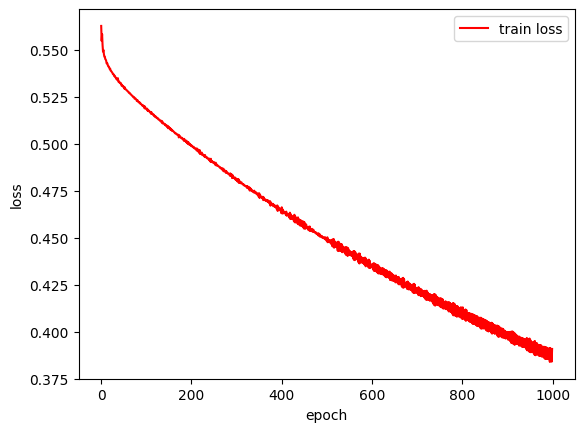

In [21]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

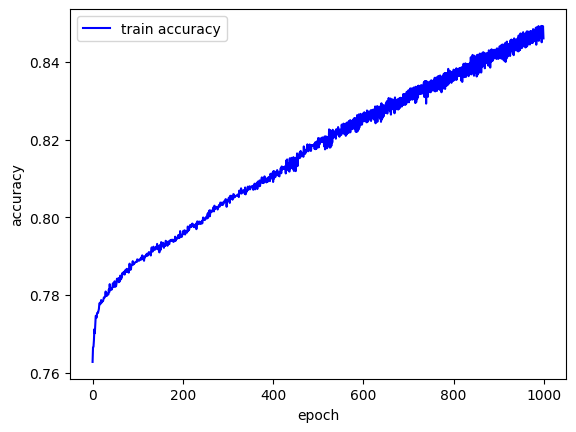

In [22]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

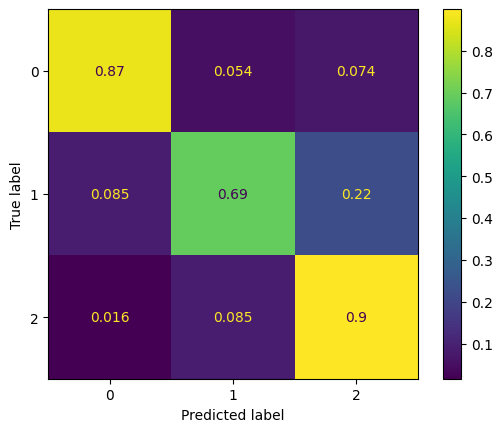

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

In [24]:
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')
accuracy_score=accuracy_score(y_test, listarray) * 100
print(f1)
print("정확도: {}".format(accuracy_score))

0.8207343412526998
정확도: 82.07343412526998


C:\Users\jaemin\Anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [25]:

print('SMOTE 적용 후 테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
# print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_test).value_counts())

SMOTE 적용 후 테스트용 피처/레이블 데이터 세트:  torch.Size([5093, 6]) torch.Size([5093])
SMOTE 적용 후 레이블 값 분포: 
 1    1698
2    1698
0    1697
dtype: int64


In [26]:
from collections import Counter
result = Counter(listarray)

In [27]:
result

Counter({2: 2033, 0: 1653, 1: 1407})

### AUC

In [28]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [29]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3


print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))

roc_auc_score:  0.8655539443937498
